# 1.  Wczytanie danych i wyliczenie wartosci OSNR

In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tree = ET.parse('polska')
root = tree.getroot()

## Miasta (nodes)

In [3]:
Nodes = {}
for node in root.findall(".//{http://sndlib.zib.de/network}node"):
    x = node.find(".//{http://sndlib.zib.de/network}x")
    y = node.find(".//{http://sndlib.zib.de/network}y")
    Nodes[node.get('id')] = [float(x.text), float(y.text)]
Nodes

{'Bialystok': [23.1, 53.1],
 'Bydgoszcz': [17.9, 53.1],
 'Gdansk': [18.6, 54.2],
 'Katowice': [18.8, 50.3],
 'Kolobrzeg': [16.1, 54.2],
 'Krakow': [19.8, 50.0],
 'Lodz': [19.4, 51.7],
 'Poznan': [16.8, 52.4],
 'Rzeszow': [21.9, 50.0],
 'Szczecin': [14.5, 53.4],
 'Warsaw': [21.0, 52.2],
 'Wroclaw': [16.9, 51.1]}

## Połączenia

In [4]:
Links = {}
for link in root.findall(".//{http://sndlib.zib.de/network}link"):
    source = link.find(".//{http://sndlib.zib.de/network}source")
    target = link.find(".//{http://sndlib.zib.de/network}target")
    setupCost = link.find(".//{http://sndlib.zib.de/network}setupCost")
    
    longitudeS = Nodes[source.text][0]
    longitudeT = Nodes[target.text][0]
    latitudeS = Nodes[source.text][1]
    latitudeT = Nodes[target.text][1]
    
    #distance1 = math.sqrt((longitudeS - longitudeT)**2 + (latitudeS - latitudeT)**2) * 73
    distance2 = math.acos(math.sin(math.radians(latitudeS))*math.sin(math.radians(latitudeT)) + math.cos(math.radians(latitudeS))*
                          math.cos(math.radians(latitudeT))*math.cos(math.radians(longitudeT - longitudeS)) )* 6371
    Links[link.get('id')] = distance2
Links

{'Link_0_10': 273.8496028378416,
 'Link_0_2': 162.60232837247085,
 'Link_0_5': 320.7405710847887,
 'Link_1_10': 231.811351705841,
 'Link_1_2': 170.38471371325605,
 'Link_1_7': 107.42132232440356,
 'Link_2_9': 137.66780655303617,
 'Link_3_11': 160.6764818757195,
 'Link_3_4': 78.6728876043855,
 'Link_3_6': 161.2340071135855,
 'Link_4_10': 258.5716578236298,
 'Link_4_8': 150.09198393119996,
 'Link_5_10': 173.43699098198317,
 'Link_5_8': 354.5360257175708,
 'Link_6_10': 122.94119213432361,
 'Link_6_11': 185.80862973599406,
 'Link_7_11': 144.71718812896586,
 'Link_7_9': 190.15142627508948}

## Ścieżki wraz z OSNR

In [77]:
def addNodetoPath(node1, node2, input_list):
    if len(input_list) == 2 :
        if node1 in input_list and node1 == input_list[0] :
            #print('pierwszy przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node2)
            return input_list
        if node2 in input_list and node2 == input_list[0] :
            #print('drugi przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node1)
            return input_list  
    if node1 not in input_list : 
        input_list.append(node1)
    if node2 not in input_list : 
        input_list.append(node2)
        
    return input_list

In [78]:
n = 0
Y_values = []
input_list = []
for demand in root.findall(".//{http://sndlib.zib.de/network}demand"):
    source = demand.find(".//{http://sndlib.zib.de/network}source")
    target = demand.find(".//{http://sndlib.zib.de/network}target")
    demandValue = demand.find(".//{http://sndlib.zib.de/network}demandValue")
    #print(demand.attrib)
    #print("Source: " + source.text)
    #print("Target: " + target.text)
    #print("DemandValue: " + demandValue.text)
    
    admissiblePaths = demand.findall(".//{http://sndlib.zib.de/network}admissiblePath")
    for path in admissiblePaths:
        path_links = path.findall(".//{http://sndlib.zib.de/network}linkId")
        values = 0;
        node_list=[]
        for link_id in path_links:
            values = values + 300./float(Links[link_id.text])
            words = link_id.text.split('_')
            node_list = addNodetoPath(words[1], words[2], node_list)
        input_list.append(node_list.copy()) 
        size = float(len(node_list))
        values= values + 300./min(Links.values())*(11-size)
        values = values + 10./(size-1)
        Y_values.append(values)
        n = n+1
        #print(node_list)
        #print(values)  
        node_list.clear()
"All paths: {}".format(n)

'All paths: 462'

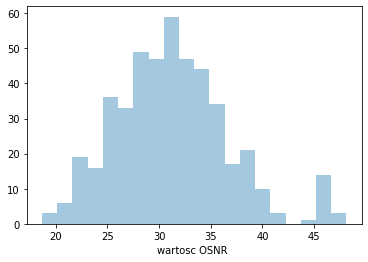

In [79]:
xs = pd.Series(Y_values,name="wartosc OSNR ")
sns.distplot(xs,bins=20, kde=False);

In [80]:
print("Min: {}".format(min(Y_values)))
print("Max: {}".format(max(Y_values)))
print("Mean: {}".format(statistics.mean(Y_values)))

Min: 18.680154700631682
Max: 48.13257770689441
Mean: 31.264953871433754


## 2. Przygotowanie danych

In [81]:
X_input = np.full((462,11), -1)
n = 0
for path in input_list:
    for i in range(len(path)):
        X_input[n][i] = path[i]
    n =n+1
X_input

array([[ 0,  2,  1, ..., -1, -1, -1],
       [ 0, 10,  1, ..., -1, -1, -1],
       [ 0,  2,  9, ..., -1, -1, -1],
       ...,
       [10,  1,  7, ..., -1, -1, -1],
       [10,  6,  3, ..., -1, -1, -1],
       [10,  4,  8, ..., 11, -1, -1]])

In [82]:
Y_output = np.array(Y_values)

delimit_values=np.quantile(Y_output, [0.25,0.5,0.75])
delimit_values

Y_output[Y_output<=delimit_values[0]]=0
Y_output[(Y_output>delimit_values[0]) & (Y_output<=delimit_values[1])]=1
Y_output[(Y_output>delimit_values[1]) & (Y_output<=delimit_values[2])]=2
Y_output[Y_output>delimit_values[2]]=3
Y_output


array([3., 3., 2., 2., 1., 0., 0., 3., 2., 2., 0., 1., 0., 0., 2., 3., 2.,
       0., 1., 3., 2., 2., 3., 2., 2., 3., 2., 1., 3., 3., 2., 1., 1., 0.,
       0., 1., 3., 3., 1., 1., 2., 2., 3., 3., 3., 0., 2., 2., 1., 3., 2.,
       2., 1., 2., 1., 0., 3., 2., 2., 1., 1., 2., 0., 3., 3., 3., 1., 1.,
       1., 0., 2., 1., 2., 1., 2., 1., 0., 3., 3., 2., 0., 2., 0., 0., 1.,
       0., 1., 1., 1., 0., 3., 1., 0., 1., 2., 1., 3., 3., 3., 1., 0., 2.,
       3., 1., 1., 0., 0., 1., 2., 1., 0., 0., 3., 3., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 3., 2., 3., 3., 0., 2., 0., 0., 0., 3., 3., 1.,
       0., 2., 2., 1., 3., 0., 0., 2., 2., 1., 0., 1., 2., 2., 1., 0., 1.,
       2., 2., 2., 2., 2., 1., 2., 2., 3., 3., 3., 1., 1., 1., 1., 1., 3.,
       3., 2., 0., 0., 2., 3., 3., 1., 2., 1., 0., 1., 2., 2., 2., 1., 1.,
       2., 2., 3., 3., 1., 0., 0., 0., 0., 3., 3., 3., 2., 1., 1., 1., 3.,
       1., 2., 3., 1., 1., 0., 3., 3., 0., 0., 1., 2., 0., 3., 3., 3., 1.,
       0., 2., 2., 3., 3.

## k-krotna walidacja

In [83]:
from sklearn.model_selection import KFold

In [84]:
kf=KFold(n_splits=20)

for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    print("Train: ", statistics.mean(Y_train), "Test: ", statistics.mean(Y_test))

Train:  1.4931506849315068 Test:  1.625
Train:  1.4817351598173516 Test:  1.8333333333333333
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.5193621867881548 Test:  1.1304347826086956
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.5148063781321184 Test:  1.2173913043478262
Train:  1.4965831435079726 Test:  1.565217391304348
Train:  1.4965831435079726 Test:  1.565217391304348
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.4920273348519362 Test:  1.6521739130434783
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.4783599088838268 Test:  1.9130434782608696
Train:  1.5239179954441913 Test:  1.0434782608695652
Train:  1.4760820045558087 Test:  1.9565217391304348
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.5056947608200455 Test:  1.391304347826087
Train:  1.5125284738041003 Test:  1.2608695652173914
Train:  1.5056947608200455 Test:  1.391304347826087
Train:  1.496

# 3. Analiza z wykorzystaniem sztucznej sieci neuronowej

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

Using TensorFlow backend.


In [14]:
Y_output_s = np.zeros((462,4))
for i in range(Y_output.shape[0]):
    if Y_output[i] == 0 : Y_output_s[i][0] = 1
    elif Y_output[i] == 1 : Y_output_s[i][1] = 1
    elif Y_output[i] == 2 : Y_output_s[i][2] = 1
    else : Y_output_s[i][3] = 1

## Liczba neuronow warstwy ukrytej w sieci jednowarstwowej

In [15]:
k_opt_1 = int(math.sqrt(X_input[0].shape[0] * Y_output_s[0].shape[0]))
k_opt_1

6

In [16]:
k_opt_2 = int(X_input[0].shape[0]/2 + Y_output_s[0].shape[0])
k_opt_2

9

In [17]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

history_all = []
accuracy_all = []
n_value = []

In [18]:
for n in range(k_opt_1-3,20):
    kf=KFold(n_splits=20)
    acc = []
    for train_index, test_index in kf.split(X_input):
        model = Sequential()
        model.add(Dense(n, input_dim = 11, activation = 'sigmoid'))
        model.add(Dense(4, activation ='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
        history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0, 
             callbacks = [callback_early_stopping])
        y_test,accuracy = model.evaluate(X_test, Y_test)
        history_all.append(history)
        acc.append(accuracy)
    accuracy_all.append(statistics.mean(acc))    
    n_value.append(n)

Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 355us/step - loss: 1.5398 - accuracy: 0.2016 - val_loss: 1.4629 - val_accuracy: 0.2727
Epoch 2/150
372/372 [==============================] - 0s 106us/step - loss: 1.4945 - accuracy: 0.2446 - val_loss: 1.4255 - val_accuracy: 0.3788
Epoch 3/150
372/372 [==============================] - 0s 122us/step - loss: 1.4555 - accuracy: 0.2796 - val_loss: 1.3970 - val_accuracy: 0.3485
Epoch 4/150
372/372 [==============================] - 0s 124us/step - loss: 1.4191 - accuracy: 0.3495 - val_loss: 1.3747 - val_accuracy: 0.4091
Epoch 5/150
372/372 [==============================] - 0s 113us/step - loss: 1.3864 - accuracy: 0.3898 - val_loss: 1.3561 - val_accuracy: 0.4091
Epoch 6/150
372/372 [==============================] - 0s 127us/step - loss: 1.3568 - accuracy: 0.4059 - val_loss: 1.3427 - val_accuracy: 0.3788
Epoch 7/150
372/372 [==============================] - 0s 125us/step - loss: 1.3306 -

Epoch 57/150
372/372 [==============================] - 0s 144us/step - loss: 0.7550 - accuracy: 0.7957 - val_loss: 0.7772 - val_accuracy: 0.8030
Epoch 58/150
372/372 [==============================] - 0s 141us/step - loss: 0.7455 - accuracy: 0.8038 - val_loss: 0.7677 - val_accuracy: 0.8030
Epoch 59/150
372/372 [==============================] - 0s 205us/step - loss: 0.7366 - accuracy: 0.8091 - val_loss: 0.7599 - val_accuracy: 0.8030
Epoch 60/150
372/372 [==============================] - 0s 182us/step - loss: 0.7286 - accuracy: 0.8118 - val_loss: 0.7520 - val_accuracy: 0.8030
Epoch 61/150
372/372 [==============================] - 0s 135us/step - loss: 0.7208 - accuracy: 0.8091 - val_loss: 0.7438 - val_accuracy: 0.8030
Epoch 62/150
372/372 [==============================] - 0s 105us/step - loss: 0.7135 - accuracy: 0.8091 - val_loss: 0.7351 - val_accuracy: 0.8030
Epoch 63/150
372/372 [==============================] - 0s 101us/step - loss: 0.7064 - accuracy: 0.8065 - val_loss: 0.7284 -

372/372 [==============================] - 0s 109us/step - loss: 0.5232 - accuracy: 0.8118 - val_loss: 0.5670 - val_accuracy: 0.7576
Epoch 114/150
372/372 [==============================] - 0s 102us/step - loss: 0.5212 - accuracy: 0.8091 - val_loss: 0.5662 - val_accuracy: 0.7576
Epoch 115/150
372/372 [==============================] - 0s 103us/step - loss: 0.5198 - accuracy: 0.8091 - val_loss: 0.5644 - val_accuracy: 0.7576
Epoch 116/150
372/372 [==============================] - 0s 94us/step - loss: 0.5182 - accuracy: 0.8118 - val_loss: 0.5636 - val_accuracy: 0.7727
Epoch 117/150
372/372 [==============================] - 0s 96us/step - loss: 0.5165 - accuracy: 0.8118 - val_loss: 0.5625 - val_accuracy: 0.7727
Epoch 118/150
372/372 [==============================] - 0s 91us/step - loss: 0.5151 - accuracy: 0.8118 - val_loss: 0.5614 - val_accuracy: 0.7576
Epoch 119/150
372/372 [==============================] - 0s 92us/step - loss: 0.5138 - accuracy: 0.8118 - val_loss: 0.5577 - val_accura

372/372 [==============================] - 0s 99us/step - loss: 1.0550 - accuracy: 0.6425 - val_loss: 1.0513 - val_accuracy: 0.6667
Epoch 19/150
372/372 [==============================] - 0s 97us/step - loss: 1.0335 - accuracy: 0.6640 - val_loss: 1.0290 - val_accuracy: 0.6667
Epoch 20/150
372/372 [==============================] - 0s 92us/step - loss: 1.0144 - accuracy: 0.6613 - val_loss: 1.0072 - val_accuracy: 0.6818
Epoch 21/150
372/372 [==============================] - 0s 97us/step - loss: 0.9965 - accuracy: 0.6694 - val_loss: 0.9902 - val_accuracy: 0.6818
Epoch 22/150
372/372 [==============================] - 0s 99us/step - loss: 0.9801 - accuracy: 0.6828 - val_loss: 0.9714 - val_accuracy: 0.6970
Epoch 23/150
372/372 [==============================] - 0s 94us/step - loss: 0.9645 - accuracy: 0.6882 - val_loss: 0.9543 - val_accuracy: 0.7273
Epoch 24/150
372/372 [==============================] - 0s 95us/step - loss: 0.9505 - accuracy: 0.6989 - val_loss: 0.9390 - val_accuracy: 0.742

372/372 [==============================] - 0s 95us/step - loss: 0.6653 - accuracy: 0.7661 - val_loss: 0.6198 - val_accuracy: 0.8182
Epoch 75/150
372/372 [==============================] - 0s 97us/step - loss: 0.6628 - accuracy: 0.7688 - val_loss: 0.6181 - val_accuracy: 0.8182
Epoch 76/150
372/372 [==============================] - 0s 97us/step - loss: 0.6606 - accuracy: 0.7742 - val_loss: 0.6155 - val_accuracy: 0.8182
Epoch 77/150
372/372 [==============================] - 0s 92us/step - loss: 0.6584 - accuracy: 0.7688 - val_loss: 0.6124 - val_accuracy: 0.8182
Epoch 78/150
372/372 [==============================] - 0s 91us/step - loss: 0.6562 - accuracy: 0.7769 - val_loss: 0.6113 - val_accuracy: 0.8182
Epoch 79/150
372/372 [==============================] - 0s 91us/step - loss: 0.6537 - accuracy: 0.7769 - val_loss: 0.6097 - val_accuracy: 0.8182
Epoch 80/150
372/372 [==============================] - 0s 92us/step - loss: 0.6513 - accuracy: 0.7769 - val_loss: 0.6071 - val_accuracy: 0.818

372/372 [==============================] - 0s 117us/step - loss: 0.5466 - accuracy: 0.8145 - val_loss: 0.5493 - val_accuracy: 0.8333
Epoch 131/150
372/372 [==============================] - 0s 106us/step - loss: 0.5448 - accuracy: 0.8199 - val_loss: 0.5471 - val_accuracy: 0.8182
Epoch 132/150
372/372 [==============================] - 0s 97us/step - loss: 0.5442 - accuracy: 0.8172 - val_loss: 0.5480 - val_accuracy: 0.8182
Epoch 133/150
372/372 [==============================] - 0s 99us/step - loss: 0.5430 - accuracy: 0.8172 - val_loss: 0.5472 - val_accuracy: 0.8182
Epoch 134/150
372/372 [==============================] - 0s 106us/step - loss: 0.5415 - accuracy: 0.8172 - val_loss: 0.5472 - val_accuracy: 0.8182
Epoch 135/150
372/372 [==============================] - 0s 93us/step - loss: 0.5407 - accuracy: 0.8199 - val_loss: 0.5482 - val_accuracy: 0.8333
Epoch 136/150
372/372 [==============================] - 0s 102us/step - loss: 0.5402 - accuracy: 0.8199 - val_loss: 0.5486 - val_accur

373/373 [==============================] - 0s 92us/step - loss: 1.0752 - accuracy: 0.6247 - val_loss: 1.1200 - val_accuracy: 0.5606
Epoch 45/150
373/373 [==============================] - 0s 96us/step - loss: 1.0710 - accuracy: 0.6327 - val_loss: 1.1167 - val_accuracy: 0.5606
Epoch 46/150
373/373 [==============================] - 0s 89us/step - loss: 1.0676 - accuracy: 0.6327 - val_loss: 1.1123 - val_accuracy: 0.5606
Epoch 47/150
373/373 [==============================] - 0s 94us/step - loss: 1.0634 - accuracy: 0.6327 - val_loss: 1.1123 - val_accuracy: 0.5606
Epoch 48/150
373/373 [==============================] - 0s 105us/step - loss: 1.0590 - accuracy: 0.6354 - val_loss: 1.1084 - val_accuracy: 0.5606
Epoch 49/150
373/373 [==============================] - 0s 92us/step - loss: 1.0553 - accuracy: 0.6381 - val_loss: 1.1041 - val_accuracy: 0.5606
Epoch 50/150
373/373 [==============================] - 0s 104us/step - loss: 1.0506 - accuracy: 0.6381 - val_loss: 1.1011 - val_accuracy: 0.5

373/373 [==============================] - 0s 100us/step - loss: 0.8827 - accuracy: 0.7346 - val_loss: 0.9999 - val_accuracy: 0.7424
Epoch 101/150
373/373 [==============================] - 0s 100us/step - loss: 0.8803 - accuracy: 0.7292 - val_loss: 0.9984 - val_accuracy: 0.7424
Epoch 102/150
373/373 [==============================] - 0s 95us/step - loss: 0.8784 - accuracy: 0.7292 - val_loss: 0.9974 - val_accuracy: 0.7424
Epoch 103/150
373/373 [==============================] - 0s 95us/step - loss: 0.8760 - accuracy: 0.7239 - val_loss: 0.9972 - val_accuracy: 0.7424
Epoch 104/150
373/373 [==============================] - 0s 95us/step - loss: 0.8740 - accuracy: 0.7292 - val_loss: 0.9948 - val_accuracy: 0.7424
Epoch 105/150
373/373 [==============================] - 0s 90us/step - loss: 0.8711 - accuracy: 0.7239 - val_loss: 0.9940 - val_accuracy: 0.7424
Epoch 106/150
373/373 [==============================] - 0s 93us/step - loss: 0.8691 - accuracy: 0.7158 - val_loss: 0.9938 - val_accurac

373/373 [==============================] - 0s 100us/step - loss: 1.2910 - accuracy: 0.3914 - val_loss: 1.2034 - val_accuracy: 0.6212
Epoch 6/150
373/373 [==============================] - 0s 104us/step - loss: 1.2646 - accuracy: 0.4370 - val_loss: 1.1751 - val_accuracy: 0.6818
Epoch 7/150
373/373 [==============================] - 0s 99us/step - loss: 1.2376 - accuracy: 0.4853 - val_loss: 1.1450 - val_accuracy: 0.6667
Epoch 8/150
373/373 [==============================] - 0s 117us/step - loss: 1.2096 - accuracy: 0.5255 - val_loss: 1.1144 - val_accuracy: 0.6667
Epoch 9/150
373/373 [==============================] - 0s 112us/step - loss: 1.1810 - accuracy: 0.5550 - val_loss: 1.0827 - val_accuracy: 0.6818
Epoch 10/150
373/373 [==============================] - 0s 125us/step - loss: 1.1532 - accuracy: 0.5764 - val_loss: 1.0512 - val_accuracy: 0.6970
Epoch 11/150
373/373 [==============================] - 0s 105us/step - loss: 1.1267 - accuracy: 0.6005 - val_loss: 1.0241 - val_accuracy: 0.6

373/373 [==============================] - 0s 118us/step - loss: 0.6463 - accuracy: 0.8016 - val_loss: 0.6027 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 115us/step - loss: 0.6436 - accuracy: 0.8043 - val_loss: 0.6005 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 110us/step - loss: 0.6406 - accuracy: 0.8043 - val_loss: 0.5979 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 127us/step - loss: 0.6378 - accuracy: 0.8016 - val_loss: 0.5958 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 110us/step - loss: 0.6354 - accuracy: 0.8016 - val_loss: 0.5939 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 117us/step - loss: 0.6324 - accuracy: 0.8043 - val_loss: 0.5915 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 107us/step - loss: 0.6310 - accuracy: 0.8043 - val_loss: 0.5896 - val_accuracy

373/373 [==============================] - 0s 108us/step - loss: 0.5580 - accuracy: 0.8016 - val_loss: 0.5339 - val_accuracy: 0.8030
Epoch 118/150
373/373 [==============================] - 0s 123us/step - loss: 0.5565 - accuracy: 0.8043 - val_loss: 0.5331 - val_accuracy: 0.8030
Epoch 119/150
373/373 [==============================] - 0s 104us/step - loss: 0.5556 - accuracy: 0.8016 - val_loss: 0.5324 - val_accuracy: 0.8030
Epoch 120/150
373/373 [==============================] - 0s 116us/step - loss: 0.5549 - accuracy: 0.8016 - val_loss: 0.5322 - val_accuracy: 0.8030
Epoch 121/150
373/373 [==============================] - 0s 109us/step - loss: 0.5544 - accuracy: 0.8016 - val_loss: 0.5320 - val_accuracy: 0.8030
Epoch 122/150
373/373 [==============================] - 0s 116us/step - loss: 0.5531 - accuracy: 0.8016 - val_loss: 0.5315 - val_accuracy: 0.8030
Epoch 123/150
373/373 [==============================] - 0s 104us/step - loss: 0.5527 - accuracy: 0.8016 - val_loss: 0.5308 - val_ac

373/373 [==============================] - 0s 115us/step - loss: 0.9834 - accuracy: 0.7399 - val_loss: 0.9757 - val_accuracy: 0.7273
Epoch 23/150
373/373 [==============================] - 0s 110us/step - loss: 0.9726 - accuracy: 0.7507 - val_loss: 0.9620 - val_accuracy: 0.7424
Epoch 24/150
373/373 [==============================] - 0s 127us/step - loss: 0.9615 - accuracy: 0.7587 - val_loss: 0.9477 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 104us/step - loss: 0.9513 - accuracy: 0.7614 - val_loss: 0.9360 - val_accuracy: 0.8030
Epoch 26/150
373/373 [==============================] - 0s 103us/step - loss: 0.9410 - accuracy: 0.7641 - val_loss: 0.9228 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 116us/step - loss: 0.9309 - accuracy: 0.7694 - val_loss: 0.9098 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 110us/step - loss: 0.9211 - accuracy: 0.7748 - val_loss: 0.9007 - val_accuracy

373/373 [==============================] - 0s 107us/step - loss: 0.6529 - accuracy: 0.7882 - val_loss: 0.6301 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 115us/step - loss: 0.6507 - accuracy: 0.7882 - val_loss: 0.6276 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 119us/step - loss: 0.6476 - accuracy: 0.7909 - val_loss: 0.6258 - val_accuracy: 0.7727
Epoch 81/150
373/373 [==============================] - 0s 108us/step - loss: 0.6452 - accuracy: 0.7882 - val_loss: 0.6236 - val_accuracy: 0.7727
Epoch 82/150
373/373 [==============================] - 0s 117us/step - loss: 0.6431 - accuracy: 0.7909 - val_loss: 0.6217 - val_accuracy: 0.7727
Epoch 83/150
373/373 [==============================] - 0s 112us/step - loss: 0.6405 - accuracy: 0.7909 - val_loss: 0.6200 - val_accuracy: 0.7727
Epoch 84/150
373/373 [==============================] - 0s 107us/step - loss: 0.6385 - accuracy: 0.7882 - val_loss: 0.6175 - val_accuracy

Epoch 134/150
373/373 [==============================] - 0s 100us/step - loss: 0.5718 - accuracy: 0.7936 - val_loss: 0.5724 - val_accuracy: 0.7576
Epoch 135/150
373/373 [==============================] - 0s 99us/step - loss: 0.5716 - accuracy: 0.7936 - val_loss: 0.5722 - val_accuracy: 0.7576
Epoch 136/150
373/373 [==============================] - 0s 94us/step - loss: 0.5708 - accuracy: 0.7936 - val_loss: 0.5713 - val_accuracy: 0.7576
Epoch 137/150
373/373 [==============================] - 0s 94us/step - loss: 0.5703 - accuracy: 0.7936 - val_loss: 0.5714 - val_accuracy: 0.7576
Epoch 138/150
373/373 [==============================] - 0s 102us/step - loss: 0.5693 - accuracy: 0.7909 - val_loss: 0.5697 - val_accuracy: 0.7727
Epoch 139/150
373/373 [==============================] - 0s 120us/step - loss: 0.5691 - accuracy: 0.7936 - val_loss: 0.5700 - val_accuracy: 0.7576
Epoch 140/150
373/373 [==============================] - 0s 127us/step - loss: 0.5686 - accuracy: 0.7936 - val_loss: 0.56

373/373 [==============================] - 0s 154us/step - loss: 0.8338 - accuracy: 0.6836 - val_loss: 0.8661 - val_accuracy: 0.7273
Epoch 40/150
373/373 [==============================] - 0s 161us/step - loss: 0.8264 - accuracy: 0.6863 - val_loss: 0.8567 - val_accuracy: 0.7576
Epoch 41/150
373/373 [==============================] - 0s 169us/step - loss: 0.8194 - accuracy: 0.7131 - val_loss: 0.8505 - val_accuracy: 0.7424
Epoch 42/150
373/373 [==============================] - 0s 178us/step - loss: 0.8126 - accuracy: 0.7507 - val_loss: 0.8416 - val_accuracy: 0.7424
Epoch 43/150
373/373 [==============================] - 0s 153us/step - loss: 0.8061 - accuracy: 0.7399 - val_loss: 0.8351 - val_accuracy: 0.7424
Epoch 44/150
373/373 [==============================] - 0s 124us/step - loss: 0.7994 - accuracy: 0.7426 - val_loss: 0.8275 - val_accuracy: 0.7576
Epoch 45/150
373/373 [==============================] - 0s 128us/step - loss: 0.7938 - accuracy: 0.7373 - val_loss: 0.8207 - val_accuracy

373/373 [==============================] - 0s 105us/step - loss: 0.6024 - accuracy: 0.8097 - val_loss: 0.6552 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 118us/step - loss: 0.6002 - accuracy: 0.8123 - val_loss: 0.6543 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 121us/step - loss: 0.5985 - accuracy: 0.8097 - val_loss: 0.6528 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 119us/step - loss: 0.5965 - accuracy: 0.8123 - val_loss: 0.6530 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 128us/step - loss: 0.5947 - accuracy: 0.8097 - val_loss: 0.6518 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 119us/step - loss: 0.5928 - accuracy: 0.8097 - val_loss: 0.6510 - val_accuracy: 0.7727
Epoch 101/150
373/373 [==============================] - 0s 134us/step - loss: 0.5916 - accuracy: 0.8097 - val_loss: 0.6505 - val_accura

23/23 [==============================] - 0s 33us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 536us/step - loss: 1.4714 - accuracy: 0.1662 - val_loss: 1.4518 - val_accuracy: 0.2727
Epoch 2/150
373/373 [==============================] - 0s 109us/step - loss: 1.4420 - accuracy: 0.1662 - val_loss: 1.4238 - val_accuracy: 0.2424
Epoch 3/150
373/373 [==============================] - 0s 113us/step - loss: 1.4202 - accuracy: 0.1635 - val_loss: 1.3991 - val_accuracy: 0.2424
Epoch 4/150
373/373 [==============================] - 0s 113us/step - loss: 1.4005 - accuracy: 0.1555 - val_loss: 1.3784 - val_accuracy: 0.2424
Epoch 5/150
373/373 [==============================] - 0s 110us/step - loss: 1.3827 - accuracy: 0.1769 - val_loss: 1.3616 - val_accuracy: 0.2576
Epoch 6/150
373/373 [==============================] - 0s 108us/step - loss: 1.3657 - accuracy: 0.1823 - val_loss: 1.3464 - val_accuracy: 0.3030
Epoch 7/150
373/373 [==========

373/373 [==============================] - 0s 97us/step - loss: 0.7183 - accuracy: 0.7962 - val_loss: 0.7605 - val_accuracy: 0.7576
Epoch 57/150
373/373 [==============================] - 0s 108us/step - loss: 0.7135 - accuracy: 0.7989 - val_loss: 0.7551 - val_accuracy: 0.7576
Epoch 58/150
373/373 [==============================] - 0s 96us/step - loss: 0.7078 - accuracy: 0.7989 - val_loss: 0.7518 - val_accuracy: 0.7576
Epoch 59/150
373/373 [==============================] - 0s 117us/step - loss: 0.7033 - accuracy: 0.7936 - val_loss: 0.7500 - val_accuracy: 0.7576
Epoch 60/150
373/373 [==============================] - 0s 132us/step - loss: 0.6986 - accuracy: 0.7989 - val_loss: 0.7443 - val_accuracy: 0.7576
Epoch 61/150
373/373 [==============================] - 0s 106us/step - loss: 0.6944 - accuracy: 0.7989 - val_loss: 0.7415 - val_accuracy: 0.7576
Epoch 62/150
373/373 [==============================] - 0s 113us/step - loss: 0.6901 - accuracy: 0.7989 - val_loss: 0.7401 - val_accuracy: 

373/373 [==============================] - 0s 97us/step - loss: 0.5802 - accuracy: 0.8043 - val_loss: 0.6847 - val_accuracy: 0.7273
Epoch 113/150
373/373 [==============================] - 0s 99us/step - loss: 0.5784 - accuracy: 0.8016 - val_loss: 0.6846 - val_accuracy: 0.7273
Epoch 114/150
373/373 [==============================] - 0s 92us/step - loss: 0.5776 - accuracy: 0.8043 - val_loss: 0.6840 - val_accuracy: 0.7273
Epoch 115/150
373/373 [==============================] - 0s 93us/step - loss: 0.5776 - accuracy: 0.8043 - val_loss: 0.6829 - val_accuracy: 0.7273
Epoch 116/150
373/373 [==============================] - 0s 117us/step - loss: 0.5763 - accuracy: 0.7989 - val_loss: 0.6832 - val_accuracy: 0.7273
Epoch 117/150
373/373 [==============================] - 0s 102us/step - loss: 0.5740 - accuracy: 0.8043 - val_loss: 0.6816 - val_accuracy: 0.7273
Epoch 118/150
373/373 [==============================] - 0s 100us/step - loss: 0.5730 - accuracy: 0.8043 - val_loss: 0.6817 - val_accura

373/373 [==============================] - 0s 186us/step - loss: 1.0518 - accuracy: 0.5121 - val_loss: 1.0234 - val_accuracy: 0.5455
Epoch 18/150
373/373 [==============================] - 0s 173us/step - loss: 1.0392 - accuracy: 0.5174 - val_loss: 1.0109 - val_accuracy: 0.5758
Epoch 19/150
373/373 [==============================] - 0s 146us/step - loss: 1.0264 - accuracy: 0.5362 - val_loss: 0.9989 - val_accuracy: 0.5758
Epoch 20/150
373/373 [==============================] - 0s 134us/step - loss: 1.0148 - accuracy: 0.5416 - val_loss: 0.9878 - val_accuracy: 0.6061
Epoch 21/150
373/373 [==============================] - 0s 140us/step - loss: 1.0035 - accuracy: 0.5550 - val_loss: 0.9754 - val_accuracy: 0.6212
Epoch 22/150
373/373 [==============================] - 0s 160us/step - loss: 0.9926 - accuracy: 0.5630 - val_loss: 0.9627 - val_accuracy: 0.6212
Epoch 23/150
373/373 [==============================] - 0s 148us/step - loss: 0.9826 - accuracy: 0.5630 - val_loss: 0.9508 - val_accuracy

373/373 [==============================] - 0s 120us/step - loss: 0.6193 - accuracy: 0.7989 - val_loss: 0.5968 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 116us/step - loss: 0.6169 - accuracy: 0.7909 - val_loss: 0.5949 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 101us/step - loss: 0.6131 - accuracy: 0.7962 - val_loss: 0.5913 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 93us/step - loss: 0.6095 - accuracy: 0.8043 - val_loss: 0.5900 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 141us/step - loss: 0.6064 - accuracy: 0.8043 - val_loss: 0.5870 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 127us/step - loss: 0.6035 - accuracy: 0.7989 - val_loss: 0.5850 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 108us/step - loss: 0.6011 - accuracy: 0.7962 - val_loss: 0.5834 - val_accuracy:

373/373 [==============================] - 0s 116us/step - loss: 0.5169 - accuracy: 0.8097 - val_loss: 0.5303 - val_accuracy: 0.7727
Epoch 130/150
373/373 [==============================] - 0s 107us/step - loss: 0.5158 - accuracy: 0.8123 - val_loss: 0.5301 - val_accuracy: 0.7727
Epoch 131/150
373/373 [==============================] - 0s 99us/step - loss: 0.5151 - accuracy: 0.8097 - val_loss: 0.5296 - val_accuracy: 0.7727
Epoch 132/150
373/373 [==============================] - 0s 93us/step - loss: 0.5147 - accuracy: 0.8070 - val_loss: 0.5297 - val_accuracy: 0.7727
Epoch 133/150
373/373 [==============================] - 0s 126us/step - loss: 0.5136 - accuracy: 0.8043 - val_loss: 0.5290 - val_accuracy: 0.7727
Epoch 134/150
373/373 [==============================] - 0s 113us/step - loss: 0.5129 - accuracy: 0.8097 - val_loss: 0.5303 - val_accuracy: 0.7727
Epoch 135/150
373/373 [==============================] - 0s 97us/step - loss: 0.5130 - accuracy: 0.8016 - val_loss: 0.5302 - val_accur

373/373 [==============================] - 0s 112us/step - loss: 0.8629 - accuracy: 0.7185 - val_loss: 0.8386 - val_accuracy: 0.7727
Epoch 35/150
373/373 [==============================] - 0s 99us/step - loss: 0.8546 - accuracy: 0.7265 - val_loss: 0.8301 - val_accuracy: 0.7727
Epoch 36/150
373/373 [==============================] - 0s 89us/step - loss: 0.8471 - accuracy: 0.7239 - val_loss: 0.8225 - val_accuracy: 0.7727
Epoch 37/150
373/373 [==============================] - 0s 102us/step - loss: 0.8402 - accuracy: 0.7239 - val_loss: 0.8139 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 93us/step - loss: 0.8322 - accuracy: 0.7265 - val_loss: 0.8067 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 95us/step - loss: 0.8252 - accuracy: 0.7265 - val_loss: 0.7979 - val_accuracy: 0.8030
Epoch 40/150
373/373 [==============================] - 0s 89us/step - loss: 0.8188 - accuracy: 0.7265 - val_loss: 0.7912 - val_accuracy: 0.8

373/373 [==============================] - 0s 94us/step - loss: 0.6234 - accuracy: 0.8016 - val_loss: 0.6088 - val_accuracy: 0.8030
Epoch 91/150
373/373 [==============================] - 0s 100us/step - loss: 0.6209 - accuracy: 0.8070 - val_loss: 0.6052 - val_accuracy: 0.8030
Epoch 92/150
373/373 [==============================] - 0s 103us/step - loss: 0.6189 - accuracy: 0.8070 - val_loss: 0.6037 - val_accuracy: 0.8030
Epoch 93/150
373/373 [==============================] - 0s 94us/step - loss: 0.6168 - accuracy: 0.8123 - val_loss: 0.5998 - val_accuracy: 0.8030
Epoch 94/150
373/373 [==============================] - 0s 93us/step - loss: 0.6150 - accuracy: 0.8123 - val_loss: 0.5990 - val_accuracy: 0.8030
Epoch 95/150
373/373 [==============================] - 0s 97us/step - loss: 0.6129 - accuracy: 0.8177 - val_loss: 0.5969 - val_accuracy: 0.8030
Epoch 96/150
373/373 [==============================] - 0s 91us/step - loss: 0.6109 - accuracy: 0.8097 - val_loss: 0.5950 - val_accuracy: 0.8

373/373 [==============================] - 0s 95us/step - loss: 0.5453 - accuracy: 0.8231 - val_loss: 0.5331 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 96us/step - loss: 0.5444 - accuracy: 0.8231 - val_loss: 0.5324 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 90us/step - loss: 0.5437 - accuracy: 0.8231 - val_loss: 0.5323 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 89us/step - loss: 0.5435 - accuracy: 0.8231 - val_loss: 0.5314 - val_accuracy: 0.8182
Epoch 150/150
23/23 [==============================] - 0s 28us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 271us/step - loss: 1.3577 - accuracy: 0.2547 - val_loss: 1.3361 - val_accuracy: 0.2727
Epoch 2/150
373/373 [==============================] - 0s 97us/step - loss: 1.3389 - accuracy: 0.2788 - val_loss: 1.3235 - val_accuracy: 0.3333
Epoch 3/150
373/373 [=======

Epoch 52/150
373/373 [==============================] - 0s 98us/step - loss: 0.7428 - accuracy: 0.7480 - val_loss: 0.6997 - val_accuracy: 0.7424
Epoch 53/150
373/373 [==============================] - 0s 96us/step - loss: 0.7373 - accuracy: 0.7426 - val_loss: 0.6960 - val_accuracy: 0.7273
Epoch 54/150
373/373 [==============================] - 0s 95us/step - loss: 0.7323 - accuracy: 0.7534 - val_loss: 0.6903 - val_accuracy: 0.7424
Epoch 55/150
373/373 [==============================] - 0s 95us/step - loss: 0.7270 - accuracy: 0.7534 - val_loss: 0.6849 - val_accuracy: 0.7424
Epoch 56/150
373/373 [==============================] - 0s 94us/step - loss: 0.7225 - accuracy: 0.7587 - val_loss: 0.6795 - val_accuracy: 0.7424
Epoch 57/150
373/373 [==============================] - 0s 93us/step - loss: 0.7181 - accuracy: 0.7614 - val_loss: 0.6765 - val_accuracy: 0.7424
Epoch 58/150
373/373 [==============================] - 0s 90us/step - loss: 0.7138 - accuracy: 0.7641 - val_loss: 0.6726 - val_ac

373/373 [==============================] - 0s 96us/step - loss: 0.5828 - accuracy: 0.8043 - val_loss: 0.5564 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 95us/step - loss: 0.5809 - accuracy: 0.8043 - val_loss: 0.5550 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 94us/step - loss: 0.5796 - accuracy: 0.8016 - val_loss: 0.5537 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 92us/step - loss: 0.5786 - accuracy: 0.8043 - val_loss: 0.5539 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 93us/step - loss: 0.5770 - accuracy: 0.8043 - val_loss: 0.5515 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 92us/step - loss: 0.5767 - accuracy: 0.8043 - val_loss: 0.5520 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 90us/step - loss: 0.5745 - accuracy: 0.8043 - val_loss: 0.5507 - val_accuracy:

373/373 [==============================] - 0s 91us/step - loss: 1.0806 - accuracy: 0.6032 - val_loss: 1.1078 - val_accuracy: 0.5758
Epoch 14/150
373/373 [==============================] - 0s 93us/step - loss: 1.0591 - accuracy: 0.6113 - val_loss: 1.0834 - val_accuracy: 0.5909
Epoch 15/150
373/373 [==============================] - 0s 93us/step - loss: 1.0400 - accuracy: 0.6247 - val_loss: 1.0581 - val_accuracy: 0.5909
Epoch 16/150
373/373 [==============================] - 0s 95us/step - loss: 1.0223 - accuracy: 0.6327 - val_loss: 1.0334 - val_accuracy: 0.6061
Epoch 17/150
373/373 [==============================] - 0s 98us/step - loss: 1.0052 - accuracy: 0.6408 - val_loss: 1.0103 - val_accuracy: 0.6364
Epoch 18/150
373/373 [==============================] - 0s 95us/step - loss: 0.9882 - accuracy: 0.6488 - val_loss: 0.9846 - val_accuracy: 0.6364
Epoch 19/150
373/373 [==============================] - 0s 94us/step - loss: 0.9723 - accuracy: 0.6595 - val_loss: 0.9633 - val_accuracy: 0.636

373/373 [==============================] - 0s 94us/step - loss: 0.6433 - accuracy: 0.7828 - val_loss: 0.6050 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 101us/step - loss: 0.6402 - accuracy: 0.7828 - val_loss: 0.6026 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 95us/step - loss: 0.6372 - accuracy: 0.7855 - val_loss: 0.6001 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 96us/step - loss: 0.6344 - accuracy: 0.7828 - val_loss: 0.5959 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 90us/step - loss: 0.6321 - accuracy: 0.7882 - val_loss: 0.5940 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 89us/step - loss: 0.6283 - accuracy: 0.7855 - val_loss: 0.5898 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 94us/step - loss: 0.6253 - accuracy: 0.7855 - val_loss: 0.5887 - val_accuracy: 0.81

373/373 [==============================] - 0s 95us/step - loss: 0.5440 - accuracy: 0.7962 - val_loss: 0.5324 - val_accuracy: 0.8333
Epoch 126/150
373/373 [==============================] - 0s 103us/step - loss: 0.5426 - accuracy: 0.8043 - val_loss: 0.5322 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 91us/step - loss: 0.5408 - accuracy: 0.8043 - val_loss: 0.5321 - val_accuracy: 0.8182
Epoch 128/150
373/373 [==============================] - 0s 96us/step - loss: 0.5402 - accuracy: 0.8043 - val_loss: 0.5308 - val_accuracy: 0.8182
Epoch 129/150
373/373 [==============================] - 0s 88us/step - loss: 0.5394 - accuracy: 0.8070 - val_loss: 0.5304 - val_accuracy: 0.8182
Epoch 130/150
373/373 [==============================] - 0s 91us/step - loss: 0.5384 - accuracy: 0.8070 - val_loss: 0.5303 - val_accuracy: 0.8182
Epoch 131/150
373/373 [==============================] - 0s 93us/step - loss: 0.5377 - accuracy: 0.8043 - val_loss: 0.5296 - val_accuracy

Epoch 31/150
373/373 [==============================] - 0s 95us/step - loss: 0.8998 - accuracy: 0.7024 - val_loss: 0.8764 - val_accuracy: 0.7879
Epoch 32/150
373/373 [==============================] - 0s 88us/step - loss: 0.8878 - accuracy: 0.7051 - val_loss: 0.8674 - val_accuracy: 0.7879
Epoch 33/150
373/373 [==============================] - 0s 95us/step - loss: 0.8764 - accuracy: 0.7131 - val_loss: 0.8563 - val_accuracy: 0.8030
Epoch 34/150
373/373 [==============================] - 0s 100us/step - loss: 0.8653 - accuracy: 0.7131 - val_loss: 0.8428 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 89us/step - loss: 0.8551 - accuracy: 0.7158 - val_loss: 0.8290 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 94us/step - loss: 0.8443 - accuracy: 0.7239 - val_loss: 0.8167 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 93us/step - loss: 0.8347 - accuracy: 0.7239 - val_loss: 0.8010 - val_a

373/373 [==============================] - 0s 93us/step - loss: 0.6118 - accuracy: 0.8070 - val_loss: 0.5689 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 98us/step - loss: 0.6096 - accuracy: 0.8097 - val_loss: 0.5670 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 90us/step - loss: 0.6073 - accuracy: 0.8070 - val_loss: 0.5657 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 91us/step - loss: 0.6051 - accuracy: 0.8070 - val_loss: 0.5645 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 90us/step - loss: 0.6032 - accuracy: 0.8070 - val_loss: 0.5621 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 102us/step - loss: 0.6013 - accuracy: 0.8097 - val_loss: 0.5606 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 91us/step - loss: 0.5990 - accuracy: 0.8097 - val_loss: 0.5589 - val_accuracy: 0.81

373/373 [==============================] - 0s 90us/step - loss: 0.5381 - accuracy: 0.8123 - val_loss: 0.5098 - val_accuracy: 0.8182
Epoch 144/150
373/373 [==============================] - 0s 95us/step - loss: 0.5382 - accuracy: 0.8150 - val_loss: 0.5089 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 89us/step - loss: 0.5371 - accuracy: 0.8150 - val_loss: 0.5094 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 105us/step - loss: 0.5363 - accuracy: 0.8123 - val_loss: 0.5085 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 94us/step - loss: 0.5358 - accuracy: 0.8150 - val_loss: 0.5079 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 115us/step - loss: 0.5351 - accuracy: 0.8150 - val_loss: 0.5077 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 103us/step - loss: 0.5343 - accuracy: 0.8123 - val_loss: 0.5073 - val_accura

Epoch 49/150
373/373 [==============================] - 0s 96us/step - loss: 0.8351 - accuracy: 0.7507 - val_loss: 0.8384 - val_accuracy: 0.7121
Epoch 50/150
373/373 [==============================] - 0s 91us/step - loss: 0.8241 - accuracy: 0.7614 - val_loss: 0.8245 - val_accuracy: 0.7121
Epoch 51/150
373/373 [==============================] - 0s 99us/step - loss: 0.8140 - accuracy: 0.7614 - val_loss: 0.8095 - val_accuracy: 0.7273
Epoch 52/150
373/373 [==============================] - 0s 101us/step - loss: 0.8046 - accuracy: 0.7668 - val_loss: 0.7986 - val_accuracy: 0.7273
Epoch 53/150
373/373 [==============================] - 0s 91us/step - loss: 0.7958 - accuracy: 0.7721 - val_loss: 0.7866 - val_accuracy: 0.7273
Epoch 54/150
373/373 [==============================] - 0s 92us/step - loss: 0.7875 - accuracy: 0.7721 - val_loss: 0.7775 - val_accuracy: 0.7273
Epoch 55/150
373/373 [==============================] - 0s 89us/step - loss: 0.7801 - accuracy: 0.7748 - val_loss: 0.7667 - val_a

373/373 [==============================] - 0s 95us/step - loss: 0.6053 - accuracy: 0.7989 - val_loss: 0.6229 - val_accuracy: 0.7424
Epoch 106/150
373/373 [==============================] - 0s 100us/step - loss: 0.6047 - accuracy: 0.7962 - val_loss: 0.6198 - val_accuracy: 0.7576
Epoch 107/150
373/373 [==============================] - 0s 93us/step - loss: 0.6019 - accuracy: 0.8016 - val_loss: 0.6191 - val_accuracy: 0.7576
Epoch 108/150
373/373 [==============================] - 0s 91us/step - loss: 0.6006 - accuracy: 0.8016 - val_loss: 0.6183 - val_accuracy: 0.7576
Epoch 109/150
373/373 [==============================] - 0s 93us/step - loss: 0.5995 - accuracy: 0.8043 - val_loss: 0.6150 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 89us/step - loss: 0.5984 - accuracy: 0.8016 - val_loss: 0.6149 - val_accuracy: 0.7879
Epoch 111/150
373/373 [==============================] - 0s 91us/step - loss: 0.5965 - accuracy: 0.8043 - val_loss: 0.6160 - val_accuracy

373/373 [==============================] - 0s 89us/step - loss: 1.3198 - accuracy: 0.5067 - val_loss: 1.3402 - val_accuracy: 0.3939
Epoch 11/150
373/373 [==============================] - 0s 89us/step - loss: 1.3042 - accuracy: 0.5094 - val_loss: 1.3264 - val_accuracy: 0.4091
Epoch 12/150
373/373 [==============================] - 0s 91us/step - loss: 1.2886 - accuracy: 0.5228 - val_loss: 1.3162 - val_accuracy: 0.4091
Epoch 13/150
373/373 [==============================] - 0s 92us/step - loss: 1.2725 - accuracy: 0.5389 - val_loss: 1.2969 - val_accuracy: 0.4242
Epoch 14/150
373/373 [==============================] - 0s 95us/step - loss: 1.2559 - accuracy: 0.5442 - val_loss: 1.2783 - val_accuracy: 0.4242
Epoch 15/150
373/373 [==============================] - 0s 98us/step - loss: 1.2390 - accuracy: 0.5657 - val_loss: 1.2574 - val_accuracy: 0.4242
Epoch 16/150
373/373 [==============================] - 0s 90us/step - loss: 1.2211 - accuracy: 0.5737 - val_loss: 1.2383 - val_accuracy: 0.439

373/373 [==============================] - 0s 90us/step - loss: 0.7270 - accuracy: 0.7614 - val_loss: 0.6820 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 98us/step - loss: 0.7234 - accuracy: 0.7614 - val_loss: 0.6787 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 91us/step - loss: 0.7195 - accuracy: 0.7614 - val_loss: 0.6737 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 106us/step - loss: 0.7160 - accuracy: 0.7614 - val_loss: 0.6700 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 93us/step - loss: 0.7128 - accuracy: 0.7614 - val_loss: 0.6668 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 104us/step - loss: 0.7094 - accuracy: 0.7614 - val_loss: 0.6625 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 103us/step - loss: 0.7065 - accuracy: 0.7614 - val_loss: 0.6591 - val_accuracy: 0.

373/373 [==============================] - 0s 96us/step - loss: 0.6144 - accuracy: 0.7668 - val_loss: 0.5651 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 98us/step - loss: 0.6135 - accuracy: 0.7694 - val_loss: 0.5638 - val_accuracy: 0.8182
Epoch 124/150
373/373 [==============================] - 0s 92us/step - loss: 0.6121 - accuracy: 0.7694 - val_loss: 0.5631 - val_accuracy: 0.8182
Epoch 125/150
373/373 [==============================] - 0s 91us/step - loss: 0.6112 - accuracy: 0.7694 - val_loss: 0.5618 - val_accuracy: 0.8182
Epoch 126/150
373/373 [==============================] - 0s 93us/step - loss: 0.6106 - accuracy: 0.7694 - val_loss: 0.5611 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 88us/step - loss: 0.6099 - accuracy: 0.7668 - val_loss: 0.5594 - val_accuracy: 0.8182
Epoch 128/150
373/373 [==============================] - 0s 100us/step - loss: 0.6087 - accuracy: 0.7694 - val_loss: 0.5600 - val_accuracy

Epoch 28/150
373/373 [==============================] - 0s 122us/step - loss: 1.1734 - accuracy: 0.5121 - val_loss: 1.1597 - val_accuracy: 0.5909
Epoch 29/150
373/373 [==============================] - 0s 110us/step - loss: 1.1667 - accuracy: 0.5121 - val_loss: 1.1525 - val_accuracy: 0.5758
Epoch 30/150
373/373 [==============================] - 0s 103us/step - loss: 1.1607 - accuracy: 0.5013 - val_loss: 1.1431 - val_accuracy: 0.5758
Epoch 31/150
373/373 [==============================] - 0s 96us/step - loss: 1.1537 - accuracy: 0.5067 - val_loss: 1.1352 - val_accuracy: 0.6061
Epoch 32/150
373/373 [==============================] - 0s 133us/step - loss: 1.1470 - accuracy: 0.5067 - val_loss: 1.1270 - val_accuracy: 0.6061
Epoch 33/150
373/373 [==============================] - 0s 99us/step - loss: 1.1407 - accuracy: 0.5067 - val_loss: 1.1189 - val_accuracy: 0.6061
Epoch 34/150
373/373 [==============================] - 0s 100us/step - loss: 1.1340 - accuracy: 0.5094 - val_loss: 1.1130 - v

373/373 [==============================] - 0s 95us/step - loss: 0.7802 - accuracy: 0.6997 - val_loss: 0.7859 - val_accuracy: 0.7424
Epoch 85/150
373/373 [==============================] - 0s 93us/step - loss: 0.7776 - accuracy: 0.6944 - val_loss: 0.7839 - val_accuracy: 0.7424
Epoch 86/150
373/373 [==============================] - 0s 93us/step - loss: 0.7745 - accuracy: 0.7024 - val_loss: 0.7818 - val_accuracy: 0.7424
Epoch 87/150
373/373 [==============================] - 0s 94us/step - loss: 0.7711 - accuracy: 0.7024 - val_loss: 0.7800 - val_accuracy: 0.7424
Epoch 88/150
373/373 [==============================] - 0s 94us/step - loss: 0.7680 - accuracy: 0.6997 - val_loss: 0.7798 - val_accuracy: 0.6970
Epoch 89/150
373/373 [==============================] - 0s 89us/step - loss: 0.7644 - accuracy: 0.6971 - val_loss: 0.7765 - val_accuracy: 0.6970
Epoch 90/150
373/373 [==============================] - 0s 88us/step - loss: 0.7610 - accuracy: 0.6997 - val_loss: 0.7724 - val_accuracy: 0.697

373/373 [==============================] - 0s 90us/step - loss: 0.6419 - accuracy: 0.7426 - val_loss: 0.6172 - val_accuracy: 0.7273
Epoch 141/150
373/373 [==============================] - 0s 94us/step - loss: 0.6380 - accuracy: 0.7399 - val_loss: 0.6103 - val_accuracy: 0.7273
Epoch 142/150
373/373 [==============================] - 0s 92us/step - loss: 0.6346 - accuracy: 0.7426 - val_loss: 0.6024 - val_accuracy: 0.7273
Epoch 143/150
373/373 [==============================] - 0s 90us/step - loss: 0.6305 - accuracy: 0.7507 - val_loss: 0.5965 - val_accuracy: 0.7273
Epoch 144/150
373/373 [==============================] - 0s 94us/step - loss: 0.6272 - accuracy: 0.7534 - val_loss: 0.5918 - val_accuracy: 0.7121
Epoch 145/150
373/373 [==============================] - 0s 90us/step - loss: 0.6238 - accuracy: 0.7560 - val_loss: 0.5884 - val_accuracy: 0.7121
Epoch 146/150
373/373 [==============================] - 0s 88us/step - loss: 0.6211 - accuracy: 0.7560 - val_loss: 0.5850 - val_accuracy:

Epoch 46/150
373/373 [==============================] - 0s 99us/step - loss: 0.9162 - accuracy: 0.6515 - val_loss: 0.9347 - val_accuracy: 0.6667
Epoch 47/150
373/373 [==============================] - 0s 96us/step - loss: 0.9124 - accuracy: 0.6515 - val_loss: 0.9292 - val_accuracy: 0.6667
Epoch 48/150
373/373 [==============================] - 0s 102us/step - loss: 0.9084 - accuracy: 0.6515 - val_loss: 0.9269 - val_accuracy: 0.6667
Epoch 49/150
373/373 [==============================] - 0s 106us/step - loss: 0.9048 - accuracy: 0.6515 - val_loss: 0.9226 - val_accuracy: 0.6667
Epoch 50/150
373/373 [==============================] - 0s 90us/step - loss: 0.9008 - accuracy: 0.6515 - val_loss: 0.9186 - val_accuracy: 0.6667
Epoch 51/150
373/373 [==============================] - 0s 91us/step - loss: 0.8971 - accuracy: 0.6461 - val_loss: 0.9148 - val_accuracy: 0.6667
Epoch 52/150
373/373 [==============================] - 0s 101us/step - loss: 0.8933 - accuracy: 0.6542 - val_loss: 0.9088 - val

373/373 [==============================] - 0s 94us/step - loss: 0.7336 - accuracy: 0.7426 - val_loss: 0.7056 - val_accuracy: 0.7273
Epoch 103/150
373/373 [==============================] - 0s 96us/step - loss: 0.7318 - accuracy: 0.7373 - val_loss: 0.6985 - val_accuracy: 0.7576
Epoch 104/150
373/373 [==============================] - 0s 95us/step - loss: 0.7288 - accuracy: 0.7319 - val_loss: 0.6983 - val_accuracy: 0.7273
Epoch 105/150
373/373 [==============================] - 0s 93us/step - loss: 0.7267 - accuracy: 0.7480 - val_loss: 0.6996 - val_accuracy: 0.7273
Epoch 106/150
373/373 [==============================] - 0s 92us/step - loss: 0.7253 - accuracy: 0.7480 - val_loss: 0.6915 - val_accuracy: 0.7273
Epoch 107/150
373/373 [==============================] - 0s 93us/step - loss: 0.7226 - accuracy: 0.7507 - val_loss: 0.6918 - val_accuracy: 0.7424
Epoch 108/150
373/373 [==============================] - 0s 96us/step - loss: 0.7197 - accuracy: 0.7587 - val_loss: 0.6869 - val_accuracy:

373/373 [==============================] - 0s 107us/step - loss: 1.2981 - accuracy: 0.3780 - val_loss: 1.3142 - val_accuracy: 0.3788
Epoch 8/150
373/373 [==============================] - 0s 115us/step - loss: 1.2795 - accuracy: 0.4209 - val_loss: 1.3000 - val_accuracy: 0.4091
Epoch 9/150
373/373 [==============================] - 0s 109us/step - loss: 1.2620 - accuracy: 0.4531 - val_loss: 1.2874 - val_accuracy: 0.4394
Epoch 10/150
373/373 [==============================] - 0s 140us/step - loss: 1.2452 - accuracy: 0.4826 - val_loss: 1.2711 - val_accuracy: 0.4545
Epoch 11/150
373/373 [==============================] - 0s 109us/step - loss: 1.2285 - accuracy: 0.5067 - val_loss: 1.2606 - val_accuracy: 0.4697
Epoch 12/150
373/373 [==============================] - 0s 98us/step - loss: 1.2117 - accuracy: 0.5362 - val_loss: 1.2492 - val_accuracy: 0.4697
Epoch 13/150
373/373 [==============================] - 0s 101us/step - loss: 1.1949 - accuracy: 0.5657 - val_loss: 1.2386 - val_accuracy: 0

373/373 [==============================] - 0s 102us/step - loss: 0.7097 - accuracy: 0.7641 - val_loss: 0.7767 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 102us/step - loss: 0.7055 - accuracy: 0.7694 - val_loss: 0.7746 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 103us/step - loss: 0.7020 - accuracy: 0.7694 - val_loss: 0.7715 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 95us/step - loss: 0.6983 - accuracy: 0.7641 - val_loss: 0.7688 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.6943 - accuracy: 0.7694 - val_loss: 0.7670 - val_accuracy: 0.7576
Epoch 68/150
373/373 [==============================] - 0s 91us/step - loss: 0.6912 - accuracy: 0.7694 - val_loss: 0.7621 - val_accuracy: 0.7121
Epoch 69/150
373/373 [==============================] - 0s 92us/step - loss: 0.6876 - accuracy: 0.7694 - val_loss: 0.7604 - val_accuracy: 0.

373/373 [==============================] - 0s 92us/step - loss: 0.5957 - accuracy: 0.7721 - val_loss: 0.7261 - val_accuracy: 0.6667
Epoch 120/150
373/373 [==============================] - 0s 99us/step - loss: 0.5953 - accuracy: 0.7668 - val_loss: 0.7276 - val_accuracy: 0.6667
Epoch 121/150
373/373 [==============================] - 0s 101us/step - loss: 0.5930 - accuracy: 0.7721 - val_loss: 0.7235 - val_accuracy: 0.6667
Epoch 122/150
373/373 [==============================] - 0s 93us/step - loss: 0.5929 - accuracy: 0.7748 - val_loss: 0.7260 - val_accuracy: 0.6667
Epoch 123/150
373/373 [==============================] - 0s 92us/step - loss: 0.5919 - accuracy: 0.7641 - val_loss: 0.7268 - val_accuracy: 0.6667
Epoch 124/150
373/373 [==============================] - 0s 106us/step - loss: 0.5915 - accuracy: 0.7721 - val_loss: 0.7282 - val_accuracy: 0.6667
Epoch 125/150
373/373 [==============================] - 0s 108us/step - loss: 0.5902 - accuracy: 0.7748 - val_loss: 0.7272 - val_accura

373/373 [==============================] - 0s 112us/step - loss: 0.8395 - accuracy: 0.7292 - val_loss: 0.9165 - val_accuracy: 0.7273
Epoch 44/150
373/373 [==============================] - 0s 101us/step - loss: 0.8320 - accuracy: 0.7346 - val_loss: 0.9066 - val_accuracy: 0.7273
Epoch 45/150
373/373 [==============================] - 0s 107us/step - loss: 0.8248 - accuracy: 0.7399 - val_loss: 0.8957 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 102us/step - loss: 0.8175 - accuracy: 0.7453 - val_loss: 0.8849 - val_accuracy: 0.7576
Epoch 47/150
373/373 [==============================] - 0s 104us/step - loss: 0.8093 - accuracy: 0.7534 - val_loss: 0.8736 - val_accuracy: 0.7576
Epoch 48/150
373/373 [==============================] - 0s 99us/step - loss: 0.8020 - accuracy: 0.7560 - val_loss: 0.8627 - val_accuracy: 0.7424
Epoch 49/150
373/373 [==============================] - 0s 98us/step - loss: 0.7945 - accuracy: 0.7668 - val_loss: 0.8539 - val_accuracy: 

373/373 [==============================] - 0s 101us/step - loss: 0.5808 - accuracy: 0.8043 - val_loss: 0.6393 - val_accuracy: 0.7879
Epoch 100/150
373/373 [==============================] - 0s 107us/step - loss: 0.5789 - accuracy: 0.8016 - val_loss: 0.6384 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 102us/step - loss: 0.5769 - accuracy: 0.8043 - val_loss: 0.6375 - val_accuracy: 0.7879
Epoch 102/150
373/373 [==============================] - 0s 99us/step - loss: 0.5755 - accuracy: 0.8043 - val_loss: 0.6349 - val_accuracy: 0.7879
Epoch 103/150
373/373 [==============================] - 0s 113us/step - loss: 0.5737 - accuracy: 0.8016 - val_loss: 0.6334 - val_accuracy: 0.7879
Epoch 104/150
373/373 [==============================] - 0s 99us/step - loss: 0.5726 - accuracy: 0.8016 - val_loss: 0.6336 - val_accuracy: 0.7879
Epoch 105/150
373/373 [==============================] - 0s 111us/step - loss: 0.5705 - accuracy: 0.8070 - val_loss: 0.6300 - val_accu

373/373 [==============================] - 0s 105us/step - loss: 1.4021 - accuracy: 0.1769 - val_loss: 1.3835 - val_accuracy: 0.2121
Epoch 5/150
373/373 [==============================] - 0s 107us/step - loss: 1.3829 - accuracy: 0.2011 - val_loss: 1.3710 - val_accuracy: 0.2424
Epoch 6/150
373/373 [==============================] - 0s 117us/step - loss: 1.3646 - accuracy: 0.2306 - val_loss: 1.3585 - val_accuracy: 0.2727
Epoch 7/150
373/373 [==============================] - 0s 111us/step - loss: 1.3469 - accuracy: 0.2520 - val_loss: 1.3448 - val_accuracy: 0.2879
Epoch 8/150
373/373 [==============================] - 0s 105us/step - loss: 1.3272 - accuracy: 0.3029 - val_loss: 1.3299 - val_accuracy: 0.4091
Epoch 9/150
373/373 [==============================] - 0s 98us/step - loss: 1.3070 - accuracy: 0.3727 - val_loss: 1.3106 - val_accuracy: 0.5152
Epoch 10/150
373/373 [==============================] - 0s 102us/step - loss: 1.2866 - accuracy: 0.4316 - val_loss: 1.2912 - val_accuracy: 0.56

373/373 [==============================] - 0s 106us/step - loss: 0.7584 - accuracy: 0.7802 - val_loss: 0.6964 - val_accuracy: 0.7879
Epoch 61/150
373/373 [==============================] - 0s 111us/step - loss: 0.7538 - accuracy: 0.7775 - val_loss: 0.6916 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 101us/step - loss: 0.7498 - accuracy: 0.7802 - val_loss: 0.6887 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 97us/step - loss: 0.7448 - accuracy: 0.7802 - val_loss: 0.6819 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 94us/step - loss: 0.7410 - accuracy: 0.7802 - val_loss: 0.6776 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 98us/step - loss: 0.7368 - accuracy: 0.7775 - val_loss: 0.6729 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 100us/step - loss: 0.7323 - accuracy: 0.7775 - val_loss: 0.6687 - val_accuracy: 0

373/373 [==============================] - 0s 91us/step - loss: 0.5889 - accuracy: 0.7882 - val_loss: 0.5035 - val_accuracy: 0.8182
Epoch 117/150
373/373 [==============================] - 0s 95us/step - loss: 0.5871 - accuracy: 0.7909 - val_loss: 0.4963 - val_accuracy: 0.8182
Epoch 118/150
373/373 [==============================] - 0s 88us/step - loss: 0.5840 - accuracy: 0.7909 - val_loss: 0.4936 - val_accuracy: 0.8182
Epoch 119/150
373/373 [==============================] - 0s 91us/step - loss: 0.5820 - accuracy: 0.7909 - val_loss: 0.4902 - val_accuracy: 0.8182
Epoch 120/150
373/373 [==============================] - 0s 94us/step - loss: 0.5798 - accuracy: 0.7882 - val_loss: 0.4862 - val_accuracy: 0.8182
Epoch 121/150
373/373 [==============================] - 0s 89us/step - loss: 0.5778 - accuracy: 0.7882 - val_loss: 0.4828 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 90us/step - loss: 0.5761 - accuracy: 0.7882 - val_loss: 0.4790 - val_accuracy:

Epoch 22/150
373/373 [==============================] - 0s 92us/step - loss: 0.9119 - accuracy: 0.7051 - val_loss: 0.9640 - val_accuracy: 0.5909
Epoch 23/150
373/373 [==============================] - 0s 91us/step - loss: 0.8981 - accuracy: 0.7105 - val_loss: 0.9446 - val_accuracy: 0.5909
Epoch 24/150
373/373 [==============================] - 0s 90us/step - loss: 0.8841 - accuracy: 0.7158 - val_loss: 0.9306 - val_accuracy: 0.6061
Epoch 25/150
373/373 [==============================] - 0s 88us/step - loss: 0.8711 - accuracy: 0.7185 - val_loss: 0.9143 - val_accuracy: 0.6212
Epoch 26/150
373/373 [==============================] - 0s 90us/step - loss: 0.8584 - accuracy: 0.7346 - val_loss: 0.8997 - val_accuracy: 0.6212
Epoch 27/150
373/373 [==============================] - 0s 92us/step - loss: 0.8467 - accuracy: 0.7399 - val_loss: 0.8832 - val_accuracy: 0.6212
Epoch 28/150
373/373 [==============================] - 0s 103us/step - loss: 0.8352 - accuracy: 0.7507 - val_loss: 0.8625 - val_a

373/373 [==============================] - 0s 94us/step - loss: 0.5787 - accuracy: 0.8043 - val_loss: 0.5839 - val_accuracy: 0.8030
Epoch 79/150
373/373 [==============================] - 0s 97us/step - loss: 0.5773 - accuracy: 0.8070 - val_loss: 0.5834 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 91us/step - loss: 0.5749 - accuracy: 0.8097 - val_loss: 0.5833 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 90us/step - loss: 0.5728 - accuracy: 0.8070 - val_loss: 0.5800 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 94us/step - loss: 0.5710 - accuracy: 0.8070 - val_loss: 0.5790 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 93us/step - loss: 0.5692 - accuracy: 0.8070 - val_loss: 0.5777 - val_accuracy: 0.8030
Epoch 84/150
373/373 [==============================] - 0s 91us/step - loss: 0.5680 - accuracy: 0.8097 - val_loss: 0.5761 - val_accuracy: 0.803

23/23 [==============================] - 0s 120us/step
Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 350us/step - loss: 1.5965 - accuracy: 0.2796 - val_loss: 1.6114 - val_accuracy: 0.2121
Epoch 2/150
372/372 [==============================] - 0s 100us/step - loss: 1.5108 - accuracy: 0.3011 - val_loss: 1.5325 - val_accuracy: 0.2121
Epoch 3/150
372/372 [==============================] - 0s 103us/step - loss: 1.4399 - accuracy: 0.3172 - val_loss: 1.4670 - val_accuracy: 0.2424
Epoch 4/150
372/372 [==============================] - 0s 91us/step - loss: 1.3776 - accuracy: 0.3522 - val_loss: 1.4081 - val_accuracy: 0.3485
Epoch 5/150
372/372 [==============================] - 0s 94us/step - loss: 1.3194 - accuracy: 0.3817 - val_loss: 1.3521 - val_accuracy: 0.3939
Epoch 6/150
372/372 [==============================] - 0s 95us/step - loss: 1.2704 - accuracy: 0.4140 - val_loss: 1.3023 - val_accuracy: 0.3939
Epoch 7/150
372/372 [============

Epoch 56/150
372/372 [==============================] - 0s 143us/step - loss: 0.6489 - accuracy: 0.8172 - val_loss: 0.6162 - val_accuracy: 0.7879
Epoch 57/150
372/372 [==============================] - 0s 130us/step - loss: 0.6446 - accuracy: 0.8091 - val_loss: 0.6106 - val_accuracy: 0.7879
Epoch 58/150
372/372 [==============================] - 0s 116us/step - loss: 0.6389 - accuracy: 0.8172 - val_loss: 0.6082 - val_accuracy: 0.7879
Epoch 59/150
372/372 [==============================] - 0s 95us/step - loss: 0.6352 - accuracy: 0.8118 - val_loss: 0.6053 - val_accuracy: 0.7879
Epoch 60/150
372/372 [==============================] - 0s 110us/step - loss: 0.6305 - accuracy: 0.8118 - val_loss: 0.6087 - val_accuracy: 0.7879
Epoch 61/150
372/372 [==============================] - 0s 98us/step - loss: 0.6268 - accuracy: 0.8118 - val_loss: 0.6054 - val_accuracy: 0.7879
Epoch 62/150
372/372 [==============================] - 0s 99us/step - loss: 0.6235 - accuracy: 0.8118 - val_loss: 0.6011 - va

372/372 [==============================] - 0s 106us/step - loss: 0.5135 - accuracy: 0.8226 - val_loss: 0.5320 - val_accuracy: 0.7879
Epoch 113/150
372/372 [==============================] - 0s 119us/step - loss: 0.5121 - accuracy: 0.8226 - val_loss: 0.5314 - val_accuracy: 0.7879
Epoch 114/150
372/372 [==============================] - 0s 99us/step - loss: 0.5114 - accuracy: 0.8226 - val_loss: 0.5309 - val_accuracy: 0.7879
Epoch 115/150
372/372 [==============================] - 0s 101us/step - loss: 0.5102 - accuracy: 0.8226 - val_loss: 0.5316 - val_accuracy: 0.7879
Epoch 116/150
372/372 [==============================] - 0s 96us/step - loss: 0.5098 - accuracy: 0.8226 - val_loss: 0.5274 - val_accuracy: 0.7879
Epoch 117/150
372/372 [==============================] - 0s 95us/step - loss: 0.5077 - accuracy: 0.8226 - val_loss: 0.5281 - val_accuracy: 0.7879
Epoch 118/150
372/372 [==============================] - 0s 93us/step - loss: 0.5069 - accuracy: 0.8226 - val_loss: 0.5284 - val_accura

372/372 [==============================] - 0s 99us/step - loss: 1.1481 - accuracy: 0.5403 - val_loss: 1.1809 - val_accuracy: 0.3636
Epoch 18/150
372/372 [==============================] - 0s 96us/step - loss: 1.1360 - accuracy: 0.5403 - val_loss: 1.1656 - val_accuracy: 0.3788
Epoch 19/150
372/372 [==============================] - 0s 95us/step - loss: 1.1219 - accuracy: 0.5430 - val_loss: 1.1506 - val_accuracy: 0.3788
Epoch 20/150
372/372 [==============================] - 0s 98us/step - loss: 1.1081 - accuracy: 0.5538 - val_loss: 1.1352 - val_accuracy: 0.3788
Epoch 21/150
372/372 [==============================] - 0s 101us/step - loss: 1.0959 - accuracy: 0.5457 - val_loss: 1.1175 - val_accuracy: 0.4091
Epoch 22/150
372/372 [==============================] - 0s 108us/step - loss: 1.0826 - accuracy: 0.5538 - val_loss: 1.1009 - val_accuracy: 0.4091
Epoch 23/150
372/372 [==============================] - 0s 99us/step - loss: 1.0688 - accuracy: 0.5645 - val_loss: 1.0842 - val_accuracy: 0.4

372/372 [==============================] - 0s 109us/step - loss: 0.6218 - accuracy: 0.8038 - val_loss: 0.6595 - val_accuracy: 0.8030
Epoch 74/150
372/372 [==============================] - 0s 98us/step - loss: 0.6183 - accuracy: 0.8065 - val_loss: 0.6570 - val_accuracy: 0.8030
Epoch 75/150
372/372 [==============================] - 0s 99us/step - loss: 0.6148 - accuracy: 0.8038 - val_loss: 0.6512 - val_accuracy: 0.8182
Epoch 76/150
372/372 [==============================] - 0s 109us/step - loss: 0.6116 - accuracy: 0.8065 - val_loss: 0.6498 - val_accuracy: 0.8182
Epoch 77/150
372/372 [==============================] - 0s 95us/step - loss: 0.6089 - accuracy: 0.8091 - val_loss: 0.6487 - val_accuracy: 0.8182
Epoch 78/150
372/372 [==============================] - 0s 104us/step - loss: 0.6068 - accuracy: 0.8065 - val_loss: 0.6452 - val_accuracy: 0.8182
Epoch 79/150
372/372 [==============================] - 0s 101us/step - loss: 0.6037 - accuracy: 0.8091 - val_loss: 0.6442 - val_accuracy: 0

372/372 [==============================] - 0s 98us/step - loss: 0.5212 - accuracy: 0.8145 - val_loss: 0.5773 - val_accuracy: 0.8182
Epoch 130/150
372/372 [==============================] - 0s 105us/step - loss: 0.5201 - accuracy: 0.8118 - val_loss: 0.5787 - val_accuracy: 0.8182
Epoch 131/150
372/372 [==============================] - 0s 97us/step - loss: 0.5186 - accuracy: 0.8118 - val_loss: 0.5789 - val_accuracy: 0.8182
Epoch 132/150
372/372 [==============================] - 0s 97us/step - loss: 0.5173 - accuracy: 0.8118 - val_loss: 0.5793 - val_accuracy: 0.8182
Epoch 133/150
372/372 [==============================] - 0s 92us/step - loss: 0.5167 - accuracy: 0.8145 - val_loss: 0.5793 - val_accuracy: 0.8030
Epoch 134/150
372/372 [==============================] - 0s 92us/step - loss: 0.5159 - accuracy: 0.8118 - val_loss: 0.5798 - val_accuracy: 0.8182
Epoch 135/150
372/372 [==============================] - 0s 105us/step - loss: 0.5148 - accuracy: 0.8118 - val_loss: 0.5798 - val_accurac

Epoch 46/150
373/373 [==============================] - 0s 98us/step - loss: 0.6951 - accuracy: 0.7962 - val_loss: 0.7333 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 95us/step - loss: 0.6873 - accuracy: 0.7962 - val_loss: 0.7252 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 97us/step - loss: 0.6806 - accuracy: 0.7962 - val_loss: 0.7163 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 99us/step - loss: 0.6737 - accuracy: 0.7989 - val_loss: 0.7097 - val_accuracy: 0.7879
Epoch 50/150
373/373 [==============================] - 0s 97us/step - loss: 0.6671 - accuracy: 0.7989 - val_loss: 0.7045 - val_accuracy: 0.7879
Epoch 51/150
373/373 [==============================] - 0s 95us/step - loss: 0.6603 - accuracy: 0.7989 - val_loss: 0.6971 - val_accuracy: 0.7879
Epoch 52/150
373/373 [==============================] - 0s 96us/step - loss: 0.6539 - accuracy: 0.8016 - val_loss: 0.6930 - val_ac

373/373 [==============================] - 0s 106us/step - loss: 0.5179 - accuracy: 0.8204 - val_loss: 0.5820 - val_accuracy: 0.7576
Epoch 103/150
373/373 [==============================] - 0s 108us/step - loss: 0.5163 - accuracy: 0.8204 - val_loss: 0.5874 - val_accuracy: 0.7576
Epoch 104/150
373/373 [==============================] - 0s 108us/step - loss: 0.5162 - accuracy: 0.8150 - val_loss: 0.5849 - val_accuracy: 0.7576
Epoch 105/150
373/373 [==============================] - 0s 114us/step - loss: 0.5147 - accuracy: 0.8177 - val_loss: 0.5825 - val_accuracy: 0.7576
Epoch 106/150
373/373 [==============================] - 0s 107us/step - loss: 0.5141 - accuracy: 0.8150 - val_loss: 0.5845 - val_accuracy: 0.7273
Epoch 107/150
373/373 [==============================] - 0s 101us/step - loss: 0.5133 - accuracy: 0.8204 - val_loss: 0.5803 - val_accuracy: 0.7273
Epoch 108/150
373/373 [==============================] - 0s 108us/step - loss: 0.5113 - accuracy: 0.8177 - val_loss: 0.5836 - val_ac

373/373 [==============================] - 0s 113us/step - loss: 1.3126 - accuracy: 0.3083 - val_loss: 1.3706 - val_accuracy: 0.2879
Epoch 8/150
373/373 [==============================] - 0s 127us/step - loss: 1.2975 - accuracy: 0.4048 - val_loss: 1.3431 - val_accuracy: 0.3182
Epoch 9/150
373/373 [==============================] - 0s 128us/step - loss: 1.2826 - accuracy: 0.4236 - val_loss: 1.3167 - val_accuracy: 0.3939
Epoch 10/150
373/373 [==============================] - 0s 122us/step - loss: 1.2666 - accuracy: 0.4263 - val_loss: 1.2812 - val_accuracy: 0.3939
Epoch 11/150
373/373 [==============================] - 0s 106us/step - loss: 1.2447 - accuracy: 0.4397 - val_loss: 1.2493 - val_accuracy: 0.3939
Epoch 12/150
373/373 [==============================] - 0s 131us/step - loss: 1.2148 - accuracy: 0.4424 - val_loss: 1.2232 - val_accuracy: 0.3939
Epoch 13/150
373/373 [==============================] - 0s 120us/step - loss: 1.1828 - accuracy: 0.4370 - val_loss: 1.2012 - val_accuracy: 

373/373 [==============================] - 0s 109us/step - loss: 0.6541 - accuracy: 0.8070 - val_loss: 0.6602 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 118us/step - loss: 0.6496 - accuracy: 0.8070 - val_loss: 0.6535 - val_accuracy: 0.7879
Epoch 65/150
373/373 [==============================] - 0s 107us/step - loss: 0.6455 - accuracy: 0.8070 - val_loss: 0.6501 - val_accuracy: 0.7879
Epoch 66/150
373/373 [==============================] - 0s 100us/step - loss: 0.6417 - accuracy: 0.8070 - val_loss: 0.6484 - val_accuracy: 0.7879
Epoch 67/150
373/373 [==============================] - 0s 100us/step - loss: 0.6377 - accuracy: 0.8070 - val_loss: 0.6430 - val_accuracy: 0.7879
Epoch 68/150
373/373 [==============================] - 0s 110us/step - loss: 0.6346 - accuracy: 0.8070 - val_loss: 0.6435 - val_accuracy: 0.7879
Epoch 69/150
373/373 [==============================] - 0s 100us/step - loss: 0.6312 - accuracy: 0.8043 - val_loss: 0.6373 - val_accuracy

373/373 [==============================] - 0s 122us/step - loss: 0.5432 - accuracy: 0.8150 - val_loss: 0.5787 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 113us/step - loss: 0.5424 - accuracy: 0.8150 - val_loss: 0.5781 - val_accuracy: 0.7879
Epoch 121/150
373/373 [==============================] - 0s 99us/step - loss: 0.5410 - accuracy: 0.8123 - val_loss: 0.5822 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 115us/step - loss: 0.5406 - accuracy: 0.8150 - val_loss: 0.5767 - val_accuracy: 0.7879
Epoch 123/150
373/373 [==============================] - 0s 102us/step - loss: 0.5395 - accuracy: 0.8123 - val_loss: 0.5794 - val_accuracy: 0.7879
Epoch 124/150
373/373 [==============================] - 0s 116us/step - loss: 0.5387 - accuracy: 0.8123 - val_loss: 0.5775 - val_accuracy: 0.7879
Epoch 125/150
373/373 [==============================] - 0s 108us/step - loss: 0.5376 - accuracy: 0.8150 - val_loss: 0.5736 - val_acc

373/373 [==============================] - 0s 138us/step - loss: 1.0312 - accuracy: 0.6783 - val_loss: 1.0470 - val_accuracy: 0.7273
Epoch 25/150
373/373 [==============================] - 0s 124us/step - loss: 1.0160 - accuracy: 0.6810 - val_loss: 1.0333 - val_accuracy: 0.7273
Epoch 26/150
373/373 [==============================] - 0s 123us/step - loss: 1.0010 - accuracy: 0.6836 - val_loss: 1.0166 - val_accuracy: 0.7273
Epoch 27/150
373/373 [==============================] - 0s 113us/step - loss: 0.9863 - accuracy: 0.6890 - val_loss: 1.0012 - val_accuracy: 0.7273
Epoch 28/150
373/373 [==============================] - 0s 102us/step - loss: 0.9722 - accuracy: 0.6863 - val_loss: 0.9834 - val_accuracy: 0.7121
Epoch 29/150
373/373 [==============================] - 0s 95us/step - loss: 0.9579 - accuracy: 0.6863 - val_loss: 0.9710 - val_accuracy: 0.7121
Epoch 30/150
373/373 [==============================] - 0s 108us/step - loss: 0.9448 - accuracy: 0.6863 - val_loss: 0.9525 - val_accuracy:

373/373 [==============================] - 0s 113us/step - loss: 0.6120 - accuracy: 0.7882 - val_loss: 0.6089 - val_accuracy: 0.7576
Epoch 81/150
373/373 [==============================] - 0s 115us/step - loss: 0.6094 - accuracy: 0.7909 - val_loss: 0.6045 - val_accuracy: 0.7576
Epoch 82/150
373/373 [==============================] - 0s 100us/step - loss: 0.6060 - accuracy: 0.7855 - val_loss: 0.6037 - val_accuracy: 0.7576
Epoch 83/150
373/373 [==============================] - 0s 101us/step - loss: 0.6034 - accuracy: 0.7855 - val_loss: 0.6017 - val_accuracy: 0.7576
Epoch 84/150
373/373 [==============================] - 0s 106us/step - loss: 0.6004 - accuracy: 0.7909 - val_loss: 0.5978 - val_accuracy: 0.7576
Epoch 85/150
373/373 [==============================] - 0s 100us/step - loss: 0.5979 - accuracy: 0.7882 - val_loss: 0.5973 - val_accuracy: 0.7576
Epoch 86/150
373/373 [==============================] - 0s 98us/step - loss: 0.5954 - accuracy: 0.7909 - val_loss: 0.5951 - val_accuracy:

Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.7737 - accuracy: 0.7936 - val_loss: 0.7829 - val_accuracy: 0.7879
Epoch 36/150
373/373 [==============================] - 0s 103us/step - loss: 0.7643 - accuracy: 0.7909 - val_loss: 0.7741 - val_accuracy: 0.7879
Epoch 37/150
373/373 [==============================] - 0s 96us/step - loss: 0.7551 - accuracy: 0.7855 - val_loss: 0.7638 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 101us/step - loss: 0.7465 - accuracy: 0.7882 - val_loss: 0.7565 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 113us/step - loss: 0.7383 - accuracy: 0.7882 - val_loss: 0.7502 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 96us/step - loss: 0.7303 - accuracy: 0.7882 - val_loss: 0.7427 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 98us/step - loss: 0.7231 - accuracy: 0.7909 - val_loss: 0.7364 - val

373/373 [==============================] - 0s 102us/step - loss: 0.5607 - accuracy: 0.8123 - val_loss: 0.5869 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 106us/step - loss: 0.5597 - accuracy: 0.8016 - val_loss: 0.5885 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 101us/step - loss: 0.5571 - accuracy: 0.8123 - val_loss: 0.5860 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 115us/step - loss: 0.5558 - accuracy: 0.8097 - val_loss: 0.5858 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 97us/step - loss: 0.5555 - accuracy: 0.8150 - val_loss: 0.5846 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 102us/step - loss: 0.5556 - accuracy: 0.8070 - val_loss: 0.5835 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 98us/step - loss: 0.5527 - accuracy: 0.8177 - val_loss: 0.5840 - val_accuracy: 

Epoch 147/150
373/373 [==============================] - 0s 139us/step - loss: 0.4980 - accuracy: 0.8284 - val_loss: 0.5534 - val_accuracy: 0.8030
Epoch 148/150
373/373 [==============================] - 0s 119us/step - loss: 0.4976 - accuracy: 0.8257 - val_loss: 0.5514 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 114us/step - loss: 0.4964 - accuracy: 0.8284 - val_loss: 0.5532 - val_accuracy: 0.8030
Epoch 150/150
23/23 [==============================] - 0s 124us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 315us/step - loss: 1.5542 - accuracy: 0.2279 - val_loss: 1.4637 - val_accuracy: 0.3182
Epoch 2/150
373/373 [==============================] - 0s 110us/step - loss: 1.4410 - accuracy: 0.2198 - val_loss: 1.3810 - val_accuracy: 0.3182
Epoch 3/150
373/373 [==============================] - 0s 114us/step - loss: 1.3679 - accuracy: 0.2279 - val_loss: 1.3188 - val_accuracy: 0.3333
Epoch 4/15

373/373 [==============================] - 0s 112us/step - loss: 0.6520 - accuracy: 0.8097 - val_loss: 0.6588 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 122us/step - loss: 0.6474 - accuracy: 0.8070 - val_loss: 0.6534 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 114us/step - loss: 0.6424 - accuracy: 0.8070 - val_loss: 0.6513 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 122us/step - loss: 0.6381 - accuracy: 0.8097 - val_loss: 0.6490 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 120us/step - loss: 0.6338 - accuracy: 0.8070 - val_loss: 0.6441 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 107us/step - loss: 0.6299 - accuracy: 0.8070 - val_loss: 0.6416 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 107us/step - loss: 0.6258 - accuracy: 0.8070 - val_loss: 0.6385 - val_accuracy

373/373 [==============================] - 0s 111us/step - loss: 0.5147 - accuracy: 0.8231 - val_loss: 0.5571 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 106us/step - loss: 0.5137 - accuracy: 0.8204 - val_loss: 0.5591 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 103us/step - loss: 0.5125 - accuracy: 0.8231 - val_loss: 0.5579 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 97us/step - loss: 0.5116 - accuracy: 0.8204 - val_loss: 0.5580 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 102us/step - loss: 0.5096 - accuracy: 0.8231 - val_loss: 0.5574 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 103us/step - loss: 0.5086 - accuracy: 0.8231 - val_loss: 0.5569 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 92us/step - loss: 0.5077 - accuracy: 0.8204 - val_loss: 0.5548 - val_accu

373/373 [==============================] - 0s 122us/step - loss: 0.9662 - accuracy: 0.6702 - val_loss: 0.9867 - val_accuracy: 0.6212
Epoch 19/150
373/373 [==============================] - 0s 110us/step - loss: 0.9527 - accuracy: 0.6729 - val_loss: 0.9741 - val_accuracy: 0.6212
Epoch 20/150
373/373 [==============================] - 0s 122us/step - loss: 0.9394 - accuracy: 0.6836 - val_loss: 0.9556 - val_accuracy: 0.6364
Epoch 21/150
373/373 [==============================] - 0s 118us/step - loss: 0.9265 - accuracy: 0.6890 - val_loss: 0.9371 - val_accuracy: 0.6667
Epoch 22/150
373/373 [==============================] - 0s 127us/step - loss: 0.9147 - accuracy: 0.6810 - val_loss: 0.9252 - val_accuracy: 0.6364
Epoch 23/150
373/373 [==============================] - 0s 111us/step - loss: 0.9016 - accuracy: 0.6836 - val_loss: 0.9063 - val_accuracy: 0.6818
Epoch 24/150
373/373 [==============================] - 0s 110us/step - loss: 0.8900 - accuracy: 0.6863 - val_loss: 0.8935 - val_accuracy

373/373 [==============================] - 0s 168us/step - loss: 0.5757 - accuracy: 0.7936 - val_loss: 0.5831 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 127us/step - loss: 0.5735 - accuracy: 0.7936 - val_loss: 0.5814 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 112us/step - loss: 0.5713 - accuracy: 0.7936 - val_loss: 0.5802 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 112us/step - loss: 0.5691 - accuracy: 0.7936 - val_loss: 0.5790 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 181us/step - loss: 0.5674 - accuracy: 0.7936 - val_loss: 0.5772 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 148us/step - loss: 0.5657 - accuracy: 0.7962 - val_loss: 0.5767 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 148us/step - loss: 0.5630 - accuracy: 0.7962 - val_loss: 0.5749 - val_accuracy

373/373 [==============================] - 0s 100us/step - loss: 0.5022 - accuracy: 0.8070 - val_loss: 0.5473 - val_accuracy: 0.7576
Epoch 131/150
373/373 [==============================] - 0s 102us/step - loss: 0.5015 - accuracy: 0.8097 - val_loss: 0.5479 - val_accuracy: 0.7576
Epoch 132/150
373/373 [==============================] - 0s 102us/step - loss: 0.5008 - accuracy: 0.8043 - val_loss: 0.5471 - val_accuracy: 0.7576
Epoch 133/150
373/373 [==============================] - 0s 111us/step - loss: 0.5000 - accuracy: 0.8070 - val_loss: 0.5470 - val_accuracy: 0.7576
Epoch 134/150
373/373 [==============================] - 0s 102us/step - loss: 0.4996 - accuracy: 0.8070 - val_loss: 0.5474 - val_accuracy: 0.7576
Epoch 135/150
373/373 [==============================] - 0s 97us/step - loss: 0.5000 - accuracy: 0.8070 - val_loss: 0.5459 - val_accuracy: 0.7576
Epoch 136/150
373/373 [==============================] - 0s 102us/step - loss: 0.4985 - accuracy: 0.8070 - val_loss: 0.5460 - val_acc

Epoch 36/150
373/373 [==============================] - 0s 111us/step - loss: 0.8577 - accuracy: 0.6890 - val_loss: 0.8133 - val_accuracy: 0.7424
Epoch 37/150
373/373 [==============================] - 0s 105us/step - loss: 0.8488 - accuracy: 0.6944 - val_loss: 0.8004 - val_accuracy: 0.7576
Epoch 38/150
373/373 [==============================] - 0s 94us/step - loss: 0.8393 - accuracy: 0.6863 - val_loss: 0.7882 - val_accuracy: 0.7424
Epoch 39/150
373/373 [==============================] - 0s 99us/step - loss: 0.8298 - accuracy: 0.7078 - val_loss: 0.7793 - val_accuracy: 0.7424
Epoch 40/150
373/373 [==============================] - 0s 94us/step - loss: 0.8200 - accuracy: 0.7105 - val_loss: 0.7716 - val_accuracy: 0.7424
Epoch 41/150
373/373 [==============================] - 0s 96us/step - loss: 0.8100 - accuracy: 0.7158 - val_loss: 0.7623 - val_accuracy: 0.7424
Epoch 42/150
373/373 [==============================] - 0s 97us/step - loss: 0.8001 - accuracy: 0.7185 - val_loss: 0.7544 - val_

373/373 [==============================] - 0s 120us/step - loss: 0.5686 - accuracy: 0.8043 - val_loss: 0.5594 - val_accuracy: 0.8030
Epoch 93/150
373/373 [==============================] - 0s 98us/step - loss: 0.5669 - accuracy: 0.8070 - val_loss: 0.5577 - val_accuracy: 0.8030
Epoch 94/150
373/373 [==============================] - 0s 107us/step - loss: 0.5654 - accuracy: 0.8043 - val_loss: 0.5565 - val_accuracy: 0.8030
Epoch 95/150
373/373 [==============================] - 0s 95us/step - loss: 0.5635 - accuracy: 0.7989 - val_loss: 0.5559 - val_accuracy: 0.8030
Epoch 96/150
373/373 [==============================] - 0s 98us/step - loss: 0.5623 - accuracy: 0.8016 - val_loss: 0.5542 - val_accuracy: 0.8030
Epoch 97/150
373/373 [==============================] - 0s 105us/step - loss: 0.5599 - accuracy: 0.8070 - val_loss: 0.5538 - val_accuracy: 0.8030
Epoch 98/150
373/373 [==============================] - 0s 98us/step - loss: 0.5584 - accuracy: 0.8043 - val_loss: 0.5526 - val_accuracy: 0.

373/373 [==============================] - 0s 99us/step - loss: 0.5015 - accuracy: 0.8123 - val_loss: 0.5220 - val_accuracy: 0.8333
Epoch 149/150
373/373 [==============================] - 0s 102us/step - loss: 0.5015 - accuracy: 0.8123 - val_loss: 0.5212 - val_accuracy: 0.8333
Epoch 150/150
23/23 [==============================] - 0s 35us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 295us/step - loss: 1.4186 - accuracy: 0.3029 - val_loss: 1.4619 - val_accuracy: 0.1667
Epoch 2/150
373/373 [==============================] - 0s 95us/step - loss: 1.3822 - accuracy: 0.3137 - val_loss: 1.4306 - val_accuracy: 0.1667
Epoch 3/150
373/373 [==============================] - 0s 96us/step - loss: 1.3500 - accuracy: 0.3485 - val_loss: 1.4066 - val_accuracy: 0.2121
Epoch 4/150
373/373 [==============================] - 0s 97us/step - loss: 1.3211 - accuracy: 0.3485 - val_loss: 1.3858 - val_accuracy: 0.2576
Epoch 5/150
373/373 [==========

Epoch 54/150
373/373 [==============================] - 0s 104us/step - loss: 0.6967 - accuracy: 0.7775 - val_loss: 0.6722 - val_accuracy: 0.7727
Epoch 55/150
373/373 [==============================] - 0s 94us/step - loss: 0.6920 - accuracy: 0.7802 - val_loss: 0.6701 - val_accuracy: 0.7727
Epoch 56/150
373/373 [==============================] - 0s 95us/step - loss: 0.6863 - accuracy: 0.7828 - val_loss: 0.6625 - val_accuracy: 0.7727
Epoch 57/150
373/373 [==============================] - 0s 97us/step - loss: 0.6818 - accuracy: 0.7802 - val_loss: 0.6577 - val_accuracy: 0.7727
Epoch 58/150
373/373 [==============================] - 0s 95us/step - loss: 0.6769 - accuracy: 0.7828 - val_loss: 0.6523 - val_accuracy: 0.7727
Epoch 59/150
373/373 [==============================] - 0s 95us/step - loss: 0.6722 - accuracy: 0.7802 - val_loss: 0.6472 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 98us/step - loss: 0.6682 - accuracy: 0.7775 - val_loss: 0.6425 - val_a

373/373 [==============================] - 0s 98us/step - loss: 0.5513 - accuracy: 0.7989 - val_loss: 0.5432 - val_accuracy: 0.8030
Epoch 111/150
373/373 [==============================] - 0s 98us/step - loss: 0.5505 - accuracy: 0.7962 - val_loss: 0.5437 - val_accuracy: 0.8030
Epoch 112/150
373/373 [==============================] - 0s 109us/step - loss: 0.5491 - accuracy: 0.7962 - val_loss: 0.5406 - val_accuracy: 0.8030
Epoch 113/150
373/373 [==============================] - 0s 102us/step - loss: 0.5489 - accuracy: 0.7962 - val_loss: 0.5365 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 96us/step - loss: 0.5465 - accuracy: 0.8097 - val_loss: 0.5377 - val_accuracy: 0.8182
Epoch 115/150
373/373 [==============================] - 0s 93us/step - loss: 0.5460 - accuracy: 0.7962 - val_loss: 0.5373 - val_accuracy: 0.8182
Epoch 116/150
373/373 [==============================] - 0s 98us/step - loss: 0.5447 - accuracy: 0.8043 - val_loss: 0.5355 - val_accurac

373/373 [==============================] - 0s 101us/step - loss: 1.0533 - accuracy: 0.5121 - val_loss: 1.0130 - val_accuracy: 0.6061
Epoch 16/150
373/373 [==============================] - 0s 101us/step - loss: 1.0358 - accuracy: 0.5147 - val_loss: 0.9928 - val_accuracy: 0.6364
Epoch 17/150
373/373 [==============================] - 0s 94us/step - loss: 1.0196 - accuracy: 0.5335 - val_loss: 0.9715 - val_accuracy: 0.6970
Epoch 18/150
373/373 [==============================] - 0s 96us/step - loss: 1.0044 - accuracy: 0.5550 - val_loss: 0.9555 - val_accuracy: 0.7121
Epoch 19/150
373/373 [==============================] - 0s 91us/step - loss: 0.9900 - accuracy: 0.5845 - val_loss: 0.9364 - val_accuracy: 0.7273
Epoch 20/150
373/373 [==============================] - 0s 94us/step - loss: 0.9763 - accuracy: 0.6113 - val_loss: 0.9200 - val_accuracy: 0.7273
Epoch 21/150
373/373 [==============================] - 0s 99us/step - loss: 0.9628 - accuracy: 0.6408 - val_loss: 0.9031 - val_accuracy: 0.7

373/373 [==============================] - 0s 104us/step - loss: 0.6510 - accuracy: 0.7721 - val_loss: 0.5830 - val_accuracy: 0.8333
Epoch 72/150
373/373 [==============================] - 0s 106us/step - loss: 0.6484 - accuracy: 0.7641 - val_loss: 0.5845 - val_accuracy: 0.8333
Epoch 73/150
373/373 [==============================] - 0s 99us/step - loss: 0.6453 - accuracy: 0.7641 - val_loss: 0.5803 - val_accuracy: 0.8333
Epoch 74/150
373/373 [==============================] - 0s 95us/step - loss: 0.6428 - accuracy: 0.7694 - val_loss: 0.5776 - val_accuracy: 0.8333
Epoch 75/150
373/373 [==============================] - 0s 102us/step - loss: 0.6401 - accuracy: 0.7721 - val_loss: 0.5774 - val_accuracy: 0.8333
Epoch 76/150
373/373 [==============================] - 0s 104us/step - loss: 0.6383 - accuracy: 0.7668 - val_loss: 0.5748 - val_accuracy: 0.8333
Epoch 77/150
373/373 [==============================] - 0s 99us/step - loss: 0.6358 - accuracy: 0.7641 - val_loss: 0.5735 - val_accuracy: 0

373/373 [==============================] - 0s 95us/step - loss: 0.5540 - accuracy: 0.7721 - val_loss: 0.5407 - val_accuracy: 0.8182
Epoch 128/150
373/373 [==============================] - 0s 96us/step - loss: 0.5530 - accuracy: 0.7775 - val_loss: 0.5409 - val_accuracy: 0.8182
Epoch 129/150
373/373 [==============================] - 0s 91us/step - loss: 0.5525 - accuracy: 0.7802 - val_loss: 0.5398 - val_accuracy: 0.8182
Epoch 130/150
373/373 [==============================] - 0s 97us/step - loss: 0.5521 - accuracy: 0.7775 - val_loss: 0.5393 - val_accuracy: 0.8182
Epoch 131/150
373/373 [==============================] - 0s 92us/step - loss: 0.5502 - accuracy: 0.7802 - val_loss: 0.5388 - val_accuracy: 0.8182
Epoch 132/150
373/373 [==============================] - 0s 94us/step - loss: 0.5496 - accuracy: 0.7721 - val_loss: 0.5396 - val_accuracy: 0.8182
Epoch 133/150
373/373 [==============================] - 0s 96us/step - loss: 0.5489 - accuracy: 0.7748 - val_loss: 0.5402 - val_accuracy:

Epoch 33/150
373/373 [==============================] - 0s 102us/step - loss: 0.8429 - accuracy: 0.8070 - val_loss: 0.8295 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 95us/step - loss: 0.8327 - accuracy: 0.8097 - val_loss: 0.8187 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 95us/step - loss: 0.8219 - accuracy: 0.8097 - val_loss: 0.8093 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 95us/step - loss: 0.8126 - accuracy: 0.8097 - val_loss: 0.8007 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 94us/step - loss: 0.8035 - accuracy: 0.8070 - val_loss: 0.7918 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 104us/step - loss: 0.7941 - accuracy: 0.8070 - val_loss: 0.7860 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 95us/step - loss: 0.7860 - accuracy: 0.8097 - val_loss: 0.7762 - val_

373/373 [==============================] - 0s 96us/step - loss: 0.5649 - accuracy: 0.8097 - val_loss: 0.5658 - val_accuracy: 0.7879
Epoch 90/150
373/373 [==============================] - 0s 98us/step - loss: 0.5630 - accuracy: 0.8097 - val_loss: 0.5649 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 99us/step - loss: 0.5611 - accuracy: 0.8070 - val_loss: 0.5615 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 99us/step - loss: 0.5587 - accuracy: 0.8070 - val_loss: 0.5605 - val_accuracy: 0.7879
Epoch 93/150
373/373 [==============================] - 0s 96us/step - loss: 0.5567 - accuracy: 0.8097 - val_loss: 0.5595 - val_accuracy: 0.7879
Epoch 94/150
373/373 [==============================] - 0s 98us/step - loss: 0.5546 - accuracy: 0.8097 - val_loss: 0.5547 - val_accuracy: 0.7879
Epoch 95/150
373/373 [==============================] - 0s 95us/step - loss: 0.5526 - accuracy: 0.8097 - val_loss: 0.5544 - val_accuracy: 0.787

373/373 [==============================] - 0s 94us/step - loss: 1.3779 - accuracy: 0.3217 - val_loss: 1.3689 - val_accuracy: 0.3485
Epoch 8/150
373/373 [==============================] - 0s 97us/step - loss: 1.3534 - accuracy: 0.3968 - val_loss: 1.3413 - val_accuracy: 0.3788
Epoch 9/150
373/373 [==============================] - 0s 91us/step - loss: 1.3259 - accuracy: 0.4263 - val_loss: 1.3115 - val_accuracy: 0.4242
Epoch 10/150
373/373 [==============================] - 0s 101us/step - loss: 1.2989 - accuracy: 0.4450 - val_loss: 1.2781 - val_accuracy: 0.4848
Epoch 11/150
373/373 [==============================] - 0s 94us/step - loss: 1.2743 - accuracy: 0.4504 - val_loss: 1.2431 - val_accuracy: 0.5000
Epoch 12/150
373/373 [==============================] - 0s 93us/step - loss: 1.2515 - accuracy: 0.4558 - val_loss: 1.2100 - val_accuracy: 0.5152
Epoch 13/150
373/373 [==============================] - 0s 94us/step - loss: 1.2297 - accuracy: 0.4665 - val_loss: 1.1764 - val_accuracy: 0.5455

373/373 [==============================] - 0s 99us/step - loss: 0.7324 - accuracy: 0.7426 - val_loss: 0.7152 - val_accuracy: 0.7576
Epoch 64/150
373/373 [==============================] - 0s 95us/step - loss: 0.7269 - accuracy: 0.7426 - val_loss: 0.7087 - val_accuracy: 0.7576
Epoch 65/150
373/373 [==============================] - 0s 95us/step - loss: 0.7214 - accuracy: 0.7507 - val_loss: 0.7015 - val_accuracy: 0.7576
Epoch 66/150
373/373 [==============================] - 0s 102us/step - loss: 0.7169 - accuracy: 0.7587 - val_loss: 0.6965 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.7114 - accuracy: 0.7560 - val_loss: 0.6916 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 97us/step - loss: 0.7070 - accuracy: 0.7587 - val_loss: 0.6863 - val_accuracy: 0.7727
Epoch 69/150
373/373 [==============================] - 0s 99us/step - loss: 0.7024 - accuracy: 0.7668 - val_loss: 0.6820 - val_accuracy: 0.77

373/373 [==============================] - 0s 105us/step - loss: 0.5558 - accuracy: 0.8150 - val_loss: 0.5716 - val_accuracy: 0.8182
Epoch 120/150
373/373 [==============================] - 0s 100us/step - loss: 0.5536 - accuracy: 0.8177 - val_loss: 0.5721 - val_accuracy: 0.8182
Epoch 121/150
373/373 [==============================] - 0s 96us/step - loss: 0.5521 - accuracy: 0.8150 - val_loss: 0.5725 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 95us/step - loss: 0.5508 - accuracy: 0.8204 - val_loss: 0.5755 - val_accuracy: 0.8030
Epoch 123/150
373/373 [==============================] - 0s 101us/step - loss: 0.5493 - accuracy: 0.8204 - val_loss: 0.5745 - val_accuracy: 0.8030
Epoch 124/150
373/373 [==============================] - 0s 102us/step - loss: 0.5481 - accuracy: 0.8177 - val_loss: 0.5753 - val_accuracy: 0.8030
Epoch 125/150
373/373 [==============================] - 0s 97us/step - loss: 0.5461 - accuracy: 0.8204 - val_loss: 0.5748 - val_accur

Epoch 46/150
373/373 [==============================] - 0s 143us/step - loss: 0.7422 - accuracy: 0.7962 - val_loss: 0.7393 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 119us/step - loss: 0.7345 - accuracy: 0.7989 - val_loss: 0.7334 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 94us/step - loss: 0.7286 - accuracy: 0.8016 - val_loss: 0.7261 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 96us/step - loss: 0.7197 - accuracy: 0.8016 - val_loss: 0.7157 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 103us/step - loss: 0.7120 - accuracy: 0.8070 - val_loss: 0.7085 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 97us/step - loss: 0.7041 - accuracy: 0.8016 - val_loss: 0.6991 - val_accuracy: 0.8030
Epoch 52/150
373/373 [==============================] - 0s 99us/step - loss: 0.6971 - accuracy: 0.7989 - val_loss: 0.6944 - val

373/373 [==============================] - 0s 98us/step - loss: 0.5530 - accuracy: 0.8097 - val_loss: 0.5769 - val_accuracy: 0.8030
Epoch 103/150
373/373 [==============================] - 0s 94us/step - loss: 0.5514 - accuracy: 0.8097 - val_loss: 0.5746 - val_accuracy: 0.8030
Epoch 104/150
373/373 [==============================] - 0s 98us/step - loss: 0.5514 - accuracy: 0.8097 - val_loss: 0.5726 - val_accuracy: 0.8030
Epoch 105/150
373/373 [==============================] - 0s 98us/step - loss: 0.5495 - accuracy: 0.8070 - val_loss: 0.5715 - val_accuracy: 0.8030
Epoch 106/150
373/373 [==============================] - 0s 96us/step - loss: 0.5479 - accuracy: 0.8123 - val_loss: 0.5701 - val_accuracy: 0.8030
Epoch 107/150
373/373 [==============================] - 0s 95us/step - loss: 0.5469 - accuracy: 0.8070 - val_loss: 0.5683 - val_accuracy: 0.8030
Epoch 108/150
373/373 [==============================] - 0s 96us/step - loss: 0.5467 - accuracy: 0.8097 - val_loss: 0.5706 - val_accuracy:

373/373 [==============================] - 0s 105us/step - loss: 1.2828 - accuracy: 0.3405 - val_loss: 1.3228 - val_accuracy: 0.2727
Epoch 8/150
373/373 [==============================] - 0s 99us/step - loss: 1.2599 - accuracy: 0.3727 - val_loss: 1.3002 - val_accuracy: 0.3182
Epoch 9/150
373/373 [==============================] - 0s 91us/step - loss: 1.2383 - accuracy: 0.3700 - val_loss: 1.2799 - val_accuracy: 0.3636
Epoch 10/150
373/373 [==============================] - 0s 108us/step - loss: 1.2183 - accuracy: 0.4209 - val_loss: 1.2593 - val_accuracy: 0.4091
Epoch 11/150
373/373 [==============================] - 0s 123us/step - loss: 1.1997 - accuracy: 0.4584 - val_loss: 1.2429 - val_accuracy: 0.4394
Epoch 12/150
373/373 [==============================] - 0s 96us/step - loss: 1.1823 - accuracy: 0.5094 - val_loss: 1.2259 - val_accuracy: 0.4394
Epoch 13/150
373/373 [==============================] - 0s 96us/step - loss: 1.1666 - accuracy: 0.5550 - val_loss: 1.2105 - val_accuracy: 0.43

373/373 [==============================] - 0s 105us/step - loss: 0.6457 - accuracy: 0.8043 - val_loss: 0.6824 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 106us/step - loss: 0.6415 - accuracy: 0.7989 - val_loss: 0.6786 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 99us/step - loss: 0.6403 - accuracy: 0.8016 - val_loss: 0.6755 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 97us/step - loss: 0.6356 - accuracy: 0.7989 - val_loss: 0.6748 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 101us/step - loss: 0.6309 - accuracy: 0.8016 - val_loss: 0.6702 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 96us/step - loss: 0.6286 - accuracy: 0.8016 - val_loss: 0.6666 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 98us/step - loss: 0.6259 - accuracy: 0.7989 - val_loss: 0.6666 - val_accuracy: 0.

373/373 [==============================] - 0s 105us/step - loss: 0.5329 - accuracy: 0.8231 - val_loss: 0.6083 - val_accuracy: 0.7727
Epoch 120/150
373/373 [==============================] - 0s 101us/step - loss: 0.5321 - accuracy: 0.8204 - val_loss: 0.6076 - val_accuracy: 0.7727
Epoch 121/150
373/373 [==============================] - 0s 96us/step - loss: 0.5313 - accuracy: 0.8204 - val_loss: 0.6079 - val_accuracy: 0.7727
Epoch 122/150
373/373 [==============================] - 0s 94us/step - loss: 0.5306 - accuracy: 0.8257 - val_loss: 0.6072 - val_accuracy: 0.7727
Epoch 123/150
373/373 [==============================] - 0s 105us/step - loss: 0.5293 - accuracy: 0.8150 - val_loss: 0.6055 - val_accuracy: 0.7727
Epoch 124/150
373/373 [==============================] - 0s 99us/step - loss: 0.5279 - accuracy: 0.8204 - val_loss: 0.6064 - val_accuracy: 0.7727
Epoch 125/150
373/373 [==============================] - 0s 99us/step - loss: 0.5268 - accuracy: 0.8204 - val_loss: 0.6056 - val_accura

373/373 [==============================] - 0s 98us/step - loss: 1.2146 - accuracy: 0.5389 - val_loss: 1.1651 - val_accuracy: 0.5303
Epoch 25/150
373/373 [==============================] - 0s 97us/step - loss: 1.1923 - accuracy: 0.5630 - val_loss: 1.1427 - val_accuracy: 0.5758
Epoch 26/150
373/373 [==============================] - 0s 104us/step - loss: 1.1670 - accuracy: 0.5603 - val_loss: 1.1234 - val_accuracy: 0.5758
Epoch 27/150
373/373 [==============================] - 0s 94us/step - loss: 1.1442 - accuracy: 0.5791 - val_loss: 1.1057 - val_accuracy: 0.6061
Epoch 28/150
373/373 [==============================] - 0s 105us/step - loss: 1.1236 - accuracy: 0.5952 - val_loss: 1.0875 - val_accuracy: 0.6364
Epoch 29/150
373/373 [==============================] - 0s 102us/step - loss: 1.1049 - accuracy: 0.6032 - val_loss: 1.0687 - val_accuracy: 0.6515
Epoch 30/150
373/373 [==============================] - 0s 98us/step - loss: 1.0873 - accuracy: 0.6086 - val_loss: 1.0510 - val_accuracy: 0.

373/373 [==============================] - 0s 98us/step - loss: 0.6135 - accuracy: 0.8204 - val_loss: 0.5907 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 97us/step - loss: 0.6098 - accuracy: 0.8204 - val_loss: 0.5876 - val_accuracy: 0.8333
Epoch 82/150
373/373 [==============================] - 0s 105us/step - loss: 0.6073 - accuracy: 0.8204 - val_loss: 0.5860 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 94us/step - loss: 0.6048 - accuracy: 0.8231 - val_loss: 0.5845 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 97us/step - loss: 0.6016 - accuracy: 0.8177 - val_loss: 0.5821 - val_accuracy: 0.8333
Epoch 85/150
373/373 [==============================] - 0s 97us/step - loss: 0.5992 - accuracy: 0.8204 - val_loss: 0.5809 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 100us/step - loss: 0.5968 - accuracy: 0.8231 - val_loss: 0.5787 - val_accuracy: 0.8

373/373 [==============================] - 0s 105us/step - loss: 0.5262 - accuracy: 0.8097 - val_loss: 0.5423 - val_accuracy: 0.8182
Epoch 137/150
373/373 [==============================] - 0s 104us/step - loss: 0.5251 - accuracy: 0.8070 - val_loss: 0.5398 - val_accuracy: 0.8182
Epoch 138/150
373/373 [==============================] - 0s 97us/step - loss: 0.5242 - accuracy: 0.8070 - val_loss: 0.5395 - val_accuracy: 0.8182
Epoch 139/150
373/373 [==============================] - 0s 96us/step - loss: 0.5230 - accuracy: 0.8070 - val_loss: 0.5403 - val_accuracy: 0.8182
Epoch 140/150
373/373 [==============================] - 0s 99us/step - loss: 0.5226 - accuracy: 0.8070 - val_loss: 0.5401 - val_accuracy: 0.8182
Epoch 141/150
373/373 [==============================] - 0s 95us/step - loss: 0.5220 - accuracy: 0.8043 - val_loss: 0.5409 - val_accuracy: 0.8182
Epoch 142/150
373/373 [==============================] - 0s 103us/step - loss: 0.5211 - accuracy: 0.8043 - val_loss: 0.5397 - val_accura

Epoch 42/150
373/373 [==============================] - 0s 97us/step - loss: 0.8165 - accuracy: 0.6515 - val_loss: 0.8222 - val_accuracy: 0.7576
Epoch 43/150
373/373 [==============================] - 0s 94us/step - loss: 0.8119 - accuracy: 0.6139 - val_loss: 0.8166 - val_accuracy: 0.6061
Epoch 44/150
373/373 [==============================] - 0s 101us/step - loss: 0.8080 - accuracy: 0.6300 - val_loss: 0.8107 - val_accuracy: 0.5758
Epoch 45/150
373/373 [==============================] - 0s 99us/step - loss: 0.8035 - accuracy: 0.6247 - val_loss: 0.7999 - val_accuracy: 0.5758
Epoch 46/150
373/373 [==============================] - 0s 93us/step - loss: 0.8000 - accuracy: 0.6273 - val_loss: 0.7978 - val_accuracy: 0.5758
Epoch 47/150
373/373 [==============================] - 0s 97us/step - loss: 0.7960 - accuracy: 0.6676 - val_loss: 0.7876 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 96us/step - loss: 0.7919 - accuracy: 0.6273 - val_loss: 0.7859 - val_a

373/373 [==============================] - 0s 106us/step - loss: 0.6225 - accuracy: 0.7775 - val_loss: 0.5704 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 97us/step - loss: 0.6198 - accuracy: 0.7775 - val_loss: 0.5678 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 117us/step - loss: 0.6178 - accuracy: 0.7775 - val_loss: 0.5676 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 109us/step - loss: 0.6153 - accuracy: 0.7802 - val_loss: 0.5652 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 128us/step - loss: 0.6125 - accuracy: 0.7828 - val_loss: 0.5617 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 117us/step - loss: 0.6100 - accuracy: 0.7828 - val_loss: 0.5608 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 110us/step - loss: 0.6073 - accuracy: 0.7855 - val_loss: 0.5593 - val_accu

373/373 [==============================] - 0s 97us/step - loss: 1.3239 - accuracy: 0.3458 - val_loss: 1.3510 - val_accuracy: 0.3030
Epoch 4/150
373/373 [==============================] - 0s 108us/step - loss: 1.3057 - accuracy: 0.3941 - val_loss: 1.3309 - val_accuracy: 0.3333
Epoch 5/150
373/373 [==============================] - 0s 91us/step - loss: 1.2898 - accuracy: 0.4236 - val_loss: 1.3152 - val_accuracy: 0.3636
Epoch 6/150
373/373 [==============================] - 0s 96us/step - loss: 1.2754 - accuracy: 0.4987 - val_loss: 1.3007 - val_accuracy: 0.3939
Epoch 7/150
373/373 [==============================] - 0s 98us/step - loss: 1.2611 - accuracy: 0.5201 - val_loss: 1.2860 - val_accuracy: 0.4242
Epoch 8/150
373/373 [==============================] - 0s 101us/step - loss: 1.2454 - accuracy: 0.5362 - val_loss: 1.2699 - val_accuracy: 0.5303
Epoch 9/150
373/373 [==============================] - 0s 93us/step - loss: 1.2299 - accuracy: 0.5523 - val_loss: 1.2522 - val_accuracy: 0.5758
Ep

373/373 [==============================] - 0s 151us/step - loss: 0.6494 - accuracy: 0.8097 - val_loss: 0.6961 - val_accuracy: 0.7576
Epoch 60/150
373/373 [==============================] - 0s 148us/step - loss: 0.6452 - accuracy: 0.8123 - val_loss: 0.6938 - val_accuracy: 0.7576
Epoch 61/150
373/373 [==============================] - 0s 170us/step - loss: 0.6413 - accuracy: 0.8123 - val_loss: 0.6906 - val_accuracy: 0.7576
Epoch 62/150
373/373 [==============================] - 0s 194us/step - loss: 0.6376 - accuracy: 0.8097 - val_loss: 0.6878 - val_accuracy: 0.7576
Epoch 63/150
373/373 [==============================] - 0s 133us/step - loss: 0.6340 - accuracy: 0.8097 - val_loss: 0.6858 - val_accuracy: 0.7576
Epoch 64/150
373/373 [==============================] - 0s 139us/step - loss: 0.6305 - accuracy: 0.8097 - val_loss: 0.6835 - val_accuracy: 0.7576
Epoch 65/150
373/373 [==============================] - 0s 120us/step - loss: 0.6279 - accuracy: 0.8123 - val_loss: 0.6809 - val_accuracy

373/373 [==============================] - 0s 108us/step - loss: 0.5367 - accuracy: 0.8097 - val_loss: 0.6366 - val_accuracy: 0.7424
Epoch 116/150
373/373 [==============================] - 0s 106us/step - loss: 0.5367 - accuracy: 0.8097 - val_loss: 0.6367 - val_accuracy: 0.7424
Epoch 117/150
373/373 [==============================] - 0s 98us/step - loss: 0.5345 - accuracy: 0.8097 - val_loss: 0.6382 - val_accuracy: 0.7424
Epoch 118/150
373/373 [==============================] - 0s 109us/step - loss: 0.5334 - accuracy: 0.8097 - val_loss: 0.6365 - val_accuracy: 0.7424
Epoch 119/150
373/373 [==============================] - 0s 113us/step - loss: 0.5331 - accuracy: 0.8097 - val_loss: 0.6381 - val_accuracy: 0.7424
Epoch 120/150
23/23 [==============================] - 0s 26us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 291us/step - loss: 1.5988 - accuracy: 0.2708 - val_loss: 1.5270 - val_accuracy: 0.2727
Epoch 2/150
373/373 [=

373/373 [==============================] - 0s 157us/step - loss: 0.7277 - accuracy: 0.7855 - val_loss: 0.6074 - val_accuracy: 0.8485
Epoch 51/150
373/373 [==============================] - 0s 159us/step - loss: 0.7214 - accuracy: 0.7828 - val_loss: 0.5998 - val_accuracy: 0.8485
Epoch 52/150
373/373 [==============================] - 0s 132us/step - loss: 0.7162 - accuracy: 0.7828 - val_loss: 0.5925 - val_accuracy: 0.8485
Epoch 53/150
373/373 [==============================] - 0s 144us/step - loss: 0.7109 - accuracy: 0.7882 - val_loss: 0.5844 - val_accuracy: 0.8485
Epoch 54/150
373/373 [==============================] - 0s 163us/step - loss: 0.7056 - accuracy: 0.7802 - val_loss: 0.5773 - val_accuracy: 0.8485
Epoch 55/150
373/373 [==============================] - 0s 152us/step - loss: 0.7008 - accuracy: 0.7828 - val_loss: 0.5711 - val_accuracy: 0.8485
Epoch 56/150
373/373 [==============================] - 0s 186us/step - loss: 0.6961 - accuracy: 0.7882 - val_loss: 0.5635 - val_accuracy

373/373 [==============================] - 0s 119us/step - loss: 0.5615 - accuracy: 0.8177 - val_loss: 0.4236 - val_accuracy: 0.8636
Epoch 107/150
373/373 [==============================] - 0s 111us/step - loss: 0.5603 - accuracy: 0.8177 - val_loss: 0.4235 - val_accuracy: 0.8636
Epoch 108/150
373/373 [==============================] - 0s 105us/step - loss: 0.5585 - accuracy: 0.8177 - val_loss: 0.4225 - val_accuracy: 0.8636
Epoch 109/150
373/373 [==============================] - 0s 103us/step - loss: 0.5562 - accuracy: 0.8177 - val_loss: 0.4180 - val_accuracy: 0.8788
Epoch 110/150
373/373 [==============================] - 0s 118us/step - loss: 0.5559 - accuracy: 0.8177 - val_loss: 0.4169 - val_accuracy: 0.8788
Epoch 111/150
373/373 [==============================] - 0s 116us/step - loss: 0.5540 - accuracy: 0.8177 - val_loss: 0.4177 - val_accuracy: 0.8636
Epoch 112/150
373/373 [==============================] - 0s 97us/step - loss: 0.5524 - accuracy: 0.8177 - val_loss: 0.4122 - val_acc

373/373 [==============================] - 0s 107us/step - loss: 1.1440 - accuracy: 0.5845 - val_loss: 1.3057 - val_accuracy: 0.4091
Epoch 12/150
373/373 [==============================] - 0s 99us/step - loss: 1.1181 - accuracy: 0.5818 - val_loss: 1.2783 - val_accuracy: 0.4091
Epoch 13/150
373/373 [==============================] - 0s 103us/step - loss: 1.0941 - accuracy: 0.5898 - val_loss: 1.2508 - val_accuracy: 0.4242
Epoch 14/150
373/373 [==============================] - 0s 107us/step - loss: 1.0717 - accuracy: 0.6032 - val_loss: 1.2301 - val_accuracy: 0.4394
Epoch 15/150
373/373 [==============================] - 0s 99us/step - loss: 1.0486 - accuracy: 0.6005 - val_loss: 1.2026 - val_accuracy: 0.4697
Epoch 16/150
373/373 [==============================] - 0s 103us/step - loss: 1.0269 - accuracy: 0.6113 - val_loss: 1.1803 - val_accuracy: 0.4697
Epoch 17/150
373/373 [==============================] - 0s 96us/step - loss: 1.0065 - accuracy: 0.6273 - val_loss: 1.1595 - val_accuracy: 0

373/373 [==============================] - 0s 102us/step - loss: 0.6165 - accuracy: 0.7748 - val_loss: 0.6953 - val_accuracy: 0.6515
Epoch 68/150
373/373 [==============================] - 0s 112us/step - loss: 0.6130 - accuracy: 0.7748 - val_loss: 0.6911 - val_accuracy: 0.6818
Epoch 69/150
373/373 [==============================] - 0s 105us/step - loss: 0.6098 - accuracy: 0.7882 - val_loss: 0.6874 - val_accuracy: 0.6818
Epoch 70/150
373/373 [==============================] - 0s 101us/step - loss: 0.6067 - accuracy: 0.7909 - val_loss: 0.6837 - val_accuracy: 0.6818
Epoch 71/150
373/373 [==============================] - 0s 95us/step - loss: 0.6043 - accuracy: 0.7828 - val_loss: 0.6836 - val_accuracy: 0.6818
Epoch 72/150
373/373 [==============================] - 0s 103us/step - loss: 0.6014 - accuracy: 0.7828 - val_loss: 0.6793 - val_accuracy: 0.6818
Epoch 73/150
373/373 [==============================] - 0s 114us/step - loss: 0.5989 - accuracy: 0.7855 - val_loss: 0.6775 - val_accuracy:

373/373 [==============================] - 0s 103us/step - loss: 0.5306 - accuracy: 0.7962 - val_loss: 0.6079 - val_accuracy: 0.6970
Epoch 124/150
373/373 [==============================] - 0s 106us/step - loss: 0.5293 - accuracy: 0.7962 - val_loss: 0.6072 - val_accuracy: 0.7121
Epoch 125/150
373/373 [==============================] - 0s 97us/step - loss: 0.5287 - accuracy: 0.7962 - val_loss: 0.6079 - val_accuracy: 0.7121
Epoch 126/150
373/373 [==============================] - 0s 98us/step - loss: 0.5280 - accuracy: 0.8016 - val_loss: 0.6062 - val_accuracy: 0.6970
Epoch 127/150
373/373 [==============================] - 0s 107us/step - loss: 0.5266 - accuracy: 0.7989 - val_loss: 0.6081 - val_accuracy: 0.7121
Epoch 128/150
373/373 [==============================] - 0s 105us/step - loss: 0.5264 - accuracy: 0.7989 - val_loss: 0.6050 - val_accuracy: 0.6970
Epoch 129/150
373/373 [==============================] - 0s 110us/step - loss: 0.5252 - accuracy: 0.7989 - val_loss: 0.6050 - val_accu

372/372 [==============================] - 0s 98us/step - loss: 0.7030 - accuracy: 0.8065 - val_loss: 0.6697 - val_accuracy: 0.8182
Epoch 29/150
372/372 [==============================] - 0s 99us/step - loss: 0.6901 - accuracy: 0.8065 - val_loss: 0.6609 - val_accuracy: 0.8182
Epoch 30/150
372/372 [==============================] - 0s 99us/step - loss: 0.6784 - accuracy: 0.8065 - val_loss: 0.6545 - val_accuracy: 0.8182
Epoch 31/150
372/372 [==============================] - 0s 96us/step - loss: 0.6680 - accuracy: 0.8091 - val_loss: 0.6475 - val_accuracy: 0.8182
Epoch 32/150
372/372 [==============================] - 0s 98us/step - loss: 0.6584 - accuracy: 0.8118 - val_loss: 0.6408 - val_accuracy: 0.8182
Epoch 33/150
372/372 [==============================] - 0s 104us/step - loss: 0.6505 - accuracy: 0.8091 - val_loss: 0.6338 - val_accuracy: 0.8182
Epoch 34/150
372/372 [==============================] - 0s 103us/step - loss: 0.6415 - accuracy: 0.8145 - val_loss: 0.6284 - val_accuracy: 0.8

372/372 [==============================] - 0s 99us/step - loss: 0.4947 - accuracy: 0.8226 - val_loss: 0.5423 - val_accuracy: 0.8182
Epoch 85/150
372/372 [==============================] - 0s 119us/step - loss: 0.4934 - accuracy: 0.8226 - val_loss: 0.5415 - val_accuracy: 0.8182
Epoch 86/150
372/372 [==============================] - 0s 101us/step - loss: 0.4924 - accuracy: 0.8226 - val_loss: 0.5413 - val_accuracy: 0.8182
Epoch 87/150
372/372 [==============================] - 0s 99us/step - loss: 0.4926 - accuracy: 0.8226 - val_loss: 0.5407 - val_accuracy: 0.8182
Epoch 88/150
372/372 [==============================] - 0s 110us/step - loss: 0.4902 - accuracy: 0.8226 - val_loss: 0.5412 - val_accuracy: 0.8182
Epoch 89/150
372/372 [==============================] - 0s 104us/step - loss: 0.4898 - accuracy: 0.8226 - val_loss: 0.5413 - val_accuracy: 0.8182
Epoch 90/150
372/372 [==============================] - 0s 100us/step - loss: 0.4884 - accuracy: 0.8172 - val_loss: 0.5410 - val_accuracy: 

372/372 [==============================] - 0s 113us/step - loss: 0.6512 - accuracy: 0.8038 - val_loss: 0.6702 - val_accuracy: 0.8030
Epoch 36/150
372/372 [==============================] - 0s 115us/step - loss: 0.6452 - accuracy: 0.8011 - val_loss: 0.6631 - val_accuracy: 0.8030
Epoch 37/150
372/372 [==============================] - 0s 112us/step - loss: 0.6391 - accuracy: 0.8011 - val_loss: 0.6575 - val_accuracy: 0.8182
Epoch 38/150
372/372 [==============================] - 0s 103us/step - loss: 0.6334 - accuracy: 0.8038 - val_loss: 0.6519 - val_accuracy: 0.8182
Epoch 39/150
372/372 [==============================] - 0s 103us/step - loss: 0.6285 - accuracy: 0.8038 - val_loss: 0.6474 - val_accuracy: 0.8182
Epoch 40/150
372/372 [==============================] - 0s 96us/step - loss: 0.6236 - accuracy: 0.7984 - val_loss: 0.6445 - val_accuracy: 0.8182
Epoch 41/150
372/372 [==============================] - 0s 98us/step - loss: 0.6185 - accuracy: 0.8065 - val_loss: 0.6388 - val_accuracy: 

372/372 [==============================] - 0s 97us/step - loss: 0.5146 - accuracy: 0.8091 - val_loss: 0.5754 - val_accuracy: 0.8030
Epoch 92/150
372/372 [==============================] - 0s 99us/step - loss: 0.5119 - accuracy: 0.8091 - val_loss: 0.5778 - val_accuracy: 0.8030
Epoch 93/150
372/372 [==============================] - 0s 96us/step - loss: 0.5113 - accuracy: 0.8145 - val_loss: 0.5766 - val_accuracy: 0.8182
Epoch 94/150
372/372 [==============================] - 0s 103us/step - loss: 0.5097 - accuracy: 0.8145 - val_loss: 0.5765 - val_accuracy: 0.8030
Epoch 95/150
372/372 [==============================] - 0s 107us/step - loss: 0.5091 - accuracy: 0.8118 - val_loss: 0.5768 - val_accuracy: 0.8030
Epoch 96/150
372/372 [==============================] - 0s 103us/step - loss: 0.5086 - accuracy: 0.8172 - val_loss: 0.5784 - val_accuracy: 0.8030
Epoch 97/150
372/372 [==============================] - 0s 97us/step - loss: 0.5087 - accuracy: 0.8145 - val_loss: 0.5778 - val_accuracy: 0.

Epoch 49/150
373/373 [==============================] - 0s 118us/step - loss: 0.6568 - accuracy: 0.8016 - val_loss: 0.6508 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 108us/step - loss: 0.6513 - accuracy: 0.8043 - val_loss: 0.6484 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 117us/step - loss: 0.6455 - accuracy: 0.8070 - val_loss: 0.6416 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 115us/step - loss: 0.6406 - accuracy: 0.8070 - val_loss: 0.6366 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 106us/step - loss: 0.6354 - accuracy: 0.8043 - val_loss: 0.6315 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 110us/step - loss: 0.6305 - accuracy: 0.8016 - val_loss: 0.6262 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 108us/step - loss: 0.6265 - accuracy: 0.8016 - val_loss: 0.6216 -

373/373 [==============================] - 0s 99us/step - loss: 0.5065 - accuracy: 0.8016 - val_loss: 0.5246 - val_accuracy: 0.8030
Epoch 106/150
373/373 [==============================] - 0s 109us/step - loss: 0.5058 - accuracy: 0.7989 - val_loss: 0.5247 - val_accuracy: 0.8030
Epoch 107/150
373/373 [==============================] - 0s 99us/step - loss: 0.5047 - accuracy: 0.7989 - val_loss: 0.5232 - val_accuracy: 0.8030
Epoch 108/150
373/373 [==============================] - 0s 100us/step - loss: 0.5033 - accuracy: 0.8016 - val_loss: 0.5232 - val_accuracy: 0.8030
Epoch 109/150
373/373 [==============================] - 0s 97us/step - loss: 0.5031 - accuracy: 0.8016 - val_loss: 0.5234 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 98us/step - loss: 0.5014 - accuracy: 0.8043 - val_loss: 0.5225 - val_accuracy: 0.8030
Epoch 111/150
373/373 [==============================] - 0s 94us/step - loss: 0.5007 - accuracy: 0.8016 - val_loss: 0.5215 - val_accurac

373/373 [==============================] - 0s 112us/step - loss: 1.2817 - accuracy: 0.3914 - val_loss: 1.2739 - val_accuracy: 0.3788
Epoch 11/150
373/373 [==============================] - 0s 108us/step - loss: 1.2580 - accuracy: 0.4129 - val_loss: 1.2517 - val_accuracy: 0.4242
Epoch 12/150
373/373 [==============================] - 0s 116us/step - loss: 1.2346 - accuracy: 0.4397 - val_loss: 1.2277 - val_accuracy: 0.5606
Epoch 13/150
373/373 [==============================] - 0s 109us/step - loss: 1.2111 - accuracy: 0.4960 - val_loss: 1.2059 - val_accuracy: 0.5455
Epoch 14/150
373/373 [==============================] - 0s 112us/step - loss: 1.1884 - accuracy: 0.5201 - val_loss: 1.1829 - val_accuracy: 0.5758
Epoch 15/150
373/373 [==============================] - 0s 108us/step - loss: 1.1658 - accuracy: 0.5630 - val_loss: 1.1599 - val_accuracy: 0.5606
Epoch 16/150
373/373 [==============================] - 0s 108us/step - loss: 1.1426 - accuracy: 0.5818 - val_loss: 1.1356 - val_accuracy

373/373 [==============================] - 0s 100us/step - loss: 0.5916 - accuracy: 0.7962 - val_loss: 0.5551 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 102us/step - loss: 0.5897 - accuracy: 0.7989 - val_loss: 0.5504 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 99us/step - loss: 0.5847 - accuracy: 0.7962 - val_loss: 0.5467 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 100us/step - loss: 0.5824 - accuracy: 0.7962 - val_loss: 0.5453 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 96us/step - loss: 0.5790 - accuracy: 0.7936 - val_loss: 0.5412 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 109us/step - loss: 0.5759 - accuracy: 0.7962 - val_loss: 0.5391 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 100us/step - loss: 0.5737 - accuracy: 0.7962 - val_loss: 0.5343 - val_accuracy: 

373/373 [==============================] - 0s 97us/step - loss: 0.5035 - accuracy: 0.8070 - val_loss: 0.4846 - val_accuracy: 0.8333
Epoch 123/150
373/373 [==============================] - 0s 101us/step - loss: 0.5046 - accuracy: 0.8070 - val_loss: 0.4797 - val_accuracy: 0.8333
Epoch 124/150
373/373 [==============================] - 0s 97us/step - loss: 0.5027 - accuracy: 0.8097 - val_loss: 0.4829 - val_accuracy: 0.8182
Epoch 125/150
373/373 [==============================] - 0s 97us/step - loss: 0.5020 - accuracy: 0.8070 - val_loss: 0.4833 - val_accuracy: 0.8182
Epoch 126/150
373/373 [==============================] - 0s 105us/step - loss: 0.5017 - accuracy: 0.8097 - val_loss: 0.4829 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 93us/step - loss: 0.5004 - accuracy: 0.8097 - val_loss: 0.4813 - val_accuracy: 0.8333
Epoch 128/150
373/373 [==============================] - 0s 97us/step - loss: 0.5011 - accuracy: 0.8097 - val_loss: 0.4823 - val_accurac

373/373 [==============================] - 0s 112us/step - loss: 0.9186 - accuracy: 0.7346 - val_loss: 1.0034 - val_accuracy: 0.6818
Epoch 28/150
373/373 [==============================] - 0s 132us/step - loss: 0.9035 - accuracy: 0.7319 - val_loss: 0.9832 - val_accuracy: 0.6970
Epoch 29/150
373/373 [==============================] - 0s 99us/step - loss: 0.8886 - accuracy: 0.7373 - val_loss: 0.9659 - val_accuracy: 0.7121
Epoch 30/150
373/373 [==============================] - 0s 94us/step - loss: 0.8754 - accuracy: 0.7534 - val_loss: 0.9523 - val_accuracy: 0.7121
Epoch 31/150
373/373 [==============================] - 0s 102us/step - loss: 0.8625 - accuracy: 0.7560 - val_loss: 0.9366 - val_accuracy: 0.7121
Epoch 32/150
373/373 [==============================] - 0s 96us/step - loss: 0.8501 - accuracy: 0.7614 - val_loss: 0.9192 - val_accuracy: 0.7576
Epoch 33/150
373/373 [==============================] - 0s 109us/step - loss: 0.8390 - accuracy: 0.7641 - val_loss: 0.9081 - val_accuracy: 0

373/373 [==============================] - 0s 97us/step - loss: 0.5693 - accuracy: 0.7882 - val_loss: 0.5716 - val_accuracy: 0.7727
Epoch 84/150
373/373 [==============================] - 0s 100us/step - loss: 0.5662 - accuracy: 0.7882 - val_loss: 0.5687 - val_accuracy: 0.7727
Epoch 85/150
373/373 [==============================] - 0s 105us/step - loss: 0.5646 - accuracy: 0.7855 - val_loss: 0.5680 - val_accuracy: 0.7727
Epoch 86/150
373/373 [==============================] - 0s 119us/step - loss: 0.5633 - accuracy: 0.7882 - val_loss: 0.5674 - val_accuracy: 0.7727
Epoch 87/150
373/373 [==============================] - 0s 112us/step - loss: 0.5605 - accuracy: 0.7855 - val_loss: 0.5660 - val_accuracy: 0.7727
Epoch 88/150
373/373 [==============================] - 0s 113us/step - loss: 0.5588 - accuracy: 0.7882 - val_loss: 0.5648 - val_accuracy: 0.7727
Epoch 89/150
373/373 [==============================] - 0s 118us/step - loss: 0.5570 - accuracy: 0.7882 - val_loss: 0.5648 - val_accuracy:

373/373 [==============================] - 0s 100us/step - loss: 0.5036 - accuracy: 0.7936 - val_loss: 0.5502 - val_accuracy: 0.7576
Epoch 140/150
373/373 [==============================] - 0s 97us/step - loss: 0.5029 - accuracy: 0.7936 - val_loss: 0.5525 - val_accuracy: 0.7576
Epoch 141/150
373/373 [==============================] - 0s 97us/step - loss: 0.5025 - accuracy: 0.7936 - val_loss: 0.5527 - val_accuracy: 0.7576
Epoch 142/150
373/373 [==============================] - 0s 103us/step - loss: 0.5020 - accuracy: 0.7936 - val_loss: 0.5508 - val_accuracy: 0.7576
Epoch 143/150
373/373 [==============================] - 0s 97us/step - loss: 0.5016 - accuracy: 0.7936 - val_loss: 0.5511 - val_accuracy: 0.7273
Epoch 144/150
373/373 [==============================] - 0s 95us/step - loss: 0.5004 - accuracy: 0.7909 - val_loss: 0.5515 - val_accuracy: 0.7424
Epoch 145/150
373/373 [==============================] - 0s 106us/step - loss: 0.5002 - accuracy: 0.7962 - val_loss: 0.5479 - val_accura

Epoch 45/150
373/373 [==============================] - 0s 101us/step - loss: 0.7198 - accuracy: 0.7373 - val_loss: 0.7018 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 94us/step - loss: 0.7162 - accuracy: 0.7587 - val_loss: 0.7037 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 98us/step - loss: 0.7113 - accuracy: 0.7614 - val_loss: 0.7010 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 96us/step - loss: 0.7068 - accuracy: 0.7614 - val_loss: 0.6947 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 103us/step - loss: 0.7023 - accuracy: 0.7587 - val_loss: 0.6942 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 99us/step - loss: 0.6976 - accuracy: 0.7721 - val_loss: 0.6893 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 101us/step - loss: 0.6931 - accuracy: 0.7694 - val_loss: 0.6868 - val

373/373 [==============================] - 0s 108us/step - loss: 0.5556 - accuracy: 0.8043 - val_loss: 0.5655 - val_accuracy: 0.8030
Epoch 102/150
373/373 [==============================] - 0s 106us/step - loss: 0.5544 - accuracy: 0.8016 - val_loss: 0.5619 - val_accuracy: 0.8030
Epoch 103/150
373/373 [==============================] - 0s 105us/step - loss: 0.5524 - accuracy: 0.8070 - val_loss: 0.5599 - val_accuracy: 0.8030
Epoch 104/150
373/373 [==============================] - 0s 96us/step - loss: 0.5507 - accuracy: 0.8043 - val_loss: 0.5581 - val_accuracy: 0.8030
Epoch 105/150
373/373 [==============================] - 0s 98us/step - loss: 0.5489 - accuracy: 0.8097 - val_loss: 0.5598 - val_accuracy: 0.8030
Epoch 106/150
373/373 [==============================] - 0s 100us/step - loss: 0.5476 - accuracy: 0.8043 - val_loss: 0.5572 - val_accuracy: 0.8030
Epoch 107/150
373/373 [==============================] - 0s 98us/step - loss: 0.5468 - accuracy: 0.8016 - val_loss: 0.5549 - val_accur

373/373 [==============================] - 0s 105us/step - loss: 1.1933 - accuracy: 0.4343 - val_loss: 1.2370 - val_accuracy: 0.4242
Epoch 7/150
373/373 [==============================] - 0s 96us/step - loss: 1.1534 - accuracy: 0.4987 - val_loss: 1.1993 - val_accuracy: 0.4697
Epoch 8/150
373/373 [==============================] - 0s 94us/step - loss: 1.1191 - accuracy: 0.5174 - val_loss: 1.1655 - val_accuracy: 0.5606
Epoch 9/150
373/373 [==============================] - 0s 106us/step - loss: 1.0888 - accuracy: 0.5603 - val_loss: 1.1350 - val_accuracy: 0.6970
Epoch 10/150
373/373 [==============================] - 0s 98us/step - loss: 1.0619 - accuracy: 0.6273 - val_loss: 1.1075 - val_accuracy: 0.7273
Epoch 11/150
373/373 [==============================] - 0s 95us/step - loss: 1.0385 - accuracy: 0.6408 - val_loss: 1.0815 - val_accuracy: 0.7879
Epoch 12/150
373/373 [==============================] - 0s 106us/step - loss: 1.0171 - accuracy: 0.6542 - val_loss: 1.0610 - val_accuracy: 0.803

373/373 [==============================] - 0s 101us/step - loss: 0.6772 - accuracy: 0.7534 - val_loss: 0.6391 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 96us/step - loss: 0.6744 - accuracy: 0.7534 - val_loss: 0.6376 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 111us/step - loss: 0.6716 - accuracy: 0.7560 - val_loss: 0.6357 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 101us/step - loss: 0.6688 - accuracy: 0.7587 - val_loss: 0.6337 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 116us/step - loss: 0.6661 - accuracy: 0.7641 - val_loss: 0.6345 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.6632 - accuracy: 0.7614 - val_loss: 0.6318 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 99us/step - loss: 0.6601 - accuracy: 0.7641 - val_loss: 0.6293 - val_accuracy: 0

373/373 [==============================] - 0s 104us/step - loss: 0.5426 - accuracy: 0.7989 - val_loss: 0.5506 - val_accuracy: 0.7879
Epoch 119/150
373/373 [==============================] - 0s 110us/step - loss: 0.5420 - accuracy: 0.7962 - val_loss: 0.5508 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 98us/step - loss: 0.5402 - accuracy: 0.7962 - val_loss: 0.5478 - val_accuracy: 0.7879
Epoch 121/150
373/373 [==============================] - 0s 98us/step - loss: 0.5386 - accuracy: 0.7962 - val_loss: 0.5486 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 109us/step - loss: 0.5377 - accuracy: 0.7989 - val_loss: 0.5482 - val_accuracy: 0.7879
Epoch 123/150
373/373 [==============================] - 0s 103us/step - loss: 0.5368 - accuracy: 0.7989 - val_loss: 0.5454 - val_accuracy: 0.7879
Epoch 124/150
373/373 [==============================] - 0s 99us/step - loss: 0.5348 - accuracy: 0.7989 - val_loss: 0.5454 - val_accur

373/373 [==============================] - 0s 107us/step - loss: 0.8803 - accuracy: 0.7265 - val_loss: 0.8381 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 97us/step - loss: 0.8661 - accuracy: 0.7346 - val_loss: 0.8261 - val_accuracy: 0.8333
Epoch 25/150
373/373 [==============================] - 0s 96us/step - loss: 0.8528 - accuracy: 0.7346 - val_loss: 0.8121 - val_accuracy: 0.8333
Epoch 26/150
373/373 [==============================] - 0s 107us/step - loss: 0.8398 - accuracy: 0.7426 - val_loss: 0.8029 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 98us/step - loss: 0.8283 - accuracy: 0.7507 - val_loss: 0.7896 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 100us/step - loss: 0.8160 - accuracy: 0.7614 - val_loss: 0.7770 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 108us/step - loss: 0.8044 - accuracy: 0.7721 - val_loss: 0.7671 - val_accuracy: 0

373/373 [==============================] - 0s 105us/step - loss: 0.5260 - accuracy: 0.8177 - val_loss: 0.5365 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 101us/step - loss: 0.5241 - accuracy: 0.8204 - val_loss: 0.5341 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 112us/step - loss: 0.5212 - accuracy: 0.8231 - val_loss: 0.5336 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 97us/step - loss: 0.5192 - accuracy: 0.8231 - val_loss: 0.5333 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 100us/step - loss: 0.5181 - accuracy: 0.8150 - val_loss: 0.5357 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 113us/step - loss: 0.5159 - accuracy: 0.8204 - val_loss: 0.5345 - val_accuracy: 0.8182
Epoch 85/150
373/373 [==============================] - 0s 97us/step - loss: 0.5138 - accuracy: 0.8204 - val_loss: 0.5312 - val_accuracy: 

373/373 [==============================] - 0s 96us/step - loss: 1.3396 - accuracy: 0.3861 - val_loss: 1.1736 - val_accuracy: 0.5455
Epoch 3/150
373/373 [==============================] - 0s 99us/step - loss: 1.2562 - accuracy: 0.4692 - val_loss: 1.1490 - val_accuracy: 0.5303
Epoch 4/150
373/373 [==============================] - 0s 100us/step - loss: 1.1954 - accuracy: 0.5228 - val_loss: 1.1327 - val_accuracy: 0.4848
Epoch 5/150
373/373 [==============================] - 0s 102us/step - loss: 1.1501 - accuracy: 0.5684 - val_loss: 1.1163 - val_accuracy: 0.5152
Epoch 6/150
373/373 [==============================] - 0s 99us/step - loss: 1.1148 - accuracy: 0.5845 - val_loss: 1.1027 - val_accuracy: 0.5000
Epoch 7/150
373/373 [==============================] - 0s 97us/step - loss: 1.0835 - accuracy: 0.6005 - val_loss: 1.0855 - val_accuracy: 0.5303
Epoch 8/150
373/373 [==============================] - 0s 100us/step - loss: 1.0566 - accuracy: 0.6166 - val_loss: 1.0700 - val_accuracy: 0.5303
E

373/373 [==============================] - 0s 95us/step - loss: 0.5902 - accuracy: 0.8016 - val_loss: 0.6476 - val_accuracy: 0.7424
Epoch 59/150
373/373 [==============================] - 0s 113us/step - loss: 0.5870 - accuracy: 0.8043 - val_loss: 0.6460 - val_accuracy: 0.7424
Epoch 60/150
373/373 [==============================] - 0s 176us/step - loss: 0.5850 - accuracy: 0.7989 - val_loss: 0.6420 - val_accuracy: 0.7424
Epoch 61/150
373/373 [==============================] - 0s 109us/step - loss: 0.5817 - accuracy: 0.8043 - val_loss: 0.6406 - val_accuracy: 0.7424
Epoch 62/150
373/373 [==============================] - 0s 101us/step - loss: 0.5782 - accuracy: 0.8016 - val_loss: 0.6355 - val_accuracy: 0.7424
Epoch 63/150
373/373 [==============================] - 0s 105us/step - loss: 0.5759 - accuracy: 0.8016 - val_loss: 0.6327 - val_accuracy: 0.7424
Epoch 64/150
373/373 [==============================] - 0s 103us/step - loss: 0.5732 - accuracy: 0.8016 - val_loss: 0.6288 - val_accuracy:

373/373 [==============================] - 0s 98us/step - loss: 0.5012 - accuracy: 0.8123 - val_loss: 0.5697 - val_accuracy: 0.7576
Epoch 115/150
373/373 [==============================] - 0s 98us/step - loss: 0.5002 - accuracy: 0.8097 - val_loss: 0.5673 - val_accuracy: 0.7576
Epoch 116/150
373/373 [==============================] - 0s 96us/step - loss: 0.4994 - accuracy: 0.8097 - val_loss: 0.5659 - val_accuracy: 0.7576
Epoch 117/150
373/373 [==============================] - 0s 96us/step - loss: 0.4981 - accuracy: 0.8043 - val_loss: 0.5632 - val_accuracy: 0.7576
Epoch 118/150
373/373 [==============================] - 0s 95us/step - loss: 0.4984 - accuracy: 0.8070 - val_loss: 0.5653 - val_accuracy: 0.7576
Epoch 119/150
373/373 [==============================] - 0s 94us/step - loss: 0.4976 - accuracy: 0.8070 - val_loss: 0.5658 - val_accuracy: 0.7576
Epoch 120/150
373/373 [==============================] - 0s 95us/step - loss: 0.4967 - accuracy: 0.8097 - val_loss: 0.5670 - val_accuracy:

373/373 [==============================] - 0s 102us/step - loss: 1.0473 - accuracy: 0.6568 - val_loss: 1.0562 - val_accuracy: 0.6061
Epoch 20/150
373/373 [==============================] - 0s 114us/step - loss: 1.0329 - accuracy: 0.6702 - val_loss: 1.0405 - val_accuracy: 0.5909
Epoch 21/150
373/373 [==============================] - 0s 99us/step - loss: 1.0179 - accuracy: 0.6863 - val_loss: 1.0222 - val_accuracy: 0.5909
Epoch 22/150
373/373 [==============================] - 0s 98us/step - loss: 1.0041 - accuracy: 0.6971 - val_loss: 1.0073 - val_accuracy: 0.5909
Epoch 23/150
373/373 [==============================] - 0s 98us/step - loss: 0.9906 - accuracy: 0.6971 - val_loss: 0.9923 - val_accuracy: 0.5909
Epoch 24/150
373/373 [==============================] - 0s 96us/step - loss: 0.9773 - accuracy: 0.7024 - val_loss: 0.9757 - val_accuracy: 0.5909
Epoch 25/150
373/373 [==============================] - 0s 93us/step - loss: 0.9639 - accuracy: 0.7131 - val_loss: 0.9644 - val_accuracy: 0.6

373/373 [==============================] - 0s 115us/step - loss: 0.5893 - accuracy: 0.8070 - val_loss: 0.5909 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 123us/step - loss: 0.5870 - accuracy: 0.8070 - val_loss: 0.5883 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 109us/step - loss: 0.5844 - accuracy: 0.8070 - val_loss: 0.5866 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 108us/step - loss: 0.5813 - accuracy: 0.8070 - val_loss: 0.5842 - val_accuracy: 0.8030
Epoch 79/150
373/373 [==============================] - 0s 113us/step - loss: 0.5787 - accuracy: 0.8123 - val_loss: 0.5826 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 100us/step - loss: 0.5762 - accuracy: 0.8123 - val_loss: 0.5820 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 103us/step - loss: 0.5745 - accuracy: 0.8123 - val_loss: 0.5776 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.5066 - accuracy: 0.8150 - val_loss: 0.5221 - val_accuracy: 0.8030
Epoch 132/150
373/373 [==============================] - 0s 115us/step - loss: 0.5069 - accuracy: 0.8070 - val_loss: 0.5201 - val_accuracy: 0.8182
Epoch 133/150
373/373 [==============================] - 0s 110us/step - loss: 0.5054 - accuracy: 0.8123 - val_loss: 0.5189 - val_accuracy: 0.8182
Epoch 134/150
373/373 [==============================] - 0s 121us/step - loss: 0.5049 - accuracy: 0.8150 - val_loss: 0.5168 - val_accuracy: 0.8182
Epoch 135/150
373/373 [==============================] - 0s 112us/step - loss: 0.5041 - accuracy: 0.8123 - val_loss: 0.5163 - val_accuracy: 0.8182
Epoch 136/150
373/373 [==============================] - 0s 104us/step - loss: 0.5034 - accuracy: 0.8123 - val_loss: 0.5169 - val_accuracy: 0.8030
Epoch 137/150
373/373 [==============================] - 0s 109us/step - loss: 0.5023 - accuracy: 0.8177 - val_loss: 0.5177 - val_ac

373/373 [==============================] - 0s 105us/step - loss: 0.7556 - accuracy: 0.7694 - val_loss: 0.7312 - val_accuracy: 0.7879
Epoch 37/150
373/373 [==============================] - 0s 108us/step - loss: 0.7478 - accuracy: 0.7694 - val_loss: 0.7244 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 105us/step - loss: 0.7390 - accuracy: 0.7694 - val_loss: 0.7170 - val_accuracy: 0.7727
Epoch 39/150
373/373 [==============================] - 0s 107us/step - loss: 0.7310 - accuracy: 0.7748 - val_loss: 0.7110 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 112us/step - loss: 0.7232 - accuracy: 0.7775 - val_loss: 0.7084 - val_accuracy: 0.7727
Epoch 41/150
373/373 [==============================] - 0s 105us/step - loss: 0.7153 - accuracy: 0.7668 - val_loss: 0.7017 - val_accuracy: 0.7727
Epoch 42/150
373/373 [==============================] - 0s 103us/step - loss: 0.7088 - accuracy: 0.7721 - val_loss: 0.6941 - val_accuracy

373/373 [==============================] - 0s 103us/step - loss: 0.5545 - accuracy: 0.8123 - val_loss: 0.5458 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 96us/step - loss: 0.5521 - accuracy: 0.8097 - val_loss: 0.5442 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 98us/step - loss: 0.5509 - accuracy: 0.8123 - val_loss: 0.5415 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 96us/step - loss: 0.5498 - accuracy: 0.8123 - val_loss: 0.5409 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 93us/step - loss: 0.5476 - accuracy: 0.8097 - val_loss: 0.5359 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 98us/step - loss: 0.5471 - accuracy: 0.8123 - val_loss: 0.5347 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 97us/step - loss: 0.5449 - accuracy: 0.8123 - val_loss: 0.5347 - val_accuracy: 0.81

373/373 [==============================] - 0s 106us/step - loss: 0.4971 - accuracy: 0.8043 - val_loss: 0.4976 - val_accuracy: 0.8030
Epoch 149/150
373/373 [==============================] - 0s 110us/step - loss: 0.4963 - accuracy: 0.8043 - val_loss: 0.4994 - val_accuracy: 0.8030
Epoch 150/150
23/23 [==============================] - 0s 30us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 290us/step - loss: 1.5046 - accuracy: 0.2681 - val_loss: 1.4423 - val_accuracy: 0.2576
Epoch 2/150
373/373 [==============================] - 0s 101us/step - loss: 1.4343 - accuracy: 0.2922 - val_loss: 1.3980 - val_accuracy: 0.2424
Epoch 3/150
373/373 [==============================] - 0s 101us/step - loss: 1.3756 - accuracy: 0.3137 - val_loss: 1.3625 - val_accuracy: 0.2576
Epoch 4/150
373/373 [==============================] - 0s 99us/step - loss: 1.3237 - accuracy: 0.3700 - val_loss: 1.3305 - val_accuracy: 0.3485
Epoch 5/150
373/373 [=======

Epoch 54/150
373/373 [==============================] - 0s 104us/step - loss: 0.6279 - accuracy: 0.7936 - val_loss: 0.6481 - val_accuracy: 0.7727
Epoch 55/150
373/373 [==============================] - 0s 99us/step - loss: 0.6243 - accuracy: 0.7962 - val_loss: 0.6435 - val_accuracy: 0.7727
Epoch 56/150
373/373 [==============================] - 0s 102us/step - loss: 0.6205 - accuracy: 0.7962 - val_loss: 0.6417 - val_accuracy: 0.7727
Epoch 57/150
373/373 [==============================] - 0s 102us/step - loss: 0.6163 - accuracy: 0.7962 - val_loss: 0.6359 - val_accuracy: 0.7727
Epoch 58/150
373/373 [==============================] - 0s 103us/step - loss: 0.6132 - accuracy: 0.7936 - val_loss: 0.6314 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 101us/step - loss: 0.6095 - accuracy: 0.7962 - val_loss: 0.6282 - val_accuracy: 0.7879
Epoch 60/150
373/373 [==============================] - 0s 96us/step - loss: 0.6062 - accuracy: 0.7962 - val_loss: 0.6251 - v

373/373 [==============================] - 0s 105us/step - loss: 0.5157 - accuracy: 0.8123 - val_loss: 0.5501 - val_accuracy: 0.8030
Epoch 111/150
373/373 [==============================] - 0s 108us/step - loss: 0.5143 - accuracy: 0.8097 - val_loss: 0.5499 - val_accuracy: 0.8030
Epoch 112/150
373/373 [==============================] - 0s 104us/step - loss: 0.5135 - accuracy: 0.8097 - val_loss: 0.5492 - val_accuracy: 0.8030
Epoch 113/150
373/373 [==============================] - 0s 95us/step - loss: 0.5126 - accuracy: 0.8123 - val_loss: 0.5487 - val_accuracy: 0.8030
Epoch 114/150
373/373 [==============================] - 0s 95us/step - loss: 0.5117 - accuracy: 0.8097 - val_loss: 0.5483 - val_accuracy: 0.8030
Epoch 115/150
373/373 [==============================] - 0s 101us/step - loss: 0.5105 - accuracy: 0.8097 - val_loss: 0.5476 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 94us/step - loss: 0.5094 - accuracy: 0.8097 - val_loss: 0.5473 - val_accur

373/373 [==============================] - 0s 102us/step - loss: 1.0718 - accuracy: 0.5282 - val_loss: 1.0831 - val_accuracy: 0.4394
Epoch 16/150
373/373 [==============================] - 0s 101us/step - loss: 1.0451 - accuracy: 0.5389 - val_loss: 1.0590 - val_accuracy: 0.4697
Epoch 17/150
373/373 [==============================] - 0s 93us/step - loss: 1.0196 - accuracy: 0.5469 - val_loss: 1.0348 - val_accuracy: 0.4394
Epoch 18/150
373/373 [==============================] - 0s 96us/step - loss: 0.9952 - accuracy: 0.5684 - val_loss: 1.0118 - val_accuracy: 0.4545
Epoch 19/150
373/373 [==============================] - 0s 101us/step - loss: 0.9733 - accuracy: 0.5818 - val_loss: 0.9899 - val_accuracy: 0.4545
Epoch 20/150
373/373 [==============================] - 0s 95us/step - loss: 0.9530 - accuracy: 0.6032 - val_loss: 0.9679 - val_accuracy: 0.5000
Epoch 21/150
373/373 [==============================] - 0s 108us/step - loss: 0.9332 - accuracy: 0.6273 - val_loss: 0.9486 - val_accuracy: 0

373/373 [==============================] - 0s 99us/step - loss: 0.5637 - accuracy: 0.8257 - val_loss: 0.5841 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 102us/step - loss: 0.5610 - accuracy: 0.8231 - val_loss: 0.5828 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 107us/step - loss: 0.5579 - accuracy: 0.8231 - val_loss: 0.5822 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 97us/step - loss: 0.5563 - accuracy: 0.8204 - val_loss: 0.5805 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 98us/step - loss: 0.5531 - accuracy: 0.8204 - val_loss: 0.5802 - val_accuracy: 0.8182
Epoch 76/150
373/373 [==============================] - 0s 102us/step - loss: 0.5499 - accuracy: 0.8231 - val_loss: 0.5784 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 95us/step - loss: 0.5480 - accuracy: 0.8204 - val_loss: 0.5792 - val_accuracy: 0.

Epoch 17/150
373/373 [==============================] - 0s 103us/step - loss: 1.1169 - accuracy: 0.5228 - val_loss: 1.1773 - val_accuracy: 0.6061
Epoch 18/150
373/373 [==============================] - 0s 97us/step - loss: 1.0955 - accuracy: 0.5550 - val_loss: 1.1632 - val_accuracy: 0.6515
Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 1.0755 - accuracy: 0.6488 - val_loss: 1.1458 - val_accuracy: 0.6667
Epoch 20/150
373/373 [==============================] - 0s 98us/step - loss: 1.0541 - accuracy: 0.6944 - val_loss: 1.1287 - val_accuracy: 0.6970
Epoch 21/150
373/373 [==============================] - 0s 95us/step - loss: 1.0342 - accuracy: 0.7105 - val_loss: 1.1108 - val_accuracy: 0.7121
Epoch 22/150
373/373 [==============================] - 0s 93us/step - loss: 1.0146 - accuracy: 0.7185 - val_loss: 1.0917 - val_accuracy: 0.7121
Epoch 23/150
373/373 [==============================] - 0s 103us/step - loss: 0.9946 - accuracy: 0.7292 - val_loss: 1.0707 - val_

373/373 [==============================] - 0s 101us/step - loss: 0.6157 - accuracy: 0.7909 - val_loss: 0.7065 - val_accuracy: 0.7576
Epoch 74/150
373/373 [==============================] - 0s 102us/step - loss: 0.6125 - accuracy: 0.7828 - val_loss: 0.7040 - val_accuracy: 0.7576
Epoch 75/150
373/373 [==============================] - 0s 102us/step - loss: 0.6095 - accuracy: 0.7855 - val_loss: 0.7000 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 97us/step - loss: 0.6070 - accuracy: 0.7909 - val_loss: 0.7000 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 97us/step - loss: 0.6056 - accuracy: 0.7936 - val_loss: 0.6985 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 124us/step - loss: 0.6022 - accuracy: 0.7909 - val_loss: 0.6956 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 124us/step - loss: 0.6005 - accuracy: 0.7909 - val_loss: 0.6949 - val_accuracy: 

373/373 [==============================] - 0s 98us/step - loss: 0.5328 - accuracy: 0.8016 - val_loss: 0.6562 - val_accuracy: 0.7727
Epoch 130/150
373/373 [==============================] - 0s 112us/step - loss: 0.5315 - accuracy: 0.7936 - val_loss: 0.6586 - val_accuracy: 0.7424
Epoch 131/150
373/373 [==============================] - 0s 103us/step - loss: 0.5312 - accuracy: 0.7989 - val_loss: 0.6559 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 122us/step - loss: 0.5301 - accuracy: 0.7962 - val_loss: 0.6554 - val_accuracy: 0.7576
Epoch 133/150
373/373 [==============================] - 0s 97us/step - loss: 0.5294 - accuracy: 0.7962 - val_loss: 0.6532 - val_accuracy: 0.7727
Epoch 134/150
373/373 [==============================] - 0s 102us/step - loss: 0.5295 - accuracy: 0.8016 - val_loss: 0.6520 - val_accuracy: 0.7879
Epoch 135/150
373/373 [==============================] - 0s 98us/step - loss: 0.5276 - accuracy: 0.7989 - val_loss: 0.6547 - val_accur

373/373 [==============================] - 0s 98us/step - loss: 0.6722 - accuracy: 0.8123 - val_loss: 0.7074 - val_accuracy: 0.7576
Epoch 35/150
373/373 [==============================] - 0s 110us/step - loss: 0.6646 - accuracy: 0.8150 - val_loss: 0.7039 - val_accuracy: 0.7576
Epoch 36/150
373/373 [==============================] - 0s 95us/step - loss: 0.6582 - accuracy: 0.8150 - val_loss: 0.6986 - val_accuracy: 0.7576
Epoch 37/150
373/373 [==============================] - 0s 99us/step - loss: 0.6523 - accuracy: 0.8150 - val_loss: 0.6935 - val_accuracy: 0.7576
Epoch 38/150
373/373 [==============================] - 0s 92us/step - loss: 0.6465 - accuracy: 0.8150 - val_loss: 0.6866 - val_accuracy: 0.7576
Epoch 39/150
373/373 [==============================] - 0s 98us/step - loss: 0.6402 - accuracy: 0.8177 - val_loss: 0.6841 - val_accuracy: 0.7576
Epoch 40/150
373/373 [==============================] - 0s 95us/step - loss: 0.6347 - accuracy: 0.8177 - val_loss: 0.6787 - val_accuracy: 0.75

373/373 [==============================] - 0s 108us/step - loss: 0.5128 - accuracy: 0.8150 - val_loss: 0.6015 - val_accuracy: 0.7576
Epoch 91/150
373/373 [==============================] - 0s 112us/step - loss: 0.5116 - accuracy: 0.8123 - val_loss: 0.5979 - val_accuracy: 0.7576
Epoch 92/150
373/373 [==============================] - 0s 104us/step - loss: 0.5100 - accuracy: 0.8123 - val_loss: 0.5981 - val_accuracy: 0.7576
Epoch 93/150
373/373 [==============================] - 0s 123us/step - loss: 0.5095 - accuracy: 0.8177 - val_loss: 0.5973 - val_accuracy: 0.7576
Epoch 94/150
373/373 [==============================] - 0s 113us/step - loss: 0.5086 - accuracy: 0.8150 - val_loss: 0.5985 - val_accuracy: 0.7576
Epoch 95/150
373/373 [==============================] - 0s 109us/step - loss: 0.5068 - accuracy: 0.8150 - val_loss: 0.5969 - val_accuracy: 0.7576
Epoch 96/150
373/373 [==============================] - 0s 118us/step - loss: 0.5062 - accuracy: 0.8177 - val_loss: 0.5973 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.9000 - accuracy: 0.7507 - val_loss: 0.8748 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 106us/step - loss: 0.8839 - accuracy: 0.7480 - val_loss: 0.8594 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 113us/step - loss: 0.8683 - accuracy: 0.7534 - val_loss: 0.8406 - val_accuracy: 0.7576
Epoch 28/150
373/373 [==============================] - 0s 102us/step - loss: 0.8544 - accuracy: 0.7534 - val_loss: 0.8254 - val_accuracy: 0.7576
Epoch 29/150
373/373 [==============================] - 0s 116us/step - loss: 0.8402 - accuracy: 0.7560 - val_loss: 0.8135 - val_accuracy: 0.7879
Epoch 30/150
373/373 [==============================] - 0s 115us/step - loss: 0.8273 - accuracy: 0.7587 - val_loss: 0.8000 - val_accuracy: 0.7879
Epoch 31/150
373/373 [==============================] - 0s 112us/step - loss: 0.8161 - accuracy: 0.7587 - val_loss: 0.7901 - val_accuracy

373/373 [==============================] - 0s 107us/step - loss: 0.5699 - accuracy: 0.8123 - val_loss: 0.5712 - val_accuracy: 0.8333
Epoch 82/150
373/373 [==============================] - 0s 110us/step - loss: 0.5683 - accuracy: 0.8097 - val_loss: 0.5693 - val_accuracy: 0.8333
Epoch 83/150
373/373 [==============================] - 0s 108us/step - loss: 0.5664 - accuracy: 0.8123 - val_loss: 0.5688 - val_accuracy: 0.8333
Epoch 84/150
373/373 [==============================] - 0s 103us/step - loss: 0.5647 - accuracy: 0.8123 - val_loss: 0.5666 - val_accuracy: 0.8333
Epoch 85/150
373/373 [==============================] - 0s 124us/step - loss: 0.5623 - accuracy: 0.8150 - val_loss: 0.5653 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 116us/step - loss: 0.5610 - accuracy: 0.8123 - val_loss: 0.5621 - val_accuracy: 0.8333
Epoch 87/150
373/373 [==============================] - 0s 110us/step - loss: 0.5585 - accuracy: 0.8123 - val_loss: 0.5607 - val_accuracy

373/373 [==============================] - 0s 133us/step - loss: 1.1787 - accuracy: 0.4826 - val_loss: 1.2304 - val_accuracy: 0.4697
Epoch 6/150
373/373 [==============================] - 0s 105us/step - loss: 1.1408 - accuracy: 0.4987 - val_loss: 1.1904 - val_accuracy: 0.5152
Epoch 7/150
373/373 [==============================] - 0s 122us/step - loss: 1.1061 - accuracy: 0.5282 - val_loss: 1.1516 - val_accuracy: 0.5455
Epoch 8/150
373/373 [==============================] - 0s 96us/step - loss: 1.0719 - accuracy: 0.5416 - val_loss: 1.1107 - val_accuracy: 0.5909
Epoch 9/150
373/373 [==============================] - 0s 116us/step - loss: 1.0393 - accuracy: 0.5764 - val_loss: 1.0679 - val_accuracy: 0.5758
Epoch 10/150
373/373 [==============================] - 0s 98us/step - loss: 1.0091 - accuracy: 0.6139 - val_loss: 1.0308 - val_accuracy: 0.5758
Epoch 11/150
373/373 [==============================] - 0s 95us/step - loss: 0.9799 - accuracy: 0.6381 - val_loss: 1.0004 - val_accuracy: 0.621

373/373 [==============================] - 0s 101us/step - loss: 0.5693 - accuracy: 0.7989 - val_loss: 0.5300 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 110us/step - loss: 0.5667 - accuracy: 0.7989 - val_loss: 0.5297 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 104us/step - loss: 0.5640 - accuracy: 0.8043 - val_loss: 0.5292 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 107us/step - loss: 0.5615 - accuracy: 0.8043 - val_loss: 0.5292 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 105us/step - loss: 0.5594 - accuracy: 0.8070 - val_loss: 0.5283 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 115us/step - loss: 0.5565 - accuracy: 0.8070 - val_loss: 0.5279 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.5541 - accuracy: 0.8070 - val_loss: 0.5281 - val_accuracy:

373/373 [==============================] - 0s 143us/step - loss: 0.7616 - accuracy: 0.7239 - val_loss: 0.7612 - val_accuracy: 0.7273
Epoch 29/150
373/373 [==============================] - 0s 163us/step - loss: 0.7494 - accuracy: 0.7319 - val_loss: 0.7574 - val_accuracy: 0.7424
Epoch 30/150
373/373 [==============================] - 0s 138us/step - loss: 0.7388 - accuracy: 0.7426 - val_loss: 0.7464 - val_accuracy: 0.7424
Epoch 31/150
373/373 [==============================] - 0s 157us/step - loss: 0.7288 - accuracy: 0.7507 - val_loss: 0.7386 - val_accuracy: 0.7424
Epoch 32/150
373/373 [==============================] - 0s 144us/step - loss: 0.7182 - accuracy: 0.7534 - val_loss: 0.7352 - val_accuracy: 0.7424
Epoch 33/150
373/373 [==============================] - 0s 145us/step - loss: 0.7094 - accuracy: 0.7694 - val_loss: 0.7298 - val_accuracy: 0.7576
Epoch 34/150
373/373 [==============================] - 0s 151us/step - loss: 0.7010 - accuracy: 0.7694 - val_loss: 0.7179 - val_accuracy

23/23 [==============================] - 0s 33us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 280us/step - loss: 1.2910 - accuracy: 0.4075 - val_loss: 1.2755 - val_accuracy: 0.4545
Epoch 2/150
373/373 [==============================] - 0s 90us/step - loss: 1.2432 - accuracy: 0.4531 - val_loss: 1.2237 - val_accuracy: 0.5152
Epoch 3/150
373/373 [==============================] - 0s 98us/step - loss: 1.2018 - accuracy: 0.4826 - val_loss: 1.1783 - val_accuracy: 0.5758
Epoch 4/150
373/373 [==============================] - 0s 94us/step - loss: 1.1640 - accuracy: 0.5362 - val_loss: 1.1442 - val_accuracy: 0.6061
Epoch 5/150
373/373 [==============================] - 0s 92us/step - loss: 1.1292 - accuracy: 0.5603 - val_loss: 1.1074 - val_accuracy: 0.6212
Epoch 6/150
373/373 [==============================] - 0s 94us/step - loss: 1.0945 - accuracy: 0.5684 - val_loss: 1.0735 - val_accuracy: 0.6212
Epoch 7/150
373/373 [===============

Epoch 56/150
373/373 [==============================] - 0s 124us/step - loss: 0.5766 - accuracy: 0.8043 - val_loss: 0.4897 - val_accuracy: 0.8636
Epoch 57/150
373/373 [==============================] - 0s 113us/step - loss: 0.5742 - accuracy: 0.8016 - val_loss: 0.4871 - val_accuracy: 0.8636
Epoch 58/150
373/373 [==============================] - 0s 107us/step - loss: 0.5714 - accuracy: 0.8016 - val_loss: 0.4847 - val_accuracy: 0.8636
Epoch 59/150
373/373 [==============================] - 0s 241us/step - loss: 0.5689 - accuracy: 0.8016 - val_loss: 0.4810 - val_accuracy: 0.8636
Epoch 60/150
373/373 [==============================] - 0s 137us/step - loss: 0.5669 - accuracy: 0.8043 - val_loss: 0.4778 - val_accuracy: 0.8636
Epoch 61/150
373/373 [==============================] - 0s 107us/step - loss: 0.5642 - accuracy: 0.8043 - val_loss: 0.4730 - val_accuracy: 0.8636
Epoch 62/150
373/373 [==============================] - 0s 104us/step - loss: 0.5618 - accuracy: 0.8097 - val_loss: 0.4692 -

373/373 [==============================] - 0s 133us/step - loss: 0.4948 - accuracy: 0.8231 - val_loss: 0.3822 - val_accuracy: 0.8939
Epoch 113/150
373/373 [==============================] - 0s 113us/step - loss: 0.4944 - accuracy: 0.8231 - val_loss: 0.3811 - val_accuracy: 0.8939
Epoch 114/150
373/373 [==============================] - 0s 172us/step - loss: 0.4939 - accuracy: 0.8231 - val_loss: 0.3821 - val_accuracy: 0.8939
Epoch 115/150
373/373 [==============================] - 0s 130us/step - loss: 0.4932 - accuracy: 0.8231 - val_loss: 0.3819 - val_accuracy: 0.8939
Epoch 116/150
373/373 [==============================] - 0s 108us/step - loss: 0.4925 - accuracy: 0.8231 - val_loss: 0.3802 - val_accuracy: 0.8939
Epoch 117/150
373/373 [==============================] - 0s 121us/step - loss: 0.4913 - accuracy: 0.8231 - val_loss: 0.3786 - val_accuracy: 0.8939
Epoch 118/150
373/373 [==============================] - 0s 133us/step - loss: 0.4910 - accuracy: 0.8231 - val_loss: 0.3778 - val_ac

373/373 [==============================] - 0s 99us/step - loss: 0.9761 - accuracy: 0.6836 - val_loss: 1.0197 - val_accuracy: 0.6818
Epoch 18/150
373/373 [==============================] - 0s 114us/step - loss: 0.9617 - accuracy: 0.6756 - val_loss: 1.0063 - val_accuracy: 0.6818
Epoch 19/150
373/373 [==============================] - 0s 96us/step - loss: 0.9468 - accuracy: 0.6836 - val_loss: 0.9916 - val_accuracy: 0.6818
Epoch 20/150
373/373 [==============================] - 0s 107us/step - loss: 0.9332 - accuracy: 0.7024 - val_loss: 0.9785 - val_accuracy: 0.7121
Epoch 21/150
373/373 [==============================] - 0s 121us/step - loss: 0.9197 - accuracy: 0.7105 - val_loss: 0.9652 - val_accuracy: 0.7121
Epoch 22/150
373/373 [==============================] - 0s 104us/step - loss: 0.9072 - accuracy: 0.7131 - val_loss: 0.9535 - val_accuracy: 0.7121
Epoch 23/150
373/373 [==============================] - 0s 124us/step - loss: 0.8954 - accuracy: 0.7399 - val_loss: 0.9401 - val_accuracy: 

373/373 [==============================] - 0s 99us/step - loss: 0.5727 - accuracy: 0.7936 - val_loss: 0.6288 - val_accuracy: 0.7879
Epoch 74/150
373/373 [==============================] - 0s 133us/step - loss: 0.5700 - accuracy: 0.7962 - val_loss: 0.6268 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 148us/step - loss: 0.5664 - accuracy: 0.7962 - val_loss: 0.6229 - val_accuracy: 0.7879
Epoch 76/150
373/373 [==============================] - 0s 104us/step - loss: 0.5649 - accuracy: 0.7989 - val_loss: 0.6197 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 143us/step - loss: 0.5611 - accuracy: 0.7989 - val_loss: 0.6196 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 127us/step - loss: 0.5585 - accuracy: 0.7989 - val_loss: 0.6156 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 121us/step - loss: 0.5563 - accuracy: 0.7989 - val_loss: 0.6133 - val_accuracy:

373/373 [==============================] - 0s 98us/step - loss: 0.4979 - accuracy: 0.8177 - val_loss: 0.5813 - val_accuracy: 0.7727
Epoch 130/150
373/373 [==============================] - 0s 98us/step - loss: 0.4968 - accuracy: 0.8150 - val_loss: 0.5817 - val_accuracy: 0.7727
Epoch 131/150
373/373 [==============================] - 0s 93us/step - loss: 0.4967 - accuracy: 0.8150 - val_loss: 0.5816 - val_accuracy: 0.7727
Epoch 132/150
373/373 [==============================] - 0s 92us/step - loss: 0.4960 - accuracy: 0.8177 - val_loss: 0.5808 - val_accuracy: 0.7727
Epoch 133/150
373/373 [==============================] - 0s 94us/step - loss: 0.4954 - accuracy: 0.8204 - val_loss: 0.5807 - val_accuracy: 0.7727
Epoch 134/150
373/373 [==============================] - 0s 96us/step - loss: 0.4947 - accuracy: 0.8177 - val_loss: 0.5805 - val_accuracy: 0.7727
Epoch 135/150
373/373 [==============================] - 0s 96us/step - loss: 0.4946 - accuracy: 0.8177 - val_loss: 0.5804 - val_accuracy:

372/372 [==============================] - 0s 113us/step - loss: 0.6405 - accuracy: 0.8038 - val_loss: 0.6389 - val_accuracy: 0.8182
Epoch 35/150
372/372 [==============================] - 0s 137us/step - loss: 0.6311 - accuracy: 0.8065 - val_loss: 0.6352 - val_accuracy: 0.8182
Epoch 36/150
372/372 [==============================] - 0s 106us/step - loss: 0.6236 - accuracy: 0.8038 - val_loss: 0.6282 - val_accuracy: 0.8182
Epoch 37/150
372/372 [==============================] - 0s 118us/step - loss: 0.6160 - accuracy: 0.8038 - val_loss: 0.6230 - val_accuracy: 0.8182
Epoch 38/150
372/372 [==============================] - 0s 149us/step - loss: 0.6085 - accuracy: 0.7984 - val_loss: 0.6160 - val_accuracy: 0.8182
Epoch 39/150
372/372 [==============================] - 0s 123us/step - loss: 0.6019 - accuracy: 0.8011 - val_loss: 0.6117 - val_accuracy: 0.8182
Epoch 40/150
372/372 [==============================] - 0s 124us/step - loss: 0.5960 - accuracy: 0.8011 - val_loss: 0.6077 - val_accuracy

372/372 [==============================] - 0s 118us/step - loss: 0.4745 - accuracy: 0.8172 - val_loss: 0.5291 - val_accuracy: 0.8182
Epoch 91/150
372/372 [==============================] - 0s 101us/step - loss: 0.4739 - accuracy: 0.8199 - val_loss: 0.5285 - val_accuracy: 0.8182
Epoch 92/150
372/372 [==============================] - 0s 97us/step - loss: 0.4727 - accuracy: 0.8172 - val_loss: 0.5278 - val_accuracy: 0.8182
Epoch 93/150
372/372 [==============================] - 0s 123us/step - loss: 0.4720 - accuracy: 0.8172 - val_loss: 0.5281 - val_accuracy: 0.8182
Epoch 94/150
372/372 [==============================] - 0s 122us/step - loss: 0.4704 - accuracy: 0.8226 - val_loss: 0.5278 - val_accuracy: 0.8182
Epoch 95/150
372/372 [==============================] - 0s 97us/step - loss: 0.4702 - accuracy: 0.8199 - val_loss: 0.5285 - val_accuracy: 0.8182
Epoch 96/150
372/372 [==============================] - 0s 106us/step - loss: 0.4681 - accuracy: 0.8226 - val_loss: 0.5284 - val_accuracy: 

372/372 [==============================] - 0s 125us/step - loss: 0.6755 - accuracy: 0.8065 - val_loss: 0.7191 - val_accuracy: 0.7576
Epoch 38/150
372/372 [==============================] - 0s 98us/step - loss: 0.6683 - accuracy: 0.8091 - val_loss: 0.7109 - val_accuracy: 0.7576
Epoch 39/150
372/372 [==============================] - 0s 98us/step - loss: 0.6618 - accuracy: 0.8065 - val_loss: 0.7005 - val_accuracy: 0.7424
Epoch 40/150
372/372 [==============================] - 0s 157us/step - loss: 0.6555 - accuracy: 0.8145 - val_loss: 0.6958 - val_accuracy: 0.7576
Epoch 41/150
372/372 [==============================] - 0s 136us/step - loss: 0.6497 - accuracy: 0.8145 - val_loss: 0.6867 - val_accuracy: 0.7576
Epoch 42/150
372/372 [==============================] - 0s 106us/step - loss: 0.6433 - accuracy: 0.8172 - val_loss: 0.6828 - val_accuracy: 0.7576
Epoch 43/150
372/372 [==============================] - 0s 104us/step - loss: 0.6388 - accuracy: 0.8145 - val_loss: 0.6775 - val_accuracy: 

372/372 [==============================] - 0s 119us/step - loss: 0.5077 - accuracy: 0.8280 - val_loss: 0.5876 - val_accuracy: 0.7879
Epoch 94/150
372/372 [==============================] - 0s 113us/step - loss: 0.5061 - accuracy: 0.8280 - val_loss: 0.5866 - val_accuracy: 0.7879
Epoch 95/150
372/372 [==============================] - 0s 107us/step - loss: 0.5045 - accuracy: 0.8280 - val_loss: 0.5844 - val_accuracy: 0.7879
Epoch 96/150
372/372 [==============================] - 0s 102us/step - loss: 0.5035 - accuracy: 0.8280 - val_loss: 0.5828 - val_accuracy: 0.7879
Epoch 97/150
372/372 [==============================] - 0s 103us/step - loss: 0.5026 - accuracy: 0.8280 - val_loss: 0.5863 - val_accuracy: 0.7879
Epoch 98/150
372/372 [==============================] - 0s 100us/step - loss: 0.5018 - accuracy: 0.8226 - val_loss: 0.5872 - val_accuracy: 0.7879
Epoch 99/150
372/372 [==============================] - 0s 102us/step - loss: 0.4993 - accuracy: 0.8253 - val_loss: 0.5831 - val_accuracy

Epoch 149/150
372/372 [==============================] - 0s 131us/step - loss: 0.4608 - accuracy: 0.8333 - val_loss: 0.5501 - val_accuracy: 0.8182
Epoch 150/150
24/24 [==============================] - 0s 50us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 332us/step - loss: 1.5165 - accuracy: 0.3056 - val_loss: 1.4751 - val_accuracy: 0.3788
Epoch 2/150
373/373 [==============================] - 0s 105us/step - loss: 1.4394 - accuracy: 0.3485 - val_loss: 1.4027 - val_accuracy: 0.3788
Epoch 3/150
373/373 [==============================] - 0s 97us/step - loss: 1.3730 - accuracy: 0.3807 - val_loss: 1.3374 - val_accuracy: 0.4394
Epoch 4/150
373/373 [==============================] - 0s 93us/step - loss: 1.3120 - accuracy: 0.4209 - val_loss: 1.2813 - val_accuracy: 0.4848
Epoch 5/150
373/373 [==============================] - 0s 167us/step - loss: 1.2570 - accuracy: 0.4558 - val_loss: 1.2273 - val_accuracy: 0.5000
Epoch 6/150
373/3

373/373 [==============================] - 0s 118us/step - loss: 0.5695 - accuracy: 0.8097 - val_loss: 0.5690 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 98us/step - loss: 0.5674 - accuracy: 0.8043 - val_loss: 0.5683 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 107us/step - loss: 0.5642 - accuracy: 0.8123 - val_loss: 0.5646 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 104us/step - loss: 0.5612 - accuracy: 0.8097 - val_loss: 0.5636 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 105us/step - loss: 0.5588 - accuracy: 0.8043 - val_loss: 0.5615 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 114us/step - loss: 0.5560 - accuracy: 0.8097 - val_loss: 0.5591 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 102us/step - loss: 0.5536 - accuracy: 0.8123 - val_loss: 0.5582 - val_accuracy:

373/373 [==============================] - 0s 107us/step - loss: 0.4898 - accuracy: 0.8177 - val_loss: 0.5141 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 102us/step - loss: 0.4902 - accuracy: 0.8123 - val_loss: 0.5129 - val_accuracy: 0.8030
Epoch 112/150
373/373 [==============================] - 0s 95us/step - loss: 0.4896 - accuracy: 0.8204 - val_loss: 0.5131 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 129us/step - loss: 0.4890 - accuracy: 0.8123 - val_loss: 0.5126 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 117us/step - loss: 0.4878 - accuracy: 0.8231 - val_loss: 0.5116 - val_accuracy: 0.8182
Epoch 115/150
373/373 [==============================] - 0s 108us/step - loss: 0.4866 - accuracy: 0.8231 - val_loss: 0.5113 - val_accuracy: 0.8182
Epoch 116/150
373/373 [==============================] - 0s 110us/step - loss: 0.4864 - accuracy: 0.8150 - val_loss: 0.5118 - val_acc

373/373 [==============================] - 0s 97us/step - loss: 1.0067 - accuracy: 0.6863 - val_loss: 0.9904 - val_accuracy: 0.6970
Epoch 16/150
373/373 [==============================] - 0s 99us/step - loss: 0.9720 - accuracy: 0.6944 - val_loss: 0.9573 - val_accuracy: 0.7424
Epoch 17/150
373/373 [==============================] - 0s 93us/step - loss: 0.9377 - accuracy: 0.7158 - val_loss: 0.9218 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 102us/step - loss: 0.9058 - accuracy: 0.7239 - val_loss: 0.8966 - val_accuracy: 0.7879
Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 0.8777 - accuracy: 0.7373 - val_loss: 0.8729 - val_accuracy: 0.7879
Epoch 20/150
373/373 [==============================] - 0s 99us/step - loss: 0.8522 - accuracy: 0.7507 - val_loss: 0.8496 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 94us/step - loss: 0.8298 - accuracy: 0.7560 - val_loss: 0.8292 - val_accuracy: 0.78

373/373 [==============================] - 0s 131us/step - loss: 0.5420 - accuracy: 0.8043 - val_loss: 0.5711 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 137us/step - loss: 0.5397 - accuracy: 0.8043 - val_loss: 0.5692 - val_accuracy: 0.7576
Epoch 73/150
373/373 [==============================] - 0s 148us/step - loss: 0.5380 - accuracy: 0.8043 - val_loss: 0.5680 - val_accuracy: 0.7576
Epoch 74/150
373/373 [==============================] - 0s 144us/step - loss: 0.5362 - accuracy: 0.8043 - val_loss: 0.5676 - val_accuracy: 0.7576
Epoch 75/150
373/373 [==============================] - 0s 117us/step - loss: 0.5345 - accuracy: 0.8043 - val_loss: 0.5653 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 101us/step - loss: 0.5329 - accuracy: 0.8070 - val_loss: 0.5640 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 111us/step - loss: 0.5316 - accuracy: 0.8070 - val_loss: 0.5625 - val_accuracy

373/373 [==============================] - 0s 208us/step - loss: 0.4909 - accuracy: 0.8123 - val_loss: 0.5283 - val_accuracy: 0.7727
Epoch 128/150
373/373 [==============================] - 0s 182us/step - loss: 0.4907 - accuracy: 0.8097 - val_loss: 0.5274 - val_accuracy: 0.7727
Epoch 129/150
373/373 [==============================] - 0s 147us/step - loss: 0.4900 - accuracy: 0.8123 - val_loss: 0.5295 - val_accuracy: 0.7727
Epoch 130/150
373/373 [==============================] - 0s 141us/step - loss: 0.4892 - accuracy: 0.8123 - val_loss: 0.5284 - val_accuracy: 0.7727
Epoch 131/150
373/373 [==============================] - 0s 115us/step - loss: 0.4888 - accuracy: 0.8123 - val_loss: 0.5274 - val_accuracy: 0.7727
Epoch 132/150
373/373 [==============================] - 0s 108us/step - loss: 0.4889 - accuracy: 0.8150 - val_loss: 0.5256 - val_accuracy: 0.7576
Epoch 133/150
373/373 [==============================] - 0s 105us/step - loss: 0.4891 - accuracy: 0.8150 - val_loss: 0.5269 - val_ac

373/373 [==============================] - 0s 129us/step - loss: 0.6775 - accuracy: 0.7882 - val_loss: 0.6654 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 90us/step - loss: 0.6667 - accuracy: 0.7936 - val_loss: 0.6584 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 88us/step - loss: 0.6585 - accuracy: 0.7962 - val_loss: 0.6511 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 95us/step - loss: 0.6488 - accuracy: 0.7962 - val_loss: 0.6461 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 96us/step - loss: 0.6409 - accuracy: 0.7989 - val_loss: 0.6374 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 94us/step - loss: 0.6332 - accuracy: 0.8016 - val_loss: 0.6323 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 91us/step - loss: 0.6256 - accuracy: 0.8043 - val_loss: 0.6258 - val_accuracy: 0.81

373/373 [==============================] - 0s 88us/step - loss: 0.4937 - accuracy: 0.8070 - val_loss: 0.5360 - val_accuracy: 0.8030
Epoch 89/150
373/373 [==============================] - 0s 93us/step - loss: 0.4926 - accuracy: 0.8070 - val_loss: 0.5387 - val_accuracy: 0.8030
Epoch 90/150
373/373 [==============================] - 0s 88us/step - loss: 0.4923 - accuracy: 0.8070 - val_loss: 0.5375 - val_accuracy: 0.8030
Epoch 91/150
373/373 [==============================] - 0s 86us/step - loss: 0.4907 - accuracy: 0.8070 - val_loss: 0.5348 - val_accuracy: 0.8030
Epoch 92/150
373/373 [==============================] - 0s 85us/step - loss: 0.4901 - accuracy: 0.8070 - val_loss: 0.5338 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 86us/step - loss: 0.4893 - accuracy: 0.8097 - val_loss: 0.5347 - val_accuracy: 0.8030
Epoch 94/150
373/373 [==============================] - 0s 86us/step - loss: 0.4884 - accuracy: 0.8070 - val_loss: 0.5361 - val_accuracy: 0.818

Epoch 42/150
373/373 [==============================] - 0s 96us/step - loss: 0.6043 - accuracy: 0.8097 - val_loss: 0.5792 - val_accuracy: 0.8182
Epoch 43/150
373/373 [==============================] - 0s 103us/step - loss: 0.6001 - accuracy: 0.8097 - val_loss: 0.5760 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 101us/step - loss: 0.5958 - accuracy: 0.8150 - val_loss: 0.5724 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 89us/step - loss: 0.5923 - accuracy: 0.8123 - val_loss: 0.5701 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 89us/step - loss: 0.5879 - accuracy: 0.8123 - val_loss: 0.5676 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 89us/step - loss: 0.5849 - accuracy: 0.8123 - val_loss: 0.5645 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 92us/step - loss: 0.5814 - accuracy: 0.8150 - val_loss: 0.5618 - val_

373/373 [==============================] - 0s 86us/step - loss: 0.4931 - accuracy: 0.8150 - val_loss: 0.5174 - val_accuracy: 0.8030
Epoch 99/150
373/373 [==============================] - 0s 88us/step - loss: 0.4917 - accuracy: 0.8177 - val_loss: 0.5178 - val_accuracy: 0.8030
Epoch 100/150
373/373 [==============================] - 0s 89us/step - loss: 0.4907 - accuracy: 0.8204 - val_loss: 0.5165 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 87us/step - loss: 0.4895 - accuracy: 0.8204 - val_loss: 0.5145 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 89us/step - loss: 0.4897 - accuracy: 0.8231 - val_loss: 0.5144 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 85us/step - loss: 0.4889 - accuracy: 0.8150 - val_loss: 0.5161 - val_accuracy: 0.8030
Epoch 104/150
373/373 [==============================] - 0s 85us/step - loss: 0.4885 - accuracy: 0.8231 - val_loss: 0.5150 - val_accuracy: 

Epoch 32/150
373/373 [==============================] - 0s 113us/step - loss: 0.7463 - accuracy: 0.7721 - val_loss: 0.7090 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 131us/step - loss: 0.7352 - accuracy: 0.7721 - val_loss: 0.6984 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 95us/step - loss: 0.7247 - accuracy: 0.7721 - val_loss: 0.6887 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 98us/step - loss: 0.7139 - accuracy: 0.7721 - val_loss: 0.6779 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 87us/step - loss: 0.7037 - accuracy: 0.7721 - val_loss: 0.6686 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 85us/step - loss: 0.6935 - accuracy: 0.7721 - val_loss: 0.6586 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 91us/step - loss: 0.6843 - accuracy: 0.7721 - val_loss: 0.6485 - val_

373/373 [==============================] - 0s 106us/step - loss: 0.5038 - accuracy: 0.8043 - val_loss: 0.5341 - val_accuracy: 0.7879
Epoch 89/150
373/373 [==============================] - 0s 109us/step - loss: 0.5027 - accuracy: 0.8043 - val_loss: 0.5363 - val_accuracy: 0.7879
Epoch 90/150
373/373 [==============================] - 0s 107us/step - loss: 0.5014 - accuracy: 0.8043 - val_loss: 0.5351 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 96us/step - loss: 0.5002 - accuracy: 0.8043 - val_loss: 0.5340 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 96us/step - loss: 0.4987 - accuracy: 0.8043 - val_loss: 0.5362 - val_accuracy: 0.7879
Epoch 93/150
373/373 [==============================] - 0s 92us/step - loss: 0.4984 - accuracy: 0.8043 - val_loss: 0.5321 - val_accuracy: 0.7879
Epoch 94/150
373/373 [==============================] - 0s 93us/step - loss: 0.4971 - accuracy: 0.8070 - val_loss: 0.5348 - val_accuracy: 0.

Epoch 41/150
373/373 [==============================] - 0s 90us/step - loss: 0.6336 - accuracy: 0.7936 - val_loss: 0.6465 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 90us/step - loss: 0.6278 - accuracy: 0.7989 - val_loss: 0.6425 - val_accuracy: 0.8182
Epoch 43/150
373/373 [==============================] - 0s 91us/step - loss: 0.6231 - accuracy: 0.8016 - val_loss: 0.6396 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 88us/step - loss: 0.6176 - accuracy: 0.8043 - val_loss: 0.6361 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 86us/step - loss: 0.6138 - accuracy: 0.7962 - val_loss: 0.6314 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 89us/step - loss: 0.6090 - accuracy: 0.8016 - val_loss: 0.6297 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 89us/step - loss: 0.6044 - accuracy: 0.8016 - val_loss: 0.6261 - val_ac

373/373 [==============================] - 0s 101us/step - loss: 0.5047 - accuracy: 0.8097 - val_loss: 0.5165 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 100us/step - loss: 0.5038 - accuracy: 0.8097 - val_loss: 0.5114 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 94us/step - loss: 0.5024 - accuracy: 0.8016 - val_loss: 0.5143 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 96us/step - loss: 0.5018 - accuracy: 0.8043 - val_loss: 0.5103 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 96us/step - loss: 0.5011 - accuracy: 0.8043 - val_loss: 0.5084 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 90us/step - loss: 0.4999 - accuracy: 0.8070 - val_loss: 0.5093 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 85us/step - loss: 0.4991 - accuracy: 0.8070 - val_loss: 0.5086 - val_accuracy:

373/373 [==============================] - 0s 95us/step - loss: 1.3260 - accuracy: 0.3190 - val_loss: 1.1820 - val_accuracy: 0.4697
Epoch 3/150
373/373 [==============================] - 0s 133us/step - loss: 1.2759 - accuracy: 0.3807 - val_loss: 1.1556 - val_accuracy: 0.5152
Epoch 4/150
373/373 [==============================] - 0s 83us/step - loss: 1.2287 - accuracy: 0.4531 - val_loss: 1.1291 - val_accuracy: 0.5455
Epoch 5/150
373/373 [==============================] - 0s 87us/step - loss: 1.1807 - accuracy: 0.5094 - val_loss: 1.0949 - val_accuracy: 0.6061
Epoch 6/150
373/373 [==============================] - 0s 88us/step - loss: 1.1295 - accuracy: 0.5871 - val_loss: 1.0621 - val_accuracy: 0.5909
Epoch 7/150
373/373 [==============================] - 0s 86us/step - loss: 1.0809 - accuracy: 0.6166 - val_loss: 1.0295 - val_accuracy: 0.6515
Epoch 8/150
373/373 [==============================] - 0s 88us/step - loss: 1.0372 - accuracy: 0.6408 - val_loss: 0.9939 - val_accuracy: 0.6667
Epo

373/373 [==============================] - 0s 92us/step - loss: 0.5321 - accuracy: 0.8123 - val_loss: 0.5534 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 97us/step - loss: 0.5294 - accuracy: 0.8150 - val_loss: 0.5535 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 92us/step - loss: 0.5272 - accuracy: 0.8150 - val_loss: 0.5534 - val_accuracy: 0.7727
Epoch 61/150
373/373 [==============================] - 0s 94us/step - loss: 0.5254 - accuracy: 0.8177 - val_loss: 0.5511 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 90us/step - loss: 0.5235 - accuracy: 0.8177 - val_loss: 0.5511 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 94us/step - loss: 0.5222 - accuracy: 0.8150 - val_loss: 0.5508 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 92us/step - loss: 0.5202 - accuracy: 0.8150 - val_loss: 0.5490 - val_accuracy: 0.787

373/373 [==============================] - 0s 87us/step - loss: 0.4780 - accuracy: 0.8257 - val_loss: 0.5363 - val_accuracy: 0.7576
Epoch 115/150
373/373 [==============================] - 0s 94us/step - loss: 0.4780 - accuracy: 0.8284 - val_loss: 0.5387 - val_accuracy: 0.7576
Epoch 116/150
373/373 [==============================] - 0s 87us/step - loss: 0.4778 - accuracy: 0.8257 - val_loss: 0.5363 - val_accuracy: 0.7879
Epoch 117/150
23/23 [==============================] - 0s 22us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 339us/step - loss: 1.5684 - accuracy: 0.2386 - val_loss: 1.4955 - val_accuracy: 0.2121
Epoch 2/150
373/373 [==============================] - 0s 100us/step - loss: 1.5135 - accuracy: 0.2493 - val_loss: 1.4552 - val_accuracy: 0.1970
Epoch 3/150
373/373 [==============================] - 0s 93us/step - loss: 1.4686 - accuracy: 0.2359 - val_loss: 1.4237 - val_accuracy: 0.2273
Epoch 4/150
373/373 [========

Epoch 53/150
373/373 [==============================] - 0s 109us/step - loss: 0.6351 - accuracy: 0.7909 - val_loss: 0.6112 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 126us/step - loss: 0.6305 - accuracy: 0.7962 - val_loss: 0.6067 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 108us/step - loss: 0.6260 - accuracy: 0.7962 - val_loss: 0.6045 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 98us/step - loss: 0.6219 - accuracy: 0.7989 - val_loss: 0.6019 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 119us/step - loss: 0.6178 - accuracy: 0.8016 - val_loss: 0.5981 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 90us/step - loss: 0.6137 - accuracy: 0.7962 - val_loss: 0.5905 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 96us/step - loss: 0.6100 - accuracy: 0.7962 - val_loss: 0.5884 - va

373/373 [==============================] - 0s 141us/step - loss: 0.5257 - accuracy: 0.8177 - val_loss: 0.5130 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 140us/step - loss: 0.5231 - accuracy: 0.8150 - val_loss: 0.5137 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 148us/step - loss: 0.5231 - accuracy: 0.8150 - val_loss: 0.5143 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 150us/step - loss: 0.5230 - accuracy: 0.8150 - val_loss: 0.5134 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 136us/step - loss: 0.5218 - accuracy: 0.8150 - val_loss: 0.5134 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 132us/step - loss: 0.5212 - accuracy: 0.8150 - val_loss: 0.5124 - val_accuracy: 0.8182
Epoch 115/150
373/373 [==============================] - 0s 121us/step - loss: 0.5209 - accuracy: 0.8150 - val_loss: 0.5114 - val_ac

373/373 [==============================] - 0s 116us/step - loss: 0.7739 - accuracy: 0.7534 - val_loss: 0.7861 - val_accuracy: 0.7576
Epoch 32/150
373/373 [==============================] - 0s 107us/step - loss: 0.7628 - accuracy: 0.7587 - val_loss: 0.7758 - val_accuracy: 0.7576
Epoch 33/150
373/373 [==============================] - 0s 107us/step - loss: 0.7513 - accuracy: 0.7694 - val_loss: 0.7652 - val_accuracy: 0.7576
Epoch 34/150
373/373 [==============================] - 0s 111us/step - loss: 0.7412 - accuracy: 0.7828 - val_loss: 0.7564 - val_accuracy: 0.7576
Epoch 35/150
373/373 [==============================] - 0s 127us/step - loss: 0.7308 - accuracy: 0.7802 - val_loss: 0.7484 - val_accuracy: 0.7576
Epoch 36/150
373/373 [==============================] - 0s 109us/step - loss: 0.7218 - accuracy: 0.7855 - val_loss: 0.7378 - val_accuracy: 0.7576
Epoch 37/150
373/373 [==============================] - 0s 135us/step - loss: 0.7124 - accuracy: 0.7828 - val_loss: 0.7306 - val_accuracy

373/373 [==============================] - 0s 100us/step - loss: 0.5247 - accuracy: 0.8123 - val_loss: 0.5752 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 91us/step - loss: 0.5226 - accuracy: 0.8097 - val_loss: 0.5754 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 83us/step - loss: 0.5219 - accuracy: 0.8097 - val_loss: 0.5744 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 86us/step - loss: 0.5203 - accuracy: 0.8097 - val_loss: 0.5722 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 89us/step - loss: 0.5205 - accuracy: 0.8043 - val_loss: 0.5726 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 88us/step - loss: 0.5185 - accuracy: 0.8070 - val_loss: 0.5727 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 149us/step - loss: 0.5163 - accuracy: 0.8043 - val_loss: 0.5717 - val_accuracy: 0.8

373/373 [==============================] - 0s 112us/step - loss: 1.0463 - accuracy: 0.5979 - val_loss: 1.0333 - val_accuracy: 0.5455
Epoch 8/150
373/373 [==============================] - 0s 110us/step - loss: 1.0161 - accuracy: 0.6166 - val_loss: 1.0063 - val_accuracy: 0.5909
Epoch 9/150
373/373 [==============================] - 0s 96us/step - loss: 0.9875 - accuracy: 0.6247 - val_loss: 0.9807 - val_accuracy: 0.6667
Epoch 10/150
373/373 [==============================] - 0s 96us/step - loss: 0.9606 - accuracy: 0.6461 - val_loss: 0.9581 - val_accuracy: 0.6818
Epoch 11/150
373/373 [==============================] - 0s 92us/step - loss: 0.9341 - accuracy: 0.6542 - val_loss: 0.9348 - val_accuracy: 0.7121
Epoch 12/150
373/373 [==============================] - 0s 97us/step - loss: 0.9096 - accuracy: 0.6702 - val_loss: 0.9060 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 87us/step - loss: 0.8852 - accuracy: 0.6810 - val_loss: 0.8795 - val_accuracy: 0.757

373/373 [==============================] - 0s 97us/step - loss: 0.5176 - accuracy: 0.8070 - val_loss: 0.5433 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 97us/step - loss: 0.5151 - accuracy: 0.8043 - val_loss: 0.5437 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 94us/step - loss: 0.5131 - accuracy: 0.8043 - val_loss: 0.5432 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 98us/step - loss: 0.5113 - accuracy: 0.8043 - val_loss: 0.5427 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 94us/step - loss: 0.5101 - accuracy: 0.8070 - val_loss: 0.5401 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 128us/step - loss: 0.5085 - accuracy: 0.8070 - val_loss: 0.5408 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 123us/step - loss: 0.5068 - accuracy: 0.8097 - val_loss: 0.5384 - val_accuracy: 0.8

373/373 [==============================] - 0s 90us/step - loss: 1.0650 - accuracy: 0.5818 - val_loss: 1.1856 - val_accuracy: 0.5455
Epoch 11/150
373/373 [==============================] - 0s 88us/step - loss: 1.0281 - accuracy: 0.6086 - val_loss: 1.1390 - val_accuracy: 0.5758
Epoch 12/150
373/373 [==============================] - 0s 98us/step - loss: 0.9965 - accuracy: 0.6327 - val_loss: 1.0964 - val_accuracy: 0.6212
Epoch 13/150
373/373 [==============================] - 0s 94us/step - loss: 0.9663 - accuracy: 0.6542 - val_loss: 1.0583 - val_accuracy: 0.6515
Epoch 14/150
373/373 [==============================] - 0s 87us/step - loss: 0.9406 - accuracy: 0.6702 - val_loss: 1.0153 - val_accuracy: 0.6667
Epoch 15/150
373/373 [==============================] - 0s 92us/step - loss: 0.9153 - accuracy: 0.6702 - val_loss: 0.9825 - val_accuracy: 0.6818
Epoch 16/150
373/373 [==============================] - 0s 95us/step - loss: 0.8925 - accuracy: 0.6783 - val_loss: 0.9506 - val_accuracy: 0.666

373/373 [==============================] - 0s 109us/step - loss: 0.5199 - accuracy: 0.8177 - val_loss: 0.5767 - val_accuracy: 0.7576
Epoch 67/150
373/373 [==============================] - 0s 87us/step - loss: 0.5189 - accuracy: 0.8177 - val_loss: 0.5765 - val_accuracy: 0.7576
Epoch 68/150
373/373 [==============================] - 0s 86us/step - loss: 0.5162 - accuracy: 0.8204 - val_loss: 0.5762 - val_accuracy: 0.7576
Epoch 69/150
373/373 [==============================] - 0s 96us/step - loss: 0.5153 - accuracy: 0.8177 - val_loss: 0.5753 - val_accuracy: 0.7576
Epoch 70/150
373/373 [==============================] - 0s 134us/step - loss: 0.5137 - accuracy: 0.8204 - val_loss: 0.5733 - val_accuracy: 0.7576
Epoch 71/150
373/373 [==============================] - 0s 102us/step - loss: 0.5113 - accuracy: 0.8177 - val_loss: 0.5728 - val_accuracy: 0.7576
Epoch 72/150
373/373 [==============================] - 0s 90us/step - loss: 0.5099 - accuracy: 0.8177 - val_loss: 0.5722 - val_accuracy: 0.

373/373 [==============================] - 0s 144us/step - loss: 0.4628 - accuracy: 0.8150 - val_loss: 0.5228 - val_accuracy: 0.7576
Epoch 123/150
373/373 [==============================] - 0s 91us/step - loss: 0.4613 - accuracy: 0.8177 - val_loss: 0.5232 - val_accuracy: 0.7576
Epoch 124/150
373/373 [==============================] - 0s 88us/step - loss: 0.4613 - accuracy: 0.8231 - val_loss: 0.5257 - val_accuracy: 0.7576
Epoch 125/150
23/23 [==============================] - 0s 21us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 282us/step - loss: 1.5648 - accuracy: 0.1555 - val_loss: 1.5902 - val_accuracy: 0.1667
Epoch 2/150
373/373 [==============================] - 0s 87us/step - loss: 1.4920 - accuracy: 0.2198 - val_loss: 1.5382 - val_accuracy: 0.2273
Epoch 3/150
373/373 [==============================] - 0s 85us/step - loss: 1.4368 - accuracy: 0.2735 - val_loss: 1.4915 - val_accuracy: 0.3182
Epoch 4/150
373/373 [========

Epoch 53/150
373/373 [==============================] - 0s 94us/step - loss: 0.6323 - accuracy: 0.7882 - val_loss: 0.6354 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 86us/step - loss: 0.6274 - accuracy: 0.7855 - val_loss: 0.6288 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 89us/step - loss: 0.6231 - accuracy: 0.7828 - val_loss: 0.6244 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 86us/step - loss: 0.6193 - accuracy: 0.7882 - val_loss: 0.6226 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 88us/step - loss: 0.6156 - accuracy: 0.7828 - val_loss: 0.6202 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 85us/step - loss: 0.6109 - accuracy: 0.7909 - val_loss: 0.6146 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 88us/step - loss: 0.6069 - accuracy: 0.7936 - val_loss: 0.6135 - val_ac

373/373 [==============================] - 0s 198us/step - loss: 0.5111 - accuracy: 0.8150 - val_loss: 0.5344 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 145us/step - loss: 0.5097 - accuracy: 0.8150 - val_loss: 0.5365 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 128us/step - loss: 0.5101 - accuracy: 0.8150 - val_loss: 0.5334 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 178us/step - loss: 0.5071 - accuracy: 0.8150 - val_loss: 0.5352 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 190us/step - loss: 0.5064 - accuracy: 0.8204 - val_loss: 0.5319 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 188us/step - loss: 0.5053 - accuracy: 0.8123 - val_loss: 0.5327 - val_accuracy: 0.8182
Epoch 115/150
373/373 [==============================] - 0s 143us/step - loss: 0.5047 - accuracy: 0.8177 - val_loss: 0.5331 - val_ac

373/373 [==============================] - 0s 85us/step - loss: 1.0435 - accuracy: 0.7319 - val_loss: 1.0397 - val_accuracy: 0.6818
Epoch 15/150
373/373 [==============================] - 0s 88us/step - loss: 1.0186 - accuracy: 0.7373 - val_loss: 1.0203 - val_accuracy: 0.6818
Epoch 16/150
373/373 [==============================] - 0s 87us/step - loss: 0.9960 - accuracy: 0.7453 - val_loss: 1.0009 - val_accuracy: 0.7121
Epoch 17/150
373/373 [==============================] - 0s 94us/step - loss: 0.9748 - accuracy: 0.7507 - val_loss: 0.9813 - val_accuracy: 0.7121
Epoch 18/150
373/373 [==============================] - 0s 129us/step - loss: 0.9539 - accuracy: 0.7507 - val_loss: 0.9641 - val_accuracy: 0.7121
Epoch 19/150
373/373 [==============================] - 0s 146us/step - loss: 0.9346 - accuracy: 0.7534 - val_loss: 0.9463 - val_accuracy: 0.7121
Epoch 20/150
373/373 [==============================] - 0s 103us/step - loss: 0.9161 - accuracy: 0.7560 - val_loss: 0.9296 - val_accuracy: 0.

373/373 [==============================] - 0s 89us/step - loss: 0.5268 - accuracy: 0.8177 - val_loss: 0.6068 - val_accuracy: 0.7727
Epoch 71/150
373/373 [==============================] - 0s 93us/step - loss: 0.5250 - accuracy: 0.8204 - val_loss: 0.6098 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 92us/step - loss: 0.5225 - accuracy: 0.8204 - val_loss: 0.6091 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 94us/step - loss: 0.5210 - accuracy: 0.8204 - val_loss: 0.6072 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 95us/step - loss: 0.5190 - accuracy: 0.8204 - val_loss: 0.6063 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 105us/step - loss: 0.5182 - accuracy: 0.8204 - val_loss: 0.6067 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 102us/step - loss: 0.5155 - accuracy: 0.8231 - val_loss: 0.6058 - val_accuracy: 0.7

373/373 [==============================] - 0s 146us/step - loss: 1.0950 - accuracy: 0.5550 - val_loss: 1.1099 - val_accuracy: 0.5909
Epoch 10/150
373/373 [==============================] - 0s 176us/step - loss: 1.0697 - accuracy: 0.5737 - val_loss: 1.0911 - val_accuracy: 0.5909
Epoch 11/150
373/373 [==============================] - 0s 201us/step - loss: 1.0438 - accuracy: 0.5952 - val_loss: 1.0631 - val_accuracy: 0.5909
Epoch 12/150
373/373 [==============================] - 0s 118us/step - loss: 1.0161 - accuracy: 0.6059 - val_loss: 1.0387 - val_accuracy: 0.6061
Epoch 13/150
373/373 [==============================] - 0s 102us/step - loss: 0.9885 - accuracy: 0.6113 - val_loss: 1.0164 - val_accuracy: 0.6061
Epoch 14/150
373/373 [==============================] - 0s 94us/step - loss: 0.9625 - accuracy: 0.6247 - val_loss: 0.9890 - val_accuracy: 0.6212
Epoch 15/150
373/373 [==============================] - 0s 94us/step - loss: 0.9391 - accuracy: 0.6247 - val_loss: 0.9663 - val_accuracy: 

373/373 [==============================] - 0s 104us/step - loss: 0.5398 - accuracy: 0.8097 - val_loss: 0.5590 - val_accuracy: 0.7576
Epoch 66/150
373/373 [==============================] - 0s 97us/step - loss: 0.5387 - accuracy: 0.8097 - val_loss: 0.5611 - val_accuracy: 0.7576
Epoch 67/150
373/373 [==============================] - 0s 93us/step - loss: 0.5369 - accuracy: 0.8070 - val_loss: 0.5581 - val_accuracy: 0.7576
Epoch 68/150
373/373 [==============================] - 0s 90us/step - loss: 0.5356 - accuracy: 0.8097 - val_loss: 0.5559 - val_accuracy: 0.7576
Epoch 69/150
373/373 [==============================] - 0s 91us/step - loss: 0.5335 - accuracy: 0.8070 - val_loss: 0.5545 - val_accuracy: 0.7576
Epoch 70/150
373/373 [==============================] - 0s 91us/step - loss: 0.5322 - accuracy: 0.8123 - val_loss: 0.5538 - val_accuracy: 0.7576
Epoch 71/150
373/373 [==============================] - 0s 129us/step - loss: 0.5302 - accuracy: 0.8097 - val_loss: 0.5517 - val_accuracy: 0.7

373/373 [==============================] - 0s 113us/step - loss: 0.4879 - accuracy: 0.8123 - val_loss: 0.5164 - val_accuracy: 0.7576
Epoch 122/150
373/373 [==============================] - 0s 202us/step - loss: 0.4867 - accuracy: 0.8150 - val_loss: 0.5161 - val_accuracy: 0.7576
Epoch 123/150
373/373 [==============================] - 0s 231us/step - loss: 0.4856 - accuracy: 0.8150 - val_loss: 0.5154 - val_accuracy: 0.7576
Epoch 124/150
373/373 [==============================] - 0s 191us/step - loss: 0.4851 - accuracy: 0.8150 - val_loss: 0.5136 - val_accuracy: 0.7576
Epoch 125/150
373/373 [==============================] - 0s 182us/step - loss: 0.4842 - accuracy: 0.8150 - val_loss: 0.5135 - val_accuracy: 0.7576
Epoch 126/150
373/373 [==============================] - 0s 204us/step - loss: 0.4838 - accuracy: 0.8150 - val_loss: 0.5138 - val_accuracy: 0.7576
Epoch 127/150
373/373 [==============================] - 0s 182us/step - loss: 0.4833 - accuracy: 0.8150 - val_loss: 0.5128 - val_ac

373/373 [==============================] - 0s 95us/step - loss: 0.8442 - accuracy: 0.7453 - val_loss: 0.8690 - val_accuracy: 0.7273
Epoch 27/150
373/373 [==============================] - 0s 84us/step - loss: 0.8326 - accuracy: 0.7507 - val_loss: 0.8555 - val_accuracy: 0.7273
Epoch 28/150
373/373 [==============================] - 0s 84us/step - loss: 0.8211 - accuracy: 0.7507 - val_loss: 0.8431 - val_accuracy: 0.7273
Epoch 29/150
373/373 [==============================] - 0s 85us/step - loss: 0.8093 - accuracy: 0.7641 - val_loss: 0.8313 - val_accuracy: 0.7273
Epoch 30/150
373/373 [==============================] - 0s 84us/step - loss: 0.7992 - accuracy: 0.7748 - val_loss: 0.8178 - val_accuracy: 0.8030
Epoch 31/150
373/373 [==============================] - 0s 89us/step - loss: 0.7854 - accuracy: 0.7668 - val_loss: 0.8081 - val_accuracy: 0.8030
Epoch 32/150
373/373 [==============================] - 0s 86us/step - loss: 0.7739 - accuracy: 0.7694 - val_loss: 0.7946 - val_accuracy: 0.818

373/373 [==============================] - 0s 93us/step - loss: 0.5316 - accuracy: 0.8123 - val_loss: 0.5445 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 90us/step - loss: 0.5296 - accuracy: 0.8150 - val_loss: 0.5440 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 92us/step - loss: 0.5293 - accuracy: 0.8150 - val_loss: 0.5415 - val_accuracy: 0.8182
Epoch 85/150
373/373 [==============================] - 0s 115us/step - loss: 0.5271 - accuracy: 0.8150 - val_loss: 0.5423 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 104us/step - loss: 0.5254 - accuracy: 0.8150 - val_loss: 0.5411 - val_accuracy: 0.8182
Epoch 87/150
373/373 [==============================] - 0s 99us/step - loss: 0.5246 - accuracy: 0.8150 - val_loss: 0.5398 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 98us/step - loss: 0.5230 - accuracy: 0.8150 - val_loss: 0.5396 - val_accuracy: 0.8

Epoch 25/150
373/373 [==============================] - 0s 114us/step - loss: 0.8741 - accuracy: 0.7319 - val_loss: 0.8887 - val_accuracy: 0.6061
Epoch 26/150
373/373 [==============================] - 0s 93us/step - loss: 0.8611 - accuracy: 0.7426 - val_loss: 0.8759 - val_accuracy: 0.5758
Epoch 27/150
373/373 [==============================] - 0s 92us/step - loss: 0.8488 - accuracy: 0.7480 - val_loss: 0.8643 - val_accuracy: 0.5606
Epoch 28/150
373/373 [==============================] - 0s 97us/step - loss: 0.8371 - accuracy: 0.7453 - val_loss: 0.8534 - val_accuracy: 0.5758
Epoch 29/150
373/373 [==============================] - 0s 105us/step - loss: 0.8256 - accuracy: 0.7534 - val_loss: 0.8431 - val_accuracy: 0.5606
Epoch 30/150
373/373 [==============================] - 0s 118us/step - loss: 0.8153 - accuracy: 0.7587 - val_loss: 0.8334 - val_accuracy: 0.6061
Epoch 31/150
373/373 [==============================] - 0s 117us/step - loss: 0.8054 - accuracy: 0.7534 - val_loss: 0.8252 - va

23/23 [==============================] - 0s 21us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 296us/step - loss: 1.4520 - accuracy: 0.3083 - val_loss: 1.4895 - val_accuracy: 0.1515
Epoch 2/150
373/373 [==============================] - 0s 108us/step - loss: 1.3890 - accuracy: 0.3405 - val_loss: 1.4354 - val_accuracy: 0.2121
Epoch 3/150
373/373 [==============================] - 0s 121us/step - loss: 1.3397 - accuracy: 0.3512 - val_loss: 1.3927 - val_accuracy: 0.2424
Epoch 4/150
373/373 [==============================] - 0s 109us/step - loss: 1.3026 - accuracy: 0.3646 - val_loss: 1.3485 - val_accuracy: 0.3030
Epoch 5/150
373/373 [==============================] - 0s 109us/step - loss: 1.2709 - accuracy: 0.3914 - val_loss: 1.3180 - val_accuracy: 0.3636
Epoch 6/150
373/373 [==============================] - 0s 106us/step - loss: 1.2431 - accuracy: 0.4290 - val_loss: 1.2882 - val_accuracy: 0.3939
Epoch 7/150
373/373 [==========

Epoch 56/150
373/373 [==============================] - 0s 85us/step - loss: 0.5926 - accuracy: 0.7936 - val_loss: 0.5067 - val_accuracy: 0.8485
Epoch 57/150
373/373 [==============================] - 0s 89us/step - loss: 0.5891 - accuracy: 0.7989 - val_loss: 0.5021 - val_accuracy: 0.8485
Epoch 58/150
373/373 [==============================] - 0s 86us/step - loss: 0.5856 - accuracy: 0.7962 - val_loss: 0.4987 - val_accuracy: 0.8485
Epoch 59/150
373/373 [==============================] - 0s 94us/step - loss: 0.5827 - accuracy: 0.7989 - val_loss: 0.4930 - val_accuracy: 0.8485
Epoch 60/150
373/373 [==============================] - 0s 91us/step - loss: 0.5792 - accuracy: 0.7989 - val_loss: 0.4902 - val_accuracy: 0.8485
Epoch 61/150
373/373 [==============================] - 0s 108us/step - loss: 0.5763 - accuracy: 0.8016 - val_loss: 0.4853 - val_accuracy: 0.8485
Epoch 62/150
373/373 [==============================] - 0s 128us/step - loss: 0.5745 - accuracy: 0.7989 - val_loss: 0.4794 - val_

373/373 [==============================] - 0s 100us/step - loss: 0.5049 - accuracy: 0.8043 - val_loss: 0.3883 - val_accuracy: 0.8636
Epoch 113/150
373/373 [==============================] - 0s 111us/step - loss: 0.5050 - accuracy: 0.8043 - val_loss: 0.3864 - val_accuracy: 0.8636
Epoch 114/150
373/373 [==============================] - 0s 107us/step - loss: 0.5033 - accuracy: 0.8043 - val_loss: 0.3856 - val_accuracy: 0.8636
Epoch 115/150
373/373 [==============================] - 0s 127us/step - loss: 0.5020 - accuracy: 0.8043 - val_loss: 0.3858 - val_accuracy: 0.8636
Epoch 116/150
373/373 [==============================] - 0s 97us/step - loss: 0.5016 - accuracy: 0.8043 - val_loss: 0.3858 - val_accuracy: 0.8636
Epoch 117/150
373/373 [==============================] - 0s 88us/step - loss: 0.5007 - accuracy: 0.8070 - val_loss: 0.3858 - val_accuracy: 0.8636
Epoch 118/150
373/373 [==============================] - 0s 87us/step - loss: 0.4986 - accuracy: 0.8070 - val_loss: 0.3820 - val_accur

373/373 [==============================] - 0s 109us/step - loss: 1.0223 - accuracy: 0.7292 - val_loss: 1.0353 - val_accuracy: 0.7424
Epoch 18/150
373/373 [==============================] - 0s 121us/step - loss: 1.0029 - accuracy: 0.7346 - val_loss: 1.0181 - val_accuracy: 0.7727
Epoch 19/150
373/373 [==============================] - 0s 132us/step - loss: 0.9852 - accuracy: 0.7399 - val_loss: 1.0027 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 105us/step - loss: 0.9659 - accuracy: 0.7587 - val_loss: 0.9878 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 112us/step - loss: 0.9459 - accuracy: 0.7614 - val_loss: 0.9706 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 114us/step - loss: 0.9252 - accuracy: 0.7534 - val_loss: 0.9525 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 112us/step - loss: 0.9026 - accuracy: 0.7453 - val_loss: 0.9319 - val_accuracy

373/373 [==============================] - 0s 84us/step - loss: 0.5466 - accuracy: 0.7936 - val_loss: 0.5955 - val_accuracy: 0.7273
Epoch 74/150
373/373 [==============================] - 0s 88us/step - loss: 0.5441 - accuracy: 0.7962 - val_loss: 0.5884 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 95us/step - loss: 0.5425 - accuracy: 0.7989 - val_loss: 0.5888 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 105us/step - loss: 0.5404 - accuracy: 0.7962 - val_loss: 0.5865 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 87us/step - loss: 0.5393 - accuracy: 0.7962 - val_loss: 0.5868 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 86us/step - loss: 0.5372 - accuracy: 0.7962 - val_loss: 0.5828 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 86us/step - loss: 0.5358 - accuracy: 0.7962 - val_loss: 0.5821 - val_accuracy: 0.75

Epoch 10/150
372/372 [==============================] - 0s 137us/step - loss: 1.1516 - accuracy: 0.5753 - val_loss: 1.1327 - val_accuracy: 0.6212
Epoch 11/150
372/372 [==============================] - 0s 105us/step - loss: 1.1104 - accuracy: 0.6183 - val_loss: 1.0968 - val_accuracy: 0.6667
Epoch 12/150
372/372 [==============================] - 0s 114us/step - loss: 1.0686 - accuracy: 0.6613 - val_loss: 1.0669 - val_accuracy: 0.7121
Epoch 13/150
372/372 [==============================] - 0s 97us/step - loss: 1.0308 - accuracy: 0.6720 - val_loss: 1.0286 - val_accuracy: 0.7121
Epoch 14/150
372/372 [==============================] - 0s 93us/step - loss: 0.9923 - accuracy: 0.6828 - val_loss: 1.0043 - val_accuracy: 0.7121
Epoch 15/150
372/372 [==============================] - 0s 89us/step - loss: 0.9578 - accuracy: 0.6962 - val_loss: 0.9721 - val_accuracy: 0.7424
Epoch 16/150
372/372 [==============================] - 0s 90us/step - loss: 0.9275 - accuracy: 0.7043 - val_loss: 0.9443 - val

372/372 [==============================] - 0s 95us/step - loss: 0.5236 - accuracy: 0.8091 - val_loss: 0.5492 - val_accuracy: 0.8030
Epoch 67/150
372/372 [==============================] - 0s 102us/step - loss: 0.5210 - accuracy: 0.8118 - val_loss: 0.5479 - val_accuracy: 0.7879
Epoch 68/150
372/372 [==============================] - 0s 104us/step - loss: 0.5189 - accuracy: 0.8172 - val_loss: 0.5454 - val_accuracy: 0.7879
Epoch 69/150
372/372 [==============================] - 0s 96us/step - loss: 0.5167 - accuracy: 0.8118 - val_loss: 0.5423 - val_accuracy: 0.7879
Epoch 70/150
372/372 [==============================] - 0s 95us/step - loss: 0.5142 - accuracy: 0.8145 - val_loss: 0.5420 - val_accuracy: 0.8030
Epoch 71/150
372/372 [==============================] - 0s 96us/step - loss: 0.5123 - accuracy: 0.8226 - val_loss: 0.5411 - val_accuracy: 0.8030
Epoch 72/150
372/372 [==============================] - 0s 90us/step - loss: 0.5102 - accuracy: 0.8199 - val_loss: 0.5385 - val_accuracy: 0.7

372/372 [==============================] - 0s 99us/step - loss: 0.9665 - accuracy: 0.6640 - val_loss: 0.9703 - val_accuracy: 0.6818
Epoch 16/150
372/372 [==============================] - 0s 86us/step - loss: 0.9460 - accuracy: 0.6801 - val_loss: 0.9430 - val_accuracy: 0.7121
Epoch 17/150
372/372 [==============================] - 0s 86us/step - loss: 0.9276 - accuracy: 0.6962 - val_loss: 0.9171 - val_accuracy: 0.7273
Epoch 18/150
372/372 [==============================] - 0s 93us/step - loss: 0.9095 - accuracy: 0.6989 - val_loss: 0.8974 - val_accuracy: 0.7424
Epoch 19/150
372/372 [==============================] - 0s 102us/step - loss: 0.8913 - accuracy: 0.7177 - val_loss: 0.8768 - val_accuracy: 0.7424
Epoch 20/150
372/372 [==============================] - 0s 103us/step - loss: 0.8748 - accuracy: 0.7204 - val_loss: 0.8568 - val_accuracy: 0.7424
Epoch 21/150
372/372 [==============================] - 0s 98us/step - loss: 0.8570 - accuracy: 0.7312 - val_loss: 0.8426 - val_accuracy: 0.7

372/372 [==============================] - 0s 93us/step - loss: 0.5198 - accuracy: 0.8172 - val_loss: 0.5639 - val_accuracy: 0.8333
Epoch 72/150
372/372 [==============================] - 0s 100us/step - loss: 0.5163 - accuracy: 0.8172 - val_loss: 0.5634 - val_accuracy: 0.8333
Epoch 73/150
372/372 [==============================] - 0s 95us/step - loss: 0.5158 - accuracy: 0.8226 - val_loss: 0.5619 - val_accuracy: 0.8333
Epoch 74/150
372/372 [==============================] - 0s 113us/step - loss: 0.5158 - accuracy: 0.8172 - val_loss: 0.5650 - val_accuracy: 0.8182
Epoch 75/150
372/372 [==============================] - 0s 101us/step - loss: 0.5114 - accuracy: 0.8199 - val_loss: 0.5622 - val_accuracy: 0.8333
Epoch 76/150
372/372 [==============================] - 0s 105us/step - loss: 0.5097 - accuracy: 0.8226 - val_loss: 0.5623 - val_accuracy: 0.8333
Epoch 77/150
372/372 [==============================] - 0s 97us/step - loss: 0.5079 - accuracy: 0.8172 - val_loss: 0.5612 - val_accuracy: 0

372/372 [==============================] - 0s 120us/step - loss: 0.4642 - accuracy: 0.8333 - val_loss: 0.5468 - val_accuracy: 0.8030
Epoch 128/150
24/24 [==============================] - 0s 35us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 311us/step - loss: 1.4357 - accuracy: 0.1930 - val_loss: 1.4251 - val_accuracy: 0.2273
Epoch 2/150
373/373 [==============================] - 0s 92us/step - loss: 1.3673 - accuracy: 0.2681 - val_loss: 1.3589 - val_accuracy: 0.3030
Epoch 3/150
373/373 [==============================] - 0s 91us/step - loss: 1.3121 - accuracy: 0.3351 - val_loss: 1.3014 - val_accuracy: 0.3182
Epoch 4/150
373/373 [==============================] - 0s 90us/step - loss: 1.2635 - accuracy: 0.3861 - val_loss: 1.2508 - val_accuracy: 0.4545
Epoch 5/150
373/373 [==============================] - 0s 90us/step - loss: 1.2196 - accuracy: 0.4826 - val_loss: 1.2071 - val_accuracy: 0.4848
Epoch 6/150
373/373 [============

Epoch 55/150
373/373 [==============================] - 0s 117us/step - loss: 0.5487 - accuracy: 0.7962 - val_loss: 0.5624 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 108us/step - loss: 0.5466 - accuracy: 0.7989 - val_loss: 0.5619 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 98us/step - loss: 0.5437 - accuracy: 0.7962 - val_loss: 0.5613 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 95us/step - loss: 0.5413 - accuracy: 0.7962 - val_loss: 0.5598 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 90us/step - loss: 0.5401 - accuracy: 0.7909 - val_loss: 0.5573 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 98us/step - loss: 0.5372 - accuracy: 0.7936 - val_loss: 0.5579 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 104us/step - loss: 0.5343 - accuracy: 0.7989 - val_loss: 0.5564 - val

373/373 [==============================] - 0s 94us/step - loss: 0.4723 - accuracy: 0.8204 - val_loss: 0.5312 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 112us/step - loss: 0.4723 - accuracy: 0.8204 - val_loss: 0.5312 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 108us/step - loss: 0.4706 - accuracy: 0.8231 - val_loss: 0.5319 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 102us/step - loss: 0.4702 - accuracy: 0.8257 - val_loss: 0.5309 - val_accuracy: 0.8182
Epoch 115/150
373/373 [==============================] - 0s 108us/step - loss: 0.4697 - accuracy: 0.8231 - val_loss: 0.5312 - val_accuracy: 0.8182
Epoch 116/150
373/373 [==============================] - 0s 91us/step - loss: 0.4696 - accuracy: 0.8284 - val_loss: 0.5298 - val_accuracy: 0.8182
Epoch 117/150
373/373 [==============================] - 0s 89us/step - loss: 0.4688 - accuracy: 0.8257 - val_loss: 0.5315 - val_accur

373/373 [==============================] - 0s 132us/step - loss: 0.8633 - accuracy: 0.7158 - val_loss: 0.8344 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 108us/step - loss: 0.8405 - accuracy: 0.7158 - val_loss: 0.8065 - val_accuracy: 0.8182
Epoch 18/150
373/373 [==============================] - 0s 116us/step - loss: 0.8165 - accuracy: 0.7212 - val_loss: 0.7784 - val_accuracy: 0.8182
Epoch 19/150
373/373 [==============================] - 0s 115us/step - loss: 0.7936 - accuracy: 0.7319 - val_loss: 0.7536 - val_accuracy: 0.8030
Epoch 20/150
373/373 [==============================] - 0s 136us/step - loss: 0.7728 - accuracy: 0.7292 - val_loss: 0.7311 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 124us/step - loss: 0.7545 - accuracy: 0.7319 - val_loss: 0.7147 - val_accuracy: 0.8030
Epoch 22/150
373/373 [==============================] - 0s 112us/step - loss: 0.7403 - accuracy: 0.7426 - val_loss: 0.7040 - val_accuracy

373/373 [==============================] - 0s 89us/step - loss: 0.5234 - accuracy: 0.8123 - val_loss: 0.5751 - val_accuracy: 0.7879
Epoch 73/150
373/373 [==============================] - 0s 86us/step - loss: 0.5223 - accuracy: 0.8123 - val_loss: 0.5743 - val_accuracy: 0.7879
Epoch 74/150
373/373 [==============================] - 0s 86us/step - loss: 0.5210 - accuracy: 0.8150 - val_loss: 0.5708 - val_accuracy: 0.7879
Epoch 75/150
373/373 [==============================] - 0s 93us/step - loss: 0.5195 - accuracy: 0.8150 - val_loss: 0.5704 - val_accuracy: 0.7879
Epoch 76/150
373/373 [==============================] - 0s 84us/step - loss: 0.5185 - accuracy: 0.8097 - val_loss: 0.5695 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 86us/step - loss: 0.5165 - accuracy: 0.8123 - val_loss: 0.5706 - val_accuracy: 0.7879
Epoch 78/150
373/373 [==============================] - 0s 83us/step - loss: 0.5151 - accuracy: 0.8150 - val_loss: 0.5668 - val_accuracy: 0.787

Epoch 18/150
373/373 [==============================] - 0s 103us/step - loss: 0.8394 - accuracy: 0.6890 - val_loss: 0.8197 - val_accuracy: 0.6970
Epoch 19/150
373/373 [==============================] - 0s 111us/step - loss: 0.8205 - accuracy: 0.6917 - val_loss: 0.8032 - val_accuracy: 0.7121
Epoch 20/150
373/373 [==============================] - 0s 97us/step - loss: 0.8045 - accuracy: 0.6944 - val_loss: 0.7882 - val_accuracy: 0.7273
Epoch 21/150
373/373 [==============================] - 0s 97us/step - loss: 0.7895 - accuracy: 0.6997 - val_loss: 0.7743 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 97us/step - loss: 0.7754 - accuracy: 0.7212 - val_loss: 0.7625 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 86us/step - loss: 0.7621 - accuracy: 0.7346 - val_loss: 0.7512 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 84us/step - loss: 0.7502 - accuracy: 0.7399 - val_loss: 0.7402 - val_

373/373 [==============================] - 0s 83us/step - loss: 0.5116 - accuracy: 0.8123 - val_loss: 0.5613 - val_accuracy: 0.7879
Epoch 75/150
373/373 [==============================] - 0s 89us/step - loss: 0.5094 - accuracy: 0.8123 - val_loss: 0.5588 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 86us/step - loss: 0.5084 - accuracy: 0.8123 - val_loss: 0.5597 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 82us/step - loss: 0.5062 - accuracy: 0.8123 - val_loss: 0.5573 - val_accuracy: 0.7879
Epoch 78/150
373/373 [==============================] - 0s 86us/step - loss: 0.5053 - accuracy: 0.8097 - val_loss: 0.5580 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 86us/step - loss: 0.5038 - accuracy: 0.8123 - val_loss: 0.5564 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 87us/step - loss: 0.5021 - accuracy: 0.8097 - val_loss: 0.5555 - val_accuracy: 0.787

373/373 [==============================] - 0s 85us/step - loss: 0.4617 - accuracy: 0.8123 - val_loss: 0.5386 - val_accuracy: 0.7879
Epoch 131/150
373/373 [==============================] - 0s 87us/step - loss: 0.4620 - accuracy: 0.8097 - val_loss: 0.5389 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 83us/step - loss: 0.4614 - accuracy: 0.8097 - val_loss: 0.5380 - val_accuracy: 0.7727
Epoch 133/150
373/373 [==============================] - 0s 83us/step - loss: 0.4606 - accuracy: 0.8097 - val_loss: 0.5429 - val_accuracy: 0.7576
Epoch 134/150
373/373 [==============================] - 0s 94us/step - loss: 0.4602 - accuracy: 0.8097 - val_loss: 0.5408 - val_accuracy: 0.7576
Epoch 135/150
373/373 [==============================] - 0s 87us/step - loss: 0.4602 - accuracy: 0.8070 - val_loss: 0.5410 - val_accuracy: 0.7576
Epoch 136/150
373/373 [==============================] - 0s 89us/step - loss: 0.4592 - accuracy: 0.8123 - val_loss: 0.5398 - val_accuracy:

Epoch 47/150
373/373 [==============================] - 0s 84us/step - loss: 0.6017 - accuracy: 0.8123 - val_loss: 0.6095 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 88us/step - loss: 0.5977 - accuracy: 0.8070 - val_loss: 0.6053 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 85us/step - loss: 0.5930 - accuracy: 0.8070 - val_loss: 0.6018 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 89us/step - loss: 0.5900 - accuracy: 0.8097 - val_loss: 0.5975 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 84us/step - loss: 0.5858 - accuracy: 0.8123 - val_loss: 0.5957 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 85us/step - loss: 0.5826 - accuracy: 0.8123 - val_loss: 0.5919 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 85us/step - loss: 0.5795 - accuracy: 0.8097 - val_loss: 0.5887 - val_ac

373/373 [==============================] - 0s 88us/step - loss: 0.5022 - accuracy: 0.8204 - val_loss: 0.5441 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 86us/step - loss: 0.5010 - accuracy: 0.8231 - val_loss: 0.5435 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 85us/step - loss: 0.4995 - accuracy: 0.8231 - val_loss: 0.5429 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 86us/step - loss: 0.4999 - accuracy: 0.8231 - val_loss: 0.5426 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 83us/step - loss: 0.5005 - accuracy: 0.8231 - val_loss: 0.5449 - val_accuracy: 0.8182
Epoch 108/150
373/373 [==============================] - 0s 89us/step - loss: 0.4990 - accuracy: 0.8231 - val_loss: 0.5437 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 88us/step - loss: 0.4971 - accuracy: 0.8231 - val_loss: 0.5429 - val_accuracy:

Epoch 21/150
373/373 [==============================] - 0s 83us/step - loss: 0.8708 - accuracy: 0.7185 - val_loss: 0.8662 - val_accuracy: 0.6818
Epoch 22/150
373/373 [==============================] - 0s 86us/step - loss: 0.8485 - accuracy: 0.7265 - val_loss: 0.8351 - val_accuracy: 0.6970
Epoch 23/150
373/373 [==============================] - 0s 83us/step - loss: 0.8272 - accuracy: 0.7426 - val_loss: 0.8138 - val_accuracy: 0.6970
Epoch 24/150
373/373 [==============================] - 0s 97us/step - loss: 0.8081 - accuracy: 0.7480 - val_loss: 0.7919 - val_accuracy: 0.7273
Epoch 25/150
373/373 [==============================] - 0s 104us/step - loss: 0.7902 - accuracy: 0.7507 - val_loss: 0.7755 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 150us/step - loss: 0.7736 - accuracy: 0.7560 - val_loss: 0.7526 - val_accuracy: 0.7727
Epoch 27/150
373/373 [==============================] - 0s 104us/step - loss: 0.7583 - accuracy: 0.7587 - val_loss: 0.7339 - val

Epoch 77/150
373/373 [==============================] - 0s 102us/step - loss: 0.5108 - accuracy: 0.8204 - val_loss: 0.5069 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 105us/step - loss: 0.5086 - accuracy: 0.8150 - val_loss: 0.5063 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 164us/step - loss: 0.5073 - accuracy: 0.8204 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 142us/step - loss: 0.5060 - accuracy: 0.8204 - val_loss: 0.5064 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 143us/step - loss: 0.5046 - accuracy: 0.8177 - val_loss: 0.5048 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 114us/step - loss: 0.5026 - accuracy: 0.8204 - val_loss: 0.5047 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 110us/step - loss: 0.5014 - accuracy: 0.8204 - val_loss: 0.5053 -

373/373 [==============================] - 0s 117us/step - loss: 0.8574 - accuracy: 0.6971 - val_loss: 0.8072 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 117us/step - loss: 0.8421 - accuracy: 0.7051 - val_loss: 0.7910 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 109us/step - loss: 0.8262 - accuracy: 0.7185 - val_loss: 0.7785 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 119us/step - loss: 0.8118 - accuracy: 0.7292 - val_loss: 0.7641 - val_accuracy: 0.7727
Epoch 26/150
373/373 [==============================] - 0s 115us/step - loss: 0.7968 - accuracy: 0.7346 - val_loss: 0.7479 - val_accuracy: 0.7879
Epoch 27/150
373/373 [==============================] - 0s 109us/step - loss: 0.7828 - accuracy: 0.7319 - val_loss: 0.7370 - val_accuracy: 0.7879
Epoch 28/150
373/373 [==============================] - 0s 106us/step - loss: 0.7683 - accuracy: 0.7346 - val_loss: 0.7232 - val_accuracy

373/373 [==============================] - 0s 91us/step - loss: 0.5169 - accuracy: 0.8097 - val_loss: 0.4965 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 90us/step - loss: 0.5169 - accuracy: 0.8016 - val_loss: 0.4957 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 87us/step - loss: 0.5129 - accuracy: 0.8097 - val_loss: 0.4939 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 87us/step - loss: 0.5124 - accuracy: 0.7989 - val_loss: 0.4942 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 85us/step - loss: 0.5105 - accuracy: 0.7989 - val_loss: 0.4909 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 87us/step - loss: 0.5099 - accuracy: 0.8043 - val_loss: 0.4909 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 84us/step - loss: 0.5079 - accuracy: 0.8043 - val_loss: 0.4894 - val_accuracy: 0.818

373/373 [==============================] - 0s 93us/step - loss: 0.4701 - accuracy: 0.8177 - val_loss: 0.4529 - val_accuracy: 0.8182
Epoch 135/150
373/373 [==============================] - 0s 93us/step - loss: 0.4696 - accuracy: 0.8204 - val_loss: 0.4521 - val_accuracy: 0.8182
Epoch 136/150
373/373 [==============================] - 0s 100us/step - loss: 0.4692 - accuracy: 0.8177 - val_loss: 0.4526 - val_accuracy: 0.8182
Epoch 137/150
373/373 [==============================] - 0s 111us/step - loss: 0.4690 - accuracy: 0.8231 - val_loss: 0.4500 - val_accuracy: 0.8182
Epoch 138/150
373/373 [==============================] - 0s 104us/step - loss: 0.4687 - accuracy: 0.8204 - val_loss: 0.4514 - val_accuracy: 0.8182
Epoch 139/150
373/373 [==============================] - 0s 107us/step - loss: 0.4687 - accuracy: 0.8204 - val_loss: 0.4493 - val_accuracy: 0.8182
Epoch 140/150
373/373 [==============================] - 0s 103us/step - loss: 0.4677 - accuracy: 0.8204 - val_loss: 0.4509 - val_accu

Epoch 40/150
373/373 [==============================] - 0s 87us/step - loss: 0.6398 - accuracy: 0.7936 - val_loss: 0.6294 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 86us/step - loss: 0.6325 - accuracy: 0.7962 - val_loss: 0.6236 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 86us/step - loss: 0.6259 - accuracy: 0.7936 - val_loss: 0.6187 - val_accuracy: 0.7879
Epoch 43/150
373/373 [==============================] - 0s 86us/step - loss: 0.6195 - accuracy: 0.7962 - val_loss: 0.6145 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 86us/step - loss: 0.6147 - accuracy: 0.7962 - val_loss: 0.6107 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 84us/step - loss: 0.6100 - accuracy: 0.7909 - val_loss: 0.6072 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 86us/step - loss: 0.6040 - accuracy: 0.7936 - val_loss: 0.6044 - val_ac

373/373 [==============================] - 0s 97us/step - loss: 0.4956 - accuracy: 0.8204 - val_loss: 0.5491 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 88us/step - loss: 0.4946 - accuracy: 0.8177 - val_loss: 0.5479 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 94us/step - loss: 0.4940 - accuracy: 0.8204 - val_loss: 0.5483 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 84us/step - loss: 0.4925 - accuracy: 0.8204 - val_loss: 0.5467 - val_accuracy: 0.7879
Epoch 100/150
373/373 [==============================] - 0s 84us/step - loss: 0.4923 - accuracy: 0.8204 - val_loss: 0.5468 - val_accuracy: 0.7727
Epoch 101/150
373/373 [==============================] - 0s 88us/step - loss: 0.4911 - accuracy: 0.8204 - val_loss: 0.5455 - val_accuracy: 0.7879
Epoch 102/150
373/373 [==============================] - 0s 85us/step - loss: 0.4905 - accuracy: 0.8204 - val_loss: 0.5460 - val_accuracy: 0.

373/373 [==============================] - 0s 284us/step - loss: 1.4746 - accuracy: 0.2922 - val_loss: 1.3715 - val_accuracy: 0.3788
Epoch 2/150
373/373 [==============================] - 0s 89us/step - loss: 1.3993 - accuracy: 0.3351 - val_loss: 1.3253 - val_accuracy: 0.4091
Epoch 3/150
373/373 [==============================] - 0s 88us/step - loss: 1.3380 - accuracy: 0.3619 - val_loss: 1.2813 - val_accuracy: 0.4091
Epoch 4/150
373/373 [==============================] - 0s 88us/step - loss: 1.2854 - accuracy: 0.3834 - val_loss: 1.2405 - val_accuracy: 0.4242
Epoch 5/150
373/373 [==============================] - 0s 86us/step - loss: 1.2395 - accuracy: 0.4209 - val_loss: 1.2052 - val_accuracy: 0.4697
Epoch 6/150
373/373 [==============================] - 0s 85us/step - loss: 1.1978 - accuracy: 0.4799 - val_loss: 1.1707 - val_accuracy: 0.5909
Epoch 7/150
373/373 [==============================] - 0s 83us/step - loss: 1.1588 - accuracy: 0.5308 - val_loss: 1.1360 - val_accuracy: 0.6667
Epo

373/373 [==============================] - 0s 97us/step - loss: 0.5426 - accuracy: 0.8150 - val_loss: 0.5413 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 86us/step - loss: 0.5403 - accuracy: 0.8177 - val_loss: 0.5420 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 85us/step - loss: 0.5380 - accuracy: 0.8123 - val_loss: 0.5396 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 95us/step - loss: 0.5363 - accuracy: 0.8097 - val_loss: 0.5389 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 85us/step - loss: 0.5334 - accuracy: 0.8150 - val_loss: 0.5375 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 86us/step - loss: 0.5316 - accuracy: 0.8150 - val_loss: 0.5343 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 85us/step - loss: 0.5295 - accuracy: 0.8150 - val_loss: 0.5357 - val_accuracy: 0.818

Epoch 2/150
373/373 [==============================] - 0s 86us/step - loss: 1.3925 - accuracy: 0.3378 - val_loss: 1.3168 - val_accuracy: 0.3939
Epoch 3/150
373/373 [==============================] - 0s 87us/step - loss: 1.3592 - accuracy: 0.3512 - val_loss: 1.2910 - val_accuracy: 0.3939
Epoch 4/150
373/373 [==============================] - 0s 87us/step - loss: 1.3310 - accuracy: 0.3646 - val_loss: 1.2703 - val_accuracy: 0.4848
Epoch 5/150
373/373 [==============================] - 0s 88us/step - loss: 1.3058 - accuracy: 0.3807 - val_loss: 1.2507 - val_accuracy: 0.5000
Epoch 6/150
373/373 [==============================] - 0s 90us/step - loss: 1.2803 - accuracy: 0.4075 - val_loss: 1.2292 - val_accuracy: 0.5303
Epoch 7/150
373/373 [==============================] - 0s 85us/step - loss: 1.2528 - accuracy: 0.4424 - val_loss: 1.2054 - val_accuracy: 0.5455
Epoch 8/150
373/373 [==============================] - 0s 84us/step - loss: 1.2244 - accuracy: 0.4290 - val_loss: 1.1842 - val_accuracy:

373/373 [==============================] - 0s 88us/step - loss: 0.5681 - accuracy: 0.8070 - val_loss: 0.5719 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 89us/step - loss: 0.5649 - accuracy: 0.8070 - val_loss: 0.5704 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 86us/step - loss: 0.5627 - accuracy: 0.8097 - val_loss: 0.5681 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 88us/step - loss: 0.5606 - accuracy: 0.8097 - val_loss: 0.5665 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 87us/step - loss: 0.5587 - accuracy: 0.8097 - val_loss: 0.5635 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 85us/step - loss: 0.5562 - accuracy: 0.8097 - val_loss: 0.5637 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 87us/step - loss: 0.5539 - accuracy: 0.8097 - val_loss: 0.5611 - val_accuracy: 0.818

Epoch 8/150
373/373 [==============================] - 0s 87us/step - loss: 1.0648 - accuracy: 0.6354 - val_loss: 1.0748 - val_accuracy: 0.6818
Epoch 9/150
373/373 [==============================] - 0s 87us/step - loss: 1.0311 - accuracy: 0.6622 - val_loss: 1.0423 - val_accuracy: 0.7121
Epoch 10/150
373/373 [==============================] - 0s 85us/step - loss: 1.0029 - accuracy: 0.6542 - val_loss: 1.0138 - val_accuracy: 0.6818
Epoch 11/150
373/373 [==============================] - 0s 89us/step - loss: 0.9735 - accuracy: 0.6622 - val_loss: 0.9792 - val_accuracy: 0.7121
Epoch 12/150
373/373 [==============================] - 0s 87us/step - loss: 0.9476 - accuracy: 0.6488 - val_loss: 0.9494 - val_accuracy: 0.7121
Epoch 13/150
373/373 [==============================] - 0s 85us/step - loss: 0.9229 - accuracy: 0.6595 - val_loss: 0.9198 - val_accuracy: 0.7273
Epoch 14/150
373/373 [==============================] - 0s 89us/step - loss: 0.9006 - accuracy: 0.6756 - val_loss: 0.8903 - val_accu

373/373 [==============================] - 0s 86us/step - loss: 0.5316 - accuracy: 0.8097 - val_loss: 0.5307 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 87us/step - loss: 0.5296 - accuracy: 0.8177 - val_loss: 0.5298 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 92us/step - loss: 0.5272 - accuracy: 0.8123 - val_loss: 0.5297 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 86us/step - loss: 0.5253 - accuracy: 0.8150 - val_loss: 0.5284 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 85us/step - loss: 0.5239 - accuracy: 0.8204 - val_loss: 0.5282 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 88us/step - loss: 0.5225 - accuracy: 0.8231 - val_loss: 0.5262 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 85us/step - loss: 0.5211 - accuracy: 0.8204 - val_loss: 0.5243 - val_accuracy: 0.803

Epoch 13/150
373/373 [==============================] - 0s 88us/step - loss: 0.9719 - accuracy: 0.6354 - val_loss: 0.9675 - val_accuracy: 0.6212
Epoch 14/150
373/373 [==============================] - 0s 85us/step - loss: 0.9495 - accuracy: 0.6488 - val_loss: 0.9434 - val_accuracy: 0.6515
Epoch 15/150
373/373 [==============================] - 0s 91us/step - loss: 0.9284 - accuracy: 0.6729 - val_loss: 0.9197 - val_accuracy: 0.6515
Epoch 16/150
373/373 [==============================] - 0s 87us/step - loss: 0.9076 - accuracy: 0.6890 - val_loss: 0.8963 - val_accuracy: 0.6667
Epoch 17/150
373/373 [==============================] - 0s 87us/step - loss: 0.8873 - accuracy: 0.6971 - val_loss: 0.8759 - val_accuracy: 0.6667
Epoch 18/150
373/373 [==============================] - 0s 88us/step - loss: 0.8676 - accuracy: 0.7051 - val_loss: 0.8543 - val_accuracy: 0.6818
Epoch 19/150
373/373 [==============================] - 0s 84us/step - loss: 0.8483 - accuracy: 0.7212 - val_loss: 0.8361 - val_ac

373/373 [==============================] - 0s 89us/step - loss: 0.5015 - accuracy: 0.8284 - val_loss: 0.5588 - val_accuracy: 0.7727
Epoch 70/150
373/373 [==============================] - 0s 85us/step - loss: 0.5000 - accuracy: 0.8311 - val_loss: 0.5556 - val_accuracy: 0.7727
Epoch 71/150
373/373 [==============================] - 0s 84us/step - loss: 0.4981 - accuracy: 0.8311 - val_loss: 0.5546 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 87us/step - loss: 0.4969 - accuracy: 0.8338 - val_loss: 0.5517 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 86us/step - loss: 0.4948 - accuracy: 0.8311 - val_loss: 0.5532 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 95us/step - loss: 0.4932 - accuracy: 0.8338 - val_loss: 0.5533 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 88us/step - loss: 0.4916 - accuracy: 0.8338 - val_loss: 0.5508 - val_accuracy: 0.772

Epoch 2/150
373/373 [==============================] - 0s 85us/step - loss: 1.4840 - accuracy: 0.2547 - val_loss: 1.4755 - val_accuracy: 0.2121
Epoch 3/150
373/373 [==============================] - 0s 88us/step - loss: 1.4101 - accuracy: 0.3110 - val_loss: 1.4203 - val_accuracy: 0.2879
Epoch 4/150
373/373 [==============================] - 0s 86us/step - loss: 1.3569 - accuracy: 0.3700 - val_loss: 1.3786 - val_accuracy: 0.3182
Epoch 5/150
373/373 [==============================] - 0s 83us/step - loss: 1.3143 - accuracy: 0.4290 - val_loss: 1.3416 - val_accuracy: 0.3788
Epoch 6/150
373/373 [==============================] - 0s 83us/step - loss: 1.2787 - accuracy: 0.4504 - val_loss: 1.3069 - val_accuracy: 0.3788
Epoch 7/150
373/373 [==============================] - 0s 86us/step - loss: 1.2444 - accuracy: 0.4745 - val_loss: 1.2744 - val_accuracy: 0.4091
Epoch 8/150
373/373 [==============================] - 0s 93us/step - loss: 1.2120 - accuracy: 0.5067 - val_loss: 1.2443 - val_accuracy:

373/373 [==============================] - 0s 86us/step - loss: 0.5539 - accuracy: 0.8150 - val_loss: 0.5805 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 84us/step - loss: 0.5517 - accuracy: 0.8150 - val_loss: 0.5785 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 86us/step - loss: 0.5492 - accuracy: 0.8177 - val_loss: 0.5764 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 85us/step - loss: 0.5463 - accuracy: 0.8177 - val_loss: 0.5756 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 86us/step - loss: 0.5433 - accuracy: 0.8150 - val_loss: 0.5724 - val_accuracy: 0.8030
Epoch 63/150
373/373 [==============================] - 0s 87us/step - loss: 0.5413 - accuracy: 0.8150 - val_loss: 0.5699 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 86us/step - loss: 0.5392 - accuracy: 0.8150 - val_loss: 0.5684 - val_accuracy: 0.803

373/373 [==============================] - 0s 86us/step - loss: 0.4726 - accuracy: 0.8231 - val_loss: 0.5013 - val_accuracy: 0.8030
Epoch 115/150
373/373 [==============================] - 0s 87us/step - loss: 0.4717 - accuracy: 0.8284 - val_loss: 0.5004 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 94us/step - loss: 0.4715 - accuracy: 0.8231 - val_loss: 0.4992 - val_accuracy: 0.8030
Epoch 117/150
373/373 [==============================] - 0s 90us/step - loss: 0.4710 - accuracy: 0.8284 - val_loss: 0.4991 - val_accuracy: 0.8030
Epoch 118/150
373/373 [==============================] - 0s 87us/step - loss: 0.4697 - accuracy: 0.8231 - val_loss: 0.4987 - val_accuracy: 0.8030
Epoch 119/150
373/373 [==============================] - 0s 86us/step - loss: 0.4690 - accuracy: 0.8231 - val_loss: 0.4985 - val_accuracy: 0.8030
Epoch 120/150
373/373 [==============================] - 0s 86us/step - loss: 0.4683 - accuracy: 0.8231 - val_loss: 0.5011 - val_accuracy:

Epoch 20/150
373/373 [==============================] - 0s 89us/step - loss: 0.7486 - accuracy: 0.7694 - val_loss: 0.7541 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 87us/step - loss: 0.7341 - accuracy: 0.7748 - val_loss: 0.7378 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 88us/step - loss: 0.7198 - accuracy: 0.7721 - val_loss: 0.7224 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 85us/step - loss: 0.7075 - accuracy: 0.7748 - val_loss: 0.7070 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 87us/step - loss: 0.6955 - accuracy: 0.7775 - val_loss: 0.6958 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 90us/step - loss: 0.6850 - accuracy: 0.7828 - val_loss: 0.6820 - val_accuracy: 0.7727
Epoch 26/150
373/373 [==============================] - 0s 91us/step - loss: 0.6762 - accuracy: 0.7748 - val_loss: 0.6700 - val_ac

373/373 [==============================] - 0s 89us/step - loss: 0.4991 - accuracy: 0.8123 - val_loss: 0.5195 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 89us/step - loss: 0.4972 - accuracy: 0.8123 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 86us/step - loss: 0.4968 - accuracy: 0.8123 - val_loss: 0.5184 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 84us/step - loss: 0.4952 - accuracy: 0.8097 - val_loss: 0.5179 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 87us/step - loss: 0.4945 - accuracy: 0.8204 - val_loss: 0.5179 - val_accuracy: 0.8333
Epoch 81/150
373/373 [==============================] - 0s 84us/step - loss: 0.4933 - accuracy: 0.8123 - val_loss: 0.5197 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 87us/step - loss: 0.4918 - accuracy: 0.8150 - val_loss: 0.5184 - val_accuracy: 0.818

Epoch 21/150
373/373 [==============================] - 0s 92us/step - loss: 0.7977 - accuracy: 0.7051 - val_loss: 0.7443 - val_accuracy: 0.8030
Epoch 22/150
373/373 [==============================] - 0s 85us/step - loss: 0.7868 - accuracy: 0.7105 - val_loss: 0.7290 - val_accuracy: 0.8030
Epoch 23/150
373/373 [==============================] - 0s 82us/step - loss: 0.7764 - accuracy: 0.7105 - val_loss: 0.7150 - val_accuracy: 0.8030
Epoch 24/150
373/373 [==============================] - 0s 88us/step - loss: 0.7669 - accuracy: 0.7212 - val_loss: 0.7043 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 84us/step - loss: 0.7575 - accuracy: 0.7319 - val_loss: 0.6956 - val_accuracy: 0.8030
Epoch 26/150
373/373 [==============================] - 0s 87us/step - loss: 0.7488 - accuracy: 0.7319 - val_loss: 0.6848 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 86us/step - loss: 0.7412 - accuracy: 0.7346 - val_loss: 0.6762 - val_ac

373/373 [==============================] - 0s 96us/step - loss: 0.5455 - accuracy: 0.8070 - val_loss: 0.5096 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 98us/step - loss: 0.5440 - accuracy: 0.8097 - val_loss: 0.5081 - val_accuracy: 0.8030
Epoch 79/150
373/373 [==============================] - 0s 91us/step - loss: 0.5418 - accuracy: 0.8123 - val_loss: 0.5069 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 96us/step - loss: 0.5399 - accuracy: 0.8123 - val_loss: 0.5059 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 104us/step - loss: 0.5379 - accuracy: 0.8097 - val_loss: 0.5047 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 91us/step - loss: 0.5362 - accuracy: 0.8123 - val_loss: 0.5054 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 86us/step - loss: 0.5347 - accuracy: 0.8097 - val_loss: 0.5036 - val_accuracy: 0.81

Epoch 10/150
373/373 [==============================] - 0s 85us/step - loss: 1.0800 - accuracy: 0.6354 - val_loss: 1.0872 - val_accuracy: 0.5909
Epoch 11/150
373/373 [==============================] - 0s 84us/step - loss: 1.0569 - accuracy: 0.6595 - val_loss: 1.0554 - val_accuracy: 0.5909
Epoch 12/150
373/373 [==============================] - 0s 86us/step - loss: 1.0345 - accuracy: 0.6944 - val_loss: 1.0308 - val_accuracy: 0.6061
Epoch 13/150
373/373 [==============================] - 0s 83us/step - loss: 1.0133 - accuracy: 0.7105 - val_loss: 1.0098 - val_accuracy: 0.6364
Epoch 14/150
373/373 [==============================] - 0s 84us/step - loss: 0.9913 - accuracy: 0.7265 - val_loss: 0.9873 - val_accuracy: 0.6364
Epoch 15/150
373/373 [==============================] - 0s 85us/step - loss: 0.9695 - accuracy: 0.7346 - val_loss: 0.9690 - val_accuracy: 0.6818
Epoch 16/150
373/373 [==============================] - 0s 86us/step - loss: 0.9479 - accuracy: 0.7399 - val_loss: 0.9485 - val_ac

373/373 [==============================] - 0s 84us/step - loss: 0.5360 - accuracy: 0.8043 - val_loss: 0.5567 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 86us/step - loss: 0.5354 - accuracy: 0.8043 - val_loss: 0.5540 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 87us/step - loss: 0.5333 - accuracy: 0.8043 - val_loss: 0.5494 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 91us/step - loss: 0.5302 - accuracy: 0.8016 - val_loss: 0.5476 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 84us/step - loss: 0.5283 - accuracy: 0.8070 - val_loss: 0.5467 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 116us/step - loss: 0.5265 - accuracy: 0.8043 - val_loss: 0.5459 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 128us/step - loss: 0.5259 - accuracy: 0.8070 - val_loss: 0.5443 - val_accuracy: 0.8

373/373 [==============================] - 0s 85us/step - loss: 0.4795 - accuracy: 0.8204 - val_loss: 0.5146 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 89us/step - loss: 0.4787 - accuracy: 0.8204 - val_loss: 0.5162 - val_accuracy: 0.8182
Epoch 124/150
373/373 [==============================] - 0s 104us/step - loss: 0.4792 - accuracy: 0.8177 - val_loss: 0.5175 - val_accuracy: 0.8182
Epoch 125/150
373/373 [==============================] - 0s 87us/step - loss: 0.4777 - accuracy: 0.8177 - val_loss: 0.5165 - val_accuracy: 0.8182
Epoch 126/150
373/373 [==============================] - 0s 91us/step - loss: 0.4777 - accuracy: 0.8177 - val_loss: 0.5176 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 91us/step - loss: 0.4771 - accuracy: 0.8204 - val_loss: 0.5181 - val_accuracy: 0.8182
Epoch 128/150
373/373 [==============================] - 0s 86us/step - loss: 0.4768 - accuracy: 0.8150 - val_loss: 0.5139 - val_accuracy

Epoch 40/150
373/373 [==============================] - 0s 100us/step - loss: 0.6836 - accuracy: 0.7882 - val_loss: 0.7411 - val_accuracy: 0.7273
Epoch 41/150
373/373 [==============================] - 0s 98us/step - loss: 0.6745 - accuracy: 0.7909 - val_loss: 0.7328 - val_accuracy: 0.7273
Epoch 42/150
373/373 [==============================] - 0s 123us/step - loss: 0.6654 - accuracy: 0.7882 - val_loss: 0.7308 - val_accuracy: 0.7273
Epoch 43/150
373/373 [==============================] - 0s 98us/step - loss: 0.6576 - accuracy: 0.7909 - val_loss: 0.7256 - val_accuracy: 0.7273
Epoch 44/150
373/373 [==============================] - 0s 101us/step - loss: 0.6505 - accuracy: 0.7936 - val_loss: 0.7195 - val_accuracy: 0.7273
Epoch 45/150
373/373 [==============================] - 0s 107us/step - loss: 0.6433 - accuracy: 0.7882 - val_loss: 0.7174 - val_accuracy: 0.7273
Epoch 46/150
373/373 [==============================] - 0s 97us/step - loss: 0.6363 - accuracy: 0.7882 - val_loss: 0.7178 - va

373/373 [==============================] - 0s 99us/step - loss: 0.7210 - accuracy: 0.7721 - val_loss: 0.6278 - val_accuracy: 0.8485
Epoch 21/150
373/373 [==============================] - 0s 99us/step - loss: 0.7097 - accuracy: 0.7721 - val_loss: 0.6132 - val_accuracy: 0.8485
Epoch 22/150
373/373 [==============================] - 0s 96us/step - loss: 0.6987 - accuracy: 0.7694 - val_loss: 0.6040 - val_accuracy: 0.8485
Epoch 23/150
373/373 [==============================] - 0s 95us/step - loss: 0.6893 - accuracy: 0.7748 - val_loss: 0.5912 - val_accuracy: 0.8485
Epoch 24/150
373/373 [==============================] - 0s 93us/step - loss: 0.6801 - accuracy: 0.7748 - val_loss: 0.5797 - val_accuracy: 0.8485
Epoch 25/150
373/373 [==============================] - 0s 104us/step - loss: 0.6714 - accuracy: 0.7802 - val_loss: 0.5701 - val_accuracy: 0.8485
Epoch 26/150
373/373 [==============================] - 0s 97us/step - loss: 0.6629 - accuracy: 0.7802 - val_loss: 0.5599 - val_accuracy: 0.84

373/373 [==============================] - 0s 104us/step - loss: 0.5032 - accuracy: 0.8177 - val_loss: 0.3823 - val_accuracy: 0.8788
Epoch 77/150
373/373 [==============================] - 0s 101us/step - loss: 0.5025 - accuracy: 0.8177 - val_loss: 0.3816 - val_accuracy: 0.8788
Epoch 78/150
373/373 [==============================] - 0s 97us/step - loss: 0.5015 - accuracy: 0.8204 - val_loss: 0.3794 - val_accuracy: 0.8788
Epoch 79/150
373/373 [==============================] - 0s 103us/step - loss: 0.5004 - accuracy: 0.8204 - val_loss: 0.3786 - val_accuracy: 0.8788
Epoch 80/150
373/373 [==============================] - 0s 101us/step - loss: 0.4993 - accuracy: 0.8177 - val_loss: 0.3753 - val_accuracy: 0.8788
Epoch 81/150
373/373 [==============================] - 0s 100us/step - loss: 0.4978 - accuracy: 0.8204 - val_loss: 0.3769 - val_accuracy: 0.8788
Epoch 82/150
373/373 [==============================] - 0s 103us/step - loss: 0.4966 - accuracy: 0.8177 - val_loss: 0.3747 - val_accuracy:

373/373 [==============================] - 0s 108us/step - loss: 0.4631 - accuracy: 0.8204 - val_loss: 0.3535 - val_accuracy: 0.8939
Epoch 133/150
373/373 [==============================] - 0s 96us/step - loss: 0.4626 - accuracy: 0.8231 - val_loss: 0.3515 - val_accuracy: 0.8939
Epoch 134/150
373/373 [==============================] - 0s 98us/step - loss: 0.4621 - accuracy: 0.8231 - val_loss: 0.3524 - val_accuracy: 0.8939
Epoch 135/150
373/373 [==============================] - 0s 112us/step - loss: 0.4614 - accuracy: 0.8231 - val_loss: 0.3530 - val_accuracy: 0.8939
Epoch 136/150
373/373 [==============================] - 0s 119us/step - loss: 0.4610 - accuracy: 0.8231 - val_loss: 0.3501 - val_accuracy: 0.8939
Epoch 137/150
373/373 [==============================] - 0s 112us/step - loss: 0.4600 - accuracy: 0.8204 - val_loss: 0.3528 - val_accuracy: 0.8939
Epoch 138/150
373/373 [==============================] - 0s 116us/step - loss: 0.4599 - accuracy: 0.8204 - val_loss: 0.3530 - val_accu

373/373 [==============================] - 0s 232us/step - loss: 0.6816 - accuracy: 0.7882 - val_loss: 0.6939 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 227us/step - loss: 0.6747 - accuracy: 0.7882 - val_loss: 0.6863 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 177us/step - loss: 0.6682 - accuracy: 0.7936 - val_loss: 0.6813 - val_accuracy: 0.8030
Epoch 44/150
373/373 [==============================] - 0s 109us/step - loss: 0.6618 - accuracy: 0.7936 - val_loss: 0.6743 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 107us/step - loss: 0.6558 - accuracy: 0.7909 - val_loss: 0.6678 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 92us/step - loss: 0.6505 - accuracy: 0.7855 - val_loss: 0.6671 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 99us/step - loss: 0.6444 - accuracy: 0.7936 - val_loss: 0.6605 - val_accuracy: 

373/373 [==============================] - 0s 102us/step - loss: 0.5255 - accuracy: 0.8123 - val_loss: 0.5544 - val_accuracy: 0.8333
Epoch 98/150
373/373 [==============================] - 0s 110us/step - loss: 0.5238 - accuracy: 0.8123 - val_loss: 0.5527 - val_accuracy: 0.8333
Epoch 99/150
373/373 [==============================] - 0s 108us/step - loss: 0.5226 - accuracy: 0.8123 - val_loss: 0.5505 - val_accuracy: 0.8333
Epoch 100/150
373/373 [==============================] - 0s 101us/step - loss: 0.5214 - accuracy: 0.8097 - val_loss: 0.5504 - val_accuracy: 0.8333
Epoch 101/150
373/373 [==============================] - 0s 102us/step - loss: 0.5217 - accuracy: 0.8070 - val_loss: 0.5499 - val_accuracy: 0.8333
Epoch 102/150
373/373 [==============================] - 0s 109us/step - loss: 0.5195 - accuracy: 0.8097 - val_loss: 0.5474 - val_accuracy: 0.8333
Epoch 103/150
373/373 [==============================] - 0s 101us/step - loss: 0.5186 - accuracy: 0.8070 - val_loss: 0.5483 - val_accu

372/372 [==============================] - 0s 104us/step - loss: 1.3651 - accuracy: 0.2688 - val_loss: 1.3785 - val_accuracy: 0.2424
Epoch 3/150
372/372 [==============================] - 0s 116us/step - loss: 1.2692 - accuracy: 0.3656 - val_loss: 1.2806 - val_accuracy: 0.3030
Epoch 4/150
372/372 [==============================] - 0s 104us/step - loss: 1.1889 - accuracy: 0.4919 - val_loss: 1.1934 - val_accuracy: 0.4242
Epoch 5/150
372/372 [==============================] - 0s 107us/step - loss: 1.1182 - accuracy: 0.5591 - val_loss: 1.1160 - val_accuracy: 0.5303
Epoch 6/150
372/372 [==============================] - 0s 99us/step - loss: 1.0517 - accuracy: 0.6183 - val_loss: 1.0542 - val_accuracy: 0.6212
Epoch 7/150
372/372 [==============================] - 0s 131us/step - loss: 0.9925 - accuracy: 0.6640 - val_loss: 1.0022 - val_accuracy: 0.6818
Epoch 8/150
372/372 [==============================] - 0s 128us/step - loss: 0.9406 - accuracy: 0.7097 - val_loss: 0.9546 - val_accuracy: 0.742

372/372 [==============================] - 0s 105us/step - loss: 0.4870 - accuracy: 0.8199 - val_loss: 0.5387 - val_accuracy: 0.8182
Epoch 59/150
372/372 [==============================] - 0s 105us/step - loss: 0.4851 - accuracy: 0.8253 - val_loss: 0.5370 - val_accuracy: 0.8182
Epoch 60/150
372/372 [==============================] - 0s 107us/step - loss: 0.4841 - accuracy: 0.8226 - val_loss: 0.5363 - val_accuracy: 0.8182
Epoch 61/150
372/372 [==============================] - 0s 100us/step - loss: 0.4830 - accuracy: 0.8253 - val_loss: 0.5343 - val_accuracy: 0.8182
Epoch 62/150
372/372 [==============================] - 0s 96us/step - loss: 0.4810 - accuracy: 0.8226 - val_loss: 0.5324 - val_accuracy: 0.8182
Epoch 63/150
372/372 [==============================] - 0s 112us/step - loss: 0.4802 - accuracy: 0.8199 - val_loss: 0.5296 - val_accuracy: 0.8182
Epoch 64/150
372/372 [==============================] - 0s 100us/step - loss: 0.4782 - accuracy: 0.8253 - val_loss: 0.5305 - val_accuracy:

372/372 [==============================] - 0s 114us/step - loss: 0.4383 - accuracy: 0.8199 - val_loss: 0.4891 - val_accuracy: 0.8182
Epoch 115/150
372/372 [==============================] - 0s 114us/step - loss: 0.4370 - accuracy: 0.8253 - val_loss: 0.4855 - val_accuracy: 0.8182
Epoch 116/150
372/372 [==============================] - 0s 109us/step - loss: 0.4363 - accuracy: 0.8226 - val_loss: 0.4845 - val_accuracy: 0.8182
Epoch 117/150
372/372 [==============================] - 0s 126us/step - loss: 0.4362 - accuracy: 0.8199 - val_loss: 0.4848 - val_accuracy: 0.8182
Epoch 118/150
372/372 [==============================] - 0s 111us/step - loss: 0.4352 - accuracy: 0.8280 - val_loss: 0.4856 - val_accuracy: 0.8182
Epoch 119/150
372/372 [==============================] - 0s 109us/step - loss: 0.4344 - accuracy: 0.8253 - val_loss: 0.4779 - val_accuracy: 0.8182
Epoch 120/150
372/372 [==============================] - 0s 107us/step - loss: 0.4351 - accuracy: 0.8199 - val_loss: 0.4770 - val_ac

372/372 [==============================] - 0s 108us/step - loss: 0.7800 - accuracy: 0.7849 - val_loss: 0.7905 - val_accuracy: 0.7727
Epoch 20/150
372/372 [==============================] - 0s 110us/step - loss: 0.7612 - accuracy: 0.7849 - val_loss: 0.7657 - val_accuracy: 0.7727
Epoch 21/150
372/372 [==============================] - 0s 103us/step - loss: 0.7448 - accuracy: 0.7876 - val_loss: 0.7473 - val_accuracy: 0.7879
Epoch 22/150
372/372 [==============================] - 0s 114us/step - loss: 0.7291 - accuracy: 0.7957 - val_loss: 0.7282 - val_accuracy: 0.8182
Epoch 23/150
372/372 [==============================] - 0s 97us/step - loss: 0.7155 - accuracy: 0.7957 - val_loss: 0.7086 - val_accuracy: 0.8182
Epoch 24/150
372/372 [==============================] - 0s 96us/step - loss: 0.7013 - accuracy: 0.7984 - val_loss: 0.6961 - val_accuracy: 0.8182
Epoch 25/150
372/372 [==============================] - 0s 101us/step - loss: 0.6885 - accuracy: 0.7957 - val_loss: 0.6810 - val_accuracy: 

372/372 [==============================] - 0s 100us/step - loss: 0.4850 - accuracy: 0.8253 - val_loss: 0.5354 - val_accuracy: 0.8030
Epoch 76/150
372/372 [==============================] - 0s 110us/step - loss: 0.4839 - accuracy: 0.8280 - val_loss: 0.5342 - val_accuracy: 0.8030
Epoch 77/150
372/372 [==============================] - 0s 99us/step - loss: 0.4840 - accuracy: 0.8226 - val_loss: 0.5344 - val_accuracy: 0.8030
Epoch 78/150
372/372 [==============================] - 0s 98us/step - loss: 0.4826 - accuracy: 0.8306 - val_loss: 0.5363 - val_accuracy: 0.8030
Epoch 79/150
372/372 [==============================] - 0s 108us/step - loss: 0.4816 - accuracy: 0.8253 - val_loss: 0.5334 - val_accuracy: 0.8030
Epoch 80/150
372/372 [==============================] - 0s 99us/step - loss: 0.4806 - accuracy: 0.8253 - val_loss: 0.5337 - val_accuracy: 0.8030
Epoch 81/150
372/372 [==============================] - 0s 95us/step - loss: 0.4798 - accuracy: 0.8226 - val_loss: 0.5332 - val_accuracy: 0.

Epoch 40/150
373/373 [==============================] - 0s 103us/step - loss: 0.6050 - accuracy: 0.7721 - val_loss: 0.5876 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 110us/step - loss: 0.6011 - accuracy: 0.7748 - val_loss: 0.5807 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 99us/step - loss: 0.5959 - accuracy: 0.7748 - val_loss: 0.5782 - val_accuracy: 0.8182
Epoch 43/150
373/373 [==============================] - 0s 96us/step - loss: 0.5922 - accuracy: 0.7748 - val_loss: 0.5736 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 95us/step - loss: 0.5884 - accuracy: 0.7775 - val_loss: 0.5690 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 100us/step - loss: 0.5849 - accuracy: 0.7775 - val_loss: 0.5667 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 102us/step - loss: 0.5805 - accuracy: 0.7775 - val_loss: 0.5633 - va

373/373 [==============================] - 0s 107us/step - loss: 0.4860 - accuracy: 0.8204 - val_loss: 0.4924 - val_accuracy: 0.8030
Epoch 97/150
373/373 [==============================] - 0s 102us/step - loss: 0.4846 - accuracy: 0.8204 - val_loss: 0.4925 - val_accuracy: 0.8030
Epoch 98/150
373/373 [==============================] - 0s 98us/step - loss: 0.4837 - accuracy: 0.8204 - val_loss: 0.4918 - val_accuracy: 0.8030
Epoch 99/150
373/373 [==============================] - 0s 107us/step - loss: 0.4837 - accuracy: 0.8204 - val_loss: 0.4928 - val_accuracy: 0.8030
Epoch 100/150
373/373 [==============================] - 0s 101us/step - loss: 0.4828 - accuracy: 0.8204 - val_loss: 0.4935 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 100us/step - loss: 0.4814 - accuracy: 0.8177 - val_loss: 0.4889 - val_accuracy: 0.8030
Epoch 102/150
373/373 [==============================] - 0s 101us/step - loss: 0.4814 - accuracy: 0.8150 - val_loss: 0.4894 - val_accura

373/373 [==============================] - 0s 95us/step - loss: 0.9605 - accuracy: 0.7507 - val_loss: 0.9566 - val_accuracy: 0.8030
Epoch 12/150
373/373 [==============================] - 0s 94us/step - loss: 0.9336 - accuracy: 0.7668 - val_loss: 0.9264 - val_accuracy: 0.8182
Epoch 13/150
373/373 [==============================] - 0s 95us/step - loss: 0.9069 - accuracy: 0.7668 - val_loss: 0.8993 - val_accuracy: 0.8333
Epoch 14/150
373/373 [==============================] - 0s 104us/step - loss: 0.8842 - accuracy: 0.7828 - val_loss: 0.8777 - val_accuracy: 0.8333
Epoch 15/150
373/373 [==============================] - 0s 97us/step - loss: 0.8592 - accuracy: 0.7828 - val_loss: 0.8519 - val_accuracy: 0.8182
Epoch 16/150
373/373 [==============================] - 0s 97us/step - loss: 0.8367 - accuracy: 0.7802 - val_loss: 0.8302 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 96us/step - loss: 0.8149 - accuracy: 0.7855 - val_loss: 0.8097 - val_accuracy: 0.81

373/373 [==============================] - 0s 113us/step - loss: 0.5253 - accuracy: 0.7936 - val_loss: 0.5175 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 104us/step - loss: 0.5232 - accuracy: 0.7962 - val_loss: 0.5141 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 103us/step - loss: 0.5232 - accuracy: 0.8016 - val_loss: 0.5123 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 102us/step - loss: 0.5211 - accuracy: 0.7989 - val_loss: 0.5108 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 108us/step - loss: 0.5190 - accuracy: 0.8043 - val_loss: 0.5114 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 109us/step - loss: 0.5172 - accuracy: 0.8070 - val_loss: 0.5109 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 105us/step - loss: 0.5171 - accuracy: 0.8043 - val_loss: 0.5085 - val_accuracy

Epoch 26/150
373/373 [==============================] - 0s 113us/step - loss: 0.6992 - accuracy: 0.7855 - val_loss: 0.7220 - val_accuracy: 0.7424
Epoch 27/150
373/373 [==============================] - 0s 110us/step - loss: 0.6870 - accuracy: 0.7909 - val_loss: 0.7086 - val_accuracy: 0.7727
Epoch 28/150
373/373 [==============================] - 0s 125us/step - loss: 0.6742 - accuracy: 0.7989 - val_loss: 0.7002 - val_accuracy: 0.7576
Epoch 29/150
373/373 [==============================] - 0s 113us/step - loss: 0.6626 - accuracy: 0.7989 - val_loss: 0.6896 - val_accuracy: 0.7576
Epoch 30/150
373/373 [==============================] - 0s 111us/step - loss: 0.6523 - accuracy: 0.8016 - val_loss: 0.6796 - val_accuracy: 0.7576
Epoch 31/150
373/373 [==============================] - 0s 107us/step - loss: 0.6428 - accuracy: 0.8016 - val_loss: 0.6696 - val_accuracy: 0.7576
Epoch 32/150
373/373 [==============================] - 0s 107us/step - loss: 0.6349 - accuracy: 0.8123 - val_loss: 0.6628 -

373/373 [==============================] - 0s 109us/step - loss: 0.5042 - accuracy: 0.8097 - val_loss: 0.5432 - val_accuracy: 0.7727
Epoch 83/150
373/373 [==============================] - 0s 108us/step - loss: 0.5032 - accuracy: 0.8123 - val_loss: 0.5434 - val_accuracy: 0.7727
Epoch 84/150
373/373 [==============================] - 0s 116us/step - loss: 0.5022 - accuracy: 0.8097 - val_loss: 0.5416 - val_accuracy: 0.7727
Epoch 85/150
373/373 [==============================] - 0s 127us/step - loss: 0.5023 - accuracy: 0.8123 - val_loss: 0.5423 - val_accuracy: 0.7727
Epoch 86/150
373/373 [==============================] - 0s 107us/step - loss: 0.5009 - accuracy: 0.8123 - val_loss: 0.5404 - val_accuracy: 0.7727
Epoch 87/150
373/373 [==============================] - 0s 187us/step - loss: 0.4996 - accuracy: 0.8150 - val_loss: 0.5377 - val_accuracy: 0.7727
Epoch 88/150
373/373 [==============================] - 0s 201us/step - loss: 0.5005 - accuracy: 0.8150 - val_loss: 0.5362 - val_accuracy

Epoch 138/150
373/373 [==============================] - 0s 103us/step - loss: 0.4708 - accuracy: 0.8177 - val_loss: 0.4985 - val_accuracy: 0.8030
Epoch 139/150
373/373 [==============================] - 0s 100us/step - loss: 0.4706 - accuracy: 0.8204 - val_loss: 0.4975 - val_accuracy: 0.8030
Epoch 140/150
373/373 [==============================] - 0s 96us/step - loss: 0.4701 - accuracy: 0.8177 - val_loss: 0.4965 - val_accuracy: 0.8030
Epoch 141/150
373/373 [==============================] - 0s 97us/step - loss: 0.4698 - accuracy: 0.8177 - val_loss: 0.4966 - val_accuracy: 0.8030
Epoch 142/150
373/373 [==============================] - 0s 104us/step - loss: 0.4700 - accuracy: 0.8177 - val_loss: 0.4964 - val_accuracy: 0.8030
Epoch 143/150
373/373 [==============================] - 0s 101us/step - loss: 0.4694 - accuracy: 0.8311 - val_loss: 0.4959 - val_accuracy: 0.8030
Epoch 144/150
373/373 [==============================] - 0s 106us/step - loss: 0.4690 - accuracy: 0.8231 - val_loss: 0.4

373/373 [==============================] - 0s 114us/step - loss: 0.5571 - accuracy: 0.8123 - val_loss: 0.5917 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 115us/step - loss: 0.5546 - accuracy: 0.8070 - val_loss: 0.5910 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 104us/step - loss: 0.5501 - accuracy: 0.8123 - val_loss: 0.5888 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 103us/step - loss: 0.5477 - accuracy: 0.8177 - val_loss: 0.5875 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 133us/step - loss: 0.5446 - accuracy: 0.8123 - val_loss: 0.5885 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 130us/step - loss: 0.5416 - accuracy: 0.8177 - val_loss: 0.5866 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 121us/step - loss: 0.5389 - accuracy: 0.8204 - val_loss: 0.5863 - val_accuracy

373/373 [==============================] - 0s 101us/step - loss: 0.4779 - accuracy: 0.8231 - val_loss: 0.5616 - val_accuracy: 0.8030
Epoch 100/150
373/373 [==============================] - 0s 103us/step - loss: 0.4768 - accuracy: 0.8231 - val_loss: 0.5591 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 116us/step - loss: 0.4762 - accuracy: 0.8231 - val_loss: 0.5582 - val_accuracy: 0.7879
Epoch 102/150
373/373 [==============================] - 0s 98us/step - loss: 0.4764 - accuracy: 0.8231 - val_loss: 0.5599 - val_accuracy: 0.7879
Epoch 103/150
373/373 [==============================] - 0s 101us/step - loss: 0.4753 - accuracy: 0.8231 - val_loss: 0.5591 - val_accuracy: 0.8030
Epoch 104/150
373/373 [==============================] - 0s 109us/step - loss: 0.4743 - accuracy: 0.8231 - val_loss: 0.5608 - val_accuracy: 0.7727
Epoch 105/150
373/373 [==============================] - 0s 99us/step - loss: 0.4739 - accuracy: 0.8231 - val_loss: 0.5565 - val_accu

373/373 [==============================] - 0s 104us/step - loss: 1.3570 - accuracy: 0.3003 - val_loss: 1.3402 - val_accuracy: 0.3333
Epoch 5/150
373/373 [==============================] - 0s 110us/step - loss: 1.3144 - accuracy: 0.3271 - val_loss: 1.3010 - val_accuracy: 0.3636
Epoch 6/150
373/373 [==============================] - 0s 104us/step - loss: 1.2745 - accuracy: 0.3566 - val_loss: 1.2586 - val_accuracy: 0.3788
Epoch 7/150
373/373 [==============================] - 0s 108us/step - loss: 1.2342 - accuracy: 0.3995 - val_loss: 1.2158 - val_accuracy: 0.4697
Epoch 8/150
373/373 [==============================] - 0s 106us/step - loss: 1.1934 - accuracy: 0.4638 - val_loss: 1.1709 - val_accuracy: 0.5000
Epoch 9/150
373/373 [==============================] - 0s 118us/step - loss: 1.1519 - accuracy: 0.5174 - val_loss: 1.1265 - val_accuracy: 0.5909
Epoch 10/150
373/373 [==============================] - 0s 103us/step - loss: 1.1105 - accuracy: 0.5764 - val_loss: 1.0863 - val_accuracy: 0.6

373/373 [==============================] - 0s 109us/step - loss: 0.5244 - accuracy: 0.7962 - val_loss: 0.5772 - val_accuracy: 0.7879
Epoch 61/150
373/373 [==============================] - 0s 121us/step - loss: 0.5222 - accuracy: 0.7962 - val_loss: 0.5765 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 110us/step - loss: 0.5201 - accuracy: 0.7936 - val_loss: 0.5749 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 117us/step - loss: 0.5175 - accuracy: 0.7962 - val_loss: 0.5751 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 110us/step - loss: 0.5147 - accuracy: 0.8016 - val_loss: 0.5751 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 108us/step - loss: 0.5134 - accuracy: 0.8016 - val_loss: 0.5755 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 104us/step - loss: 0.5118 - accuracy: 0.8070 - val_loss: 0.5748 - val_accuracy

373/373 [==============================] - 0s 104us/step - loss: 0.4623 - accuracy: 0.8177 - val_loss: 0.5560 - val_accuracy: 0.7727
Epoch 117/150
373/373 [==============================] - 0s 123us/step - loss: 0.4624 - accuracy: 0.8150 - val_loss: 0.5551 - val_accuracy: 0.7727
Epoch 118/150
373/373 [==============================] - 0s 116us/step - loss: 0.4613 - accuracy: 0.8177 - val_loss: 0.5560 - val_accuracy: 0.7727
Epoch 119/150
373/373 [==============================] - 0s 107us/step - loss: 0.4618 - accuracy: 0.8177 - val_loss: 0.5565 - val_accuracy: 0.7727
Epoch 120/150
373/373 [==============================] - 0s 117us/step - loss: 0.4603 - accuracy: 0.8177 - val_loss: 0.5561 - val_accuracy: 0.7727
Epoch 121/150
373/373 [==============================] - 0s 117us/step - loss: 0.4601 - accuracy: 0.8177 - val_loss: 0.5564 - val_accuracy: 0.7727
Epoch 122/150
373/373 [==============================] - 0s 110us/step - loss: 0.4602 - accuracy: 0.8177 - val_loss: 0.5555 - val_ac

373/373 [==============================] - 0s 133us/step - loss: 0.7119 - accuracy: 0.7587 - val_loss: 0.6862 - val_accuracy: 0.7424
Epoch 22/150
373/373 [==============================] - 0s 118us/step - loss: 0.7001 - accuracy: 0.7587 - val_loss: 0.6736 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 118us/step - loss: 0.6896 - accuracy: 0.7668 - val_loss: 0.6619 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 104us/step - loss: 0.6768 - accuracy: 0.7641 - val_loss: 0.6570 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 110us/step - loss: 0.6681 - accuracy: 0.7694 - val_loss: 0.6472 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 106us/step - loss: 0.6577 - accuracy: 0.7721 - val_loss: 0.6388 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 100us/step - loss: 0.6496 - accuracy: 0.7694 - val_loss: 0.6306 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.5008 - accuracy: 0.8123 - val_loss: 0.5265 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 107us/step - loss: 0.4985 - accuracy: 0.8070 - val_loss: 0.5216 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 113us/step - loss: 0.4985 - accuracy: 0.8043 - val_loss: 0.5200 - val_accuracy: 0.7576
Epoch 80/150
373/373 [==============================] - 0s 103us/step - loss: 0.4972 - accuracy: 0.8097 - val_loss: 0.5223 - val_accuracy: 0.7424
Epoch 81/150
373/373 [==============================] - 0s 96us/step - loss: 0.4966 - accuracy: 0.8043 - val_loss: 0.5204 - val_accuracy: 0.7576
Epoch 82/150
373/373 [==============================] - 0s 99us/step - loss: 0.4954 - accuracy: 0.8043 - val_loss: 0.5192 - val_accuracy: 0.7576
Epoch 83/150
373/373 [==============================] - 0s 104us/step - loss: 0.4941 - accuracy: 0.8070 - val_loss: 0.5214 - val_accuracy: 

373/373 [==============================] - 0s 103us/step - loss: 0.6935 - accuracy: 0.8123 - val_loss: 0.6569 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 103us/step - loss: 0.6838 - accuracy: 0.8150 - val_loss: 0.6499 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 102us/step - loss: 0.6744 - accuracy: 0.8177 - val_loss: 0.6422 - val_accuracy: 0.8182
Epoch 31/150
373/373 [==============================] - 0s 103us/step - loss: 0.6663 - accuracy: 0.8150 - val_loss: 0.6357 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 145us/step - loss: 0.6580 - accuracy: 0.8123 - val_loss: 0.6281 - val_accuracy: 0.8333
Epoch 33/150
373/373 [==============================] - 0s 144us/step - loss: 0.6500 - accuracy: 0.8150 - val_loss: 0.6207 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 161us/step - loss: 0.6432 - accuracy: 0.8150 - val_loss: 0.6144 - val_accuracy

373/373 [==============================] - 0s 104us/step - loss: 0.4850 - accuracy: 0.8204 - val_loss: 0.5149 - val_accuracy: 0.8182
Epoch 85/150
373/373 [==============================] - 0s 100us/step - loss: 0.4838 - accuracy: 0.8204 - val_loss: 0.5157 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 100us/step - loss: 0.4828 - accuracy: 0.8204 - val_loss: 0.5134 - val_accuracy: 0.8182
Epoch 87/150
373/373 [==============================] - 0s 103us/step - loss: 0.4834 - accuracy: 0.8204 - val_loss: 0.5171 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 100us/step - loss: 0.4813 - accuracy: 0.8204 - val_loss: 0.5168 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 99us/step - loss: 0.4807 - accuracy: 0.8204 - val_loss: 0.5143 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 97us/step - loss: 0.4787 - accuracy: 0.8231 - val_loss: 0.5133 - val_accuracy: 

373/373 [==============================] - 0s 108us/step - loss: 0.4482 - accuracy: 0.8231 - val_loss: 0.4884 - val_accuracy: 0.8333
Epoch 141/150
373/373 [==============================] - 0s 121us/step - loss: 0.4476 - accuracy: 0.8231 - val_loss: 0.4899 - val_accuracy: 0.8333
Epoch 142/150
373/373 [==============================] - 0s 115us/step - loss: 0.4474 - accuracy: 0.8231 - val_loss: 0.4927 - val_accuracy: 0.8333
Epoch 143/150
373/373 [==============================] - 0s 94us/step - loss: 0.4466 - accuracy: 0.8204 - val_loss: 0.4934 - val_accuracy: 0.8333
Epoch 144/150
373/373 [==============================] - 0s 98us/step - loss: 0.4462 - accuracy: 0.8204 - val_loss: 0.4948 - val_accuracy: 0.8333
Epoch 145/150
373/373 [==============================] - 0s 104us/step - loss: 0.4459 - accuracy: 0.8257 - val_loss: 0.4960 - val_accuracy: 0.8333
Epoch 146/150
373/373 [==============================] - 0s 98us/step - loss: 0.4461 - accuracy: 0.8257 - val_loss: 0.4946 - val_accur

373/373 [==============================] - 0s 101us/step - loss: 0.5541 - accuracy: 0.8070 - val_loss: 0.5344 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 103us/step - loss: 0.5505 - accuracy: 0.8097 - val_loss: 0.5325 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 94us/step - loss: 0.5484 - accuracy: 0.8123 - val_loss: 0.5343 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 101us/step - loss: 0.5460 - accuracy: 0.8070 - val_loss: 0.5333 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 106us/step - loss: 0.5442 - accuracy: 0.8123 - val_loss: 0.5321 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 99us/step - loss: 0.5418 - accuracy: 0.8150 - val_loss: 0.5337 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 101us/step - loss: 0.5399 - accuracy: 0.8177 - val_loss: 0.5313 - val_accuracy: 

373/373 [==============================] - 0s 110us/step - loss: 0.7491 - accuracy: 0.7560 - val_loss: 0.7662 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 113us/step - loss: 0.7360 - accuracy: 0.7668 - val_loss: 0.7529 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 100us/step - loss: 0.7249 - accuracy: 0.7748 - val_loss: 0.7420 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 111us/step - loss: 0.7137 - accuracy: 0.7721 - val_loss: 0.7303 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 109us/step - loss: 0.7034 - accuracy: 0.7775 - val_loss: 0.7186 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 121us/step - loss: 0.6940 - accuracy: 0.7775 - val_loss: 0.7096 - val_accuracy: 0.7879
Epoch 26/150
373/373 [==============================] - 0s 109us/step - loss: 0.6842 - accuracy: 0.7855 - val_loss: 0.7001 - val_accuracy

373/373 [==============================] - 0s 98us/step - loss: 0.5039 - accuracy: 0.8150 - val_loss: 0.5366 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 101us/step - loss: 0.5027 - accuracy: 0.8123 - val_loss: 0.5382 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 98us/step - loss: 0.5017 - accuracy: 0.8150 - val_loss: 0.5354 - val_accuracy: 0.8030
Epoch 79/150
373/373 [==============================] - 0s 97us/step - loss: 0.5007 - accuracy: 0.8150 - val_loss: 0.5361 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 104us/step - loss: 0.4989 - accuracy: 0.8150 - val_loss: 0.5352 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 102us/step - loss: 0.4993 - accuracy: 0.8150 - val_loss: 0.5344 - val_accuracy: 0.7879
Epoch 82/150
373/373 [==============================] - 0s 103us/step - loss: 0.4979 - accuracy: 0.8150 - val_loss: 0.5371 - val_accuracy: 0

Epoch 36/150
373/373 [==============================] - 0s 94us/step - loss: 0.6752 - accuracy: 0.8097 - val_loss: 0.6732 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 100us/step - loss: 0.6690 - accuracy: 0.8070 - val_loss: 0.6662 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 103us/step - loss: 0.6631 - accuracy: 0.8097 - val_loss: 0.6612 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 96us/step - loss: 0.6576 - accuracy: 0.8097 - val_loss: 0.6538 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 100us/step - loss: 0.6520 - accuracy: 0.8097 - val_loss: 0.6487 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 100us/step - loss: 0.6466 - accuracy: 0.8097 - val_loss: 0.6438 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 107us/step - loss: 0.6424 - accuracy: 0.8097 - val_loss: 0.6393 - v

373/373 [==============================] - 0s 104us/step - loss: 0.5120 - accuracy: 0.8177 - val_loss: 0.5448 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 106us/step - loss: 0.5111 - accuracy: 0.8204 - val_loss: 0.5441 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 103us/step - loss: 0.5100 - accuracy: 0.8150 - val_loss: 0.5461 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 97us/step - loss: 0.5096 - accuracy: 0.8150 - val_loss: 0.5471 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 100us/step - loss: 0.5075 - accuracy: 0.8150 - val_loss: 0.5453 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 101us/step - loss: 0.5073 - accuracy: 0.8177 - val_loss: 0.5474 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 117us/step - loss: 0.5055 - accuracy: 0.8150 - val_loss: 0.5471 - val_accuracy:

373/373 [==============================] - 0s 101us/step - loss: 0.5517 - accuracy: 0.8231 - val_loss: 0.5860 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 104us/step - loss: 0.5470 - accuracy: 0.8204 - val_loss: 0.5850 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 103us/step - loss: 0.5437 - accuracy: 0.8284 - val_loss: 0.5805 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 108us/step - loss: 0.5395 - accuracy: 0.8284 - val_loss: 0.5777 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 99us/step - loss: 0.5360 - accuracy: 0.8231 - val_loss: 0.5767 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 108us/step - loss: 0.5335 - accuracy: 0.8284 - val_loss: 0.5761 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 108us/step - loss: 0.5294 - accuracy: 0.8284 - val_loss: 0.5757 - val_accuracy:

Epoch 17/150
373/373 [==============================] - 0s 112us/step - loss: 0.8664 - accuracy: 0.7480 - val_loss: 0.8194 - val_accuracy: 0.7727
Epoch 18/150
373/373 [==============================] - 0s 96us/step - loss: 0.8439 - accuracy: 0.7560 - val_loss: 0.7976 - val_accuracy: 0.7727
Epoch 19/150
373/373 [==============================] - 0s 102us/step - loss: 0.8231 - accuracy: 0.7560 - val_loss: 0.7746 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 104us/step - loss: 0.8029 - accuracy: 0.7587 - val_loss: 0.7591 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 99us/step - loss: 0.7859 - accuracy: 0.7694 - val_loss: 0.7397 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 115us/step - loss: 0.7685 - accuracy: 0.7694 - val_loss: 0.7253 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 108us/step - loss: 0.7525 - accuracy: 0.7694 - val_loss: 0.7067 - v

373/373 [==============================] - 0s 99us/step - loss: 0.5129 - accuracy: 0.8043 - val_loss: 0.5347 - val_accuracy: 0.7576
Epoch 74/150
373/373 [==============================] - 0s 97us/step - loss: 0.5122 - accuracy: 0.8043 - val_loss: 0.5336 - val_accuracy: 0.7576
Epoch 75/150
373/373 [==============================] - 0s 107us/step - loss: 0.5104 - accuracy: 0.8043 - val_loss: 0.5335 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 95us/step - loss: 0.5097 - accuracy: 0.8016 - val_loss: 0.5344 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 101us/step - loss: 0.5081 - accuracy: 0.8070 - val_loss: 0.5342 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 108us/step - loss: 0.5064 - accuracy: 0.8097 - val_loss: 0.5334 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 99us/step - loss: 0.5054 - accuracy: 0.8070 - val_loss: 0.5327 - val_accuracy: 0.

Epoch 29/150
373/373 [==============================] - 0s 101us/step - loss: 0.6432 - accuracy: 0.8043 - val_loss: 0.6498 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 107us/step - loss: 0.6331 - accuracy: 0.8016 - val_loss: 0.6404 - val_accuracy: 0.8182
Epoch 31/150
373/373 [==============================] - 0s 97us/step - loss: 0.6252 - accuracy: 0.8016 - val_loss: 0.6311 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 103us/step - loss: 0.6177 - accuracy: 0.7989 - val_loss: 0.6230 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 99us/step - loss: 0.6105 - accuracy: 0.7989 - val_loss: 0.6164 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 105us/step - loss: 0.6036 - accuracy: 0.8016 - val_loss: 0.6094 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.5975 - accuracy: 0.8016 - val_loss: 0.6049 - va

373/373 [==============================] - 0s 103us/step - loss: 0.4746 - accuracy: 0.8338 - val_loss: 0.5370 - val_accuracy: 0.8333
Epoch 86/150
373/373 [==============================] - 0s 110us/step - loss: 0.4736 - accuracy: 0.8311 - val_loss: 0.5362 - val_accuracy: 0.8333
Epoch 87/150
373/373 [==============================] - 0s 98us/step - loss: 0.4721 - accuracy: 0.8338 - val_loss: 0.5351 - val_accuracy: 0.8333
Epoch 88/150
373/373 [==============================] - 0s 105us/step - loss: 0.4716 - accuracy: 0.8311 - val_loss: 0.5365 - val_accuracy: 0.8333
Epoch 89/150
373/373 [==============================] - 0s 103us/step - loss: 0.4711 - accuracy: 0.8338 - val_loss: 0.5365 - val_accuracy: 0.8333
Epoch 90/150
373/373 [==============================] - 0s 100us/step - loss: 0.4697 - accuracy: 0.8311 - val_loss: 0.5356 - val_accuracy: 0.8333
Epoch 91/150
373/373 [==============================] - 0s 120us/step - loss: 0.4693 - accuracy: 0.8284 - val_loss: 0.5356 - val_accuracy:

373/373 [==============================] - 0s 153us/step - loss: 0.6124 - accuracy: 0.7962 - val_loss: 0.5937 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 158us/step - loss: 0.6076 - accuracy: 0.7936 - val_loss: 0.5882 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 210us/step - loss: 0.6028 - accuracy: 0.7989 - val_loss: 0.5822 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 145us/step - loss: 0.5986 - accuracy: 0.7936 - val_loss: 0.5799 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 97us/step - loss: 0.5928 - accuracy: 0.7989 - val_loss: 0.5747 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 103us/step - loss: 0.5895 - accuracy: 0.8043 - val_loss: 0.5727 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 101us/step - loss: 0.5848 - accuracy: 0.8043 - val_loss: 0.5656 - val_accuracy:

373/373 [==============================] - 0s 95us/step - loss: 0.4916 - accuracy: 0.8150 - val_loss: 0.4981 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 100us/step - loss: 0.4900 - accuracy: 0.8150 - val_loss: 0.4964 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 98us/step - loss: 0.4907 - accuracy: 0.8123 - val_loss: 0.4984 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 110us/step - loss: 0.4890 - accuracy: 0.8231 - val_loss: 0.4969 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 99us/step - loss: 0.4877 - accuracy: 0.8177 - val_loss: 0.4963 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 97us/step - loss: 0.4867 - accuracy: 0.8150 - val_loss: 0.4962 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 101us/step - loss: 0.4856 - accuracy: 0.8177 - val_loss: 0.4962 - val_accura

373/373 [==============================] - 0s 120us/step - loss: 1.2924 - accuracy: 0.3110 - val_loss: 1.2590 - val_accuracy: 0.3485
Epoch 5/150
373/373 [==============================] - 0s 107us/step - loss: 1.2573 - accuracy: 0.3539 - val_loss: 1.2218 - val_accuracy: 0.3939
Epoch 6/150
373/373 [==============================] - 0s 105us/step - loss: 1.2257 - accuracy: 0.4182 - val_loss: 1.1867 - val_accuracy: 0.4091
Epoch 7/150
373/373 [==============================] - 0s 122us/step - loss: 1.1960 - accuracy: 0.4558 - val_loss: 1.1529 - val_accuracy: 0.4848
Epoch 8/150
373/373 [==============================] - 0s 113us/step - loss: 1.1651 - accuracy: 0.4906 - val_loss: 1.1219 - val_accuracy: 0.5606
Epoch 9/150
373/373 [==============================] - 0s 119us/step - loss: 1.1376 - accuracy: 0.5067 - val_loss: 1.0918 - val_accuracy: 0.6364
Epoch 10/150
373/373 [==============================] - 0s 122us/step - loss: 1.1093 - accuracy: 0.5255 - val_loss: 1.0616 - val_accuracy: 0.6

373/373 [==============================] - 0s 101us/step - loss: 0.5384 - accuracy: 0.7962 - val_loss: 0.5383 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 101us/step - loss: 0.5351 - accuracy: 0.7936 - val_loss: 0.5343 - val_accuracy: 0.7727
Epoch 62/150
373/373 [==============================] - 0s 102us/step - loss: 0.5352 - accuracy: 0.7962 - val_loss: 0.5329 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 101us/step - loss: 0.5314 - accuracy: 0.7936 - val_loss: 0.5313 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 101us/step - loss: 0.5290 - accuracy: 0.7909 - val_loss: 0.5312 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 109us/step - loss: 0.5269 - accuracy: 0.7989 - val_loss: 0.5306 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 100us/step - loss: 0.5252 - accuracy: 0.7989 - val_loss: 0.5296 - val_accuracy

373/373 [==============================] - 0s 101us/step - loss: 0.4780 - accuracy: 0.8123 - val_loss: 0.5022 - val_accuracy: 0.7879
Epoch 117/150
373/373 [==============================] - 0s 95us/step - loss: 0.4776 - accuracy: 0.8177 - val_loss: 0.4979 - val_accuracy: 0.7879
Epoch 118/150
373/373 [==============================] - 0s 98us/step - loss: 0.4773 - accuracy: 0.8204 - val_loss: 0.5018 - val_accuracy: 0.7879
Epoch 119/150
373/373 [==============================] - 0s 99us/step - loss: 0.4770 - accuracy: 0.8177 - val_loss: 0.5009 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 97us/step - loss: 0.4765 - accuracy: 0.8150 - val_loss: 0.5000 - val_accuracy: 0.7879
Epoch 121/150
373/373 [==============================] - 0s 98us/step - loss: 0.4754 - accuracy: 0.8177 - val_loss: 0.4901 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 95us/step - loss: 0.4752 - accuracy: 0.8204 - val_loss: 0.4947 - val_accuracy

Epoch 41/150
373/373 [==============================] - 0s 98us/step - loss: 0.5689 - accuracy: 0.7828 - val_loss: 0.6171 - val_accuracy: 0.7727
Epoch 42/150
373/373 [==============================] - 0s 108us/step - loss: 0.5658 - accuracy: 0.7882 - val_loss: 0.6139 - val_accuracy: 0.7727
Epoch 43/150
373/373 [==============================] - 0s 107us/step - loss: 0.5619 - accuracy: 0.7802 - val_loss: 0.6131 - val_accuracy: 0.7727
Epoch 44/150
373/373 [==============================] - 0s 114us/step - loss: 0.5587 - accuracy: 0.7855 - val_loss: 0.6104 - val_accuracy: 0.7727
Epoch 45/150
373/373 [==============================] - 0s 105us/step - loss: 0.5549 - accuracy: 0.7882 - val_loss: 0.6076 - val_accuracy: 0.7727
Epoch 46/150
373/373 [==============================] - 0s 104us/step - loss: 0.5524 - accuracy: 0.7882 - val_loss: 0.6051 - val_accuracy: 0.7576
Epoch 47/150
373/373 [==============================] - 0s 104us/step - loss: 0.5492 - accuracy: 0.7855 - val_loss: 0.6028 - 

373/373 [==============================] - 0s 124us/step - loss: 0.6711 - accuracy: 0.7936 - val_loss: 0.5624 - val_accuracy: 0.8636
Epoch 28/150
373/373 [==============================] - 0s 118us/step - loss: 0.6613 - accuracy: 0.7962 - val_loss: 0.5569 - val_accuracy: 0.8485
Epoch 29/150
373/373 [==============================] - 0s 109us/step - loss: 0.6526 - accuracy: 0.7909 - val_loss: 0.5425 - val_accuracy: 0.8636
Epoch 30/150
373/373 [==============================] - 0s 104us/step - loss: 0.6438 - accuracy: 0.7909 - val_loss: 0.5328 - val_accuracy: 0.8636
Epoch 31/150
373/373 [==============================] - 0s 223us/step - loss: 0.6351 - accuracy: 0.7962 - val_loss: 0.5241 - val_accuracy: 0.8788
Epoch 32/150
373/373 [==============================] - 0s 124us/step - loss: 0.6270 - accuracy: 0.7962 - val_loss: 0.5106 - val_accuracy: 0.8788
Epoch 33/150
373/373 [==============================] - 0s 103us/step - loss: 0.6204 - accuracy: 0.7936 - val_loss: 0.5010 - val_accuracy

373/373 [==============================] - 0s 112us/step - loss: 0.4886 - accuracy: 0.8150 - val_loss: 0.3486 - val_accuracy: 0.8939
Epoch 84/150
373/373 [==============================] - 0s 125us/step - loss: 0.4874 - accuracy: 0.8123 - val_loss: 0.3482 - val_accuracy: 0.8939
Epoch 85/150
373/373 [==============================] - 0s 119us/step - loss: 0.4864 - accuracy: 0.8150 - val_loss: 0.3478 - val_accuracy: 0.8788
Epoch 86/150
373/373 [==============================] - 0s 118us/step - loss: 0.4863 - accuracy: 0.8150 - val_loss: 0.3474 - val_accuracy: 0.8939
Epoch 87/150
373/373 [==============================] - 0s 111us/step - loss: 0.4851 - accuracy: 0.8150 - val_loss: 0.3463 - val_accuracy: 0.8939
Epoch 88/150
373/373 [==============================] - 0s 117us/step - loss: 0.4842 - accuracy: 0.8150 - val_loss: 0.3445 - val_accuracy: 0.8788
Epoch 89/150
373/373 [==============================] - 0s 99us/step - loss: 0.4834 - accuracy: 0.8150 - val_loss: 0.3454 - val_accuracy:

373/373 [==============================] - 0s 100us/step - loss: 1.3214 - accuracy: 0.3405 - val_loss: 1.3442 - val_accuracy: 0.2879
Epoch 4/150
373/373 [==============================] - 0s 106us/step - loss: 1.2665 - accuracy: 0.3807 - val_loss: 1.2911 - val_accuracy: 0.3485
Epoch 5/150
373/373 [==============================] - 0s 106us/step - loss: 1.2171 - accuracy: 0.4343 - val_loss: 1.2330 - val_accuracy: 0.4242
Epoch 6/150
373/373 [==============================] - 0s 100us/step - loss: 1.1699 - accuracy: 0.4745 - val_loss: 1.1758 - val_accuracy: 0.5152
Epoch 7/150
373/373 [==============================] - 0s 177us/step - loss: 1.1268 - accuracy: 0.5013 - val_loss: 1.1242 - val_accuracy: 0.5000
Epoch 8/150
373/373 [==============================] - 0s 111us/step - loss: 1.0873 - accuracy: 0.5282 - val_loss: 1.0761 - val_accuracy: 0.5303
Epoch 9/150
373/373 [==============================] - 0s 102us/step - loss: 1.0516 - accuracy: 0.5416 - val_loss: 1.0249 - val_accuracy: 0.59

373/373 [==============================] - 0s 105us/step - loss: 0.5338 - accuracy: 0.8016 - val_loss: 0.5308 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 96us/step - loss: 0.5305 - accuracy: 0.7989 - val_loss: 0.5249 - val_accuracy: 0.7879
Epoch 61/150
373/373 [==============================] - 0s 95us/step - loss: 0.5287 - accuracy: 0.7962 - val_loss: 0.5268 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 94us/step - loss: 0.5279 - accuracy: 0.7882 - val_loss: 0.5295 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 101us/step - loss: 0.5246 - accuracy: 0.7936 - val_loss: 0.5261 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 93us/step - loss: 0.5237 - accuracy: 0.7936 - val_loss: 0.5230 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 92us/step - loss: 0.5221 - accuracy: 0.7909 - val_loss: 0.5236 - val_accuracy: 0.8

373/373 [==============================] - 0s 90us/step - loss: 0.4745 - accuracy: 0.8123 - val_loss: 0.5046 - val_accuracy: 0.8333
Epoch 116/150
373/373 [==============================] - 0s 108us/step - loss: 0.4739 - accuracy: 0.8150 - val_loss: 0.5056 - val_accuracy: 0.8333
Epoch 117/150
373/373 [==============================] - 0s 93us/step - loss: 0.4728 - accuracy: 0.8150 - val_loss: 0.5071 - val_accuracy: 0.8333
Epoch 118/150
373/373 [==============================] - 0s 95us/step - loss: 0.4728 - accuracy: 0.8150 - val_loss: 0.5053 - val_accuracy: 0.8182
Epoch 119/150
373/373 [==============================] - 0s 99us/step - loss: 0.4714 - accuracy: 0.8150 - val_loss: 0.5054 - val_accuracy: 0.8333
Epoch 120/150
373/373 [==============================] - 0s 95us/step - loss: 0.4709 - accuracy: 0.8204 - val_loss: 0.5110 - val_accuracy: 0.8333
Epoch 121/150
373/373 [==============================] - 0s 91us/step - loss: 0.4714 - accuracy: 0.8097 - val_loss: 0.5069 - val_accuracy

Epoch 48/150
372/372 [==============================] - 0s 98us/step - loss: 0.5076 - accuracy: 0.8280 - val_loss: 0.5695 - val_accuracy: 0.7879
Epoch 49/150
372/372 [==============================] - 0s 93us/step - loss: 0.5046 - accuracy: 0.8280 - val_loss: 0.5681 - val_accuracy: 0.7879
Epoch 50/150
372/372 [==============================] - 0s 92us/step - loss: 0.5018 - accuracy: 0.8253 - val_loss: 0.5666 - val_accuracy: 0.7879
Epoch 51/150
372/372 [==============================] - 0s 91us/step - loss: 0.4997 - accuracy: 0.8253 - val_loss: 0.5672 - val_accuracy: 0.7727
Epoch 52/150
372/372 [==============================] - 0s 91us/step - loss: 0.4977 - accuracy: 0.8280 - val_loss: 0.5619 - val_accuracy: 0.7727
Epoch 53/150
372/372 [==============================] - 0s 96us/step - loss: 0.4954 - accuracy: 0.8253 - val_loss: 0.5639 - val_accuracy: 0.7727
Epoch 54/150
372/372 [==============================] - 0s 94us/step - loss: 0.4931 - accuracy: 0.8253 - val_loss: 0.5601 - val_ac

372/372 [==============================] - 0s 95us/step - loss: 0.4375 - accuracy: 0.8306 - val_loss: 0.4980 - val_accuracy: 0.8182
Epoch 105/150
372/372 [==============================] - 0s 108us/step - loss: 0.4370 - accuracy: 0.8333 - val_loss: 0.4988 - val_accuracy: 0.8182
Epoch 106/150
372/372 [==============================] - 0s 92us/step - loss: 0.4360 - accuracy: 0.8333 - val_loss: 0.4961 - val_accuracy: 0.8182
Epoch 107/150
372/372 [==============================] - 0s 91us/step - loss: 0.4364 - accuracy: 0.8280 - val_loss: 0.4937 - val_accuracy: 0.8182
Epoch 108/150
372/372 [==============================] - 0s 94us/step - loss: 0.4356 - accuracy: 0.8360 - val_loss: 0.4961 - val_accuracy: 0.8182
Epoch 109/150
372/372 [==============================] - 0s 94us/step - loss: 0.4340 - accuracy: 0.8306 - val_loss: 0.4941 - val_accuracy: 0.8182
Epoch 110/150
372/372 [==============================] - 0s 98us/step - loss: 0.4333 - accuracy: 0.8333 - val_loss: 0.4926 - val_accuracy

372/372 [==============================] - 0s 148us/step - loss: 0.9819 - accuracy: 0.7527 - val_loss: 0.9902 - val_accuracy: 0.7576
Epoch 10/150
372/372 [==============================] - 0s 203us/step - loss: 0.9480 - accuracy: 0.7796 - val_loss: 0.9614 - val_accuracy: 0.7576
Epoch 11/150
372/372 [==============================] - 0s 137us/step - loss: 0.9150 - accuracy: 0.7715 - val_loss: 0.9279 - val_accuracy: 0.7424
Epoch 12/150
372/372 [==============================] - 0s 132us/step - loss: 0.8837 - accuracy: 0.7796 - val_loss: 0.8947 - val_accuracy: 0.7727
Epoch 13/150
372/372 [==============================] - 0s 130us/step - loss: 0.8552 - accuracy: 0.7903 - val_loss: 0.8660 - val_accuracy: 0.7727
Epoch 14/150
372/372 [==============================] - 0s 133us/step - loss: 0.8291 - accuracy: 0.7930 - val_loss: 0.8428 - val_accuracy: 0.7727
Epoch 15/150
372/372 [==============================] - 0s 149us/step - loss: 0.8053 - accuracy: 0.7930 - val_loss: 0.8181 - val_accuracy

372/372 [==============================] - 0s 105us/step - loss: 0.5023 - accuracy: 0.8253 - val_loss: 0.5010 - val_accuracy: 0.8030
Epoch 66/150
372/372 [==============================] - 0s 102us/step - loss: 0.5013 - accuracy: 0.8199 - val_loss: 0.4984 - val_accuracy: 0.8030
Epoch 67/150
372/372 [==============================] - 0s 100us/step - loss: 0.4997 - accuracy: 0.8280 - val_loss: 0.4990 - val_accuracy: 0.8030
Epoch 68/150
372/372 [==============================] - 0s 101us/step - loss: 0.4977 - accuracy: 0.8253 - val_loss: 0.4949 - val_accuracy: 0.8030
Epoch 69/150
372/372 [==============================] - 0s 103us/step - loss: 0.4959 - accuracy: 0.8253 - val_loss: 0.4929 - val_accuracy: 0.8030
Epoch 70/150
372/372 [==============================] - 0s 96us/step - loss: 0.4942 - accuracy: 0.8253 - val_loss: 0.4909 - val_accuracy: 0.8030
Epoch 71/150
372/372 [==============================] - 0s 107us/step - loss: 0.4929 - accuracy: 0.8280 - val_loss: 0.4908 - val_accuracy:

372/372 [==============================] - 0s 97us/step - loss: 0.4515 - accuracy: 0.8172 - val_loss: 0.4657 - val_accuracy: 0.7879
Epoch 122/150
372/372 [==============================] - 0s 97us/step - loss: 0.4514 - accuracy: 0.8199 - val_loss: 0.4666 - val_accuracy: 0.7879
Epoch 123/150
24/24 [==============================] - 0s 29us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 288us/step - loss: 1.5862 - accuracy: 0.2038 - val_loss: 1.5245 - val_accuracy: 0.1970
Epoch 2/150
373/373 [==============================] - 0s 93us/step - loss: 1.4929 - accuracy: 0.2198 - val_loss: 1.4339 - val_accuracy: 0.2273
Epoch 3/150
373/373 [==============================] - 0s 94us/step - loss: 1.4211 - accuracy: 0.2386 - val_loss: 1.3664 - val_accuracy: 0.2727
Epoch 4/150
373/373 [==============================] - 0s 97us/step - loss: 1.3569 - accuracy: 0.2976 - val_loss: 1.3125 - val_accuracy: 0.3485
Epoch 5/150
373/373 [===========

Epoch 54/150
373/373 [==============================] - 0s 107us/step - loss: 0.5387 - accuracy: 0.8097 - val_loss: 0.5524 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 128us/step - loss: 0.5359 - accuracy: 0.8070 - val_loss: 0.5531 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 147us/step - loss: 0.5339 - accuracy: 0.8043 - val_loss: 0.5475 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 127us/step - loss: 0.5311 - accuracy: 0.8070 - val_loss: 0.5437 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 195us/step - loss: 0.5292 - accuracy: 0.8070 - val_loss: 0.5430 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 126us/step - loss: 0.5275 - accuracy: 0.8070 - val_loss: 0.5406 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 97us/step - loss: 0.5264 - accuracy: 0.8070 - val_loss: 0.5408 - 

373/373 [==============================] - 0s 113us/step - loss: 1.2552 - accuracy: 0.3405 - val_loss: 1.2789 - val_accuracy: 0.3030
Epoch 6/150
373/373 [==============================] - 0s 115us/step - loss: 1.2121 - accuracy: 0.3887 - val_loss: 1.2274 - val_accuracy: 0.3636
Epoch 7/150
373/373 [==============================] - 0s 105us/step - loss: 1.1730 - accuracy: 0.4531 - val_loss: 1.1871 - val_accuracy: 0.4394
Epoch 8/150
373/373 [==============================] - 0s 98us/step - loss: 1.1353 - accuracy: 0.5147 - val_loss: 1.1502 - val_accuracy: 0.4697
Epoch 9/150
373/373 [==============================] - 0s 109us/step - loss: 1.1022 - accuracy: 0.5684 - val_loss: 1.1115 - val_accuracy: 0.4848
Epoch 10/150
373/373 [==============================] - 0s 112us/step - loss: 1.0668 - accuracy: 0.5818 - val_loss: 1.0883 - val_accuracy: 0.5000
Epoch 11/150
373/373 [==============================] - 0s 103us/step - loss: 1.0373 - accuracy: 0.6113 - val_loss: 1.0592 - val_accuracy: 0.5

373/373 [==============================] - 0s 112us/step - loss: 0.5425 - accuracy: 0.7989 - val_loss: 0.5488 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 114us/step - loss: 0.5402 - accuracy: 0.7962 - val_loss: 0.5490 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 102us/step - loss: 0.5393 - accuracy: 0.7962 - val_loss: 0.5476 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 102us/step - loss: 0.5383 - accuracy: 0.8043 - val_loss: 0.5480 - val_accuracy: 0.7879
Epoch 65/150
373/373 [==============================] - 0s 124us/step - loss: 0.5358 - accuracy: 0.7989 - val_loss: 0.5477 - val_accuracy: 0.7879
Epoch 66/150
373/373 [==============================] - 0s 117us/step - loss: 0.5342 - accuracy: 0.7989 - val_loss: 0.5461 - val_accuracy: 0.7879
Epoch 67/150
373/373 [==============================] - 0s 112us/step - loss: 0.5322 - accuracy: 0.8016 - val_loss: 0.5448 - val_accuracy

Epoch 12/150
373/373 [==============================] - 0s 91us/step - loss: 0.9267 - accuracy: 0.7078 - val_loss: 0.9585 - val_accuracy: 0.6667
Epoch 13/150
373/373 [==============================] - 0s 100us/step - loss: 0.8940 - accuracy: 0.7212 - val_loss: 0.9232 - val_accuracy: 0.6667
Epoch 14/150
373/373 [==============================] - 0s 130us/step - loss: 0.8628 - accuracy: 0.7239 - val_loss: 0.8952 - val_accuracy: 0.6818
Epoch 15/150
373/373 [==============================] - 0s 115us/step - loss: 0.8321 - accuracy: 0.7185 - val_loss: 0.8683 - val_accuracy: 0.7121
Epoch 16/150
373/373 [==============================] - 0s 100us/step - loss: 0.8031 - accuracy: 0.7319 - val_loss: 0.8376 - val_accuracy: 0.7273
Epoch 17/150
373/373 [==============================] - 0s 95us/step - loss: 0.7764 - accuracy: 0.7292 - val_loss: 0.8092 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 92us/step - loss: 0.7530 - accuracy: 0.7319 - val_loss: 0.7856 - va

373/373 [==============================] - 0s 96us/step - loss: 0.5114 - accuracy: 0.7962 - val_loss: 0.5513 - val_accuracy: 0.7727
Epoch 69/150
373/373 [==============================] - 0s 95us/step - loss: 0.5106 - accuracy: 0.7989 - val_loss: 0.5527 - val_accuracy: 0.7727
Epoch 70/150
373/373 [==============================] - 0s 95us/step - loss: 0.5102 - accuracy: 0.7962 - val_loss: 0.5536 - val_accuracy: 0.7727
Epoch 71/150
373/373 [==============================] - 0s 92us/step - loss: 0.5083 - accuracy: 0.7989 - val_loss: 0.5518 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 93us/step - loss: 0.5073 - accuracy: 0.8016 - val_loss: 0.5532 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 94us/step - loss: 0.5069 - accuracy: 0.7989 - val_loss: 0.5543 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 93us/step - loss: 0.5053 - accuracy: 0.7962 - val_loss: 0.5523 - val_accuracy: 0.772

Epoch 35/150
373/373 [==============================] - 0s 110us/step - loss: 0.6039 - accuracy: 0.7989 - val_loss: 0.5886 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 104us/step - loss: 0.5983 - accuracy: 0.8016 - val_loss: 0.5824 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 106us/step - loss: 0.5931 - accuracy: 0.8016 - val_loss: 0.5785 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 111us/step - loss: 0.5870 - accuracy: 0.8070 - val_loss: 0.5750 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 112us/step - loss: 0.5817 - accuracy: 0.8070 - val_loss: 0.5699 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 101us/step - loss: 0.5767 - accuracy: 0.8070 - val_loss: 0.5655 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 107us/step - loss: 0.5723 - accuracy: 0.8070 - val_loss: 0.5614 -

373/373 [==============================] - 0s 119us/step - loss: 0.4831 - accuracy: 0.8177 - val_loss: 0.4900 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 118us/step - loss: 0.4828 - accuracy: 0.8177 - val_loss: 0.4867 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 116us/step - loss: 0.4822 - accuracy: 0.8177 - val_loss: 0.4883 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 102us/step - loss: 0.4818 - accuracy: 0.8204 - val_loss: 0.4862 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 98us/step - loss: 0.4804 - accuracy: 0.8177 - val_loss: 0.4864 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 102us/step - loss: 0.4797 - accuracy: 0.8204 - val_loss: 0.4850 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 122us/step - loss: 0.4799 - accuracy: 0.8177 - val_loss: 0.4846 - val_accuracy:

Epoch 147/150
373/373 [==============================] - 0s 95us/step - loss: 0.4549 - accuracy: 0.8177 - val_loss: 0.4608 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 102us/step - loss: 0.4539 - accuracy: 0.8231 - val_loss: 0.4610 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 107us/step - loss: 0.4545 - accuracy: 0.8231 - val_loss: 0.4620 - val_accuracy: 0.8182
Epoch 150/150
23/23 [==============================] - 0s 24us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 277us/step - loss: 1.4731 - accuracy: 0.2118 - val_loss: 1.4156 - val_accuracy: 0.1970
Epoch 2/150
373/373 [==============================] - 0s 94us/step - loss: 1.3968 - accuracy: 0.2708 - val_loss: 1.3414 - val_accuracy: 0.2879
Epoch 3/150
373/373 [==============================] - 0s 90us/step - loss: 1.3322 - accuracy: 0.3324 - val_loss: 1.2760 - val_accuracy: 0.3333
Epoch 4/150
37

373/373 [==============================] - 0s 101us/step - loss: 0.5171 - accuracy: 0.8016 - val_loss: 0.5121 - val_accuracy: 0.7727
Epoch 53/150
373/373 [==============================] - 0s 106us/step - loss: 0.5152 - accuracy: 0.8016 - val_loss: 0.5102 - val_accuracy: 0.7727
Epoch 54/150
373/373 [==============================] - 0s 103us/step - loss: 0.5119 - accuracy: 0.8016 - val_loss: 0.5075 - val_accuracy: 0.7727
Epoch 55/150
373/373 [==============================] - 0s 101us/step - loss: 0.5108 - accuracy: 0.8016 - val_loss: 0.5073 - val_accuracy: 0.7727
Epoch 56/150
373/373 [==============================] - 0s 99us/step - loss: 0.5092 - accuracy: 0.7989 - val_loss: 0.5076 - val_accuracy: 0.7727
Epoch 57/150
373/373 [==============================] - 0s 103us/step - loss: 0.5066 - accuracy: 0.7989 - val_loss: 0.5055 - val_accuracy: 0.7727
Epoch 58/150
373/373 [==============================] - 0s 129us/step - loss: 0.5044 - accuracy: 0.8016 - val_loss: 0.5071 - val_accuracy:

Epoch 12/150
373/373 [==============================] - 0s 95us/step - loss: 0.9324 - accuracy: 0.7265 - val_loss: 0.8811 - val_accuracy: 0.7727
Epoch 13/150
373/373 [==============================] - 0s 102us/step - loss: 0.9040 - accuracy: 0.7131 - val_loss: 0.8517 - val_accuracy: 0.7121
Epoch 14/150
373/373 [==============================] - 0s 105us/step - loss: 0.8780 - accuracy: 0.7265 - val_loss: 0.8257 - val_accuracy: 0.8030
Epoch 15/150
373/373 [==============================] - 0s 105us/step - loss: 0.8532 - accuracy: 0.7292 - val_loss: 0.8036 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 112us/step - loss: 0.8312 - accuracy: 0.7319 - val_loss: 0.7839 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 102us/step - loss: 0.8098 - accuracy: 0.7453 - val_loss: 0.7645 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 96us/step - loss: 0.7908 - accuracy: 0.7507 - val_loss: 0.7529 - v

373/373 [==============================] - 0s 109us/step - loss: 0.5142 - accuracy: 0.8257 - val_loss: 0.5867 - val_accuracy: 0.7727
Epoch 69/150
373/373 [==============================] - 0s 107us/step - loss: 0.5128 - accuracy: 0.8257 - val_loss: 0.5856 - val_accuracy: 0.7879
Epoch 70/150
373/373 [==============================] - 0s 117us/step - loss: 0.5115 - accuracy: 0.8257 - val_loss: 0.5853 - val_accuracy: 0.7879
Epoch 71/150
373/373 [==============================] - 0s 117us/step - loss: 0.5111 - accuracy: 0.8231 - val_loss: 0.5870 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 107us/step - loss: 0.5105 - accuracy: 0.8257 - val_loss: 0.5876 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 112us/step - loss: 0.5083 - accuracy: 0.8231 - val_loss: 0.5875 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 116us/step - loss: 0.5074 - accuracy: 0.8231 - val_loss: 0.5867 - val_accuracy

373/373 [==============================] - 0s 94us/step - loss: 0.4761 - accuracy: 0.8231 - val_loss: 0.5674 - val_accuracy: 0.7727
Epoch 125/150
373/373 [==============================] - 0s 100us/step - loss: 0.4763 - accuracy: 0.8231 - val_loss: 0.5639 - val_accuracy: 0.7879
Epoch 126/150
373/373 [==============================] - 0s 97us/step - loss: 0.4766 - accuracy: 0.8257 - val_loss: 0.5645 - val_accuracy: 0.7727
Epoch 127/150
373/373 [==============================] - 0s 94us/step - loss: 0.4755 - accuracy: 0.8257 - val_loss: 0.5654 - val_accuracy: 0.7727
Epoch 128/150
373/373 [==============================] - 0s 93us/step - loss: 0.4760 - accuracy: 0.8231 - val_loss: 0.5649 - val_accuracy: 0.7727
Epoch 129/150
373/373 [==============================] - 0s 90us/step - loss: 0.4741 - accuracy: 0.8231 - val_loss: 0.5639 - val_accuracy: 0.7879
Epoch 130/150
373/373 [==============================] - 0s 94us/step - loss: 0.4740 - accuracy: 0.8231 - val_loss: 0.5642 - val_accuracy

Epoch 30/150
373/373 [==============================] - 0s 94us/step - loss: 0.6547 - accuracy: 0.7775 - val_loss: 0.6960 - val_accuracy: 0.7727
Epoch 31/150
373/373 [==============================] - 0s 92us/step - loss: 0.6454 - accuracy: 0.7802 - val_loss: 0.6854 - val_accuracy: 0.7727
Epoch 32/150
373/373 [==============================] - 0s 93us/step - loss: 0.6377 - accuracy: 0.7855 - val_loss: 0.6741 - val_accuracy: 0.7727
Epoch 33/150
373/373 [==============================] - 0s 94us/step - loss: 0.6306 - accuracy: 0.7802 - val_loss: 0.6702 - val_accuracy: 0.7727
Epoch 34/150
373/373 [==============================] - 0s 90us/step - loss: 0.6235 - accuracy: 0.7828 - val_loss: 0.6576 - val_accuracy: 0.7727
Epoch 35/150
373/373 [==============================] - 0s 91us/step - loss: 0.6175 - accuracy: 0.7802 - val_loss: 0.6511 - val_accuracy: 0.7879
Epoch 36/150
373/373 [==============================] - 0s 90us/step - loss: 0.6116 - accuracy: 0.7775 - val_loss: 0.6431 - val_ac

373/373 [==============================] - 0s 96us/step - loss: 0.4929 - accuracy: 0.8016 - val_loss: 0.5231 - val_accuracy: 0.7879
Epoch 87/150
373/373 [==============================] - 0s 98us/step - loss: 0.4920 - accuracy: 0.7989 - val_loss: 0.5230 - val_accuracy: 0.7879
Epoch 88/150
373/373 [==============================] - 0s 96us/step - loss: 0.4904 - accuracy: 0.8016 - val_loss: 0.5216 - val_accuracy: 0.7879
Epoch 89/150
373/373 [==============================] - 0s 92us/step - loss: 0.4888 - accuracy: 0.7989 - val_loss: 0.5210 - val_accuracy: 0.7879
Epoch 90/150
373/373 [==============================] - 0s 91us/step - loss: 0.4891 - accuracy: 0.8043 - val_loss: 0.5202 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 99us/step - loss: 0.4871 - accuracy: 0.8043 - val_loss: 0.5187 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 96us/step - loss: 0.4864 - accuracy: 0.7989 - val_loss: 0.5204 - val_accuracy: 0.787

373/373 [==============================] - 0s 92us/step - loss: 0.4574 - accuracy: 0.8123 - val_loss: 0.5041 - val_accuracy: 0.7879
Epoch 143/150
373/373 [==============================] - 0s 93us/step - loss: 0.4546 - accuracy: 0.8177 - val_loss: 0.5050 - val_accuracy: 0.7879
Epoch 144/150
373/373 [==============================] - 0s 90us/step - loss: 0.4551 - accuracy: 0.8123 - val_loss: 0.5045 - val_accuracy: 0.7879
Epoch 145/150
373/373 [==============================] - 0s 91us/step - loss: 0.4541 - accuracy: 0.8123 - val_loss: 0.5044 - val_accuracy: 0.7879
Epoch 146/150
373/373 [==============================] - 0s 91us/step - loss: 0.4550 - accuracy: 0.8204 - val_loss: 0.5032 - val_accuracy: 0.7879
Epoch 147/150
373/373 [==============================] - 0s 93us/step - loss: 0.4531 - accuracy: 0.8231 - val_loss: 0.5027 - val_accuracy: 0.7879
Epoch 148/150
373/373 [==============================] - 0s 96us/step - loss: 0.4525 - accuracy: 0.8204 - val_loss: 0.5036 - val_accuracy:

Epoch 48/150
373/373 [==============================] - 0s 100us/step - loss: 0.5516 - accuracy: 0.7989 - val_loss: 0.5600 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 91us/step - loss: 0.5496 - accuracy: 0.7962 - val_loss: 0.5578 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 90us/step - loss: 0.5465 - accuracy: 0.8016 - val_loss: 0.5551 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 91us/step - loss: 0.5433 - accuracy: 0.8016 - val_loss: 0.5510 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 90us/step - loss: 0.5408 - accuracy: 0.8016 - val_loss: 0.5501 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 93us/step - loss: 0.5383 - accuracy: 0.7989 - val_loss: 0.5471 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 92us/step - loss: 0.5359 - accuracy: 0.7989 - val_loss: 0.5466 - val_a

Epoch 8/150
373/373 [==============================] - 0s 233us/step - loss: 1.0850 - accuracy: 0.5576 - val_loss: 1.1181 - val_accuracy: 0.4545
Epoch 9/150
373/373 [==============================] - 0s 143us/step - loss: 1.0400 - accuracy: 0.6086 - val_loss: 1.0607 - val_accuracy: 0.5303
Epoch 10/150
373/373 [==============================] - 0s 121us/step - loss: 1.0011 - accuracy: 0.6381 - val_loss: 1.0119 - val_accuracy: 0.6061
Epoch 11/150
373/373 [==============================] - 0s 113us/step - loss: 0.9665 - accuracy: 0.6568 - val_loss: 0.9693 - val_accuracy: 0.6667
Epoch 12/150
373/373 [==============================] - 0s 116us/step - loss: 0.9328 - accuracy: 0.6783 - val_loss: 0.9241 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 124us/step - loss: 0.8989 - accuracy: 0.6756 - val_loss: 0.8854 - val_accuracy: 0.7424
Epoch 14/150
373/373 [==============================] - 0s 97us/step - loss: 0.8677 - accuracy: 0.6997 - val_loss: 0.8607 - va

373/373 [==============================] - 0s 105us/step - loss: 0.5259 - accuracy: 0.8043 - val_loss: 0.5804 - val_accuracy: 0.7424
Epoch 65/150
373/373 [==============================] - 0s 106us/step - loss: 0.5233 - accuracy: 0.8016 - val_loss: 0.5787 - val_accuracy: 0.7424
Epoch 66/150
373/373 [==============================] - 0s 104us/step - loss: 0.5219 - accuracy: 0.8097 - val_loss: 0.5778 - val_accuracy: 0.7424
Epoch 67/150
373/373 [==============================] - 0s 96us/step - loss: 0.5224 - accuracy: 0.8070 - val_loss: 0.5806 - val_accuracy: 0.7424
Epoch 68/150
373/373 [==============================] - 0s 97us/step - loss: 0.5187 - accuracy: 0.7989 - val_loss: 0.5740 - val_accuracy: 0.7576
Epoch 69/150
373/373 [==============================] - 0s 107us/step - loss: 0.5160 - accuracy: 0.8043 - val_loss: 0.5725 - val_accuracy: 0.7727
Epoch 70/150
373/373 [==============================] - 0s 107us/step - loss: 0.5152 - accuracy: 0.8016 - val_loss: 0.5710 - val_accuracy: 

373/373 [==============================] - 0s 100us/step - loss: 0.4672 - accuracy: 0.8177 - val_loss: 0.5461 - val_accuracy: 0.7727
Epoch 121/150
373/373 [==============================] - 0s 94us/step - loss: 0.4667 - accuracy: 0.8177 - val_loss: 0.5447 - val_accuracy: 0.7727
Epoch 122/150
373/373 [==============================] - 0s 97us/step - loss: 0.4662 - accuracy: 0.8177 - val_loss: 0.5435 - val_accuracy: 0.7727
Epoch 123/150
373/373 [==============================] - 0s 97us/step - loss: 0.4658 - accuracy: 0.8177 - val_loss: 0.5464 - val_accuracy: 0.7727
Epoch 124/150
373/373 [==============================] - 0s 103us/step - loss: 0.4669 - accuracy: 0.8177 - val_loss: 0.5449 - val_accuracy: 0.7727
Epoch 125/150
373/373 [==============================] - 0s 99us/step - loss: 0.4653 - accuracy: 0.8177 - val_loss: 0.5447 - val_accuracy: 0.7727
Epoch 126/150
373/373 [==============================] - 0s 119us/step - loss: 0.4638 - accuracy: 0.8177 - val_loss: 0.5429 - val_accura

373/373 [==============================] - 0s 93us/step - loss: 0.6764 - accuracy: 0.7882 - val_loss: 0.6460 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 132us/step - loss: 0.6667 - accuracy: 0.7882 - val_loss: 0.6378 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 99us/step - loss: 0.6572 - accuracy: 0.7909 - val_loss: 0.6296 - val_accuracy: 0.7879
Epoch 28/150
373/373 [==============================] - 0s 98us/step - loss: 0.6495 - accuracy: 0.7909 - val_loss: 0.6206 - val_accuracy: 0.7879
Epoch 29/150
373/373 [==============================] - 0s 99us/step - loss: 0.6403 - accuracy: 0.7936 - val_loss: 0.6126 - val_accuracy: 0.7879
Epoch 30/150
373/373 [==============================] - 0s 96us/step - loss: 0.6337 - accuracy: 0.7962 - val_loss: 0.6057 - val_accuracy: 0.7879
Epoch 31/150
373/373 [==============================] - 0s 99us/step - loss: 0.6260 - accuracy: 0.7989 - val_loss: 0.6005 - val_accuracy: 0.78

373/373 [==============================] - 0s 126us/step - loss: 0.4848 - accuracy: 0.8070 - val_loss: 0.5176 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 98us/step - loss: 0.4846 - accuracy: 0.8177 - val_loss: 0.5181 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 97us/step - loss: 0.4828 - accuracy: 0.8150 - val_loss: 0.5157 - val_accuracy: 0.8030
Epoch 84/150
373/373 [==============================] - 0s 95us/step - loss: 0.4815 - accuracy: 0.8123 - val_loss: 0.5126 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 96us/step - loss: 0.4807 - accuracy: 0.8123 - val_loss: 0.5127 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 93us/step - loss: 0.4800 - accuracy: 0.8123 - val_loss: 0.5153 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 105us/step - loss: 0.4799 - accuracy: 0.8123 - val_loss: 0.5149 - val_accuracy: 0.8

Epoch 20/150
373/373 [==============================] - 0s 93us/step - loss: 0.7555 - accuracy: 0.7775 - val_loss: 0.7531 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 90us/step - loss: 0.7393 - accuracy: 0.7855 - val_loss: 0.7362 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 92us/step - loss: 0.7236 - accuracy: 0.7748 - val_loss: 0.7217 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 97us/step - loss: 0.7102 - accuracy: 0.7855 - val_loss: 0.7087 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 95us/step - loss: 0.6965 - accuracy: 0.7882 - val_loss: 0.6948 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 93us/step - loss: 0.6837 - accuracy: 0.7882 - val_loss: 0.6842 - val_accuracy: 0.7424
Epoch 26/150
373/373 [==============================] - 0s 92us/step - loss: 0.6720 - accuracy: 0.7909 - val_loss: 0.6739 - val_ac

373/373 [==============================] - 0s 101us/step - loss: 0.4796 - accuracy: 0.8097 - val_loss: 0.5156 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 95us/step - loss: 0.4788 - accuracy: 0.8070 - val_loss: 0.5172 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 92us/step - loss: 0.4775 - accuracy: 0.8150 - val_loss: 0.5149 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 92us/step - loss: 0.4753 - accuracy: 0.8177 - val_loss: 0.5124 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 97us/step - loss: 0.4739 - accuracy: 0.8150 - val_loss: 0.5111 - val_accuracy: 0.7727
Epoch 81/150
373/373 [==============================] - 0s 117us/step - loss: 0.4731 - accuracy: 0.8150 - val_loss: 0.5120 - val_accuracy: 0.7727
Epoch 82/150
373/373 [==============================] - 0s 94us/step - loss: 0.4725 - accuracy: 0.8150 - val_loss: 0.5109 - val_accuracy: 0.7

Epoch 9/150
373/373 [==============================] - 0s 95us/step - loss: 1.0487 - accuracy: 0.6193 - val_loss: 0.9734 - val_accuracy: 0.6818
Epoch 10/150
373/373 [==============================] - 0s 93us/step - loss: 1.0048 - accuracy: 0.6408 - val_loss: 0.9379 - val_accuracy: 0.6970
Epoch 11/150
373/373 [==============================] - 0s 93us/step - loss: 0.9631 - accuracy: 0.6488 - val_loss: 0.9010 - val_accuracy: 0.6970
Epoch 12/150
373/373 [==============================] - 0s 103us/step - loss: 0.9255 - accuracy: 0.6729 - val_loss: 0.8636 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 94us/step - loss: 0.8906 - accuracy: 0.6756 - val_loss: 0.8337 - val_accuracy: 0.7879
Epoch 14/150
373/373 [==============================] - 0s 90us/step - loss: 0.8595 - accuracy: 0.6890 - val_loss: 0.8036 - val_accuracy: 0.8030
Epoch 15/150
373/373 [==============================] - 0s 93us/step - loss: 0.8290 - accuracy: 0.7078 - val_loss: 0.7802 - val_ac

373/373 [==============================] - 0s 97us/step - loss: 0.4925 - accuracy: 0.8097 - val_loss: 0.4891 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 95us/step - loss: 0.4917 - accuracy: 0.8123 - val_loss: 0.4904 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.4897 - accuracy: 0.8150 - val_loss: 0.4900 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 99us/step - loss: 0.4889 - accuracy: 0.8150 - val_loss: 0.4874 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 96us/step - loss: 0.4874 - accuracy: 0.8097 - val_loss: 0.4810 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 115us/step - loss: 0.4859 - accuracy: 0.8123 - val_loss: 0.4817 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 93us/step - loss: 0.4853 - accuracy: 0.8123 - val_loss: 0.4782 - val_accuracy: 0.81

Epoch 9/150
373/373 [==============================] - 0s 104us/step - loss: 1.0201 - accuracy: 0.6756 - val_loss: 0.9948 - val_accuracy: 0.6970
Epoch 10/150
373/373 [==============================] - 0s 98us/step - loss: 0.9862 - accuracy: 0.6783 - val_loss: 0.9639 - val_accuracy: 0.7424
Epoch 11/150
373/373 [==============================] - 0s 118us/step - loss: 0.9528 - accuracy: 0.7078 - val_loss: 0.9394 - val_accuracy: 0.7121
Epoch 12/150
373/373 [==============================] - 0s 100us/step - loss: 0.9204 - accuracy: 0.7212 - val_loss: 0.9092 - val_accuracy: 0.7273
Epoch 13/150
373/373 [==============================] - 0s 109us/step - loss: 0.8893 - accuracy: 0.7346 - val_loss: 0.8854 - val_accuracy: 0.7273
Epoch 14/150
373/373 [==============================] - 0s 95us/step - loss: 0.8586 - accuracy: 0.7373 - val_loss: 0.8569 - val_accuracy: 0.7424
Epoch 15/150
373/373 [==============================] - 0s 96us/step - loss: 0.8289 - accuracy: 0.7426 - val_loss: 0.8349 - val

373/373 [==============================] - 0s 137us/step - loss: 0.4802 - accuracy: 0.8284 - val_loss: 0.5579 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 217us/step - loss: 0.4790 - accuracy: 0.8257 - val_loss: 0.5546 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 168us/step - loss: 0.4777 - accuracy: 0.8257 - val_loss: 0.5555 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 138us/step - loss: 0.4758 - accuracy: 0.8284 - val_loss: 0.5534 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 187us/step - loss: 0.4742 - accuracy: 0.8231 - val_loss: 0.5549 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 180us/step - loss: 0.4735 - accuracy: 0.8204 - val_loss: 0.5549 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 252us/step - loss: 0.4732 - accuracy: 0.8284 - val_loss: 0.5505 - val_accuracy

Epoch 40/150
373/373 [==============================] - 0s 102us/step - loss: 0.5677 - accuracy: 0.8097 - val_loss: 0.5428 - val_accuracy: 0.7576
Epoch 41/150
373/373 [==============================] - 0s 99us/step - loss: 0.5645 - accuracy: 0.8070 - val_loss: 0.5424 - val_accuracy: 0.7576
Epoch 42/150
373/373 [==============================] - 0s 90us/step - loss: 0.5602 - accuracy: 0.8097 - val_loss: 0.5386 - val_accuracy: 0.7576
Epoch 43/150
373/373 [==============================] - 0s 92us/step - loss: 0.5577 - accuracy: 0.8097 - val_loss: 0.5381 - val_accuracy: 0.7576
Epoch 44/150
373/373 [==============================] - 0s 125us/step - loss: 0.5532 - accuracy: 0.8070 - val_loss: 0.5370 - val_accuracy: 0.7576
Epoch 45/150
373/373 [==============================] - 0s 104us/step - loss: 0.5501 - accuracy: 0.8123 - val_loss: 0.5334 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 97us/step - loss: 0.5485 - accuracy: 0.8097 - val_loss: 0.5299 - val

373/373 [==============================] - 0s 94us/step - loss: 0.4818 - accuracy: 0.8177 - val_loss: 0.4996 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 119us/step - loss: 0.4807 - accuracy: 0.8204 - val_loss: 0.4980 - val_accuracy: 0.7879
Epoch 98/150
373/373 [==============================] - 0s 119us/step - loss: 0.4795 - accuracy: 0.8150 - val_loss: 0.4946 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 118us/step - loss: 0.4795 - accuracy: 0.8150 - val_loss: 0.4944 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 134us/step - loss: 0.4785 - accuracy: 0.8177 - val_loss: 0.4941 - val_accuracy: 0.7727
Epoch 101/150
373/373 [==============================] - 0s 124us/step - loss: 0.4778 - accuracy: 0.8150 - val_loss: 0.4951 - val_accuracy: 0.7727
Epoch 102/150
373/373 [==============================] - 0s 117us/step - loss: 0.4771 - accuracy: 0.8177 - val_loss: 0.4934 - val_accura

373/373 [==============================] - 0s 271us/step - loss: 1.5283 - accuracy: 0.3914 - val_loss: 1.6020 - val_accuracy: 0.3485
Epoch 2/150
373/373 [==============================] - 0s 98us/step - loss: 1.4316 - accuracy: 0.4692 - val_loss: 1.5144 - val_accuracy: 0.4091
Epoch 3/150
373/373 [==============================] - 0s 102us/step - loss: 1.3493 - accuracy: 0.5040 - val_loss: 1.4385 - val_accuracy: 0.4091
Epoch 4/150
373/373 [==============================] - 0s 97us/step - loss: 1.2742 - accuracy: 0.5201 - val_loss: 1.3764 - val_accuracy: 0.4091
Epoch 5/150
373/373 [==============================] - 0s 99us/step - loss: 1.2122 - accuracy: 0.5335 - val_loss: 1.3116 - val_accuracy: 0.3939
Epoch 6/150
373/373 [==============================] - 0s 122us/step - loss: 1.1616 - accuracy: 0.5576 - val_loss: 1.2551 - val_accuracy: 0.4091
Epoch 7/150
373/373 [==============================] - 0s 136us/step - loss: 1.1167 - accuracy: 0.5710 - val_loss: 1.1961 - val_accuracy: 0.4394


373/373 [==============================] - 0s 92us/step - loss: 0.5088 - accuracy: 0.8123 - val_loss: 0.5511 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 99us/step - loss: 0.5065 - accuracy: 0.8123 - val_loss: 0.5509 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 93us/step - loss: 0.5050 - accuracy: 0.8123 - val_loss: 0.5496 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 95us/step - loss: 0.5043 - accuracy: 0.8123 - val_loss: 0.5486 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 94us/step - loss: 0.5027 - accuracy: 0.8123 - val_loss: 0.5481 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 102us/step - loss: 0.5008 - accuracy: 0.8123 - val_loss: 0.5486 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 93us/step - loss: 0.5004 - accuracy: 0.8123 - val_loss: 0.5502 - val_accuracy: 0.81

Epoch 27/150
373/373 [==============================] - 0s 126us/step - loss: 0.6673 - accuracy: 0.7855 - val_loss: 0.6948 - val_accuracy: 0.7727
Epoch 28/150
373/373 [==============================] - 0s 105us/step - loss: 0.6592 - accuracy: 0.7802 - val_loss: 0.6880 - val_accuracy: 0.7727
Epoch 29/150
373/373 [==============================] - 0s 107us/step - loss: 0.6516 - accuracy: 0.7802 - val_loss: 0.6820 - val_accuracy: 0.7727
Epoch 30/150
373/373 [==============================] - 0s 105us/step - loss: 0.6450 - accuracy: 0.7802 - val_loss: 0.6769 - val_accuracy: 0.7727
Epoch 31/150
373/373 [==============================] - 0s 104us/step - loss: 0.6377 - accuracy: 0.7828 - val_loss: 0.6719 - val_accuracy: 0.7727
Epoch 32/150
373/373 [==============================] - 0s 128us/step - loss: 0.6322 - accuracy: 0.7802 - val_loss: 0.6647 - val_accuracy: 0.7727
Epoch 33/150
373/373 [==============================] - 0s 200us/step - loss: 0.6259 - accuracy: 0.7828 - val_loss: 0.6606 -

373/373 [==============================] - 0s 113us/step - loss: 0.5098 - accuracy: 0.7989 - val_loss: 0.6011 - val_accuracy: 0.7727
Epoch 84/150
373/373 [==============================] - 0s 114us/step - loss: 0.5105 - accuracy: 0.7989 - val_loss: 0.6002 - val_accuracy: 0.7727
Epoch 85/150
373/373 [==============================] - 0s 125us/step - loss: 0.5099 - accuracy: 0.7989 - val_loss: 0.5990 - val_accuracy: 0.7727
Epoch 86/150
373/373 [==============================] - 0s 162us/step - loss: 0.5076 - accuracy: 0.7989 - val_loss: 0.5988 - val_accuracy: 0.7727
Epoch 87/150
373/373 [==============================] - 0s 110us/step - loss: 0.5085 - accuracy: 0.7989 - val_loss: 0.6000 - val_accuracy: 0.7727
Epoch 88/150
373/373 [==============================] - 0s 132us/step - loss: 0.5067 - accuracy: 0.7989 - val_loss: 0.5990 - val_accuracy: 0.7727
Epoch 89/150
373/373 [==============================] - 0s 127us/step - loss: 0.5057 - accuracy: 0.8016 - val_loss: 0.5980 - val_accuracy

373/373 [==============================] - 0s 118us/step - loss: 0.4771 - accuracy: 0.8123 - val_loss: 0.5820 - val_accuracy: 0.7424
Epoch 140/150
373/373 [==============================] - 0s 104us/step - loss: 0.4766 - accuracy: 0.8123 - val_loss: 0.5805 - val_accuracy: 0.7424
Epoch 141/150
373/373 [==============================] - 0s 107us/step - loss: 0.4759 - accuracy: 0.8097 - val_loss: 0.5813 - val_accuracy: 0.7424
Epoch 142/150
373/373 [==============================] - 0s 109us/step - loss: 0.4764 - accuracy: 0.8123 - val_loss: 0.5818 - val_accuracy: 0.7424
Epoch 143/150
373/373 [==============================] - 0s 108us/step - loss: 0.4756 - accuracy: 0.8150 - val_loss: 0.5799 - val_accuracy: 0.7424
Epoch 144/150
373/373 [==============================] - 0s 103us/step - loss: 0.4751 - accuracy: 0.8097 - val_loss: 0.5772 - val_accuracy: 0.7424
Epoch 145/150
373/373 [==============================] - 0s 114us/step - loss: 0.4743 - accuracy: 0.8097 - val_loss: 0.5751 - val_ac

373/373 [==============================] - 0s 98us/step - loss: 0.5619 - accuracy: 0.7882 - val_loss: 0.4476 - val_accuracy: 0.8788
Epoch 45/150
373/373 [==============================] - 0s 169us/step - loss: 0.5586 - accuracy: 0.7828 - val_loss: 0.4425 - val_accuracy: 0.8788
Epoch 46/150
373/373 [==============================] - 0s 167us/step - loss: 0.5556 - accuracy: 0.7828 - val_loss: 0.4411 - val_accuracy: 0.8788
Epoch 47/150
373/373 [==============================] - 0s 158us/step - loss: 0.5524 - accuracy: 0.7855 - val_loss: 0.4410 - val_accuracy: 0.8788
Epoch 48/150
373/373 [==============================] - 0s 152us/step - loss: 0.5492 - accuracy: 0.7855 - val_loss: 0.4364 - val_accuracy: 0.8788
Epoch 49/150
373/373 [==============================] - 0s 142us/step - loss: 0.5460 - accuracy: 0.7828 - val_loss: 0.4338 - val_accuracy: 0.8788
Epoch 50/150
373/373 [==============================] - 0s 183us/step - loss: 0.5440 - accuracy: 0.7855 - val_loss: 0.4324 - val_accuracy:

373/373 [==============================] - 0s 97us/step - loss: 0.4818 - accuracy: 0.8070 - val_loss: 0.3809 - val_accuracy: 0.8939
Epoch 101/150
373/373 [==============================] - 0s 98us/step - loss: 0.4807 - accuracy: 0.8070 - val_loss: 0.3796 - val_accuracy: 0.8939
Epoch 102/150
373/373 [==============================] - 0s 96us/step - loss: 0.4792 - accuracy: 0.8043 - val_loss: 0.3786 - val_accuracy: 0.9091
Epoch 103/150
373/373 [==============================] - 0s 98us/step - loss: 0.4805 - accuracy: 0.8097 - val_loss: 0.3796 - val_accuracy: 0.8788
Epoch 104/150
373/373 [==============================] - 0s 91us/step - loss: 0.4785 - accuracy: 0.8043 - val_loss: 0.3783 - val_accuracy: 0.9091
Epoch 105/150
373/373 [==============================] - 0s 96us/step - loss: 0.4788 - accuracy: 0.8097 - val_loss: 0.3814 - val_accuracy: 0.8788
Epoch 106/150
373/373 [==============================] - 0s 105us/step - loss: 0.4766 - accuracy: 0.8016 - val_loss: 0.3794 - val_accuracy

373/373 [==============================] - 0s 93us/step - loss: 1.1958 - accuracy: 0.4236 - val_loss: 1.1968 - val_accuracy: 0.4545
Epoch 6/150
373/373 [==============================] - 0s 94us/step - loss: 1.1280 - accuracy: 0.4826 - val_loss: 1.1459 - val_accuracy: 0.5303
Epoch 7/150
373/373 [==============================] - 0s 95us/step - loss: 1.0730 - accuracy: 0.5121 - val_loss: 1.1009 - val_accuracy: 0.5606
Epoch 8/150
373/373 [==============================] - 0s 90us/step - loss: 1.0271 - accuracy: 0.5469 - val_loss: 1.0626 - val_accuracy: 0.6061
Epoch 9/150
373/373 [==============================] - 0s 92us/step - loss: 0.9913 - accuracy: 0.5603 - val_loss: 1.0312 - val_accuracy: 0.6061
Epoch 10/150
373/373 [==============================] - 0s 93us/step - loss: 0.9595 - accuracy: 0.6005 - val_loss: 0.9977 - val_accuracy: 0.6364
Epoch 11/150
373/373 [==============================] - 0s 90us/step - loss: 0.9323 - accuracy: 0.6166 - val_loss: 0.9767 - val_accuracy: 0.6515
Ep

373/373 [==============================] - 0s 96us/step - loss: 0.5379 - accuracy: 0.8016 - val_loss: 0.5920 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 94us/step - loss: 0.5371 - accuracy: 0.8016 - val_loss: 0.5884 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 95us/step - loss: 0.5358 - accuracy: 0.8016 - val_loss: 0.5897 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 91us/step - loss: 0.5342 - accuracy: 0.8043 - val_loss: 0.5891 - val_accuracy: 0.7879
Epoch 65/150
373/373 [==============================] - 0s 95us/step - loss: 0.5301 - accuracy: 0.8043 - val_loss: 0.5861 - val_accuracy: 0.7879
Epoch 66/150
373/373 [==============================] - 0s 94us/step - loss: 0.5293 - accuracy: 0.8097 - val_loss: 0.5823 - val_accuracy: 0.7879
Epoch 67/150
373/373 [==============================] - 0s 98us/step - loss: 0.5275 - accuracy: 0.8070 - val_loss: 0.5789 - val_accuracy: 0.787

373/373 [==============================] - 0s 96us/step - loss: 0.4819 - accuracy: 0.8123 - val_loss: 0.5244 - val_accuracy: 0.8182
Epoch 118/150
373/373 [==============================] - 0s 98us/step - loss: 0.4812 - accuracy: 0.8123 - val_loss: 0.5224 - val_accuracy: 0.8182
Epoch 119/150
373/373 [==============================] - 0s 101us/step - loss: 0.4816 - accuracy: 0.8204 - val_loss: 0.5213 - val_accuracy: 0.8182
Epoch 120/150
373/373 [==============================] - 0s 90us/step - loss: 0.4810 - accuracy: 0.8123 - val_loss: 0.5245 - val_accuracy: 0.8182
Epoch 121/150
373/373 [==============================] - 0s 94us/step - loss: 0.4802 - accuracy: 0.8123 - val_loss: 0.5221 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 93us/step - loss: 0.4796 - accuracy: 0.8123 - val_loss: 0.5231 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 99us/step - loss: 0.4796 - accuracy: 0.8123 - val_loss: 0.5189 - val_accuracy

Epoch 40/150
372/372 [==============================] - 0s 101us/step - loss: 0.5847 - accuracy: 0.8226 - val_loss: 0.6255 - val_accuracy: 0.8182
Epoch 41/150
372/372 [==============================] - 0s 102us/step - loss: 0.5809 - accuracy: 0.8172 - val_loss: 0.6184 - val_accuracy: 0.8182
Epoch 42/150
372/372 [==============================] - 0s 124us/step - loss: 0.5742 - accuracy: 0.8199 - val_loss: 0.6155 - val_accuracy: 0.8182
Epoch 43/150
372/372 [==============================] - 0s 108us/step - loss: 0.5687 - accuracy: 0.8226 - val_loss: 0.6102 - val_accuracy: 0.8182
Epoch 44/150
372/372 [==============================] - 0s 131us/step - loss: 0.5642 - accuracy: 0.8172 - val_loss: 0.6074 - val_accuracy: 0.8182
Epoch 45/150
372/372 [==============================] - 0s 126us/step - loss: 0.5608 - accuracy: 0.8172 - val_loss: 0.6042 - val_accuracy: 0.8182
Epoch 46/150
372/372 [==============================] - 0s 103us/step - loss: 0.5554 - accuracy: 0.8172 - val_loss: 0.6012 -

372/372 [==============================] - 0s 100us/step - loss: 0.4541 - accuracy: 0.8253 - val_loss: 0.5292 - val_accuracy: 0.8182
Epoch 97/150
372/372 [==============================] - 0s 107us/step - loss: 0.4529 - accuracy: 0.8253 - val_loss: 0.5274 - val_accuracy: 0.8182
Epoch 98/150
372/372 [==============================] - 0s 119us/step - loss: 0.4530 - accuracy: 0.8280 - val_loss: 0.5277 - val_accuracy: 0.8182
Epoch 99/150
372/372 [==============================] - 0s 104us/step - loss: 0.4512 - accuracy: 0.8226 - val_loss: 0.5287 - val_accuracy: 0.8182
Epoch 100/150
372/372 [==============================] - 0s 100us/step - loss: 0.4512 - accuracy: 0.8199 - val_loss: 0.5289 - val_accuracy: 0.8182
Epoch 101/150
372/372 [==============================] - 0s 111us/step - loss: 0.4500 - accuracy: 0.8226 - val_loss: 0.5264 - val_accuracy: 0.8182
Epoch 102/150
372/372 [==============================] - 0s 95us/step - loss: 0.4491 - accuracy: 0.8253 - val_loss: 0.5258 - val_accura

372/372 [==============================] - 0s 94us/step - loss: 0.7022 - accuracy: 0.7984 - val_loss: 0.6632 - val_accuracy: 0.8030
Epoch 28/150
372/372 [==============================] - 0s 95us/step - loss: 0.6864 - accuracy: 0.8038 - val_loss: 0.6485 - val_accuracy: 0.8182
Epoch 29/150
372/372 [==============================] - 0s 94us/step - loss: 0.6729 - accuracy: 0.7984 - val_loss: 0.6355 - val_accuracy: 0.8182
Epoch 30/150
372/372 [==============================] - 0s 103us/step - loss: 0.6600 - accuracy: 0.8038 - val_loss: 0.6263 - val_accuracy: 0.8030
Epoch 31/150
372/372 [==============================] - 0s 94us/step - loss: 0.6480 - accuracy: 0.8011 - val_loss: 0.6158 - val_accuracy: 0.8030
Epoch 32/150
372/372 [==============================] - 0s 92us/step - loss: 0.6360 - accuracy: 0.8038 - val_loss: 0.6062 - val_accuracy: 0.8030
Epoch 33/150
372/372 [==============================] - 0s 154us/step - loss: 0.6256 - accuracy: 0.8038 - val_loss: 0.5973 - val_accuracy: 0.8

372/372 [==============================] - 0s 92us/step - loss: 0.4670 - accuracy: 0.8253 - val_loss: 0.4840 - val_accuracy: 0.8333
Epoch 84/150
372/372 [==============================] - 0s 97us/step - loss: 0.4660 - accuracy: 0.8253 - val_loss: 0.4837 - val_accuracy: 0.8333
Epoch 85/150
372/372 [==============================] - 0s 130us/step - loss: 0.4660 - accuracy: 0.8226 - val_loss: 0.4816 - val_accuracy: 0.8333
Epoch 86/150
372/372 [==============================] - 0s 151us/step - loss: 0.4645 - accuracy: 0.8253 - val_loss: 0.4803 - val_accuracy: 0.8333
Epoch 87/150
372/372 [==============================] - 0s 102us/step - loss: 0.4645 - accuracy: 0.8226 - val_loss: 0.4803 - val_accuracy: 0.8333
Epoch 88/150
372/372 [==============================] - 0s 94us/step - loss: 0.4624 - accuracy: 0.8253 - val_loss: 0.4807 - val_accuracy: 0.8333
Epoch 89/150
372/372 [==============================] - 0s 101us/step - loss: 0.4616 - accuracy: 0.8253 - val_loss: 0.4806 - val_accuracy: 0

372/372 [==============================] - 0s 99us/step - loss: 0.4330 - accuracy: 0.8199 - val_loss: 0.4657 - val_accuracy: 0.8333
Epoch 140/150
372/372 [==============================] - 0s 103us/step - loss: 0.4322 - accuracy: 0.8199 - val_loss: 0.4643 - val_accuracy: 0.8333
Epoch 141/150
372/372 [==============================] - 0s 92us/step - loss: 0.4326 - accuracy: 0.8226 - val_loss: 0.4645 - val_accuracy: 0.8333
Epoch 142/150
372/372 [==============================] - 0s 95us/step - loss: 0.4318 - accuracy: 0.8253 - val_loss: 0.4677 - val_accuracy: 0.8182
Epoch 143/150
372/372 [==============================] - 0s 93us/step - loss: 0.4307 - accuracy: 0.8226 - val_loss: 0.4642 - val_accuracy: 0.8333
Epoch 144/150
372/372 [==============================] - 0s 96us/step - loss: 0.4304 - accuracy: 0.8199 - val_loss: 0.4653 - val_accuracy: 0.8333
Epoch 145/150
372/372 [==============================] - 0s 98us/step - loss: 0.4298 - accuracy: 0.8226 - val_loss: 0.4624 - val_accuracy

Epoch 45/150
373/373 [==============================] - 0s 123us/step - loss: 0.5143 - accuracy: 0.8231 - val_loss: 0.5415 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 97us/step - loss: 0.5111 - accuracy: 0.8231 - val_loss: 0.5381 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 99us/step - loss: 0.5082 - accuracy: 0.8231 - val_loss: 0.5369 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 127us/step - loss: 0.5057 - accuracy: 0.8231 - val_loss: 0.5364 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 100us/step - loss: 0.5043 - accuracy: 0.8257 - val_loss: 0.5326 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 103us/step - loss: 0.5002 - accuracy: 0.8204 - val_loss: 0.5350 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 106us/step - loss: 0.4978 - accuracy: 0.8231 - val_loss: 0.5339 - v

373/373 [==============================] - 0s 100us/step - loss: 0.4406 - accuracy: 0.8284 - val_loss: 0.4960 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 111us/step - loss: 0.4402 - accuracy: 0.8284 - val_loss: 0.4927 - val_accuracy: 0.8030
Epoch 103/150
373/373 [==============================] - 0s 107us/step - loss: 0.4388 - accuracy: 0.8231 - val_loss: 0.4971 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 110us/step - loss: 0.4387 - accuracy: 0.8284 - val_loss: 0.4992 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 102us/step - loss: 0.4400 - accuracy: 0.8231 - val_loss: 0.4933 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 103us/step - loss: 0.4373 - accuracy: 0.8257 - val_loss: 0.4956 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 99us/step - loss: 0.4369 - accuracy: 0.8257 - val_loss: 0.4967 - val_acc

373/373 [==============================] - 0s 95us/step - loss: 0.6182 - accuracy: 0.7668 - val_loss: 0.5856 - val_accuracy: 0.8333
Epoch 31/150
373/373 [==============================] - 0s 96us/step - loss: 0.6115 - accuracy: 0.7802 - val_loss: 0.5836 - val_accuracy: 0.8333
Epoch 32/150
373/373 [==============================] - 0s 99us/step - loss: 0.6053 - accuracy: 0.7802 - val_loss: 0.5789 - val_accuracy: 0.8333
Epoch 33/150
373/373 [==============================] - 0s 93us/step - loss: 0.5994 - accuracy: 0.7855 - val_loss: 0.5746 - val_accuracy: 0.8030
Epoch 34/150
373/373 [==============================] - 0s 92us/step - loss: 0.5939 - accuracy: 0.7802 - val_loss: 0.5695 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.5894 - accuracy: 0.7828 - val_loss: 0.5641 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 100us/step - loss: 0.5840 - accuracy: 0.7775 - val_loss: 0.5583 - val_accuracy: 0.83

373/373 [==============================] - 0s 97us/step - loss: 0.4928 - accuracy: 0.8016 - val_loss: 0.5082 - val_accuracy: 0.7879
Epoch 87/150
373/373 [==============================] - 0s 96us/step - loss: 0.4920 - accuracy: 0.8097 - val_loss: 0.5074 - val_accuracy: 0.7879
Epoch 88/150
373/373 [==============================] - 0s 91us/step - loss: 0.4916 - accuracy: 0.8043 - val_loss: 0.5081 - val_accuracy: 0.7879
Epoch 89/150
373/373 [==============================] - 0s 89us/step - loss: 0.4903 - accuracy: 0.8043 - val_loss: 0.5069 - val_accuracy: 0.7879
Epoch 90/150
373/373 [==============================] - 0s 94us/step - loss: 0.4897 - accuracy: 0.8097 - val_loss: 0.5083 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 95us/step - loss: 0.4886 - accuracy: 0.8097 - val_loss: 0.5068 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 103us/step - loss: 0.4880 - accuracy: 0.8070 - val_loss: 0.5067 - val_accuracy: 0.78

Epoch 39/150
373/373 [==============================] - 0s 96us/step - loss: 0.5472 - accuracy: 0.7882 - val_loss: 0.5694 - val_accuracy: 0.7576
Epoch 40/150
373/373 [==============================] - 0s 92us/step - loss: 0.5441 - accuracy: 0.7882 - val_loss: 0.5657 - val_accuracy: 0.7576
Epoch 41/150
373/373 [==============================] - 0s 95us/step - loss: 0.5417 - accuracy: 0.7882 - val_loss: 0.5634 - val_accuracy: 0.7576
Epoch 42/150
373/373 [==============================] - 0s 92us/step - loss: 0.5385 - accuracy: 0.7909 - val_loss: 0.5613 - val_accuracy: 0.7576
Epoch 43/150
373/373 [==============================] - 0s 100us/step - loss: 0.5349 - accuracy: 0.7909 - val_loss: 0.5587 - val_accuracy: 0.7576
Epoch 44/150
373/373 [==============================] - 0s 91us/step - loss: 0.5326 - accuracy: 0.7909 - val_loss: 0.5562 - val_accuracy: 0.7576
Epoch 45/150
373/373 [==============================] - 0s 95us/step - loss: 0.5310 - accuracy: 0.7962 - val_loss: 0.5533 - val_a

373/373 [==============================] - 0s 119us/step - loss: 0.4789 - accuracy: 0.8043 - val_loss: 0.5077 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 100us/step - loss: 0.4779 - accuracy: 0.8043 - val_loss: 0.5064 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 102us/step - loss: 0.4778 - accuracy: 0.8070 - val_loss: 0.5065 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 97us/step - loss: 0.4775 - accuracy: 0.8070 - val_loss: 0.5053 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 102us/step - loss: 0.4769 - accuracy: 0.8016 - val_loss: 0.5061 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 100us/step - loss: 0.4766 - accuracy: 0.8043 - val_loss: 0.5055 - val_accuracy: 0.7727
Epoch 101/150
373/373 [==============================] - 0s 96us/step - loss: 0.4754 - accuracy: 0.8097 - val_loss: 0.5057 - val_accuracy

Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 289us/step - loss: 1.4947 - accuracy: 0.2225 - val_loss: 1.4554 - val_accuracy: 0.3485
Epoch 2/150
373/373 [==============================] - 0s 102us/step - loss: 1.3738 - accuracy: 0.3137 - val_loss: 1.3731 - val_accuracy: 0.4394
Epoch 3/150
373/373 [==============================] - 0s 101us/step - loss: 1.2916 - accuracy: 0.4692 - val_loss: 1.3173 - val_accuracy: 0.5000
Epoch 4/150
373/373 [==============================] - 0s 90us/step - loss: 1.2334 - accuracy: 0.5228 - val_loss: 1.2691 - val_accuracy: 0.5152
Epoch 5/150
373/373 [==============================] - 0s 113us/step - loss: 1.1859 - accuracy: 0.5496 - val_loss: 1.2270 - val_accuracy: 0.5152
Epoch 6/150
373/373 [==============================] - 0s 94us/step - loss: 1.1434 - accuracy: 0.6005 - val_loss: 1.1848 - val_accuracy: 0.5606
Epoch 7/150
373/373 [==============================] - 0s 92us/step - loss: 1.0970 - ac

373/373 [==============================] - 0s 80us/step - loss: 0.5244 - accuracy: 0.8123 - val_loss: 0.5426 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 81us/step - loss: 0.5229 - accuracy: 0.8177 - val_loss: 0.5439 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 94us/step - loss: 0.5209 - accuracy: 0.8123 - val_loss: 0.5420 - val_accuracy: 0.7879
Epoch 60/150
373/373 [==============================] - 0s 96us/step - loss: 0.5193 - accuracy: 0.8204 - val_loss: 0.5422 - val_accuracy: 0.7879
Epoch 61/150
373/373 [==============================] - 0s 98us/step - loss: 0.5178 - accuracy: 0.8150 - val_loss: 0.5398 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 153us/step - loss: 0.5174 - accuracy: 0.8150 - val_loss: 0.5392 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 176us/step - loss: 0.5164 - accuracy: 0.8231 - val_loss: 0.5392 - val_accuracy: 0.7

373/373 [==============================] - 0s 104us/step - loss: 0.4692 - accuracy: 0.8257 - val_loss: 0.5145 - val_accuracy: 0.7879
Epoch 114/150
373/373 [==============================] - 0s 100us/step - loss: 0.4694 - accuracy: 0.8231 - val_loss: 0.5145 - val_accuracy: 0.7879
Epoch 115/150
373/373 [==============================] - 0s 99us/step - loss: 0.4688 - accuracy: 0.8204 - val_loss: 0.5135 - val_accuracy: 0.7879
Epoch 116/150
373/373 [==============================] - 0s 93us/step - loss: 0.4689 - accuracy: 0.8257 - val_loss: 0.5144 - val_accuracy: 0.7879
Epoch 117/150
373/373 [==============================] - 0s 93us/step - loss: 0.4682 - accuracy: 0.8177 - val_loss: 0.5147 - val_accuracy: 0.7879
Epoch 118/150
373/373 [==============================] - 0s 92us/step - loss: 0.4670 - accuracy: 0.8204 - val_loss: 0.5129 - val_accuracy: 0.7879
Epoch 119/150
373/373 [==============================] - 0s 98us/step - loss: 0.4672 - accuracy: 0.8257 - val_loss: 0.5134 - val_accurac

373/373 [==============================] - 0s 112us/step - loss: 0.5642 - accuracy: 0.7962 - val_loss: 0.5624 - val_accuracy: 0.8030
Epoch 37/150
373/373 [==============================] - 0s 121us/step - loss: 0.5603 - accuracy: 0.7936 - val_loss: 0.5596 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 154us/step - loss: 0.5559 - accuracy: 0.7909 - val_loss: 0.5557 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 110us/step - loss: 0.5516 - accuracy: 0.7909 - val_loss: 0.5547 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 117us/step - loss: 0.5483 - accuracy: 0.7936 - val_loss: 0.5510 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 97us/step - loss: 0.5454 - accuracy: 0.7909 - val_loss: 0.5481 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 106us/step - loss: 0.5414 - accuracy: 0.7989 - val_loss: 0.5454 - val_accuracy:

373/373 [==============================] - 0s 97us/step - loss: 0.8880 - accuracy: 0.7212 - val_loss: 0.8978 - val_accuracy: 0.7121
Epoch 11/150
373/373 [==============================] - 0s 101us/step - loss: 0.8558 - accuracy: 0.7373 - val_loss: 0.8661 - val_accuracy: 0.7273
Epoch 12/150
373/373 [==============================] - 0s 95us/step - loss: 0.8275 - accuracy: 0.7507 - val_loss: 0.8390 - val_accuracy: 0.7273
Epoch 13/150
373/373 [==============================] - 0s 123us/step - loss: 0.8013 - accuracy: 0.7507 - val_loss: 0.8137 - val_accuracy: 0.7273
Epoch 14/150
373/373 [==============================] - 0s 106us/step - loss: 0.7772 - accuracy: 0.7560 - val_loss: 0.7866 - val_accuracy: 0.7273
Epoch 15/150
373/373 [==============================] - 0s 118us/step - loss: 0.7556 - accuracy: 0.7668 - val_loss: 0.7651 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 104us/step - loss: 0.7363 - accuracy: 0.7614 - val_loss: 0.7463 - val_accuracy: 

373/373 [==============================] - 0s 120us/step - loss: 0.4859 - accuracy: 0.8177 - val_loss: 0.5437 - val_accuracy: 0.7576
Epoch 67/150
373/373 [==============================] - 0s 115us/step - loss: 0.4853 - accuracy: 0.8204 - val_loss: 0.5427 - val_accuracy: 0.7576
Epoch 68/150
373/373 [==============================] - 0s 96us/step - loss: 0.4842 - accuracy: 0.8204 - val_loss: 0.5444 - val_accuracy: 0.7576
Epoch 69/150
373/373 [==============================] - 0s 97us/step - loss: 0.4833 - accuracy: 0.8257 - val_loss: 0.5442 - val_accuracy: 0.7576
Epoch 70/150
373/373 [==============================] - 0s 133us/step - loss: 0.4816 - accuracy: 0.8177 - val_loss: 0.5429 - val_accuracy: 0.7576
Epoch 71/150
373/373 [==============================] - 0s 146us/step - loss: 0.4799 - accuracy: 0.8123 - val_loss: 0.5432 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 144us/step - loss: 0.4802 - accuracy: 0.8284 - val_loss: 0.5422 - val_accuracy: 

373/373 [==============================] - 0s 96us/step - loss: 1.3080 - accuracy: 0.4102 - val_loss: 1.3720 - val_accuracy: 0.2424
Epoch 3/150
373/373 [==============================] - 0s 95us/step - loss: 1.2491 - accuracy: 0.4424 - val_loss: 1.3032 - val_accuracy: 0.2879
Epoch 4/150
373/373 [==============================] - 0s 89us/step - loss: 1.1908 - accuracy: 0.4906 - val_loss: 1.2269 - val_accuracy: 0.3636
Epoch 5/150
373/373 [==============================] - 0s 95us/step - loss: 1.1299 - accuracy: 0.5174 - val_loss: 1.1351 - val_accuracy: 0.4394
Epoch 6/150
373/373 [==============================] - 0s 90us/step - loss: 1.0653 - accuracy: 0.5898 - val_loss: 1.0384 - val_accuracy: 0.5152
Epoch 7/150
373/373 [==============================] - 0s 89us/step - loss: 1.0017 - accuracy: 0.6166 - val_loss: 0.9605 - val_accuracy: 0.6061
Epoch 8/150
373/373 [==============================] - 0s 92us/step - loss: 0.9487 - accuracy: 0.6595 - val_loss: 0.9025 - val_accuracy: 0.7576
Epoc

373/373 [==============================] - 0s 127us/step - loss: 0.4952 - accuracy: 0.8177 - val_loss: 0.5111 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 113us/step - loss: 0.4940 - accuracy: 0.8204 - val_loss: 0.5106 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 105us/step - loss: 0.4927 - accuracy: 0.8150 - val_loss: 0.5078 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 106us/step - loss: 0.4908 - accuracy: 0.8177 - val_loss: 0.5108 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 103us/step - loss: 0.4902 - accuracy: 0.8177 - val_loss: 0.5071 - val_accuracy: 0.8030
Epoch 63/150
373/373 [==============================] - 0s 97us/step - loss: 0.4889 - accuracy: 0.8204 - val_loss: 0.5089 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 103us/step - loss: 0.4870 - accuracy: 0.8150 - val_loss: 0.5059 - val_accuracy:

Epoch 27/150
373/373 [==============================] - 0s 96us/step - loss: 0.6121 - accuracy: 0.7828 - val_loss: 0.5757 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 96us/step - loss: 0.6048 - accuracy: 0.7855 - val_loss: 0.5707 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 95us/step - loss: 0.5983 - accuracy: 0.7855 - val_loss: 0.5644 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 96us/step - loss: 0.5913 - accuracy: 0.7909 - val_loss: 0.5589 - val_accuracy: 0.8182
Epoch 31/150
373/373 [==============================] - 0s 90us/step - loss: 0.5871 - accuracy: 0.8016 - val_loss: 0.5549 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 106us/step - loss: 0.5806 - accuracy: 0.8043 - val_loss: 0.5488 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 92us/step - loss: 0.5746 - accuracy: 0.8070 - val_loss: 0.5442 - val_a

373/373 [==============================] - 0s 103us/step - loss: 0.4817 - accuracy: 0.8204 - val_loss: 0.4848 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 109us/step - loss: 0.4796 - accuracy: 0.8231 - val_loss: 0.4856 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 98us/step - loss: 0.4794 - accuracy: 0.8204 - val_loss: 0.4835 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 96us/step - loss: 0.4790 - accuracy: 0.8231 - val_loss: 0.4831 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 107us/step - loss: 0.4789 - accuracy: 0.8257 - val_loss: 0.4828 - val_accuracy: 0.8030
Epoch 88/150
373/373 [==============================] - 0s 96us/step - loss: 0.4781 - accuracy: 0.8231 - val_loss: 0.4847 - val_accuracy: 0.8030
Epoch 89/150
373/373 [==============================] - 0s 94us/step - loss: 0.4771 - accuracy: 0.8231 - val_loss: 0.4850 - val_accuracy: 0.

Epoch 42/150
373/373 [==============================] - 0s 99us/step - loss: 0.5447 - accuracy: 0.7962 - val_loss: 0.5571 - val_accuracy: 0.7727
Epoch 43/150
373/373 [==============================] - 0s 95us/step - loss: 0.5428 - accuracy: 0.7989 - val_loss: 0.5562 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 95us/step - loss: 0.5408 - accuracy: 0.7989 - val_loss: 0.5568 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 105us/step - loss: 0.5376 - accuracy: 0.7989 - val_loss: 0.5541 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 102us/step - loss: 0.5355 - accuracy: 0.8016 - val_loss: 0.5538 - val_accuracy: 0.7727
Epoch 47/150
373/373 [==============================] - 0s 104us/step - loss: 0.5333 - accuracy: 0.7989 - val_loss: 0.5520 - val_accuracy: 0.7727
Epoch 48/150
373/373 [==============================] - 0s 101us/step - loss: 0.5309 - accuracy: 0.7989 - val_loss: 0.5488 - va

373/373 [==============================] - 0s 117us/step - loss: 0.4854 - accuracy: 0.8016 - val_loss: 0.5249 - val_accuracy: 0.7879
Epoch 99/150
373/373 [==============================] - 0s 105us/step - loss: 0.4858 - accuracy: 0.8016 - val_loss: 0.5246 - val_accuracy: 0.7879
Epoch 100/150
373/373 [==============================] - 0s 108us/step - loss: 0.4847 - accuracy: 0.7936 - val_loss: 0.5266 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 96us/step - loss: 0.4847 - accuracy: 0.7962 - val_loss: 0.5265 - val_accuracy: 0.7727
Epoch 102/150
373/373 [==============================] - 0s 104us/step - loss: 0.4846 - accuracy: 0.7936 - val_loss: 0.5251 - val_accuracy: 0.7879
Epoch 103/150
373/373 [==============================] - 0s 110us/step - loss: 0.4832 - accuracy: 0.7962 - val_loss: 0.5246 - val_accuracy: 0.7879
Epoch 104/150
373/373 [==============================] - 0s 101us/step - loss: 0.4832 - accuracy: 0.7962 - val_loss: 0.5256 - val_accu

373/373 [==============================] - 0s 113us/step - loss: 1.3059 - accuracy: 0.3727 - val_loss: 1.2581 - val_accuracy: 0.4545
Epoch 4/150
373/373 [==============================] - 0s 105us/step - loss: 1.2308 - accuracy: 0.4584 - val_loss: 1.1791 - val_accuracy: 0.4545
Epoch 5/150
373/373 [==============================] - 0s 95us/step - loss: 1.1640 - accuracy: 0.5228 - val_loss: 1.1015 - val_accuracy: 0.5152
Epoch 6/150
373/373 [==============================] - 0s 102us/step - loss: 1.0990 - accuracy: 0.5737 - val_loss: 1.0387 - val_accuracy: 0.6061
Epoch 7/150
373/373 [==============================] - 0s 95us/step - loss: 1.0373 - accuracy: 0.6515 - val_loss: 0.9812 - val_accuracy: 0.6818
Epoch 8/150
373/373 [==============================] - 0s 94us/step - loss: 0.9817 - accuracy: 0.6944 - val_loss: 0.9339 - val_accuracy: 0.7424
Epoch 9/150
373/373 [==============================] - 0s 98us/step - loss: 0.9361 - accuracy: 0.7212 - val_loss: 0.8932 - val_accuracy: 0.7424
E

373/373 [==============================] - 0s 105us/step - loss: 0.5277 - accuracy: 0.8043 - val_loss: 0.5633 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 102us/step - loss: 0.5257 - accuracy: 0.8123 - val_loss: 0.5628 - val_accuracy: 0.7727
Epoch 61/150
373/373 [==============================] - 0s 94us/step - loss: 0.5246 - accuracy: 0.8123 - val_loss: 0.5639 - val_accuracy: 0.7727
Epoch 62/150
373/373 [==============================] - 0s 96us/step - loss: 0.5225 - accuracy: 0.8097 - val_loss: 0.5614 - val_accuracy: 0.7576
Epoch 63/150
373/373 [==============================] - 0s 103us/step - loss: 0.5194 - accuracy: 0.8150 - val_loss: 0.5585 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 97us/step - loss: 0.5185 - accuracy: 0.8177 - val_loss: 0.5594 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 101us/step - loss: 0.5158 - accuracy: 0.8150 - val_loss: 0.5593 - val_accuracy: 0

373/373 [==============================] - 0s 104us/step - loss: 0.4635 - accuracy: 0.8177 - val_loss: 0.5263 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 110us/step - loss: 0.4636 - accuracy: 0.8177 - val_loss: 0.5256 - val_accuracy: 0.8030
Epoch 117/150
373/373 [==============================] - 0s 102us/step - loss: 0.4623 - accuracy: 0.8177 - val_loss: 0.5266 - val_accuracy: 0.8030
Epoch 118/150
373/373 [==============================] - 0s 102us/step - loss: 0.4629 - accuracy: 0.8177 - val_loss: 0.5243 - val_accuracy: 0.8030
Epoch 119/150
373/373 [==============================] - 0s 108us/step - loss: 0.4619 - accuracy: 0.8150 - val_loss: 0.5246 - val_accuracy: 0.8030
Epoch 120/150
373/373 [==============================] - 0s 97us/step - loss: 0.4607 - accuracy: 0.8150 - val_loss: 0.5237 - val_accuracy: 0.8030
Epoch 121/150
373/373 [==============================] - 0s 101us/step - loss: 0.4599 - accuracy: 0.8177 - val_loss: 0.5250 - val_acc

373/373 [==============================] - 0s 105us/step - loss: 0.7740 - accuracy: 0.8070 - val_loss: 0.7993 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 102us/step - loss: 0.7559 - accuracy: 0.8043 - val_loss: 0.7830 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 110us/step - loss: 0.7403 - accuracy: 0.8016 - val_loss: 0.7641 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 97us/step - loss: 0.7239 - accuracy: 0.8016 - val_loss: 0.7487 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 108us/step - loss: 0.7102 - accuracy: 0.7989 - val_loss: 0.7365 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 99us/step - loss: 0.6981 - accuracy: 0.8016 - val_loss: 0.7236 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 109us/step - loss: 0.6859 - accuracy: 0.8016 - val_loss: 0.7119 - val_accuracy: 

373/373 [==============================] - 0s 312us/step - loss: 0.4897 - accuracy: 0.8338 - val_loss: 0.5536 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 231us/step - loss: 0.4883 - accuracy: 0.8311 - val_loss: 0.5551 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 174us/step - loss: 0.4880 - accuracy: 0.8311 - val_loss: 0.5530 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 108us/step - loss: 0.4852 - accuracy: 0.8338 - val_loss: 0.5491 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 98us/step - loss: 0.4837 - accuracy: 0.8284 - val_loss: 0.5511 - val_accuracy: 0.7727
Epoch 81/150
373/373 [==============================] - 0s 101us/step - loss: 0.4800 - accuracy: 0.8311 - val_loss: 0.5462 - val_accuracy: 0.7879
Epoch 82/150
373/373 [==============================] - 0s 99us/step - loss: 0.4795 - accuracy: 0.8311 - val_loss: 0.5434 - val_accuracy: 

373/373 [==============================] - 0s 106us/step - loss: 0.7376 - accuracy: 0.7775 - val_loss: 0.7386 - val_accuracy: 0.8030
Epoch 17/150
373/373 [==============================] - 0s 98us/step - loss: 0.7154 - accuracy: 0.7828 - val_loss: 0.7138 - val_accuracy: 0.8030
Epoch 18/150
373/373 [==============================] - 0s 102us/step - loss: 0.6956 - accuracy: 0.7828 - val_loss: 0.6929 - val_accuracy: 0.8030
Epoch 19/150
373/373 [==============================] - 0s 115us/step - loss: 0.6760 - accuracy: 0.7828 - val_loss: 0.6755 - val_accuracy: 0.8030
Epoch 20/150
373/373 [==============================] - 0s 164us/step - loss: 0.6587 - accuracy: 0.7882 - val_loss: 0.6600 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 139us/step - loss: 0.6424 - accuracy: 0.7909 - val_loss: 0.6472 - val_accuracy: 0.8182
Epoch 22/150
373/373 [==============================] - 0s 102us/step - loss: 0.6288 - accuracy: 0.7909 - val_loss: 0.6332 - val_accuracy:

373/373 [==============================] - 0s 204us/step - loss: 0.4721 - accuracy: 0.8123 - val_loss: 0.4954 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 173us/step - loss: 0.4704 - accuracy: 0.8123 - val_loss: 0.4965 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 106us/step - loss: 0.4709 - accuracy: 0.8123 - val_loss: 0.4940 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 109us/step - loss: 0.4683 - accuracy: 0.8123 - val_loss: 0.4913 - val_accuracy: 0.8182
Epoch 76/150
373/373 [==============================] - 0s 101us/step - loss: 0.4672 - accuracy: 0.8150 - val_loss: 0.4887 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 99us/step - loss: 0.4665 - accuracy: 0.8123 - val_loss: 0.4909 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 110us/step - loss: 0.4650 - accuracy: 0.8123 - val_loss: 0.4895 - val_accuracy:

373/373 [==============================] - 0s 111us/step - loss: 0.4308 - accuracy: 0.8177 - val_loss: 0.4723 - val_accuracy: 0.8030
Epoch 129/150
373/373 [==============================] - 0s 105us/step - loss: 0.4301 - accuracy: 0.8177 - val_loss: 0.4739 - val_accuracy: 0.8030
Epoch 130/150
373/373 [==============================] - 0s 99us/step - loss: 0.4306 - accuracy: 0.8204 - val_loss: 0.4753 - val_accuracy: 0.8030
Epoch 131/150
373/373 [==============================] - 0s 108us/step - loss: 0.4291 - accuracy: 0.8204 - val_loss: 0.4756 - val_accuracy: 0.8030
Epoch 132/150
373/373 [==============================] - 0s 112us/step - loss: 0.4287 - accuracy: 0.8177 - val_loss: 0.4726 - val_accuracy: 0.8030
Epoch 133/150
373/373 [==============================] - 0s 121us/step - loss: 0.4279 - accuracy: 0.8177 - val_loss: 0.4747 - val_accuracy: 0.8030
Epoch 134/150
373/373 [==============================] - 0s 119us/step - loss: 0.4281 - accuracy: 0.8177 - val_loss: 0.4733 - val_acc

373/373 [==============================] - 0s 106us/step - loss: 0.5363 - accuracy: 0.7962 - val_loss: 0.5371 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 122us/step - loss: 0.5335 - accuracy: 0.8016 - val_loss: 0.5354 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 111us/step - loss: 0.5306 - accuracy: 0.8097 - val_loss: 0.5350 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 102us/step - loss: 0.5276 - accuracy: 0.8070 - val_loss: 0.5334 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 112us/step - loss: 0.5254 - accuracy: 0.8123 - val_loss: 0.5315 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 95us/step - loss: 0.5227 - accuracy: 0.8097 - val_loss: 0.5310 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 93us/step - loss: 0.5203 - accuracy: 0.7989 - val_loss: 0.5314 - val_accuracy: 

Epoch 14/150
373/373 [==============================] - 0s 117us/step - loss: 0.8878 - accuracy: 0.7426 - val_loss: 0.8561 - val_accuracy: 0.7576
Epoch 15/150
373/373 [==============================] - 0s 98us/step - loss: 0.8524 - accuracy: 0.7534 - val_loss: 0.8279 - val_accuracy: 0.7879
Epoch 16/150
373/373 [==============================] - 0s 96us/step - loss: 0.8192 - accuracy: 0.7641 - val_loss: 0.7906 - val_accuracy: 0.7727
Epoch 17/150
373/373 [==============================] - 0s 100us/step - loss: 0.7874 - accuracy: 0.7694 - val_loss: 0.7639 - val_accuracy: 0.7727
Epoch 18/150
373/373 [==============================] - 0s 100us/step - loss: 0.7557 - accuracy: 0.7802 - val_loss: 0.7399 - val_accuracy: 0.7727
Epoch 19/150
373/373 [==============================] - 0s 96us/step - loss: 0.7286 - accuracy: 0.7855 - val_loss: 0.7214 - val_accuracy: 0.7879
Epoch 20/150
373/373 [==============================] - 0s 97us/step - loss: 0.7059 - accuracy: 0.7882 - val_loss: 0.7068 - val

373/373 [==============================] - 0s 93us/step - loss: 0.4943 - accuracy: 0.8204 - val_loss: 0.5403 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 103us/step - loss: 0.4948 - accuracy: 0.8177 - val_loss: 0.5391 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 91us/step - loss: 0.4930 - accuracy: 0.8204 - val_loss: 0.5389 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 92us/step - loss: 0.4934 - accuracy: 0.8123 - val_loss: 0.5384 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 92us/step - loss: 0.4915 - accuracy: 0.8204 - val_loss: 0.5387 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 92us/step - loss: 0.4905 - accuracy: 0.8177 - val_loss: 0.5346 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 99us/step - loss: 0.4897 - accuracy: 0.8177 - val_loss: 0.5338 - val_accuracy: 0.80

Epoch 4/150
373/373 [==============================] - 0s 93us/step - loss: 1.2402 - accuracy: 0.4718 - val_loss: 1.1742 - val_accuracy: 0.4394
Epoch 5/150
373/373 [==============================] - 0s 91us/step - loss: 1.1780 - accuracy: 0.5174 - val_loss: 1.1164 - val_accuracy: 0.4848
Epoch 6/150
373/373 [==============================] - 0s 90us/step - loss: 1.1200 - accuracy: 0.5201 - val_loss: 1.0650 - val_accuracy: 0.5000
Epoch 7/150
373/373 [==============================] - 0s 121us/step - loss: 1.0693 - accuracy: 0.5362 - val_loss: 1.0140 - val_accuracy: 0.6061
Epoch 8/150
373/373 [==============================] - 0s 95us/step - loss: 1.0223 - accuracy: 0.5737 - val_loss: 0.9722 - val_accuracy: 0.5909
Epoch 9/150
373/373 [==============================] - 0s 105us/step - loss: 0.9812 - accuracy: 0.6273 - val_loss: 0.9341 - val_accuracy: 0.6515
Epoch 10/150
373/373 [==============================] - 0s 92us/step - loss: 0.9461 - accuracy: 0.6542 - val_loss: 0.8945 - val_accura

373/373 [==============================] - 0s 101us/step - loss: 0.5074 - accuracy: 0.8123 - val_loss: 0.5233 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 92us/step - loss: 0.5064 - accuracy: 0.8150 - val_loss: 0.5226 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 95us/step - loss: 0.5055 - accuracy: 0.8123 - val_loss: 0.5223 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 90us/step - loss: 0.5047 - accuracy: 0.8123 - val_loss: 0.5208 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 94us/step - loss: 0.5021 - accuracy: 0.8097 - val_loss: 0.5181 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 101us/step - loss: 0.5007 - accuracy: 0.8123 - val_loss: 0.5170 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 91us/step - loss: 0.4987 - accuracy: 0.8123 - val_loss: 0.5161 - val_accuracy: 0.8

373/373 [==============================] - 0s 92us/step - loss: 0.4550 - accuracy: 0.8204 - val_loss: 0.4783 - val_accuracy: 0.8030
Epoch 117/150
373/373 [==============================] - 0s 93us/step - loss: 0.4539 - accuracy: 0.8204 - val_loss: 0.4803 - val_accuracy: 0.8030
Epoch 118/150
373/373 [==============================] - 0s 92us/step - loss: 0.4537 - accuracy: 0.8204 - val_loss: 0.4767 - val_accuracy: 0.8030
Epoch 119/150
373/373 [==============================] - 0s 96us/step - loss: 0.4533 - accuracy: 0.8204 - val_loss: 0.4788 - val_accuracy: 0.8030
Epoch 120/150
373/373 [==============================] - 0s 97us/step - loss: 0.4526 - accuracy: 0.8177 - val_loss: 0.4778 - val_accuracy: 0.8030
Epoch 121/150
373/373 [==============================] - 0s 97us/step - loss: 0.4518 - accuracy: 0.8177 - val_loss: 0.4762 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 91us/step - loss: 0.4502 - accuracy: 0.8150 - val_loss: 0.4750 - val_accuracy:

373/373 [==============================] - 0s 107us/step - loss: 0.6293 - accuracy: 0.7855 - val_loss: 0.7053 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 107us/step - loss: 0.6227 - accuracy: 0.7882 - val_loss: 0.7020 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 125us/step - loss: 0.6160 - accuracy: 0.7882 - val_loss: 0.6971 - val_accuracy: 0.7576
Epoch 28/150
373/373 [==============================] - 0s 130us/step - loss: 0.6106 - accuracy: 0.7936 - val_loss: 0.6932 - val_accuracy: 0.7576
Epoch 29/150
373/373 [==============================] - 0s 121us/step - loss: 0.6049 - accuracy: 0.7855 - val_loss: 0.6919 - val_accuracy: 0.7576
Epoch 30/150
373/373 [==============================] - 0s 101us/step - loss: 0.5999 - accuracy: 0.7909 - val_loss: 0.6910 - val_accuracy: 0.7576
Epoch 31/150
373/373 [==============================] - 0s 95us/step - loss: 0.5965 - accuracy: 0.7962 - val_loss: 0.6849 - val_accuracy:

Epoch 81/150
373/373 [==============================] - 0s 96us/step - loss: 0.4924 - accuracy: 0.8097 - val_loss: 0.6392 - val_accuracy: 0.7576
Epoch 82/150
373/373 [==============================] - 0s 96us/step - loss: 0.4899 - accuracy: 0.8123 - val_loss: 0.6355 - val_accuracy: 0.7576
Epoch 83/150
373/373 [==============================] - 0s 94us/step - loss: 0.4890 - accuracy: 0.8150 - val_loss: 0.6374 - val_accuracy: 0.7576
Epoch 84/150
373/373 [==============================] - 0s 110us/step - loss: 0.4881 - accuracy: 0.8150 - val_loss: 0.6351 - val_accuracy: 0.7576
Epoch 85/150
373/373 [==============================] - 0s 96us/step - loss: 0.4862 - accuracy: 0.8150 - val_loss: 0.6343 - val_accuracy: 0.7576
Epoch 86/150
373/373 [==============================] - 0s 93us/step - loss: 0.4851 - accuracy: 0.8150 - val_loss: 0.6339 - val_accuracy: 0.7727
Epoch 87/150
373/373 [==============================] - 0s 99us/step - loss: 0.4848 - accuracy: 0.8150 - val_loss: 0.6329 - val_a

373/373 [==============================] - 0s 114us/step - loss: 0.5317 - accuracy: 0.7989 - val_loss: 0.4188 - val_accuracy: 0.8939
Epoch 49/150
373/373 [==============================] - 0s 108us/step - loss: 0.5291 - accuracy: 0.7989 - val_loss: 0.4151 - val_accuracy: 0.8939
Epoch 50/150
373/373 [==============================] - 0s 124us/step - loss: 0.5273 - accuracy: 0.7989 - val_loss: 0.4133 - val_accuracy: 0.8788
Epoch 51/150
373/373 [==============================] - 0s 106us/step - loss: 0.5252 - accuracy: 0.8016 - val_loss: 0.4092 - val_accuracy: 0.8788
Epoch 52/150
373/373 [==============================] - 0s 111us/step - loss: 0.5228 - accuracy: 0.8016 - val_loss: 0.4072 - val_accuracy: 0.8788
Epoch 53/150
373/373 [==============================] - 0s 102us/step - loss: 0.5213 - accuracy: 0.8016 - val_loss: 0.4059 - val_accuracy: 0.8788
Epoch 54/150
373/373 [==============================] - 0s 182us/step - loss: 0.5191 - accuracy: 0.7989 - val_loss: 0.4023 - val_accuracy

373/373 [==============================] - 0s 183us/step - loss: 0.4666 - accuracy: 0.8177 - val_loss: 0.3546 - val_accuracy: 0.8939
Epoch 105/150
373/373 [==============================] - 0s 148us/step - loss: 0.4652 - accuracy: 0.8177 - val_loss: 0.3548 - val_accuracy: 0.8788
Epoch 106/150
373/373 [==============================] - 0s 127us/step - loss: 0.4647 - accuracy: 0.8123 - val_loss: 0.3558 - val_accuracy: 0.8939
Epoch 107/150
373/373 [==============================] - 0s 153us/step - loss: 0.4636 - accuracy: 0.8177 - val_loss: 0.3532 - val_accuracy: 0.8788
Epoch 108/150
373/373 [==============================] - 0s 173us/step - loss: 0.4633 - accuracy: 0.8177 - val_loss: 0.3561 - val_accuracy: 0.8788
Epoch 109/150
373/373 [==============================] - 0s 132us/step - loss: 0.4625 - accuracy: 0.8204 - val_loss: 0.3563 - val_accuracy: 0.8939
Epoch 110/150
373/373 [==============================] - 0s 109us/step - loss: 0.4634 - accuracy: 0.8123 - val_loss: 0.3570 - val_ac

373/373 [==============================] - 0s 179us/step - loss: 0.5737 - accuracy: 0.8016 - val_loss: 0.5991 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 122us/step - loss: 0.5689 - accuracy: 0.8043 - val_loss: 0.5954 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 125us/step - loss: 0.5652 - accuracy: 0.8043 - val_loss: 0.5929 - val_accuracy: 0.8333
Epoch 39/150
373/373 [==============================] - 0s 109us/step - loss: 0.5613 - accuracy: 0.8043 - val_loss: 0.5904 - val_accuracy: 0.8333
Epoch 40/150
373/373 [==============================] - 0s 123us/step - loss: 0.5573 - accuracy: 0.8016 - val_loss: 0.5865 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 114us/step - loss: 0.5548 - accuracy: 0.8097 - val_loss: 0.5840 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 103us/step - loss: 0.5513 - accuracy: 0.8177 - val_loss: 0.5818 - val_accuracy

373/373 [==============================] - 0s 100us/step - loss: 0.4866 - accuracy: 0.8123 - val_loss: 0.5333 - val_accuracy: 0.8333
Epoch 93/150
373/373 [==============================] - 0s 116us/step - loss: 0.4858 - accuracy: 0.8150 - val_loss: 0.5341 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 149us/step - loss: 0.4848 - accuracy: 0.8177 - val_loss: 0.5320 - val_accuracy: 0.8333
Epoch 95/150
373/373 [==============================] - 0s 127us/step - loss: 0.4848 - accuracy: 0.8204 - val_loss: 0.5312 - val_accuracy: 0.8333
Epoch 96/150
373/373 [==============================] - 0s 107us/step - loss: 0.4847 - accuracy: 0.8204 - val_loss: 0.5320 - val_accuracy: 0.8333
Epoch 97/150
373/373 [==============================] - 0s 102us/step - loss: 0.4833 - accuracy: 0.8177 - val_loss: 0.5339 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 99us/step - loss: 0.4819 - accuracy: 0.8177 - val_loss: 0.5324 - val_accuracy:

372/372 [==============================] - 0s 112us/step - loss: 1.0154 - accuracy: 0.5753 - val_loss: 0.9949 - val_accuracy: 0.7121
Epoch 5/150
372/372 [==============================] - 0s 166us/step - loss: 0.9658 - accuracy: 0.6048 - val_loss: 0.9526 - val_accuracy: 0.7273
Epoch 6/150
372/372 [==============================] - 0s 154us/step - loss: 0.9246 - accuracy: 0.6156 - val_loss: 0.9152 - val_accuracy: 0.7121
Epoch 7/150
372/372 [==============================] - 0s 141us/step - loss: 0.8892 - accuracy: 0.6398 - val_loss: 0.8840 - val_accuracy: 0.7424
Epoch 8/150
372/372 [==============================] - 0s 118us/step - loss: 0.8552 - accuracy: 0.6613 - val_loss: 0.8540 - val_accuracy: 0.7576
Epoch 9/150
372/372 [==============================] - 0s 140us/step - loss: 0.8263 - accuracy: 0.6962 - val_loss: 0.8277 - val_accuracy: 0.7727
Epoch 10/150
372/372 [==============================] - 0s 132us/step - loss: 0.7983 - accuracy: 0.7016 - val_loss: 0.8036 - val_accuracy: 0.7

372/372 [==============================] - 0s 123us/step - loss: 0.4536 - accuracy: 0.8253 - val_loss: 0.4735 - val_accuracy: 0.8030
Epoch 61/150
372/372 [==============================] - 0s 117us/step - loss: 0.4525 - accuracy: 0.8253 - val_loss: 0.4722 - val_accuracy: 0.8030
Epoch 62/150
372/372 [==============================] - 0s 98us/step - loss: 0.4510 - accuracy: 0.8199 - val_loss: 0.4708 - val_accuracy: 0.8030
Epoch 63/150
372/372 [==============================] - 0s 96us/step - loss: 0.4506 - accuracy: 0.8226 - val_loss: 0.4713 - val_accuracy: 0.8030
Epoch 64/150
372/372 [==============================] - 0s 97us/step - loss: 0.4486 - accuracy: 0.8253 - val_loss: 0.4719 - val_accuracy: 0.8030
Epoch 65/150
372/372 [==============================] - 0s 113us/step - loss: 0.4474 - accuracy: 0.8253 - val_loss: 0.4704 - val_accuracy: 0.8030
Epoch 66/150
372/372 [==============================] - 0s 139us/step - loss: 0.4461 - accuracy: 0.8253 - val_loss: 0.4707 - val_accuracy: 0

372/372 [==============================] - 0s 108us/step - loss: 0.4103 - accuracy: 0.8306 - val_loss: 0.4589 - val_accuracy: 0.8182
Epoch 117/150
372/372 [==============================] - 0s 151us/step - loss: 0.4092 - accuracy: 0.8306 - val_loss: 0.4605 - val_accuracy: 0.8030
Epoch 118/150
24/24 [==============================] - 0s 22us/step
Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 280us/step - loss: 1.4385 - accuracy: 0.3253 - val_loss: 1.3814 - val_accuracy: 0.3485
Epoch 2/150
372/372 [==============================] - 0s 97us/step - loss: 1.3435 - accuracy: 0.4194 - val_loss: 1.3373 - val_accuracy: 0.3788
Epoch 3/150
372/372 [==============================] - 0s 95us/step - loss: 1.2743 - accuracy: 0.4624 - val_loss: 1.2953 - val_accuracy: 0.3939
Epoch 4/150
372/372 [==============================] - 0s 93us/step - loss: 1.2155 - accuracy: 0.5054 - val_loss: 1.2461 - val_accuracy: 0.4848
Epoch 5/150
372/372 [=========

Epoch 54/150
372/372 [==============================] - 0s 109us/step - loss: 0.4979 - accuracy: 0.8280 - val_loss: 0.5447 - val_accuracy: 0.8030
Epoch 55/150
372/372 [==============================] - 0s 117us/step - loss: 0.4972 - accuracy: 0.8226 - val_loss: 0.5446 - val_accuracy: 0.8182
Epoch 56/150
372/372 [==============================] - 0s 122us/step - loss: 0.4935 - accuracy: 0.8253 - val_loss: 0.5412 - val_accuracy: 0.8182
Epoch 57/150
372/372 [==============================] - 0s 104us/step - loss: 0.4911 - accuracy: 0.8253 - val_loss: 0.5402 - val_accuracy: 0.8182
Epoch 58/150
372/372 [==============================] - 0s 101us/step - loss: 0.4896 - accuracy: 0.8280 - val_loss: 0.5402 - val_accuracy: 0.8182
Epoch 59/150
372/372 [==============================] - 0s 94us/step - loss: 0.4878 - accuracy: 0.8280 - val_loss: 0.5392 - val_accuracy: 0.8182
Epoch 60/150
372/372 [==============================] - 0s 98us/step - loss: 0.4858 - accuracy: 0.8253 - val_loss: 0.5399 - v

372/372 [==============================] - 0s 122us/step - loss: 0.4409 - accuracy: 0.8306 - val_loss: 0.5200 - val_accuracy: 0.8182
Epoch 111/150
372/372 [==============================] - 0s 139us/step - loss: 0.4406 - accuracy: 0.8333 - val_loss: 0.5222 - val_accuracy: 0.8182
Epoch 112/150
372/372 [==============================] - 0s 197us/step - loss: 0.4408 - accuracy: 0.8333 - val_loss: 0.5204 - val_accuracy: 0.8182
Epoch 113/150
372/372 [==============================] - 0s 141us/step - loss: 0.4396 - accuracy: 0.8360 - val_loss: 0.5239 - val_accuracy: 0.8182
Epoch 114/150
372/372 [==============================] - 0s 159us/step - loss: 0.4395 - accuracy: 0.8306 - val_loss: 0.5207 - val_accuracy: 0.8182
Epoch 115/150
372/372 [==============================] - 0s 135us/step - loss: 0.4387 - accuracy: 0.8360 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 116/150
372/372 [==============================] - 0s 133us/step - loss: 0.4392 - accuracy: 0.8280 - val_loss: 0.5225 - val_ac

373/373 [==============================] - 0s 98us/step - loss: 0.5203 - accuracy: 0.8016 - val_loss: 0.5732 - val_accuracy: 0.7727
Epoch 49/150
373/373 [==============================] - 0s 106us/step - loss: 0.5202 - accuracy: 0.8097 - val_loss: 0.5750 - val_accuracy: 0.7727
Epoch 50/150
373/373 [==============================] - 0s 104us/step - loss: 0.5169 - accuracy: 0.8016 - val_loss: 0.5712 - val_accuracy: 0.7727
Epoch 51/150
373/373 [==============================] - 0s 111us/step - loss: 0.5152 - accuracy: 0.8070 - val_loss: 0.5726 - val_accuracy: 0.7727
Epoch 52/150
373/373 [==============================] - 0s 134us/step - loss: 0.5128 - accuracy: 0.8097 - val_loss: 0.5713 - val_accuracy: 0.7727
Epoch 53/150
373/373 [==============================] - 0s 143us/step - loss: 0.5108 - accuracy: 0.8097 - val_loss: 0.5712 - val_accuracy: 0.7727
Epoch 54/150
373/373 [==============================] - 0s 121us/step - loss: 0.5093 - accuracy: 0.8097 - val_loss: 0.5692 - val_accuracy:

373/373 [==============================] - 0s 102us/step - loss: 0.4639 - accuracy: 0.8231 - val_loss: 0.5448 - val_accuracy: 0.7879
Epoch 105/150
373/373 [==============================] - 0s 94us/step - loss: 0.4643 - accuracy: 0.8231 - val_loss: 0.5444 - val_accuracy: 0.8030
Epoch 106/150
373/373 [==============================] - 0s 99us/step - loss: 0.4628 - accuracy: 0.8231 - val_loss: 0.5453 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 94us/step - loss: 0.4613 - accuracy: 0.8231 - val_loss: 0.5435 - val_accuracy: 0.8182
Epoch 108/150
373/373 [==============================] - 0s 96us/step - loss: 0.4610 - accuracy: 0.8231 - val_loss: 0.5449 - val_accuracy: 0.7879
Epoch 109/150
373/373 [==============================] - 0s 91us/step - loss: 0.4601 - accuracy: 0.8231 - val_loss: 0.5452 - val_accuracy: 0.8030
Epoch 110/150
373/373 [==============================] - 0s 94us/step - loss: 0.4597 - accuracy: 0.8257 - val_loss: 0.5436 - val_accuracy

373/373 [==============================] - 0s 140us/step - loss: 1.1451 - accuracy: 0.5121 - val_loss: 1.1421 - val_accuracy: 0.5606
Epoch 10/150
373/373 [==============================] - 0s 135us/step - loss: 1.0980 - accuracy: 0.6086 - val_loss: 1.0875 - val_accuracy: 0.6364
Epoch 11/150
373/373 [==============================] - 0s 147us/step - loss: 1.0525 - accuracy: 0.6461 - val_loss: 1.0441 - val_accuracy: 0.6667
Epoch 12/150
373/373 [==============================] - 0s 139us/step - loss: 1.0107 - accuracy: 0.6676 - val_loss: 1.0070 - val_accuracy: 0.7121
Epoch 13/150
373/373 [==============================] - 0s 152us/step - loss: 0.9749 - accuracy: 0.6997 - val_loss: 0.9746 - val_accuracy: 0.7121
Epoch 14/150
373/373 [==============================] - 0s 135us/step - loss: 0.9420 - accuracy: 0.7212 - val_loss: 0.9444 - val_accuracy: 0.7424
Epoch 15/150
373/373 [==============================] - 0s 155us/step - loss: 0.9120 - accuracy: 0.7292 - val_loss: 0.9174 - val_accuracy

373/373 [==============================] - 0s 177us/step - loss: 0.5183 - accuracy: 0.7962 - val_loss: 0.5341 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 143us/step - loss: 0.5170 - accuracy: 0.8016 - val_loss: 0.5343 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 149us/step - loss: 0.5158 - accuracy: 0.7989 - val_loss: 0.5334 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 130us/step - loss: 0.5141 - accuracy: 0.7989 - val_loss: 0.5324 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 149us/step - loss: 0.5128 - accuracy: 0.7962 - val_loss: 0.5336 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 140us/step - loss: 0.5118 - accuracy: 0.7962 - val_loss: 0.5329 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 162us/step - loss: 0.5101 - accuracy: 0.8016 - val_loss: 0.5328 - val_accuracy

373/373 [==============================] - 0s 118us/step - loss: 0.5488 - accuracy: 0.7828 - val_loss: 0.5404 - val_accuracy: 0.7879
Epoch 36/150
373/373 [==============================] - 0s 102us/step - loss: 0.5466 - accuracy: 0.7802 - val_loss: 0.5403 - val_accuracy: 0.7879
Epoch 37/150
373/373 [==============================] - 0s 100us/step - loss: 0.5425 - accuracy: 0.7855 - val_loss: 0.5363 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 100us/step - loss: 0.5407 - accuracy: 0.7802 - val_loss: 0.5362 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 101us/step - loss: 0.5374 - accuracy: 0.7909 - val_loss: 0.5281 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 96us/step - loss: 0.5343 - accuracy: 0.7855 - val_loss: 0.5230 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 99us/step - loss: 0.5328 - accuracy: 0.7828 - val_loss: 0.5235 - val_accuracy: 

Epoch 5/150
373/373 [==============================] - 0s 103us/step - loss: 1.1601 - accuracy: 0.5308 - val_loss: 1.1089 - val_accuracy: 0.6061
Epoch 6/150
373/373 [==============================] - 0s 121us/step - loss: 1.1103 - accuracy: 0.5845 - val_loss: 1.0613 - val_accuracy: 0.6364
Epoch 7/150
373/373 [==============================] - 0s 114us/step - loss: 1.0639 - accuracy: 0.6327 - val_loss: 1.0188 - val_accuracy: 0.6667
Epoch 8/150
373/373 [==============================] - 0s 104us/step - loss: 1.0214 - accuracy: 0.6568 - val_loss: 0.9786 - val_accuracy: 0.7121
Epoch 9/150
373/373 [==============================] - 0s 110us/step - loss: 0.9811 - accuracy: 0.6890 - val_loss: 0.9428 - val_accuracy: 0.7121
Epoch 10/150
373/373 [==============================] - 0s 97us/step - loss: 0.9420 - accuracy: 0.7024 - val_loss: 0.9110 - val_accuracy: 0.7121
Epoch 11/150
373/373 [==============================] - 0s 104us/step - loss: 0.9060 - accuracy: 0.7131 - val_loss: 0.8804 - val_a

373/373 [==============================] - 0s 130us/step - loss: 0.4915 - accuracy: 0.8177 - val_loss: 0.5217 - val_accuracy: 0.7879
Epoch 62/150
373/373 [==============================] - 0s 129us/step - loss: 0.4908 - accuracy: 0.8177 - val_loss: 0.5199 - val_accuracy: 0.8030
Epoch 63/150
373/373 [==============================] - 0s 112us/step - loss: 0.4892 - accuracy: 0.8204 - val_loss: 0.5200 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 103us/step - loss: 0.4868 - accuracy: 0.8204 - val_loss: 0.5175 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 102us/step - loss: 0.4863 - accuracy: 0.8150 - val_loss: 0.5160 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 108us/step - loss: 0.4843 - accuracy: 0.8204 - val_loss: 0.5152 - val_accuracy: 0.7879
Epoch 67/150
373/373 [==============================] - 0s 109us/step - loss: 0.4835 - accuracy: 0.8177 - val_loss: 0.5149 - val_accuracy

373/373 [==============================] - 0s 173us/step - loss: 0.4451 - accuracy: 0.8311 - val_loss: 0.4791 - val_accuracy: 0.8182
Epoch 118/150
373/373 [==============================] - 0s 141us/step - loss: 0.4447 - accuracy: 0.8311 - val_loss: 0.4783 - val_accuracy: 0.8030
Epoch 119/150
373/373 [==============================] - 0s 120us/step - loss: 0.4435 - accuracy: 0.8311 - val_loss: 0.4784 - val_accuracy: 0.8182
Epoch 120/150
373/373 [==============================] - 0s 131us/step - loss: 0.4432 - accuracy: 0.8338 - val_loss: 0.4768 - val_accuracy: 0.8182
Epoch 121/150
373/373 [==============================] - 0s 121us/step - loss: 0.4437 - accuracy: 0.8311 - val_loss: 0.4763 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 122us/step - loss: 0.4429 - accuracy: 0.8365 - val_loss: 0.4763 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 111us/step - loss: 0.4424 - accuracy: 0.8311 - val_loss: 0.4763 - val_ac

373/373 [==============================] - 0s 101us/step - loss: 0.6332 - accuracy: 0.8016 - val_loss: 0.6361 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 100us/step - loss: 0.6228 - accuracy: 0.8043 - val_loss: 0.6266 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 100us/step - loss: 0.6137 - accuracy: 0.8097 - val_loss: 0.6178 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 105us/step - loss: 0.6051 - accuracy: 0.8097 - val_loss: 0.6093 - val_accuracy: 0.7727
Epoch 26/150
373/373 [==============================] - 0s 137us/step - loss: 0.5968 - accuracy: 0.8097 - val_loss: 0.6027 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 149us/step - loss: 0.5906 - accuracy: 0.8016 - val_loss: 0.5977 - val_accuracy: 0.7576
Epoch 28/150
373/373 [==============================] - 0s 134us/step - loss: 0.5841 - accuracy: 0.8043 - val_loss: 0.5908 - val_accuracy

373/373 [==============================] - 0s 106us/step - loss: 0.4770 - accuracy: 0.8150 - val_loss: 0.4944 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 116us/step - loss: 0.4758 - accuracy: 0.8123 - val_loss: 0.4942 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 115us/step - loss: 0.4755 - accuracy: 0.8123 - val_loss: 0.4941 - val_accuracy: 0.7879
Epoch 81/150
373/373 [==============================] - 0s 121us/step - loss: 0.4740 - accuracy: 0.8150 - val_loss: 0.4951 - val_accuracy: 0.7879
Epoch 82/150
373/373 [==============================] - 0s 130us/step - loss: 0.4740 - accuracy: 0.8150 - val_loss: 0.4917 - val_accuracy: 0.7879
Epoch 83/150
373/373 [==============================] - 0s 170us/step - loss: 0.4729 - accuracy: 0.8150 - val_loss: 0.4926 - val_accuracy: 0.7879
Epoch 84/150
373/373 [==============================] - 0s 223us/step - loss: 0.4734 - accuracy: 0.8204 - val_loss: 0.4934 - val_accuracy

373/373 [==============================] - 0s 112us/step - loss: 0.5566 - accuracy: 0.8043 - val_loss: 0.5778 - val_accuracy: 0.7576
Epoch 42/150
373/373 [==============================] - 0s 121us/step - loss: 0.5520 - accuracy: 0.8070 - val_loss: 0.5734 - val_accuracy: 0.7576
Epoch 43/150
373/373 [==============================] - 0s 111us/step - loss: 0.5478 - accuracy: 0.8070 - val_loss: 0.5722 - val_accuracy: 0.7576
Epoch 44/150
373/373 [==============================] - 0s 108us/step - loss: 0.5441 - accuracy: 0.8097 - val_loss: 0.5691 - val_accuracy: 0.7576
Epoch 45/150
373/373 [==============================] - 0s 116us/step - loss: 0.5406 - accuracy: 0.8150 - val_loss: 0.5672 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 115us/step - loss: 0.5385 - accuracy: 0.8123 - val_loss: 0.5706 - val_accuracy: 0.7576
Epoch 47/150
373/373 [==============================] - 0s 110us/step - loss: 0.5345 - accuracy: 0.8177 - val_loss: 0.5680 - val_accuracy

373/373 [==============================] - 0s 332us/step - loss: 0.8289 - accuracy: 0.7507 - val_loss: 0.8369 - val_accuracy: 0.7576
Epoch 15/150
373/373 [==============================] - 0s 239us/step - loss: 0.8023 - accuracy: 0.7748 - val_loss: 0.8203 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 236us/step - loss: 0.7791 - accuracy: 0.7748 - val_loss: 0.7991 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 194us/step - loss: 0.7599 - accuracy: 0.7882 - val_loss: 0.7797 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 169us/step - loss: 0.7398 - accuracy: 0.7909 - val_loss: 0.7575 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 217us/step - loss: 0.7224 - accuracy: 0.7909 - val_loss: 0.7404 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 207us/step - loss: 0.7081 - accuracy: 0.7936 - val_loss: 0.7234 - val_accuracy

373/373 [==============================] - 0s 127us/step - loss: 0.4772 - accuracy: 0.8177 - val_loss: 0.5229 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 122us/step - loss: 0.4759 - accuracy: 0.8177 - val_loss: 0.5210 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 125us/step - loss: 0.4749 - accuracy: 0.8177 - val_loss: 0.5198 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 137us/step - loss: 0.4739 - accuracy: 0.8150 - val_loss: 0.5186 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 123us/step - loss: 0.4743 - accuracy: 0.8150 - val_loss: 0.5185 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 122us/step - loss: 0.4717 - accuracy: 0.8177 - val_loss: 0.5197 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 96us/step - loss: 0.4711 - accuracy: 0.8150 - val_loss: 0.5185 - val_accuracy:

Epoch 38/150
373/373 [==============================] - 0s 104us/step - loss: 0.5845 - accuracy: 0.7855 - val_loss: 0.6049 - val_accuracy: 0.7727
Epoch 39/150
373/373 [==============================] - 0s 93us/step - loss: 0.5800 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.7727
Epoch 40/150
373/373 [==============================] - 0s 97us/step - loss: 0.5763 - accuracy: 0.7909 - val_loss: 0.5992 - val_accuracy: 0.7727
Epoch 41/150
373/373 [==============================] - 0s 92us/step - loss: 0.5722 - accuracy: 0.7909 - val_loss: 0.5935 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 103us/step - loss: 0.5690 - accuracy: 0.7962 - val_loss: 0.5910 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 93us/step - loss: 0.5654 - accuracy: 0.7962 - val_loss: 0.5921 - val_accuracy: 0.7727
Epoch 44/150
373/373 [==============================] - 0s 93us/step - loss: 0.5627 - accuracy: 0.7962 - val_loss: 0.5869 - val_

373/373 [==============================] - 0s 96us/step - loss: 0.4902 - accuracy: 0.8123 - val_loss: 0.5490 - val_accuracy: 0.7727
Epoch 95/150
373/373 [==============================] - 0s 114us/step - loss: 0.4881 - accuracy: 0.8097 - val_loss: 0.5492 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 92us/step - loss: 0.4865 - accuracy: 0.8097 - val_loss: 0.5468 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 103us/step - loss: 0.4864 - accuracy: 0.8177 - val_loss: 0.5449 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 93us/step - loss: 0.4852 - accuracy: 0.8097 - val_loss: 0.5473 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 91us/step - loss: 0.4843 - accuracy: 0.8123 - val_loss: 0.5423 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 99us/step - loss: 0.4834 - accuracy: 0.8123 - val_loss: 0.5440 - val_accuracy: 0.

373/373 [==============================] - 0s 97us/step - loss: 1.0604 - accuracy: 0.6300 - val_loss: 1.0510 - val_accuracy: 0.6061
Epoch 8/150
373/373 [==============================] - 0s 98us/step - loss: 1.0117 - accuracy: 0.6863 - val_loss: 1.0089 - val_accuracy: 0.6061
Epoch 9/150
373/373 [==============================] - 0s 94us/step - loss: 0.9693 - accuracy: 0.7024 - val_loss: 0.9667 - val_accuracy: 0.6515
Epoch 10/150
373/373 [==============================] - 0s 95us/step - loss: 0.9315 - accuracy: 0.7185 - val_loss: 0.9258 - val_accuracy: 0.6818
Epoch 11/150
373/373 [==============================] - 0s 95us/step - loss: 0.8954 - accuracy: 0.7507 - val_loss: 0.8932 - val_accuracy: 0.7273
Epoch 12/150
373/373 [==============================] - 0s 107us/step - loss: 0.8606 - accuracy: 0.7668 - val_loss: 0.8610 - val_accuracy: 0.7576
Epoch 13/150
373/373 [==============================] - 0s 101us/step - loss: 0.8311 - accuracy: 0.7694 - val_loss: 0.8339 - val_accuracy: 0.772

373/373 [==============================] - 0s 127us/step - loss: 0.5177 - accuracy: 0.8070 - val_loss: 0.5552 - val_accuracy: 0.8333
Epoch 64/150
373/373 [==============================] - 0s 104us/step - loss: 0.5155 - accuracy: 0.8070 - val_loss: 0.5549 - val_accuracy: 0.8333
Epoch 65/150
373/373 [==============================] - 0s 100us/step - loss: 0.5141 - accuracy: 0.8070 - val_loss: 0.5533 - val_accuracy: 0.8333
Epoch 66/150
373/373 [==============================] - 0s 102us/step - loss: 0.5141 - accuracy: 0.8070 - val_loss: 0.5542 - val_accuracy: 0.8333
Epoch 67/150
373/373 [==============================] - 0s 93us/step - loss: 0.5111 - accuracy: 0.8097 - val_loss: 0.5526 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 100us/step - loss: 0.5111 - accuracy: 0.8070 - val_loss: 0.5505 - val_accuracy: 0.8333
Epoch 69/150
373/373 [==============================] - 0s 124us/step - loss: 0.5098 - accuracy: 0.8097 - val_loss: 0.5505 - val_accuracy:

373/373 [==============================] - 0s 111us/step - loss: 0.4611 - accuracy: 0.8097 - val_loss: 0.5256 - val_accuracy: 0.8333
Epoch 120/150
373/373 [==============================] - 0s 122us/step - loss: 0.4610 - accuracy: 0.8070 - val_loss: 0.5241 - val_accuracy: 0.8333
Epoch 121/150
373/373 [==============================] - 0s 108us/step - loss: 0.4607 - accuracy: 0.8097 - val_loss: 0.5264 - val_accuracy: 0.8333
Epoch 122/150
373/373 [==============================] - 0s 129us/step - loss: 0.4588 - accuracy: 0.8070 - val_loss: 0.5257 - val_accuracy: 0.8333
Epoch 123/150
373/373 [==============================] - 0s 123us/step - loss: 0.4583 - accuracy: 0.8043 - val_loss: 0.5255 - val_accuracy: 0.8333
Epoch 124/150
373/373 [==============================] - 0s 135us/step - loss: 0.4593 - accuracy: 0.8070 - val_loss: 0.5237 - val_accuracy: 0.8333
Epoch 125/150
373/373 [==============================] - 0s 139us/step - loss: 0.4570 - accuracy: 0.8043 - val_loss: 0.5230 - val_ac

373/373 [==============================] - 0s 96us/step - loss: 0.6049 - accuracy: 0.7936 - val_loss: 0.6440 - val_accuracy: 0.8030
Epoch 31/150
373/373 [==============================] - 0s 106us/step - loss: 0.5973 - accuracy: 0.7909 - val_loss: 0.6362 - val_accuracy: 0.8030
Epoch 32/150
373/373 [==============================] - 0s 101us/step - loss: 0.5916 - accuracy: 0.7936 - val_loss: 0.6326 - val_accuracy: 0.8030
Epoch 33/150
373/373 [==============================] - 0s 108us/step - loss: 0.5864 - accuracy: 0.7962 - val_loss: 0.6246 - val_accuracy: 0.8030
Epoch 34/150
373/373 [==============================] - 0s 106us/step - loss: 0.5813 - accuracy: 0.7989 - val_loss: 0.6212 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 114us/step - loss: 0.5767 - accuracy: 0.8016 - val_loss: 0.6145 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 107us/step - loss: 0.5711 - accuracy: 0.8043 - val_loss: 0.6110 - val_accuracy:

373/373 [==============================] - 0s 94us/step - loss: 0.4700 - accuracy: 0.8204 - val_loss: 0.5236 - val_accuracy: 0.8182
Epoch 87/150
373/373 [==============================] - 0s 94us/step - loss: 0.4699 - accuracy: 0.8177 - val_loss: 0.5241 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 115us/step - loss: 0.4690 - accuracy: 0.8204 - val_loss: 0.5208 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 119us/step - loss: 0.4670 - accuracy: 0.8204 - val_loss: 0.5231 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 136us/step - loss: 0.4660 - accuracy: 0.8204 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 119us/step - loss: 0.4654 - accuracy: 0.8177 - val_loss: 0.5183 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 120us/step - loss: 0.4645 - accuracy: 0.8204 - val_loss: 0.5172 - val_accuracy: 

373/373 [==============================] - 0s 100us/step - loss: 0.4307 - accuracy: 0.8231 - val_loss: 0.4967 - val_accuracy: 0.8182
Epoch 143/150
373/373 [==============================] - 0s 96us/step - loss: 0.4319 - accuracy: 0.8177 - val_loss: 0.4876 - val_accuracy: 0.8182
Epoch 144/150
373/373 [==============================] - 0s 95us/step - loss: 0.4314 - accuracy: 0.8204 - val_loss: 0.4948 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 93us/step - loss: 0.4292 - accuracy: 0.8231 - val_loss: 0.4922 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 91us/step - loss: 0.4289 - accuracy: 0.8204 - val_loss: 0.4916 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 95us/step - loss: 0.4293 - accuracy: 0.8231 - val_loss: 0.4940 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 99us/step - loss: 0.4282 - accuracy: 0.8231 - val_loss: 0.4920 - val_accuracy

Epoch 48/150
373/373 [==============================] - 0s 99us/step - loss: 0.4879 - accuracy: 0.8284 - val_loss: 0.5603 - val_accuracy: 0.7727
Epoch 49/150
373/373 [==============================] - 0s 91us/step - loss: 0.4864 - accuracy: 0.8231 - val_loss: 0.5603 - val_accuracy: 0.7727
Epoch 50/150
373/373 [==============================] - 0s 105us/step - loss: 0.4843 - accuracy: 0.8231 - val_loss: 0.5608 - val_accuracy: 0.7727
Epoch 51/150
373/373 [==============================] - 0s 91us/step - loss: 0.4829 - accuracy: 0.8257 - val_loss: 0.5601 - val_accuracy: 0.7727
Epoch 52/150
373/373 [==============================] - 0s 91us/step - loss: 0.4811 - accuracy: 0.8231 - val_loss: 0.5585 - val_accuracy: 0.7727
Epoch 53/150
373/373 [==============================] - 0s 93us/step - loss: 0.4797 - accuracy: 0.8257 - val_loss: 0.5603 - val_accuracy: 0.7727
Epoch 54/150
373/373 [==============================] - 0s 91us/step - loss: 0.4780 - accuracy: 0.8231 - val_loss: 0.5586 - val_a

373/373 [==============================] - 0s 101us/step - loss: 0.4385 - accuracy: 0.8365 - val_loss: 0.5361 - val_accuracy: 0.7879
Epoch 105/150
373/373 [==============================] - 0s 100us/step - loss: 0.4383 - accuracy: 0.8338 - val_loss: 0.5361 - val_accuracy: 0.7879
Epoch 106/150
373/373 [==============================] - 0s 93us/step - loss: 0.4380 - accuracy: 0.8338 - val_loss: 0.5351 - val_accuracy: 0.7879
Epoch 107/150
373/373 [==============================] - 0s 96us/step - loss: 0.4372 - accuracy: 0.8338 - val_loss: 0.5365 - val_accuracy: 0.7879
Epoch 108/150
373/373 [==============================] - 0s 99us/step - loss: 0.4382 - accuracy: 0.8338 - val_loss: 0.5358 - val_accuracy: 0.7879
Epoch 109/150
373/373 [==============================] - 0s 93us/step - loss: 0.4361 - accuracy: 0.8338 - val_loss: 0.5347 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 92us/step - loss: 0.4360 - accuracy: 0.8338 - val_loss: 0.5368 - val_accurac

Epoch 47/150
373/373 [==============================] - 0s 101us/step - loss: 0.5306 - accuracy: 0.8123 - val_loss: 0.5578 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 92us/step - loss: 0.5280 - accuracy: 0.8097 - val_loss: 0.5579 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 97us/step - loss: 0.5264 - accuracy: 0.8097 - val_loss: 0.5512 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 94us/step - loss: 0.5225 - accuracy: 0.8097 - val_loss: 0.5514 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 90us/step - loss: 0.5203 - accuracy: 0.8150 - val_loss: 0.5474 - val_accuracy: 0.8030
Epoch 52/150
373/373 [==============================] - 0s 95us/step - loss: 0.5191 - accuracy: 0.8150 - val_loss: 0.5453 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 94us/step - loss: 0.5166 - accuracy: 0.8123 - val_loss: 0.5456 - val_a

373/373 [==============================] - 0s 100us/step - loss: 0.4581 - accuracy: 0.8150 - val_loss: 0.5031 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 98us/step - loss: 0.4577 - accuracy: 0.8177 - val_loss: 0.5026 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 92us/step - loss: 0.4575 - accuracy: 0.8150 - val_loss: 0.5034 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 95us/step - loss: 0.4563 - accuracy: 0.8231 - val_loss: 0.5012 - val_accuracy: 0.8333
Epoch 107/150
373/373 [==============================] - 0s 108us/step - loss: 0.4562 - accuracy: 0.8150 - val_loss: 0.5000 - val_accuracy: 0.8333
Epoch 108/150
373/373 [==============================] - 0s 91us/step - loss: 0.4553 - accuracy: 0.8150 - val_loss: 0.4995 - val_accuracy: 0.8333
Epoch 109/150
373/373 [==============================] - 0s 94us/step - loss: 0.4547 - accuracy: 0.8177 - val_loss: 0.4991 - val_accurac

373/373 [==============================] - 0s 96us/step - loss: 1.0784 - accuracy: 0.6220 - val_loss: 1.1174 - val_accuracy: 0.5758
Epoch 9/150
373/373 [==============================] - 0s 102us/step - loss: 1.0354 - accuracy: 0.6354 - val_loss: 1.0608 - val_accuracy: 0.6061
Epoch 10/150
373/373 [==============================] - 0s 93us/step - loss: 0.9925 - accuracy: 0.6568 - val_loss: 1.0021 - val_accuracy: 0.6970
Epoch 11/150
373/373 [==============================] - 0s 101us/step - loss: 0.9507 - accuracy: 0.6890 - val_loss: 0.9512 - val_accuracy: 0.6970
Epoch 12/150
373/373 [==============================] - 0s 99us/step - loss: 0.9128 - accuracy: 0.7078 - val_loss: 0.9068 - val_accuracy: 0.6818
Epoch 13/150
373/373 [==============================] - 0s 107us/step - loss: 0.8771 - accuracy: 0.7399 - val_loss: 0.8703 - val_accuracy: 0.6970
Epoch 14/150
373/373 [==============================] - 0s 102us/step - loss: 0.8445 - accuracy: 0.7507 - val_loss: 0.8372 - val_accuracy: 0.

373/373 [==============================] - 0s 122us/step - loss: 0.4855 - accuracy: 0.8177 - val_loss: 0.5368 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 130us/step - loss: 0.4844 - accuracy: 0.8204 - val_loss: 0.5355 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 125us/step - loss: 0.4827 - accuracy: 0.8257 - val_loss: 0.5345 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 118us/step - loss: 0.4815 - accuracy: 0.8204 - val_loss: 0.5339 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 115us/step - loss: 0.4795 - accuracy: 0.8231 - val_loss: 0.5338 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 102us/step - loss: 0.4788 - accuracy: 0.8204 - val_loss: 0.5365 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 96us/step - loss: 0.4788 - accuracy: 0.8231 - val_loss: 0.5315 - val_accuracy:

373/373 [==============================] - 0s 97us/step - loss: 0.7786 - accuracy: 0.7614 - val_loss: 0.7836 - val_accuracy: 0.7273
Epoch 17/150
373/373 [==============================] - 0s 105us/step - loss: 0.7544 - accuracy: 0.7694 - val_loss: 0.7572 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 94us/step - loss: 0.7319 - accuracy: 0.7775 - val_loss: 0.7365 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 96us/step - loss: 0.7132 - accuracy: 0.7775 - val_loss: 0.7208 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 93us/step - loss: 0.6969 - accuracy: 0.7748 - val_loss: 0.7087 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 98us/step - loss: 0.6817 - accuracy: 0.7802 - val_loss: 0.6946 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 98us/step - loss: 0.6680 - accuracy: 0.7802 - val_loss: 0.6764 - val_accuracy: 0.75

373/373 [==============================] - 0s 93us/step - loss: 0.4938 - accuracy: 0.8070 - val_loss: 0.5161 - val_accuracy: 0.7576
Epoch 73/150
373/373 [==============================] - 0s 100us/step - loss: 0.4928 - accuracy: 0.8097 - val_loss: 0.5155 - val_accuracy: 0.7576
Epoch 74/150
373/373 [==============================] - 0s 90us/step - loss: 0.4916 - accuracy: 0.8097 - val_loss: 0.5132 - val_accuracy: 0.7576
Epoch 75/150
373/373 [==============================] - 0s 91us/step - loss: 0.4920 - accuracy: 0.8043 - val_loss: 0.5124 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 96us/step - loss: 0.4889 - accuracy: 0.8123 - val_loss: 0.5137 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 93us/step - loss: 0.4881 - accuracy: 0.8097 - val_loss: 0.5148 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 91us/step - loss: 0.4868 - accuracy: 0.8123 - val_loss: 0.5129 - val_accuracy: 0.75

Epoch 6/150
373/373 [==============================] - 0s 106us/step - loss: 1.0916 - accuracy: 0.6113 - val_loss: 1.1044 - val_accuracy: 0.4545
Epoch 7/150
373/373 [==============================] - 0s 91us/step - loss: 1.0484 - accuracy: 0.6434 - val_loss: 1.0610 - val_accuracy: 0.5606
Epoch 8/150
373/373 [==============================] - 0s 96us/step - loss: 1.0096 - accuracy: 0.6595 - val_loss: 1.0279 - val_accuracy: 0.6061
Epoch 9/150
373/373 [==============================] - 0s 90us/step - loss: 0.9740 - accuracy: 0.6917 - val_loss: 0.9967 - val_accuracy: 0.6061
Epoch 10/150
373/373 [==============================] - 0s 93us/step - loss: 0.9425 - accuracy: 0.6944 - val_loss: 0.9618 - val_accuracy: 0.6818
Epoch 11/150
373/373 [==============================] - 0s 103us/step - loss: 0.9131 - accuracy: 0.7131 - val_loss: 0.9258 - val_accuracy: 0.7121
Epoch 12/150
373/373 [==============================] - 0s 92us/step - loss: 0.8851 - accuracy: 0.7185 - val_loss: 0.9033 - val_accu

373/373 [==============================] - 0s 94us/step - loss: 0.5003 - accuracy: 0.8177 - val_loss: 0.5213 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 100us/step - loss: 0.4994 - accuracy: 0.8231 - val_loss: 0.5220 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 90us/step - loss: 0.4977 - accuracy: 0.8177 - val_loss: 0.5196 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 92us/step - loss: 0.4958 - accuracy: 0.8177 - val_loss: 0.5172 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 93us/step - loss: 0.4947 - accuracy: 0.8177 - val_loss: 0.5184 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 90us/step - loss: 0.4940 - accuracy: 0.8177 - val_loss: 0.5177 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 90us/step - loss: 0.4919 - accuracy: 0.8177 - val_loss: 0.5155 - val_accuracy: 0.81

373/373 [==============================] - 0s 100us/step - loss: 0.4487 - accuracy: 0.8204 - val_loss: 0.5011 - val_accuracy: 0.8182
Epoch 119/150
373/373 [==============================] - 0s 103us/step - loss: 0.4486 - accuracy: 0.8150 - val_loss: 0.5004 - val_accuracy: 0.8182
Epoch 120/150
23/23 [==============================] - 0s 28us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 286us/step - loss: 1.5282 - accuracy: 0.2842 - val_loss: 1.5657 - val_accuracy: 0.2121
Epoch 2/150
373/373 [==============================] - 0s 95us/step - loss: 1.4268 - accuracy: 0.3244 - val_loss: 1.4623 - val_accuracy: 0.2576
Epoch 3/150
373/373 [==============================] - 0s 100us/step - loss: 1.3483 - accuracy: 0.3914 - val_loss: 1.3871 - val_accuracy: 0.2727
Epoch 4/150
373/373 [==============================] - 0s 94us/step - loss: 1.2815 - accuracy: 0.4370 - val_loss: 1.3175 - val_accuracy: 0.3333
Epoch 5/150
373/373 [========

Epoch 54/150
373/373 [==============================] - 0s 124us/step - loss: 0.5119 - accuracy: 0.8123 - val_loss: 0.5989 - val_accuracy: 0.7576
Epoch 55/150
373/373 [==============================] - 0s 117us/step - loss: 0.5101 - accuracy: 0.8123 - val_loss: 0.6061 - val_accuracy: 0.7576
Epoch 56/150
373/373 [==============================] - 0s 133us/step - loss: 0.5091 - accuracy: 0.8123 - val_loss: 0.6066 - val_accuracy: 0.7576
Epoch 57/150
373/373 [==============================] - 0s 120us/step - loss: 0.5086 - accuracy: 0.8150 - val_loss: 0.6001 - val_accuracy: 0.7727
Epoch 58/150
373/373 [==============================] - 0s 119us/step - loss: 0.5061 - accuracy: 0.8150 - val_loss: 0.6002 - val_accuracy: 0.7727
Epoch 59/150
373/373 [==============================] - 0s 102us/step - loss: 0.5049 - accuracy: 0.8150 - val_loss: 0.6029 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 99us/step - loss: 0.5029 - accuracy: 0.8123 - val_loss: 0.6006 - 

Epoch 35/150
373/373 [==============================] - 0s 102us/step - loss: 0.5702 - accuracy: 0.7909 - val_loss: 0.4607 - val_accuracy: 0.8485
Epoch 36/150
373/373 [==============================] - 0s 104us/step - loss: 0.5668 - accuracy: 0.7855 - val_loss: 0.4566 - val_accuracy: 0.8485
Epoch 37/150
373/373 [==============================] - 0s 94us/step - loss: 0.5629 - accuracy: 0.7882 - val_loss: 0.4556 - val_accuracy: 0.8485
Epoch 38/150
373/373 [==============================] - 0s 93us/step - loss: 0.5596 - accuracy: 0.7855 - val_loss: 0.4490 - val_accuracy: 0.8485
Epoch 39/150
373/373 [==============================] - 0s 95us/step - loss: 0.5560 - accuracy: 0.7909 - val_loss: 0.4456 - val_accuracy: 0.8485
Epoch 40/150
373/373 [==============================] - 0s 92us/step - loss: 0.5537 - accuracy: 0.7855 - val_loss: 0.4401 - val_accuracy: 0.8485
Epoch 41/150
373/373 [==============================] - 0s 101us/step - loss: 0.5519 - accuracy: 0.7936 - val_loss: 0.4391 - val

373/373 [==============================] - 0s 101us/step - loss: 0.4834 - accuracy: 0.8177 - val_loss: 0.3666 - val_accuracy: 0.8485
Epoch 92/150
373/373 [==============================] - 0s 103us/step - loss: 0.4825 - accuracy: 0.8150 - val_loss: 0.3664 - val_accuracy: 0.8485
Epoch 93/150
373/373 [==============================] - 0s 98us/step - loss: 0.4815 - accuracy: 0.8177 - val_loss: 0.3649 - val_accuracy: 0.8485
Epoch 94/150
373/373 [==============================] - 0s 104us/step - loss: 0.4811 - accuracy: 0.8123 - val_loss: 0.3681 - val_accuracy: 0.8485
Epoch 95/150
373/373 [==============================] - 0s 92us/step - loss: 0.4804 - accuracy: 0.8204 - val_loss: 0.3665 - val_accuracy: 0.8485
Epoch 96/150
373/373 [==============================] - 0s 89us/step - loss: 0.4810 - accuracy: 0.8177 - val_loss: 0.3685 - val_accuracy: 0.8485
Epoch 97/150
373/373 [==============================] - 0s 96us/step - loss: 0.4795 - accuracy: 0.8231 - val_loss: 0.3635 - val_accuracy: 0.

373/373 [==============================] - 0s 136us/step - loss: 0.6787 - accuracy: 0.7962 - val_loss: 0.6473 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 141us/step - loss: 0.6661 - accuracy: 0.7962 - val_loss: 0.6354 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 136us/step - loss: 0.6529 - accuracy: 0.7989 - val_loss: 0.6283 - val_accuracy: 0.7879
Epoch 23/150
373/373 [==============================] - 0s 107us/step - loss: 0.6424 - accuracy: 0.7936 - val_loss: 0.6203 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 105us/step - loss: 0.6315 - accuracy: 0.7989 - val_loss: 0.6174 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 99us/step - loss: 0.6221 - accuracy: 0.7989 - val_loss: 0.6100 - val_accuracy: 0.8030
Epoch 26/150
373/373 [==============================] - 0s 100us/step - loss: 0.6142 - accuracy: 0.7962 - val_loss: 0.6081 - val_accuracy:

373/373 [==============================] - 0s 123us/step - loss: 0.4804 - accuracy: 0.8070 - val_loss: 0.5462 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 131us/step - loss: 0.4805 - accuracy: 0.8123 - val_loss: 0.5488 - val_accuracy: 0.8333
Epoch 78/150
373/373 [==============================] - 0s 135us/step - loss: 0.4782 - accuracy: 0.8150 - val_loss: 0.5429 - val_accuracy: 0.8333
Epoch 79/150
373/373 [==============================] - 0s 130us/step - loss: 0.4777 - accuracy: 0.8123 - val_loss: 0.5423 - val_accuracy: 0.8333
Epoch 80/150
373/373 [==============================] - 0s 139us/step - loss: 0.4771 - accuracy: 0.8123 - val_loss: 0.5451 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 137us/step - loss: 0.4756 - accuracy: 0.8097 - val_loss: 0.5428 - val_accuracy: 0.8333
Epoch 82/150
373/373 [==============================] - 0s 157us/step - loss: 0.4748 - accuracy: 0.8123 - val_loss: 0.5437 - val_accuracy

372/372 [==============================] - 0s 136us/step - loss: 1.1513 - accuracy: 0.6183 - val_loss: 1.1907 - val_accuracy: 0.6364
Epoch 7/150
372/372 [==============================] - 0s 150us/step - loss: 1.1072 - accuracy: 0.6720 - val_loss: 1.1432 - val_accuracy: 0.7424
Epoch 8/150
372/372 [==============================] - 0s 137us/step - loss: 1.0664 - accuracy: 0.6989 - val_loss: 1.0937 - val_accuracy: 0.7424
Epoch 9/150
372/372 [==============================] - 0s 143us/step - loss: 1.0250 - accuracy: 0.7339 - val_loss: 1.0482 - val_accuracy: 0.7576
Epoch 10/150
372/372 [==============================] - 0s 137us/step - loss: 0.9854 - accuracy: 0.7661 - val_loss: 1.0059 - val_accuracy: 0.7576
Epoch 11/150
372/372 [==============================] - 0s 132us/step - loss: 0.9446 - accuracy: 0.7796 - val_loss: 0.9628 - val_accuracy: 0.7576
Epoch 12/150
372/372 [==============================] - 0s 119us/step - loss: 0.9062 - accuracy: 0.7849 - val_loss: 0.9263 - val_accuracy: 0

372/372 [==============================] - 0s 109us/step - loss: 0.4634 - accuracy: 0.8199 - val_loss: 0.5044 - val_accuracy: 0.8182
Epoch 63/150
372/372 [==============================] - 0s 109us/step - loss: 0.4626 - accuracy: 0.8199 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 64/150
372/372 [==============================] - 0s 94us/step - loss: 0.4604 - accuracy: 0.8199 - val_loss: 0.5028 - val_accuracy: 0.8182
Epoch 65/150
372/372 [==============================] - 0s 101us/step - loss: 0.4596 - accuracy: 0.8199 - val_loss: 0.5031 - val_accuracy: 0.8182
Epoch 66/150
372/372 [==============================] - 0s 96us/step - loss: 0.4579 - accuracy: 0.8145 - val_loss: 0.5012 - val_accuracy: 0.8182
Epoch 67/150
372/372 [==============================] - 0s 94us/step - loss: 0.4576 - accuracy: 0.8199 - val_loss: 0.4998 - val_accuracy: 0.8182
Epoch 68/150
372/372 [==============================] - 0s 96us/step - loss: 0.4564 - accuracy: 0.8145 - val_loss: 0.4991 - val_accuracy: 0.

372/372 [==============================] - 0s 104us/step - loss: 0.4119 - accuracy: 0.8306 - val_loss: 0.4734 - val_accuracy: 0.8182
Epoch 119/150
372/372 [==============================] - 0s 111us/step - loss: 0.4128 - accuracy: 0.8333 - val_loss: 0.4739 - val_accuracy: 0.8182
Epoch 120/150
372/372 [==============================] - 0s 119us/step - loss: 0.4121 - accuracy: 0.8280 - val_loss: 0.4723 - val_accuracy: 0.8182
Epoch 121/150
372/372 [==============================] - 0s 125us/step - loss: 0.4135 - accuracy: 0.8253 - val_loss: 0.4736 - val_accuracy: 0.8182
Epoch 122/150
372/372 [==============================] - 0s 129us/step - loss: 0.4088 - accuracy: 0.8333 - val_loss: 0.4741 - val_accuracy: 0.8182
Epoch 123/150
372/372 [==============================] - 0s 123us/step - loss: 0.4084 - accuracy: 0.8360 - val_loss: 0.4721 - val_accuracy: 0.8182
Epoch 124/150
372/372 [==============================] - 0s 136us/step - loss: 0.4092 - accuracy: 0.8333 - val_loss: 0.4735 - val_ac

372/372 [==============================] - 0s 97us/step - loss: 0.6488 - accuracy: 0.7903 - val_loss: 0.7118 - val_accuracy: 0.7727
Epoch 24/150
372/372 [==============================] - 0s 101us/step - loss: 0.6359 - accuracy: 0.7903 - val_loss: 0.6922 - val_accuracy: 0.7576
Epoch 25/150
372/372 [==============================] - 0s 97us/step - loss: 0.6261 - accuracy: 0.7930 - val_loss: 0.6813 - val_accuracy: 0.7576
Epoch 26/150
372/372 [==============================] - 0s 99us/step - loss: 0.6163 - accuracy: 0.7930 - val_loss: 0.6711 - val_accuracy: 0.7727
Epoch 27/150
372/372 [==============================] - 0s 98us/step - loss: 0.6064 - accuracy: 0.7957 - val_loss: 0.6618 - val_accuracy: 0.7576
Epoch 28/150
372/372 [==============================] - 0s 96us/step - loss: 0.5985 - accuracy: 0.7984 - val_loss: 0.6495 - val_accuracy: 0.7576
Epoch 29/150
372/372 [==============================] - 0s 90us/step - loss: 0.5903 - accuracy: 0.7957 - val_loss: 0.6398 - val_accuracy: 0.75

372/372 [==============================] - 0s 100us/step - loss: 0.4607 - accuracy: 0.8199 - val_loss: 0.5034 - val_accuracy: 0.8182
Epoch 80/150
372/372 [==============================] - 0s 102us/step - loss: 0.4597 - accuracy: 0.8172 - val_loss: 0.5029 - val_accuracy: 0.8182
Epoch 81/150
372/372 [==============================] - 0s 95us/step - loss: 0.4606 - accuracy: 0.8145 - val_loss: 0.5009 - val_accuracy: 0.8182
Epoch 82/150
372/372 [==============================] - 0s 94us/step - loss: 0.4581 - accuracy: 0.8172 - val_loss: 0.5002 - val_accuracy: 0.8182
Epoch 83/150
372/372 [==============================] - 0s 99us/step - loss: 0.4566 - accuracy: 0.8226 - val_loss: 0.4995 - val_accuracy: 0.8182
Epoch 84/150
372/372 [==============================] - 0s 95us/step - loss: 0.4576 - accuracy: 0.8280 - val_loss: 0.4972 - val_accuracy: 0.8182
Epoch 85/150
372/372 [==============================] - 0s 91us/step - loss: 0.4553 - accuracy: 0.8333 - val_loss: 0.4982 - val_accuracy: 0.8

372/372 [==============================] - 0s 93us/step - loss: 0.4237 - accuracy: 0.8387 - val_loss: 0.4732 - val_accuracy: 0.8333
Epoch 136/150
372/372 [==============================] - 0s 105us/step - loss: 0.4239 - accuracy: 0.8360 - val_loss: 0.4726 - val_accuracy: 0.8333
Epoch 137/150
372/372 [==============================] - 0s 96us/step - loss: 0.4229 - accuracy: 0.8414 - val_loss: 0.4717 - val_accuracy: 0.8333
Epoch 138/150
372/372 [==============================] - 0s 92us/step - loss: 0.4230 - accuracy: 0.8360 - val_loss: 0.4702 - val_accuracy: 0.8333
Epoch 139/150
372/372 [==============================] - 0s 104us/step - loss: 0.4244 - accuracy: 0.8360 - val_loss: 0.4741 - val_accuracy: 0.8182
Epoch 140/150
372/372 [==============================] - 0s 120us/step - loss: 0.4216 - accuracy: 0.8387 - val_loss: 0.4718 - val_accuracy: 0.8333
Epoch 141/150
372/372 [==============================] - 0s 153us/step - loss: 0.4211 - accuracy: 0.8414 - val_loss: 0.4712 - val_accur

373/373 [==============================] - 0s 100us/step - loss: 0.5294 - accuracy: 0.8123 - val_loss: 0.5586 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 97us/step - loss: 0.5262 - accuracy: 0.8150 - val_loss: 0.5553 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 114us/step - loss: 0.5229 - accuracy: 0.8123 - val_loss: 0.5543 - val_accuracy: 0.7879
Epoch 43/150
373/373 [==============================] - 0s 127us/step - loss: 0.5207 - accuracy: 0.8177 - val_loss: 0.5488 - val_accuracy: 0.8030
Epoch 44/150
373/373 [==============================] - 0s 162us/step - loss: 0.5179 - accuracy: 0.8123 - val_loss: 0.5497 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 214us/step - loss: 0.5151 - accuracy: 0.8150 - val_loss: 0.5480 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 194us/step - loss: 0.5138 - accuracy: 0.8150 - val_loss: 0.5438 - val_accuracy:

373/373 [==============================] - 0s 98us/step - loss: 0.4502 - accuracy: 0.8204 - val_loss: 0.4967 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 105us/step - loss: 0.4503 - accuracy: 0.8257 - val_loss: 0.4962 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 95us/step - loss: 0.4489 - accuracy: 0.8257 - val_loss: 0.4978 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 99us/step - loss: 0.4486 - accuracy: 0.8257 - val_loss: 0.4980 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 102us/step - loss: 0.4489 - accuracy: 0.8231 - val_loss: 0.4985 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 95us/step - loss: 0.4466 - accuracy: 0.8257 - val_loss: 0.4988 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 94us/step - loss: 0.4464 - accuracy: 0.8257 - val_loss: 0.4983 - val_accuracy: 

Epoch 45/150
373/373 [==============================] - 0s 102us/step - loss: 0.5291 - accuracy: 0.8123 - val_loss: 0.5430 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 96us/step - loss: 0.5257 - accuracy: 0.8123 - val_loss: 0.5427 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 98us/step - loss: 0.5237 - accuracy: 0.8150 - val_loss: 0.5392 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 98us/step - loss: 0.5204 - accuracy: 0.8150 - val_loss: 0.5371 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 92us/step - loss: 0.5191 - accuracy: 0.8150 - val_loss: 0.5371 - val_accuracy: 0.7879
Epoch 50/150
373/373 [==============================] - 0s 93us/step - loss: 0.5164 - accuracy: 0.8123 - val_loss: 0.5338 - val_accuracy: 0.7879
Epoch 51/150
373/373 [==============================] - 0s 96us/step - loss: 0.5148 - accuracy: 0.8097 - val_loss: 0.5309 - val_a

373/373 [==============================] - 0s 91us/step - loss: 0.4573 - accuracy: 0.8231 - val_loss: 0.4902 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 100us/step - loss: 0.4560 - accuracy: 0.8177 - val_loss: 0.4876 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 96us/step - loss: 0.4560 - accuracy: 0.8204 - val_loss: 0.4901 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 95us/step - loss: 0.4545 - accuracy: 0.8204 - val_loss: 0.4910 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 100us/step - loss: 0.4557 - accuracy: 0.8231 - val_loss: 0.4876 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 94us/step - loss: 0.4536 - accuracy: 0.8231 - val_loss: 0.4918 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 134us/step - loss: 0.4527 - accuracy: 0.8204 - val_loss: 0.4918 - val_accura

373/373 [==============================] - 0s 119us/step - loss: 0.5295 - accuracy: 0.8043 - val_loss: 0.5299 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 140us/step - loss: 0.5274 - accuracy: 0.8043 - val_loss: 0.5305 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 135us/step - loss: 0.5229 - accuracy: 0.8070 - val_loss: 0.5293 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 223us/step - loss: 0.5211 - accuracy: 0.8043 - val_loss: 0.5268 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 254us/step - loss: 0.5191 - accuracy: 0.7962 - val_loss: 0.5266 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 253us/step - loss: 0.5154 - accuracy: 0.8043 - val_loss: 0.5247 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 138us/step - loss: 0.5135 - accuracy: 0.8043 - val_loss: 0.5261 - val_accuracy

373/373 [==============================] - 0s 177us/step - loss: 0.5625 - accuracy: 0.8123 - val_loss: 0.6173 - val_accuracy: 0.7576
Epoch 32/150
373/373 [==============================] - 0s 136us/step - loss: 0.5583 - accuracy: 0.8097 - val_loss: 0.6127 - val_accuracy: 0.7576
Epoch 33/150
373/373 [==============================] - 0s 95us/step - loss: 0.5543 - accuracy: 0.8177 - val_loss: 0.6125 - val_accuracy: 0.7576
Epoch 34/150
373/373 [==============================] - 0s 121us/step - loss: 0.5500 - accuracy: 0.8097 - val_loss: 0.6048 - val_accuracy: 0.7727
Epoch 35/150
373/373 [==============================] - 0s 189us/step - loss: 0.5455 - accuracy: 0.8177 - val_loss: 0.6057 - val_accuracy: 0.7576
Epoch 36/150
373/373 [==============================] - 0s 179us/step - loss: 0.5427 - accuracy: 0.8150 - val_loss: 0.6014 - val_accuracy: 0.7576
Epoch 37/150
373/373 [==============================] - 0s 206us/step - loss: 0.5392 - accuracy: 0.8150 - val_loss: 0.5956 - val_accuracy:

373/373 [==============================] - 0s 100us/step - loss: 0.4615 - accuracy: 0.8257 - val_loss: 0.5233 - val_accuracy: 0.7879
Epoch 88/150
373/373 [==============================] - 0s 103us/step - loss: 0.4603 - accuracy: 0.8231 - val_loss: 0.5205 - val_accuracy: 0.7879
Epoch 89/150
373/373 [==============================] - 0s 94us/step - loss: 0.4595 - accuracy: 0.8204 - val_loss: 0.5210 - val_accuracy: 0.7879
Epoch 90/150
373/373 [==============================] - 0s 96us/step - loss: 0.4577 - accuracy: 0.8257 - val_loss: 0.5204 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 94us/step - loss: 0.4588 - accuracy: 0.8257 - val_loss: 0.5194 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 95us/step - loss: 0.4564 - accuracy: 0.8311 - val_loss: 0.5182 - val_accuracy: 0.7879
Epoch 93/150
373/373 [==============================] - 0s 117us/step - loss: 0.4561 - accuracy: 0.8231 - val_loss: 0.5188 - val_accuracy: 0.

373/373 [==============================] - 0s 106us/step - loss: 0.4266 - accuracy: 0.8284 - val_loss: 0.4989 - val_accuracy: 0.8030
Epoch 144/150
373/373 [==============================] - 0s 99us/step - loss: 0.4259 - accuracy: 0.8284 - val_loss: 0.4981 - val_accuracy: 0.8030
Epoch 145/150
373/373 [==============================] - 0s 110us/step - loss: 0.4249 - accuracy: 0.8257 - val_loss: 0.4978 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 125us/step - loss: 0.4251 - accuracy: 0.8284 - val_loss: 0.4971 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 113us/step - loss: 0.4242 - accuracy: 0.8311 - val_loss: 0.4977 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 100us/step - loss: 0.4243 - accuracy: 0.8311 - val_loss: 0.4945 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 99us/step - loss: 0.4230 - accuracy: 0.8284 - val_loss: 0.4968 - val_accu

Epoch 49/150
373/373 [==============================] - 0s 112us/step - loss: 0.5125 - accuracy: 0.8070 - val_loss: 0.5044 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 98us/step - loss: 0.5103 - accuracy: 0.8097 - val_loss: 0.5019 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 99us/step - loss: 0.5083 - accuracy: 0.8123 - val_loss: 0.4989 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 101us/step - loss: 0.5065 - accuracy: 0.8070 - val_loss: 0.4987 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 95us/step - loss: 0.5046 - accuracy: 0.8123 - val_loss: 0.4987 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 97us/step - loss: 0.5033 - accuracy: 0.8123 - val_loss: 0.4963 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 96us/step - loss: 0.5017 - accuracy: 0.8150 - val_loss: 0.4958 - val_

373/373 [==============================] - 0s 141us/step - loss: 0.4531 - accuracy: 0.8284 - val_loss: 0.4725 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 108us/step - loss: 0.4527 - accuracy: 0.8204 - val_loss: 0.4730 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 100us/step - loss: 0.4508 - accuracy: 0.8231 - val_loss: 0.4728 - val_accuracy: 0.8182
Epoch 108/150
373/373 [==============================] - 0s 147us/step - loss: 0.4506 - accuracy: 0.8231 - val_loss: 0.4735 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 109us/step - loss: 0.4492 - accuracy: 0.8204 - val_loss: 0.4734 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 103us/step - loss: 0.4492 - accuracy: 0.8231 - val_loss: 0.4742 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 102us/step - loss: 0.4479 - accuracy: 0.8257 - val_loss: 0.4718 - val_ac

373/373 [==============================] - 0s 119us/step - loss: 0.5229 - accuracy: 0.8070 - val_loss: 0.5496 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 98us/step - loss: 0.5205 - accuracy: 0.8097 - val_loss: 0.5481 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 105us/step - loss: 0.5182 - accuracy: 0.8123 - val_loss: 0.5474 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 108us/step - loss: 0.5148 - accuracy: 0.8123 - val_loss: 0.5432 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 111us/step - loss: 0.5141 - accuracy: 0.8070 - val_loss: 0.5431 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 116us/step - loss: 0.5127 - accuracy: 0.8177 - val_loss: 0.5412 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 115us/step - loss: 0.5093 - accuracy: 0.8070 - val_loss: 0.5400 - val_accuracy:

373/373 [==============================] - 0s 129us/step - loss: 0.4502 - accuracy: 0.8204 - val_loss: 0.5134 - val_accuracy: 0.8030
Epoch 104/150
373/373 [==============================] - 0s 185us/step - loss: 0.4502 - accuracy: 0.8204 - val_loss: 0.5118 - val_accuracy: 0.8030
Epoch 105/150
373/373 [==============================] - 0s 126us/step - loss: 0.4494 - accuracy: 0.8204 - val_loss: 0.5134 - val_accuracy: 0.8030
Epoch 106/150
373/373 [==============================] - 0s 112us/step - loss: 0.4507 - accuracy: 0.8204 - val_loss: 0.5097 - val_accuracy: 0.8030
Epoch 107/150
373/373 [==============================] - 0s 92us/step - loss: 0.4475 - accuracy: 0.8204 - val_loss: 0.5088 - val_accuracy: 0.8030
Epoch 108/150
373/373 [==============================] - 0s 92us/step - loss: 0.4471 - accuracy: 0.8204 - val_loss: 0.5086 - val_accuracy: 0.8030
Epoch 109/150
373/373 [==============================] - 0s 134us/step - loss: 0.4463 - accuracy: 0.8204 - val_loss: 0.5107 - val_accu

373/373 [==============================] - 0s 123us/step - loss: 0.9246 - accuracy: 0.7105 - val_loss: 0.9643 - val_accuracy: 0.6515
Epoch 9/150
373/373 [==============================] - 0s 111us/step - loss: 0.8824 - accuracy: 0.7399 - val_loss: 0.9230 - val_accuracy: 0.6818
Epoch 10/150
373/373 [==============================] - 0s 102us/step - loss: 0.8473 - accuracy: 0.7373 - val_loss: 0.8915 - val_accuracy: 0.6970
Epoch 11/150
373/373 [==============================] - 0s 103us/step - loss: 0.8172 - accuracy: 0.7507 - val_loss: 0.8566 - val_accuracy: 0.7273
Epoch 12/150
373/373 [==============================] - 0s 103us/step - loss: 0.7908 - accuracy: 0.7614 - val_loss: 0.8263 - val_accuracy: 0.7273
Epoch 13/150
373/373 [==============================] - 0s 97us/step - loss: 0.7676 - accuracy: 0.7614 - val_loss: 0.8022 - val_accuracy: 0.7273
Epoch 14/150
373/373 [==============================] - 0s 100us/step - loss: 0.7458 - accuracy: 0.7775 - val_loss: 0.7735 - val_accuracy: 

373/373 [==============================] - 0s 139us/step - loss: 0.8920 - accuracy: 0.7534 - val_loss: 0.9220 - val_accuracy: 0.6667
Epoch 9/150
373/373 [==============================] - 0s 100us/step - loss: 0.8481 - accuracy: 0.7748 - val_loss: 0.8749 - val_accuracy: 0.7273
Epoch 10/150
373/373 [==============================] - 0s 121us/step - loss: 0.8118 - accuracy: 0.7775 - val_loss: 0.8419 - val_accuracy: 0.7424
Epoch 11/150
373/373 [==============================] - 0s 104us/step - loss: 0.7821 - accuracy: 0.7802 - val_loss: 0.8134 - val_accuracy: 0.7424
Epoch 12/150
373/373 [==============================] - 0s 123us/step - loss: 0.7555 - accuracy: 0.7802 - val_loss: 0.7877 - val_accuracy: 0.7576
Epoch 13/150
373/373 [==============================] - 0s 109us/step - loss: 0.7323 - accuracy: 0.7775 - val_loss: 0.7677 - val_accuracy: 0.7576
Epoch 14/150
373/373 [==============================] - 0s 103us/step - loss: 0.7120 - accuracy: 0.7802 - val_loss: 0.7522 - val_accuracy:

373/373 [==============================] - 0s 96us/step - loss: 0.4916 - accuracy: 0.8204 - val_loss: 0.5412 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 101us/step - loss: 0.4886 - accuracy: 0.8177 - val_loss: 0.5351 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 109us/step - loss: 0.4868 - accuracy: 0.8204 - val_loss: 0.5327 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 93us/step - loss: 0.4858 - accuracy: 0.8177 - val_loss: 0.5337 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 93us/step - loss: 0.4843 - accuracy: 0.8204 - val_loss: 0.5321 - val_accuracy: 0.7727
Epoch 69/150
373/373 [==============================] - 0s 93us/step - loss: 0.4837 - accuracy: 0.8231 - val_loss: 0.5325 - val_accuracy: 0.7727
Epoch 70/150
373/373 [==============================] - 0s 123us/step - loss: 0.4827 - accuracy: 0.8204 - val_loss: 0.5330 - val_accuracy: 0.

373/373 [==============================] - 0s 102us/step - loss: 0.4380 - accuracy: 0.8311 - val_loss: 0.4820 - val_accuracy: 0.7879
Epoch 121/150
373/373 [==============================] - 0s 97us/step - loss: 0.4380 - accuracy: 0.8284 - val_loss: 0.4794 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 91us/step - loss: 0.4371 - accuracy: 0.8311 - val_loss: 0.4846 - val_accuracy: 0.7727
Epoch 123/150
373/373 [==============================] - 0s 95us/step - loss: 0.4367 - accuracy: 0.8311 - val_loss: 0.4830 - val_accuracy: 0.7727
Epoch 124/150
373/373 [==============================] - 0s 92us/step - loss: 0.4357 - accuracy: 0.8311 - val_loss: 0.4821 - val_accuracy: 0.7879
Epoch 125/150
373/373 [==============================] - 0s 93us/step - loss: 0.4349 - accuracy: 0.8311 - val_loss: 0.4813 - val_accuracy: 0.7879
Epoch 126/150
373/373 [==============================] - 0s 92us/step - loss: 0.4344 - accuracy: 0.8311 - val_loss: 0.4813 - val_accuracy

Epoch 45/150
373/373 [==============================] - 0s 94us/step - loss: 0.5253 - accuracy: 0.8097 - val_loss: 0.5026 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 96us/step - loss: 0.5229 - accuracy: 0.8043 - val_loss: 0.5001 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 95us/step - loss: 0.5201 - accuracy: 0.8070 - val_loss: 0.4972 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 92us/step - loss: 0.5179 - accuracy: 0.8070 - val_loss: 0.4963 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 94us/step - loss: 0.5167 - accuracy: 0.8043 - val_loss: 0.4986 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 92us/step - loss: 0.5156 - accuracy: 0.8097 - val_loss: 0.4927 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 91us/step - loss: 0.5121 - accuracy: 0.8150 - val_loss: 0.4935 - val_ac

373/373 [==============================] - 0s 92us/step - loss: 0.4576 - accuracy: 0.8231 - val_loss: 0.4474 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 97us/step - loss: 0.4564 - accuracy: 0.8231 - val_loss: 0.4494 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 97us/step - loss: 0.4562 - accuracy: 0.8177 - val_loss: 0.4485 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 89us/step - loss: 0.4550 - accuracy: 0.8257 - val_loss: 0.4474 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 92us/step - loss: 0.4531 - accuracy: 0.8231 - val_loss: 0.4482 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 94us/step - loss: 0.4538 - accuracy: 0.8231 - val_loss: 0.4477 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 103us/step - loss: 0.4529 - accuracy: 0.8204 - val_loss: 0.4456 - val_accuracy

373/373 [==============================] - 0s 99us/step - loss: 0.6195 - accuracy: 0.7882 - val_loss: 0.6444 - val_accuracy: 0.7727
Epoch 31/150
373/373 [==============================] - 0s 102us/step - loss: 0.6115 - accuracy: 0.7909 - val_loss: 0.6377 - val_accuracy: 0.7727
Epoch 32/150
373/373 [==============================] - 0s 98us/step - loss: 0.6035 - accuracy: 0.7909 - val_loss: 0.6262 - val_accuracy: 0.7727
Epoch 33/150
373/373 [==============================] - 0s 122us/step - loss: 0.5971 - accuracy: 0.7882 - val_loss: 0.6192 - val_accuracy: 0.7576
Epoch 34/150
373/373 [==============================] - 0s 108us/step - loss: 0.5907 - accuracy: 0.7882 - val_loss: 0.6128 - val_accuracy: 0.7727
Epoch 35/150
373/373 [==============================] - 0s 99us/step - loss: 0.5839 - accuracy: 0.7909 - val_loss: 0.6052 - val_accuracy: 0.7576
Epoch 36/150
373/373 [==============================] - 0s 96us/step - loss: 0.5794 - accuracy: 0.7936 - val_loss: 0.6001 - val_accuracy: 0.

373/373 [==============================] - 0s 121us/step - loss: 0.4711 - accuracy: 0.8150 - val_loss: 0.5257 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 102us/step - loss: 0.4700 - accuracy: 0.8070 - val_loss: 0.5276 - val_accuracy: 0.7727
Epoch 88/150
373/373 [==============================] - 0s 97us/step - loss: 0.4700 - accuracy: 0.8097 - val_loss: 0.5239 - val_accuracy: 0.7727
Epoch 89/150
373/373 [==============================] - 0s 101us/step - loss: 0.4671 - accuracy: 0.8123 - val_loss: 0.5250 - val_accuracy: 0.7727
Epoch 90/150
373/373 [==============================] - 0s 104us/step - loss: 0.4672 - accuracy: 0.8123 - val_loss: 0.5249 - val_accuracy: 0.7727
Epoch 91/150
373/373 [==============================] - 0s 104us/step - loss: 0.4665 - accuracy: 0.8070 - val_loss: 0.5286 - val_accuracy: 0.7727
Epoch 92/150
373/373 [==============================] - 0s 109us/step - loss: 0.4655 - accuracy: 0.8177 - val_loss: 0.5278 - val_accuracy:

373/373 [==============================] - 0s 142us/step - loss: 0.5324 - accuracy: 0.8043 - val_loss: 0.5416 - val_accuracy: 0.7576
Epoch 44/150
373/373 [==============================] - 0s 123us/step - loss: 0.5294 - accuracy: 0.8016 - val_loss: 0.5402 - val_accuracy: 0.7576
Epoch 45/150
373/373 [==============================] - 0s 127us/step - loss: 0.5256 - accuracy: 0.8070 - val_loss: 0.5394 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 105us/step - loss: 0.5230 - accuracy: 0.8097 - val_loss: 0.5396 - val_accuracy: 0.7576
Epoch 47/150
373/373 [==============================] - 0s 99us/step - loss: 0.5206 - accuracy: 0.8097 - val_loss: 0.5372 - val_accuracy: 0.7576
Epoch 48/150
373/373 [==============================] - 0s 96us/step - loss: 0.5172 - accuracy: 0.8070 - val_loss: 0.5360 - val_accuracy: 0.7576
Epoch 49/150
373/373 [==============================] - 0s 94us/step - loss: 0.5146 - accuracy: 0.8123 - val_loss: 0.5346 - val_accuracy: 0

Epoch 15/150
373/373 [==============================] - 0s 115us/step - loss: 0.6630 - accuracy: 0.7748 - val_loss: 0.6718 - val_accuracy: 0.8030
Epoch 16/150
373/373 [==============================] - 0s 124us/step - loss: 0.6491 - accuracy: 0.7828 - val_loss: 0.6649 - val_accuracy: 0.8030
Epoch 17/150
373/373 [==============================] - 0s 126us/step - loss: 0.6378 - accuracy: 0.7828 - val_loss: 0.6534 - val_accuracy: 0.8030
Epoch 18/150
373/373 [==============================] - 0s 115us/step - loss: 0.6271 - accuracy: 0.7828 - val_loss: 0.6426 - val_accuracy: 0.8030
Epoch 19/150
373/373 [==============================] - 0s 96us/step - loss: 0.6178 - accuracy: 0.7936 - val_loss: 0.6354 - val_accuracy: 0.8030
Epoch 20/150
373/373 [==============================] - 0s 95us/step - loss: 0.6089 - accuracy: 0.7962 - val_loss: 0.6315 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 93us/step - loss: 0.6008 - accuracy: 0.8016 - val_loss: 0.6201 - va

373/373 [==============================] - 0s 132us/step - loss: 0.4719 - accuracy: 0.8204 - val_loss: 0.5144 - val_accuracy: 0.7879
Epoch 72/150
373/373 [==============================] - 0s 132us/step - loss: 0.4700 - accuracy: 0.8177 - val_loss: 0.5108 - val_accuracy: 0.7879
Epoch 73/150
373/373 [==============================] - 0s 100us/step - loss: 0.4693 - accuracy: 0.8231 - val_loss: 0.5107 - val_accuracy: 0.7879
Epoch 74/150
373/373 [==============================] - 0s 103us/step - loss: 0.4679 - accuracy: 0.8231 - val_loss: 0.5054 - val_accuracy: 0.7879
Epoch 75/150
373/373 [==============================] - 0s 93us/step - loss: 0.4675 - accuracy: 0.8231 - val_loss: 0.5074 - val_accuracy: 0.7879
Epoch 76/150
373/373 [==============================] - 0s 124us/step - loss: 0.4674 - accuracy: 0.8257 - val_loss: 0.5088 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 104us/step - loss: 0.4649 - accuracy: 0.8231 - val_loss: 0.5076 - val_accuracy:

Epoch 43/150
373/373 [==============================] - 0s 131us/step - loss: 0.5503 - accuracy: 0.8016 - val_loss: 0.5878 - val_accuracy: 0.8030
Epoch 44/150
373/373 [==============================] - 0s 119us/step - loss: 0.5462 - accuracy: 0.8070 - val_loss: 0.5850 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 118us/step - loss: 0.5426 - accuracy: 0.8070 - val_loss: 0.5813 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 124us/step - loss: 0.5392 - accuracy: 0.8097 - val_loss: 0.5746 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 135us/step - loss: 0.5352 - accuracy: 0.8097 - val_loss: 0.5682 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 105us/step - loss: 0.5320 - accuracy: 0.8070 - val_loss: 0.5622 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 109us/step - loss: 0.5287 - accuracy: 0.8070 - val_loss: 0.5615 -

373/373 [==============================] - 0s 98us/step - loss: 0.4523 - accuracy: 0.8204 - val_loss: 0.5277 - val_accuracy: 0.8333
Epoch 100/150
373/373 [==============================] - 0s 95us/step - loss: 0.4523 - accuracy: 0.8177 - val_loss: 0.5298 - val_accuracy: 0.8333
Epoch 101/150
373/373 [==============================] - 0s 106us/step - loss: 0.4516 - accuracy: 0.8231 - val_loss: 0.5257 - val_accuracy: 0.8333
Epoch 102/150
373/373 [==============================] - 0s 92us/step - loss: 0.4498 - accuracy: 0.8231 - val_loss: 0.5264 - val_accuracy: 0.8333
Epoch 103/150
373/373 [==============================] - 0s 95us/step - loss: 0.4494 - accuracy: 0.8177 - val_loss: 0.5286 - val_accuracy: 0.8333
Epoch 104/150
373/373 [==============================] - 0s 94us/step - loss: 0.4483 - accuracy: 0.8257 - val_loss: 0.5277 - val_accuracy: 0.8333
Epoch 105/150
373/373 [==============================] - 0s 110us/step - loss: 0.4470 - accuracy: 0.8231 - val_loss: 0.5272 - val_accurac

373/373 [==============================] - 0s 105us/step - loss: 1.2293 - accuracy: 0.5442 - val_loss: 1.2080 - val_accuracy: 0.5152
Epoch 5/150
373/373 [==============================] - 0s 111us/step - loss: 1.1777 - accuracy: 0.5952 - val_loss: 1.1609 - val_accuracy: 0.5152
Epoch 6/150
373/373 [==============================] - 0s 121us/step - loss: 1.1291 - accuracy: 0.6542 - val_loss: 1.1149 - val_accuracy: 0.5758
Epoch 7/150
373/373 [==============================] - 0s 143us/step - loss: 1.0817 - accuracy: 0.6863 - val_loss: 1.0721 - val_accuracy: 0.6061
Epoch 8/150
373/373 [==============================] - 0s 100us/step - loss: 1.0392 - accuracy: 0.6944 - val_loss: 1.0293 - val_accuracy: 0.6667
Epoch 9/150
373/373 [==============================] - 0s 104us/step - loss: 0.9980 - accuracy: 0.7212 - val_loss: 0.9881 - val_accuracy: 0.6667
Epoch 10/150
373/373 [==============================] - 0s 100us/step - loss: 0.9613 - accuracy: 0.7480 - val_loss: 0.9477 - val_accuracy: 0.7

373/373 [==============================] - 0s 97us/step - loss: 0.4999 - accuracy: 0.8070 - val_loss: 0.5272 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 111us/step - loss: 0.4981 - accuracy: 0.8070 - val_loss: 0.5281 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 94us/step - loss: 0.4969 - accuracy: 0.8123 - val_loss: 0.5261 - val_accuracy: 0.8030
Epoch 63/150
373/373 [==============================] - 0s 93us/step - loss: 0.4941 - accuracy: 0.8123 - val_loss: 0.5270 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 90us/step - loss: 0.4927 - accuracy: 0.8070 - val_loss: 0.5264 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 97us/step - loss: 0.4920 - accuracy: 0.8123 - val_loss: 0.5255 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 94us/step - loss: 0.4898 - accuracy: 0.8097 - val_loss: 0.5228 - val_accuracy: 0.80

Epoch 21/150
373/373 [==============================] - 0s 154us/step - loss: 0.6745 - accuracy: 0.7721 - val_loss: 0.6639 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 149us/step - loss: 0.6628 - accuracy: 0.7775 - val_loss: 0.6522 - val_accuracy: 0.8030
Epoch 23/150
373/373 [==============================] - 0s 159us/step - loss: 0.6538 - accuracy: 0.7909 - val_loss: 0.6425 - val_accuracy: 0.8030
Epoch 24/150
373/373 [==============================] - 0s 193us/step - loss: 0.6433 - accuracy: 0.7828 - val_loss: 0.6380 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 192us/step - loss: 0.6341 - accuracy: 0.7802 - val_loss: 0.6297 - val_accuracy: 0.7879
Epoch 26/150
373/373 [==============================] - 0s 191us/step - loss: 0.6255 - accuracy: 0.7882 - val_loss: 0.6202 - val_accuracy: 0.8030
Epoch 27/150
373/373 [==============================] - 0s 271us/step - loss: 0.6177 - accuracy: 0.7855 - val_loss: 0.6116 -

373/373 [==============================] - 0s 109us/step - loss: 0.4878 - accuracy: 0.8204 - val_loss: 0.4999 - val_accuracy: 0.8333
Epoch 78/150
373/373 [==============================] - 0s 111us/step - loss: 0.4879 - accuracy: 0.8231 - val_loss: 0.4999 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 109us/step - loss: 0.4869 - accuracy: 0.8204 - val_loss: 0.4978 - val_accuracy: 0.8333
Epoch 80/150
373/373 [==============================] - 0s 111us/step - loss: 0.4858 - accuracy: 0.8204 - val_loss: 0.4977 - val_accuracy: 0.8333
Epoch 81/150
373/373 [==============================] - 0s 127us/step - loss: 0.4857 - accuracy: 0.8231 - val_loss: 0.4981 - val_accuracy: 0.8333
Epoch 82/150
373/373 [==============================] - 0s 103us/step - loss: 0.4850 - accuracy: 0.8231 - val_loss: 0.4969 - val_accuracy: 0.8333
Epoch 83/150
373/373 [==============================] - 0s 108us/step - loss: 0.4838 - accuracy: 0.8231 - val_loss: 0.4954 - val_accuracy

373/373 [==============================] - 0s 108us/step - loss: 0.4538 - accuracy: 0.8284 - val_loss: 0.4762 - val_accuracy: 0.8182
Epoch 134/150
373/373 [==============================] - 0s 104us/step - loss: 0.4537 - accuracy: 0.8284 - val_loss: 0.4765 - val_accuracy: 0.8182
Epoch 135/150
373/373 [==============================] - 0s 92us/step - loss: 0.4534 - accuracy: 0.8338 - val_loss: 0.4764 - val_accuracy: 0.8182
Epoch 136/150
373/373 [==============================] - 0s 147us/step - loss: 0.4526 - accuracy: 0.8284 - val_loss: 0.4772 - val_accuracy: 0.8182
Epoch 137/150
373/373 [==============================] - 0s 112us/step - loss: 0.4519 - accuracy: 0.8284 - val_loss: 0.4787 - val_accuracy: 0.8182
Epoch 138/150
373/373 [==============================] - 0s 121us/step - loss: 0.4515 - accuracy: 0.8284 - val_loss: 0.4756 - val_accuracy: 0.8182
Epoch 139/150
373/373 [==============================] - 0s 125us/step - loss: 0.4519 - accuracy: 0.8284 - val_loss: 0.4777 - val_acc

373/373 [==============================] - 0s 99us/step - loss: 0.5425 - accuracy: 0.7989 - val_loss: 0.5963 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 96us/step - loss: 0.5380 - accuracy: 0.7962 - val_loss: 0.5967 - val_accuracy: 0.7727
Epoch 40/150
373/373 [==============================] - 0s 95us/step - loss: 0.5353 - accuracy: 0.7989 - val_loss: 0.5913 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 94us/step - loss: 0.5318 - accuracy: 0.7989 - val_loss: 0.5920 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 99us/step - loss: 0.5293 - accuracy: 0.7989 - val_loss: 0.5885 - val_accuracy: 0.7879
Epoch 43/150
373/373 [==============================] - 0s 92us/step - loss: 0.5264 - accuracy: 0.8043 - val_loss: 0.5870 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 99us/step - loss: 0.5237 - accuracy: 0.8043 - val_loss: 0.5804 - val_accuracy: 0.772

Epoch 17/150
373/373 [==============================] - 0s 97us/step - loss: 0.8235 - accuracy: 0.7534 - val_loss: 0.8025 - val_accuracy: 0.8030
Epoch 18/150
373/373 [==============================] - 0s 95us/step - loss: 0.7958 - accuracy: 0.7587 - val_loss: 0.7666 - val_accuracy: 0.8182
Epoch 19/150
373/373 [==============================] - 0s 99us/step - loss: 0.7688 - accuracy: 0.7748 - val_loss: 0.7312 - val_accuracy: 0.8333
Epoch 20/150
373/373 [==============================] - 0s 101us/step - loss: 0.7467 - accuracy: 0.7694 - val_loss: 0.6990 - val_accuracy: 0.8485
Epoch 21/150
373/373 [==============================] - 0s 108us/step - loss: 0.7237 - accuracy: 0.7882 - val_loss: 0.6681 - val_accuracy: 0.8939
Epoch 22/150
373/373 [==============================] - 0s 154us/step - loss: 0.7035 - accuracy: 0.7882 - val_loss: 0.6394 - val_accuracy: 0.8939
Epoch 23/150
373/373 [==============================] - 0s 108us/step - loss: 0.6858 - accuracy: 0.7936 - val_loss: 0.6165 - va

373/373 [==============================] - 0s 120us/step - loss: 0.4860 - accuracy: 0.7989 - val_loss: 0.3459 - val_accuracy: 0.8939
Epoch 74/150
373/373 [==============================] - 0s 113us/step - loss: 0.4851 - accuracy: 0.7989 - val_loss: 0.3449 - val_accuracy: 0.8939
Epoch 75/150
373/373 [==============================] - 0s 99us/step - loss: 0.4841 - accuracy: 0.8070 - val_loss: 0.3456 - val_accuracy: 0.9091
Epoch 76/150
373/373 [==============================] - 0s 93us/step - loss: 0.4840 - accuracy: 0.8016 - val_loss: 0.3434 - val_accuracy: 0.9091
Epoch 77/150
373/373 [==============================] - 0s 102us/step - loss: 0.4829 - accuracy: 0.8016 - val_loss: 0.3418 - val_accuracy: 0.9091
Epoch 78/150
373/373 [==============================] - 0s 99us/step - loss: 0.4827 - accuracy: 0.8043 - val_loss: 0.3436 - val_accuracy: 0.9091
Epoch 79/150
373/373 [==============================] - 0s 109us/step - loss: 0.4808 - accuracy: 0.8043 - val_loss: 0.3423 - val_accuracy: 0

373/373 [==============================] - 0s 103us/step - loss: 0.6368 - accuracy: 0.7802 - val_loss: 0.6892 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 105us/step - loss: 0.6283 - accuracy: 0.7802 - val_loss: 0.6824 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 104us/step - loss: 0.6200 - accuracy: 0.7802 - val_loss: 0.6756 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 117us/step - loss: 0.6119 - accuracy: 0.7828 - val_loss: 0.6703 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 132us/step - loss: 0.6028 - accuracy: 0.7855 - val_loss: 0.6618 - val_accuracy: 0.8182
Epoch 31/150
373/373 [==============================] - 0s 151us/step - loss: 0.5950 - accuracy: 0.7936 - val_loss: 0.6516 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 191us/step - loss: 0.5872 - accuracy: 0.7936 - val_loss: 0.6472 - val_accuracy

373/373 [==============================] - 0s 131us/step - loss: 0.4757 - accuracy: 0.8204 - val_loss: 0.5299 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 136us/step - loss: 0.4741 - accuracy: 0.8177 - val_loss: 0.5274 - val_accuracy: 0.7879
Epoch 84/150
373/373 [==============================] - 0s 151us/step - loss: 0.4747 - accuracy: 0.8257 - val_loss: 0.5270 - val_accuracy: 0.7576
Epoch 85/150
373/373 [==============================] - 0s 145us/step - loss: 0.4747 - accuracy: 0.8231 - val_loss: 0.5306 - val_accuracy: 0.7576
Epoch 86/150
373/373 [==============================] - 0s 146us/step - loss: 0.4716 - accuracy: 0.8204 - val_loss: 0.5252 - val_accuracy: 0.7879
Epoch 87/150
373/373 [==============================] - 0s 155us/step - loss: 0.4709 - accuracy: 0.8257 - val_loss: 0.5243 - val_accuracy: 0.7727
Epoch 88/150
373/373 [==============================] - 0s 134us/step - loss: 0.4698 - accuracy: 0.8177 - val_loss: 0.5271 - val_accuracy

373/373 [==============================] - 0s 98us/step - loss: 0.4367 - accuracy: 0.8231 - val_loss: 0.5022 - val_accuracy: 0.7273
Epoch 139/150
373/373 [==============================] - 0s 93us/step - loss: 0.4360 - accuracy: 0.8204 - val_loss: 0.4999 - val_accuracy: 0.7273
Epoch 140/150
373/373 [==============================] - 0s 99us/step - loss: 0.4355 - accuracy: 0.8204 - val_loss: 0.5012 - val_accuracy: 0.7273
Epoch 141/150
373/373 [==============================] - 0s 97us/step - loss: 0.4351 - accuracy: 0.8177 - val_loss: 0.5028 - val_accuracy: 0.7424
Epoch 142/150
373/373 [==============================] - 0s 102us/step - loss: 0.4343 - accuracy: 0.8204 - val_loss: 0.5006 - val_accuracy: 0.7424
Epoch 143/150
373/373 [==============================] - 0s 91us/step - loss: 0.4343 - accuracy: 0.8177 - val_loss: 0.5036 - val_accuracy: 0.7424
Epoch 144/150
373/373 [==============================] - 0s 97us/step - loss: 0.4339 - accuracy: 0.8177 - val_loss: 0.4997 - val_accuracy

Epoch 44/150
372/372 [==============================] - 0s 119us/step - loss: 0.4842 - accuracy: 0.8253 - val_loss: 0.5298 - val_accuracy: 0.8182
Epoch 45/150
372/372 [==============================] - 0s 131us/step - loss: 0.4826 - accuracy: 0.8280 - val_loss: 0.5319 - val_accuracy: 0.8182
Epoch 46/150
372/372 [==============================] - 0s 148us/step - loss: 0.4807 - accuracy: 0.8280 - val_loss: 0.5307 - val_accuracy: 0.8182
Epoch 47/150
372/372 [==============================] - 0s 147us/step - loss: 0.4784 - accuracy: 0.8253 - val_loss: 0.5297 - val_accuracy: 0.8182
Epoch 48/150
372/372 [==============================] - 0s 141us/step - loss: 0.4768 - accuracy: 0.8280 - val_loss: 0.5254 - val_accuracy: 0.8182
Epoch 49/150
372/372 [==============================] - 0s 141us/step - loss: 0.4743 - accuracy: 0.8226 - val_loss: 0.5246 - val_accuracy: 0.8182
Epoch 50/150
372/372 [==============================] - 0s 128us/step - loss: 0.4733 - accuracy: 0.8280 - val_loss: 0.5239 -

372/372 [==============================] - 0s 176us/step - loss: 0.4217 - accuracy: 0.8333 - val_loss: 0.5033 - val_accuracy: 0.8182
Epoch 101/150
372/372 [==============================] - 0s 168us/step - loss: 0.4203 - accuracy: 0.8333 - val_loss: 0.5018 - val_accuracy: 0.8182
Epoch 102/150
24/24 [==============================] - 0s 46us/step
Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 401us/step - loss: 1.3791 - accuracy: 0.3360 - val_loss: 1.3829 - val_accuracy: 0.2879
Epoch 2/150
372/372 [==============================] - 0s 168us/step - loss: 1.2825 - accuracy: 0.4462 - val_loss: 1.3088 - val_accuracy: 0.3333
Epoch 3/150
372/372 [==============================] - 0s 120us/step - loss: 1.2096 - accuracy: 0.5726 - val_loss: 1.2370 - val_accuracy: 0.4394
Epoch 4/150
372/372 [==============================] - 0s 100us/step - loss: 1.1462 - accuracy: 0.6290 - val_loss: 1.1708 - val_accuracy: 0.5303
Epoch 5/150
372/372 [======

Epoch 54/150
372/372 [==============================] - 0s 112us/step - loss: 0.4780 - accuracy: 0.8091 - val_loss: 0.5307 - val_accuracy: 0.8182
Epoch 55/150
372/372 [==============================] - 0s 98us/step - loss: 0.4752 - accuracy: 0.8118 - val_loss: 0.5282 - val_accuracy: 0.8182
Epoch 56/150
372/372 [==============================] - 0s 97us/step - loss: 0.4745 - accuracy: 0.8145 - val_loss: 0.5280 - val_accuracy: 0.8182
Epoch 57/150
372/372 [==============================] - 0s 102us/step - loss: 0.4747 - accuracy: 0.8199 - val_loss: 0.5256 - val_accuracy: 0.8182
Epoch 58/150
372/372 [==============================] - 0s 90us/step - loss: 0.4711 - accuracy: 0.8145 - val_loss: 0.5232 - val_accuracy: 0.8182
Epoch 59/150
372/372 [==============================] - 0s 96us/step - loss: 0.4702 - accuracy: 0.8172 - val_loss: 0.5245 - val_accuracy: 0.8182
Epoch 60/150
372/372 [==============================] - 0s 98us/step - loss: 0.4685 - accuracy: 0.8118 - val_loss: 0.5247 - val_

Epoch 17/150
373/373 [==============================] - 0s 132us/step - loss: 0.6339 - accuracy: 0.7962 - val_loss: 0.6056 - val_accuracy: 0.7879
Epoch 18/150
373/373 [==============================] - 0s 146us/step - loss: 0.6234 - accuracy: 0.7962 - val_loss: 0.5965 - val_accuracy: 0.7879
Epoch 19/150
373/373 [==============================] - 0s 136us/step - loss: 0.6110 - accuracy: 0.7962 - val_loss: 0.5910 - val_accuracy: 0.7879
Epoch 20/150
373/373 [==============================] - 0s 155us/step - loss: 0.6008 - accuracy: 0.7936 - val_loss: 0.5831 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 134us/step - loss: 0.5915 - accuracy: 0.7936 - val_loss: 0.5761 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 147us/step - loss: 0.5830 - accuracy: 0.7962 - val_loss: 0.5697 - val_accuracy: 0.7879
Epoch 23/150
373/373 [==============================] - 0s 123us/step - loss: 0.5754 - accuracy: 0.8043 - val_loss: 0.5669 -

373/373 [==============================] - 0s 115us/step - loss: 0.4575 - accuracy: 0.8150 - val_loss: 0.4991 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 100us/step - loss: 0.4565 - accuracy: 0.8204 - val_loss: 0.4947 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 103us/step - loss: 0.4555 - accuracy: 0.8204 - val_loss: 0.4950 - val_accuracy: 0.8182
Epoch 76/150
373/373 [==============================] - 0s 125us/step - loss: 0.4562 - accuracy: 0.8204 - val_loss: 0.4925 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 118us/step - loss: 0.4533 - accuracy: 0.8177 - val_loss: 0.4932 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 114us/step - loss: 0.4525 - accuracy: 0.8204 - val_loss: 0.4919 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 100us/step - loss: 0.4522 - accuracy: 0.8204 - val_loss: 0.4930 - val_accuracy

373/373 [==============================] - 0s 125us/step - loss: 0.5420 - accuracy: 0.7936 - val_loss: 0.5762 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 102us/step - loss: 0.5391 - accuracy: 0.7989 - val_loss: 0.5735 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 100us/step - loss: 0.5371 - accuracy: 0.7882 - val_loss: 0.5716 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 98us/step - loss: 0.5337 - accuracy: 0.7962 - val_loss: 0.5707 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 99us/step - loss: 0.5313 - accuracy: 0.7962 - val_loss: 0.5655 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 119us/step - loss: 0.5288 - accuracy: 0.7936 - val_loss: 0.5651 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 106us/step - loss: 0.5277 - accuracy: 0.7936 - val_loss: 0.5603 - val_accuracy: 

373/373 [==============================] - 0s 115us/step - loss: 0.4648 - accuracy: 0.8150 - val_loss: 0.5141 - val_accuracy: 0.8030
Epoch 91/150
373/373 [==============================] - 0s 107us/step - loss: 0.4640 - accuracy: 0.8150 - val_loss: 0.5147 - val_accuracy: 0.8030
Epoch 92/150
373/373 [==============================] - 0s 112us/step - loss: 0.4639 - accuracy: 0.8150 - val_loss: 0.5143 - val_accuracy: 0.8030
Epoch 93/150
373/373 [==============================] - 0s 99us/step - loss: 0.4622 - accuracy: 0.8123 - val_loss: 0.5152 - val_accuracy: 0.8030
Epoch 94/150
373/373 [==============================] - 0s 102us/step - loss: 0.4617 - accuracy: 0.8123 - val_loss: 0.5125 - val_accuracy: 0.8030
Epoch 95/150
373/373 [==============================] - 0s 105us/step - loss: 0.4617 - accuracy: 0.8150 - val_loss: 0.5098 - val_accuracy: 0.8030
Epoch 96/150
373/373 [==============================] - 0s 122us/step - loss: 0.4605 - accuracy: 0.8177 - val_loss: 0.5125 - val_accuracy:

373/373 [==============================] - 0s 225us/step - loss: 0.9864 - accuracy: 0.6542 - val_loss: 0.9733 - val_accuracy: 0.5909
Epoch 7/150
373/373 [==============================] - 0s 139us/step - loss: 0.9289 - accuracy: 0.6756 - val_loss: 0.9242 - val_accuracy: 0.7273
Epoch 8/150
373/373 [==============================] - 0s 126us/step - loss: 0.8803 - accuracy: 0.7024 - val_loss: 0.8817 - val_accuracy: 0.7424
Epoch 9/150
373/373 [==============================] - 0s 124us/step - loss: 0.8402 - accuracy: 0.7346 - val_loss: 0.8520 - val_accuracy: 0.7576
Epoch 10/150
373/373 [==============================] - 0s 115us/step - loss: 0.8033 - accuracy: 0.7453 - val_loss: 0.8178 - val_accuracy: 0.7576
Epoch 11/150
373/373 [==============================] - 0s 194us/step - loss: 0.7739 - accuracy: 0.7587 - val_loss: 0.7877 - val_accuracy: 0.7576
Epoch 12/150
373/373 [==============================] - 0s 142us/step - loss: 0.7472 - accuracy: 0.7560 - val_loss: 0.7663 - val_accuracy: 0

373/373 [==============================] - 0s 119us/step - loss: 0.4792 - accuracy: 0.8177 - val_loss: 0.5286 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 106us/step - loss: 0.4787 - accuracy: 0.8177 - val_loss: 0.5288 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 109us/step - loss: 0.4769 - accuracy: 0.8150 - val_loss: 0.5299 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 98us/step - loss: 0.4761 - accuracy: 0.8150 - val_loss: 0.5284 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 103us/step - loss: 0.4753 - accuracy: 0.8150 - val_loss: 0.5288 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 96us/step - loss: 0.4743 - accuracy: 0.8177 - val_loss: 0.5279 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 97us/step - loss: 0.4730 - accuracy: 0.8150 - val_loss: 0.5277 - val_accuracy: 0

Epoch 11/150
373/373 [==============================] - 0s 117us/step - loss: 0.8382 - accuracy: 0.6997 - val_loss: 0.8417 - val_accuracy: 0.7424
Epoch 12/150
373/373 [==============================] - 0s 97us/step - loss: 0.8063 - accuracy: 0.7131 - val_loss: 0.8107 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 103us/step - loss: 0.7762 - accuracy: 0.7212 - val_loss: 0.7758 - val_accuracy: 0.7727
Epoch 14/150
373/373 [==============================] - 0s 111us/step - loss: 0.7484 - accuracy: 0.7292 - val_loss: 0.7484 - val_accuracy: 0.8333
Epoch 15/150
373/373 [==============================] - 0s 99us/step - loss: 0.7259 - accuracy: 0.7453 - val_loss: 0.7281 - val_accuracy: 0.8333
Epoch 16/150
373/373 [==============================] - 0s 109us/step - loss: 0.7053 - accuracy: 0.7534 - val_loss: 0.7085 - val_accuracy: 0.8333
Epoch 17/150
373/373 [==============================] - 0s 106us/step - loss: 0.6870 - accuracy: 0.7587 - val_loss: 0.6937 - v

373/373 [==============================] - 0s 100us/step - loss: 0.4784 - accuracy: 0.8177 - val_loss: 0.5220 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 103us/step - loss: 0.4769 - accuracy: 0.8231 - val_loss: 0.5200 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 98us/step - loss: 0.4766 - accuracy: 0.8231 - val_loss: 0.5182 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 96us/step - loss: 0.4748 - accuracy: 0.8177 - val_loss: 0.5193 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 99us/step - loss: 0.4736 - accuracy: 0.8231 - val_loss: 0.5182 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 99us/step - loss: 0.4728 - accuracy: 0.8231 - val_loss: 0.5175 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 110us/step - loss: 0.4728 - accuracy: 0.8204 - val_loss: 0.5183 - val_accuracy: 0.

373/373 [==============================] - 0s 97us/step - loss: 0.6261 - accuracy: 0.7882 - val_loss: 0.6253 - val_accuracy: 0.8182
Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 0.6148 - accuracy: 0.7882 - val_loss: 0.6171 - val_accuracy: 0.8182
Epoch 20/150
373/373 [==============================] - 0s 100us/step - loss: 0.6040 - accuracy: 0.7936 - val_loss: 0.6081 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 101us/step - loss: 0.5942 - accuracy: 0.7989 - val_loss: 0.6035 - val_accuracy: 0.8182
Epoch 22/150
373/373 [==============================] - 0s 148us/step - loss: 0.5859 - accuracy: 0.7962 - val_loss: 0.5965 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 125us/step - loss: 0.5788 - accuracy: 0.7962 - val_loss: 0.5904 - val_accuracy: 0.8030
Epoch 24/150
373/373 [==============================] - 0s 122us/step - loss: 0.5707 - accuracy: 0.8043 - val_loss: 0.5866 - val_accuracy: 

373/373 [==============================] - 0s 116us/step - loss: 0.4608 - accuracy: 0.8123 - val_loss: 0.5251 - val_accuracy: 0.7879
Epoch 75/150
373/373 [==============================] - 0s 115us/step - loss: 0.4605 - accuracy: 0.8204 - val_loss: 0.5255 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 112us/step - loss: 0.4596 - accuracy: 0.8123 - val_loss: 0.5247 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 101us/step - loss: 0.4577 - accuracy: 0.8123 - val_loss: 0.5273 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 97us/step - loss: 0.4577 - accuracy: 0.8177 - val_loss: 0.5257 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 96us/step - loss: 0.4565 - accuracy: 0.8150 - val_loss: 0.5285 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 102us/step - loss: 0.4579 - accuracy: 0.8177 - val_loss: 0.5245 - val_accuracy: 

373/373 [==============================] - 0s 103us/step - loss: 0.6000 - accuracy: 0.7855 - val_loss: 0.6034 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 101us/step - loss: 0.5933 - accuracy: 0.7882 - val_loss: 0.6031 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 96us/step - loss: 0.5854 - accuracy: 0.7989 - val_loss: 0.5982 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 96us/step - loss: 0.5796 - accuracy: 0.7855 - val_loss: 0.5918 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 113us/step - loss: 0.5730 - accuracy: 0.7909 - val_loss: 0.5904 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 114us/step - loss: 0.5669 - accuracy: 0.7936 - val_loss: 0.5874 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 93us/step - loss: 0.5623 - accuracy: 0.7936 - val_loss: 0.5834 - val_accuracy: 0

373/373 [==============================] - 0s 102us/step - loss: 0.4600 - accuracy: 0.8177 - val_loss: 0.4973 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 188us/step - loss: 0.4586 - accuracy: 0.8123 - val_loss: 0.4967 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 109us/step - loss: 0.4591 - accuracy: 0.8123 - val_loss: 0.4969 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 104us/step - loss: 0.4580 - accuracy: 0.8177 - val_loss: 0.4939 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 100us/step - loss: 0.4575 - accuracy: 0.8097 - val_loss: 0.4947 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 96us/step - loss: 0.4557 - accuracy: 0.8177 - val_loss: 0.4995 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 102us/step - loss: 0.4547 - accuracy: 0.8177 - val_loss: 0.4952 - val_accuracy:

373/373 [==============================] - 0s 99us/step - loss: 0.6254 - accuracy: 0.7828 - val_loss: 0.6616 - val_accuracy: 0.8030
Epoch 23/150
373/373 [==============================] - 0s 103us/step - loss: 0.6147 - accuracy: 0.7855 - val_loss: 0.6504 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 106us/step - loss: 0.6067 - accuracy: 0.7882 - val_loss: 0.6409 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 111us/step - loss: 0.5981 - accuracy: 0.7855 - val_loss: 0.6325 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 111us/step - loss: 0.5903 - accuracy: 0.7882 - val_loss: 0.6259 - val_accuracy: 0.8030
Epoch 27/150
373/373 [==============================] - 0s 110us/step - loss: 0.5838 - accuracy: 0.7882 - val_loss: 0.6214 - val_accuracy: 0.8030
Epoch 28/150
373/373 [==============================] - 0s 107us/step - loss: 0.5766 - accuracy: 0.7936 - val_loss: 0.6133 - val_accuracy:

373/373 [==============================] - 0s 103us/step - loss: 0.4574 - accuracy: 0.8177 - val_loss: 0.5050 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 108us/step - loss: 0.4572 - accuracy: 0.8177 - val_loss: 0.5081 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 126us/step - loss: 0.4575 - accuracy: 0.8177 - val_loss: 0.5047 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 107us/step - loss: 0.4551 - accuracy: 0.8177 - val_loss: 0.5096 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 114us/step - loss: 0.4541 - accuracy: 0.8177 - val_loss: 0.5069 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 103us/step - loss: 0.4543 - accuracy: 0.8204 - val_loss: 0.5051 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 113us/step - loss: 0.4532 - accuracy: 0.8177 - val_loss: 0.5073 - val_accuracy

373/373 [==============================] - 0s 106us/step - loss: 0.5340 - accuracy: 0.7989 - val_loss: 0.5282 - val_accuracy: 0.7576
Epoch 38/150
373/373 [==============================] - 0s 110us/step - loss: 0.5322 - accuracy: 0.7936 - val_loss: 0.5245 - val_accuracy: 0.7727
Epoch 39/150
373/373 [==============================] - 0s 103us/step - loss: 0.5293 - accuracy: 0.7989 - val_loss: 0.5245 - val_accuracy: 0.7576
Epoch 40/150
373/373 [==============================] - 0s 100us/step - loss: 0.5265 - accuracy: 0.7989 - val_loss: 0.5204 - val_accuracy: 0.7576
Epoch 41/150
373/373 [==============================] - 0s 100us/step - loss: 0.5250 - accuracy: 0.7989 - val_loss: 0.5206 - val_accuracy: 0.7576
Epoch 42/150
373/373 [==============================] - 0s 96us/step - loss: 0.5222 - accuracy: 0.7989 - val_loss: 0.5160 - val_accuracy: 0.7727
Epoch 43/150
373/373 [==============================] - 0s 121us/step - loss: 0.5190 - accuracy: 0.7962 - val_loss: 0.5152 - val_accuracy:

373/373 [==============================] - 0s 126us/step - loss: 0.4628 - accuracy: 0.8231 - val_loss: 0.4740 - val_accuracy: 0.7879
Epoch 94/150
373/373 [==============================] - 0s 120us/step - loss: 0.4632 - accuracy: 0.8231 - val_loss: 0.4763 - val_accuracy: 0.7879
Epoch 95/150
373/373 [==============================] - 0s 100us/step - loss: 0.4610 - accuracy: 0.8204 - val_loss: 0.4738 - val_accuracy: 0.7879
Epoch 96/150
373/373 [==============================] - 0s 99us/step - loss: 0.4615 - accuracy: 0.8177 - val_loss: 0.4734 - val_accuracy: 0.7879
Epoch 97/150
373/373 [==============================] - 0s 110us/step - loss: 0.4612 - accuracy: 0.8177 - val_loss: 0.4737 - val_accuracy: 0.7879
Epoch 98/150
373/373 [==============================] - 0s 111us/step - loss: 0.4587 - accuracy: 0.8231 - val_loss: 0.4751 - val_accuracy: 0.7879
Epoch 99/150
373/373 [==============================] - 0s 107us/step - loss: 0.4593 - accuracy: 0.8257 - val_loss: 0.4744 - val_accuracy:

373/373 [==============================] - 0s 122us/step - loss: 0.5168 - accuracy: 0.8070 - val_loss: 0.5348 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 120us/step - loss: 0.5145 - accuracy: 0.8070 - val_loss: 0.5330 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 118us/step - loss: 0.5121 - accuracy: 0.8097 - val_loss: 0.5314 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 114us/step - loss: 0.5107 - accuracy: 0.8070 - val_loss: 0.5295 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 113us/step - loss: 0.5082 - accuracy: 0.8070 - val_loss: 0.5316 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 140us/step - loss: 0.5068 - accuracy: 0.8097 - val_loss: 0.5297 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 151us/step - loss: 0.5052 - accuracy: 0.8097 - val_loss: 0.5273 - val_accuracy

373/373 [==============================] - 0s 120us/step - loss: 1.3239 - accuracy: 0.3432 - val_loss: 1.2451 - val_accuracy: 0.4091
Epoch 4/150
373/373 [==============================] - 0s 116us/step - loss: 1.2408 - accuracy: 0.3887 - val_loss: 1.1849 - val_accuracy: 0.4697
Epoch 5/150
373/373 [==============================] - 0s 116us/step - loss: 1.1701 - accuracy: 0.4826 - val_loss: 1.1409 - val_accuracy: 0.4848
Epoch 6/150
373/373 [==============================] - 0s 122us/step - loss: 1.1088 - accuracy: 0.5603 - val_loss: 1.0931 - val_accuracy: 0.5455
Epoch 7/150
373/373 [==============================] - 0s 120us/step - loss: 1.0558 - accuracy: 0.6488 - val_loss: 1.0458 - val_accuracy: 0.5909
Epoch 8/150
373/373 [==============================] - 0s 103us/step - loss: 1.0097 - accuracy: 0.6890 - val_loss: 1.0033 - val_accuracy: 0.6515
Epoch 9/150
373/373 [==============================] - 0s 115us/step - loss: 0.9674 - accuracy: 0.7024 - val_loss: 0.9652 - val_accuracy: 0.65

373/373 [==============================] - 0s 102us/step - loss: 0.4974 - accuracy: 0.8231 - val_loss: 0.5260 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 105us/step - loss: 0.4968 - accuracy: 0.8150 - val_loss: 0.5265 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 102us/step - loss: 0.4945 - accuracy: 0.8070 - val_loss: 0.5242 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 105us/step - loss: 0.4938 - accuracy: 0.8123 - val_loss: 0.5247 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 106us/step - loss: 0.4914 - accuracy: 0.8231 - val_loss: 0.5261 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 99us/step - loss: 0.4916 - accuracy: 0.8123 - val_loss: 0.5237 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 114us/step - loss: 0.4890 - accuracy: 0.8231 - val_loss: 0.5226 - val_accuracy:

373/373 [==============================] - 0s 103us/step - loss: 0.4428 - accuracy: 0.8257 - val_loss: 0.5022 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 107us/step - loss: 0.4422 - accuracy: 0.8338 - val_loss: 0.5028 - val_accuracy: 0.7879
Epoch 117/150
373/373 [==============================] - 0s 97us/step - loss: 0.4400 - accuracy: 0.8284 - val_loss: 0.5020 - val_accuracy: 0.8030
Epoch 118/150
373/373 [==============================] - 0s 107us/step - loss: 0.4411 - accuracy: 0.8338 - val_loss: 0.5036 - val_accuracy: 0.7879
Epoch 119/150
373/373 [==============================] - 0s 114us/step - loss: 0.4386 - accuracy: 0.8338 - val_loss: 0.5028 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 101us/step - loss: 0.4382 - accuracy: 0.8311 - val_loss: 0.5036 - val_accuracy: 0.8030
Epoch 121/150
373/373 [==============================] - 0s 104us/step - loss: 0.4381 - accuracy: 0.8311 - val_loss: 0.5014 - val_acc

373/373 [==============================] - 0s 99us/step - loss: 0.6905 - accuracy: 0.7748 - val_loss: 0.7567 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 103us/step - loss: 0.6762 - accuracy: 0.7802 - val_loss: 0.7405 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 110us/step - loss: 0.6637 - accuracy: 0.7775 - val_loss: 0.7247 - val_accuracy: 0.7879
Epoch 23/150
373/373 [==============================] - 0s 102us/step - loss: 0.6528 - accuracy: 0.7802 - val_loss: 0.7099 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 107us/step - loss: 0.6431 - accuracy: 0.7882 - val_loss: 0.6951 - val_accuracy: 0.7879
Epoch 25/150
373/373 [==============================] - 0s 102us/step - loss: 0.6329 - accuracy: 0.7828 - val_loss: 0.6855 - val_accuracy: 0.7727
Epoch 26/150
373/373 [==============================] - 0s 128us/step - loss: 0.6250 - accuracy: 0.7909 - val_loss: 0.6710 - val_accuracy:

373/373 [==============================] - 0s 115us/step - loss: 0.4792 - accuracy: 0.8231 - val_loss: 0.5424 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 99us/step - loss: 0.4796 - accuracy: 0.8204 - val_loss: 0.5413 - val_accuracy: 0.7879
Epoch 78/150
373/373 [==============================] - 0s 101us/step - loss: 0.4755 - accuracy: 0.8257 - val_loss: 0.5433 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 129us/step - loss: 0.4762 - accuracy: 0.8284 - val_loss: 0.5430 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 221us/step - loss: 0.4743 - accuracy: 0.8284 - val_loss: 0.5418 - val_accuracy: 0.7879
Epoch 81/150
373/373 [==============================] - 0s 235us/step - loss: 0.4756 - accuracy: 0.8231 - val_loss: 0.5382 - val_accuracy: 0.7879
Epoch 82/150
373/373 [==============================] - 0s 130us/step - loss: 0.4725 - accuracy: 0.8231 - val_loss: 0.5394 - val_accuracy:

Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 312us/step - loss: 1.5061 - accuracy: 0.2735 - val_loss: 1.5598 - val_accuracy: 0.2424
Epoch 2/150
373/373 [==============================] - 0s 155us/step - loss: 1.3835 - accuracy: 0.3485 - val_loss: 1.4307 - val_accuracy: 0.2576
Epoch 3/150
373/373 [==============================] - 0s 110us/step - loss: 1.2875 - accuracy: 0.3834 - val_loss: 1.3324 - val_accuracy: 0.3485
Epoch 4/150
373/373 [==============================] - 0s 96us/step - loss: 1.2106 - accuracy: 0.4263 - val_loss: 1.2466 - val_accuracy: 0.4091
Epoch 5/150
373/373 [==============================] - 0s 104us/step - loss: 1.1473 - accuracy: 0.5040 - val_loss: 1.1745 - val_accuracy: 0.4697
Epoch 6/150
373/373 [==============================] - 0s 100us/step - loss: 1.0904 - accuracy: 0.5710 - val_loss: 1.1109 - val_accuracy: 0.5303
Epoch 7/150
373/373 [==============================] - 0s 126us/step - loss: 1.0396 - 

Epoch 57/150
373/373 [==============================] - 0s 106us/step - loss: 0.5041 - accuracy: 0.8097 - val_loss: 0.5255 - val_accuracy: 0.7576
Epoch 58/150
373/373 [==============================] - 0s 96us/step - loss: 0.5028 - accuracy: 0.8097 - val_loss: 0.5250 - val_accuracy: 0.7576
Epoch 59/150
373/373 [==============================] - 0s 95us/step - loss: 0.5003 - accuracy: 0.8123 - val_loss: 0.5237 - val_accuracy: 0.7576
Epoch 60/150
373/373 [==============================] - 0s 95us/step - loss: 0.4993 - accuracy: 0.8123 - val_loss: 0.5230 - val_accuracy: 0.7576
Epoch 61/150
373/373 [==============================] - 0s 154us/step - loss: 0.4970 - accuracy: 0.8150 - val_loss: 0.5227 - val_accuracy: 0.7576
Epoch 62/150
373/373 [==============================] - 0s 196us/step - loss: 0.4957 - accuracy: 0.8097 - val_loss: 0.5219 - val_accuracy: 0.7576
Epoch 63/150
373/373 [==============================] - 0s 152us/step - loss: 0.4954 - accuracy: 0.8150 - val_loss: 0.5244 - va

373/373 [==============================] - 0s 221us/step - loss: 0.4510 - accuracy: 0.8231 - val_loss: 0.4640 - val_accuracy: 0.7727
Epoch 114/150
373/373 [==============================] - 0s 155us/step - loss: 0.4504 - accuracy: 0.8177 - val_loss: 0.4628 - val_accuracy: 0.7727
Epoch 115/150
373/373 [==============================] - 0s 204us/step - loss: 0.4496 - accuracy: 0.8204 - val_loss: 0.4609 - val_accuracy: 0.7727
Epoch 116/150
373/373 [==============================] - 0s 217us/step - loss: 0.4486 - accuracy: 0.8177 - val_loss: 0.4618 - val_accuracy: 0.7727
Epoch 117/150
373/373 [==============================] - 0s 224us/step - loss: 0.4481 - accuracy: 0.8177 - val_loss: 0.4607 - val_accuracy: 0.7727
Epoch 118/150
373/373 [==============================] - 0s 211us/step - loss: 0.4470 - accuracy: 0.8257 - val_loss: 0.4606 - val_accuracy: 0.7727
Epoch 119/150
373/373 [==============================] - 0s 267us/step - loss: 0.4466 - accuracy: 0.8177 - val_loss: 0.4615 - val_ac

373/373 [==============================] - 0s 178us/step - loss: 0.7641 - accuracy: 0.7668 - val_loss: 0.8038 - val_accuracy: 0.6667
Epoch 19/150
373/373 [==============================] - 0s 148us/step - loss: 0.7456 - accuracy: 0.7775 - val_loss: 0.7799 - val_accuracy: 0.7121
Epoch 20/150
373/373 [==============================] - 0s 156us/step - loss: 0.7280 - accuracy: 0.7802 - val_loss: 0.7589 - val_accuracy: 0.7121
Epoch 21/150
373/373 [==============================] - 0s 153us/step - loss: 0.7129 - accuracy: 0.7748 - val_loss: 0.7410 - val_accuracy: 0.7121
Epoch 22/150
373/373 [==============================] - 0s 115us/step - loss: 0.6962 - accuracy: 0.7855 - val_loss: 0.7233 - val_accuracy: 0.7121
Epoch 23/150
373/373 [==============================] - 0s 99us/step - loss: 0.6816 - accuracy: 0.7882 - val_loss: 0.7033 - val_accuracy: 0.7273
Epoch 24/150
373/373 [==============================] - 0s 104us/step - loss: 0.6666 - accuracy: 0.7909 - val_loss: 0.6911 - val_accuracy:

373/373 [==============================] - 0s 107us/step - loss: 0.4676 - accuracy: 0.8150 - val_loss: 0.5288 - val_accuracy: 0.7879
Epoch 75/150
373/373 [==============================] - 0s 116us/step - loss: 0.4682 - accuracy: 0.8123 - val_loss: 0.5259 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 124us/step - loss: 0.4658 - accuracy: 0.8177 - val_loss: 0.5269 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 157us/step - loss: 0.4659 - accuracy: 0.8177 - val_loss: 0.5256 - val_accuracy: 0.7879
Epoch 78/150
373/373 [==============================] - 0s 171us/step - loss: 0.4650 - accuracy: 0.8204 - val_loss: 0.5240 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 156us/step - loss: 0.4628 - accuracy: 0.8177 - val_loss: 0.5255 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 174us/step - loss: 0.4623 - accuracy: 0.8204 - val_loss: 0.5256 - val_accuracy

373/373 [==============================] - 0s 132us/step - loss: 0.9569 - accuracy: 0.6247 - val_loss: 0.9971 - val_accuracy: 0.5758
Epoch 12/150
373/373 [==============================] - 0s 109us/step - loss: 0.9230 - accuracy: 0.6542 - val_loss: 0.9592 - val_accuracy: 0.6212
Epoch 13/150
373/373 [==============================] - 0s 115us/step - loss: 0.8926 - accuracy: 0.6944 - val_loss: 0.9277 - val_accuracy: 0.6515
Epoch 14/150
373/373 [==============================] - 0s 146us/step - loss: 0.8651 - accuracy: 0.6997 - val_loss: 0.8907 - val_accuracy: 0.6667
Epoch 15/150
373/373 [==============================] - 0s 174us/step - loss: 0.8393 - accuracy: 0.7292 - val_loss: 0.8597 - val_accuracy: 0.7121
Epoch 16/150
373/373 [==============================] - 0s 135us/step - loss: 0.8149 - accuracy: 0.7426 - val_loss: 0.8377 - val_accuracy: 0.7121
Epoch 17/150
373/373 [==============================] - 0s 149us/step - loss: 0.7919 - accuracy: 0.7507 - val_loss: 0.8072 - val_accuracy

373/373 [==============================] - 0s 150us/step - loss: 0.4981 - accuracy: 0.8043 - val_loss: 0.5191 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 205us/step - loss: 0.4966 - accuracy: 0.8097 - val_loss: 0.5199 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 140us/step - loss: 0.4970 - accuracy: 0.8097 - val_loss: 0.5192 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 138us/step - loss: 0.4948 - accuracy: 0.8070 - val_loss: 0.5200 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 140us/step - loss: 0.4934 - accuracy: 0.8097 - val_loss: 0.5234 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 142us/step - loss: 0.4921 - accuracy: 0.8123 - val_loss: 0.5199 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 140us/step - loss: 0.4915 - accuracy: 0.8177 - val_loss: 0.5234 - val_accuracy

373/373 [==============================] - 0s 216us/step - loss: 0.5176 - accuracy: 0.8123 - val_loss: 0.5068 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 173us/step - loss: 0.5163 - accuracy: 0.8123 - val_loss: 0.5089 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 138us/step - loss: 0.5124 - accuracy: 0.8097 - val_loss: 0.5033 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 156us/step - loss: 0.5105 - accuracy: 0.8070 - val_loss: 0.5005 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 158us/step - loss: 0.5078 - accuracy: 0.8097 - val_loss: 0.4990 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 149us/step - loss: 0.5060 - accuracy: 0.8097 - val_loss: 0.4982 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 128us/step - loss: 0.5040 - accuracy: 0.8150 - val_loss: 0.4971 - val_accuracy

373/373 [==============================] - 0s 105us/step - loss: 0.4571 - accuracy: 0.8204 - val_loss: 0.4842 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 99us/step - loss: 0.4557 - accuracy: 0.8204 - val_loss: 0.4818 - val_accuracy: 0.8182
Epoch 106/150
23/23 [==============================] - 0s 27us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 317us/step - loss: 1.6177 - accuracy: 0.0777 - val_loss: 1.5427 - val_accuracy: 0.1515
Epoch 2/150
373/373 [==============================] - 0s 131us/step - loss: 1.4791 - accuracy: 0.1850 - val_loss: 1.4321 - val_accuracy: 0.1818
Epoch 3/150
373/373 [==============================] - 0s 141us/step - loss: 1.3747 - accuracy: 0.2815 - val_loss: 1.3520 - val_accuracy: 0.3485
Epoch 4/150
373/373 [==============================] - 0s 151us/step - loss: 1.2954 - accuracy: 0.3834 - val_loss: 1.2857 - val_accuracy: 0.3485
Epoch 5/150
373/373 [=======

373/373 [==============================] - 0s 129us/step - loss: 0.5149 - accuracy: 0.8097 - val_loss: 0.5765 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 134us/step - loss: 0.5142 - accuracy: 0.8097 - val_loss: 0.5750 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 145us/step - loss: 0.5110 - accuracy: 0.8123 - val_loss: 0.5779 - val_accuracy: 0.7879
Epoch 56/150
373/373 [==============================] - 0s 118us/step - loss: 0.5095 - accuracy: 0.8123 - val_loss: 0.5747 - val_accuracy: 0.7879
Epoch 57/150
373/373 [==============================] - 0s 133us/step - loss: 0.5077 - accuracy: 0.8123 - val_loss: 0.5757 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 116us/step - loss: 0.5072 - accuracy: 0.8150 - val_loss: 0.5703 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 114us/step - loss: 0.5053 - accuracy: 0.8150 - val_loss: 0.5742 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.5554 - accuracy: 0.7962 - val_loss: 0.4326 - val_accuracy: 0.8939
Epoch 31/150
373/373 [==============================] - 0s 101us/step - loss: 0.5504 - accuracy: 0.7989 - val_loss: 0.4274 - val_accuracy: 0.8939
Epoch 32/150
373/373 [==============================] - 0s 119us/step - loss: 0.5452 - accuracy: 0.8043 - val_loss: 0.4235 - val_accuracy: 0.8939
Epoch 33/150
373/373 [==============================] - 0s 97us/step - loss: 0.5411 - accuracy: 0.8016 - val_loss: 0.4149 - val_accuracy: 0.8939
Epoch 34/150
373/373 [==============================] - 0s 94us/step - loss: 0.5361 - accuracy: 0.8070 - val_loss: 0.4087 - val_accuracy: 0.8939
Epoch 35/150
373/373 [==============================] - 0s 95us/step - loss: 0.5337 - accuracy: 0.8070 - val_loss: 0.4052 - val_accuracy: 0.8939
Epoch 36/150
373/373 [==============================] - 0s 102us/step - loss: 0.5304 - accuracy: 0.8043 - val_loss: 0.3984 - val_accuracy: 0

373/373 [==============================] - 0s 118us/step - loss: 0.4580 - accuracy: 0.8204 - val_loss: 0.3372 - val_accuracy: 0.8939
Epoch 87/150
373/373 [==============================] - 0s 105us/step - loss: 0.4575 - accuracy: 0.8204 - val_loss: 0.3397 - val_accuracy: 0.9091
Epoch 88/150
373/373 [==============================] - 0s 103us/step - loss: 0.4574 - accuracy: 0.8177 - val_loss: 0.3371 - val_accuracy: 0.9091
Epoch 89/150
373/373 [==============================] - 0s 110us/step - loss: 0.4582 - accuracy: 0.8150 - val_loss: 0.3365 - val_accuracy: 0.9091
Epoch 90/150
373/373 [==============================] - 0s 117us/step - loss: 0.4571 - accuracy: 0.8204 - val_loss: 0.3363 - val_accuracy: 0.8939
Epoch 91/150
373/373 [==============================] - 0s 105us/step - loss: 0.4541 - accuracy: 0.8204 - val_loss: 0.3366 - val_accuracy: 0.9091
Epoch 92/150
373/373 [==============================] - 0s 118us/step - loss: 0.4542 - accuracy: 0.8177 - val_loss: 0.3365 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 0.5172 - accuracy: 0.7989 - val_loss: 0.5771 - val_accuracy: 0.7727
Epoch 49/150
373/373 [==============================] - 0s 116us/step - loss: 0.5152 - accuracy: 0.7989 - val_loss: 0.5757 - val_accuracy: 0.7727
Epoch 50/150
373/373 [==============================] - 0s 107us/step - loss: 0.5124 - accuracy: 0.8070 - val_loss: 0.5733 - val_accuracy: 0.7727
Epoch 51/150
373/373 [==============================] - 0s 106us/step - loss: 0.5108 - accuracy: 0.8097 - val_loss: 0.5719 - val_accuracy: 0.7727
Epoch 52/150
373/373 [==============================] - 0s 100us/step - loss: 0.5093 - accuracy: 0.8097 - val_loss: 0.5689 - val_accuracy: 0.7727
Epoch 53/150
373/373 [==============================] - 0s 105us/step - loss: 0.5068 - accuracy: 0.8097 - val_loss: 0.5681 - val_accuracy: 0.7727
Epoch 54/150
373/373 [==============================] - 0s 108us/step - loss: 0.5053 - accuracy: 0.8123 - val_loss: 0.5666 - val_accuracy

372/372 [==============================] - 0s 105us/step - loss: 0.5119 - accuracy: 0.7984 - val_loss: 0.5588 - val_accuracy: 0.8030
Epoch 27/150
372/372 [==============================] - 0s 124us/step - loss: 0.5086 - accuracy: 0.7903 - val_loss: 0.5583 - val_accuracy: 0.8030
Epoch 28/150
372/372 [==============================] - 0s 117us/step - loss: 0.5026 - accuracy: 0.7957 - val_loss: 0.5504 - val_accuracy: 0.8030
Epoch 29/150
372/372 [==============================] - 0s 106us/step - loss: 0.4973 - accuracy: 0.8011 - val_loss: 0.5460 - val_accuracy: 0.8030
Epoch 30/150
372/372 [==============================] - 0s 128us/step - loss: 0.4935 - accuracy: 0.7957 - val_loss: 0.5416 - val_accuracy: 0.8030
Epoch 31/150
372/372 [==============================] - 0s 146us/step - loss: 0.4889 - accuracy: 0.7984 - val_loss: 0.5406 - val_accuracy: 0.8030
Epoch 32/150
372/372 [==============================] - 0s 166us/step - loss: 0.4870 - accuracy: 0.7984 - val_loss: 0.5373 - val_accuracy

372/372 [==============================] - 0s 107us/step - loss: 0.4189 - accuracy: 0.8118 - val_loss: 0.4901 - val_accuracy: 0.8030
Epoch 83/150
372/372 [==============================] - 0s 98us/step - loss: 0.4179 - accuracy: 0.8172 - val_loss: 0.4916 - val_accuracy: 0.8030
Epoch 84/150
372/372 [==============================] - 0s 107us/step - loss: 0.4178 - accuracy: 0.8199 - val_loss: 0.4939 - val_accuracy: 0.8030
Epoch 85/150
372/372 [==============================] - 0s 105us/step - loss: 0.4174 - accuracy: 0.8172 - val_loss: 0.4914 - val_accuracy: 0.8030
Epoch 86/150
372/372 [==============================] - 0s 112us/step - loss: 0.4157 - accuracy: 0.8172 - val_loss: 0.4902 - val_accuracy: 0.8030
Epoch 87/150
372/372 [==============================] - 0s 94us/step - loss: 0.4157 - accuracy: 0.8172 - val_loss: 0.4896 - val_accuracy: 0.8030
Epoch 88/150
372/372 [==============================] - 0s 103us/step - loss: 0.4160 - accuracy: 0.8172 - val_loss: 0.4881 - val_accuracy: 

372/372 [==============================] - 0s 180us/step - loss: 0.5085 - accuracy: 0.8118 - val_loss: 0.5579 - val_accuracy: 0.7879
Epoch 49/150
372/372 [==============================] - 0s 142us/step - loss: 0.5065 - accuracy: 0.8172 - val_loss: 0.5565 - val_accuracy: 0.8182
Epoch 50/150
372/372 [==============================] - 0s 107us/step - loss: 0.5029 - accuracy: 0.8118 - val_loss: 0.5583 - val_accuracy: 0.7879
Epoch 51/150
372/372 [==============================] - 0s 97us/step - loss: 0.5019 - accuracy: 0.8118 - val_loss: 0.5515 - val_accuracy: 0.7879
Epoch 52/150
372/372 [==============================] - 0s 117us/step - loss: 0.5002 - accuracy: 0.8118 - val_loss: 0.5560 - val_accuracy: 0.7879
Epoch 53/150
372/372 [==============================] - 0s 108us/step - loss: 0.4981 - accuracy: 0.8199 - val_loss: 0.5497 - val_accuracy: 0.7879
Epoch 54/150
372/372 [==============================] - 0s 117us/step - loss: 0.4956 - accuracy: 0.8199 - val_loss: 0.5484 - val_accuracy:

372/372 [==============================] - 0s 251us/step - loss: 0.4396 - accuracy: 0.8226 - val_loss: 0.4857 - val_accuracy: 0.8030
Epoch 105/150
372/372 [==============================] - 0s 255us/step - loss: 0.4399 - accuracy: 0.8253 - val_loss: 0.4883 - val_accuracy: 0.8182
Epoch 106/150
372/372 [==============================] - 0s 145us/step - loss: 0.4392 - accuracy: 0.8253 - val_loss: 0.4857 - val_accuracy: 0.8182
Epoch 107/150
372/372 [==============================] - 0s 200us/step - loss: 0.4384 - accuracy: 0.8306 - val_loss: 0.4856 - val_accuracy: 0.8182
Epoch 108/150
372/372 [==============================] - 0s 155us/step - loss: 0.4384 - accuracy: 0.8360 - val_loss: 0.4864 - val_accuracy: 0.8030
Epoch 109/150
24/24 [==============================] - 0s 33us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 318us/step - loss: 1.4975 - accuracy: 0.2440 - val_loss: 1.4540 - val_accuracy: 0.2424
Epoch 2/150
373/373 [

Epoch 51/150
373/373 [==============================] - 0s 96us/step - loss: 0.4942 - accuracy: 0.8177 - val_loss: 0.5276 - val_accuracy: 0.8030
Epoch 52/150
373/373 [==============================] - 0s 97us/step - loss: 0.4923 - accuracy: 0.8177 - val_loss: 0.5253 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 98us/step - loss: 0.4904 - accuracy: 0.8177 - val_loss: 0.5256 - val_accuracy: 0.7879
Epoch 54/150
373/373 [==============================] - 0s 108us/step - loss: 0.4897 - accuracy: 0.8150 - val_loss: 0.5263 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 143us/step - loss: 0.4880 - accuracy: 0.8150 - val_loss: 0.5244 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 157us/step - loss: 0.4871 - accuracy: 0.8150 - val_loss: 0.5223 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 141us/step - loss: 0.4848 - accuracy: 0.8150 - val_loss: 0.5213 - va

373/373 [==============================] - 0s 121us/step - loss: 0.6700 - accuracy: 0.7694 - val_loss: 0.6580 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 99us/step - loss: 0.6560 - accuracy: 0.7775 - val_loss: 0.6409 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 94us/step - loss: 0.6426 - accuracy: 0.7721 - val_loss: 0.6281 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 98us/step - loss: 0.6318 - accuracy: 0.7802 - val_loss: 0.6191 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 102us/step - loss: 0.6214 - accuracy: 0.7828 - val_loss: 0.6086 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 98us/step - loss: 0.6121 - accuracy: 0.7909 - val_loss: 0.6000 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 94us/step - loss: 0.6038 - accuracy: 0.7855 - val_loss: 0.5927 - val_accuracy: 0.7

373/373 [==============================] - 0s 98us/step - loss: 0.4701 - accuracy: 0.8177 - val_loss: 0.4718 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 107us/step - loss: 0.4686 - accuracy: 0.8150 - val_loss: 0.4682 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 105us/step - loss: 0.4677 - accuracy: 0.8097 - val_loss: 0.4685 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 98us/step - loss: 0.4665 - accuracy: 0.8150 - val_loss: 0.4685 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 102us/step - loss: 0.4663 - accuracy: 0.8123 - val_loss: 0.4658 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 108us/step - loss: 0.4654 - accuracy: 0.8177 - val_loss: 0.4649 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 146us/step - loss: 0.4639 - accuracy: 0.8177 - val_loss: 0.4630 - val_accuracy: 

373/373 [==============================] - 0s 94us/step - loss: 0.4268 - accuracy: 0.8257 - val_loss: 0.4235 - val_accuracy: 0.7879
Epoch 129/150
373/373 [==============================] - 0s 96us/step - loss: 0.4262 - accuracy: 0.8257 - val_loss: 0.4233 - val_accuracy: 0.7879
Epoch 130/150
373/373 [==============================] - 0s 116us/step - loss: 0.4266 - accuracy: 0.8257 - val_loss: 0.4232 - val_accuracy: 0.7879
Epoch 131/150
373/373 [==============================] - 0s 95us/step - loss: 0.4259 - accuracy: 0.8204 - val_loss: 0.4210 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 99us/step - loss: 0.4264 - accuracy: 0.8204 - val_loss: 0.4206 - val_accuracy: 0.7879
Epoch 133/150
373/373 [==============================] - 0s 93us/step - loss: 0.4243 - accuracy: 0.8284 - val_loss: 0.4208 - val_accuracy: 0.7879
Epoch 134/150
373/373 [==============================] - 0s 91us/step - loss: 0.4244 - accuracy: 0.8284 - val_loss: 0.4210 - val_accuracy

Epoch 34/150
373/373 [==============================] - 0s 100us/step - loss: 0.5338 - accuracy: 0.8123 - val_loss: 0.5551 - val_accuracy: 0.7879
Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.5313 - accuracy: 0.8097 - val_loss: 0.5540 - val_accuracy: 0.7879
Epoch 36/150
373/373 [==============================] - 0s 91us/step - loss: 0.5271 - accuracy: 0.8123 - val_loss: 0.5532 - val_accuracy: 0.7879
Epoch 37/150
373/373 [==============================] - 0s 91us/step - loss: 0.5251 - accuracy: 0.8150 - val_loss: 0.5495 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 91us/step - loss: 0.5213 - accuracy: 0.8123 - val_loss: 0.5500 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 94us/step - loss: 0.5195 - accuracy: 0.8123 - val_loss: 0.5469 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 93us/step - loss: 0.5167 - accuracy: 0.8150 - val_loss: 0.5461 - val_a

Epoch 3/150
373/373 [==============================] - 0s 101us/step - loss: 1.2140 - accuracy: 0.4558 - val_loss: 1.2587 - val_accuracy: 0.4242
Epoch 4/150
373/373 [==============================] - 0s 97us/step - loss: 1.1462 - accuracy: 0.4987 - val_loss: 1.1888 - val_accuracy: 0.5152
Epoch 5/150
373/373 [==============================] - 0s 95us/step - loss: 1.0821 - accuracy: 0.5871 - val_loss: 1.1156 - val_accuracy: 0.6364
Epoch 6/150
373/373 [==============================] - 0s 96us/step - loss: 1.0171 - accuracy: 0.6783 - val_loss: 1.0437 - val_accuracy: 0.7576
Epoch 7/150
373/373 [==============================] - 0s 96us/step - loss: 0.9578 - accuracy: 0.7373 - val_loss: 0.9827 - val_accuracy: 0.8182
Epoch 8/150
373/373 [==============================] - 0s 92us/step - loss: 0.9058 - accuracy: 0.7426 - val_loss: 0.9296 - val_accuracy: 0.8182
Epoch 9/150
373/373 [==============================] - 0s 95us/step - loss: 0.8596 - accuracy: 0.7480 - val_loss: 0.8840 - val_accuracy

373/373 [==============================] - 0s 96us/step - loss: 0.4905 - accuracy: 0.8231 - val_loss: 0.5257 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 105us/step - loss: 0.4898 - accuracy: 0.8204 - val_loss: 0.5261 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 97us/step - loss: 0.4871 - accuracy: 0.8177 - val_loss: 0.5222 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 97us/step - loss: 0.4855 - accuracy: 0.8177 - val_loss: 0.5213 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 106us/step - loss: 0.4852 - accuracy: 0.8204 - val_loss: 0.5203 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 93us/step - loss: 0.4838 - accuracy: 0.8097 - val_loss: 0.5179 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 92us/step - loss: 0.4828 - accuracy: 0.8177 - val_loss: 0.5185 - val_accuracy: 0.8

Epoch 6/150
373/373 [==============================] - 0s 101us/step - loss: 1.1157 - accuracy: 0.6059 - val_loss: 1.2757 - val_accuracy: 0.3636
Epoch 7/150
373/373 [==============================] - 0s 96us/step - loss: 1.0566 - accuracy: 0.6890 - val_loss: 1.2133 - val_accuracy: 0.3939
Epoch 8/150
373/373 [==============================] - 0s 94us/step - loss: 1.0017 - accuracy: 0.7158 - val_loss: 1.1534 - val_accuracy: 0.4394
Epoch 9/150
373/373 [==============================] - 0s 96us/step - loss: 0.9521 - accuracy: 0.7265 - val_loss: 1.0914 - val_accuracy: 0.5000
Epoch 10/150
373/373 [==============================] - 0s 97us/step - loss: 0.9086 - accuracy: 0.7480 - val_loss: 1.0346 - val_accuracy: 0.5758
Epoch 11/150
373/373 [==============================] - 0s 95us/step - loss: 0.8681 - accuracy: 0.7560 - val_loss: 0.9842 - val_accuracy: 0.6212
Epoch 12/150
373/373 [==============================] - 0s 92us/step - loss: 0.8305 - accuracy: 0.7641 - val_loss: 0.9342 - val_accur

373/373 [==============================] - 0s 100us/step - loss: 0.4684 - accuracy: 0.8177 - val_loss: 0.5055 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 97us/step - loss: 0.4672 - accuracy: 0.8204 - val_loss: 0.5045 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 96us/step - loss: 0.4666 - accuracy: 0.8177 - val_loss: 0.5052 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 96us/step - loss: 0.4645 - accuracy: 0.8123 - val_loss: 0.5047 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 90us/step - loss: 0.4631 - accuracy: 0.8177 - val_loss: 0.5029 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 98us/step - loss: 0.4629 - accuracy: 0.8204 - val_loss: 0.5030 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 96us/step - loss: 0.4604 - accuracy: 0.8204 - val_loss: 0.5020 - val_accuracy: 0.77

373/373 [==============================] - 0s 95us/step - loss: 0.4203 - accuracy: 0.8284 - val_loss: 0.4661 - val_accuracy: 0.8485
Epoch 119/150
373/373 [==============================] - 0s 101us/step - loss: 0.4199 - accuracy: 0.8231 - val_loss: 0.4655 - val_accuracy: 0.8485
Epoch 120/150
373/373 [==============================] - 0s 104us/step - loss: 0.4190 - accuracy: 0.8257 - val_loss: 0.4671 - val_accuracy: 0.8485
Epoch 121/150
373/373 [==============================] - 0s 97us/step - loss: 0.4189 - accuracy: 0.8231 - val_loss: 0.4663 - val_accuracy: 0.8485
Epoch 122/150
373/373 [==============================] - 0s 94us/step - loss: 0.4189 - accuracy: 0.8231 - val_loss: 0.4655 - val_accuracy: 0.8485
Epoch 123/150
373/373 [==============================] - 0s 97us/step - loss: 0.4188 - accuracy: 0.8257 - val_loss: 0.4651 - val_accuracy: 0.8485
Epoch 124/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==

Epoch 50/150
373/373 [==============================] - 0s 96us/step - loss: 0.4998 - accuracy: 0.8070 - val_loss: 0.5185 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 99us/step - loss: 0.4982 - accuracy: 0.8043 - val_loss: 0.5177 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 100us/step - loss: 0.4965 - accuracy: 0.8043 - val_loss: 0.5167 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 94us/step - loss: 0.4942 - accuracy: 0.8070 - val_loss: 0.5145 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 96us/step - loss: 0.4929 - accuracy: 0.8123 - val_loss: 0.5135 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 100us/step - loss: 0.4927 - accuracy: 0.8123 - val_loss: 0.5133 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 93us/step - loss: 0.4902 - accuracy: 0.8123 - val_loss: 0.5120 - val_

373/373 [==============================] - 0s 124us/step - loss: 0.4396 - accuracy: 0.8284 - val_loss: 0.4757 - val_accuracy: 0.8030
Epoch 107/150
373/373 [==============================] - 0s 128us/step - loss: 0.4390 - accuracy: 0.8284 - val_loss: 0.4768 - val_accuracy: 0.8030
Epoch 108/150
373/373 [==============================] - 0s 95us/step - loss: 0.4384 - accuracy: 0.8257 - val_loss: 0.4753 - val_accuracy: 0.8030
Epoch 109/150
373/373 [==============================] - 0s 102us/step - loss: 0.4368 - accuracy: 0.8257 - val_loss: 0.4768 - val_accuracy: 0.8030
Epoch 110/150
373/373 [==============================] - 0s 98us/step - loss: 0.4358 - accuracy: 0.8257 - val_loss: 0.4780 - val_accuracy: 0.8030
Epoch 111/150
373/373 [==============================] - 0s 137us/step - loss: 0.4360 - accuracy: 0.8257 - val_loss: 0.4691 - val_accuracy: 0.8030
Epoch 112/150
373/373 [==============================] - 0s 136us/step - loss: 0.4355 - accuracy: 0.8284 - val_loss: 0.4714 - val_accu

373/373 [==============================] - 0s 132us/step - loss: 0.5349 - accuracy: 0.8123 - val_loss: 0.5487 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 128us/step - loss: 0.5316 - accuracy: 0.8150 - val_loss: 0.5486 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 157us/step - loss: 0.5287 - accuracy: 0.8123 - val_loss: 0.5480 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 136us/step - loss: 0.5253 - accuracy: 0.8177 - val_loss: 0.5424 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 133us/step - loss: 0.5209 - accuracy: 0.8123 - val_loss: 0.5403 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 131us/step - loss: 0.5186 - accuracy: 0.8070 - val_loss: 0.5341 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 145us/step - loss: 0.5154 - accuracy: 0.8123 - val_loss: 0.5302 - val_accuracy

373/373 [==============================] - 0s 120us/step - loss: 0.4548 - accuracy: 0.8204 - val_loss: 0.4891 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 116us/step - loss: 0.4531 - accuracy: 0.8204 - val_loss: 0.4919 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 109us/step - loss: 0.4562 - accuracy: 0.8177 - val_loss: 0.4929 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 143us/step - loss: 0.4540 - accuracy: 0.8204 - val_loss: 0.4901 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 116us/step - loss: 0.4523 - accuracy: 0.8204 - val_loss: 0.4924 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 145us/step - loss: 0.4515 - accuracy: 0.8204 - val_loss: 0.4871 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 142us/step - loss: 0.4515 - accuracy: 0.8204 - val_loss: 0.4893 - val_accuracy

373/373 [==============================] - 0s 97us/step - loss: 0.8937 - accuracy: 0.7614 - val_loss: 0.8933 - val_accuracy: 0.7879
Epoch 11/150
373/373 [==============================] - 0s 110us/step - loss: 0.8535 - accuracy: 0.7748 - val_loss: 0.8504 - val_accuracy: 0.7879
Epoch 12/150
373/373 [==============================] - 0s 96us/step - loss: 0.8153 - accuracy: 0.7721 - val_loss: 0.8043 - val_accuracy: 0.8030
Epoch 13/150
373/373 [==============================] - 0s 95us/step - loss: 0.7825 - accuracy: 0.7802 - val_loss: 0.7732 - val_accuracy: 0.8030
Epoch 14/150
373/373 [==============================] - 0s 97us/step - loss: 0.7535 - accuracy: 0.7855 - val_loss: 0.7501 - val_accuracy: 0.8030
Epoch 15/150
373/373 [==============================] - 0s 101us/step - loss: 0.7281 - accuracy: 0.7855 - val_loss: 0.7284 - val_accuracy: 0.8030
Epoch 16/150
373/373 [==============================] - 0s 94us/step - loss: 0.7053 - accuracy: 0.7828 - val_loss: 0.7113 - val_accuracy: 0.8

373/373 [==============================] - 0s 234us/step - loss: 0.4842 - accuracy: 0.8097 - val_loss: 0.5112 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 210us/step - loss: 0.4854 - accuracy: 0.8177 - val_loss: 0.5142 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 238us/step - loss: 0.4823 - accuracy: 0.8204 - val_loss: 0.5095 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 159us/step - loss: 0.4821 - accuracy: 0.8231 - val_loss: 0.5059 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 121us/step - loss: 0.4819 - accuracy: 0.8204 - val_loss: 0.5077 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 129us/step - loss: 0.4796 - accuracy: 0.8177 - val_loss: 0.5079 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 102us/step - loss: 0.4788 - accuracy: 0.8231 - val_loss: 0.5019 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 0.4487 - accuracy: 0.8338 - val_loss: 0.4782 - val_accuracy: 0.8333
Epoch 123/150
373/373 [==============================] - 0s 108us/step - loss: 0.4481 - accuracy: 0.8311 - val_loss: 0.4832 - val_accuracy: 0.8333
Epoch 124/150
373/373 [==============================] - 0s 107us/step - loss: 0.4472 - accuracy: 0.8284 - val_loss: 0.4825 - val_accuracy: 0.8333
Epoch 125/150
373/373 [==============================] - 0s 105us/step - loss: 0.4468 - accuracy: 0.8311 - val_loss: 0.4788 - val_accuracy: 0.8333
Epoch 126/150
373/373 [==============================] - 0s 102us/step - loss: 0.4471 - accuracy: 0.8284 - val_loss: 0.4805 - val_accuracy: 0.8333
Epoch 127/150
373/373 [==============================] - 0s 98us/step - loss: 0.4466 - accuracy: 0.8311 - val_loss: 0.4805 - val_accuracy: 0.8333
Epoch 128/150
373/373 [==============================] - 0s 114us/step - loss: 0.4451 - accuracy: 0.8284 - val_loss: 0.4820 - val_acc

373/373 [==============================] - 0s 113us/step - loss: 0.5248 - accuracy: 0.7936 - val_loss: 0.5087 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 120us/step - loss: 0.5225 - accuracy: 0.7909 - val_loss: 0.5078 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 109us/step - loss: 0.5209 - accuracy: 0.7882 - val_loss: 0.5047 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 108us/step - loss: 0.5199 - accuracy: 0.7882 - val_loss: 0.5016 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 119us/step - loss: 0.5177 - accuracy: 0.7936 - val_loss: 0.5018 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 101us/step - loss: 0.5161 - accuracy: 0.7936 - val_loss: 0.5014 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 112us/step - loss: 0.5141 - accuracy: 0.7882 - val_loss: 0.4943 - val_accuracy

373/373 [==============================] - 0s 107us/step - loss: 0.4632 - accuracy: 0.8204 - val_loss: 0.4485 - val_accuracy: 0.8333
Epoch 102/150
373/373 [==============================] - 0s 111us/step - loss: 0.4630 - accuracy: 0.8204 - val_loss: 0.4455 - val_accuracy: 0.8333
Epoch 103/150
373/373 [==============================] - 0s 122us/step - loss: 0.4616 - accuracy: 0.8177 - val_loss: 0.4444 - val_accuracy: 0.8333
Epoch 104/150
373/373 [==============================] - 0s 111us/step - loss: 0.4605 - accuracy: 0.8150 - val_loss: 0.4459 - val_accuracy: 0.8333
Epoch 105/150
373/373 [==============================] - 0s 114us/step - loss: 0.4607 - accuracy: 0.8204 - val_loss: 0.4449 - val_accuracy: 0.8333
Epoch 106/150
373/373 [==============================] - 0s 120us/step - loss: 0.4592 - accuracy: 0.8177 - val_loss: 0.4446 - val_accuracy: 0.8333
Epoch 107/150
373/373 [==============================] - 0s 109us/step - loss: 0.4588 - accuracy: 0.8231 - val_loss: 0.4467 - val_ac

373/373 [==============================] - 0s 109us/step - loss: 0.5129 - accuracy: 0.8097 - val_loss: 0.5572 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 101us/step - loss: 0.5098 - accuracy: 0.8097 - val_loss: 0.5556 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 100us/step - loss: 0.5077 - accuracy: 0.8123 - val_loss: 0.5539 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 108us/step - loss: 0.5055 - accuracy: 0.8123 - val_loss: 0.5501 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 111us/step - loss: 0.5031 - accuracy: 0.8150 - val_loss: 0.5501 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 106us/step - loss: 0.5019 - accuracy: 0.8177 - val_loss: 0.5514 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 107us/step - loss: 0.5009 - accuracy: 0.8150 - val_loss: 0.5484 - val_accuracy

373/373 [==============================] - 0s 124us/step - loss: 0.6942 - accuracy: 0.7909 - val_loss: 0.7130 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 109us/step - loss: 0.6765 - accuracy: 0.7855 - val_loss: 0.6975 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 113us/step - loss: 0.6630 - accuracy: 0.7855 - val_loss: 0.6830 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 120us/step - loss: 0.6475 - accuracy: 0.7989 - val_loss: 0.6705 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 129us/step - loss: 0.6350 - accuracy: 0.7962 - val_loss: 0.6594 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 132us/step - loss: 0.6235 - accuracy: 0.7936 - val_loss: 0.6473 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 127us/step - loss: 0.6149 - accuracy: 0.7962 - val_loss: 0.6401 - val_accuracy

373/373 [==============================] - 0s 121us/step - loss: 0.4532 - accuracy: 0.8338 - val_loss: 0.5351 - val_accuracy: 0.7576
Epoch 74/150
373/373 [==============================] - 0s 111us/step - loss: 0.4515 - accuracy: 0.8311 - val_loss: 0.5356 - val_accuracy: 0.7576
Epoch 75/150
373/373 [==============================] - 0s 98us/step - loss: 0.4512 - accuracy: 0.8257 - val_loss: 0.5341 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 110us/step - loss: 0.4492 - accuracy: 0.8365 - val_loss: 0.5318 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 106us/step - loss: 0.4484 - accuracy: 0.8338 - val_loss: 0.5334 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 106us/step - loss: 0.4500 - accuracy: 0.8338 - val_loss: 0.5304 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 109us/step - loss: 0.4460 - accuracy: 0.8311 - val_loss: 0.5328 - val_accuracy:

373/373 [==============================] - 0s 100us/step - loss: 0.5687 - accuracy: 0.8016 - val_loss: 0.5984 - val_accuracy: 0.7879
Epoch 31/150
373/373 [==============================] - 0s 104us/step - loss: 0.5629 - accuracy: 0.8070 - val_loss: 0.5926 - val_accuracy: 0.7879
Epoch 32/150
373/373 [==============================] - 0s 97us/step - loss: 0.5587 - accuracy: 0.7989 - val_loss: 0.5890 - val_accuracy: 0.7879
Epoch 33/150
373/373 [==============================] - 0s 100us/step - loss: 0.5532 - accuracy: 0.8016 - val_loss: 0.5885 - val_accuracy: 0.7879
Epoch 34/150
373/373 [==============================] - 0s 101us/step - loss: 0.5491 - accuracy: 0.8097 - val_loss: 0.5800 - val_accuracy: 0.7879
Epoch 35/150
373/373 [==============================] - 0s 108us/step - loss: 0.5461 - accuracy: 0.8123 - val_loss: 0.5746 - val_accuracy: 0.7879
Epoch 36/150
373/373 [==============================] - 0s 98us/step - loss: 0.5424 - accuracy: 0.8070 - val_loss: 0.5718 - val_accuracy: 

373/373 [==============================] - 0s 100us/step - loss: 0.4563 - accuracy: 0.8231 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 87/150
23/23 [==============================] - 0s 83us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 306us/step - loss: 1.6237 - accuracy: 0.2466 - val_loss: 1.4054 - val_accuracy: 0.2576
Epoch 2/150
373/373 [==============================] - 0s 119us/step - loss: 1.4405 - accuracy: 0.2708 - val_loss: 1.3321 - val_accuracy: 0.3182
Epoch 3/150
373/373 [==============================] - 0s 150us/step - loss: 1.3311 - accuracy: 0.3378 - val_loss: 1.2826 - val_accuracy: 0.3636
Epoch 4/150
373/373 [==============================] - 0s 102us/step - loss: 1.2564 - accuracy: 0.3941 - val_loss: 1.2392 - val_accuracy: 0.3485
Epoch 5/150
373/373 [==============================] - 0s 100us/step - loss: 1.1943 - accuracy: 0.4477 - val_loss: 1.1941 - val_accuracy: 0.3485
Epoch 6/150
373/373 [=========

373/373 [==============================] - 0s 100us/step - loss: 0.4828 - accuracy: 0.8257 - val_loss: 0.5412 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 99us/step - loss: 0.4834 - accuracy: 0.8257 - val_loss: 0.5410 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 105us/step - loss: 0.4816 - accuracy: 0.8177 - val_loss: 0.5366 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 97us/step - loss: 0.4790 - accuracy: 0.8284 - val_loss: 0.5367 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 100us/step - loss: 0.4793 - accuracy: 0.8284 - val_loss: 0.5409 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 98us/step - loss: 0.4767 - accuracy: 0.8231 - val_loss: 0.5368 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 108us/step - loss: 0.4755 - accuracy: 0.8231 - val_loss: 0.5358 - val_accuracy: 0

Epoch 18/150
373/373 [==============================] - 0s 185us/step - loss: 0.7486 - accuracy: 0.7426 - val_loss: 0.7597 - val_accuracy: 0.7273
Epoch 19/150
373/373 [==============================] - 0s 178us/step - loss: 0.7307 - accuracy: 0.7453 - val_loss: 0.7413 - val_accuracy: 0.7273
Epoch 20/150
373/373 [==============================] - 0s 177us/step - loss: 0.7146 - accuracy: 0.7641 - val_loss: 0.7261 - val_accuracy: 0.7273
Epoch 21/150
373/373 [==============================] - 0s 148us/step - loss: 0.6985 - accuracy: 0.7480 - val_loss: 0.7119 - val_accuracy: 0.7424
Epoch 22/150
373/373 [==============================] - 0s 127us/step - loss: 0.6851 - accuracy: 0.7614 - val_loss: 0.7034 - val_accuracy: 0.7424
Epoch 23/150
373/373 [==============================] - 0s 103us/step - loss: 0.6721 - accuracy: 0.7668 - val_loss: 0.6956 - val_accuracy: 0.7424
Epoch 24/150
373/373 [==============================] - 0s 124us/step - loss: 0.6600 - accuracy: 0.7694 - val_loss: 0.6857 -

373/373 [==============================] - 0s 104us/step - loss: 0.4844 - accuracy: 0.8070 - val_loss: 0.5645 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 170us/step - loss: 0.4831 - accuracy: 0.8097 - val_loss: 0.5641 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 192us/step - loss: 0.4816 - accuracy: 0.8070 - val_loss: 0.5611 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 138us/step - loss: 0.4823 - accuracy: 0.8123 - val_loss: 0.5614 - val_accuracy: 0.7727
Epoch 78/150
373/373 [==============================] - 0s 99us/step - loss: 0.4812 - accuracy: 0.8070 - val_loss: 0.5591 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 100us/step - loss: 0.4801 - accuracy: 0.8043 - val_loss: 0.5587 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 115us/step - loss: 0.4790 - accuracy: 0.8097 - val_loss: 0.5558 - val_accuracy:

373/373 [==============================] - 0s 120us/step - loss: 0.4450 - accuracy: 0.8177 - val_loss: 0.5299 - val_accuracy: 0.7879
Epoch 131/150
373/373 [==============================] - 0s 108us/step - loss: 0.4439 - accuracy: 0.8204 - val_loss: 0.5312 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 106us/step - loss: 0.4437 - accuracy: 0.8204 - val_loss: 0.5309 - val_accuracy: 0.7879
Epoch 133/150
373/373 [==============================] - 0s 101us/step - loss: 0.4436 - accuracy: 0.8150 - val_loss: 0.5322 - val_accuracy: 0.7879
Epoch 134/150
373/373 [==============================] - 0s 101us/step - loss: 0.4431 - accuracy: 0.8150 - val_loss: 0.5308 - val_accuracy: 0.7879
Epoch 135/150
373/373 [==============================] - 0s 111us/step - loss: 0.4416 - accuracy: 0.8177 - val_loss: 0.5275 - val_accuracy: 0.7879
Epoch 136/150
373/373 [==============================] - 0s 107us/step - loss: 0.4434 - accuracy: 0.8204 - val_loss: 0.5296 - val_ac

373/373 [==============================] - 0s 106us/step - loss: 0.5487 - accuracy: 0.8016 - val_loss: 0.5357 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 102us/step - loss: 0.5459 - accuracy: 0.8043 - val_loss: 0.5332 - val_accuracy: 0.8030
Epoch 37/150
373/373 [==============================] - 0s 115us/step - loss: 0.5415 - accuracy: 0.8043 - val_loss: 0.5290 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 101us/step - loss: 0.5386 - accuracy: 0.8043 - val_loss: 0.5282 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 144us/step - loss: 0.5349 - accuracy: 0.8043 - val_loss: 0.5226 - val_accuracy: 0.8030
Epoch 40/150
373/373 [==============================] - 0s 136us/step - loss: 0.5327 - accuracy: 0.8070 - val_loss: 0.5254 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 117us/step - loss: 0.5304 - accuracy: 0.8043 - val_loss: 0.5240 - val_accuracy

373/373 [==============================] - 0s 133us/step - loss: 1.3290 - accuracy: 0.4665 - val_loss: 1.2429 - val_accuracy: 0.5909
Epoch 3/150
373/373 [==============================] - 0s 114us/step - loss: 1.2634 - accuracy: 0.5389 - val_loss: 1.1926 - val_accuracy: 0.5000
Epoch 4/150
373/373 [==============================] - 0s 100us/step - loss: 1.2035 - accuracy: 0.5898 - val_loss: 1.1428 - val_accuracy: 0.5758
Epoch 5/150
373/373 [==============================] - 0s 106us/step - loss: 1.1450 - accuracy: 0.6247 - val_loss: 1.0896 - val_accuracy: 0.6667
Epoch 6/150
373/373 [==============================] - 0s 111us/step - loss: 1.0845 - accuracy: 0.6542 - val_loss: 1.0369 - val_accuracy: 0.6970
Epoch 7/150
373/373 [==============================] - 0s 113us/step - loss: 1.0287 - accuracy: 0.6649 - val_loss: 0.9842 - val_accuracy: 0.7121
Epoch 8/150
373/373 [==============================] - 0s 107us/step - loss: 0.9728 - accuracy: 0.6944 - val_loss: 0.9358 - val_accuracy: 0.72

373/373 [==============================] - 0s 144us/step - loss: 0.4971 - accuracy: 0.8070 - val_loss: 0.5789 - val_accuracy: 0.7727
Epoch 59/150
373/373 [==============================] - 0s 100us/step - loss: 0.4960 - accuracy: 0.8097 - val_loss: 0.5788 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 95us/step - loss: 0.4946 - accuracy: 0.8150 - val_loss: 0.5800 - val_accuracy: 0.7727
Epoch 61/150
373/373 [==============================] - 0s 95us/step - loss: 0.4945 - accuracy: 0.8150 - val_loss: 0.5800 - val_accuracy: 0.7727
Epoch 62/150
373/373 [==============================] - 0s 108us/step - loss: 0.4914 - accuracy: 0.8150 - val_loss: 0.5776 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 96us/step - loss: 0.4900 - accuracy: 0.8150 - val_loss: 0.5796 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 101us/step - loss: 0.4896 - accuracy: 0.8150 - val_loss: 0.5788 - val_accuracy: 0

373/373 [==============================] - 0s 138us/step - loss: 0.4472 - accuracy: 0.8204 - val_loss: 0.5651 - val_accuracy: 0.7879
Epoch 115/150
373/373 [==============================] - 0s 151us/step - loss: 0.4462 - accuracy: 0.8177 - val_loss: 0.5667 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 125us/step - loss: 0.4459 - accuracy: 0.8204 - val_loss: 0.5666 - val_accuracy: 0.7879
Epoch 117/150
23/23 [==============================] - 0s 49us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 303us/step - loss: 1.5368 - accuracy: 0.1528 - val_loss: 1.4225 - val_accuracy: 0.2273
Epoch 2/150
373/373 [==============================] - 0s 93us/step - loss: 1.3714 - accuracy: 0.2601 - val_loss: 1.3138 - val_accuracy: 0.2879
Epoch 3/150
373/373 [==============================] - 0s 94us/step - loss: 1.2637 - accuracy: 0.3566 - val_loss: 1.2342 - val_accuracy: 0.3636
Epoch 4/150
373/373 [======

Epoch 53/150
373/373 [==============================] - 0s 126us/step - loss: 0.4981 - accuracy: 0.8097 - val_loss: 0.3597 - val_accuracy: 0.8939
Epoch 54/150
373/373 [==============================] - 0s 118us/step - loss: 0.4970 - accuracy: 0.8097 - val_loss: 0.3547 - val_accuracy: 0.8939
Epoch 55/150
373/373 [==============================] - 0s 101us/step - loss: 0.4966 - accuracy: 0.8097 - val_loss: 0.3552 - val_accuracy: 0.8939
Epoch 56/150
373/373 [==============================] - 0s 129us/step - loss: 0.4947 - accuracy: 0.8016 - val_loss: 0.3540 - val_accuracy: 0.8939
Epoch 57/150
373/373 [==============================] - 0s 116us/step - loss: 0.4940 - accuracy: 0.8070 - val_loss: 0.3533 - val_accuracy: 0.8939
Epoch 58/150
373/373 [==============================] - 0s 95us/step - loss: 0.4920 - accuracy: 0.8070 - val_loss: 0.3549 - val_accuracy: 0.8788
Epoch 59/150
373/373 [==============================] - 0s 169us/step - loss: 0.4912 - accuracy: 0.8043 - val_loss: 0.3522 - 

373/373 [==============================] - 0s 103us/step - loss: 0.4544 - accuracy: 0.8150 - val_loss: 0.3292 - val_accuracy: 0.8939
Epoch 110/150
373/373 [==============================] - 0s 129us/step - loss: 0.4529 - accuracy: 0.8123 - val_loss: 0.3271 - val_accuracy: 0.8939
Epoch 111/150
373/373 [==============================] - 0s 98us/step - loss: 0.4523 - accuracy: 0.8150 - val_loss: 0.3279 - val_accuracy: 0.8939
Epoch 112/150
373/373 [==============================] - 0s 93us/step - loss: 0.4520 - accuracy: 0.8150 - val_loss: 0.3291 - val_accuracy: 0.8939
Epoch 113/150
373/373 [==============================] - 0s 97us/step - loss: 0.4514 - accuracy: 0.8097 - val_loss: 0.3291 - val_accuracy: 0.8939
Epoch 114/150
373/373 [==============================] - 0s 108us/step - loss: 0.4521 - accuracy: 0.8150 - val_loss: 0.3250 - val_accuracy: 0.8939
Epoch 115/150
373/373 [==============================] - 0s 95us/step - loss: 0.4501 - accuracy: 0.8123 - val_loss: 0.3256 - val_accura

373/373 [==============================] - 0s 98us/step - loss: 0.5401 - accuracy: 0.7936 - val_loss: 0.5796 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 105us/step - loss: 0.5357 - accuracy: 0.7936 - val_loss: 0.5827 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 98us/step - loss: 0.5323 - accuracy: 0.7962 - val_loss: 0.5782 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 94us/step - loss: 0.5294 - accuracy: 0.7962 - val_loss: 0.5793 - val_accuracy: 0.7879
Epoch 41/150
373/373 [==============================] - 0s 96us/step - loss: 0.5275 - accuracy: 0.7962 - val_loss: 0.5746 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 94us/step - loss: 0.5240 - accuracy: 0.7962 - val_loss: 0.5741 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 104us/step - loss: 0.5249 - accuracy: 0.7989 - val_loss: 0.5768 - val_accuracy: 0.8

Epoch 8/150
372/372 [==============================] - 0s 98us/step - loss: 0.9385 - accuracy: 0.6935 - val_loss: 0.9084 - val_accuracy: 0.7121
Epoch 9/150
372/372 [==============================] - 0s 97us/step - loss: 0.8933 - accuracy: 0.7043 - val_loss: 0.8683 - val_accuracy: 0.7576
Epoch 10/150
372/372 [==============================] - 0s 103us/step - loss: 0.8551 - accuracy: 0.7231 - val_loss: 0.8300 - val_accuracy: 0.7727
Epoch 11/150
372/372 [==============================] - 0s 92us/step - loss: 0.8200 - accuracy: 0.7527 - val_loss: 0.7963 - val_accuracy: 0.8030
Epoch 12/150
372/372 [==============================] - 0s 100us/step - loss: 0.7896 - accuracy: 0.7634 - val_loss: 0.7646 - val_accuracy: 0.8030
Epoch 13/150
372/372 [==============================] - 0s 103us/step - loss: 0.7619 - accuracy: 0.7634 - val_loss: 0.7425 - val_accuracy: 0.8030
Epoch 14/150
372/372 [==============================] - 0s 93us/step - loss: 0.7362 - accuracy: 0.7688 - val_loss: 0.7190 - val_a

372/372 [==============================] - 0s 96us/step - loss: 0.4531 - accuracy: 0.8172 - val_loss: 0.4943 - val_accuracy: 0.8182
Epoch 65/150
372/372 [==============================] - 0s 97us/step - loss: 0.4528 - accuracy: 0.8226 - val_loss: 0.4938 - val_accuracy: 0.8182
Epoch 66/150
372/372 [==============================] - 0s 97us/step - loss: 0.4498 - accuracy: 0.8172 - val_loss: 0.4953 - val_accuracy: 0.8182
Epoch 67/150
372/372 [==============================] - 0s 101us/step - loss: 0.4488 - accuracy: 0.8145 - val_loss: 0.4946 - val_accuracy: 0.8182
Epoch 68/150
372/372 [==============================] - 0s 94us/step - loss: 0.4484 - accuracy: 0.8199 - val_loss: 0.4912 - val_accuracy: 0.8182
Epoch 69/150
372/372 [==============================] - 0s 96us/step - loss: 0.4480 - accuracy: 0.8253 - val_loss: 0.4922 - val_accuracy: 0.8182
Epoch 70/150
372/372 [==============================] - 0s 97us/step - loss: 0.4470 - accuracy: 0.8145 - val_loss: 0.4915 - val_accuracy: 0.81

372/372 [==============================] - 0s 101us/step - loss: 0.4129 - accuracy: 0.8306 - val_loss: 0.4700 - val_accuracy: 0.8182
Epoch 121/150
372/372 [==============================] - 0s 101us/step - loss: 0.4119 - accuracy: 0.8333 - val_loss: 0.4680 - val_accuracy: 0.8182
Epoch 122/150
372/372 [==============================] - 0s 97us/step - loss: 0.4111 - accuracy: 0.8226 - val_loss: 0.4694 - val_accuracy: 0.8030
Epoch 123/150
372/372 [==============================] - 0s 96us/step - loss: 0.4112 - accuracy: 0.8306 - val_loss: 0.4681 - val_accuracy: 0.8182
Epoch 124/150
24/24 [==============================] - 0s 27us/step
Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 282us/step - loss: 1.6584 - accuracy: 0.2742 - val_loss: 1.5069 - val_accuracy: 0.1667
Epoch 2/150
372/372 [==============================] - 0s 108us/step - loss: 1.4279 - accuracy: 0.2876 - val_loss: 1.3277 - val_accuracy: 0.2121
Epoch 3/150
372/372 [====

Epoch 52/150
372/372 [==============================] - 0s 92us/step - loss: 0.4876 - accuracy: 0.8145 - val_loss: 0.5102 - val_accuracy: 0.8182
Epoch 53/150
372/372 [==============================] - 0s 94us/step - loss: 0.4842 - accuracy: 0.8118 - val_loss: 0.5059 - val_accuracy: 0.8182
Epoch 54/150
372/372 [==============================] - 0s 92us/step - loss: 0.4826 - accuracy: 0.8145 - val_loss: 0.5072 - val_accuracy: 0.8182
Epoch 55/150
372/372 [==============================] - 0s 98us/step - loss: 0.4788 - accuracy: 0.8145 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 56/150
372/372 [==============================] - 0s 90us/step - loss: 0.4768 - accuracy: 0.8172 - val_loss: 0.5054 - val_accuracy: 0.8182
Epoch 57/150
372/372 [==============================] - 0s 101us/step - loss: 0.4750 - accuracy: 0.8172 - val_loss: 0.5070 - val_accuracy: 0.8182
Epoch 58/150
372/372 [==============================] - 0s 90us/step - loss: 0.4722 - accuracy: 0.8145 - val_loss: 0.5018 - val_a

Epoch 18/150
373/373 [==============================] - 0s 95us/step - loss: 0.6273 - accuracy: 0.7855 - val_loss: 0.6394 - val_accuracy: 0.7879
Epoch 19/150
373/373 [==============================] - 0s 100us/step - loss: 0.6161 - accuracy: 0.7882 - val_loss: 0.6291 - val_accuracy: 0.7879
Epoch 20/150
373/373 [==============================] - 0s 94us/step - loss: 0.6060 - accuracy: 0.7828 - val_loss: 0.6161 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 93us/step - loss: 0.5970 - accuracy: 0.7828 - val_loss: 0.6101 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 99us/step - loss: 0.5888 - accuracy: 0.7828 - val_loss: 0.6002 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 95us/step - loss: 0.5823 - accuracy: 0.7855 - val_loss: 0.5936 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 95us/step - loss: 0.5743 - accuracy: 0.7936 - val_loss: 0.5884 - val_a

Epoch 3/150
373/373 [==============================] - 0s 157us/step - loss: 1.2471 - accuracy: 0.3619 - val_loss: 1.1861 - val_accuracy: 0.3939
Epoch 4/150
373/373 [==============================] - 0s 149us/step - loss: 1.1630 - accuracy: 0.4558 - val_loss: 1.0989 - val_accuracy: 0.5455
Epoch 5/150
373/373 [==============================] - 0s 121us/step - loss: 1.0931 - accuracy: 0.5121 - val_loss: 1.0329 - val_accuracy: 0.6212
Epoch 6/150
373/373 [==============================] - 0s 103us/step - loss: 1.0303 - accuracy: 0.5979 - val_loss: 0.9756 - val_accuracy: 0.6515
Epoch 7/150
373/373 [==============================] - 0s 130us/step - loss: 0.9712 - accuracy: 0.6542 - val_loss: 0.9224 - val_accuracy: 0.7576
Epoch 8/150
373/373 [==============================] - 0s 99us/step - loss: 0.9156 - accuracy: 0.7131 - val_loss: 0.8715 - val_accuracy: 0.7576
Epoch 9/150
373/373 [==============================] - 0s 95us/step - loss: 0.8637 - accuracy: 0.7319 - val_loss: 0.8237 - val_accu

373/373 [==============================] - 0s 95us/step - loss: 0.4872 - accuracy: 0.8070 - val_loss: 0.4863 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 99us/step - loss: 0.4858 - accuracy: 0.8070 - val_loss: 0.4858 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 91us/step - loss: 0.4854 - accuracy: 0.8043 - val_loss: 0.4875 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 94us/step - loss: 0.4850 - accuracy: 0.8043 - val_loss: 0.4866 - val_accuracy: 0.8182
Epoch 63/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 283us/step - loss: 1.6564 - accuracy: 0.2306 - val_loss: 1.4714 - val_accuracy: 0.3182
Epoch 2/150
373/373 [==============================] - 0s 95us/step - loss: 1.4337 - accuracy: 0.2466 - val_loss: 1.3242 - val_accuracy: 0.3485
Epoch 3/150
373/373 [===========

Epoch 52/150
373/373 [==============================] - 0s 134us/step - loss: 0.5032 - accuracy: 0.8043 - val_loss: 0.4975 - val_accuracy: 0.7879
Epoch 53/150
373/373 [==============================] - 0s 146us/step - loss: 0.5018 - accuracy: 0.8070 - val_loss: 0.4957 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 102us/step - loss: 0.5004 - accuracy: 0.8043 - val_loss: 0.4931 - val_accuracy: 0.7879
Epoch 55/150
373/373 [==============================] - 0s 97us/step - loss: 0.4980 - accuracy: 0.8070 - val_loss: 0.4936 - val_accuracy: 0.7879
Epoch 56/150
373/373 [==============================] - 0s 112us/step - loss: 0.4970 - accuracy: 0.8070 - val_loss: 0.4908 - val_accuracy: 0.7879
Epoch 57/150
373/373 [==============================] - 0s 117us/step - loss: 0.4974 - accuracy: 0.8097 - val_loss: 0.4951 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 96us/step - loss: 0.4945 - accuracy: 0.8016 - val_loss: 0.4918 - v

373/373 [==============================] - 0s 100us/step - loss: 0.4565 - accuracy: 0.8177 - val_loss: 0.4742 - val_accuracy: 0.7879
Epoch 109/150
373/373 [==============================] - 0s 96us/step - loss: 0.4564 - accuracy: 0.8123 - val_loss: 0.4737 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 96us/step - loss: 0.4563 - accuracy: 0.8150 - val_loss: 0.4755 - val_accuracy: 0.7879
Epoch 111/150
373/373 [==============================] - 0s 96us/step - loss: 0.4558 - accuracy: 0.8177 - val_loss: 0.4737 - val_accuracy: 0.7879
Epoch 112/150
373/373 [==============================] - 0s 95us/step - loss: 0.4545 - accuracy: 0.8150 - val_loss: 0.4720 - val_accuracy: 0.7879
Epoch 113/150
373/373 [==============================] - 0s 104us/step - loss: 0.4540 - accuracy: 0.8150 - val_loss: 0.4730 - val_accuracy: 0.7879
Epoch 114/150
373/373 [==============================] - 0s 100us/step - loss: 0.4534 - accuracy: 0.8150 - val_loss: 0.4742 - val_accura

373/373 [==============================] - 0s 103us/step - loss: 0.6776 - accuracy: 0.7909 - val_loss: 0.6857 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 112us/step - loss: 0.6592 - accuracy: 0.8070 - val_loss: 0.6716 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 97us/step - loss: 0.6436 - accuracy: 0.8043 - val_loss: 0.6541 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 102us/step - loss: 0.6276 - accuracy: 0.8043 - val_loss: 0.6434 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 102us/step - loss: 0.6154 - accuracy: 0.8016 - val_loss: 0.6266 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 100us/step - loss: 0.6053 - accuracy: 0.8016 - val_loss: 0.6174 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 111us/step - loss: 0.5964 - accuracy: 0.8043 - val_loss: 0.6033 - val_accuracy:

373/373 [==============================] - 0s 97us/step - loss: 0.4590 - accuracy: 0.8204 - val_loss: 0.4876 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 100us/step - loss: 0.4583 - accuracy: 0.8204 - val_loss: 0.4859 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 98us/step - loss: 0.4567 - accuracy: 0.8231 - val_loss: 0.4856 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 100us/step - loss: 0.4569 - accuracy: 0.8231 - val_loss: 0.4880 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 94us/step - loss: 0.4549 - accuracy: 0.8204 - val_loss: 0.4863 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 96us/step - loss: 0.4553 - accuracy: 0.8231 - val_loss: 0.4848 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 92us/step - loss: 0.4532 - accuracy: 0.8231 - val_loss: 0.4844 - val_accuracy: 0.8

373/373 [==============================] - 0s 95us/step - loss: 0.4189 - accuracy: 0.8338 - val_loss: 0.4560 - val_accuracy: 0.8030
Epoch 129/150
373/373 [==============================] - 0s 93us/step - loss: 0.4182 - accuracy: 0.8365 - val_loss: 0.4565 - val_accuracy: 0.7879
Epoch 130/150
373/373 [==============================] - 0s 97us/step - loss: 0.4171 - accuracy: 0.8338 - val_loss: 0.4565 - val_accuracy: 0.8030
Epoch 131/150
373/373 [==============================] - 0s 111us/step - loss: 0.4175 - accuracy: 0.8365 - val_loss: 0.4547 - val_accuracy: 0.8030
Epoch 132/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 279us/step - loss: 1.6242 - accuracy: 0.2091 - val_loss: 1.5205 - val_accuracy: 0.2879
Epoch 2/150
373/373 [==============================] - 0s 89us/step - loss: 1.4404 - accuracy: 0.2976 - val_loss: 1.3988 - val_accuracy: 0.3636
Epoch 3/150
373/373 [======

Epoch 52/150
373/373 [==============================] - 0s 100us/step - loss: 0.4994 - accuracy: 0.8070 - val_loss: 0.5184 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 92us/step - loss: 0.4981 - accuracy: 0.8043 - val_loss: 0.5132 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 90us/step - loss: 0.4965 - accuracy: 0.8097 - val_loss: 0.5106 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 93us/step - loss: 0.4945 - accuracy: 0.8070 - val_loss: 0.5117 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 92us/step - loss: 0.4934 - accuracy: 0.8123 - val_loss: 0.5108 - val_accuracy: 0.8182
Epoch 57/150
373/373 [==============================] - 0s 92us/step - loss: 0.4920 - accuracy: 0.8123 - val_loss: 0.5085 - val_accuracy: 0.8182
Epoch 58/150
373/373 [==============================] - 0s 101us/step - loss: 0.4903 - accuracy: 0.8123 - val_loss: 0.5074 - val_

373/373 [==============================] - 0s 96us/step - loss: 0.4440 - accuracy: 0.8177 - val_loss: 0.4642 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 103us/step - loss: 0.4438 - accuracy: 0.8177 - val_loss: 0.4674 - val_accuracy: 0.8182
Epoch 110/150
373/373 [==============================] - 0s 95us/step - loss: 0.4442 - accuracy: 0.8177 - val_loss: 0.4643 - val_accuracy: 0.8182
Epoch 111/150
373/373 [==============================] - 0s 96us/step - loss: 0.4420 - accuracy: 0.8204 - val_loss: 0.4646 - val_accuracy: 0.8182
Epoch 112/150
373/373 [==============================] - 0s 94us/step - loss: 0.4412 - accuracy: 0.8231 - val_loss: 0.4645 - val_accuracy: 0.8182
Epoch 113/150
373/373 [==============================] - 0s 93us/step - loss: 0.4422 - accuracy: 0.8231 - val_loss: 0.4649 - val_accuracy: 0.8182
Epoch 114/150
373/373 [==============================] - 0s 94us/step - loss: 0.4417 - accuracy: 0.8150 - val_loss: 0.4649 - val_accuracy

373/373 [==============================] - 0s 95us/step - loss: 0.8591 - accuracy: 0.7641 - val_loss: 0.8020 - val_accuracy: 0.7879
Epoch 14/150
373/373 [==============================] - 0s 95us/step - loss: 0.8249 - accuracy: 0.7668 - val_loss: 0.7777 - val_accuracy: 0.7879
Epoch 15/150
373/373 [==============================] - 0s 102us/step - loss: 0.7933 - accuracy: 0.7694 - val_loss: 0.7545 - val_accuracy: 0.8030
Epoch 16/150
373/373 [==============================] - 0s 94us/step - loss: 0.7656 - accuracy: 0.7748 - val_loss: 0.7310 - val_accuracy: 0.7879
Epoch 17/150
373/373 [==============================] - 0s 91us/step - loss: 0.7399 - accuracy: 0.7775 - val_loss: 0.7124 - val_accuracy: 0.7879
Epoch 18/150
373/373 [==============================] - 0s 97us/step - loss: 0.7172 - accuracy: 0.7802 - val_loss: 0.6946 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 100us/step - loss: 0.6965 - accuracy: 0.7882 - val_loss: 0.6772 - val_accuracy: 0.7

373/373 [==============================] - 0s 100us/step - loss: 0.4620 - accuracy: 0.8284 - val_loss: 0.5129 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 108us/step - loss: 0.4621 - accuracy: 0.8231 - val_loss: 0.5105 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 95us/step - loss: 0.4614 - accuracy: 0.8257 - val_loss: 0.5054 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 96us/step - loss: 0.4606 - accuracy: 0.8257 - val_loss: 0.5054 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 105us/step - loss: 0.4579 - accuracy: 0.8311 - val_loss: 0.5012 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 99us/step - loss: 0.4577 - accuracy: 0.8338 - val_loss: 0.5008 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 95us/step - loss: 0.4567 - accuracy: 0.8311 - val_loss: 0.4992 - val_accuracy: 0.

373/373 [==============================] - 0s 89us/step - loss: 0.4265 - accuracy: 0.8338 - val_loss: 0.4722 - val_accuracy: 0.8030
Epoch 126/150
373/373 [==============================] - 0s 100us/step - loss: 0.4225 - accuracy: 0.8391 - val_loss: 0.4706 - val_accuracy: 0.8030
Epoch 127/150
373/373 [==============================] - 0s 97us/step - loss: 0.4229 - accuracy: 0.8311 - val_loss: 0.4699 - val_accuracy: 0.8030
Epoch 128/150
373/373 [==============================] - 0s 95us/step - loss: 0.4217 - accuracy: 0.8338 - val_loss: 0.4719 - val_accuracy: 0.8030
Epoch 129/150
373/373 [==============================] - 0s 93us/step - loss: 0.4207 - accuracy: 0.8365 - val_loss: 0.4708 - val_accuracy: 0.8030
Epoch 130/150
373/373 [==============================] - 0s 93us/step - loss: 0.4212 - accuracy: 0.8338 - val_loss: 0.4649 - val_accuracy: 0.8030
Epoch 131/150
373/373 [==============================] - 0s 91us/step - loss: 0.4201 - accuracy: 0.8365 - val_loss: 0.4640 - val_accuracy

Epoch 40/150
373/373 [==============================] - 0s 98us/step - loss: 0.4998 - accuracy: 0.8070 - val_loss: 0.5162 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 100us/step - loss: 0.4980 - accuracy: 0.8097 - val_loss: 0.5152 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 92us/step - loss: 0.4950 - accuracy: 0.8043 - val_loss: 0.5142 - val_accuracy: 0.7879
Epoch 43/150
373/373 [==============================] - 0s 98us/step - loss: 0.4926 - accuracy: 0.8097 - val_loss: 0.5118 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 98us/step - loss: 0.4922 - accuracy: 0.8070 - val_loss: 0.5082 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 105us/step - loss: 0.4889 - accuracy: 0.8070 - val_loss: 0.5102 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 113us/step - loss: 0.4873 - accuracy: 0.8070 - val_loss: 0.5079 - val

373/373 [==============================] - 0s 96us/step - loss: 0.4414 - accuracy: 0.8204 - val_loss: 0.4639 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 104us/step - loss: 0.4415 - accuracy: 0.8204 - val_loss: 0.4656 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 97us/step - loss: 0.4393 - accuracy: 0.8231 - val_loss: 0.4584 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 93us/step - loss: 0.4389 - accuracy: 0.8204 - val_loss: 0.4593 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 91us/step - loss: 0.4380 - accuracy: 0.8204 - val_loss: 0.4597 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 101us/step - loss: 0.4381 - accuracy: 0.8204 - val_loss: 0.4592 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 97us/step - loss: 0.4374 - accuracy: 0.8204 - val_loss: 0.4575 - val_accuracy: 

373/373 [==============================] - 0s 99us/step - loss: 0.8538 - accuracy: 0.7480 - val_loss: 0.9142 - val_accuracy: 0.6515
Epoch 7/150
373/373 [==============================] - 0s 98us/step - loss: 0.8125 - accuracy: 0.7534 - val_loss: 0.8788 - val_accuracy: 0.6667
Epoch 8/150
373/373 [==============================] - 0s 98us/step - loss: 0.7762 - accuracy: 0.7641 - val_loss: 0.8501 - val_accuracy: 0.6667
Epoch 9/150
373/373 [==============================] - 0s 101us/step - loss: 0.7451 - accuracy: 0.7721 - val_loss: 0.8179 - val_accuracy: 0.6818
Epoch 10/150
373/373 [==============================] - 0s 92us/step - loss: 0.7176 - accuracy: 0.7748 - val_loss: 0.7935 - val_accuracy: 0.6818
Epoch 11/150
373/373 [==============================] - 0s 92us/step - loss: 0.6966 - accuracy: 0.7802 - val_loss: 0.7738 - val_accuracy: 0.6970
Epoch 12/150
373/373 [==============================] - 0s 95us/step - loss: 0.6758 - accuracy: 0.7802 - val_loss: 0.7498 - val_accuracy: 0.6970


373/373 [==============================] - 0s 103us/step - loss: 0.4809 - accuracy: 0.8123 - val_loss: 0.5219 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 96us/step - loss: 0.4802 - accuracy: 0.8123 - val_loss: 0.5201 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 93us/step - loss: 0.4786 - accuracy: 0.8123 - val_loss: 0.5240 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 94us/step - loss: 0.4780 - accuracy: 0.8150 - val_loss: 0.5242 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 98us/step - loss: 0.4780 - accuracy: 0.8150 - val_loss: 0.5218 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 91us/step - loss: 0.4767 - accuracy: 0.8123 - val_loss: 0.5217 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 92us/step - loss: 0.4759 - accuracy: 0.8150 - val_loss: 0.5236 - val_accuracy: 0.77

Epoch 36/150
373/373 [==============================] - 0s 97us/step - loss: 0.5440 - accuracy: 0.8123 - val_loss: 0.5482 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 96us/step - loss: 0.5399 - accuracy: 0.8070 - val_loss: 0.5403 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 92us/step - loss: 0.5370 - accuracy: 0.8097 - val_loss: 0.5376 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 95us/step - loss: 0.5333 - accuracy: 0.8123 - val_loss: 0.5346 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 93us/step - loss: 0.5314 - accuracy: 0.8123 - val_loss: 0.5346 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 100us/step - loss: 0.5272 - accuracy: 0.8097 - val_loss: 0.5271 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 102us/step - loss: 0.5241 - accuracy: 0.8097 - val_loss: 0.5278 - val_

373/373 [==============================] - 0s 93us/step - loss: 0.4591 - accuracy: 0.8231 - val_loss: 0.4657 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 104us/step - loss: 0.4590 - accuracy: 0.8257 - val_loss: 0.4657 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 91us/step - loss: 0.4568 - accuracy: 0.8231 - val_loss: 0.4645 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 94us/step - loss: 0.4566 - accuracy: 0.8231 - val_loss: 0.4644 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 100us/step - loss: 0.4552 - accuracy: 0.8231 - val_loss: 0.4646 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 104us/step - loss: 0.4563 - accuracy: 0.8257 - val_loss: 0.4631 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 95us/step - loss: 0.4548 - accuracy: 0.8284 - val_loss: 0.4643 - val_accuracy: 0.

Epoch 27/150
373/373 [==============================] - 0s 99us/step - loss: 0.5743 - accuracy: 0.8123 - val_loss: 0.5873 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 91us/step - loss: 0.5670 - accuracy: 0.8123 - val_loss: 0.5861 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 94us/step - loss: 0.5616 - accuracy: 0.8070 - val_loss: 0.5829 - val_accuracy: 0.8030
Epoch 30/150
373/373 [==============================] - 0s 92us/step - loss: 0.5559 - accuracy: 0.8097 - val_loss: 0.5808 - val_accuracy: 0.8030
Epoch 31/150
373/373 [==============================] - 0s 96us/step - loss: 0.5519 - accuracy: 0.8070 - val_loss: 0.5786 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 101us/step - loss: 0.5466 - accuracy: 0.8070 - val_loss: 0.5724 - val_accuracy: 0.8030
Epoch 33/150
373/373 [==============================] - 0s 95us/step - loss: 0.5426 - accuracy: 0.8070 - val_loss: 0.5677 - val_a

373/373 [==============================] - 0s 105us/step - loss: 0.4476 - accuracy: 0.8177 - val_loss: 0.4727 - val_accuracy: 0.8030
Epoch 84/150
373/373 [==============================] - 0s 93us/step - loss: 0.4444 - accuracy: 0.8231 - val_loss: 0.4743 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 100us/step - loss: 0.4440 - accuracy: 0.8231 - val_loss: 0.4749 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 93us/step - loss: 0.4439 - accuracy: 0.8204 - val_loss: 0.4757 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 94us/step - loss: 0.4418 - accuracy: 0.8257 - val_loss: 0.4713 - val_accuracy: 0.8030
Epoch 88/150
373/373 [==============================] - 0s 99us/step - loss: 0.4421 - accuracy: 0.8231 - val_loss: 0.4669 - val_accuracy: 0.8030
Epoch 89/150
373/373 [==============================] - 0s 101us/step - loss: 0.4407 - accuracy: 0.8231 - val_loss: 0.4702 - val_accuracy: 0.

Epoch 36/150
373/373 [==============================] - 0s 106us/step - loss: 0.4976 - accuracy: 0.8257 - val_loss: 0.5178 - val_accuracy: 0.7727
Epoch 37/150
373/373 [==============================] - 0s 96us/step - loss: 0.4941 - accuracy: 0.8257 - val_loss: 0.5203 - val_accuracy: 0.7727
Epoch 38/150
373/373 [==============================] - 0s 99us/step - loss: 0.4937 - accuracy: 0.8257 - val_loss: 0.5190 - val_accuracy: 0.7727
Epoch 39/150
373/373 [==============================] - 0s 101us/step - loss: 0.4923 - accuracy: 0.8311 - val_loss: 0.5185 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 99us/step - loss: 0.4881 - accuracy: 0.8257 - val_loss: 0.5213 - val_accuracy: 0.7727
Epoch 41/150
373/373 [==============================] - 0s 98us/step - loss: 0.4847 - accuracy: 0.8257 - val_loss: 0.5111 - val_accuracy: 0.7879
Epoch 42/150
373/373 [==============================] - 0s 94us/step - loss: 0.4825 - accuracy: 0.8257 - val_loss: 0.5127 - val_

Epoch 18/150
373/373 [==============================] - 0s 101us/step - loss: 0.6359 - accuracy: 0.8016 - val_loss: 0.6318 - val_accuracy: 0.8182
Epoch 19/150
373/373 [==============================] - 0s 110us/step - loss: 0.6237 - accuracy: 0.8016 - val_loss: 0.6259 - val_accuracy: 0.8182
Epoch 20/150
373/373 [==============================] - 0s 145us/step - loss: 0.6144 - accuracy: 0.7936 - val_loss: 0.6157 - val_accuracy: 0.8182
Epoch 21/150
373/373 [==============================] - 0s 103us/step - loss: 0.6034 - accuracy: 0.8043 - val_loss: 0.6063 - val_accuracy: 0.8182
Epoch 22/150
373/373 [==============================] - 0s 96us/step - loss: 0.5954 - accuracy: 0.8043 - val_loss: 0.6014 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 97us/step - loss: 0.5879 - accuracy: 0.8016 - val_loss: 0.5947 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 96us/step - loss: 0.5812 - accuracy: 0.7989 - val_loss: 0.5876 - va

373/373 [==============================] - 0s 113us/step - loss: 0.4622 - accuracy: 0.8123 - val_loss: 0.5134 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 94us/step - loss: 0.4616 - accuracy: 0.8204 - val_loss: 0.5108 - val_accuracy: 0.8182
Epoch 76/150
373/373 [==============================] - 0s 95us/step - loss: 0.4606 - accuracy: 0.8150 - val_loss: 0.5112 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 103us/step - loss: 0.4599 - accuracy: 0.8123 - val_loss: 0.5104 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 94us/step - loss: 0.4576 - accuracy: 0.8150 - val_loss: 0.5079 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 95us/step - loss: 0.4570 - accuracy: 0.8150 - val_loss: 0.5072 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 94us/step - loss: 0.4558 - accuracy: 0.8177 - val_loss: 0.5101 - val_accuracy: 0.8

Epoch 22/150
373/373 [==============================] - 0s 95us/step - loss: 0.5986 - accuracy: 0.7882 - val_loss: 0.5662 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 95us/step - loss: 0.5895 - accuracy: 0.7936 - val_loss: 0.5620 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 100us/step - loss: 0.5824 - accuracy: 0.7936 - val_loss: 0.5573 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 94us/step - loss: 0.5748 - accuracy: 0.7936 - val_loss: 0.5524 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 92us/step - loss: 0.5703 - accuracy: 0.8043 - val_loss: 0.5487 - val_accuracy: 0.8030
Epoch 27/150
373/373 [==============================] - 0s 100us/step - loss: 0.5615 - accuracy: 0.8070 - val_loss: 0.5435 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 94us/step - loss: 0.5561 - accuracy: 0.8016 - val_loss: 0.5406 - val_

Epoch 21/150
373/373 [==============================] - 0s 98us/step - loss: 0.5852 - accuracy: 0.7882 - val_loss: 0.5882 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 100us/step - loss: 0.5775 - accuracy: 0.7882 - val_loss: 0.5803 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 93us/step - loss: 0.5699 - accuracy: 0.7828 - val_loss: 0.5776 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 95us/step - loss: 0.5644 - accuracy: 0.7855 - val_loss: 0.5721 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 91us/step - loss: 0.5599 - accuracy: 0.7882 - val_loss: 0.5658 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 96us/step - loss: 0.5552 - accuracy: 0.7855 - val_loss: 0.5611 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 97us/step - loss: 0.5475 - accuracy: 0.7855 - val_loss: 0.5563 - val_a

373/373 [==============================] - 0s 97us/step - loss: 0.4575 - accuracy: 0.8177 - val_loss: 0.5038 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 96us/step - loss: 0.4562 - accuracy: 0.8150 - val_loss: 0.5022 - val_accuracy: 0.8030
Epoch 79/150
373/373 [==============================] - 0s 95us/step - loss: 0.4574 - accuracy: 0.8150 - val_loss: 0.5037 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 104us/step - loss: 0.4554 - accuracy: 0.8150 - val_loss: 0.5043 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 95us/step - loss: 0.4541 - accuracy: 0.8123 - val_loss: 0.5034 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 96us/step - loss: 0.4537 - accuracy: 0.8123 - val_loss: 0.5038 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 93us/step - loss: 0.4522 - accuracy: 0.8177 - val_loss: 0.5041 - val_accuracy: 0.80

Epoch 37/150
373/373 [==============================] - 0s 97us/step - loss: 0.5345 - accuracy: 0.8016 - val_loss: 0.5244 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 101us/step - loss: 0.5310 - accuracy: 0.8070 - val_loss: 0.5237 - val_accuracy: 0.8182
Epoch 39/150
373/373 [==============================] - 0s 92us/step - loss: 0.5283 - accuracy: 0.8043 - val_loss: 0.5201 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 96us/step - loss: 0.5251 - accuracy: 0.8070 - val_loss: 0.5201 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 95us/step - loss: 0.5212 - accuracy: 0.8043 - val_loss: 0.5188 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 105us/step - loss: 0.5190 - accuracy: 0.8070 - val_loss: 0.5159 - val_accuracy: 0.8182
Epoch 43/150
373/373 [==============================] - 0s 97us/step - loss: 0.5154 - accuracy: 0.8070 - val_loss: 0.5126 - val_

Epoch 2/150
373/373 [==============================] - 0s 102us/step - loss: 1.2779 - accuracy: 0.3995 - val_loss: 1.1662 - val_accuracy: 0.5152
Epoch 3/150
373/373 [==============================] - 0s 96us/step - loss: 1.1883 - accuracy: 0.5496 - val_loss: 1.1035 - val_accuracy: 0.6667
Epoch 4/150
373/373 [==============================] - 0s 95us/step - loss: 1.1057 - accuracy: 0.6193 - val_loss: 1.0387 - val_accuracy: 0.6970
Epoch 5/150
373/373 [==============================] - 0s 92us/step - loss: 1.0299 - accuracy: 0.6649 - val_loss: 0.9806 - val_accuracy: 0.7273
Epoch 6/150
373/373 [==============================] - 0s 99us/step - loss: 0.9642 - accuracy: 0.6917 - val_loss: 0.9262 - val_accuracy: 0.7273
Epoch 7/150
373/373 [==============================] - 0s 94us/step - loss: 0.9087 - accuracy: 0.7265 - val_loss: 0.8763 - val_accuracy: 0.7273
Epoch 8/150
373/373 [==============================] - 0s 97us/step - loss: 0.8618 - accuracy: 0.7399 - val_loss: 0.8335 - val_accuracy

373/373 [==============================] - 0s 104us/step - loss: 0.4792 - accuracy: 0.8097 - val_loss: 0.5731 - val_accuracy: 0.7727
Epoch 59/150
373/373 [==============================] - 0s 99us/step - loss: 0.4774 - accuracy: 0.8097 - val_loss: 0.5670 - val_accuracy: 0.7727
Epoch 60/150
373/373 [==============================] - 0s 96us/step - loss: 0.4763 - accuracy: 0.8097 - val_loss: 0.5598 - val_accuracy: 0.7727
Epoch 61/150
373/373 [==============================] - 0s 102us/step - loss: 0.4759 - accuracy: 0.8150 - val_loss: 0.5607 - val_accuracy: 0.7727
Epoch 62/150
373/373 [==============================] - 0s 93us/step - loss: 0.4736 - accuracy: 0.8043 - val_loss: 0.5607 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 98us/step - loss: 0.4723 - accuracy: 0.8097 - val_loss: 0.5611 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 98us/step - loss: 0.4710 - accuracy: 0.8123 - val_loss: 0.5540 - val_accuracy: 0.7

Epoch 15/150
373/373 [==============================] - 0s 92us/step - loss: 0.6714 - accuracy: 0.7802 - val_loss: 0.6214 - val_accuracy: 0.8182
Epoch 16/150
373/373 [==============================] - 0s 95us/step - loss: 0.6552 - accuracy: 0.7828 - val_loss: 0.6002 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 99us/step - loss: 0.6429 - accuracy: 0.7936 - val_loss: 0.5789 - val_accuracy: 0.8333
Epoch 18/150
373/373 [==============================] - 0s 96us/step - loss: 0.6314 - accuracy: 0.7909 - val_loss: 0.5591 - val_accuracy: 0.8333
Epoch 19/150
373/373 [==============================] - 0s 98us/step - loss: 0.6197 - accuracy: 0.7909 - val_loss: 0.5364 - val_accuracy: 0.8333
Epoch 20/150
373/373 [==============================] - 0s 92us/step - loss: 0.6114 - accuracy: 0.7882 - val_loss: 0.5222 - val_accuracy: 0.8333
Epoch 21/150
373/373 [==============================] - 0s 95us/step - loss: 0.6027 - accuracy: 0.7909 - val_loss: 0.5051 - val_ac

373/373 [==============================] - 0s 104us/step - loss: 0.4776 - accuracy: 0.8150 - val_loss: 0.3463 - val_accuracy: 0.8788
Epoch 72/150
373/373 [==============================] - 0s 143us/step - loss: 0.4773 - accuracy: 0.8150 - val_loss: 0.3471 - val_accuracy: 0.8939
Epoch 73/150
373/373 [==============================] - 0s 104us/step - loss: 0.4768 - accuracy: 0.8177 - val_loss: 0.3469 - val_accuracy: 0.8939
Epoch 74/150
373/373 [==============================] - 0s 103us/step - loss: 0.4746 - accuracy: 0.8204 - val_loss: 0.3434 - val_accuracy: 0.8788
Epoch 75/150
373/373 [==============================] - 0s 121us/step - loss: 0.4738 - accuracy: 0.8204 - val_loss: 0.3470 - val_accuracy: 0.8939
Epoch 76/150
373/373 [==============================] - 0s 106us/step - loss: 0.4730 - accuracy: 0.8150 - val_loss: 0.3419 - val_accuracy: 0.8939
Epoch 77/150
373/373 [==============================] - 0s 129us/step - loss: 0.4718 - accuracy: 0.8123 - val_loss: 0.3426 - val_accuracy

373/373 [==============================] - 0s 105us/step - loss: 0.4396 - accuracy: 0.8177 - val_loss: 0.3280 - val_accuracy: 0.8788
Epoch 128/150
23/23 [==============================] - 0s 29us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 311us/step - loss: 1.3402 - accuracy: 0.2708 - val_loss: 1.3139 - val_accuracy: 0.3788
Epoch 2/150
373/373 [==============================] - 0s 95us/step - loss: 1.2248 - accuracy: 0.4987 - val_loss: 1.2319 - val_accuracy: 0.5152
Epoch 3/150
373/373 [==============================] - 0s 112us/step - loss: 1.1418 - accuracy: 0.6408 - val_loss: 1.1621 - val_accuracy: 0.6061
Epoch 4/150
373/373 [==============================] - 0s 96us/step - loss: 1.0675 - accuracy: 0.6568 - val_loss: 1.0950 - val_accuracy: 0.6515
Epoch 5/150
373/373 [==============================] - 0s 102us/step - loss: 1.0026 - accuracy: 0.6729 - val_loss: 1.0338 - val_accuracy: 0.6667
Epoch 6/150
373/373 [==========

373/373 [==============================] - 0s 99us/step - loss: 0.4907 - accuracy: 0.7962 - val_loss: 0.5803 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 110us/step - loss: 0.4882 - accuracy: 0.7989 - val_loss: 0.5769 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 117us/step - loss: 0.4873 - accuracy: 0.7989 - val_loss: 0.5799 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 98us/step - loss: 0.4873 - accuracy: 0.7989 - val_loss: 0.5812 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 98us/step - loss: 0.4846 - accuracy: 0.8016 - val_loss: 0.5789 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 96us/step - loss: 0.4828 - accuracy: 0.8016 - val_loss: 0.5753 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 115us/step - loss: 0.4816 - accuracy: 0.8016 - val_loss: 0.5727 - val_accuracy: 0.

Epoch 5/150
372/372 [==============================] - 0s 101us/step - loss: 1.0699 - accuracy: 0.6935 - val_loss: 1.0735 - val_accuracy: 0.6364
Epoch 6/150
372/372 [==============================] - 0s 110us/step - loss: 0.9971 - accuracy: 0.7070 - val_loss: 1.0167 - val_accuracy: 0.6667
Epoch 7/150
372/372 [==============================] - 0s 101us/step - loss: 0.9329 - accuracy: 0.7473 - val_loss: 0.9662 - val_accuracy: 0.6818
Epoch 8/150
372/372 [==============================] - 0s 110us/step - loss: 0.8756 - accuracy: 0.7796 - val_loss: 0.9156 - val_accuracy: 0.6970
Epoch 9/150
372/372 [==============================] - 0s 102us/step - loss: 0.8261 - accuracy: 0.7823 - val_loss: 0.8665 - val_accuracy: 0.7273
Epoch 10/150
372/372 [==============================] - 0s 102us/step - loss: 0.7835 - accuracy: 0.7876 - val_loss: 0.8330 - val_accuracy: 0.7424
Epoch 11/150
372/372 [==============================] - 0s 107us/step - loss: 0.7473 - accuracy: 0.7849 - val_loss: 0.7945 - val_

372/372 [==============================] - 0s 107us/step - loss: 0.4501 - accuracy: 0.8253 - val_loss: 0.5200 - val_accuracy: 0.7727
Epoch 62/150
372/372 [==============================] - 0s 99us/step - loss: 0.4490 - accuracy: 0.8226 - val_loss: 0.5228 - val_accuracy: 0.7727
Epoch 63/150
372/372 [==============================] - 0s 94us/step - loss: 0.4467 - accuracy: 0.8253 - val_loss: 0.5209 - val_accuracy: 0.7727
Epoch 64/150
372/372 [==============================] - 0s 106us/step - loss: 0.4454 - accuracy: 0.8253 - val_loss: 0.5189 - val_accuracy: 0.7879
Epoch 65/150
372/372 [==============================] - 0s 97us/step - loss: 0.4459 - accuracy: 0.8253 - val_loss: 0.5173 - val_accuracy: 0.7879
Epoch 66/150
372/372 [==============================] - 0s 97us/step - loss: 0.4443 - accuracy: 0.8280 - val_loss: 0.5164 - val_accuracy: 0.7879
Epoch 67/150
372/372 [==============================] - 0s 103us/step - loss: 0.4437 - accuracy: 0.8199 - val_loss: 0.5166 - val_accuracy: 0.

Epoch 18/150
372/372 [==============================] - 0s 104us/step - loss: 0.6531 - accuracy: 0.7984 - val_loss: 0.6589 - val_accuracy: 0.8182
Epoch 19/150
372/372 [==============================] - 0s 102us/step - loss: 0.6391 - accuracy: 0.8011 - val_loss: 0.6457 - val_accuracy: 0.8030
Epoch 20/150
372/372 [==============================] - 0s 93us/step - loss: 0.6263 - accuracy: 0.8038 - val_loss: 0.6311 - val_accuracy: 0.8030
Epoch 21/150
372/372 [==============================] - 0s 93us/step - loss: 0.6143 - accuracy: 0.8011 - val_loss: 0.6226 - val_accuracy: 0.8182
Epoch 22/150
372/372 [==============================] - 0s 98us/step - loss: 0.6035 - accuracy: 0.8065 - val_loss: 0.6133 - val_accuracy: 0.8030
Epoch 23/150
372/372 [==============================] - 0s 93us/step - loss: 0.5948 - accuracy: 0.8065 - val_loss: 0.6036 - val_accuracy: 0.8030
Epoch 24/150
372/372 [==============================] - 0s 96us/step - loss: 0.5860 - accuracy: 0.7957 - val_loss: 0.5986 - val_

372/372 [==============================] - 0s 123us/step - loss: 0.4496 - accuracy: 0.8226 - val_loss: 0.4955 - val_accuracy: 0.8030
Epoch 75/150
372/372 [==============================] - 0s 127us/step - loss: 0.4486 - accuracy: 0.8253 - val_loss: 0.4944 - val_accuracy: 0.8030
Epoch 76/150
372/372 [==============================] - 0s 118us/step - loss: 0.4484 - accuracy: 0.8253 - val_loss: 0.4940 - val_accuracy: 0.8182
Epoch 77/150
372/372 [==============================] - 0s 109us/step - loss: 0.4464 - accuracy: 0.8226 - val_loss: 0.4918 - val_accuracy: 0.8030
Epoch 78/150
372/372 [==============================] - 0s 124us/step - loss: 0.4460 - accuracy: 0.8280 - val_loss: 0.4962 - val_accuracy: 0.8030
Epoch 79/150
372/372 [==============================] - 0s 107us/step - loss: 0.4448 - accuracy: 0.8253 - val_loss: 0.4911 - val_accuracy: 0.8030
Epoch 80/150
372/372 [==============================] - 0s 113us/step - loss: 0.4440 - accuracy: 0.8199 - val_loss: 0.4917 - val_accuracy

373/373 [==============================] - 0s 106us/step - loss: 0.6138 - accuracy: 0.7909 - val_loss: 0.6209 - val_accuracy: 0.8182
Epoch 20/150
373/373 [==============================] - 0s 99us/step - loss: 0.6026 - accuracy: 0.7909 - val_loss: 0.6111 - val_accuracy: 0.8182
Epoch 21/150
373/373 [==============================] - 0s 97us/step - loss: 0.5923 - accuracy: 0.7909 - val_loss: 0.6069 - val_accuracy: 0.8182
Epoch 22/150
373/373 [==============================] - 0s 94us/step - loss: 0.5839 - accuracy: 0.7909 - val_loss: 0.5981 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 97us/step - loss: 0.5754 - accuracy: 0.7936 - val_loss: 0.5883 - val_accuracy: 0.8333
Epoch 24/150
373/373 [==============================] - 0s 100us/step - loss: 0.5688 - accuracy: 0.7989 - val_loss: 0.5866 - val_accuracy: 0.8333
Epoch 25/150
373/373 [==============================] - 0s 118us/step - loss: 0.5636 - accuracy: 0.7962 - val_loss: 0.5819 - val_accuracy: 0.

Epoch 19/150
373/373 [==============================] - 0s 105us/step - loss: 0.6731 - accuracy: 0.7721 - val_loss: 0.7783 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 97us/step - loss: 0.6576 - accuracy: 0.7775 - val_loss: 0.7638 - val_accuracy: 0.7576
Epoch 21/150
373/373 [==============================] - 0s 106us/step - loss: 0.6446 - accuracy: 0.7802 - val_loss: 0.7507 - val_accuracy: 0.7576
Epoch 22/150
373/373 [==============================] - 0s 96us/step - loss: 0.6336 - accuracy: 0.7802 - val_loss: 0.7376 - val_accuracy: 0.7576
Epoch 23/150
373/373 [==============================] - 0s 129us/step - loss: 0.6229 - accuracy: 0.7828 - val_loss: 0.7247 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 126us/step - loss: 0.6140 - accuracy: 0.7775 - val_loss: 0.7152 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 115us/step - loss: 0.6058 - accuracy: 0.7775 - val_loss: 0.7069 - v

373/373 [==============================] - 0s 145us/step - loss: 0.4702 - accuracy: 0.8150 - val_loss: 0.5200 - val_accuracy: 0.7576
Epoch 76/150
373/373 [==============================] - 0s 153us/step - loss: 0.4712 - accuracy: 0.8123 - val_loss: 0.5196 - val_accuracy: 0.7576
Epoch 77/150
373/373 [==============================] - 0s 133us/step - loss: 0.4689 - accuracy: 0.8150 - val_loss: 0.5222 - val_accuracy: 0.7576
Epoch 78/150
373/373 [==============================] - 0s 99us/step - loss: 0.4685 - accuracy: 0.8177 - val_loss: 0.5187 - val_accuracy: 0.7576
Epoch 79/150
373/373 [==============================] - 0s 104us/step - loss: 0.4677 - accuracy: 0.8150 - val_loss: 0.5186 - val_accuracy: 0.7576
Epoch 80/150
373/373 [==============================] - 0s 143us/step - loss: 0.4676 - accuracy: 0.8177 - val_loss: 0.5147 - val_accuracy: 0.7576
Epoch 81/150
373/373 [==============================] - 0s 131us/step - loss: 0.4666 - accuracy: 0.8204 - val_loss: 0.5169 - val_accuracy:

373/373 [==============================] - 0s 99us/step - loss: 0.4348 - accuracy: 0.8231 - val_loss: 0.4743 - val_accuracy: 0.7727
Epoch 132/150
373/373 [==============================] - 0s 114us/step - loss: 0.4339 - accuracy: 0.8231 - val_loss: 0.4743 - val_accuracy: 0.7727
Epoch 133/150
373/373 [==============================] - 0s 129us/step - loss: 0.4338 - accuracy: 0.8204 - val_loss: 0.4754 - val_accuracy: 0.7727
Epoch 134/150
373/373 [==============================] - 0s 140us/step - loss: 0.4330 - accuracy: 0.8204 - val_loss: 0.4733 - val_accuracy: 0.7727
Epoch 135/150
373/373 [==============================] - 0s 165us/step - loss: 0.4331 - accuracy: 0.8231 - val_loss: 0.4755 - val_accuracy: 0.7727
Epoch 136/150
373/373 [==============================] - 0s 194us/step - loss: 0.4324 - accuracy: 0.8204 - val_loss: 0.4719 - val_accuracy: 0.7727
Epoch 137/150
373/373 [==============================] - 0s 115us/step - loss: 0.4325 - accuracy: 0.8231 - val_loss: 0.4719 - val_acc

373/373 [==============================] - 0s 107us/step - loss: 0.5293 - accuracy: 0.8043 - val_loss: 0.5394 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 102us/step - loss: 0.5257 - accuracy: 0.8043 - val_loss: 0.5397 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 94us/step - loss: 0.5222 - accuracy: 0.8123 - val_loss: 0.5402 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 94us/step - loss: 0.5196 - accuracy: 0.8097 - val_loss: 0.5384 - val_accuracy: 0.8182
Epoch 40/150
373/373 [==============================] - 0s 94us/step - loss: 0.5173 - accuracy: 0.8123 - val_loss: 0.5394 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 97us/step - loss: 0.5141 - accuracy: 0.8097 - val_loss: 0.5370 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 97us/step - loss: 0.5119 - accuracy: 0.8123 - val_loss: 0.5356 - val_accuracy: 0.8

Epoch 9/150
373/373 [==============================] - 0s 98us/step - loss: 0.9108 - accuracy: 0.7373 - val_loss: 0.9278 - val_accuracy: 0.7879
Epoch 10/150
373/373 [==============================] - 0s 95us/step - loss: 0.8717 - accuracy: 0.7507 - val_loss: 0.8790 - val_accuracy: 0.7727
Epoch 11/150
373/373 [==============================] - 0s 93us/step - loss: 0.8368 - accuracy: 0.7614 - val_loss: 0.8371 - val_accuracy: 0.8030
Epoch 12/150
373/373 [==============================] - 0s 97us/step - loss: 0.8026 - accuracy: 0.7614 - val_loss: 0.8002 - val_accuracy: 0.8182
Epoch 13/150
373/373 [==============================] - 0s 95us/step - loss: 0.7734 - accuracy: 0.7614 - val_loss: 0.7695 - val_accuracy: 0.8182
Epoch 14/150
373/373 [==============================] - 0s 97us/step - loss: 0.7446 - accuracy: 0.7721 - val_loss: 0.7418 - val_accuracy: 0.8182
Epoch 15/150
373/373 [==============================] - 0s 92us/step - loss: 0.7186 - accuracy: 0.7882 - val_loss: 0.7145 - val_acc

373/373 [==============================] - 0s 107us/step - loss: 0.4788 - accuracy: 0.8284 - val_loss: 0.5299 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 99us/step - loss: 0.4784 - accuracy: 0.8284 - val_loss: 0.5303 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 95us/step - loss: 0.4766 - accuracy: 0.8257 - val_loss: 0.5277 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 98us/step - loss: 0.4754 - accuracy: 0.8311 - val_loss: 0.5249 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 97us/step - loss: 0.4741 - accuracy: 0.8338 - val_loss: 0.5236 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 93us/step - loss: 0.4728 - accuracy: 0.8338 - val_loss: 0.5239 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 105us/step - loss: 0.4717 - accuracy: 0.8311 - val_loss: 0.5209 - val_accuracy: 0.8

373/373 [==============================] - 0s 105us/step - loss: 0.4348 - accuracy: 0.8311 - val_loss: 0.4894 - val_accuracy: 0.8030
Epoch 122/150
373/373 [==============================] - 0s 101us/step - loss: 0.4340 - accuracy: 0.8311 - val_loss: 0.4882 - val_accuracy: 0.8030
Epoch 123/150
373/373 [==============================] - 0s 96us/step - loss: 0.4324 - accuracy: 0.8311 - val_loss: 0.4886 - val_accuracy: 0.8030
Epoch 124/150
373/373 [==============================] - 0s 97us/step - loss: 0.4322 - accuracy: 0.8311 - val_loss: 0.4887 - val_accuracy: 0.8030
Epoch 125/150
373/373 [==============================] - 0s 100us/step - loss: 0.4313 - accuracy: 0.8231 - val_loss: 0.4892 - val_accuracy: 0.8030
Epoch 126/150
373/373 [==============================] - 0s 95us/step - loss: 0.4310 - accuracy: 0.8284 - val_loss: 0.4892 - val_accuracy: 0.8030
Epoch 127/150
373/373 [==============================] - 0s 97us/step - loss: 0.4307 - accuracy: 0.8284 - val_loss: 0.4881 - val_accura

Epoch 27/150
373/373 [==============================] - 0s 99us/step - loss: 0.5880 - accuracy: 0.7775 - val_loss: 0.5711 - val_accuracy: 0.7879
Epoch 28/150
373/373 [==============================] - 0s 97us/step - loss: 0.5817 - accuracy: 0.7748 - val_loss: 0.5672 - val_accuracy: 0.7879
Epoch 29/150
373/373 [==============================] - 0s 99us/step - loss: 0.5764 - accuracy: 0.7855 - val_loss: 0.5652 - val_accuracy: 0.8030
Epoch 30/150
373/373 [==============================] - 0s 96us/step - loss: 0.5697 - accuracy: 0.7748 - val_loss: 0.5604 - val_accuracy: 0.8030
Epoch 31/150
373/373 [==============================] - 0s 105us/step - loss: 0.5663 - accuracy: 0.7802 - val_loss: 0.5591 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 100us/step - loss: 0.5601 - accuracy: 0.7855 - val_loss: 0.5528 - val_accuracy: 0.8030
Epoch 33/150
373/373 [==============================] - 0s 96us/step - loss: 0.5566 - accuracy: 0.7855 - val_loss: 0.5523 - val_

373/373 [==============================] - 0s 116us/step - loss: 0.4649 - accuracy: 0.8177 - val_loss: 0.4717 - val_accuracy: 0.8030
Epoch 84/150
373/373 [==============================] - 0s 101us/step - loss: 0.4650 - accuracy: 0.8177 - val_loss: 0.4682 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 104us/step - loss: 0.4634 - accuracy: 0.8123 - val_loss: 0.4674 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 95us/step - loss: 0.4628 - accuracy: 0.8123 - val_loss: 0.4619 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 97us/step - loss: 0.4622 - accuracy: 0.8123 - val_loss: 0.4620 - val_accuracy: 0.8030
Epoch 88/150
373/373 [==============================] - 0s 96us/step - loss: 0.4606 - accuracy: 0.8123 - val_loss: 0.4598 - val_accuracy: 0.8030
Epoch 89/150
373/373 [==============================] - 0s 102us/step - loss: 0.4595 - accuracy: 0.8123 - val_loss: 0.4584 - val_accuracy: 0

373/373 [==============================] - 0s 96us/step - loss: 0.4287 - accuracy: 0.8150 - val_loss: 0.4208 - val_accuracy: 0.8182
Epoch 140/150
373/373 [==============================] - 0s 96us/step - loss: 0.4287 - accuracy: 0.8177 - val_loss: 0.4215 - val_accuracy: 0.8182
Epoch 141/150
373/373 [==============================] - 0s 108us/step - loss: 0.4288 - accuracy: 0.8177 - val_loss: 0.4211 - val_accuracy: 0.8182
Epoch 142/150
373/373 [==============================] - 0s 108us/step - loss: 0.4272 - accuracy: 0.8177 - val_loss: 0.4201 - val_accuracy: 0.8182
Epoch 143/150
373/373 [==============================] - 0s 95us/step - loss: 0.4267 - accuracy: 0.8177 - val_loss: 0.4193 - val_accuracy: 0.8182
Epoch 144/150
373/373 [==============================] - 0s 103us/step - loss: 0.4267 - accuracy: 0.8204 - val_loss: 0.4206 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 107us/step - loss: 0.4264 - accuracy: 0.8177 - val_loss: 0.4205 - val_accur

373/373 [==============================] - 0s 95us/step - loss: 0.4887 - accuracy: 0.8150 - val_loss: 0.5400 - val_accuracy: 0.7879
Epoch 45/150
373/373 [==============================] - 0s 97us/step - loss: 0.4873 - accuracy: 0.8123 - val_loss: 0.5372 - val_accuracy: 0.7879
Epoch 46/150
373/373 [==============================] - 0s 114us/step - loss: 0.4857 - accuracy: 0.8123 - val_loss: 0.5368 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 97us/step - loss: 0.4843 - accuracy: 0.8123 - val_loss: 0.5382 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 99us/step - loss: 0.4825 - accuracy: 0.8097 - val_loss: 0.5354 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 104us/step - loss: 0.4814 - accuracy: 0.8123 - val_loss: 0.5359 - val_accuracy: 0.7879
Epoch 50/150
373/373 [==============================] - 0s 100us/step - loss: 0.4794 - accuracy: 0.8123 - val_loss: 0.5355 - val_accuracy: 0.

373/373 [==============================] - 0s 102us/step - loss: 0.4382 - accuracy: 0.8311 - val_loss: 0.5209 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 105us/step - loss: 0.4376 - accuracy: 0.8257 - val_loss: 0.5210 - val_accuracy: 0.7879
Epoch 102/150
373/373 [==============================] - 0s 99us/step - loss: 0.4385 - accuracy: 0.8311 - val_loss: 0.5228 - val_accuracy: 0.7879
Epoch 103/150
373/373 [==============================] - 0s 100us/step - loss: 0.4367 - accuracy: 0.8284 - val_loss: 0.5248 - val_accuracy: 0.7879
Epoch 104/150
23/23 [==============================] - 0s 29us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 281us/step - loss: 1.4295 - accuracy: 0.2306 - val_loss: 1.3641 - val_accuracy: 0.3485
Epoch 2/150
373/373 [==============================] - 0s 97us/step - loss: 1.3072 - accuracy: 0.3592 - val_loss: 1.2659 - val_accuracy: 0.4242
Epoch 3/150
373/373 [====

Epoch 52/150
373/373 [==============================] - 0s 101us/step - loss: 0.4782 - accuracy: 0.8177 - val_loss: 0.5224 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 98us/step - loss: 0.4770 - accuracy: 0.8177 - val_loss: 0.5209 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 99us/step - loss: 0.4756 - accuracy: 0.8097 - val_loss: 0.5197 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 97us/step - loss: 0.4750 - accuracy: 0.8150 - val_loss: 0.5198 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 93us/step - loss: 0.4726 - accuracy: 0.8150 - val_loss: 0.5190 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 96us/step - loss: 0.4712 - accuracy: 0.8177 - val_loss: 0.5163 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 114us/step - loss: 0.4705 - accuracy: 0.8177 - val_loss: 0.5184 - val_

373/373 [==============================] - 0s 93us/step - loss: 1.3210 - accuracy: 0.4263 - val_loss: 1.3366 - val_accuracy: 0.3788
Epoch 3/150
373/373 [==============================] - 0s 98us/step - loss: 1.2512 - accuracy: 0.4745 - val_loss: 1.2687 - val_accuracy: 0.4697
Epoch 4/150
373/373 [==============================] - 0s 102us/step - loss: 1.1887 - accuracy: 0.4826 - val_loss: 1.2095 - val_accuracy: 0.4697
Epoch 5/150
373/373 [==============================] - 0s 97us/step - loss: 1.1289 - accuracy: 0.5335 - val_loss: 1.1516 - val_accuracy: 0.5152
Epoch 6/150
373/373 [==============================] - 0s 106us/step - loss: 1.0736 - accuracy: 0.5979 - val_loss: 1.1026 - val_accuracy: 0.5606
Epoch 7/150
373/373 [==============================] - 0s 98us/step - loss: 1.0264 - accuracy: 0.6461 - val_loss: 1.0535 - val_accuracy: 0.6212
Epoch 8/150
373/373 [==============================] - 0s 93us/step - loss: 0.9797 - accuracy: 0.6729 - val_loss: 1.0149 - val_accuracy: 0.6364
Ep

373/373 [==============================] - 0s 114us/step - loss: 0.4820 - accuracy: 0.8070 - val_loss: 0.4906 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 103us/step - loss: 0.4799 - accuracy: 0.8123 - val_loss: 0.4929 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 94us/step - loss: 0.4795 - accuracy: 0.8150 - val_loss: 0.4909 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 101us/step - loss: 0.4775 - accuracy: 0.8150 - val_loss: 0.4887 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 94us/step - loss: 0.4758 - accuracy: 0.8177 - val_loss: 0.4871 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 99us/step - loss: 0.4758 - accuracy: 0.8123 - val_loss: 0.4883 - val_accuracy: 0.8030
Epoch 64/150
373/373 [==============================] - 0s 94us/step - loss: 0.4743 - accuracy: 0.8150 - val_loss: 0.4895 - val_accuracy: 0.

Epoch 12/150
373/373 [==============================] - 0s 170us/step - loss: 0.7441 - accuracy: 0.7668 - val_loss: 0.7088 - val_accuracy: 0.8030
Epoch 13/150
373/373 [==============================] - 0s 256us/step - loss: 0.7217 - accuracy: 0.7668 - val_loss: 0.6900 - val_accuracy: 0.8030
Epoch 14/150
373/373 [==============================] - 0s 212us/step - loss: 0.7027 - accuracy: 0.7614 - val_loss: 0.6675 - val_accuracy: 0.8182
Epoch 15/150
373/373 [==============================] - 0s 162us/step - loss: 0.6855 - accuracy: 0.7641 - val_loss: 0.6504 - val_accuracy: 0.8182
Epoch 16/150
373/373 [==============================] - 0s 119us/step - loss: 0.6715 - accuracy: 0.7668 - val_loss: 0.6345 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 103us/step - loss: 0.6586 - accuracy: 0.7694 - val_loss: 0.6197 - val_accuracy: 0.8182
Epoch 18/150
373/373 [==============================] - 0s 100us/step - loss: 0.6451 - accuracy: 0.7721 - val_loss: 0.6044 -

373/373 [==============================] - 0s 103us/step - loss: 0.4825 - accuracy: 0.7962 - val_loss: 0.4818 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 101us/step - loss: 0.4833 - accuracy: 0.8123 - val_loss: 0.4825 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 104us/step - loss: 0.4819 - accuracy: 0.8016 - val_loss: 0.4829 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 100us/step - loss: 0.4801 - accuracy: 0.8070 - val_loss: 0.4801 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 119us/step - loss: 0.4791 - accuracy: 0.8097 - val_loss: 0.4805 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 99us/step - loss: 0.4781 - accuracy: 0.8177 - val_loss: 0.4804 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 105us/step - loss: 0.4782 - accuracy: 0.8150 - val_loss: 0.4784 - val_accuracy:

373/373 [==============================] - 0s 95us/step - loss: 1.2820 - accuracy: 0.4397 - val_loss: 1.2036 - val_accuracy: 0.5606
Epoch 3/150
373/373 [==============================] - 0s 96us/step - loss: 1.1959 - accuracy: 0.5550 - val_loss: 1.1278 - val_accuracy: 0.6212
Epoch 4/150
373/373 [==============================] - 0s 94us/step - loss: 1.1229 - accuracy: 0.6273 - val_loss: 1.0585 - val_accuracy: 0.6970
Epoch 5/150
373/373 [==============================] - 0s 94us/step - loss: 1.0575 - accuracy: 0.6783 - val_loss: 0.9991 - val_accuracy: 0.7879
Epoch 6/150
373/373 [==============================] - 0s 93us/step - loss: 0.9941 - accuracy: 0.7024 - val_loss: 0.9324 - val_accuracy: 0.8182
Epoch 7/150
373/373 [==============================] - 0s 105us/step - loss: 0.9334 - accuracy: 0.7480 - val_loss: 0.8807 - val_accuracy: 0.8030
Epoch 8/150
373/373 [==============================] - 0s 96us/step - loss: 0.8774 - accuracy: 0.7614 - val_loss: 0.8315 - val_accuracy: 0.8030
Epo

373/373 [==============================] - 0s 99us/step - loss: 0.4754 - accuracy: 0.8231 - val_loss: 0.5247 - val_accuracy: 0.8182
Epoch 59/150
373/373 [==============================] - 0s 100us/step - loss: 0.4735 - accuracy: 0.8284 - val_loss: 0.5238 - val_accuracy: 0.8182
Epoch 60/150
373/373 [==============================] - 0s 102us/step - loss: 0.4743 - accuracy: 0.8231 - val_loss: 0.5236 - val_accuracy: 0.8182
Epoch 61/150
373/373 [==============================] - 0s 96us/step - loss: 0.4717 - accuracy: 0.8231 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 62/150
373/373 [==============================] - 0s 103us/step - loss: 0.4702 - accuracy: 0.8284 - val_loss: 0.5249 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 94us/step - loss: 0.4695 - accuracy: 0.8257 - val_loss: 0.5238 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 101us/step - loss: 0.4698 - accuracy: 0.8284 - val_loss: 0.5215 - val_accuracy: 0

Epoch 11/150
373/373 [==============================] - 0s 97us/step - loss: 0.7307 - accuracy: 0.7587 - val_loss: 0.7143 - val_accuracy: 0.8182
Epoch 12/150
373/373 [==============================] - 0s 95us/step - loss: 0.7066 - accuracy: 0.7641 - val_loss: 0.6935 - val_accuracy: 0.8182
Epoch 13/150
373/373 [==============================] - 0s 97us/step - loss: 0.6864 - accuracy: 0.7694 - val_loss: 0.6741 - val_accuracy: 0.8182
Epoch 14/150
373/373 [==============================] - 0s 105us/step - loss: 0.6664 - accuracy: 0.7962 - val_loss: 0.6586 - val_accuracy: 0.8333
Epoch 15/150
373/373 [==============================] - 0s 101us/step - loss: 0.6505 - accuracy: 0.7936 - val_loss: 0.6477 - val_accuracy: 0.8333
Epoch 16/150
373/373 [==============================] - 0s 97us/step - loss: 0.6338 - accuracy: 0.8016 - val_loss: 0.6347 - val_accuracy: 0.8333
Epoch 17/150
373/373 [==============================] - 0s 96us/step - loss: 0.6229 - accuracy: 0.8016 - val_loss: 0.6227 - val_

373/373 [==============================] - 0s 108us/step - loss: 0.4497 - accuracy: 0.8338 - val_loss: 0.5233 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 106us/step - loss: 0.4490 - accuracy: 0.8338 - val_loss: 0.5251 - val_accuracy: 0.7727
Epoch 69/150
373/373 [==============================] - 0s 105us/step - loss: 0.4475 - accuracy: 0.8365 - val_loss: 0.5255 - val_accuracy: 0.7727
Epoch 70/150
373/373 [==============================] - 0s 94us/step - loss: 0.4451 - accuracy: 0.8391 - val_loss: 0.5257 - val_accuracy: 0.7727
Epoch 71/150
373/373 [==============================] - 0s 96us/step - loss: 0.4446 - accuracy: 0.8338 - val_loss: 0.5248 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 104us/step - loss: 0.4439 - accuracy: 0.8338 - val_loss: 0.5254 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 156us/step - loss: 0.4426 - accuracy: 0.8338 - val_loss: 0.5247 - val_accuracy: 

373/373 [==============================] - 0s 145us/step - loss: 0.5068 - accuracy: 0.7962 - val_loss: 0.5572 - val_accuracy: 0.7576
Epoch 46/150
373/373 [==============================] - 0s 144us/step - loss: 0.5028 - accuracy: 0.8070 - val_loss: 0.5513 - val_accuracy: 0.7879
Epoch 47/150
373/373 [==============================] - 0s 150us/step - loss: 0.5017 - accuracy: 0.8123 - val_loss: 0.5514 - val_accuracy: 0.7879
Epoch 48/150
373/373 [==============================] - 0s 106us/step - loss: 0.4999 - accuracy: 0.8043 - val_loss: 0.5520 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 119us/step - loss: 0.4986 - accuracy: 0.8043 - val_loss: 0.5482 - val_accuracy: 0.7879
Epoch 50/150
373/373 [==============================] - 0s 220us/step - loss: 0.4974 - accuracy: 0.8097 - val_loss: 0.5520 - val_accuracy: 0.7879
Epoch 51/150
373/373 [==============================] - 0s 144us/step - loss: 0.4956 - accuracy: 0.8070 - val_loss: 0.5515 - val_accuracy

373/373 [==============================] - 0s 231us/step - loss: 0.5288 - accuracy: 0.8097 - val_loss: 0.5687 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 254us/step - loss: 0.5262 - accuracy: 0.8097 - val_loss: 0.5668 - val_accuracy: 0.7879
Epoch 43/150
373/373 [==============================] - 0s 250us/step - loss: 0.5246 - accuracy: 0.8150 - val_loss: 0.5630 - val_accuracy: 0.7879
Epoch 44/150
373/373 [==============================] - 0s 179us/step - loss: 0.5213 - accuracy: 0.8070 - val_loss: 0.5595 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 187us/step - loss: 0.5187 - accuracy: 0.8097 - val_loss: 0.5599 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 150us/step - loss: 0.5159 - accuracy: 0.8123 - val_loss: 0.5558 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 207us/step - loss: 0.5132 - accuracy: 0.8150 - val_loss: 0.5550 - val_accuracy

373/373 [==============================] - 0s 220us/step - loss: 0.4527 - accuracy: 0.8257 - val_loss: 0.5152 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 186us/step - loss: 0.4524 - accuracy: 0.8284 - val_loss: 0.5147 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 141us/step - loss: 0.4509 - accuracy: 0.8284 - val_loss: 0.5161 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 125us/step - loss: 0.4502 - accuracy: 0.8284 - val_loss: 0.5165 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 213us/step - loss: 0.4495 - accuracy: 0.8311 - val_loss: 0.5144 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 223us/step - loss: 0.4496 - accuracy: 0.8311 - val_loss: 0.5141 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 216us/step - loss: 0.4481 - accuracy: 0.8284 - val_loss: 0.5146 - val_accu

373/373 [==============================] - 0s 111us/step - loss: 0.5039 - accuracy: 0.8043 - val_loss: 0.5045 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 124us/step - loss: 0.5028 - accuracy: 0.8123 - val_loss: 0.5035 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 130us/step - loss: 0.4998 - accuracy: 0.8123 - val_loss: 0.5041 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 98us/step - loss: 0.4995 - accuracy: 0.8150 - val_loss: 0.5038 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 97us/step - loss: 0.4978 - accuracy: 0.8150 - val_loss: 0.5043 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 108us/step - loss: 0.4955 - accuracy: 0.8097 - val_loss: 0.5027 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 105us/step - loss: 0.4943 - accuracy: 0.8070 - val_loss: 0.5006 - val_accuracy: 

Epoch 8/150
373/373 [==============================] - 0s 133us/step - loss: 0.7708 - accuracy: 0.7641 - val_loss: 0.8328 - val_accuracy: 0.7424
Epoch 9/150
373/373 [==============================] - 0s 134us/step - loss: 0.7420 - accuracy: 0.7641 - val_loss: 0.8050 - val_accuracy: 0.7727
Epoch 10/150
373/373 [==============================] - 0s 111us/step - loss: 0.7172 - accuracy: 0.7668 - val_loss: 0.7763 - val_accuracy: 0.8030
Epoch 11/150
373/373 [==============================] - 0s 106us/step - loss: 0.6935 - accuracy: 0.7775 - val_loss: 0.7519 - val_accuracy: 0.8182
Epoch 12/150
373/373 [==============================] - 0s 111us/step - loss: 0.6739 - accuracy: 0.7802 - val_loss: 0.7303 - val_accuracy: 0.8182
Epoch 13/150
373/373 [==============================] - 0s 104us/step - loss: 0.6578 - accuracy: 0.7802 - val_loss: 0.7125 - val_accuracy: 0.8182
Epoch 14/150
373/373 [==============================] - 0s 116us/step - loss: 0.6419 - accuracy: 0.7909 - val_loss: 0.6968 - v

373/373 [==============================] - 0s 96us/step - loss: 0.4684 - accuracy: 0.8070 - val_loss: 0.5222 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 102us/step - loss: 0.4656 - accuracy: 0.8150 - val_loss: 0.5261 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 103us/step - loss: 0.4645 - accuracy: 0.8123 - val_loss: 0.5236 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 97us/step - loss: 0.4642 - accuracy: 0.8204 - val_loss: 0.5244 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 94us/step - loss: 0.4632 - accuracy: 0.8150 - val_loss: 0.5234 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 96us/step - loss: 0.4621 - accuracy: 0.8204 - val_loss: 0.5230 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 97us/step - loss: 0.4614 - accuracy: 0.8150 - val_loss: 0.5234 - val_accuracy: 0.8

373/373 [==============================] - 0s 169us/step - loss: 0.7704 - accuracy: 0.7480 - val_loss: 0.7860 - val_accuracy: 0.6818
Epoch 10/150
373/373 [==============================] - 0s 107us/step - loss: 0.7402 - accuracy: 0.7453 - val_loss: 0.7648 - val_accuracy: 0.6970
Epoch 11/150
373/373 [==============================] - 0s 104us/step - loss: 0.7147 - accuracy: 0.7534 - val_loss: 0.7421 - val_accuracy: 0.6818
Epoch 12/150
373/373 [==============================] - 0s 107us/step - loss: 0.6912 - accuracy: 0.7560 - val_loss: 0.7151 - val_accuracy: 0.6970
Epoch 13/150
373/373 [==============================] - 0s 105us/step - loss: 0.6721 - accuracy: 0.7587 - val_loss: 0.6988 - val_accuracy: 0.6970
Epoch 14/150
373/373 [==============================] - 0s 98us/step - loss: 0.6531 - accuracy: 0.7560 - val_loss: 0.6811 - val_accuracy: 0.7121
Epoch 15/150
373/373 [==============================] - 0s 128us/step - loss: 0.6385 - accuracy: 0.7614 - val_loss: 0.6642 - val_accuracy:

373/373 [==============================] - 0s 124us/step - loss: 0.4674 - accuracy: 0.8204 - val_loss: 0.5839 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 133us/step - loss: 0.4657 - accuracy: 0.8177 - val_loss: 0.5767 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 134us/step - loss: 0.4652 - accuracy: 0.8097 - val_loss: 0.5776 - val_accuracy: 0.7727
Epoch 68/150
23/23 [==============================] - 0s 26us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 347us/step - loss: 1.7168 - accuracy: 0.3029 - val_loss: 1.6650 - val_accuracy: 0.2879
Epoch 2/150
373/373 [==============================] - 0s 158us/step - loss: 1.5383 - accuracy: 0.3378 - val_loss: 1.5015 - val_accuracy: 0.3636
Epoch 3/150
373/373 [==============================] - 0s 175us/step - loss: 1.4093 - accuracy: 0.3861 - val_loss: 1.3774 - val_accuracy: 0.3636
Epoch 4/150
373/373 [=======

Epoch 53/150
373/373 [==============================] - 0s 101us/step - loss: 0.4925 - accuracy: 0.8123 - val_loss: 0.3585 - val_accuracy: 0.8939
Epoch 54/150
373/373 [==============================] - 0s 92us/step - loss: 0.4894 - accuracy: 0.8150 - val_loss: 0.3584 - val_accuracy: 0.8939
Epoch 55/150
373/373 [==============================] - 0s 95us/step - loss: 0.4869 - accuracy: 0.8123 - val_loss: 0.3581 - val_accuracy: 0.8939
Epoch 56/150
373/373 [==============================] - 0s 94us/step - loss: 0.4859 - accuracy: 0.8097 - val_loss: 0.3567 - val_accuracy: 0.8939
Epoch 57/150
373/373 [==============================] - 0s 124us/step - loss: 0.4847 - accuracy: 0.8097 - val_loss: 0.3541 - val_accuracy: 0.8939
Epoch 58/150
373/373 [==============================] - 0s 107us/step - loss: 0.4831 - accuracy: 0.8123 - val_loss: 0.3543 - val_accuracy: 0.8939
Epoch 59/150
373/373 [==============================] - 0s 96us/step - loss: 0.4818 - accuracy: 0.8097 - val_loss: 0.3522 - val

373/373 [==============================] - 0s 104us/step - loss: 0.5704 - accuracy: 0.7989 - val_loss: 0.6169 - val_accuracy: 0.8333
Epoch 26/150
373/373 [==============================] - 0s 174us/step - loss: 0.5652 - accuracy: 0.7989 - val_loss: 0.6113 - val_accuracy: 0.8333
Epoch 27/150
373/373 [==============================] - 0s 184us/step - loss: 0.5586 - accuracy: 0.7989 - val_loss: 0.6068 - val_accuracy: 0.8333
Epoch 28/150
373/373 [==============================] - 0s 176us/step - loss: 0.5557 - accuracy: 0.7936 - val_loss: 0.6021 - val_accuracy: 0.8333
Epoch 29/150
373/373 [==============================] - 0s 151us/step - loss: 0.5494 - accuracy: 0.7989 - val_loss: 0.5961 - val_accuracy: 0.8333
Epoch 30/150
373/373 [==============================] - 0s 115us/step - loss: 0.5460 - accuracy: 0.7989 - val_loss: 0.5918 - val_accuracy: 0.8333
Epoch 31/150
373/373 [==============================] - 0s 114us/step - loss: 0.5428 - accuracy: 0.8097 - val_loss: 0.5898 - val_accuracy

373/373 [==============================] - 0s 99us/step - loss: 0.4727 - accuracy: 0.8204 - val_loss: 0.5097 - val_accuracy: 0.8333
Epoch 82/150
373/373 [==============================] - 0s 97us/step - loss: 0.4723 - accuracy: 0.8204 - val_loss: 0.5099 - val_accuracy: 0.8333
Epoch 83/150
373/373 [==============================] - 0s 99us/step - loss: 0.4722 - accuracy: 0.8177 - val_loss: 0.5016 - val_accuracy: 0.8333
Epoch 84/150
373/373 [==============================] - 0s 95us/step - loss: 0.4713 - accuracy: 0.8204 - val_loss: 0.5052 - val_accuracy: 0.8333
Epoch 85/150
373/373 [==============================] - 0s 104us/step - loss: 0.4693 - accuracy: 0.8204 - val_loss: 0.5048 - val_accuracy: 0.8333
Epoch 86/150
373/373 [==============================] - 0s 98us/step - loss: 0.4692 - accuracy: 0.8150 - val_loss: 0.5041 - val_accuracy: 0.8333
Epoch 87/150
373/373 [==============================] - 0s 98us/step - loss: 0.4683 - accuracy: 0.8204 - val_loss: 0.5072 - val_accuracy: 0.83

Epoch 19/150
372/372 [==============================] - 0s 97us/step - loss: 0.6009 - accuracy: 0.8011 - val_loss: 0.6141 - val_accuracy: 0.8182
Epoch 20/150
372/372 [==============================] - 0s 99us/step - loss: 0.5899 - accuracy: 0.8038 - val_loss: 0.6058 - val_accuracy: 0.8182
Epoch 21/150
372/372 [==============================] - 0s 97us/step - loss: 0.5788 - accuracy: 0.8118 - val_loss: 0.5950 - val_accuracy: 0.8182
Epoch 22/150
372/372 [==============================] - 0s 100us/step - loss: 0.5684 - accuracy: 0.7984 - val_loss: 0.5874 - val_accuracy: 0.8182
Epoch 23/150
372/372 [==============================] - 0s 120us/step - loss: 0.5614 - accuracy: 0.8038 - val_loss: 0.5811 - val_accuracy: 0.8182
Epoch 24/150
372/372 [==============================] - 0s 162us/step - loss: 0.5522 - accuracy: 0.8011 - val_loss: 0.5760 - val_accuracy: 0.8182
Epoch 25/150
372/372 [==============================] - 0s 152us/step - loss: 0.5448 - accuracy: 0.7984 - val_loss: 0.5687 - va

372/372 [==============================] - 0s 101us/step - loss: 0.4387 - accuracy: 0.8360 - val_loss: 0.5016 - val_accuracy: 0.8030
Epoch 76/150
372/372 [==============================] - 0s 102us/step - loss: 0.4357 - accuracy: 0.8387 - val_loss: 0.5012 - val_accuracy: 0.8182
Epoch 77/150
372/372 [==============================] - 0s 102us/step - loss: 0.4342 - accuracy: 0.8387 - val_loss: 0.5015 - val_accuracy: 0.8182
Epoch 78/150
372/372 [==============================] - 0s 94us/step - loss: 0.4345 - accuracy: 0.8360 - val_loss: 0.5010 - val_accuracy: 0.8182
Epoch 79/150
372/372 [==============================] - 0s 102us/step - loss: 0.4342 - accuracy: 0.8360 - val_loss: 0.4987 - val_accuracy: 0.8182
Epoch 80/150
372/372 [==============================] - 0s 97us/step - loss: 0.4330 - accuracy: 0.8360 - val_loss: 0.4976 - val_accuracy: 0.8182
Epoch 81/150
372/372 [==============================] - 0s 96us/step - loss: 0.4313 - accuracy: 0.8360 - val_loss: 0.4979 - val_accuracy: 0

372/372 [==============================] - 0s 102us/step - loss: 1.1435 - accuracy: 0.5914 - val_loss: 1.0878 - val_accuracy: 0.6970
Epoch 4/150
372/372 [==============================] - 0s 97us/step - loss: 1.0626 - accuracy: 0.6425 - val_loss: 1.0106 - val_accuracy: 0.6970
Epoch 5/150
372/372 [==============================] - 0s 99us/step - loss: 0.9886 - accuracy: 0.6882 - val_loss: 0.9384 - val_accuracy: 0.7576
Epoch 6/150
372/372 [==============================] - 0s 93us/step - loss: 0.9236 - accuracy: 0.7043 - val_loss: 0.8783 - val_accuracy: 0.7424
Epoch 7/150
372/372 [==============================] - 0s 97us/step - loss: 0.8666 - accuracy: 0.7070 - val_loss: 0.8250 - val_accuracy: 0.7273
Epoch 8/150
372/372 [==============================] - 0s 92us/step - loss: 0.8177 - accuracy: 0.7204 - val_loss: 0.7848 - val_accuracy: 0.7424
Epoch 9/150
372/372 [==============================] - 0s 93us/step - loss: 0.7760 - accuracy: 0.7366 - val_loss: 0.7498 - val_accuracy: 0.7727
Epo

372/372 [==============================] - 0s 99us/step - loss: 0.4615 - accuracy: 0.8226 - val_loss: 0.4901 - val_accuracy: 0.7879
Epoch 60/150
372/372 [==============================] - 0s 133us/step - loss: 0.4598 - accuracy: 0.8253 - val_loss: 0.4905 - val_accuracy: 0.7879
Epoch 61/150
372/372 [==============================] - 0s 199us/step - loss: 0.4589 - accuracy: 0.8253 - val_loss: 0.4881 - val_accuracy: 0.7879
Epoch 62/150
372/372 [==============================] - 0s 120us/step - loss: 0.4572 - accuracy: 0.8280 - val_loss: 0.4867 - val_accuracy: 0.7879
Epoch 63/150
372/372 [==============================] - 0s 119us/step - loss: 0.4565 - accuracy: 0.8253 - val_loss: 0.4865 - val_accuracy: 0.8030
Epoch 64/150
372/372 [==============================] - 0s 137us/step - loss: 0.4566 - accuracy: 0.8333 - val_loss: 0.4865 - val_accuracy: 0.7879
Epoch 65/150
372/372 [==============================] - 0s 105us/step - loss: 0.4549 - accuracy: 0.8280 - val_loss: 0.4872 - val_accuracy:

Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 0.6010 - accuracy: 0.7909 - val_loss: 0.6466 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 161us/step - loss: 0.5905 - accuracy: 0.7962 - val_loss: 0.6370 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 150us/step - loss: 0.5841 - accuracy: 0.7962 - val_loss: 0.6292 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 146us/step - loss: 0.5770 - accuracy: 0.7989 - val_loss: 0.6228 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 151us/step - loss: 0.5705 - accuracy: 0.7962 - val_loss: 0.6154 - val_accuracy: 0.7576
Epoch 24/150
373/373 [==============================] - 0s 149us/step - loss: 0.5640 - accuracy: 0.7962 - val_loss: 0.6142 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 104us/step - loss: 0.5595 - accuracy: 0.7989 - val_loss: 0.6082 - 

373/373 [==============================] - 0s 105us/step - loss: 0.4646 - accuracy: 0.8070 - val_loss: 0.5530 - val_accuracy: 0.7879
Epoch 76/150
373/373 [==============================] - 0s 104us/step - loss: 0.4634 - accuracy: 0.8043 - val_loss: 0.5529 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 99us/step - loss: 0.4627 - accuracy: 0.8070 - val_loss: 0.5529 - val_accuracy: 0.7879
Epoch 78/150
373/373 [==============================] - 0s 97us/step - loss: 0.4617 - accuracy: 0.8097 - val_loss: 0.5513 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 106us/step - loss: 0.4611 - accuracy: 0.8043 - val_loss: 0.5527 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 103us/step - loss: 0.4590 - accuracy: 0.8043 - val_loss: 0.5534 - val_accuracy: 0.7879
Epoch 81/150
373/373 [==============================] - 0s 97us/step - loss: 0.4594 - accuracy: 0.8043 - val_loss: 0.5514 - val_accuracy: 0

373/373 [==============================] - 0s 146us/step - loss: 0.4202 - accuracy: 0.8257 - val_loss: 0.5092 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 152us/step - loss: 0.4216 - accuracy: 0.8204 - val_loss: 0.5085 - val_accuracy: 0.7879
Epoch 133/150
373/373 [==============================] - 0s 165us/step - loss: 0.4201 - accuracy: 0.8231 - val_loss: 0.5064 - val_accuracy: 0.7879
Epoch 134/150
373/373 [==============================] - 0s 175us/step - loss: 0.4192 - accuracy: 0.8257 - val_loss: 0.5060 - val_accuracy: 0.7879
Epoch 135/150
373/373 [==============================] - 0s 142us/step - loss: 0.4186 - accuracy: 0.8177 - val_loss: 0.5077 - val_accuracy: 0.7879
Epoch 136/150
373/373 [==============================] - 0s 129us/step - loss: 0.4176 - accuracy: 0.8257 - val_loss: 0.5053 - val_accuracy: 0.7879
Epoch 137/150
373/373 [==============================] - 0s 103us/step - loss: 0.4175 - accuracy: 0.8231 - val_loss: 0.5056 - val_ac

373/373 [==============================] - 0s 147us/step - loss: 0.5340 - accuracy: 0.8043 - val_loss: 0.5329 - val_accuracy: 0.8030
Epoch 37/150
373/373 [==============================] - 0s 135us/step - loss: 0.5288 - accuracy: 0.7989 - val_loss: 0.5320 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 138us/step - loss: 0.5257 - accuracy: 0.8016 - val_loss: 0.5251 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 112us/step - loss: 0.5237 - accuracy: 0.7989 - val_loss: 0.5255 - val_accuracy: 0.8030
Epoch 40/150
373/373 [==============================] - 0s 105us/step - loss: 0.5203 - accuracy: 0.7989 - val_loss: 0.5248 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 108us/step - loss: 0.5178 - accuracy: 0.8016 - val_loss: 0.5229 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 104us/step - loss: 0.5152 - accuracy: 0.8016 - val_loss: 0.5207 - val_accuracy

373/373 [==============================] - 0s 97us/step - loss: 0.6196 - accuracy: 0.7828 - val_loss: 0.6048 - val_accuracy: 0.8182
Epoch 21/150
373/373 [==============================] - 0s 106us/step - loss: 0.6084 - accuracy: 0.7882 - val_loss: 0.6034 - val_accuracy: 0.8182
Epoch 22/150
373/373 [==============================] - 0s 97us/step - loss: 0.5985 - accuracy: 0.7909 - val_loss: 0.5934 - val_accuracy: 0.8182
Epoch 23/150
373/373 [==============================] - 0s 104us/step - loss: 0.5884 - accuracy: 0.7882 - val_loss: 0.5828 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 98us/step - loss: 0.5795 - accuracy: 0.7909 - val_loss: 0.5770 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 107us/step - loss: 0.5719 - accuracy: 0.7936 - val_loss: 0.5718 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 97us/step - loss: 0.5648 - accuracy: 0.7989 - val_loss: 0.5662 - val_accuracy: 0.

373/373 [==============================] - 0s 98us/step - loss: 0.4611 - accuracy: 0.8097 - val_loss: 0.5040 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 95us/step - loss: 0.4612 - accuracy: 0.8123 - val_loss: 0.5041 - val_accuracy: 0.8182
Epoch 78/150
23/23 [==============================] - 0s 74us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 289us/step - loss: 1.6137 - accuracy: 0.2654 - val_loss: 1.3697 - val_accuracy: 0.4545
Epoch 2/150
373/373 [==============================] - 0s 103us/step - loss: 1.4440 - accuracy: 0.2895 - val_loss: 1.2709 - val_accuracy: 0.4545
Epoch 3/150
373/373 [==============================] - 0s 97us/step - loss: 1.3387 - accuracy: 0.3512 - val_loss: 1.1984 - val_accuracy: 0.4697
Epoch 4/150
373/373 [==============================] - 0s 99us/step - loss: 1.2553 - accuracy: 0.4075 - val_loss: 1.1340 - val_accuracy: 0.5152
Epoch 5/150
373/373 [============

Epoch 54/150
373/373 [==============================] - 0s 96us/step - loss: 0.4871 - accuracy: 0.8231 - val_loss: 0.5359 - val_accuracy: 0.7879
Epoch 55/150
373/373 [==============================] - 0s 95us/step - loss: 0.4855 - accuracy: 0.8231 - val_loss: 0.5321 - val_accuracy: 0.7879
Epoch 56/150
373/373 [==============================] - 0s 107us/step - loss: 0.4838 - accuracy: 0.8231 - val_loss: 0.5320 - val_accuracy: 0.7879
Epoch 57/150
373/373 [==============================] - 0s 98us/step - loss: 0.4817 - accuracy: 0.8231 - val_loss: 0.5304 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 95us/step - loss: 0.4801 - accuracy: 0.8257 - val_loss: 0.5305 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 94us/step - loss: 0.4781 - accuracy: 0.8257 - val_loss: 0.5256 - val_accuracy: 0.7879
Epoch 60/150
373/373 [==============================] - 0s 105us/step - loss: 0.4768 - accuracy: 0.8231 - val_loss: 0.5249 - val_

373/373 [==============================] - 0s 94us/step - loss: 0.4311 - accuracy: 0.8338 - val_loss: 0.5030 - val_accuracy: 0.7879
Epoch 111/150
373/373 [==============================] - 0s 96us/step - loss: 0.4308 - accuracy: 0.8338 - val_loss: 0.5006 - val_accuracy: 0.7879
Epoch 112/150
373/373 [==============================] - 0s 104us/step - loss: 0.4294 - accuracy: 0.8338 - val_loss: 0.5010 - val_accuracy: 0.7879
Epoch 113/150
373/373 [==============================] - 0s 99us/step - loss: 0.4318 - accuracy: 0.8338 - val_loss: 0.5019 - val_accuracy: 0.7879
Epoch 114/150
373/373 [==============================] - 0s 99us/step - loss: 0.4290 - accuracy: 0.8338 - val_loss: 0.5026 - val_accuracy: 0.7879
Epoch 115/150
373/373 [==============================] - 0s 94us/step - loss: 0.4285 - accuracy: 0.8338 - val_loss: 0.4989 - val_accuracy: 0.7879
Epoch 116/150
373/373 [==============================] - 0s 92us/step - loss: 0.4297 - accuracy: 0.8338 - val_loss: 0.4989 - val_accuracy

373/373 [==============================] - 0s 102us/step - loss: 0.6195 - accuracy: 0.7909 - val_loss: 0.6163 - val_accuracy: 0.8182
Epoch 16/150
373/373 [==============================] - 0s 104us/step - loss: 0.6065 - accuracy: 0.7962 - val_loss: 0.6067 - val_accuracy: 0.7727
Epoch 17/150
373/373 [==============================] - 0s 95us/step - loss: 0.5966 - accuracy: 0.7909 - val_loss: 0.5981 - val_accuracy: 0.7879
Epoch 18/150
373/373 [==============================] - 0s 101us/step - loss: 0.5872 - accuracy: 0.7962 - val_loss: 0.5902 - val_accuracy: 0.7879
Epoch 19/150
373/373 [==============================] - 0s 105us/step - loss: 0.5785 - accuracy: 0.8016 - val_loss: 0.5831 - val_accuracy: 0.7879
Epoch 20/150
373/373 [==============================] - 0s 132us/step - loss: 0.5708 - accuracy: 0.7909 - val_loss: 0.5736 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 184us/step - loss: 0.5645 - accuracy: 0.7936 - val_loss: 0.5710 - val_accuracy:

373/373 [==============================] - 0s 174us/step - loss: 0.4546 - accuracy: 0.8204 - val_loss: 0.4827 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 146us/step - loss: 0.4543 - accuracy: 0.8231 - val_loss: 0.4810 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 143us/step - loss: 0.4520 - accuracy: 0.8231 - val_loss: 0.4805 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 132us/step - loss: 0.4510 - accuracy: 0.8284 - val_loss: 0.4818 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 133us/step - loss: 0.4511 - accuracy: 0.8204 - val_loss: 0.4809 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 148us/step - loss: 0.4500 - accuracy: 0.8257 - val_loss: 0.4776 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 148us/step - loss: 0.4490 - accuracy: 0.8284 - val_loss: 0.4757 - val_accuracy

373/373 [==============================] - 0s 97us/step - loss: 0.4962 - accuracy: 0.8123 - val_loss: 0.5335 - val_accuracy: 0.7727
Epoch 40/150
373/373 [==============================] - 0s 106us/step - loss: 0.4948 - accuracy: 0.8097 - val_loss: 0.5319 - val_accuracy: 0.7727
Epoch 41/150
373/373 [==============================] - 0s 113us/step - loss: 0.4919 - accuracy: 0.8070 - val_loss: 0.5344 - val_accuracy: 0.7727
Epoch 42/150
373/373 [==============================] - 0s 128us/step - loss: 0.4916 - accuracy: 0.8150 - val_loss: 0.5283 - val_accuracy: 0.7727
Epoch 43/150
373/373 [==============================] - 0s 101us/step - loss: 0.4884 - accuracy: 0.8070 - val_loss: 0.5318 - val_accuracy: 0.7727
Epoch 44/150
373/373 [==============================] - 0s 110us/step - loss: 0.4861 - accuracy: 0.8043 - val_loss: 0.5283 - val_accuracy: 0.7727
Epoch 45/150
373/373 [==============================] - 0s 172us/step - loss: 0.4841 - accuracy: 0.8070 - val_loss: 0.5255 - val_accuracy:

373/373 [==============================] - 0s 104us/step - loss: 0.4290 - accuracy: 0.8311 - val_loss: 0.4864 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 111us/step - loss: 0.4304 - accuracy: 0.8123 - val_loss: 0.4888 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 110us/step - loss: 0.4267 - accuracy: 0.8257 - val_loss: 0.4861 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 114us/step - loss: 0.4266 - accuracy: 0.8284 - val_loss: 0.4837 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 113us/step - loss: 0.4259 - accuracy: 0.8284 - val_loss: 0.4851 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 115us/step - loss: 0.4253 - accuracy: 0.8284 - val_loss: 0.4891 - val_accuracy: 0.7727
Epoch 101/150
373/373 [==============================] - 0s 107us/step - loss: 0.4247 - accuracy: 0.8231 - val_loss: 0.4881 - val_accura

23/23 [==============================] - 0s 42us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 284us/step - loss: 1.7991 - accuracy: 0.0885 - val_loss: 1.5405 - val_accuracy: 0.1212
Epoch 2/150
373/373 [==============================] - 0s 109us/step - loss: 1.5466 - accuracy: 0.1367 - val_loss: 1.4178 - val_accuracy: 0.2727
Epoch 3/150
373/373 [==============================] - 0s 108us/step - loss: 1.3763 - accuracy: 0.3217 - val_loss: 1.3213 - val_accuracy: 0.3485
Epoch 4/150
373/373 [==============================] - 0s 104us/step - loss: 1.2533 - accuracy: 0.4263 - val_loss: 1.2322 - val_accuracy: 0.3939
Epoch 5/150
373/373 [==============================] - 0s 107us/step - loss: 1.1559 - accuracy: 0.5335 - val_loss: 1.1531 - val_accuracy: 0.5303
Epoch 6/150
373/373 [==============================] - 0s 116us/step - loss: 1.0737 - accuracy: 0.5952 - val_loss: 1.0773 - val_accuracy: 0.5455
Epoch 7/150
373/373 [==========

373/373 [==============================] - 0s 108us/step - loss: 0.4797 - accuracy: 0.8070 - val_loss: 0.5227 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 101us/step - loss: 0.4769 - accuracy: 0.8070 - val_loss: 0.5225 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 97us/step - loss: 0.4760 - accuracy: 0.8070 - val_loss: 0.5241 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 96us/step - loss: 0.4760 - accuracy: 0.8070 - val_loss: 0.5232 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 117us/step - loss: 0.4733 - accuracy: 0.8123 - val_loss: 0.5205 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 110us/step - loss: 0.4732 - accuracy: 0.8097 - val_loss: 0.5213 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 102us/step - loss: 0.4742 - accuracy: 0.8097 - val_loss: 0.5200 - val_accuracy: 

Epoch 16/150
373/373 [==============================] - 0s 116us/step - loss: 0.6618 - accuracy: 0.7668 - val_loss: 0.6675 - val_accuracy: 0.7879
Epoch 17/150
373/373 [==============================] - 0s 103us/step - loss: 0.6496 - accuracy: 0.7668 - val_loss: 0.6454 - val_accuracy: 0.8182
Epoch 18/150
373/373 [==============================] - 0s 99us/step - loss: 0.6373 - accuracy: 0.7721 - val_loss: 0.6338 - val_accuracy: 0.8030
Epoch 19/150
373/373 [==============================] - 0s 106us/step - loss: 0.6280 - accuracy: 0.7802 - val_loss: 0.6199 - val_accuracy: 0.8030
Epoch 20/150
373/373 [==============================] - 0s 109us/step - loss: 0.6182 - accuracy: 0.7802 - val_loss: 0.6084 - val_accuracy: 0.8030
Epoch 21/150
373/373 [==============================] - 0s 103us/step - loss: 0.6088 - accuracy: 0.7802 - val_loss: 0.6018 - val_accuracy: 0.8030
Epoch 22/150
373/373 [==============================] - 0s 105us/step - loss: 0.6031 - accuracy: 0.7855 - val_loss: 0.5923 - 

373/373 [==============================] - 0s 116us/step - loss: 0.4764 - accuracy: 0.8123 - val_loss: 0.4815 - val_accuracy: 0.8333
Epoch 73/150
373/373 [==============================] - 0s 101us/step - loss: 0.4770 - accuracy: 0.8123 - val_loss: 0.4832 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 110us/step - loss: 0.4742 - accuracy: 0.8123 - val_loss: 0.4822 - val_accuracy: 0.8333
Epoch 75/150
373/373 [==============================] - 0s 101us/step - loss: 0.4742 - accuracy: 0.8123 - val_loss: 0.4829 - val_accuracy: 0.8333
Epoch 76/150
373/373 [==============================] - 0s 101us/step - loss: 0.4738 - accuracy: 0.8123 - val_loss: 0.4776 - val_accuracy: 0.8333
Epoch 77/150
373/373 [==============================] - 0s 99us/step - loss: 0.4737 - accuracy: 0.8123 - val_loss: 0.4787 - val_accuracy: 0.8333
Epoch 78/150
373/373 [==============================] - 0s 108us/step - loss: 0.4708 - accuracy: 0.8123 - val_loss: 0.4793 - val_accuracy:

373/373 [==============================] - 0s 126us/step - loss: 0.7607 - accuracy: 0.7641 - val_loss: 0.7841 - val_accuracy: 0.7576
Epoch 13/150
373/373 [==============================] - 0s 144us/step - loss: 0.7395 - accuracy: 0.7641 - val_loss: 0.7613 - val_accuracy: 0.7576
Epoch 14/150
373/373 [==============================] - 0s 143us/step - loss: 0.7185 - accuracy: 0.7587 - val_loss: 0.7557 - val_accuracy: 0.7576
Epoch 15/150
373/373 [==============================] - 0s 141us/step - loss: 0.7014 - accuracy: 0.7587 - val_loss: 0.7279 - val_accuracy: 0.7727
Epoch 16/150
373/373 [==============================] - 0s 114us/step - loss: 0.6845 - accuracy: 0.7641 - val_loss: 0.7089 - val_accuracy: 0.7727
Epoch 17/150
373/373 [==============================] - 0s 109us/step - loss: 0.6698 - accuracy: 0.7641 - val_loss: 0.6882 - val_accuracy: 0.7879
Epoch 18/150
373/373 [==============================] - 0s 146us/step - loss: 0.6602 - accuracy: 0.7721 - val_loss: 0.6866 - val_accuracy

373/373 [==============================] - 0s 152us/step - loss: 0.4887 - accuracy: 0.8070 - val_loss: 0.4971 - val_accuracy: 0.8333
Epoch 69/150
373/373 [==============================] - 0s 171us/step - loss: 0.4873 - accuracy: 0.8097 - val_loss: 0.4952 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 165us/step - loss: 0.4859 - accuracy: 0.8150 - val_loss: 0.4929 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 182us/step - loss: 0.4867 - accuracy: 0.8177 - val_loss: 0.4920 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 146us/step - loss: 0.4849 - accuracy: 0.8070 - val_loss: 0.4904 - val_accuracy: 0.8333
Epoch 73/150
373/373 [==============================] - 0s 129us/step - loss: 0.4837 - accuracy: 0.8070 - val_loss: 0.4938 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 99us/step - loss: 0.4825 - accuracy: 0.8070 - val_loss: 0.4906 - val_accuracy:

373/373 [==============================] - 0s 179us/step - loss: 0.4471 - accuracy: 0.8177 - val_loss: 0.4612 - val_accuracy: 0.8182
Epoch 125/150
373/373 [==============================] - 0s 192us/step - loss: 0.4453 - accuracy: 0.8123 - val_loss: 0.4589 - val_accuracy: 0.8182
Epoch 126/150
373/373 [==============================] - 0s 151us/step - loss: 0.4443 - accuracy: 0.8204 - val_loss: 0.4595 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 172us/step - loss: 0.4437 - accuracy: 0.8150 - val_loss: 0.4596 - val_accuracy: 0.8182
Epoch 128/150
373/373 [==============================] - 0s 116us/step - loss: 0.4436 - accuracy: 0.8177 - val_loss: 0.4575 - val_accuracy: 0.8182
Epoch 129/150
373/373 [==============================] - 0s 98us/step - loss: 0.4425 - accuracy: 0.8177 - val_loss: 0.4599 - val_accuracy: 0.8182
Epoch 130/150
373/373 [==============================] - 0s 134us/step - loss: 0.4465 - accuracy: 0.8204 - val_loss: 0.4612 - val_acc

373/373 [==============================] - 0s 167us/step - loss: 0.5371 - accuracy: 0.8043 - val_loss: 0.5434 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 178us/step - loss: 0.5337 - accuracy: 0.8097 - val_loss: 0.5474 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 138us/step - loss: 0.5293 - accuracy: 0.8070 - val_loss: 0.5419 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 176us/step - loss: 0.5262 - accuracy: 0.8070 - val_loss: 0.5391 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 101us/step - loss: 0.5221 - accuracy: 0.8070 - val_loss: 0.5373 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 121us/step - loss: 0.5195 - accuracy: 0.8070 - val_loss: 0.5349 - val_accuracy: 0.8182
Epoch 38/150
373/373 [==============================] - 0s 129us/step - loss: 0.5180 - accuracy: 0.8070 - val_loss: 0.5340 - val_accuracy

373/373 [==============================] - 0s 94us/step - loss: 0.4433 - accuracy: 0.8231 - val_loss: 0.4842 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 103us/step - loss: 0.4415 - accuracy: 0.8204 - val_loss: 0.4810 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 97us/step - loss: 0.4423 - accuracy: 0.8257 - val_loss: 0.4802 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 92us/step - loss: 0.4396 - accuracy: 0.8257 - val_loss: 0.4811 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 91us/step - loss: 0.4394 - accuracy: 0.8284 - val_loss: 0.4789 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 95us/step - loss: 0.4392 - accuracy: 0.8311 - val_loss: 0.4801 - val_accuracy: 0.8182
Epoch 94/150
373/373 [==============================] - 0s 92us/step - loss: 0.4376 - accuracy: 0.8257 - val_loss: 0.4788 - val_accuracy: 0.81

373/373 [==============================] - 0s 113us/step - loss: 0.4020 - accuracy: 0.8338 - val_loss: 0.4387 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 113us/step - loss: 0.4003 - accuracy: 0.8284 - val_loss: 0.4393 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 113us/step - loss: 0.4017 - accuracy: 0.8284 - val_loss: 0.4387 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 117us/step - loss: 0.3997 - accuracy: 0.8311 - val_loss: 0.4412 - val_accuracy: 0.8182
Epoch 148/150
373/373 [==============================] - 0s 102us/step - loss: 0.4002 - accuracy: 0.8284 - val_loss: 0.4401 - val_accuracy: 0.8182
Epoch 149/150
373/373 [==============================] - 0s 102us/step - loss: 0.3981 - accuracy: 0.8311 - val_loss: 0.4403 - val_accuracy: 0.8182
Epoch 150/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373

Epoch 50/150
373/373 [==============================] - 0s 100us/step - loss: 0.4611 - accuracy: 0.8365 - val_loss: 0.5336 - val_accuracy: 0.7879
Epoch 51/150
373/373 [==============================] - 0s 99us/step - loss: 0.4604 - accuracy: 0.8338 - val_loss: 0.5306 - val_accuracy: 0.7879
Epoch 52/150
373/373 [==============================] - 0s 103us/step - loss: 0.4579 - accuracy: 0.8338 - val_loss: 0.5323 - val_accuracy: 0.7879
Epoch 53/150
373/373 [==============================] - 0s 161us/step - loss: 0.4580 - accuracy: 0.8284 - val_loss: 0.5313 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 127us/step - loss: 0.4553 - accuracy: 0.8311 - val_loss: 0.5300 - val_accuracy: 0.7879
Epoch 55/150
373/373 [==============================] - 0s 96us/step - loss: 0.4545 - accuracy: 0.8365 - val_loss: 0.5307 - val_accuracy: 0.7879
Epoch 56/150
373/373 [==============================] - 0s 129us/step - loss: 0.4521 - accuracy: 0.8365 - val_loss: 0.5294 - v

373/373 [==============================] - 0s 106us/step - loss: 0.4105 - accuracy: 0.8365 - val_loss: 0.5082 - val_accuracy: 0.7727
Epoch 107/150
373/373 [==============================] - 0s 101us/step - loss: 0.4093 - accuracy: 0.8365 - val_loss: 0.5086 - val_accuracy: 0.7727
Epoch 108/150
373/373 [==============================] - 0s 131us/step - loss: 0.4095 - accuracy: 0.8365 - val_loss: 0.5101 - val_accuracy: 0.7727
Epoch 109/150
373/373 [==============================] - 0s 117us/step - loss: 0.4082 - accuracy: 0.8365 - val_loss: 0.5106 - val_accuracy: 0.7727
Epoch 110/150
373/373 [==============================] - 0s 97us/step - loss: 0.4088 - accuracy: 0.8365 - val_loss: 0.5040 - val_accuracy: 0.7727
Epoch 111/150
373/373 [==============================] - 0s 103us/step - loss: 0.4095 - accuracy: 0.8365 - val_loss: 0.5069 - val_accuracy: 0.7727
Epoch 112/150
373/373 [==============================] - 0s 114us/step - loss: 0.4067 - accuracy: 0.8365 - val_loss: 0.5054 - val_acc

373/373 [==============================] - 0s 114us/step - loss: 0.7528 - accuracy: 0.7641 - val_loss: 0.7761 - val_accuracy: 0.7424
Epoch 12/150
373/373 [==============================] - 0s 138us/step - loss: 0.7234 - accuracy: 0.7721 - val_loss: 0.7572 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 147us/step - loss: 0.6989 - accuracy: 0.7721 - val_loss: 0.7356 - val_accuracy: 0.7576
Epoch 14/150
373/373 [==============================] - 0s 101us/step - loss: 0.6773 - accuracy: 0.7668 - val_loss: 0.7126 - val_accuracy: 0.7727
Epoch 15/150
373/373 [==============================] - 0s 97us/step - loss: 0.6590 - accuracy: 0.7721 - val_loss: 0.6990 - val_accuracy: 0.7727
Epoch 16/150
373/373 [==============================] - 0s 101us/step - loss: 0.6440 - accuracy: 0.7828 - val_loss: 0.6838 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 102us/step - loss: 0.6279 - accuracy: 0.7748 - val_loss: 0.6644 - val_accuracy:

373/373 [==============================] - 0s 98us/step - loss: 0.4616 - accuracy: 0.8150 - val_loss: 0.5157 - val_accuracy: 0.7879
Epoch 68/150
373/373 [==============================] - 0s 104us/step - loss: 0.4602 - accuracy: 0.8150 - val_loss: 0.5150 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 119us/step - loss: 0.4590 - accuracy: 0.8204 - val_loss: 0.5153 - val_accuracy: 0.7879
Epoch 70/150
373/373 [==============================] - 0s 119us/step - loss: 0.4586 - accuracy: 0.8150 - val_loss: 0.5157 - val_accuracy: 0.7879
Epoch 71/150
373/373 [==============================] - 0s 119us/step - loss: 0.4568 - accuracy: 0.8150 - val_loss: 0.5188 - val_accuracy: 0.7879
Epoch 72/150
373/373 [==============================] - 0s 107us/step - loss: 0.4564 - accuracy: 0.8150 - val_loss: 0.5143 - val_accuracy: 0.7879
Epoch 73/150
373/373 [==============================] - 0s 126us/step - loss: 0.4552 - accuracy: 0.8150 - val_loss: 0.5111 - val_accuracy:

373/373 [==============================] - 0s 125us/step - loss: 0.5714 - accuracy: 0.8070 - val_loss: 0.5823 - val_accuracy: 0.8030
Epoch 20/150
373/373 [==============================] - 0s 112us/step - loss: 0.5637 - accuracy: 0.8043 - val_loss: 0.5781 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 125us/step - loss: 0.5562 - accuracy: 0.8043 - val_loss: 0.5718 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 111us/step - loss: 0.5502 - accuracy: 0.8070 - val_loss: 0.5707 - val_accuracy: 0.8030
Epoch 23/150
373/373 [==============================] - 0s 107us/step - loss: 0.5442 - accuracy: 0.8070 - val_loss: 0.5655 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 98us/step - loss: 0.5407 - accuracy: 0.8070 - val_loss: 0.5596 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 130us/step - loss: 0.5339 - accuracy: 0.8070 - val_loss: 0.5585 - val_accuracy:

373/373 [==============================] - 0s 99us/step - loss: 0.6628 - accuracy: 0.7989 - val_loss: 0.6426 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 146us/step - loss: 0.6468 - accuracy: 0.8016 - val_loss: 0.6296 - val_accuracy: 0.8182
Epoch 18/150
373/373 [==============================] - 0s 128us/step - loss: 0.6328 - accuracy: 0.7989 - val_loss: 0.6166 - val_accuracy: 0.8182
Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 0.6196 - accuracy: 0.8043 - val_loss: 0.6049 - val_accuracy: 0.8182
Epoch 20/150
373/373 [==============================] - 0s 97us/step - loss: 0.6086 - accuracy: 0.8097 - val_loss: 0.5992 - val_accuracy: 0.8182
Epoch 21/150
373/373 [==============================] - 0s 106us/step - loss: 0.5974 - accuracy: 0.8097 - val_loss: 0.5905 - val_accuracy: 0.8333
Epoch 22/150
373/373 [==============================] - 0s 96us/step - loss: 0.5886 - accuracy: 0.8097 - val_loss: 0.5788 - val_accuracy: 0.

373/373 [==============================] - 0s 102us/step - loss: 0.4636 - accuracy: 0.8204 - val_loss: 0.4936 - val_accuracy: 0.8182
Epoch 73/150
373/373 [==============================] - 0s 139us/step - loss: 0.4627 - accuracy: 0.8231 - val_loss: 0.4936 - val_accuracy: 0.8182
Epoch 74/150
373/373 [==============================] - 0s 104us/step - loss: 0.4630 - accuracy: 0.8177 - val_loss: 0.4976 - val_accuracy: 0.8182
Epoch 75/150
373/373 [==============================] - 0s 127us/step - loss: 0.4607 - accuracy: 0.8231 - val_loss: 0.4967 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 126us/step - loss: 0.4608 - accuracy: 0.8177 - val_loss: 0.4973 - val_accuracy: 0.8030
Epoch 77/150
373/373 [==============================] - 0s 177us/step - loss: 0.4586 - accuracy: 0.8231 - val_loss: 0.4982 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 172us/step - loss: 0.4590 - accuracy: 0.8231 - val_loss: 0.4981 - val_accuracy

Epoch 31/150
373/373 [==============================] - 0s 111us/step - loss: 0.5561 - accuracy: 0.7909 - val_loss: 0.5469 - val_accuracy: 0.8030
Epoch 32/150
373/373 [==============================] - 0s 108us/step - loss: 0.5501 - accuracy: 0.7909 - val_loss: 0.5399 - val_accuracy: 0.8030
Epoch 33/150
373/373 [==============================] - 0s 103us/step - loss: 0.5470 - accuracy: 0.7882 - val_loss: 0.5386 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 97us/step - loss: 0.5426 - accuracy: 0.7962 - val_loss: 0.5379 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.5380 - accuracy: 0.7962 - val_loss: 0.5305 - val_accuracy: 0.8182
Epoch 36/150
373/373 [==============================] - 0s 96us/step - loss: 0.5335 - accuracy: 0.8016 - val_loss: 0.5301 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 101us/step - loss: 0.5304 - accuracy: 0.7962 - val_loss: 0.5296 - va

373/373 [==============================] - 0s 96us/step - loss: 0.4621 - accuracy: 0.8070 - val_loss: 0.4889 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 105us/step - loss: 0.4599 - accuracy: 0.8150 - val_loss: 0.4896 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 100us/step - loss: 0.4592 - accuracy: 0.8150 - val_loss: 0.4925 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 110us/step - loss: 0.4593 - accuracy: 0.8123 - val_loss: 0.4915 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 95us/step - loss: 0.4592 - accuracy: 0.8123 - val_loss: 0.4923 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 105us/step - loss: 0.4581 - accuracy: 0.8043 - val_loss: 0.4925 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 103us/step - loss: 0.4575 - accuracy: 0.8150 - val_loss: 0.4933 - val_accuracy: 

373/373 [==============================] - 0s 102us/step - loss: 0.5485 - accuracy: 0.7855 - val_loss: 0.5482 - val_accuracy: 0.7576
Epoch 30/150
373/373 [==============================] - 0s 112us/step - loss: 0.5429 - accuracy: 0.7828 - val_loss: 0.5483 - val_accuracy: 0.7576
Epoch 31/150
373/373 [==============================] - 0s 95us/step - loss: 0.5372 - accuracy: 0.7828 - val_loss: 0.5480 - val_accuracy: 0.7727
Epoch 32/150
373/373 [==============================] - 0s 100us/step - loss: 0.5333 - accuracy: 0.7802 - val_loss: 0.5453 - val_accuracy: 0.7576
Epoch 33/150
373/373 [==============================] - 0s 99us/step - loss: 0.5298 - accuracy: 0.7882 - val_loss: 0.5445 - val_accuracy: 0.7727
Epoch 34/150
373/373 [==============================] - 0s 98us/step - loss: 0.5247 - accuracy: 0.7882 - val_loss: 0.5453 - val_accuracy: 0.7576
Epoch 35/150
373/373 [==============================] - 0s 97us/step - loss: 0.5221 - accuracy: 0.7909 - val_loss: 0.5449 - val_accuracy: 0.

373/373 [==============================] - 0s 104us/step - loss: 0.4529 - accuracy: 0.8097 - val_loss: 0.5329 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 100us/step - loss: 0.4515 - accuracy: 0.8123 - val_loss: 0.5301 - val_accuracy: 0.8030
Epoch 87/150
373/373 [==============================] - 0s 96us/step - loss: 0.4526 - accuracy: 0.8177 - val_loss: 0.5308 - val_accuracy: 0.8030
Epoch 88/150
373/373 [==============================] - 0s 98us/step - loss: 0.4511 - accuracy: 0.8123 - val_loss: 0.5265 - val_accuracy: 0.7879
Epoch 89/150
373/373 [==============================] - 0s 98us/step - loss: 0.4503 - accuracy: 0.8150 - val_loss: 0.5306 - val_accuracy: 0.8030
Epoch 90/150
373/373 [==============================] - 0s 93us/step - loss: 0.4508 - accuracy: 0.8150 - val_loss: 0.5263 - val_accuracy: 0.7879
Epoch 91/150
373/373 [==============================] - 0s 96us/step - loss: 0.4480 - accuracy: 0.8123 - val_loss: 0.5247 - val_accuracy: 0.7

373/373 [==============================] - 0s 113us/step - loss: 0.5411 - accuracy: 0.8016 - val_loss: 0.4162 - val_accuracy: 0.8636
Epoch 32/150
373/373 [==============================] - 0s 100us/step - loss: 0.5355 - accuracy: 0.7989 - val_loss: 0.4088 - val_accuracy: 0.8636
Epoch 33/150
373/373 [==============================] - 0s 120us/step - loss: 0.5345 - accuracy: 0.8070 - val_loss: 0.4094 - val_accuracy: 0.8636
Epoch 34/150
373/373 [==============================] - 0s 108us/step - loss: 0.5283 - accuracy: 0.8150 - val_loss: 0.4030 - val_accuracy: 0.8636
Epoch 35/150
373/373 [==============================] - 0s 109us/step - loss: 0.5260 - accuracy: 0.8043 - val_loss: 0.4015 - val_accuracy: 0.8636
Epoch 36/150
373/373 [==============================] - 0s 97us/step - loss: 0.5236 - accuracy: 0.8043 - val_loss: 0.3973 - val_accuracy: 0.8636
Epoch 37/150
373/373 [==============================] - 0s 102us/step - loss: 0.5208 - accuracy: 0.8097 - val_loss: 0.3927 - val_accuracy:

373/373 [==============================] - 0s 112us/step - loss: 0.4652 - accuracy: 0.8204 - val_loss: 0.3437 - val_accuracy: 0.9091
Epoch 88/150
373/373 [==============================] - 0s 108us/step - loss: 0.4624 - accuracy: 0.8123 - val_loss: 0.3448 - val_accuracy: 0.8939
Epoch 89/150
373/373 [==============================] - 0s 105us/step - loss: 0.4608 - accuracy: 0.8123 - val_loss: 0.3477 - val_accuracy: 0.8939
Epoch 90/150
373/373 [==============================] - 0s 96us/step - loss: 0.4608 - accuracy: 0.8204 - val_loss: 0.3452 - val_accuracy: 0.8939
Epoch 91/150
373/373 [==============================] - 0s 106us/step - loss: 0.4604 - accuracy: 0.8177 - val_loss: 0.3425 - val_accuracy: 0.9091
Epoch 92/150
373/373 [==============================] - 0s 120us/step - loss: 0.4597 - accuracy: 0.8150 - val_loss: 0.3430 - val_accuracy: 0.9091
Epoch 93/150
373/373 [==============================] - 0s 105us/step - loss: 0.4587 - accuracy: 0.8123 - val_loss: 0.3440 - val_accuracy:

373/373 [==============================] - 0s 112us/step - loss: 0.4285 - accuracy: 0.8257 - val_loss: 0.3254 - val_accuracy: 0.8788
Epoch 144/150
373/373 [==============================] - 0s 100us/step - loss: 0.4272 - accuracy: 0.8204 - val_loss: 0.3249 - val_accuracy: 0.8788
Epoch 145/150
373/373 [==============================] - 0s 100us/step - loss: 0.4266 - accuracy: 0.8231 - val_loss: 0.3261 - val_accuracy: 0.8788
Epoch 146/150
373/373 [==============================] - 0s 102us/step - loss: 0.4263 - accuracy: 0.8257 - val_loss: 0.3240 - val_accuracy: 0.8788
Epoch 147/150
373/373 [==============================] - 0s 107us/step - loss: 0.4254 - accuracy: 0.8204 - val_loss: 0.3233 - val_accuracy: 0.8788
Epoch 148/150
373/373 [==============================] - 0s 147us/step - loss: 0.4251 - accuracy: 0.8284 - val_loss: 0.3241 - val_accuracy: 0.8788
Epoch 149/150
373/373 [==============================] - 0s 124us/step - loss: 0.4248 - accuracy: 0.8204 - val_loss: 0.3230 - val_ac

Epoch 49/150
373/373 [==============================] - 0s 100us/step - loss: 0.5015 - accuracy: 0.8123 - val_loss: 0.4968 - val_accuracy: 0.8333
Epoch 50/150
373/373 [==============================] - 0s 106us/step - loss: 0.4986 - accuracy: 0.8097 - val_loss: 0.4948 - val_accuracy: 0.8333
Epoch 51/150
373/373 [==============================] - 0s 105us/step - loss: 0.4964 - accuracy: 0.8150 - val_loss: 0.4944 - val_accuracy: 0.8333
Epoch 52/150
373/373 [==============================] - 0s 105us/step - loss: 0.4945 - accuracy: 0.8177 - val_loss: 0.4960 - val_accuracy: 0.8333
Epoch 53/150
373/373 [==============================] - 0s 105us/step - loss: 0.4944 - accuracy: 0.8123 - val_loss: 0.4935 - val_accuracy: 0.8333
Epoch 54/150
373/373 [==============================] - 0s 94us/step - loss: 0.4916 - accuracy: 0.8123 - val_loss: 0.4951 - val_accuracy: 0.8333
Epoch 55/150
373/373 [==============================] - 0s 103us/step - loss: 0.4905 - accuracy: 0.8177 - val_loss: 0.4925 - 

Epoch 7/150
372/372 [==============================] - 0s 100us/step - loss: 0.9573 - accuracy: 0.7500 - val_loss: 0.9955 - val_accuracy: 0.6667
Epoch 8/150
372/372 [==============================] - 0s 96us/step - loss: 0.8946 - accuracy: 0.7554 - val_loss: 0.9365 - val_accuracy: 0.7121
Epoch 9/150
372/372 [==============================] - 0s 98us/step - loss: 0.8427 - accuracy: 0.7634 - val_loss: 0.8784 - val_accuracy: 0.7424
Epoch 10/150
372/372 [==============================] - 0s 95us/step - loss: 0.7963 - accuracy: 0.7661 - val_loss: 0.8280 - val_accuracy: 0.7273
Epoch 11/150
372/372 [==============================] - 0s 96us/step - loss: 0.7541 - accuracy: 0.7661 - val_loss: 0.7847 - val_accuracy: 0.7424
Epoch 12/150
372/372 [==============================] - 0s 107us/step - loss: 0.7165 - accuracy: 0.7608 - val_loss: 0.7469 - val_accuracy: 0.7879
Epoch 13/150
372/372 [==============================] - 0s 98us/step - loss: 0.6829 - accuracy: 0.7849 - val_loss: 0.7053 - val_acc

372/372 [==============================] - 0s 99us/step - loss: 0.4372 - accuracy: 0.8226 - val_loss: 0.5006 - val_accuracy: 0.8182
Epoch 64/150
372/372 [==============================] - 0s 105us/step - loss: 0.4352 - accuracy: 0.8199 - val_loss: 0.4984 - val_accuracy: 0.8182
Epoch 65/150
372/372 [==============================] - 0s 95us/step - loss: 0.4342 - accuracy: 0.8172 - val_loss: 0.4974 - val_accuracy: 0.8182
Epoch 66/150
372/372 [==============================] - 0s 97us/step - loss: 0.4348 - accuracy: 0.8253 - val_loss: 0.4968 - val_accuracy: 0.8182
Epoch 67/150
372/372 [==============================] - 0s 102us/step - loss: 0.4318 - accuracy: 0.8226 - val_loss: 0.4975 - val_accuracy: 0.8182
Epoch 68/150
372/372 [==============================] - 0s 94us/step - loss: 0.4320 - accuracy: 0.8333 - val_loss: 0.4995 - val_accuracy: 0.8182
Epoch 69/150
372/372 [==============================] - 0s 95us/step - loss: 0.4315 - accuracy: 0.8253 - val_loss: 0.4921 - val_accuracy: 0.8

Epoch 4/150
372/372 [==============================] - 0s 100us/step - loss: 0.9797 - accuracy: 0.6452 - val_loss: 0.8822 - val_accuracy: 0.7424
Epoch 5/150
372/372 [==============================] - 0s 93us/step - loss: 0.9071 - accuracy: 0.6962 - val_loss: 0.8172 - val_accuracy: 0.7727
Epoch 6/150
372/372 [==============================] - 0s 97us/step - loss: 0.8495 - accuracy: 0.7231 - val_loss: 0.7684 - val_accuracy: 0.7727
Epoch 7/150
372/372 [==============================] - 0s 91us/step - loss: 0.7989 - accuracy: 0.7446 - val_loss: 0.7204 - val_accuracy: 0.7879
Epoch 8/150
372/372 [==============================] - 0s 96us/step - loss: 0.7587 - accuracy: 0.7419 - val_loss: 0.6872 - val_accuracy: 0.8030
Epoch 9/150
372/372 [==============================] - 0s 104us/step - loss: 0.7241 - accuracy: 0.7661 - val_loss: 0.6623 - val_accuracy: 0.8030
Epoch 10/150
372/372 [==============================] - 0s 96us/step - loss: 0.6953 - accuracy: 0.7715 - val_loss: 0.6407 - val_accura

372/372 [==============================] - 0s 103us/step - loss: 0.4635 - accuracy: 0.8199 - val_loss: 0.5413 - val_accuracy: 0.7879
Epoch 61/150
372/372 [==============================] - 0s 106us/step - loss: 0.4611 - accuracy: 0.8145 - val_loss: 0.5423 - val_accuracy: 0.7727
Epoch 62/150
372/372 [==============================] - 0s 93us/step - loss: 0.4598 - accuracy: 0.8226 - val_loss: 0.5392 - val_accuracy: 0.7879
Epoch 63/150
372/372 [==============================] - 0s 96us/step - loss: 0.4585 - accuracy: 0.8226 - val_loss: 0.5396 - val_accuracy: 0.7727
Epoch 64/150
372/372 [==============================] - 0s 99us/step - loss: 0.4577 - accuracy: 0.8253 - val_loss: 0.5411 - val_accuracy: 0.7727
Epoch 65/150
372/372 [==============================] - 0s 102us/step - loss: 0.4564 - accuracy: 0.8199 - val_loss: 0.5395 - val_accuracy: 0.7727
Epoch 66/150
372/372 [==============================] - 0s 101us/step - loss: 0.4557 - accuracy: 0.8199 - val_loss: 0.5409 - val_accuracy: 0

Epoch 49/150
373/373 [==============================] - 0s 96us/step - loss: 0.4873 - accuracy: 0.8097 - val_loss: 0.5299 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 98us/step - loss: 0.4848 - accuracy: 0.8070 - val_loss: 0.5304 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 101us/step - loss: 0.4837 - accuracy: 0.8097 - val_loss: 0.5261 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 96us/step - loss: 0.4807 - accuracy: 0.8070 - val_loss: 0.5243 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 92us/step - loss: 0.4792 - accuracy: 0.8097 - val_loss: 0.5243 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 98us/step - loss: 0.4779 - accuracy: 0.8150 - val_loss: 0.5248 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 95us/step - loss: 0.4772 - accuracy: 0.8097 - val_loss: 0.5209 - val_a

373/373 [==============================] - 0s 106us/step - loss: 0.4294 - accuracy: 0.8231 - val_loss: 0.4766 - val_accuracy: 0.7879
Epoch 106/150
373/373 [==============================] - 0s 102us/step - loss: 0.4271 - accuracy: 0.8257 - val_loss: 0.4764 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 97us/step - loss: 0.4270 - accuracy: 0.8284 - val_loss: 0.4757 - val_accuracy: 0.8182
Epoch 108/150
373/373 [==============================] - 0s 95us/step - loss: 0.4280 - accuracy: 0.8311 - val_loss: 0.4763 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 96us/step - loss: 0.4267 - accuracy: 0.8311 - val_loss: 0.4740 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 93us/step - loss: 0.4263 - accuracy: 0.8284 - val_loss: 0.4741 - val_accuracy: 0.7879
Epoch 111/150
373/373 [==============================] - 0s 96us/step - loss: 0.4247 - accuracy: 0.8257 - val_loss: 0.4764 - val_accurac

373/373 [==============================] - 0s 100us/step - loss: 0.5660 - accuracy: 0.7936 - val_loss: 0.5403 - val_accuracy: 0.8333
Epoch 25/150
373/373 [==============================] - 0s 101us/step - loss: 0.5585 - accuracy: 0.7909 - val_loss: 0.5324 - val_accuracy: 0.8333
Epoch 26/150
373/373 [==============================] - 0s 97us/step - loss: 0.5539 - accuracy: 0.7882 - val_loss: 0.5258 - val_accuracy: 0.8333
Epoch 27/150
373/373 [==============================] - 0s 96us/step - loss: 0.5474 - accuracy: 0.7882 - val_loss: 0.5213 - val_accuracy: 0.8333
Epoch 28/150
373/373 [==============================] - 0s 107us/step - loss: 0.5432 - accuracy: 0.7882 - val_loss: 0.5200 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 99us/step - loss: 0.5378 - accuracy: 0.7909 - val_loss: 0.5135 - val_accuracy: 0.8333
Epoch 30/150
373/373 [==============================] - 0s 95us/step - loss: 0.5344 - accuracy: 0.7962 - val_loss: 0.5117 - val_accuracy: 0.

373/373 [==============================] - 0s 93us/step - loss: 0.4596 - accuracy: 0.8177 - val_loss: 0.4421 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 106us/step - loss: 0.4589 - accuracy: 0.8204 - val_loss: 0.4401 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 115us/step - loss: 0.4579 - accuracy: 0.8177 - val_loss: 0.4376 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 98us/step - loss: 0.4581 - accuracy: 0.8097 - val_loss: 0.4398 - val_accuracy: 0.8030
Epoch 84/150
373/373 [==============================] - 0s 97us/step - loss: 0.4563 - accuracy: 0.8231 - val_loss: 0.4389 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 107us/step - loss: 0.4551 - accuracy: 0.8177 - val_loss: 0.4368 - val_accuracy: 0.8030
Epoch 86/150
373/373 [==============================] - 0s 95us/step - loss: 0.4553 - accuracy: 0.8204 - val_loss: 0.4351 - val_accuracy: 0.

Epoch 21/150
373/373 [==============================] - 0s 99us/step - loss: 0.6289 - accuracy: 0.7748 - val_loss: 0.6357 - val_accuracy: 0.7879
Epoch 22/150
373/373 [==============================] - 0s 109us/step - loss: 0.6202 - accuracy: 0.7694 - val_loss: 0.6236 - val_accuracy: 0.7879
Epoch 23/150
373/373 [==============================] - 0s 101us/step - loss: 0.6111 - accuracy: 0.7641 - val_loss: 0.6158 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 106us/step - loss: 0.6025 - accuracy: 0.7775 - val_loss: 0.6024 - val_accuracy: 0.8030
Epoch 25/150
373/373 [==============================] - 0s 111us/step - loss: 0.5949 - accuracy: 0.7909 - val_loss: 0.5968 - val_accuracy: 0.7879
Epoch 26/150
373/373 [==============================] - 0s 102us/step - loss: 0.5878 - accuracy: 0.7802 - val_loss: 0.5914 - val_accuracy: 0.7879
Epoch 27/150
373/373 [==============================] - 0s 111us/step - loss: 0.5817 - accuracy: 0.7962 - val_loss: 0.5831 - 

373/373 [==============================] - 0s 110us/step - loss: 0.4677 - accuracy: 0.8204 - val_loss: 0.4886 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 110us/step - loss: 0.4677 - accuracy: 0.8204 - val_loss: 0.4893 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 101us/step - loss: 0.4668 - accuracy: 0.8177 - val_loss: 0.4849 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 105us/step - loss: 0.4650 - accuracy: 0.8150 - val_loss: 0.4851 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 111us/step - loss: 0.4638 - accuracy: 0.8231 - val_loss: 0.4845 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 99us/step - loss: 0.4633 - accuracy: 0.8204 - val_loss: 0.4839 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 97us/step - loss: 0.4635 - accuracy: 0.8204 - val_loss: 0.4858 - val_accuracy: 

Epoch 24/150
373/373 [==============================] - 0s 104us/step - loss: 0.6148 - accuracy: 0.7989 - val_loss: 0.6581 - val_accuracy: 0.7576
Epoch 25/150
373/373 [==============================] - 0s 102us/step - loss: 0.6046 - accuracy: 0.8016 - val_loss: 0.6483 - val_accuracy: 0.7576
Epoch 26/150
373/373 [==============================] - 0s 108us/step - loss: 0.5959 - accuracy: 0.8043 - val_loss: 0.6368 - val_accuracy: 0.7576
Epoch 27/150
373/373 [==============================] - 0s 110us/step - loss: 0.5876 - accuracy: 0.8016 - val_loss: 0.6347 - val_accuracy: 0.7576
Epoch 28/150
373/373 [==============================] - 0s 95us/step - loss: 0.5804 - accuracy: 0.8016 - val_loss: 0.6261 - val_accuracy: 0.7576
Epoch 29/150
373/373 [==============================] - 0s 98us/step - loss: 0.5725 - accuracy: 0.8043 - val_loss: 0.6229 - val_accuracy: 0.7576
Epoch 30/150
373/373 [==============================] - 0s 105us/step - loss: 0.5667 - accuracy: 0.8070 - val_loss: 0.6175 - v

373/373 [==============================] - 0s 109us/step - loss: 0.4519 - accuracy: 0.8284 - val_loss: 0.5107 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 109us/step - loss: 0.4515 - accuracy: 0.8257 - val_loss: 0.5105 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 107us/step - loss: 0.4504 - accuracy: 0.8311 - val_loss: 0.5061 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 99us/step - loss: 0.4496 - accuracy: 0.8257 - val_loss: 0.5044 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 116us/step - loss: 0.4495 - accuracy: 0.8257 - val_loss: 0.5020 - val_accuracy: 0.8182
Epoch 85/150
373/373 [==============================] - 0s 103us/step - loss: 0.4474 - accuracy: 0.8284 - val_loss: 0.5025 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 106us/step - loss: 0.4471 - accuracy: 0.8257 - val_loss: 0.5005 - val_accuracy:

Epoch 136/150
373/373 [==============================] - 0s 106us/step - loss: 0.4086 - accuracy: 0.8284 - val_loss: 0.4707 - val_accuracy: 0.8182
Epoch 137/150
373/373 [==============================] - 0s 115us/step - loss: 0.4078 - accuracy: 0.8311 - val_loss: 0.4715 - val_accuracy: 0.8182
Epoch 138/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 308us/step - loss: 1.6711 - accuracy: 0.2440 - val_loss: 1.3894 - val_accuracy: 0.3485
Epoch 2/150
373/373 [==============================] - 0s 102us/step - loss: 1.3861 - accuracy: 0.2895 - val_loss: 1.2180 - val_accuracy: 0.4697
Epoch 3/150
373/373 [==============================] - 0s 104us/step - loss: 1.2299 - accuracy: 0.4209 - val_loss: 1.1198 - val_accuracy: 0.5758
Epoch 4/150
373/373 [==============================] - 0s 115us/step - loss: 1.1262 - accuracy: 0.5925 - val_loss: 1.0467 - val_accuracy: 0.6364
Epoch 5/150
3

373/373 [==============================] - 0s 104us/step - loss: 0.4754 - accuracy: 0.8070 - val_loss: 0.5055 - val_accuracy: 0.8030
Epoch 54/150
373/373 [==============================] - 0s 110us/step - loss: 0.4745 - accuracy: 0.8150 - val_loss: 0.5045 - val_accuracy: 0.8030
Epoch 55/150
373/373 [==============================] - 0s 111us/step - loss: 0.4737 - accuracy: 0.8177 - val_loss: 0.5076 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 104us/step - loss: 0.4714 - accuracy: 0.8123 - val_loss: 0.5061 - val_accuracy: 0.8030
Epoch 57/150
373/373 [==============================] - 0s 103us/step - loss: 0.4705 - accuracy: 0.8097 - val_loss: 0.5050 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 106us/step - loss: 0.4690 - accuracy: 0.8123 - val_loss: 0.5029 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 100us/step - loss: 0.4685 - accuracy: 0.8123 - val_loss: 0.5027 - val_accuracy

Epoch 20/150
373/373 [==============================] - 0s 195us/step - loss: 0.6084 - accuracy: 0.7828 - val_loss: 0.6331 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 103us/step - loss: 0.5970 - accuracy: 0.7882 - val_loss: 0.6213 - val_accuracy: 0.8030
Epoch 22/150
373/373 [==============================] - 0s 94us/step - loss: 0.5867 - accuracy: 0.7855 - val_loss: 0.6119 - val_accuracy: 0.8030
Epoch 23/150
373/373 [==============================] - 0s 96us/step - loss: 0.5763 - accuracy: 0.7936 - val_loss: 0.6031 - val_accuracy: 0.8182
Epoch 24/150
373/373 [==============================] - 0s 98us/step - loss: 0.5679 - accuracy: 0.7909 - val_loss: 0.5944 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 100us/step - loss: 0.5604 - accuracy: 0.7989 - val_loss: 0.5873 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 96us/step - loss: 0.5544 - accuracy: 0.7882 - val_loss: 0.5800 - val

373/373 [==============================] - 0s 157us/step - loss: 0.4421 - accuracy: 0.8177 - val_loss: 0.4937 - val_accuracy: 0.8182
Epoch 77/150
373/373 [==============================] - 0s 124us/step - loss: 0.4407 - accuracy: 0.8231 - val_loss: 0.4895 - val_accuracy: 0.8182
Epoch 78/150
373/373 [==============================] - 0s 123us/step - loss: 0.4398 - accuracy: 0.8231 - val_loss: 0.4914 - val_accuracy: 0.8182
Epoch 79/150
373/373 [==============================] - 0s 113us/step - loss: 0.4380 - accuracy: 0.8204 - val_loss: 0.4879 - val_accuracy: 0.8182
Epoch 80/150
373/373 [==============================] - 0s 129us/step - loss: 0.4379 - accuracy: 0.8150 - val_loss: 0.4854 - val_accuracy: 0.8182
Epoch 81/150
373/373 [==============================] - 0s 112us/step - loss: 0.4381 - accuracy: 0.8231 - val_loss: 0.4864 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 104us/step - loss: 0.4364 - accuracy: 0.8204 - val_loss: 0.4850 - val_accuracy

373/373 [==============================] - 0s 115us/step - loss: 0.9026 - accuracy: 0.7212 - val_loss: 0.9470 - val_accuracy: 0.6818
Epoch 8/150
373/373 [==============================] - 0s 107us/step - loss: 0.8523 - accuracy: 0.7534 - val_loss: 0.8912 - val_accuracy: 0.6970
Epoch 9/150
373/373 [==============================] - 0s 106us/step - loss: 0.8092 - accuracy: 0.7668 - val_loss: 0.8544 - val_accuracy: 0.7121
Epoch 10/150
373/373 [==============================] - 0s 108us/step - loss: 0.7726 - accuracy: 0.7802 - val_loss: 0.8125 - val_accuracy: 0.7273
Epoch 11/150
373/373 [==============================] - 0s 99us/step - loss: 0.7386 - accuracy: 0.7802 - val_loss: 0.7832 - val_accuracy: 0.7273
Epoch 12/150
373/373 [==============================] - 0s 103us/step - loss: 0.7119 - accuracy: 0.7802 - val_loss: 0.7539 - val_accuracy: 0.7576
Epoch 13/150
373/373 [==============================] - 0s 105us/step - loss: 0.6893 - accuracy: 0.7909 - val_loss: 0.7279 - val_accuracy: 0

373/373 [==============================] - 0s 148us/step - loss: 0.4652 - accuracy: 0.8231 - val_loss: 0.5055 - val_accuracy: 0.7879
Epoch 64/150
373/373 [==============================] - 0s 105us/step - loss: 0.4647 - accuracy: 0.8204 - val_loss: 0.5065 - val_accuracy: 0.7879
Epoch 65/150
373/373 [==============================] - 0s 145us/step - loss: 0.4643 - accuracy: 0.8257 - val_loss: 0.5067 - val_accuracy: 0.7879
Epoch 66/150
373/373 [==============================] - 0s 147us/step - loss: 0.4634 - accuracy: 0.8231 - val_loss: 0.5050 - val_accuracy: 0.7879
Epoch 67/150
373/373 [==============================] - 0s 139us/step - loss: 0.4632 - accuracy: 0.8177 - val_loss: 0.5009 - val_accuracy: 0.7879
Epoch 68/150
373/373 [==============================] - 0s 101us/step - loss: 0.4608 - accuracy: 0.8204 - val_loss: 0.5030 - val_accuracy: 0.7879
Epoch 69/150
373/373 [==============================] - 0s 97us/step - loss: 0.4611 - accuracy: 0.8150 - val_loss: 0.5022 - val_accuracy:

373/373 [==============================] - 0s 99us/step - loss: 0.4210 - accuracy: 0.8311 - val_loss: 0.4683 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 106us/step - loss: 0.4227 - accuracy: 0.8311 - val_loss: 0.4674 - val_accuracy: 0.8030
Epoch 121/150
373/373 [==============================] - 0s 105us/step - loss: 0.4222 - accuracy: 0.8311 - val_loss: 0.4662 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 108us/step - loss: 0.4204 - accuracy: 0.8311 - val_loss: 0.4648 - val_accuracy: 0.7879
Epoch 123/150
373/373 [==============================] - 0s 101us/step - loss: 0.4207 - accuracy: 0.8284 - val_loss: 0.4648 - val_accuracy: 0.7879
Epoch 124/150
373/373 [==============================] - 0s 101us/step - loss: 0.4194 - accuracy: 0.8311 - val_loss: 0.4650 - val_accuracy: 0.8030
Epoch 125/150
373/373 [==============================] - 0s 109us/step - loss: 0.4190 - accuracy: 0.8311 - val_loss: 0.4643 - val_acc

373/373 [==============================] - 0s 99us/step - loss: 0.5654 - accuracy: 0.8016 - val_loss: 0.5431 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 109us/step - loss: 0.5563 - accuracy: 0.8043 - val_loss: 0.5409 - val_accuracy: 0.8030
Epoch 26/150
373/373 [==============================] - 0s 96us/step - loss: 0.5498 - accuracy: 0.7989 - val_loss: 0.5362 - val_accuracy: 0.8030
Epoch 27/150
373/373 [==============================] - 0s 96us/step - loss: 0.5445 - accuracy: 0.7989 - val_loss: 0.5323 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 122us/step - loss: 0.5392 - accuracy: 0.8043 - val_loss: 0.5310 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 100us/step - loss: 0.5333 - accuracy: 0.8097 - val_loss: 0.5278 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 97us/step - loss: 0.5280 - accuracy: 0.8097 - val_loss: 0.5231 - val_accuracy: 0.

Epoch 10/150
373/373 [==============================] - 0s 103us/step - loss: 0.8962 - accuracy: 0.7534 - val_loss: 0.8635 - val_accuracy: 0.7121
Epoch 11/150
373/373 [==============================] - 0s 94us/step - loss: 0.8493 - accuracy: 0.7668 - val_loss: 0.8229 - val_accuracy: 0.7424
Epoch 12/150
373/373 [==============================] - 0s 99us/step - loss: 0.8059 - accuracy: 0.7802 - val_loss: 0.7866 - val_accuracy: 0.7424
Epoch 13/150
373/373 [==============================] - 0s 103us/step - loss: 0.7701 - accuracy: 0.7748 - val_loss: 0.7533 - val_accuracy: 0.7424
Epoch 14/150
373/373 [==============================] - 0s 100us/step - loss: 0.7368 - accuracy: 0.7828 - val_loss: 0.7240 - val_accuracy: 0.7576
Epoch 15/150
373/373 [==============================] - 0s 106us/step - loss: 0.7115 - accuracy: 0.7882 - val_loss: 0.7004 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 95us/step - loss: 0.6866 - accuracy: 0.7828 - val_loss: 0.6816 - va

373/373 [==============================] - 0s 96us/step - loss: 0.4694 - accuracy: 0.8070 - val_loss: 0.5082 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 107us/step - loss: 0.4681 - accuracy: 0.8097 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 93us/step - loss: 0.4684 - accuracy: 0.8097 - val_loss: 0.5048 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 97us/step - loss: 0.4660 - accuracy: 0.8070 - val_loss: 0.5062 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 94us/step - loss: 0.4654 - accuracy: 0.8070 - val_loss: 0.5043 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 100us/step - loss: 0.4638 - accuracy: 0.8123 - val_loss: 0.5038 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 94us/step - loss: 0.4630 - accuracy: 0.8097 - val_loss: 0.5048 - val_accuracy: 0.8

373/373 [==============================] - 0s 100us/step - loss: 0.4237 - accuracy: 0.8177 - val_loss: 0.4607 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 98us/step - loss: 0.4226 - accuracy: 0.8231 - val_loss: 0.4630 - val_accuracy: 0.8182
Epoch 124/150
373/373 [==============================] - 0s 104us/step - loss: 0.4227 - accuracy: 0.8177 - val_loss: 0.4570 - val_accuracy: 0.8333
Epoch 125/150
373/373 [==============================] - 0s 92us/step - loss: 0.4221 - accuracy: 0.8177 - val_loss: 0.4637 - val_accuracy: 0.8030
Epoch 126/150
373/373 [==============================] - 0s 98us/step - loss: 0.4212 - accuracy: 0.8231 - val_loss: 0.4611 - val_accuracy: 0.8182
Epoch 127/150
373/373 [==============================] - 0s 96us/step - loss: 0.4205 - accuracy: 0.8150 - val_loss: 0.4606 - val_accuracy: 0.8030
Epoch 128/150
373/373 [==============================] - 0s 144us/step - loss: 0.4204 - accuracy: 0.8204 - val_loss: 0.4622 - val_accura

373/373 [==============================] - 0s 100us/step - loss: 0.4860 - accuracy: 0.8123 - val_loss: 0.5518 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 105us/step - loss: 0.4830 - accuracy: 0.8204 - val_loss: 0.5504 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 102us/step - loss: 0.4813 - accuracy: 0.8204 - val_loss: 0.5501 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 97us/step - loss: 0.4809 - accuracy: 0.8150 - val_loss: 0.5497 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 94us/step - loss: 0.4787 - accuracy: 0.8177 - val_loss: 0.5493 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 96us/step - loss: 0.4768 - accuracy: 0.8150 - val_loss: 0.5493 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 90us/step - loss: 0.4740 - accuracy: 0.8150 - val_loss: 0.5470 - val_accuracy: 0.

Epoch 6/150
373/373 [==============================] - 0s 98us/step - loss: 1.0088 - accuracy: 0.7212 - val_loss: 1.0083 - val_accuracy: 0.7121
Epoch 7/150
373/373 [==============================] - 0s 103us/step - loss: 0.9470 - accuracy: 0.7399 - val_loss: 0.9346 - val_accuracy: 0.7727
Epoch 8/150
373/373 [==============================] - 0s 98us/step - loss: 0.8909 - accuracy: 0.7560 - val_loss: 0.8817 - val_accuracy: 0.7879
Epoch 9/150
373/373 [==============================] - 0s 95us/step - loss: 0.8427 - accuracy: 0.7587 - val_loss: 0.8340 - val_accuracy: 0.7879
Epoch 10/150
373/373 [==============================] - 0s 95us/step - loss: 0.7977 - accuracy: 0.7694 - val_loss: 0.7953 - val_accuracy: 0.7879
Epoch 11/150
373/373 [==============================] - 0s 104us/step - loss: 0.7591 - accuracy: 0.7775 - val_loss: 0.7601 - val_accuracy: 0.7879
Epoch 12/150
373/373 [==============================] - 0s 110us/step - loss: 0.7276 - accuracy: 0.7748 - val_loss: 0.7355 - val_acc

373/373 [==============================] - 0s 99us/step - loss: 0.4473 - accuracy: 0.8311 - val_loss: 0.5148 - val_accuracy: 0.7727
Epoch 63/150
373/373 [==============================] - 0s 98us/step - loss: 0.4464 - accuracy: 0.8311 - val_loss: 0.5162 - val_accuracy: 0.7727
Epoch 64/150
373/373 [==============================] - 0s 113us/step - loss: 0.4449 - accuracy: 0.8284 - val_loss: 0.5138 - val_accuracy: 0.7727
Epoch 65/150
373/373 [==============================] - 0s 102us/step - loss: 0.4452 - accuracy: 0.8311 - val_loss: 0.5152 - val_accuracy: 0.7727
Epoch 66/150
373/373 [==============================] - 0s 109us/step - loss: 0.4431 - accuracy: 0.8311 - val_loss: 0.5117 - val_accuracy: 0.7727
Epoch 67/150
373/373 [==============================] - 0s 100us/step - loss: 0.4420 - accuracy: 0.8284 - val_loss: 0.5112 - val_accuracy: 0.7727
Epoch 68/150
373/373 [==============================] - 0s 96us/step - loss: 0.4406 - accuracy: 0.8311 - val_loss: 0.5134 - val_accuracy: 0

373/373 [==============================] - 0s 97us/step - loss: 0.4040 - accuracy: 0.8338 - val_loss: 0.4795 - val_accuracy: 0.7879
Epoch 119/150
373/373 [==============================] - 0s 103us/step - loss: 0.4038 - accuracy: 0.8365 - val_loss: 0.4795 - val_accuracy: 0.7879
Epoch 120/150
373/373 [==============================] - 0s 93us/step - loss: 0.4022 - accuracy: 0.8365 - val_loss: 0.4787 - val_accuracy: 0.7879
Epoch 121/150
373/373 [==============================] - 0s 103us/step - loss: 0.4023 - accuracy: 0.8311 - val_loss: 0.4775 - val_accuracy: 0.7879
Epoch 122/150
373/373 [==============================] - 0s 141us/step - loss: 0.4027 - accuracy: 0.8311 - val_loss: 0.4822 - val_accuracy: 0.7879
Epoch 123/150
373/373 [==============================] - 0s 133us/step - loss: 0.4015 - accuracy: 0.8391 - val_loss: 0.4806 - val_accuracy: 0.7879
Epoch 124/150
23/23 [==============================] - 0s 29us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [

Epoch 50/150
373/373 [==============================] - 0s 101us/step - loss: 0.4750 - accuracy: 0.8177 - val_loss: 0.5071 - val_accuracy: 0.7879
Epoch 51/150
373/373 [==============================] - 0s 99us/step - loss: 0.4744 - accuracy: 0.8177 - val_loss: 0.5089 - val_accuracy: 0.7879
Epoch 52/150
373/373 [==============================] - 0s 97us/step - loss: 0.4747 - accuracy: 0.8231 - val_loss: 0.5047 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 96us/step - loss: 0.4712 - accuracy: 0.8177 - val_loss: 0.5083 - val_accuracy: 0.7879
Epoch 54/150
373/373 [==============================] - 0s 95us/step - loss: 0.4698 - accuracy: 0.8204 - val_loss: 0.5069 - val_accuracy: 0.7879
Epoch 55/150
373/373 [==============================] - 0s 100us/step - loss: 0.4697 - accuracy: 0.8231 - val_loss: 0.5069 - val_accuracy: 0.7879
Epoch 56/150
373/373 [==============================] - 0s 93us/step - loss: 0.4678 - accuracy: 0.8231 - val_loss: 0.5037 - val_

373/373 [==============================] - 0s 108us/step - loss: 0.4291 - accuracy: 0.8284 - val_loss: 0.4755 - val_accuracy: 0.7879
Epoch 107/150
373/373 [==============================] - 0s 125us/step - loss: 0.4274 - accuracy: 0.8257 - val_loss: 0.4731 - val_accuracy: 0.7879
Epoch 108/150
373/373 [==============================] - 0s 122us/step - loss: 0.4284 - accuracy: 0.8311 - val_loss: 0.4739 - val_accuracy: 0.7727
Epoch 109/150
373/373 [==============================] - 0s 100us/step - loss: 0.4276 - accuracy: 0.8177 - val_loss: 0.4714 - val_accuracy: 0.7879
Epoch 110/150
373/373 [==============================] - 0s 100us/step - loss: 0.4290 - accuracy: 0.8284 - val_loss: 0.4721 - val_accuracy: 0.7879
Epoch 111/150
373/373 [==============================] - 0s 101us/step - loss: 0.4258 - accuracy: 0.8231 - val_loss: 0.4669 - val_accuracy: 0.7879
Epoch 112/150
373/373 [==============================] - 0s 96us/step - loss: 0.4268 - accuracy: 0.8257 - val_loss: 0.4711 - val_acc

373/373 [==============================] - 0s 182us/step - loss: 0.8435 - accuracy: 0.7507 - val_loss: 0.7683 - val_accuracy: 0.8182
Epoch 12/150
373/373 [==============================] - 0s 172us/step - loss: 0.7986 - accuracy: 0.7507 - val_loss: 0.7295 - val_accuracy: 0.8182
Epoch 13/150
373/373 [==============================] - 0s 141us/step - loss: 0.7586 - accuracy: 0.7721 - val_loss: 0.6983 - val_accuracy: 0.8182
Epoch 14/150
373/373 [==============================] - 0s 108us/step - loss: 0.7257 - accuracy: 0.7775 - val_loss: 0.6739 - val_accuracy: 0.8182
Epoch 15/150
373/373 [==============================] - 0s 112us/step - loss: 0.6979 - accuracy: 0.7828 - val_loss: 0.6541 - val_accuracy: 0.8182
Epoch 16/150
373/373 [==============================] - 0s 113us/step - loss: 0.6749 - accuracy: 0.7882 - val_loss: 0.6382 - val_accuracy: 0.8182
Epoch 17/150
373/373 [==============================] - 0s 117us/step - loss: 0.6551 - accuracy: 0.7909 - val_loss: 0.6233 - val_accuracy

Epoch 13/150
373/373 [==============================] - 0s 108us/step - loss: 0.6773 - accuracy: 0.7828 - val_loss: 0.6931 - val_accuracy: 0.7576
Epoch 14/150
373/373 [==============================] - 0s 94us/step - loss: 0.6596 - accuracy: 0.7828 - val_loss: 0.6764 - val_accuracy: 0.7576
Epoch 15/150
373/373 [==============================] - 0s 95us/step - loss: 0.6443 - accuracy: 0.7828 - val_loss: 0.6629 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 100us/step - loss: 0.6313 - accuracy: 0.7855 - val_loss: 0.6459 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 100us/step - loss: 0.6185 - accuracy: 0.7882 - val_loss: 0.6354 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 103us/step - loss: 0.6080 - accuracy: 0.7882 - val_loss: 0.6234 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 97us/step - loss: 0.5978 - accuracy: 0.7882 - val_loss: 0.6187 - va

373/373 [==============================] - 0s 110us/step - loss: 0.4596 - accuracy: 0.8204 - val_loss: 0.4952 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 103us/step - loss: 0.4601 - accuracy: 0.8231 - val_loss: 0.4945 - val_accuracy: 0.8030
Epoch 71/150
373/373 [==============================] - 0s 121us/step - loss: 0.4605 - accuracy: 0.8177 - val_loss: 0.4989 - val_accuracy: 0.8030
Epoch 72/150
373/373 [==============================] - 0s 102us/step - loss: 0.4576 - accuracy: 0.8123 - val_loss: 0.4963 - val_accuracy: 0.8030
Epoch 73/150
373/373 [==============================] - 0s 106us/step - loss: 0.4568 - accuracy: 0.8231 - val_loss: 0.4995 - val_accuracy: 0.8030
Epoch 74/150
373/373 [==============================] - 0s 106us/step - loss: 0.4581 - accuracy: 0.8231 - val_loss: 0.4990 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 116us/step - loss: 0.4538 - accuracy: 0.8204 - val_loss: 0.4962 - val_accuracy

373/373 [==============================] - 0s 94us/step - loss: 0.5637 - accuracy: 0.7936 - val_loss: 0.5910 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 104us/step - loss: 0.5568 - accuracy: 0.7989 - val_loss: 0.5822 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 104us/step - loss: 0.5515 - accuracy: 0.8016 - val_loss: 0.5780 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 97us/step - loss: 0.5458 - accuracy: 0.7989 - val_loss: 0.5691 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 99us/step - loss: 0.5399 - accuracy: 0.8043 - val_loss: 0.5647 - val_accuracy: 0.7727
Epoch 26/150
373/373 [==============================] - 0s 104us/step - loss: 0.5356 - accuracy: 0.8016 - val_loss: 0.5572 - val_accuracy: 0.7727
Epoch 27/150
373/373 [==============================] - 0s 99us/step - loss: 0.5316 - accuracy: 0.8043 - val_loss: 0.5546 - val_accuracy: 0.

Epoch 15/150
373/373 [==============================] - 0s 111us/step - loss: 0.6773 - accuracy: 0.7587 - val_loss: 0.6929 - val_accuracy: 0.7576
Epoch 16/150
373/373 [==============================] - 0s 102us/step - loss: 0.6591 - accuracy: 0.7668 - val_loss: 0.6780 - val_accuracy: 0.7576
Epoch 17/150
373/373 [==============================] - 0s 110us/step - loss: 0.6437 - accuracy: 0.7748 - val_loss: 0.6614 - val_accuracy: 0.7576
Epoch 18/150
373/373 [==============================] - 0s 107us/step - loss: 0.6300 - accuracy: 0.7802 - val_loss: 0.6520 - val_accuracy: 0.7576
Epoch 19/150
373/373 [==============================] - 0s 108us/step - loss: 0.6159 - accuracy: 0.7775 - val_loss: 0.6397 - val_accuracy: 0.7576
Epoch 20/150
373/373 [==============================] - 0s 110us/step - loss: 0.6060 - accuracy: 0.7775 - val_loss: 0.6360 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 114us/step - loss: 0.5971 - accuracy: 0.7855 - val_loss: 0.6309 -

373/373 [==============================] - 0s 107us/step - loss: 0.4703 - accuracy: 0.8123 - val_loss: 0.5416 - val_accuracy: 0.7727
Epoch 72/150
373/373 [==============================] - 0s 100us/step - loss: 0.4700 - accuracy: 0.8070 - val_loss: 0.5383 - val_accuracy: 0.7727
Epoch 73/150
373/373 [==============================] - 0s 99us/step - loss: 0.4690 - accuracy: 0.8070 - val_loss: 0.5373 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 101us/step - loss: 0.4678 - accuracy: 0.8097 - val_loss: 0.5364 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 104us/step - loss: 0.4677 - accuracy: 0.8150 - val_loss: 0.5363 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 97us/step - loss: 0.4658 - accuracy: 0.8150 - val_loss: 0.5358 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 112us/step - loss: 0.4645 - accuracy: 0.8123 - val_loss: 0.5379 - val_accuracy: 

373/373 [==============================] - 0s 103us/step - loss: 0.7334 - accuracy: 0.7775 - val_loss: 0.6680 - val_accuracy: 0.8333
Epoch 13/150
373/373 [==============================] - 0s 99us/step - loss: 0.7082 - accuracy: 0.7855 - val_loss: 0.6409 - val_accuracy: 0.8485
Epoch 14/150
373/373 [==============================] - 0s 96us/step - loss: 0.6886 - accuracy: 0.7721 - val_loss: 0.6197 - val_accuracy: 0.8485
Epoch 15/150
373/373 [==============================] - 0s 104us/step - loss: 0.6689 - accuracy: 0.7882 - val_loss: 0.5926 - val_accuracy: 0.8485
Epoch 16/150
373/373 [==============================] - 0s 100us/step - loss: 0.6524 - accuracy: 0.7936 - val_loss: 0.5676 - val_accuracy: 0.8636
Epoch 17/150
373/373 [==============================] - 0s 102us/step - loss: 0.6378 - accuracy: 0.7909 - val_loss: 0.5545 - val_accuracy: 0.8636
Epoch 18/150
373/373 [==============================] - 0s 100us/step - loss: 0.6247 - accuracy: 0.7855 - val_loss: 0.5356 - val_accuracy: 

373/373 [==============================] - 0s 104us/step - loss: 0.4681 - accuracy: 0.8177 - val_loss: 0.3574 - val_accuracy: 0.8939
Epoch 69/150
373/373 [==============================] - 0s 107us/step - loss: 0.4663 - accuracy: 0.8177 - val_loss: 0.3581 - val_accuracy: 0.8939
Epoch 70/150
373/373 [==============================] - 0s 99us/step - loss: 0.4663 - accuracy: 0.8177 - val_loss: 0.3584 - val_accuracy: 0.8788
Epoch 71/150
373/373 [==============================] - 0s 101us/step - loss: 0.4653 - accuracy: 0.8204 - val_loss: 0.3579 - val_accuracy: 0.8788
Epoch 72/150
373/373 [==============================] - 0s 100us/step - loss: 0.4639 - accuracy: 0.8231 - val_loss: 0.3567 - val_accuracy: 0.8939
Epoch 73/150
373/373 [==============================] - 0s 99us/step - loss: 0.4643 - accuracy: 0.8150 - val_loss: 0.3572 - val_accuracy: 0.8939
Epoch 74/150
373/373 [==============================] - 0s 99us/step - loss: 0.4622 - accuracy: 0.8204 - val_loss: 0.3556 - val_accuracy: 0

Epoch 38/150
373/373 [==============================] - 0s 108us/step - loss: 0.5056 - accuracy: 0.8070 - val_loss: 0.5600 - val_accuracy: 0.8333
Epoch 39/150
373/373 [==============================] - 0s 95us/step - loss: 0.5028 - accuracy: 0.8070 - val_loss: 0.5592 - val_accuracy: 0.8333
Epoch 40/150
373/373 [==============================] - 0s 98us/step - loss: 0.5008 - accuracy: 0.7989 - val_loss: 0.5581 - val_accuracy: 0.8182
Epoch 41/150
373/373 [==============================] - 0s 100us/step - loss: 0.5007 - accuracy: 0.8070 - val_loss: 0.5599 - val_accuracy: 0.8182
Epoch 42/150
373/373 [==============================] - 0s 96us/step - loss: 0.4972 - accuracy: 0.8043 - val_loss: 0.5554 - val_accuracy: 0.8182
Epoch 43/150
373/373 [==============================] - 0s 95us/step - loss: 0.4935 - accuracy: 0.8043 - val_loss: 0.5581 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 94us/step - loss: 0.4934 - accuracy: 0.8123 - val_loss: 0.5602 - val_

372/372 [==============================] - 0s 100us/step - loss: 0.4904 - accuracy: 0.8199 - val_loss: 0.5192 - val_accuracy: 0.8030
Epoch 36/150
372/372 [==============================] - 0s 100us/step - loss: 0.4890 - accuracy: 0.8199 - val_loss: 0.5124 - val_accuracy: 0.8030
Epoch 37/150
372/372 [==============================] - 0s 105us/step - loss: 0.4840 - accuracy: 0.8199 - val_loss: 0.5107 - val_accuracy: 0.8182
Epoch 38/150
372/372 [==============================] - 0s 104us/step - loss: 0.4804 - accuracy: 0.8172 - val_loss: 0.5071 - val_accuracy: 0.8182
Epoch 39/150
372/372 [==============================] - 0s 110us/step - loss: 0.4784 - accuracy: 0.8145 - val_loss: 0.5067 - val_accuracy: 0.8182
Epoch 40/150
372/372 [==============================] - 0s 104us/step - loss: 0.4764 - accuracy: 0.8172 - val_loss: 0.4973 - val_accuracy: 0.8182
Epoch 41/150
372/372 [==============================] - 0s 109us/step - loss: 0.4745 - accuracy: 0.8145 - val_loss: 0.4982 - val_accuracy

372/372 [==============================] - 0s 93us/step - loss: 1.0863 - accuracy: 0.5860 - val_loss: 1.0645 - val_accuracy: 0.5758
Epoch 5/150
372/372 [==============================] - 0s 96us/step - loss: 1.0068 - accuracy: 0.6371 - val_loss: 0.9916 - val_accuracy: 0.5909
Epoch 6/150
372/372 [==============================] - 0s 96us/step - loss: 0.9407 - accuracy: 0.6828 - val_loss: 0.9282 - val_accuracy: 0.6212
Epoch 7/150
372/372 [==============================] - 0s 109us/step - loss: 0.8802 - accuracy: 0.7043 - val_loss: 0.8705 - val_accuracy: 0.7121
Epoch 8/150
372/372 [==============================] - 0s 96us/step - loss: 0.8291 - accuracy: 0.7366 - val_loss: 0.8220 - val_accuracy: 0.7424
Epoch 9/150
372/372 [==============================] - 0s 93us/step - loss: 0.7861 - accuracy: 0.7554 - val_loss: 0.7866 - val_accuracy: 0.7424
Epoch 10/150
372/372 [==============================] - 0s 101us/step - loss: 0.7498 - accuracy: 0.7634 - val_loss: 0.7498 - val_accuracy: 0.7576
E

372/372 [==============================] - 0s 102us/step - loss: 0.4499 - accuracy: 0.8253 - val_loss: 0.4967 - val_accuracy: 0.8182
Epoch 61/150
372/372 [==============================] - 0s 98us/step - loss: 0.4488 - accuracy: 0.8199 - val_loss: 0.4965 - val_accuracy: 0.8182
Epoch 62/150
372/372 [==============================] - 0s 102us/step - loss: 0.4475 - accuracy: 0.8253 - val_loss: 0.4930 - val_accuracy: 0.8030
Epoch 63/150
372/372 [==============================] - 0s 99us/step - loss: 0.4488 - accuracy: 0.8199 - val_loss: 0.4925 - val_accuracy: 0.8030
Epoch 64/150
372/372 [==============================] - 0s 94us/step - loss: 0.4474 - accuracy: 0.8226 - val_loss: 0.4941 - val_accuracy: 0.8182
Epoch 65/150
372/372 [==============================] - 0s 95us/step - loss: 0.4456 - accuracy: 0.8226 - val_loss: 0.4935 - val_accuracy: 0.8182
Epoch 66/150
372/372 [==============================] - 0s 105us/step - loss: 0.4448 - accuracy: 0.8253 - val_loss: 0.4934 - val_accuracy: 0.

24/24 [==============================] - 0s 21us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 300us/step - loss: 1.4149 - accuracy: 0.2654 - val_loss: 1.3872 - val_accuracy: 0.3636
Epoch 2/150
373/373 [==============================] - 0s 104us/step - loss: 1.3017 - accuracy: 0.4584 - val_loss: 1.3126 - val_accuracy: 0.4394
Epoch 3/150
373/373 [==============================] - 0s 102us/step - loss: 1.2140 - accuracy: 0.5845 - val_loss: 1.2339 - val_accuracy: 0.5303
Epoch 4/150
373/373 [==============================] - 0s 94us/step - loss: 1.1384 - accuracy: 0.6247 - val_loss: 1.1545 - val_accuracy: 0.6212
Epoch 5/150
373/373 [==============================] - 0s 101us/step - loss: 1.0641 - accuracy: 0.6622 - val_loss: 1.0738 - val_accuracy: 0.6667
Epoch 6/150
373/373 [==============================] - 0s 119us/step - loss: 0.9968 - accuracy: 0.6729 - val_loss: 1.0003 - val_accuracy: 0.6667
Epoch 7/150
373/373 [===========

373/373 [==============================] - 0s 100us/step - loss: 0.4766 - accuracy: 0.8257 - val_loss: 0.5328 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 100us/step - loss: 0.4784 - accuracy: 0.8257 - val_loss: 0.5335 - val_accuracy: 0.7879
Epoch 57/150
373/373 [==============================] - 0s 100us/step - loss: 0.4749 - accuracy: 0.8231 - val_loss: 0.5309 - val_accuracy: 0.8030
Epoch 58/150
373/373 [==============================] - 0s 98us/step - loss: 0.4737 - accuracy: 0.8257 - val_loss: 0.5254 - val_accuracy: 0.8030
Epoch 59/150
373/373 [==============================] - 0s 99us/step - loss: 0.4726 - accuracy: 0.8231 - val_loss: 0.5270 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 116us/step - loss: 0.4741 - accuracy: 0.8311 - val_loss: 0.5298 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 106us/step - loss: 0.4710 - accuracy: 0.8231 - val_loss: 0.5269 - val_accuracy: 

373/373 [==============================] - 0s 115us/step - loss: 0.4311 - accuracy: 0.8338 - val_loss: 0.5066 - val_accuracy: 0.7879
Epoch 112/150
373/373 [==============================] - 0s 98us/step - loss: 0.4292 - accuracy: 0.8311 - val_loss: 0.5073 - val_accuracy: 0.7879
Epoch 113/150
373/373 [==============================] - 0s 104us/step - loss: 0.4298 - accuracy: 0.8338 - val_loss: 0.5072 - val_accuracy: 0.7879
Epoch 114/150
373/373 [==============================] - 0s 110us/step - loss: 0.4282 - accuracy: 0.8338 - val_loss: 0.5109 - val_accuracy: 0.7879
Epoch 115/150
373/373 [==============================] - 0s 111us/step - loss: 0.4288 - accuracy: 0.8284 - val_loss: 0.5055 - val_accuracy: 0.8030
Epoch 116/150
373/373 [==============================] - 0s 105us/step - loss: 0.4269 - accuracy: 0.8311 - val_loss: 0.5054 - val_accuracy: 0.7879
Epoch 117/150
373/373 [==============================] - 0s 100us/step - loss: 0.4261 - accuracy: 0.8338 - val_loss: 0.5007 - val_acc

Epoch 38/150
373/373 [==============================] - 0s 107us/step - loss: 0.4987 - accuracy: 0.8097 - val_loss: 0.5136 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 101us/step - loss: 0.4970 - accuracy: 0.8123 - val_loss: 0.5115 - val_accuracy: 0.8030
Epoch 40/150
373/373 [==============================] - 0s 96us/step - loss: 0.4951 - accuracy: 0.8150 - val_loss: 0.5115 - val_accuracy: 0.8030
Epoch 41/150
373/373 [==============================] - 0s 91us/step - loss: 0.4922 - accuracy: 0.8177 - val_loss: 0.5088 - val_accuracy: 0.8030
Epoch 42/150
373/373 [==============================] - 0s 99us/step - loss: 0.4917 - accuracy: 0.8123 - val_loss: 0.5082 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 100us/step - loss: 0.4900 - accuracy: 0.8123 - val_loss: 0.5059 - val_accuracy: 0.8030
Epoch 44/150
373/373 [==============================] - 0s 95us/step - loss: 0.4870 - accuracy: 0.8150 - val_loss: 0.5041 - val

373/373 [==============================] - 0s 103us/step - loss: 0.4381 - accuracy: 0.8231 - val_loss: 0.4598 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 111us/step - loss: 0.4374 - accuracy: 0.8257 - val_loss: 0.4607 - val_accuracy: 0.8182
Epoch 96/150
373/373 [==============================] - 0s 110us/step - loss: 0.4374 - accuracy: 0.8177 - val_loss: 0.4623 - val_accuracy: 0.8182
Epoch 97/150
373/373 [==============================] - 0s 119us/step - loss: 0.4369 - accuracy: 0.8177 - val_loss: 0.4586 - val_accuracy: 0.8182
Epoch 98/150
373/373 [==============================] - 0s 103us/step - loss: 0.4359 - accuracy: 0.8204 - val_loss: 0.4586 - val_accuracy: 0.8182
Epoch 99/150
373/373 [==============================] - 0s 111us/step - loss: 0.4363 - accuracy: 0.8204 - val_loss: 0.4590 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 122us/step - loss: 0.4342 - accuracy: 0.8231 - val_loss: 0.4603 - val_accurac

373/373 [==============================] - 0s 100us/step - loss: 0.5279 - accuracy: 0.8043 - val_loss: 0.5249 - val_accuracy: 0.7576
Epoch 36/150
373/373 [==============================] - 0s 106us/step - loss: 0.5255 - accuracy: 0.8016 - val_loss: 0.5246 - val_accuracy: 0.7576
Epoch 37/150
373/373 [==============================] - 0s 95us/step - loss: 0.5227 - accuracy: 0.8043 - val_loss: 0.5195 - val_accuracy: 0.7879
Epoch 38/150
373/373 [==============================] - 0s 110us/step - loss: 0.5194 - accuracy: 0.8016 - val_loss: 0.5156 - val_accuracy: 0.7879
Epoch 39/150
373/373 [==============================] - 0s 113us/step - loss: 0.5186 - accuracy: 0.8016 - val_loss: 0.5154 - val_accuracy: 0.7576
Epoch 40/150
373/373 [==============================] - 0s 108us/step - loss: 0.5156 - accuracy: 0.8043 - val_loss: 0.5108 - val_accuracy: 0.7727
Epoch 41/150
373/373 [==============================] - 0s 115us/step - loss: 0.5133 - accuracy: 0.8070 - val_loss: 0.5138 - val_accuracy:

373/373 [==============================] - 0s 118us/step - loss: 0.4515 - accuracy: 0.8231 - val_loss: 0.4725 - val_accuracy: 0.7879
Epoch 92/150
373/373 [==============================] - 0s 103us/step - loss: 0.4519 - accuracy: 0.8204 - val_loss: 0.4747 - val_accuracy: 0.7879
Epoch 93/150
373/373 [==============================] - 0s 108us/step - loss: 0.4513 - accuracy: 0.8204 - val_loss: 0.4713 - val_accuracy: 0.7879
Epoch 94/150
373/373 [==============================] - 0s 102us/step - loss: 0.4493 - accuracy: 0.8123 - val_loss: 0.4746 - val_accuracy: 0.7727
Epoch 95/150
373/373 [==============================] - 0s 97us/step - loss: 0.4502 - accuracy: 0.8177 - val_loss: 0.4748 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 115us/step - loss: 0.4473 - accuracy: 0.8177 - val_loss: 0.4744 - val_accuracy: 0.8030
Epoch 97/150
373/373 [==============================] - 0s 104us/step - loss: 0.4473 - accuracy: 0.8177 - val_loss: 0.4727 - val_accuracy:

373/373 [==============================] - 0s 106us/step - loss: 0.4917 - accuracy: 0.8177 - val_loss: 0.4799 - val_accuracy: 0.8182
Epoch 44/150
373/373 [==============================] - 0s 114us/step - loss: 0.4888 - accuracy: 0.8177 - val_loss: 0.4819 - val_accuracy: 0.8182
Epoch 45/150
373/373 [==============================] - 0s 113us/step - loss: 0.4872 - accuracy: 0.8177 - val_loss: 0.4823 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 106us/step - loss: 0.4857 - accuracy: 0.8177 - val_loss: 0.4811 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 106us/step - loss: 0.4842 - accuracy: 0.8150 - val_loss: 0.4788 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 105us/step - loss: 0.4843 - accuracy: 0.8204 - val_loss: 0.4787 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 100us/step - loss: 0.4811 - accuracy: 0.8177 - val_loss: 0.4786 - val_accuracy

373/373 [==============================] - 0s 106us/step - loss: 0.4414 - accuracy: 0.8311 - val_loss: 0.4475 - val_accuracy: 0.8182
Epoch 100/150
373/373 [==============================] - 0s 108us/step - loss: 0.4398 - accuracy: 0.8231 - val_loss: 0.4461 - val_accuracy: 0.8182
Epoch 101/150
373/373 [==============================] - 0s 102us/step - loss: 0.4392 - accuracy: 0.8231 - val_loss: 0.4496 - val_accuracy: 0.8182
Epoch 102/150
373/373 [==============================] - 0s 100us/step - loss: 0.4397 - accuracy: 0.8231 - val_loss: 0.4476 - val_accuracy: 0.8182
Epoch 103/150
373/373 [==============================] - 0s 105us/step - loss: 0.4386 - accuracy: 0.8257 - val_loss: 0.4473 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 101us/step - loss: 0.4371 - accuracy: 0.8231 - val_loss: 0.4476 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 120us/step - loss: 0.4370 - accuracy: 0.8231 - val_loss: 0.4481 - val_ac

373/373 [==============================] - 0s 124us/step - loss: 0.4972 - accuracy: 0.8097 - val_loss: 0.5184 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 112us/step - loss: 0.4949 - accuracy: 0.8097 - val_loss: 0.5183 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 136us/step - loss: 0.4951 - accuracy: 0.8123 - val_loss: 0.5163 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 110us/step - loss: 0.4914 - accuracy: 0.8097 - val_loss: 0.5164 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 119us/step - loss: 0.4904 - accuracy: 0.7989 - val_loss: 0.5156 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 110us/step - loss: 0.4876 - accuracy: 0.8070 - val_loss: 0.5162 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 110us/step - loss: 0.4867 - accuracy: 0.8123 - val_loss: 0.5167 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 0.6017 - accuracy: 0.8070 - val_loss: 0.5779 - val_accuracy: 0.8333
Epoch 21/150
373/373 [==============================] - 0s 109us/step - loss: 0.5898 - accuracy: 0.8016 - val_loss: 0.5688 - val_accuracy: 0.8333
Epoch 22/150
373/373 [==============================] - 0s 108us/step - loss: 0.5807 - accuracy: 0.8097 - val_loss: 0.5593 - val_accuracy: 0.8333
Epoch 23/150
373/373 [==============================] - 0s 110us/step - loss: 0.5712 - accuracy: 0.8177 - val_loss: 0.5521 - val_accuracy: 0.8333
Epoch 24/150
373/373 [==============================] - 0s 117us/step - loss: 0.5646 - accuracy: 0.8070 - val_loss: 0.5485 - val_accuracy: 0.8333
Epoch 25/150
373/373 [==============================] - 0s 118us/step - loss: 0.5567 - accuracy: 0.8150 - val_loss: 0.5388 - val_accuracy: 0.8333
Epoch 26/150
373/373 [==============================] - 0s 113us/step - loss: 0.5497 - accuracy: 0.8177 - val_loss: 0.5347 - val_accuracy

373/373 [==============================] - 0s 115us/step - loss: 0.5368 - accuracy: 0.8016 - val_loss: 0.5536 - val_accuracy: 0.8182
Epoch 30/150
373/373 [==============================] - 0s 200us/step - loss: 0.5328 - accuracy: 0.7989 - val_loss: 0.5515 - val_accuracy: 0.8182
Epoch 31/150
373/373 [==============================] - 0s 213us/step - loss: 0.5292 - accuracy: 0.8043 - val_loss: 0.5480 - val_accuracy: 0.8030
Epoch 32/150
373/373 [==============================] - 0s 213us/step - loss: 0.5260 - accuracy: 0.8097 - val_loss: 0.5473 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 202us/step - loss: 0.5228 - accuracy: 0.8070 - val_loss: 0.5430 - val_accuracy: 0.8030
Epoch 34/150
373/373 [==============================] - 0s 273us/step - loss: 0.5200 - accuracy: 0.8070 - val_loss: 0.5431 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 240us/step - loss: 0.5162 - accuracy: 0.8043 - val_loss: 0.5445 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.4514 - accuracy: 0.8150 - val_loss: 0.5049 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 107us/step - loss: 0.4493 - accuracy: 0.8231 - val_loss: 0.5040 - val_accuracy: 0.8182
Epoch 87/150
373/373 [==============================] - 0s 106us/step - loss: 0.4492 - accuracy: 0.8231 - val_loss: 0.5039 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 108us/step - loss: 0.4476 - accuracy: 0.8284 - val_loss: 0.5027 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 130us/step - loss: 0.4463 - accuracy: 0.8204 - val_loss: 0.5031 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 109us/step - loss: 0.4466 - accuracy: 0.8257 - val_loss: 0.5031 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 109us/step - loss: 0.4463 - accuracy: 0.8257 - val_loss: 0.5034 - val_accuracy

Epoch 141/150
373/373 [==============================] - 0s 108us/step - loss: 0.4145 - accuracy: 0.8204 - val_loss: 0.4876 - val_accuracy: 0.8182
Epoch 142/150
373/373 [==============================] - 0s 111us/step - loss: 0.4145 - accuracy: 0.8338 - val_loss: 0.4881 - val_accuracy: 0.8030
Epoch 143/150
373/373 [==============================] - 0s 107us/step - loss: 0.4141 - accuracy: 0.8231 - val_loss: 0.4872 - val_accuracy: 0.8182
Epoch 144/150
373/373 [==============================] - 0s 96us/step - loss: 0.4125 - accuracy: 0.8284 - val_loss: 0.4896 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 123us/step - loss: 0.4114 - accuracy: 0.8338 - val_loss: 0.4895 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 94us/step - loss: 0.4114 - accuracy: 0.8284 - val_loss: 0.4861 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 92us/step - loss: 0.4120 - accuracy: 0.8391 - val_loss: 0.48

373/373 [==============================] - 0s 110us/step - loss: 0.5037 - accuracy: 0.8043 - val_loss: 0.5332 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 108us/step - loss: 0.5028 - accuracy: 0.8070 - val_loss: 0.5333 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 107us/step - loss: 0.5015 - accuracy: 0.8043 - val_loss: 0.5314 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 105us/step - loss: 0.4994 - accuracy: 0.8070 - val_loss: 0.5319 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 110us/step - loss: 0.4970 - accuracy: 0.8070 - val_loss: 0.5289 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 133us/step - loss: 0.4964 - accuracy: 0.8097 - val_loss: 0.5310 - val_accuracy: 0.8030
Epoch 52/150
373/373 [==============================] - 0s 104us/step - loss: 0.4945 - accuracy: 0.8123 - val_loss: 0.5276 - val_accuracy

373/373 [==============================] - 0s 114us/step - loss: 0.5674 - accuracy: 0.8070 - val_loss: 0.6130 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 111us/step - loss: 0.5622 - accuracy: 0.8070 - val_loss: 0.6078 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 110us/step - loss: 0.5566 - accuracy: 0.8043 - val_loss: 0.6037 - val_accuracy: 0.7879
Epoch 26/150
373/373 [==============================] - 0s 113us/step - loss: 0.5516 - accuracy: 0.8070 - val_loss: 0.5974 - val_accuracy: 0.7879
Epoch 27/150
373/373 [==============================] - 0s 114us/step - loss: 0.5475 - accuracy: 0.8016 - val_loss: 0.5947 - val_accuracy: 0.7727
Epoch 28/150
373/373 [==============================] - 0s 105us/step - loss: 0.5430 - accuracy: 0.8043 - val_loss: 0.5901 - val_accuracy: 0.7727
Epoch 29/150
373/373 [==============================] - 0s 112us/step - loss: 0.5392 - accuracy: 0.7989 - val_loss: 0.5867 - val_accuracy

373/373 [==============================] - 0s 198us/step - loss: 0.4591 - accuracy: 0.8257 - val_loss: 0.5097 - val_accuracy: 0.7879
Epoch 80/150
373/373 [==============================] - 0s 156us/step - loss: 0.4583 - accuracy: 0.8257 - val_loss: 0.5100 - val_accuracy: 0.7879
Epoch 81/150
373/373 [==============================] - 0s 146us/step - loss: 0.4585 - accuracy: 0.8257 - val_loss: 0.5101 - val_accuracy: 0.7879
Epoch 82/150
373/373 [==============================] - 0s 153us/step - loss: 0.4572 - accuracy: 0.8257 - val_loss: 0.5090 - val_accuracy: 0.7879
Epoch 83/150
373/373 [==============================] - 0s 146us/step - loss: 0.4569 - accuracy: 0.8231 - val_loss: 0.5071 - val_accuracy: 0.7879
Epoch 84/150
373/373 [==============================] - 0s 245us/step - loss: 0.4558 - accuracy: 0.8257 - val_loss: 0.5077 - val_accuracy: 0.7879
Epoch 85/150
373/373 [==============================] - 0s 319us/step - loss: 0.4556 - accuracy: 0.8231 - val_loss: 0.5065 - val_accuracy

373/373 [==============================] - 0s 101us/step - loss: 0.4217 - accuracy: 0.8231 - val_loss: 0.4915 - val_accuracy: 0.7879
Epoch 136/150
373/373 [==============================] - 0s 111us/step - loss: 0.4210 - accuracy: 0.8284 - val_loss: 0.4890 - val_accuracy: 0.7879
Epoch 137/150
373/373 [==============================] - 0s 97us/step - loss: 0.4193 - accuracy: 0.8311 - val_loss: 0.4890 - val_accuracy: 0.7879
Epoch 138/150
373/373 [==============================] - 0s 108us/step - loss: 0.4195 - accuracy: 0.8338 - val_loss: 0.4895 - val_accuracy: 0.7879
Epoch 139/150
373/373 [==============================] - 0s 100us/step - loss: 0.4197 - accuracy: 0.8257 - val_loss: 0.4904 - val_accuracy: 0.7879
Epoch 140/150
373/373 [==============================] - 0s 102us/step - loss: 0.4186 - accuracy: 0.8284 - val_loss: 0.4882 - val_accuracy: 0.7879
Epoch 141/150
373/373 [==============================] - 0s 101us/step - loss: 0.4171 - accuracy: 0.8311 - val_loss: 0.4884 - val_acc

Epoch 47/150
373/373 [==============================] - 0s 126us/step - loss: 0.4897 - accuracy: 0.8231 - val_loss: 0.5368 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 97us/step - loss: 0.4886 - accuracy: 0.8231 - val_loss: 0.5324 - val_accuracy: 0.8030
Epoch 49/150
373/373 [==============================] - 0s 105us/step - loss: 0.4865 - accuracy: 0.8231 - val_loss: 0.5344 - val_accuracy: 0.8030
Epoch 50/150
373/373 [==============================] - 0s 98us/step - loss: 0.4857 - accuracy: 0.8257 - val_loss: 0.5348 - val_accuracy: 0.8030
Epoch 51/150
373/373 [==============================] - 0s 106us/step - loss: 0.4841 - accuracy: 0.8257 - val_loss: 0.5304 - val_accuracy: 0.8030
Epoch 52/150
373/373 [==============================] - 0s 102us/step - loss: 0.4833 - accuracy: 0.8231 - val_loss: 0.5286 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 106us/step - loss: 0.4810 - accuracy: 0.8284 - val_loss: 0.5300 - v

373/373 [==============================] - 0s 157us/step - loss: 0.4399 - accuracy: 0.8311 - val_loss: 0.4954 - val_accuracy: 0.8182
Epoch 104/150
373/373 [==============================] - 0s 175us/step - loss: 0.4395 - accuracy: 0.8311 - val_loss: 0.4965 - val_accuracy: 0.8182
Epoch 105/150
373/373 [==============================] - 0s 128us/step - loss: 0.4386 - accuracy: 0.8311 - val_loss: 0.4990 - val_accuracy: 0.8182
Epoch 106/150
373/373 [==============================] - 0s 127us/step - loss: 0.4380 - accuracy: 0.8257 - val_loss: 0.4993 - val_accuracy: 0.8182
Epoch 107/150
373/373 [==============================] - 0s 125us/step - loss: 0.4380 - accuracy: 0.8284 - val_loss: 0.4988 - val_accuracy: 0.8182
Epoch 108/150
373/373 [==============================] - 0s 123us/step - loss: 0.4382 - accuracy: 0.8311 - val_loss: 0.4999 - val_accuracy: 0.8182
Epoch 109/150
373/373 [==============================] - 0s 117us/step - loss: 0.4388 - accuracy: 0.8284 - val_loss: 0.4989 - val_ac

373/373 [==============================] - 0s 106us/step - loss: 0.4736 - accuracy: 0.8231 - val_loss: 0.5001 - val_accuracy: 0.7727
Epoch 46/150
373/373 [==============================] - 0s 103us/step - loss: 0.4711 - accuracy: 0.8231 - val_loss: 0.5006 - val_accuracy: 0.7727
Epoch 47/150
373/373 [==============================] - 0s 100us/step - loss: 0.4688 - accuracy: 0.8257 - val_loss: 0.5007 - val_accuracy: 0.7727
Epoch 48/150
373/373 [==============================] - 0s 102us/step - loss: 0.4676 - accuracy: 0.8177 - val_loss: 0.4951 - val_accuracy: 0.7879
Epoch 49/150
373/373 [==============================] - 0s 106us/step - loss: 0.4665 - accuracy: 0.8177 - val_loss: 0.4983 - val_accuracy: 0.7727
Epoch 50/150
373/373 [==============================] - 0s 100us/step - loss: 0.4655 - accuracy: 0.8204 - val_loss: 0.4962 - val_accuracy: 0.7727
Epoch 51/150
373/373 [==============================] - 0s 98us/step - loss: 0.4626 - accuracy: 0.8231 - val_loss: 0.4983 - val_accuracy:

Epoch 18/150
373/373 [==============================] - 0s 95us/step - loss: 0.6030 - accuracy: 0.7936 - val_loss: 0.6071 - val_accuracy: 0.7879
Epoch 19/150
373/373 [==============================] - 0s 96us/step - loss: 0.5925 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 96us/step - loss: 0.5833 - accuracy: 0.7989 - val_loss: 0.5923 - val_accuracy: 0.7879
Epoch 21/150
373/373 [==============================] - 0s 93us/step - loss: 0.5735 - accuracy: 0.8070 - val_loss: 0.5834 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 104us/step - loss: 0.5659 - accuracy: 0.8016 - val_loss: 0.5783 - val_accuracy: 0.7879
Epoch 23/150
373/373 [==============================] - 0s 118us/step - loss: 0.5598 - accuracy: 0.8070 - val_loss: 0.5741 - val_accuracy: 0.7879
Epoch 24/150
373/373 [==============================] - 0s 103us/step - loss: 0.5528 - accuracy: 0.8097 - val_loss: 0.5713 - val

373/373 [==============================] - 0s 113us/step - loss: 0.4541 - accuracy: 0.8231 - val_loss: 0.5055 - val_accuracy: 0.8030
Epoch 75/150
373/373 [==============================] - 0s 124us/step - loss: 0.4528 - accuracy: 0.8231 - val_loss: 0.5074 - val_accuracy: 0.8030
Epoch 76/150
373/373 [==============================] - 0s 110us/step - loss: 0.4523 - accuracy: 0.8204 - val_loss: 0.5075 - val_accuracy: 0.7879
Epoch 77/150
373/373 [==============================] - 0s 146us/step - loss: 0.4531 - accuracy: 0.8204 - val_loss: 0.5048 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 116us/step - loss: 0.4509 - accuracy: 0.8231 - val_loss: 0.5053 - val_accuracy: 0.7879
Epoch 79/150
373/373 [==============================] - 0s 115us/step - loss: 0.4517 - accuracy: 0.8204 - val_loss: 0.5043 - val_accuracy: 0.8030
Epoch 80/150
373/373 [==============================] - 0s 120us/step - loss: 0.4522 - accuracy: 0.8204 - val_loss: 0.5068 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 1.0172 - accuracy: 0.6676 - val_loss: 0.9903 - val_accuracy: 0.7121
Epoch 7/150
373/373 [==============================] - 0s 96us/step - loss: 0.9485 - accuracy: 0.7051 - val_loss: 0.9262 - val_accuracy: 0.8030
Epoch 8/150
373/373 [==============================] - 0s 96us/step - loss: 0.8868 - accuracy: 0.7346 - val_loss: 0.8800 - val_accuracy: 0.8030
Epoch 9/150
373/373 [==============================] - 0s 107us/step - loss: 0.8382 - accuracy: 0.7453 - val_loss: 0.8347 - val_accuracy: 0.8030
Epoch 10/150
373/373 [==============================] - 0s 101us/step - loss: 0.7955 - accuracy: 0.7668 - val_loss: 0.7991 - val_accuracy: 0.8030
Epoch 11/150
373/373 [==============================] - 0s 95us/step - loss: 0.7588 - accuracy: 0.7721 - val_loss: 0.7659 - val_accuracy: 0.8030
Epoch 12/150
373/373 [==============================] - 0s 103us/step - loss: 0.7285 - accuracy: 0.7694 - val_loss: 0.7360 - val_accuracy: 0.83

373/373 [==============================] - 0s 117us/step - loss: 0.4647 - accuracy: 0.8257 - val_loss: 0.5092 - val_accuracy: 0.8182
Epoch 63/150
373/373 [==============================] - 0s 107us/step - loss: 0.4643 - accuracy: 0.8231 - val_loss: 0.5078 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 105us/step - loss: 0.4632 - accuracy: 0.8231 - val_loss: 0.5055 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 100us/step - loss: 0.4631 - accuracy: 0.8311 - val_loss: 0.5071 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 97us/step - loss: 0.4606 - accuracy: 0.8257 - val_loss: 0.5046 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 97us/step - loss: 0.4602 - accuracy: 0.8257 - val_loss: 0.5039 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 93us/step - loss: 0.4609 - accuracy: 0.8231 - val_loss: 0.5027 - val_accuracy: 0

Epoch 19/150
373/373 [==============================] - 0s 113us/step - loss: 0.5997 - accuracy: 0.7909 - val_loss: 0.6387 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 108us/step - loss: 0.5913 - accuracy: 0.7962 - val_loss: 0.6292 - val_accuracy: 0.7727
Epoch 21/150
373/373 [==============================] - 0s 130us/step - loss: 0.5825 - accuracy: 0.7962 - val_loss: 0.6235 - val_accuracy: 0.7727
Epoch 22/150
373/373 [==============================] - 0s 104us/step - loss: 0.5735 - accuracy: 0.8070 - val_loss: 0.6123 - val_accuracy: 0.7727
Epoch 23/150
373/373 [==============================] - 0s 101us/step - loss: 0.5677 - accuracy: 0.8043 - val_loss: 0.6074 - val_accuracy: 0.7727
Epoch 24/150
373/373 [==============================] - 0s 114us/step - loss: 0.5623 - accuracy: 0.8043 - val_loss: 0.6014 - val_accuracy: 0.7727
Epoch 25/150
373/373 [==============================] - 0s 97us/step - loss: 0.5562 - accuracy: 0.8043 - val_loss: 0.5941 - 

373/373 [==============================] - 0s 119us/step - loss: 0.4488 - accuracy: 0.8231 - val_loss: 0.4870 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 155us/step - loss: 0.4488 - accuracy: 0.8231 - val_loss: 0.4883 - val_accuracy: 0.7727
Epoch 77/150
373/373 [==============================] - 0s 115us/step - loss: 0.4498 - accuracy: 0.8231 - val_loss: 0.4846 - val_accuracy: 0.8030
Epoch 78/150
373/373 [==============================] - 0s 134us/step - loss: 0.4458 - accuracy: 0.8257 - val_loss: 0.4836 - val_accuracy: 0.7727
Epoch 79/150
373/373 [==============================] - 0s 120us/step - loss: 0.4477 - accuracy: 0.8311 - val_loss: 0.4837 - val_accuracy: 0.7727
Epoch 80/150
373/373 [==============================] - 0s 156us/step - loss: 0.4439 - accuracy: 0.8231 - val_loss: 0.4840 - val_accuracy: 0.7727
Epoch 81/150
373/373 [==============================] - 0s 130us/step - loss: 0.4448 - accuracy: 0.8311 - val_loss: 0.4820 - val_accuracy

373/373 [==============================] - 0s 222us/step - loss: 0.4075 - accuracy: 0.8338 - val_loss: 0.4635 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 200us/step - loss: 0.4070 - accuracy: 0.8338 - val_loss: 0.4662 - val_accuracy: 0.7879
Epoch 133/150
373/373 [==============================] - 0s 144us/step - loss: 0.4077 - accuracy: 0.8284 - val_loss: 0.4643 - val_accuracy: 0.7879
Epoch 134/150
23/23 [==============================] - 0s 51us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 307us/step - loss: 1.3014 - accuracy: 0.3995 - val_loss: 1.2420 - val_accuracy: 0.4394
Epoch 2/150
373/373 [==============================] - 0s 100us/step - loss: 1.1819 - accuracy: 0.5201 - val_loss: 1.1410 - val_accuracy: 0.5303
Epoch 3/150
373/373 [==============================] - 0s 98us/step - loss: 1.0961 - accuracy: 0.5898 - val_loss: 1.0541 - val_accuracy: 0.6061
Epoch 4/150
373/373 [=====

373/373 [==============================] - 0s 138us/step - loss: 0.4857 - accuracy: 0.8097 - val_loss: 0.5342 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 160us/step - loss: 0.4836 - accuracy: 0.8043 - val_loss: 0.5353 - val_accuracy: 0.8333
Epoch 54/150
373/373 [==============================] - 0s 181us/step - loss: 0.4837 - accuracy: 0.8070 - val_loss: 0.5397 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 165us/step - loss: 0.4800 - accuracy: 0.8097 - val_loss: 0.5338 - val_accuracy: 0.8333
Epoch 56/150
373/373 [==============================] - 0s 132us/step - loss: 0.4792 - accuracy: 0.8043 - val_loss: 0.5337 - val_accuracy: 0.8333
Epoch 57/150
373/373 [==============================] - 0s 112us/step - loss: 0.4781 - accuracy: 0.8123 - val_loss: 0.5312 - val_accuracy: 0.8333
Epoch 58/150
373/373 [==============================] - 0s 146us/step - loss: 0.4769 - accuracy: 0.8097 - val_loss: 0.5355 - val_accuracy

373/373 [==============================] - 0s 199us/step - loss: 0.5579 - accuracy: 0.8070 - val_loss: 0.6047 - val_accuracy: 0.7879
Epoch 26/150
373/373 [==============================] - 0s 139us/step - loss: 0.5528 - accuracy: 0.8070 - val_loss: 0.6005 - val_accuracy: 0.7879
Epoch 27/150
373/373 [==============================] - 0s 176us/step - loss: 0.5475 - accuracy: 0.8043 - val_loss: 0.5959 - val_accuracy: 0.7879
Epoch 28/150
373/373 [==============================] - 0s 143us/step - loss: 0.5423 - accuracy: 0.8016 - val_loss: 0.5970 - val_accuracy: 0.7879
Epoch 29/150
373/373 [==============================] - 0s 124us/step - loss: 0.5389 - accuracy: 0.8016 - val_loss: 0.5919 - val_accuracy: 0.8030
Epoch 30/150
373/373 [==============================] - 0s 166us/step - loss: 0.5336 - accuracy: 0.8123 - val_loss: 0.5927 - val_accuracy: 0.7879
Epoch 31/150
373/373 [==============================] - 0s 152us/step - loss: 0.5297 - accuracy: 0.8097 - val_loss: 0.5885 - val_accuracy

373/373 [==============================] - 0s 124us/step - loss: 0.4541 - accuracy: 0.8204 - val_loss: 0.5351 - val_accuracy: 0.8182
Epoch 82/150
373/373 [==============================] - 0s 145us/step - loss: 0.4518 - accuracy: 0.8177 - val_loss: 0.5363 - val_accuracy: 0.8030
Epoch 83/150
373/373 [==============================] - 0s 157us/step - loss: 0.4528 - accuracy: 0.8150 - val_loss: 0.5303 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 142us/step - loss: 0.4506 - accuracy: 0.8177 - val_loss: 0.5361 - val_accuracy: 0.8030
Epoch 85/150
373/373 [==============================] - 0s 145us/step - loss: 0.4507 - accuracy: 0.8204 - val_loss: 0.5367 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 134us/step - loss: 0.4498 - accuracy: 0.8177 - val_loss: 0.5292 - val_accuracy: 0.8182
Epoch 87/150
373/373 [==============================] - 0s 139us/step - loss: 0.4489 - accuracy: 0.8177 - val_loss: 0.5333 - val_accuracy

373/373 [==============================] - 0s 131us/step - loss: 0.5057 - accuracy: 0.8070 - val_loss: 0.3946 - val_accuracy: 0.8636
Epoch 39/150
373/373 [==============================] - 0s 191us/step - loss: 0.5057 - accuracy: 0.8016 - val_loss: 0.3894 - val_accuracy: 0.8788
Epoch 40/150
373/373 [==============================] - 0s 171us/step - loss: 0.5006 - accuracy: 0.8043 - val_loss: 0.3899 - val_accuracy: 0.8788
Epoch 41/150
373/373 [==============================] - 0s 151us/step - loss: 0.4990 - accuracy: 0.8070 - val_loss: 0.3844 - val_accuracy: 0.8788
Epoch 42/150
373/373 [==============================] - 0s 127us/step - loss: 0.4965 - accuracy: 0.8070 - val_loss: 0.3863 - val_accuracy: 0.8788
Epoch 43/150
373/373 [==============================] - 0s 132us/step - loss: 0.4953 - accuracy: 0.8043 - val_loss: 0.3838 - val_accuracy: 0.8636
Epoch 44/150
373/373 [==============================] - 0s 126us/step - loss: 0.4933 - accuracy: 0.8016 - val_loss: 0.3766 - val_accuracy

373/373 [==============================] - 0s 100us/step - loss: 0.4377 - accuracy: 0.8177 - val_loss: 0.3346 - val_accuracy: 0.8788
Epoch 95/150
373/373 [==============================] - 0s 105us/step - loss: 0.4380 - accuracy: 0.8204 - val_loss: 0.3342 - val_accuracy: 0.8788
Epoch 96/150
373/373 [==============================] - 0s 104us/step - loss: 0.4357 - accuracy: 0.8150 - val_loss: 0.3349 - val_accuracy: 0.8788
Epoch 97/150
373/373 [==============================] - 0s 100us/step - loss: 0.4364 - accuracy: 0.8150 - val_loss: 0.3364 - val_accuracy: 0.8788
Epoch 98/150
373/373 [==============================] - 0s 100us/step - loss: 0.4347 - accuracy: 0.8204 - val_loss: 0.3363 - val_accuracy: 0.8788
Epoch 99/150
373/373 [==============================] - 0s 99us/step - loss: 0.4349 - accuracy: 0.8204 - val_loss: 0.3373 - val_accuracy: 0.8788
Epoch 100/150
23/23 [==============================] - 0s 23us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [====

373/373 [==============================] - 0s 121us/step - loss: 0.4921 - accuracy: 0.8150 - val_loss: 0.5472 - val_accuracy: 0.8333
Epoch 50/150
373/373 [==============================] - 0s 108us/step - loss: 0.4907 - accuracy: 0.8097 - val_loss: 0.5497 - val_accuracy: 0.8333
Epoch 51/150
373/373 [==============================] - 0s 102us/step - loss: 0.4897 - accuracy: 0.8150 - val_loss: 0.5473 - val_accuracy: 0.8333
Epoch 52/150
373/373 [==============================] - 0s 98us/step - loss: 0.4862 - accuracy: 0.8150 - val_loss: 0.5472 - val_accuracy: 0.8333
Epoch 53/150
373/373 [==============================] - 0s 107us/step - loss: 0.4847 - accuracy: 0.8177 - val_loss: 0.5465 - val_accuracy: 0.8333
Epoch 54/150
373/373 [==============================] - 0s 123us/step - loss: 0.4839 - accuracy: 0.8150 - val_loss: 0.5434 - val_accuracy: 0.8333
Epoch 55/150
373/373 [==============================] - 0s 108us/step - loss: 0.4833 - accuracy: 0.8177 - val_loss: 0.5411 - val_accuracy:

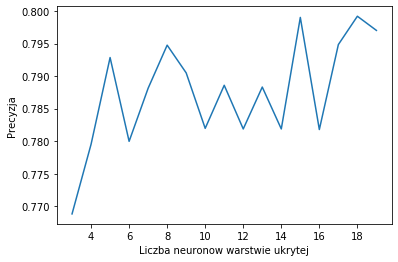

In [19]:
plt.ylabel("Precyzja")
plt.xlabel("Liczba neuronow warstwie ukrytej")
plt.plot(n_value,accuracy_all)

In [20]:
best_one_layer_neurons=[x for (x,y) in zip(n_value,accuracy_all) if y == max(accuracy_all)][0]
best_one_layer_neurons

18

In [21]:
max(accuracy_all)

0.7991847813129425

## Liczba neuronow w warstwach ukrytych w sieci trzywarstwowej

In [62]:
numbers = []
numbers.append(4);
for x in range(4):
    numbers.append(numbers[x]*2)
numbers.append(best_one_layer_neurons)

In [63]:
numbers.sort()
numbers

[4, 8, 16, 18, 32, 64]

In [64]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

history_all = []
accuracy_all = []
n_value = []

In [65]:
for n in numbers:
    kf=KFold(n_splits=20)
    acc = []
    for train_index, test_index in kf.split(X_input):
        model = Sequential()
        model.add(Dense(2*n, input_dim = 11, activation = 'sigmoid'))
        model.add(Dense(n, activation = 'sigmoid'))
        model.add(Dense(4, activation ='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
        history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0, 
             callbacks = [callback_early_stopping])
        y_test,accuracy = model.evaluate(X_test, Y_test)
        acc.append(accuracy)
    accuracy_all.append(statistics.mean(acc))
    n_value.append(n)

23/23 [==============================] - 0s 40us/step


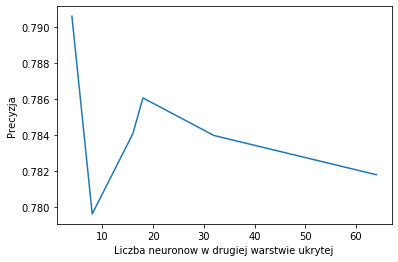

In [66]:
plt.ylabel("Precyzja")
plt.xlabel("Liczba neuronow w drugiej warstwie ukrytej")
plt.plot(n_value,accuracy_all)

In [60]:
best_two_layers_neurons=[x for (x,y) in zip(n_value,accuracy_all) if y == max(accuracy_all)][0]
best_two_layers_neurons

16

In [61]:
max(accuracy_all)

0.7968297094106674

## Funkcja aktywacji - RELU

### Siec dwuwarstwowa

In [69]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

history_all = []
accuracy_all = []
n_value = []

In [70]:
kf=KFold(n_splits=20)
acc = []
for train_index, test_index in kf.split(X_input):
    model = Sequential()
    model.add(Dense(best_one_layer_neurons, input_dim = 11, activation = 'relu'))
    model.add(Dense(4, activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
    history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0, 
         callbacks = [callback_early_stopping])
    y_test,accuracy = model.evaluate(X_test, Y_test)
    acc.append(accuracy)

23/23 [==============================] - 0s 21us/step


In [71]:
print("Accuracy of the model: ",statistics.mean(acc))

Accuracy of the model:  0.7796195685863495


### Siec trzywarstwowa

In [75]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

history_all = []
accuracy_all = []
n_value = []

In [76]:
kf=KFold(n_splits=20)
acc = []
for train_index, test_index in kf.split(X_input):
    model = Sequential()
    model.add(Dense(best_two_layers_neurons * 2, input_dim = 11, activation = 'relu'))
    model.add(Dense(best_two_layers_neurons, activation = 'relu'))
    model.add(Dense(4, activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
    history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0,
         callbacks = [callback_early_stopping])
    y_test,accuracy = model.evaluate(X_test, Y_test)
    acc.append(accuracy)

23/23 [==============================] - 0s 21us/step


In [34]:
print("Accuracy of the model: ",statistics.mean(acc))

Accuracy of the model:  0.7472826078534126


## Dropout

### Siec dwuwarstwowa

In [35]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

kf=KFold(n_splits=20)
acc = []
for train_index, test_index in kf.split(X_input):
    model = Sequential()
    model.add(Dense(best_one_layer_neurons, input_dim = 11, activation = 'sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(4, activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
    history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0, 
         callbacks = [callback_early_stopping])
    y_test,accuracy = model.evaluate(X_test, Y_test)
    acc.append(accuracy)

Train on 372 samples, validate on 66 samples
Epoch 1/150
372/372 [==============================] - 0s 937us/step - loss: 1.4945 - accuracy: 0.2258 - val_loss: 1.4485 - val_accuracy: 0.2273
Epoch 2/150
372/372 [==============================] - 0s 140us/step - loss: 1.3281 - accuracy: 0.3441 - val_loss: 1.3539 - val_accuracy: 0.2576
Epoch 3/150
372/372 [==============================] - 0s 122us/step - loss: 1.2138 - accuracy: 0.4543 - val_loss: 1.2681 - val_accuracy: 0.3485
Epoch 4/150
372/372 [==============================] - 0s 137us/step - loss: 1.1330 - accuracy: 0.5538 - val_loss: 1.1824 - val_accuracy: 0.4091
Epoch 5/150
372/372 [==============================] - 0s 126us/step - loss: 1.0527 - accuracy: 0.5860 - val_loss: 1.0947 - val_accuracy: 0.4848
Epoch 6/150
372/372 [==============================] - 0s 125us/step - loss: 0.9868 - accuracy: 0.6640 - val_loss: 1.0104 - val_accuracy: 0.6212
Epoch 7/150
372/372 [==============================] - 0s 128us/step - loss: 0.9063 -

Epoch 57/150
372/372 [==============================] - 0s 124us/step - loss: 0.4964 - accuracy: 0.8199 - val_loss: 0.5261 - val_accuracy: 0.8182
Epoch 58/150
372/372 [==============================] - 0s 111us/step - loss: 0.4924 - accuracy: 0.8091 - val_loss: 0.5208 - val_accuracy: 0.8182
Epoch 59/150
372/372 [==============================] - 0s 115us/step - loss: 0.4842 - accuracy: 0.8145 - val_loss: 0.5189 - val_accuracy: 0.8182
Epoch 60/150
372/372 [==============================] - 0s 105us/step - loss: 0.4971 - accuracy: 0.8145 - val_loss: 0.5190 - val_accuracy: 0.8182
Epoch 61/150
372/372 [==============================] - 0s 114us/step - loss: 0.4791 - accuracy: 0.8172 - val_loss: 0.5200 - val_accuracy: 0.8182
Epoch 62/150
372/372 [==============================] - 0s 106us/step - loss: 0.4658 - accuracy: 0.8253 - val_loss: 0.5213 - val_accuracy: 0.8182
Epoch 63/150
372/372 [==============================] - 0s 117us/step - loss: 0.4731 - accuracy: 0.8172 - val_loss: 0.5171 -

372/372 [==============================] - 0s 106us/step - loss: 0.4460 - accuracy: 0.8226 - val_loss: 0.4713 - val_accuracy: 0.8182
Epoch 114/150
372/372 [==============================] - 0s 112us/step - loss: 0.4355 - accuracy: 0.8333 - val_loss: 0.4747 - val_accuracy: 0.8182
Epoch 115/150
372/372 [==============================] - 0s 107us/step - loss: 0.4420 - accuracy: 0.8253 - val_loss: 0.4758 - val_accuracy: 0.8182
Epoch 116/150
372/372 [==============================] - 0s 114us/step - loss: 0.4428 - accuracy: 0.8118 - val_loss: 0.4713 - val_accuracy: 0.8182
Epoch 117/150
372/372 [==============================] - 0s 120us/step - loss: 0.4407 - accuracy: 0.8172 - val_loss: 0.4719 - val_accuracy: 0.8182
Epoch 118/150
372/372 [==============================] - 0s 115us/step - loss: 0.4309 - accuracy: 0.8118 - val_loss: 0.4703 - val_accuracy: 0.8182
Epoch 119/150
372/372 [==============================] - 0s 110us/step - loss: 0.4421 - accuracy: 0.8306 - val_loss: 0.4686 - val_ac

372/372 [==============================] - 0s 120us/step - loss: 0.5499 - accuracy: 0.8091 - val_loss: 0.5487 - val_accuracy: 0.8182
Epoch 24/150
372/372 [==============================] - 0s 123us/step - loss: 0.5780 - accuracy: 0.7849 - val_loss: 0.5420 - val_accuracy: 0.8182
Epoch 25/150
372/372 [==============================] - 0s 125us/step - loss: 0.5614 - accuracy: 0.8011 - val_loss: 0.5467 - val_accuracy: 0.8182
Epoch 26/150
372/372 [==============================] - 0s 118us/step - loss: 0.5518 - accuracy: 0.7957 - val_loss: 0.5424 - val_accuracy: 0.8182
Epoch 27/150
372/372 [==============================] - 0s 122us/step - loss: 0.5334 - accuracy: 0.8038 - val_loss: 0.5365 - val_accuracy: 0.8182
Epoch 28/150
372/372 [==============================] - 0s 121us/step - loss: 0.5540 - accuracy: 0.7849 - val_loss: 0.5336 - val_accuracy: 0.8182
Epoch 29/150
372/372 [==============================] - 0s 116us/step - loss: 0.5414 - accuracy: 0.7984 - val_loss: 0.5293 - val_accuracy

373/373 [==============================] - 0s 122us/step - loss: 0.9949 - accuracy: 0.6676 - val_loss: 0.9703 - val_accuracy: 0.7273
Epoch 8/150
373/373 [==============================] - 0s 112us/step - loss: 0.9407 - accuracy: 0.6810 - val_loss: 0.9225 - val_accuracy: 0.7424
Epoch 9/150
373/373 [==============================] - 0s 102us/step - loss: 0.8954 - accuracy: 0.7105 - val_loss: 0.8818 - val_accuracy: 0.7576
Epoch 10/150
373/373 [==============================] - 0s 106us/step - loss: 0.8502 - accuracy: 0.7212 - val_loss: 0.8431 - val_accuracy: 0.7727
Epoch 11/150
373/373 [==============================] - 0s 104us/step - loss: 0.8102 - accuracy: 0.7185 - val_loss: 0.8099 - val_accuracy: 0.7424
Epoch 12/150
373/373 [==============================] - 0s 117us/step - loss: 0.7891 - accuracy: 0.7453 - val_loss: 0.7888 - val_accuracy: 0.7727
Epoch 13/150
373/373 [==============================] - 0s 108us/step - loss: 0.7685 - accuracy: 0.7614 - val_loss: 0.7649 - val_accuracy: 

373/373 [==============================] - 0s 133us/step - loss: 0.4951 - accuracy: 0.8150 - val_loss: 0.5151 - val_accuracy: 0.8182
Epoch 64/150
373/373 [==============================] - 0s 118us/step - loss: 0.4767 - accuracy: 0.8204 - val_loss: 0.5166 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 121us/step - loss: 0.4935 - accuracy: 0.8284 - val_loss: 0.5166 - val_accuracy: 0.8182
Epoch 66/150
373/373 [==============================] - 0s 121us/step - loss: 0.4776 - accuracy: 0.8097 - val_loss: 0.5161 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 116us/step - loss: 0.4774 - accuracy: 0.8204 - val_loss: 0.5132 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 130us/step - loss: 0.5060 - accuracy: 0.8177 - val_loss: 0.5121 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 120us/step - loss: 0.5019 - accuracy: 0.8123 - val_loss: 0.5066 - val_accuracy

373/373 [==============================] - 0s 113us/step - loss: 0.8176 - accuracy: 0.7399 - val_loss: 0.7671 - val_accuracy: 0.7576
Epoch 11/150
373/373 [==============================] - 0s 115us/step - loss: 0.7824 - accuracy: 0.7265 - val_loss: 0.7372 - val_accuracy: 0.7576
Epoch 12/150
373/373 [==============================] - 0s 107us/step - loss: 0.7605 - accuracy: 0.7212 - val_loss: 0.7167 - val_accuracy: 0.7576
Epoch 13/150
373/373 [==============================] - 0s 107us/step - loss: 0.7404 - accuracy: 0.7399 - val_loss: 0.6954 - val_accuracy: 0.7727
Epoch 14/150
373/373 [==============================] - 0s 115us/step - loss: 0.7165 - accuracy: 0.7453 - val_loss: 0.6766 - val_accuracy: 0.7727
Epoch 15/150
373/373 [==============================] - 0s 105us/step - loss: 0.6940 - accuracy: 0.7614 - val_loss: 0.6569 - val_accuracy: 0.7879
Epoch 16/150
373/373 [==============================] - 0s 116us/step - loss: 0.6646 - accuracy: 0.7721 - val_loss: 0.6424 - val_accuracy

373/373 [==============================] - 0s 133us/step - loss: 0.4978 - accuracy: 0.8097 - val_loss: 0.4756 - val_accuracy: 0.8182
Epoch 67/150
373/373 [==============================] - 0s 139us/step - loss: 0.5085 - accuracy: 0.8043 - val_loss: 0.4794 - val_accuracy: 0.8182
Epoch 68/150
373/373 [==============================] - 0s 127us/step - loss: 0.5144 - accuracy: 0.8016 - val_loss: 0.4760 - val_accuracy: 0.8182
Epoch 69/150
373/373 [==============================] - 0s 133us/step - loss: 0.5060 - accuracy: 0.7882 - val_loss: 0.4751 - val_accuracy: 0.8182
Epoch 70/150
373/373 [==============================] - 0s 190us/step - loss: 0.4950 - accuracy: 0.7989 - val_loss: 0.4737 - val_accuracy: 0.8182
Epoch 71/150
373/373 [==============================] - 0s 205us/step - loss: 0.4917 - accuracy: 0.8231 - val_loss: 0.4734 - val_accuracy: 0.8182
Epoch 72/150
373/373 [==============================] - 0s 132us/step - loss: 0.4849 - accuracy: 0.8070 - val_loss: 0.4669 - val_accuracy

373/373 [==============================] - 0s 118us/step - loss: 0.5720 - accuracy: 0.7587 - val_loss: 0.5545 - val_accuracy: 0.7576
Epoch 39/150
373/373 [==============================] - 0s 115us/step - loss: 0.5676 - accuracy: 0.7855 - val_loss: 0.5506 - val_accuracy: 0.7576
Epoch 40/150
373/373 [==============================] - 0s 103us/step - loss: 0.5558 - accuracy: 0.7936 - val_loss: 0.5485 - val_accuracy: 0.7576
Epoch 41/150
373/373 [==============================] - 0s 104us/step - loss: 0.5656 - accuracy: 0.8016 - val_loss: 0.5461 - val_accuracy: 0.7576
Epoch 42/150
373/373 [==============================] - 0s 105us/step - loss: 0.5649 - accuracy: 0.7775 - val_loss: 0.5434 - val_accuracy: 0.7576
Epoch 43/150
373/373 [==============================] - 0s 110us/step - loss: 0.5504 - accuracy: 0.7936 - val_loss: 0.5402 - val_accuracy: 0.7576
Epoch 44/150
373/373 [==============================] - 0s 107us/step - loss: 0.5319 - accuracy: 0.7855 - val_loss: 0.5377 - val_accuracy

373/373 [==============================] - 0s 113us/step - loss: 0.4917 - accuracy: 0.8123 - val_loss: 0.4982 - val_accuracy: 0.7727
Epoch 95/150
373/373 [==============================] - 0s 113us/step - loss: 0.5099 - accuracy: 0.8043 - val_loss: 0.5006 - val_accuracy: 0.7727
Epoch 96/150
373/373 [==============================] - 0s 116us/step - loss: 0.5077 - accuracy: 0.7882 - val_loss: 0.4990 - val_accuracy: 0.7727
Epoch 97/150
373/373 [==============================] - 0s 110us/step - loss: 0.5061 - accuracy: 0.7962 - val_loss: 0.4985 - val_accuracy: 0.7727
Epoch 98/150
373/373 [==============================] - 0s 106us/step - loss: 0.4800 - accuracy: 0.8070 - val_loss: 0.5004 - val_accuracy: 0.7727
Epoch 99/150
373/373 [==============================] - 0s 108us/step - loss: 0.4781 - accuracy: 0.7962 - val_loss: 0.4992 - val_accuracy: 0.7727
Epoch 100/150
373/373 [==============================] - 0s 106us/step - loss: 0.4852 - accuracy: 0.7936 - val_loss: 0.4999 - val_accurac

373/373 [==============================] - 0s 106us/step - loss: 0.5410 - accuracy: 0.7989 - val_loss: 0.5349 - val_accuracy: 0.7576
Epoch 49/150
373/373 [==============================] - 0s 108us/step - loss: 0.5135 - accuracy: 0.8016 - val_loss: 0.5336 - val_accuracy: 0.7576
Epoch 50/150
373/373 [==============================] - 0s 114us/step - loss: 0.5445 - accuracy: 0.7909 - val_loss: 0.5304 - val_accuracy: 0.7576
Epoch 51/150
373/373 [==============================] - 0s 105us/step - loss: 0.5254 - accuracy: 0.7909 - val_loss: 0.5263 - val_accuracy: 0.7576
Epoch 52/150
373/373 [==============================] - 0s 103us/step - loss: 0.5464 - accuracy: 0.7936 - val_loss: 0.5231 - val_accuracy: 0.7576
Epoch 53/150
373/373 [==============================] - 0s 106us/step - loss: 0.5283 - accuracy: 0.7989 - val_loss: 0.5249 - val_accuracy: 0.7576
Epoch 54/150
373/373 [==============================] - 0s 117us/step - loss: 0.5388 - accuracy: 0.7882 - val_loss: 0.5193 - val_accuracy

373/373 [==============================] - 0s 108us/step - loss: 0.5056 - accuracy: 0.7962 - val_loss: 0.4982 - val_accuracy: 0.7727
Epoch 105/150
373/373 [==============================] - 0s 112us/step - loss: 0.4809 - accuracy: 0.8204 - val_loss: 0.4973 - val_accuracy: 0.7727
Epoch 106/150
373/373 [==============================] - 0s 106us/step - loss: 0.4836 - accuracy: 0.8204 - val_loss: 0.4976 - val_accuracy: 0.7727
Epoch 107/150
373/373 [==============================] - 0s 104us/step - loss: 0.4764 - accuracy: 0.8097 - val_loss: 0.5009 - val_accuracy: 0.7727
Epoch 108/150
373/373 [==============================] - 0s 103us/step - loss: 0.5059 - accuracy: 0.8043 - val_loss: 0.4999 - val_accuracy: 0.7727
Epoch 109/150
373/373 [==============================] - 0s 113us/step - loss: 0.4893 - accuracy: 0.8097 - val_loss: 0.4995 - val_accuracy: 0.7727
Epoch 110/150
373/373 [==============================] - 0s 103us/step - loss: 0.4684 - accuracy: 0.8123 - val_loss: 0.4969 - val_ac

373/373 [==============================] - 0s 109us/step - loss: 0.6469 - accuracy: 0.7560 - val_loss: 0.5921 - val_accuracy: 0.8182
Epoch 25/150
373/373 [==============================] - 0s 108us/step - loss: 0.6313 - accuracy: 0.7641 - val_loss: 0.5833 - val_accuracy: 0.8182
Epoch 26/150
373/373 [==============================] - 0s 109us/step - loss: 0.6079 - accuracy: 0.7802 - val_loss: 0.5770 - val_accuracy: 0.8182
Epoch 27/150
373/373 [==============================] - 0s 108us/step - loss: 0.6243 - accuracy: 0.7802 - val_loss: 0.5702 - val_accuracy: 0.8182
Epoch 28/150
373/373 [==============================] - 0s 112us/step - loss: 0.5859 - accuracy: 0.7882 - val_loss: 0.5606 - val_accuracy: 0.8182
Epoch 29/150
373/373 [==============================] - 0s 117us/step - loss: 0.5913 - accuracy: 0.8043 - val_loss: 0.5585 - val_accuracy: 0.8030
Epoch 30/150
373/373 [==============================] - 0s 139us/step - loss: 0.5984 - accuracy: 0.7909 - val_loss: 0.5552 - val_accuracy

373/373 [==============================] - 0s 123us/step - loss: 0.5066 - accuracy: 0.8043 - val_loss: 0.4999 - val_accuracy: 0.8030
Epoch 81/150
373/373 [==============================] - 0s 107us/step - loss: 0.4749 - accuracy: 0.8231 - val_loss: 0.4991 - val_accuracy: 0.8030
Epoch 82/150
373/373 [==============================] - 0s 111us/step - loss: 0.4902 - accuracy: 0.8123 - val_loss: 0.5005 - val_accuracy: 0.8182
Epoch 83/150
373/373 [==============================] - 0s 139us/step - loss: 0.4825 - accuracy: 0.8204 - val_loss: 0.5000 - val_accuracy: 0.8182
Epoch 84/150
373/373 [==============================] - 0s 120us/step - loss: 0.4690 - accuracy: 0.8177 - val_loss: 0.5007 - val_accuracy: 0.8182
Epoch 85/150
373/373 [==============================] - 0s 127us/step - loss: 0.5002 - accuracy: 0.8016 - val_loss: 0.5001 - val_accuracy: 0.8182
Epoch 86/150
373/373 [==============================] - 0s 125us/step - loss: 0.5062 - accuracy: 0.7936 - val_loss: 0.5001 - val_accuracy

373/373 [==============================] - 0s 128us/step - loss: 0.7069 - accuracy: 0.7641 - val_loss: 0.6620 - val_accuracy: 0.7879
Epoch 15/150
373/373 [==============================] - 0s 130us/step - loss: 0.6893 - accuracy: 0.7534 - val_loss: 0.6489 - val_accuracy: 0.7879
Epoch 16/150
373/373 [==============================] - 0s 132us/step - loss: 0.6628 - accuracy: 0.7775 - val_loss: 0.6366 - val_accuracy: 0.7879
Epoch 17/150
373/373 [==============================] - 0s 141us/step - loss: 0.6262 - accuracy: 0.7936 - val_loss: 0.6256 - val_accuracy: 0.7879
Epoch 18/150
373/373 [==============================] - 0s 131us/step - loss: 0.6329 - accuracy: 0.7802 - val_loss: 0.6159 - val_accuracy: 0.7727
Epoch 19/150
373/373 [==============================] - 0s 129us/step - loss: 0.6282 - accuracy: 0.7802 - val_loss: 0.6050 - val_accuracy: 0.7727
Epoch 20/150
373/373 [==============================] - 0s 127us/step - loss: 0.6121 - accuracy: 0.7962 - val_loss: 0.5975 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 0.4766 - accuracy: 0.8097 - val_loss: 0.5201 - val_accuracy: 0.7879
Epoch 71/150
373/373 [==============================] - 0s 117us/step - loss: 0.4791 - accuracy: 0.8123 - val_loss: 0.5164 - val_accuracy: 0.7879
Epoch 72/150
373/373 [==============================] - 0s 115us/step - loss: 0.4880 - accuracy: 0.8043 - val_loss: 0.5172 - val_accuracy: 0.7879
Epoch 73/150
373/373 [==============================] - 0s 192us/step - loss: 0.4775 - accuracy: 0.8177 - val_loss: 0.5150 - val_accuracy: 0.7727
Epoch 74/150
373/373 [==============================] - 0s 230us/step - loss: 0.4733 - accuracy: 0.8204 - val_loss: 0.5161 - val_accuracy: 0.7727
Epoch 75/150
373/373 [==============================] - 0s 160us/step - loss: 0.4756 - accuracy: 0.8043 - val_loss: 0.5140 - val_accuracy: 0.7727
Epoch 76/150
373/373 [==============================] - 0s 141us/step - loss: 0.4823 - accuracy: 0.8043 - val_loss: 0.5131 - val_accuracy

373/373 [==============================] - 0s 110us/step - loss: 0.4542 - accuracy: 0.8043 - val_loss: 0.4886 - val_accuracy: 0.7879
Epoch 127/150
373/373 [==============================] - 0s 120us/step - loss: 0.4570 - accuracy: 0.8204 - val_loss: 0.4879 - val_accuracy: 0.7879
Epoch 128/150
373/373 [==============================] - 0s 115us/step - loss: 0.4483 - accuracy: 0.8177 - val_loss: 0.4904 - val_accuracy: 0.7879
Epoch 129/150
373/373 [==============================] - 0s 118us/step - loss: 0.4479 - accuracy: 0.8338 - val_loss: 0.4910 - val_accuracy: 0.7879
Epoch 130/150
373/373 [==============================] - 0s 129us/step - loss: 0.4597 - accuracy: 0.8150 - val_loss: 0.4819 - val_accuracy: 0.7879
Epoch 131/150
373/373 [==============================] - 0s 136us/step - loss: 0.4541 - accuracy: 0.8365 - val_loss: 0.4838 - val_accuracy: 0.7879
Epoch 132/150
373/373 [==============================] - 0s 123us/step - loss: 0.4318 - accuracy: 0.8177 - val_loss: 0.4840 - val_ac

373/373 [==============================] - 0s 112us/step - loss: 0.5812 - accuracy: 0.7775 - val_loss: 0.5557 - val_accuracy: 0.8182
Epoch 32/150
373/373 [==============================] - 0s 125us/step - loss: 0.5949 - accuracy: 0.7828 - val_loss: 0.5496 - val_accuracy: 0.8182
Epoch 33/150
373/373 [==============================] - 0s 112us/step - loss: 0.5592 - accuracy: 0.7748 - val_loss: 0.5477 - val_accuracy: 0.8182
Epoch 34/150
373/373 [==============================] - 0s 110us/step - loss: 0.5711 - accuracy: 0.7936 - val_loss: 0.5402 - val_accuracy: 0.8182
Epoch 35/150
373/373 [==============================] - 0s 117us/step - loss: 0.5709 - accuracy: 0.7909 - val_loss: 0.5365 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 115us/step - loss: 0.5426 - accuracy: 0.7989 - val_loss: 0.5324 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 112us/step - loss: 0.5510 - accuracy: 0.7882 - val_loss: 0.5300 - val_accuracy

373/373 [==============================] - 0s 127us/step - loss: 0.4761 - accuracy: 0.8070 - val_loss: 0.4557 - val_accuracy: 0.8182
Epoch 88/150
373/373 [==============================] - 0s 119us/step - loss: 0.4613 - accuracy: 0.8284 - val_loss: 0.4529 - val_accuracy: 0.8182
Epoch 89/150
373/373 [==============================] - 0s 114us/step - loss: 0.4732 - accuracy: 0.8150 - val_loss: 0.4520 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 113us/step - loss: 0.4819 - accuracy: 0.8070 - val_loss: 0.4517 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 121us/step - loss: 0.4822 - accuracy: 0.8070 - val_loss: 0.4481 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 114us/step - loss: 0.4767 - accuracy: 0.8070 - val_loss: 0.4499 - val_accuracy: 0.8182
Epoch 93/150
373/373 [==============================] - 0s 116us/step - loss: 0.4746 - accuracy: 0.8043 - val_loss: 0.4492 - val_accuracy

Epoch 143/150
373/373 [==============================] - 0s 121us/step - loss: 0.4503 - accuracy: 0.8123 - val_loss: 0.4338 - val_accuracy: 0.8182
Epoch 144/150
373/373 [==============================] - 0s 113us/step - loss: 0.4457 - accuracy: 0.8123 - val_loss: 0.4315 - val_accuracy: 0.8182
Epoch 145/150
373/373 [==============================] - 0s 116us/step - loss: 0.4436 - accuracy: 0.8204 - val_loss: 0.4305 - val_accuracy: 0.8182
Epoch 146/150
373/373 [==============================] - 0s 122us/step - loss: 0.4492 - accuracy: 0.8043 - val_loss: 0.4311 - val_accuracy: 0.8182
Epoch 147/150
373/373 [==============================] - 0s 113us/step - loss: 0.4490 - accuracy: 0.8231 - val_loss: 0.4314 - val_accuracy: 0.8182
Epoch 148/150
23/23 [==============================] - 0s 39us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 438us/step - loss: 1.5991 - accuracy: 0.2922 - val_loss: 1.4486 - val_accuracy: 0.3333
Epoch 2

373/373 [==============================] - 0s 113us/step - loss: 0.5324 - accuracy: 0.7909 - val_loss: 0.5106 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 113us/step - loss: 0.5301 - accuracy: 0.7775 - val_loss: 0.5135 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 115us/step - loss: 0.5249 - accuracy: 0.7989 - val_loss: 0.5060 - val_accuracy: 0.8030
Epoch 53/150
373/373 [==============================] - 0s 110us/step - loss: 0.5273 - accuracy: 0.7882 - val_loss: 0.5060 - val_accuracy: 0.8182
Epoch 54/150
373/373 [==============================] - 0s 115us/step - loss: 0.5219 - accuracy: 0.8097 - val_loss: 0.5102 - val_accuracy: 0.8182
Epoch 55/150
373/373 [==============================] - 0s 109us/step - loss: 0.5104 - accuracy: 0.7882 - val_loss: 0.5103 - val_accuracy: 0.8182
Epoch 56/150
373/373 [==============================] - 0s 112us/step - loss: 0.5208 - accuracy: 0.8043 - val_loss: 0.5063 - val_accuracy

373/373 [==============================] - 0s 121us/step - loss: 0.9815 - accuracy: 0.6327 - val_loss: 0.9730 - val_accuracy: 0.6061
Epoch 9/150
373/373 [==============================] - 0s 115us/step - loss: 0.9593 - accuracy: 0.6568 - val_loss: 0.9208 - val_accuracy: 0.7121
Epoch 10/150
373/373 [==============================] - 0s 109us/step - loss: 0.9125 - accuracy: 0.6702 - val_loss: 0.8721 - val_accuracy: 0.7879
Epoch 11/150
373/373 [==============================] - 0s 113us/step - loss: 0.8609 - accuracy: 0.7078 - val_loss: 0.8325 - val_accuracy: 0.7727
Epoch 12/150
373/373 [==============================] - 0s 108us/step - loss: 0.8272 - accuracy: 0.7453 - val_loss: 0.7907 - val_accuracy: 0.8030
Epoch 13/150
373/373 [==============================] - 0s 104us/step - loss: 0.8108 - accuracy: 0.7399 - val_loss: 0.7616 - val_accuracy: 0.7727
Epoch 14/150
373/373 [==============================] - 0s 107us/step - loss: 0.7862 - accuracy: 0.7373 - val_loss: 0.7355 - val_accuracy:

373/373 [==============================] - 0s 113us/step - loss: 0.5345 - accuracy: 0.8016 - val_loss: 0.5308 - val_accuracy: 0.8030
Epoch 65/150
373/373 [==============================] - 0s 113us/step - loss: 0.5389 - accuracy: 0.7909 - val_loss: 0.5303 - val_accuracy: 0.8030
Epoch 66/150
373/373 [==============================] - 0s 109us/step - loss: 0.5262 - accuracy: 0.7909 - val_loss: 0.5265 - val_accuracy: 0.8030
Epoch 67/150
373/373 [==============================] - 0s 112us/step - loss: 0.5341 - accuracy: 0.8123 - val_loss: 0.5257 - val_accuracy: 0.8030
Epoch 68/150
373/373 [==============================] - 0s 108us/step - loss: 0.5198 - accuracy: 0.7936 - val_loss: 0.5254 - val_accuracy: 0.8030
Epoch 69/150
373/373 [==============================] - 0s 107us/step - loss: 0.5275 - accuracy: 0.8043 - val_loss: 0.5244 - val_accuracy: 0.8030
Epoch 70/150
373/373 [==============================] - 0s 105us/step - loss: 0.5145 - accuracy: 0.7989 - val_loss: 0.5214 - val_accuracy

373/373 [==============================] - 0s 109us/step - loss: 0.4865 - accuracy: 0.8177 - val_loss: 0.4854 - val_accuracy: 0.8333
Epoch 121/150
373/373 [==============================] - 0s 114us/step - loss: 0.4978 - accuracy: 0.8016 - val_loss: 0.4830 - val_accuracy: 0.8182
Epoch 122/150
373/373 [==============================] - 0s 112us/step - loss: 0.4725 - accuracy: 0.8016 - val_loss: 0.4850 - val_accuracy: 0.8182
Epoch 123/150
373/373 [==============================] - 0s 130us/step - loss: 0.4861 - accuracy: 0.7962 - val_loss: 0.4855 - val_accuracy: 0.8182
Epoch 124/150
373/373 [==============================] - 0s 112us/step - loss: 0.4996 - accuracy: 0.8043 - val_loss: 0.4831 - val_accuracy: 0.8182
Epoch 125/150
373/373 [==============================] - 0s 110us/step - loss: 0.4677 - accuracy: 0.8177 - val_loss: 0.4831 - val_accuracy: 0.8182
Epoch 126/150
373/373 [==============================] - 0s 116us/step - loss: 0.4906 - accuracy: 0.8150 - val_loss: 0.4816 - val_ac

373/373 [==============================] - 0s 130us/step - loss: 0.5171 - accuracy: 0.8123 - val_loss: 0.5488 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 128us/step - loss: 0.5062 - accuracy: 0.8177 - val_loss: 0.5476 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 137us/step - loss: 0.5017 - accuracy: 0.8070 - val_loss: 0.5477 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 132us/step - loss: 0.5108 - accuracy: 0.7989 - val_loss: 0.5500 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 125us/step - loss: 0.5049 - accuracy: 0.8204 - val_loss: 0.5514 - val_accuracy: 0.8182
Epoch 52/150
373/373 [==============================] - 0s 125us/step - loss: 0.4990 - accuracy: 0.8016 - val_loss: 0.5456 - val_accuracy: 0.8182
Epoch 53/150
373/373 [==============================] - 0s 134us/step - loss: 0.5060 - accuracy: 0.8097 - val_loss: 0.5477 - val_accuracy

373/373 [==============================] - 0s 122us/step - loss: 0.5218 - accuracy: 0.8177 - val_loss: 0.5302 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 120us/step - loss: 0.5401 - accuracy: 0.8070 - val_loss: 0.5265 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 118us/step - loss: 0.5436 - accuracy: 0.7909 - val_loss: 0.5244 - val_accuracy: 0.8182
Epoch 37/150
373/373 [==============================] - 0s 118us/step - loss: 0.5379 - accuracy: 0.8070 - val_loss: 0.5235 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 118us/step - loss: 0.5247 - accuracy: 0.8123 - val_loss: 0.5208 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 115us/step - loss: 0.5247 - accuracy: 0.8231 - val_loss: 0.5187 - val_accuracy: 0.7879
Epoch 40/150
373/373 [==============================] - 0s 118us/step - loss: 0.5136 - accuracy: 0.8070 - val_loss: 0.5167 - val_accuracy

23/23 [==============================] - 0s 84us/step
Train on 373 samples, validate on 66 samples
Epoch 1/150
373/373 [==============================] - 0s 446us/step - loss: 1.4189 - accuracy: 0.3164 - val_loss: 1.3141 - val_accuracy: 0.3485
Epoch 2/150
373/373 [==============================] - 0s 116us/step - loss: 1.2623 - accuracy: 0.4075 - val_loss: 1.2111 - val_accuracy: 0.4848
Epoch 3/150
373/373 [==============================] - 0s 122us/step - loss: 1.1830 - accuracy: 0.4906 - val_loss: 1.1120 - val_accuracy: 0.6364
Epoch 4/150
373/373 [==============================] - 0s 119us/step - loss: 1.0806 - accuracy: 0.6193 - val_loss: 1.0228 - val_accuracy: 0.7576
Epoch 5/150
373/373 [==============================] - 0s 125us/step - loss: 1.0218 - accuracy: 0.6461 - val_loss: 0.9412 - val_accuracy: 0.7879
Epoch 6/150
373/373 [==============================] - 0s 119us/step - loss: 0.9369 - accuracy: 0.7158 - val_loss: 0.8811 - val_accuracy: 0.8030
Epoch 7/150
373/373 [==========

373/373 [==============================] - 0s 114us/step - loss: 0.4815 - accuracy: 0.8070 - val_loss: 0.4747 - val_accuracy: 0.8030
Epoch 56/150
373/373 [==============================] - 0s 119us/step - loss: 0.5003 - accuracy: 0.8070 - val_loss: 0.4772 - val_accuracy: 0.7879
Epoch 57/150
373/373 [==============================] - 0s 110us/step - loss: 0.4954 - accuracy: 0.8043 - val_loss: 0.4755 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 105us/step - loss: 0.4912 - accuracy: 0.7909 - val_loss: 0.4745 - val_accuracy: 0.7727
Epoch 59/150
373/373 [==============================] - 0s 109us/step - loss: 0.4768 - accuracy: 0.8097 - val_loss: 0.4711 - val_accuracy: 0.8030
Epoch 60/150
373/373 [==============================] - 0s 106us/step - loss: 0.4632 - accuracy: 0.8150 - val_loss: 0.4737 - val_accuracy: 0.8030
Epoch 61/150
373/373 [==============================] - 0s 114us/step - loss: 0.5049 - accuracy: 0.8097 - val_loss: 0.4740 - val_accuracy

373/373 [==============================] - 0s 112us/step - loss: 0.4325 - accuracy: 0.8231 - val_loss: 0.4451 - val_accuracy: 0.8030
Epoch 112/150
373/373 [==============================] - 0s 123us/step - loss: 0.4496 - accuracy: 0.8043 - val_loss: 0.4476 - val_accuracy: 0.8030
Epoch 113/150
373/373 [==============================] - 0s 115us/step - loss: 0.4459 - accuracy: 0.8284 - val_loss: 0.4519 - val_accuracy: 0.8030
Epoch 114/150
373/373 [==============================] - 0s 114us/step - loss: 0.4390 - accuracy: 0.8231 - val_loss: 0.4539 - val_accuracy: 0.8030
Epoch 115/150
373/373 [==============================] - 0s 117us/step - loss: 0.4677 - accuracy: 0.8043 - val_loss: 0.4524 - val_accuracy: 0.7879
Epoch 116/150
373/373 [==============================] - 0s 110us/step - loss: 0.4536 - accuracy: 0.8043 - val_loss: 0.4500 - val_accuracy: 0.7879
Epoch 117/150
373/373 [==============================] - 0s 110us/step - loss: 0.4358 - accuracy: 0.8257 - val_loss: 0.4445 - val_ac

373/373 [==============================] - 0s 122us/step - loss: 0.5572 - accuracy: 0.8043 - val_loss: 0.5942 - val_accuracy: 0.8030
Epoch 34/150
373/373 [==============================] - 0s 125us/step - loss: 0.5584 - accuracy: 0.8016 - val_loss: 0.5914 - val_accuracy: 0.8030
Epoch 35/150
373/373 [==============================] - 0s 119us/step - loss: 0.5440 - accuracy: 0.7962 - val_loss: 0.5941 - val_accuracy: 0.8030
Epoch 36/150
373/373 [==============================] - 0s 124us/step - loss: 0.5316 - accuracy: 0.8070 - val_loss: 0.5899 - val_accuracy: 0.8030
Epoch 37/150
373/373 [==============================] - 0s 120us/step - loss: 0.5433 - accuracy: 0.7989 - val_loss: 0.5868 - val_accuracy: 0.8030
Epoch 38/150
373/373 [==============================] - 0s 120us/step - loss: 0.5374 - accuracy: 0.7962 - val_loss: 0.5874 - val_accuracy: 0.8030
Epoch 39/150
373/373 [==============================] - 0s 128us/step - loss: 0.5300 - accuracy: 0.8097 - val_loss: 0.5820 - val_accuracy

373/373 [==============================] - 0s 118us/step - loss: 0.4703 - accuracy: 0.8231 - val_loss: 0.5649 - val_accuracy: 0.8182
Epoch 90/150
373/373 [==============================] - 0s 123us/step - loss: 0.4650 - accuracy: 0.8284 - val_loss: 0.5590 - val_accuracy: 0.8182
Epoch 91/150
373/373 [==============================] - 0s 118us/step - loss: 0.4687 - accuracy: 0.8257 - val_loss: 0.5604 - val_accuracy: 0.8182
Epoch 92/150
373/373 [==============================] - 0s 120us/step - loss: 0.4482 - accuracy: 0.8177 - val_loss: 0.5582 - val_accuracy: 0.8030
Epoch 93/150
373/373 [==============================] - 0s 120us/step - loss: 0.4597 - accuracy: 0.8043 - val_loss: 0.5638 - val_accuracy: 0.8030
Epoch 94/150
373/373 [==============================] - 0s 125us/step - loss: 0.4648 - accuracy: 0.8231 - val_loss: 0.5652 - val_accuracy: 0.8182
Epoch 95/150
373/373 [==============================] - 0s 114us/step - loss: 0.4422 - accuracy: 0.8338 - val_loss: 0.5659 - val_accuracy

373/373 [==============================] - 0s 122us/step - loss: 0.5262 - accuracy: 0.7936 - val_loss: 0.5543 - val_accuracy: 0.8030
Epoch 43/150
373/373 [==============================] - 0s 126us/step - loss: 0.5500 - accuracy: 0.7962 - val_loss: 0.5556 - val_accuracy: 0.8030
Epoch 44/150
373/373 [==============================] - 0s 125us/step - loss: 0.5355 - accuracy: 0.8097 - val_loss: 0.5542 - val_accuracy: 0.8030
Epoch 45/150
373/373 [==============================] - 0s 109us/step - loss: 0.5351 - accuracy: 0.8016 - val_loss: 0.5540 - val_accuracy: 0.8030
Epoch 46/150
373/373 [==============================] - 0s 108us/step - loss: 0.5541 - accuracy: 0.7748 - val_loss: 0.5528 - val_accuracy: 0.8030
Epoch 47/150
373/373 [==============================] - 0s 107us/step - loss: 0.5401 - accuracy: 0.7909 - val_loss: 0.5523 - val_accuracy: 0.8030
Epoch 48/150
373/373 [==============================] - 0s 115us/step - loss: 0.5368 - accuracy: 0.7882 - val_loss: 0.5572 - val_accuracy

373/373 [==============================] - 0s 126us/step - loss: 0.4672 - accuracy: 0.8177 - val_loss: 0.5040 - val_accuracy: 0.8030
Epoch 99/150
373/373 [==============================] - 0s 117us/step - loss: 0.4871 - accuracy: 0.8016 - val_loss: 0.5093 - val_accuracy: 0.7879
Epoch 100/150
373/373 [==============================] - 0s 118us/step - loss: 0.4732 - accuracy: 0.8150 - val_loss: 0.5075 - val_accuracy: 0.7879
Epoch 101/150
373/373 [==============================] - 0s 128us/step - loss: 0.4742 - accuracy: 0.8043 - val_loss: 0.5065 - val_accuracy: 0.7879
Epoch 102/150
373/373 [==============================] - 0s 120us/step - loss: 0.4763 - accuracy: 0.8204 - val_loss: 0.5091 - val_accuracy: 0.7879
Epoch 103/150
373/373 [==============================] - 0s 128us/step - loss: 0.4638 - accuracy: 0.8177 - val_loss: 0.5094 - val_accuracy: 0.7879
Epoch 104/150
373/373 [==============================] - 0s 118us/step - loss: 0.4629 - accuracy: 0.8231 - val_loss: 0.5075 - val_acc

373/373 [==============================] - 0s 113us/step - loss: 0.5167 - accuracy: 0.8043 - val_loss: 0.4988 - val_accuracy: 0.8182
Epoch 46/150
373/373 [==============================] - 0s 118us/step - loss: 0.5079 - accuracy: 0.8070 - val_loss: 0.4918 - val_accuracy: 0.8182
Epoch 47/150
373/373 [==============================] - 0s 123us/step - loss: 0.5198 - accuracy: 0.7909 - val_loss: 0.4881 - val_accuracy: 0.8182
Epoch 48/150
373/373 [==============================] - 0s 121us/step - loss: 0.4933 - accuracy: 0.8043 - val_loss: 0.4895 - val_accuracy: 0.8182
Epoch 49/150
373/373 [==============================] - 0s 144us/step - loss: 0.4948 - accuracy: 0.8016 - val_loss: 0.4890 - val_accuracy: 0.8182
Epoch 50/150
373/373 [==============================] - 0s 111us/step - loss: 0.5044 - accuracy: 0.7989 - val_loss: 0.4891 - val_accuracy: 0.8182
Epoch 51/150
373/373 [==============================] - 0s 109us/step - loss: 0.4963 - accuracy: 0.8070 - val_loss: 0.4878 - val_accuracy

373/373 [==============================] - 0s 381us/step - loss: 1.4320 - accuracy: 0.2547 - val_loss: 1.3349 - val_accuracy: 0.3636
Epoch 2/150
373/373 [==============================] - 0s 120us/step - loss: 1.2985 - accuracy: 0.4021 - val_loss: 1.2409 - val_accuracy: 0.4848
Epoch 3/150
373/373 [==============================] - 0s 128us/step - loss: 1.2471 - accuracy: 0.4263 - val_loss: 1.1700 - val_accuracy: 0.6061
Epoch 4/150
373/373 [==============================] - 0s 121us/step - loss: 1.1343 - accuracy: 0.5469 - val_loss: 1.1117 - val_accuracy: 0.5909
Epoch 5/150
373/373 [==============================] - 0s 119us/step - loss: 1.1224 - accuracy: 0.5496 - val_loss: 1.0604 - val_accuracy: 0.6061
Epoch 6/150
373/373 [==============================] - 0s 109us/step - loss: 1.0275 - accuracy: 0.6381 - val_loss: 1.0190 - val_accuracy: 0.6061
Epoch 7/150
373/373 [==============================] - 0s 114us/step - loss: 0.9881 - accuracy: 0.6542 - val_loss: 0.9805 - val_accuracy: 0.62

373/373 [==============================] - 0s 117us/step - loss: 0.5313 - accuracy: 0.8016 - val_loss: 0.5854 - val_accuracy: 0.7879
Epoch 58/150
373/373 [==============================] - 0s 119us/step - loss: 0.5118 - accuracy: 0.8070 - val_loss: 0.5823 - val_accuracy: 0.7879
Epoch 59/150
373/373 [==============================] - 0s 107us/step - loss: 0.5149 - accuracy: 0.7936 - val_loss: 0.5832 - val_accuracy: 0.7879
Epoch 60/150
373/373 [==============================] - 0s 106us/step - loss: 0.5195 - accuracy: 0.8016 - val_loss: 0.5809 - val_accuracy: 0.7879
Epoch 61/150
373/373 [==============================] - 0s 107us/step - loss: 0.5275 - accuracy: 0.7828 - val_loss: 0.5809 - val_accuracy: 0.8030
Epoch 62/150
373/373 [==============================] - 0s 119us/step - loss: 0.5094 - accuracy: 0.7909 - val_loss: 0.5785 - val_accuracy: 0.7879
Epoch 63/150
373/373 [==============================] - 0s 120us/step - loss: 0.5121 - accuracy: 0.7909 - val_loss: 0.5764 - val_accuracy

373/373 [==============================] - 0s 107us/step - loss: 0.5544 - accuracy: 0.7855 - val_loss: 0.3973 - val_accuracy: 0.8333
Epoch 40/150
373/373 [==============================] - 0s 115us/step - loss: 0.5724 - accuracy: 0.7775 - val_loss: 0.3919 - val_accuracy: 0.8333
Epoch 41/150
373/373 [==============================] - 0s 105us/step - loss: 0.5481 - accuracy: 0.7668 - val_loss: 0.3878 - val_accuracy: 0.8333
Epoch 42/150
373/373 [==============================] - 0s 112us/step - loss: 0.5816 - accuracy: 0.7668 - val_loss: 0.3880 - val_accuracy: 0.8333
Epoch 43/150
373/373 [==============================] - 0s 105us/step - loss: 0.5591 - accuracy: 0.7828 - val_loss: 0.3856 - val_accuracy: 0.8333
Epoch 44/150
373/373 [==============================] - 0s 109us/step - loss: 0.5674 - accuracy: 0.7828 - val_loss: 0.3802 - val_accuracy: 0.8333
Epoch 45/150
373/373 [==============================] - 0s 105us/step - loss: 0.5552 - accuracy: 0.7748 - val_loss: 0.3790 - val_accuracy

373/373 [==============================] - 0s 105us/step - loss: 1.2060 - accuracy: 0.4745 - val_loss: 1.1409 - val_accuracy: 0.6970
Epoch 6/150
373/373 [==============================] - 0s 146us/step - loss: 1.1428 - accuracy: 0.5684 - val_loss: 1.0740 - val_accuracy: 0.7576
Epoch 7/150
373/373 [==============================] - 0s 103us/step - loss: 1.0608 - accuracy: 0.6113 - val_loss: 1.0178 - val_accuracy: 0.7576
Epoch 8/150
373/373 [==============================] - 0s 117us/step - loss: 0.9854 - accuracy: 0.6783 - val_loss: 0.9628 - val_accuracy: 0.7576
Epoch 9/150
373/373 [==============================] - 0s 104us/step - loss: 0.9500 - accuracy: 0.6890 - val_loss: 0.9220 - val_accuracy: 0.7576
Epoch 10/150
373/373 [==============================] - 0s 104us/step - loss: 0.9063 - accuracy: 0.6971 - val_loss: 0.8826 - val_accuracy: 0.7576
Epoch 11/150
373/373 [==============================] - 0s 116us/step - loss: 0.8539 - accuracy: 0.7399 - val_loss: 0.8461 - val_accuracy: 0.

373/373 [==============================] - 0s 108us/step - loss: 0.5243 - accuracy: 0.7855 - val_loss: 0.5640 - val_accuracy: 0.8333
Epoch 62/150
373/373 [==============================] - 0s 109us/step - loss: 0.5235 - accuracy: 0.7989 - val_loss: 0.5629 - val_accuracy: 0.8333
Epoch 63/150
373/373 [==============================] - 0s 107us/step - loss: 0.5164 - accuracy: 0.7828 - val_loss: 0.5615 - val_accuracy: 0.8333
Epoch 64/150
373/373 [==============================] - 0s 107us/step - loss: 0.5183 - accuracy: 0.7962 - val_loss: 0.5619 - val_accuracy: 0.8182
Epoch 65/150
373/373 [==============================] - 0s 104us/step - loss: 0.5132 - accuracy: 0.7962 - val_loss: 0.5532 - val_accuracy: 0.8333
Epoch 66/150
373/373 [==============================] - 0s 109us/step - loss: 0.5023 - accuracy: 0.8016 - val_loss: 0.5521 - val_accuracy: 0.8333
Epoch 67/150
373/373 [==============================] - 0s 105us/step - loss: 0.5050 - accuracy: 0.7909 - val_loss: 0.5542 - val_accuracy

In [36]:
print("Accuracy of the model: ",statistics.mean(acc))

Accuracy of the model:  0.794836950302124


### Siec trzywarstwowa

In [67]:
kf=KFold(n_splits=20)
acc = []
for train_index, test_index in kf.split(X_input):
    model = Sequential()
    model.add(Dense(best_two_layers_neurons * 2, input_dim = 11, activation = 'sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(best_two_layers_neurons, activation = 'sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(4, activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output_s[train_index], Y_output_s[test_index]
    history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 0, 
         callbacks = [callback_early_stopping])
    y_test,accuracy = model.evaluate(X_test, Y_test)
    acc.append(accuracy)

23/23 [==============================] - 0s 19us/step


In [68]:
print("Accuracy of the model: ",statistics.mean(acc))

Accuracy of the model:  0.7927536219358444


## Ostateczny model

# 4. Analiza z wykorzystaniem lasu losowego

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

## Domyslne wartosci parametrow 

In [40]:
kf=KFold(n_splits=20)
#kf.get_n_splits(X_input)
accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = n_B, max_samples=n_B, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
print("Accuracy of the model: ",statistics.mean(accuracy))

Accuracy of the model:  0.7341485507246377


## Liczba drzew

In [41]:
n_B=int(math.sqrt(len(X_train)*19/20))
n_B

20

In [42]:
B_values=[]
acc_values1=[]
n_B=int(math.sqrt(len(X_train)*19/20))

for n in range(int(math.sqrt(n_B)),15*n_B, 2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators = n,max_depth=11, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values1.append(statistics.mean(accuracy))
    B_values.append(n)

Text(0.5, 0, 'Liczba drzew')

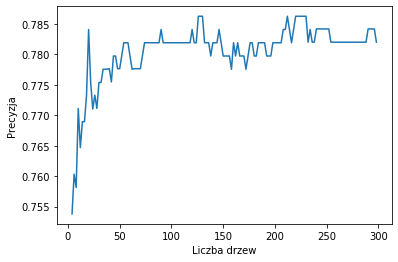

In [43]:
plot(B_values,acc_values1)
plt.ylabel("Precyzja")
plt.xlabel("Liczba drzew")

In [44]:
best_treeN=[x for (x,y) in zip(B_values,acc_values1) if y==max(acc_values1)][0]
print("Number of trees: ", best_treeN, "Accuracy: ", max(acc_values1))

Number of trees:  126 Accuracy:  0.786231884057971


## Maksymalna glebokosc drzewa

In [45]:
Depth_values=[]
acc_values2=[]

for n in range(1,12):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=n, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values2.append(statistics.mean(accuracy))
    Depth_values.append(n)


Text(0.5, 0, 'Głębokość drzew')

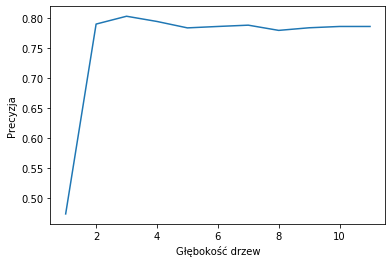

In [46]:
plot(Depth_values,acc_values2)
plt.ylabel("Precyzja")
plt.xlabel("Głębokość drzew")

In [47]:
best_depth=[x for (x,y) in zip(Depth_values,acc_values2) if y==max(acc_values2)][0]
print("Max Depth of tree: ", best_depth, "Accuracy: ", max(acc_values2))

Max Depth of tree:  3 Accuracy:  0.8032608695652174


## Liczba obiektów użyta do budowy każdego z drzew

In [48]:
B1_values=[]
acc_values3=[]

for n in range(int(math.sqrt(n_B)),300,2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=best_depth, max_samples=n, bootstrap=True,max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values3.append(statistics.mean(accuracy))
    B1_values.append(n)

Text(0.5, 0, 'Liczba obiektów użyta do budowy każdego z drzew')

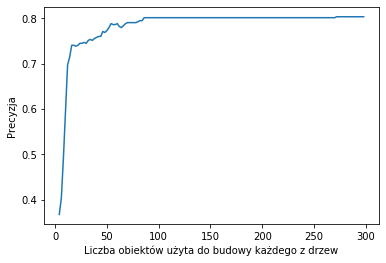

In [49]:
plot(B1_values,acc_values3)
plt.ylabel("Precyzja")
plt.xlabel("Liczba obiektów użyta do budowy każdego z drzew")

In [50]:
best_bootstrap=[x for (x,y) in zip(B1_values,acc_values3) if y>0.8][0]
print("Liczba obiektow:", best_bootstrap, "precyzja: ", max(acc_values3))

Liczba obiektow: 86 precyzja:  0.8032608695652174


## Ostateczny model

In [51]:
accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
#print(accuracy)
print("Accuracy of the model: ",round(statistics.mean(accuracy),4))

Accuracy of the model:  0.8012


## Dokladana analiza polenianych bledow

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.2)

rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
rf.fit(X_train, Y_train);
predictions = rf.predict(X_test)
predictions=np.round(predictions,0)
error= predictions==Y_test
print(np.sum(error)/len(error))

0.7741935483870968


Confusion Matrix for Random Forest
[[20  7  0  0]
 [ 1 17  2  0]
 [ 0  5 18  6]
 [ 0  0  0 17]]


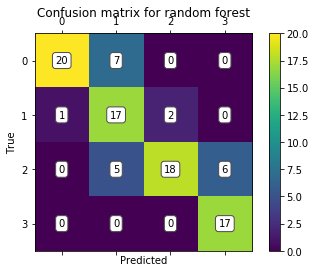

In [54]:
print('Confusion Matrix for Random Forest')
cm=confusion_matrix(Y_test, predictions)
print(cm)
labels=[0,1,2,3]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.title('Confusion matrix for random forest')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()